image classification using swim transformer
Imageresolution = 224 x 224
patchsize = 4 x 4
number of features in one patch = 4 x 4 x 3 = 48
total number of patches in the whole image = 224/4 x 224/4 = 3136

In [1]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
# DropPath: dropout that applies dropout to the connections between layers instead of individual units.
# to_2tuple: convrt input to tuple with 2 elts
# trunc_normal_  :truncated at a certain range, typically to avoid extreme values.
from PIL import Image
# PIL : pyth img lib :provides functions for opening, manipulating, and saving many different image file formats.
import torch
import torchvision.transforms as transforms
# transforms :transformations on images, such as resizing, cropping, and normalization.
import matplotlib.pyplot as plt



In [2]:
pip install timm


In [3]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
 # tensors are the fundamental building blocks of deep learning models in PyTorch,
# representing both the input data and the model parameters during training and inference.


# Load the image file
image_path = r"C:\Users\janap\Desktop\Final_mini prjct\swww\train\green st\images (4).jpg"
image = Image.open(image_path)
# loads img using pil()



# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])



# Apply the transformation to the loaded image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension making it suitable for processing by a neural network model.

# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

# Permute dimensions to match the expected shape (Batch siz, Heigh, Widt, Channels)
tensor_image = tensor_image.permute(0, 2, 3, 1)
# The permute() function in PyTorch allows you to rearrange the dimensions of a tensor.
# this code prepares an image for input into a neural network model by loading it,
# applying transformations, and reshaping it into the appropriate format.

Tensor shape: torch.Size([1, 3, 224, 224])
Tensor data type: torch.float32


In [4]:
def window_partition(x, patch_size=4):
    # window_partition, is used to divide an input tensor into smaller patches or windows
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)
        
    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """
    
    B, H, W, C = x.shape
    # x is input tensor with shape
    # Calculate the number of patches in each dimension based on patch size
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    #reshapes the input tensor into a 6-dimensional tensor,(B, num_patches_h, patch_size in hei, num_patches_w, patch_size in width, C) 
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    
    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    
    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)
    
    return patches


Windows shape: torch.Size([3136, 4, 4, 3])
num_patches  3136


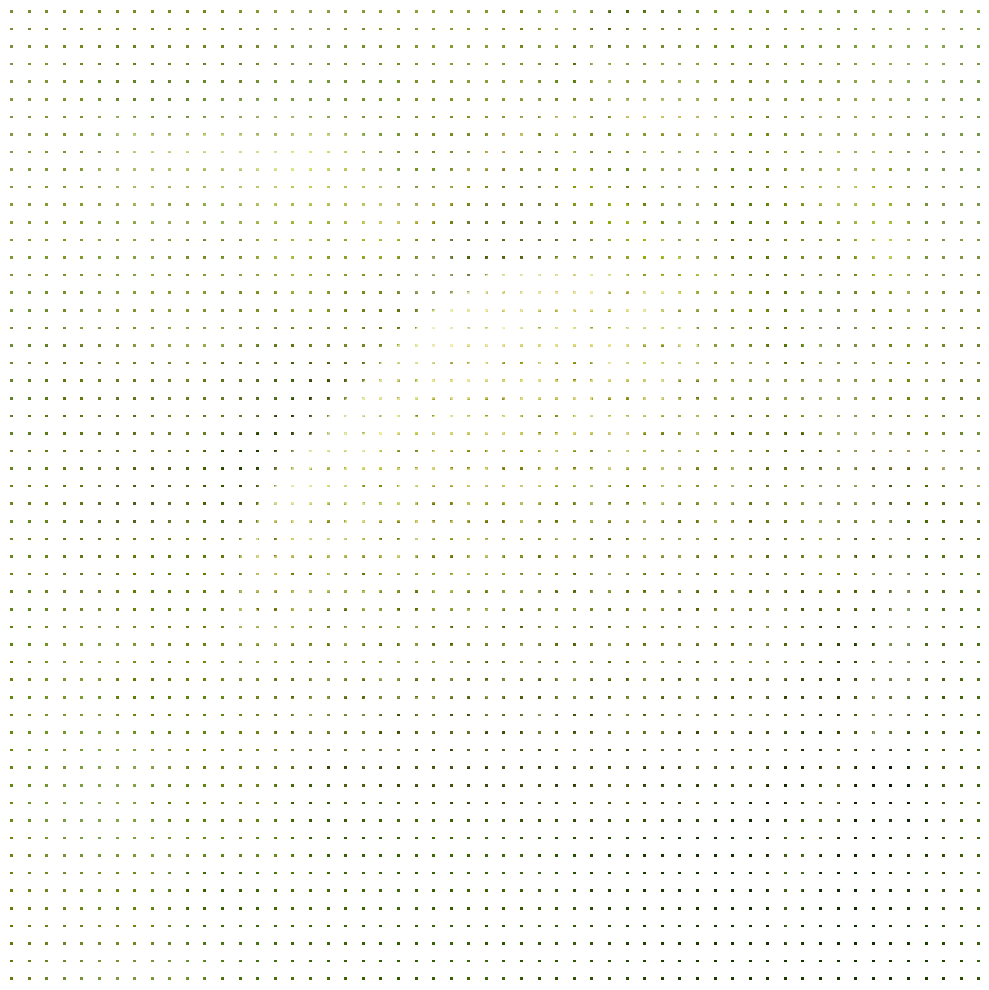

In [5]:
# visualizing the patches obtained by dividing the input image tensor into smaller windows using the window_partition function
# Call the window_partition function on the tensor_image
window_size = 4
windows = window_partition(tensor_image, window_size)

num_patches, patch_size, _, _ = windows.shape

# Print the shape of the output windows
print("Windows shape:", windows.shape)

print("num_patches ",num_patches)

# Calculate the number of rows and columns in the grid
num_rows = int(num_patches ** 0.5)
num_cols = num_patches // num_rows

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the patches and plot them
for i, ax in enumerate(axs.flat):
    patch = windows[i].numpy()
    ax.imshow(patch)
    ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# (224/4 * 224/4 =56*56 = 3136 patches of size 4*4)

# displaying all the patches (4*4) to visualize properly

Total number of windows: 3136


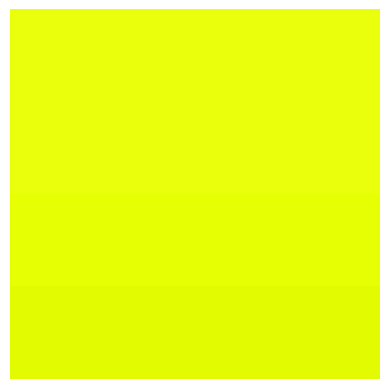

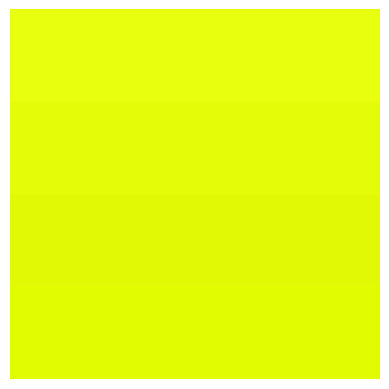

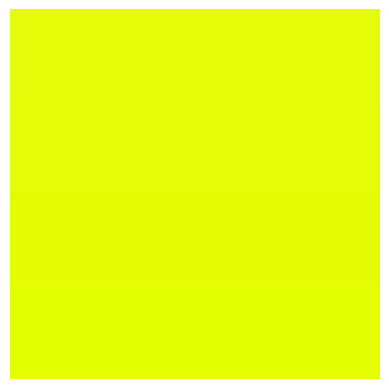

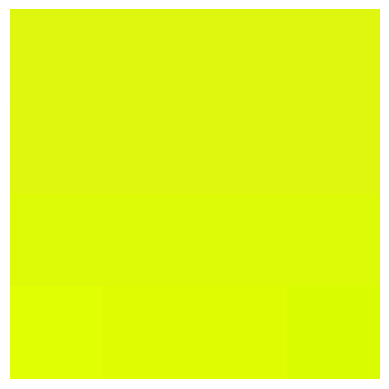

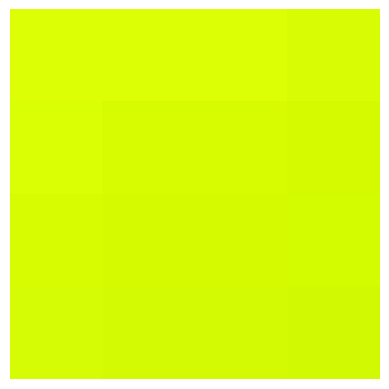

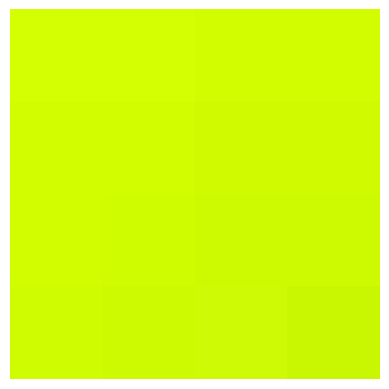

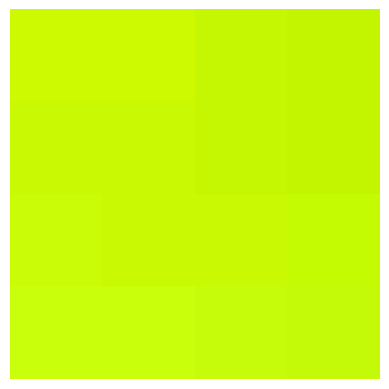

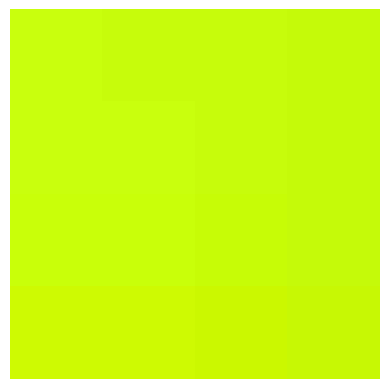

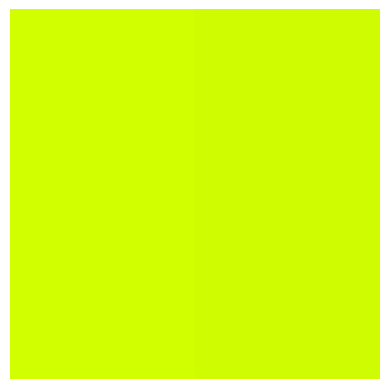

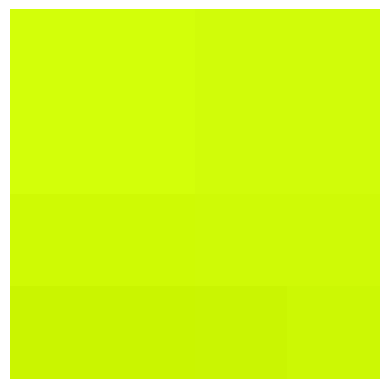

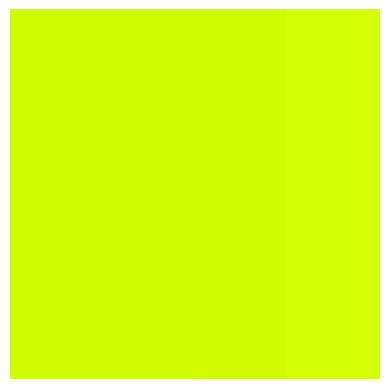

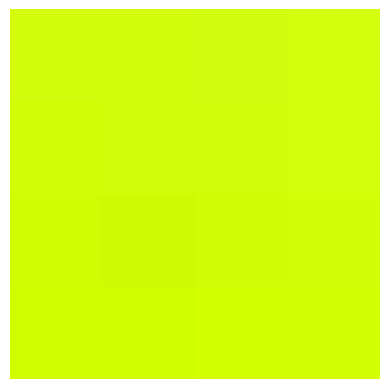

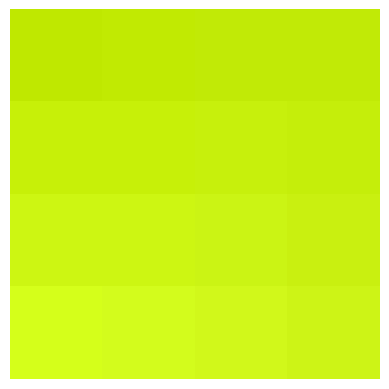

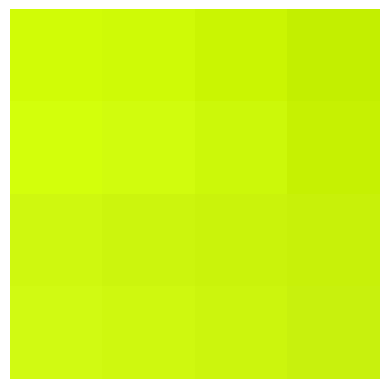

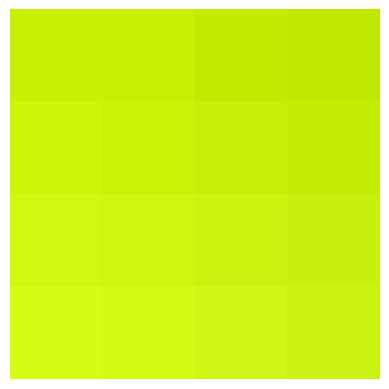

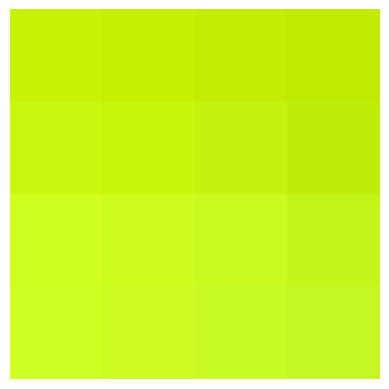

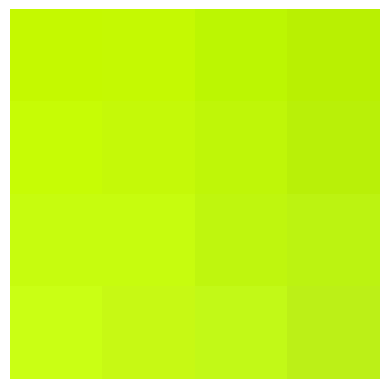

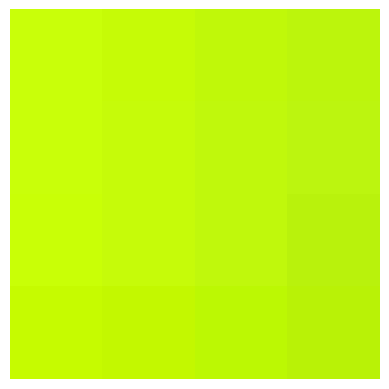

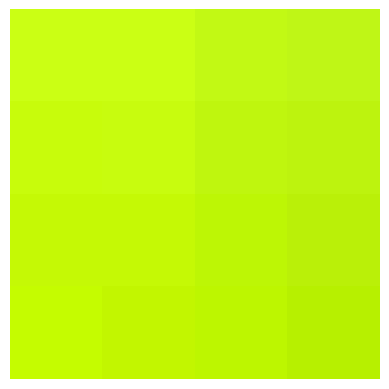

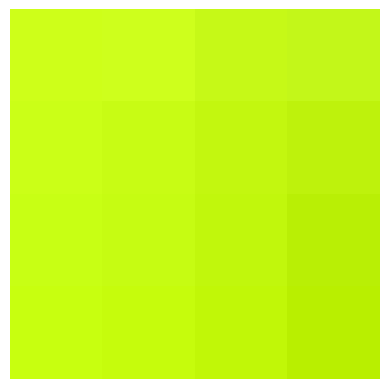

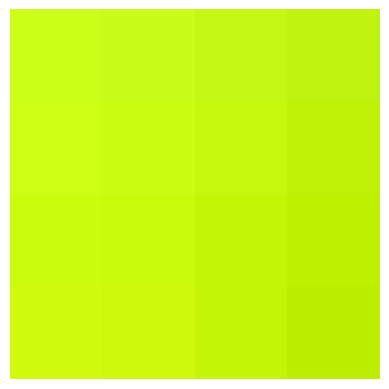

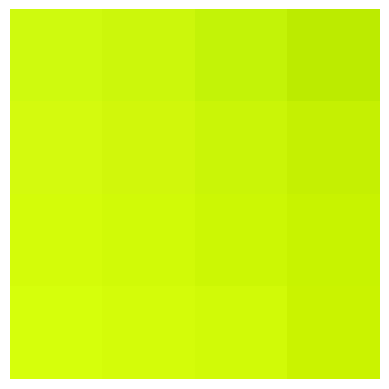

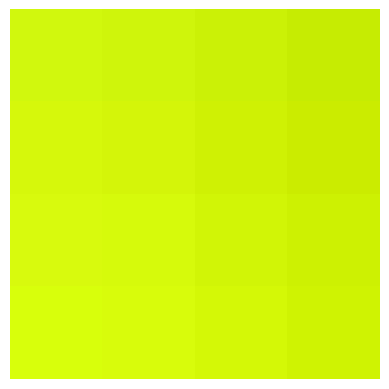

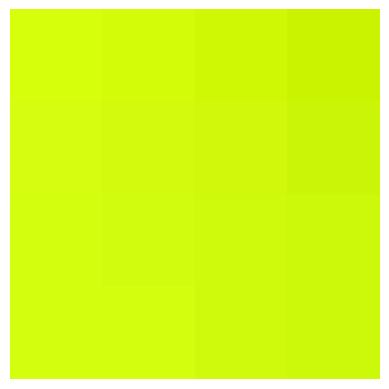

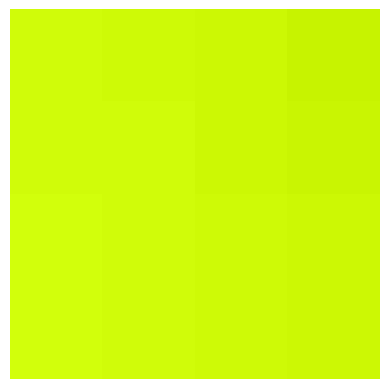

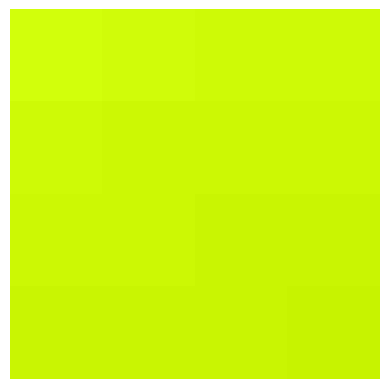

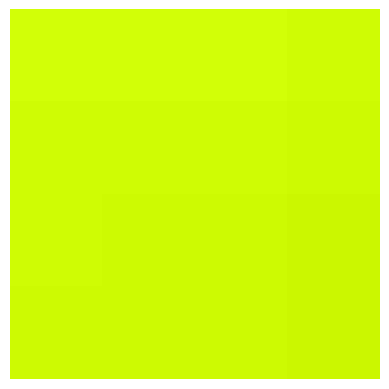

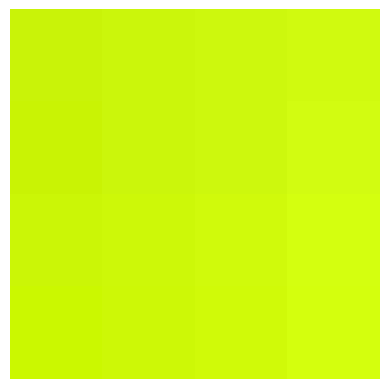

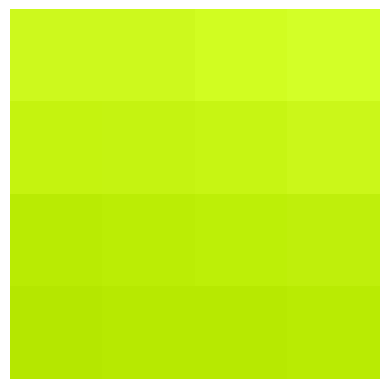

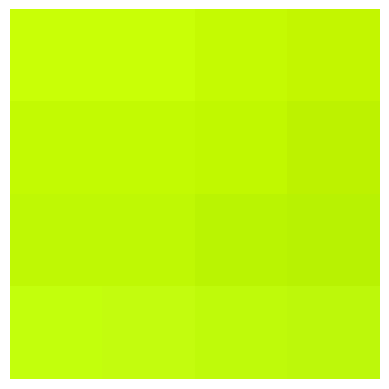

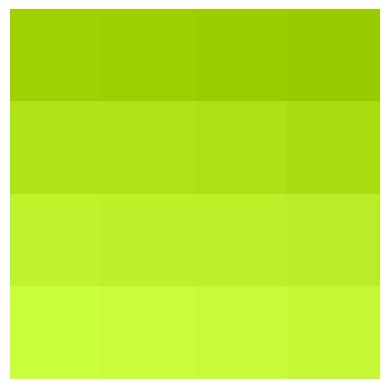

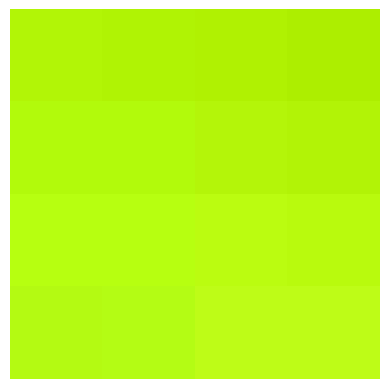

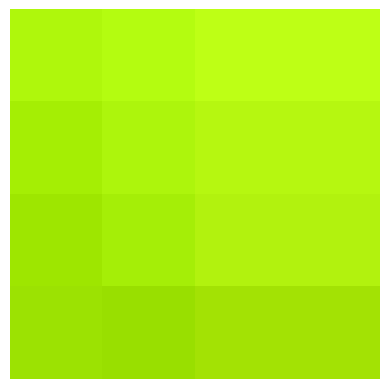

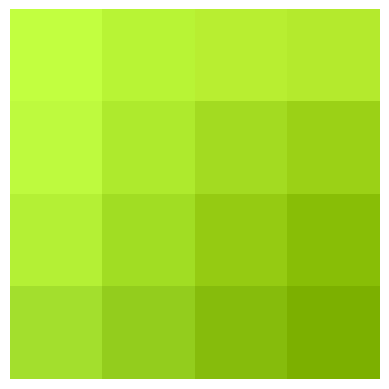

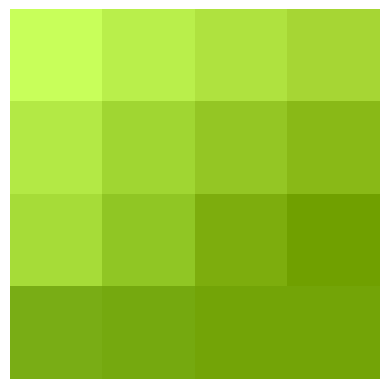

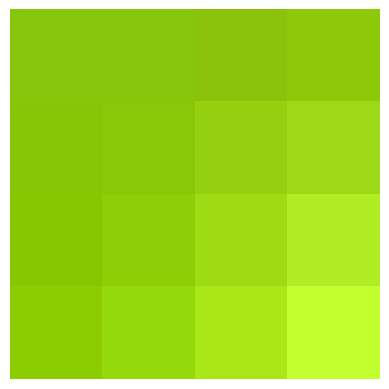

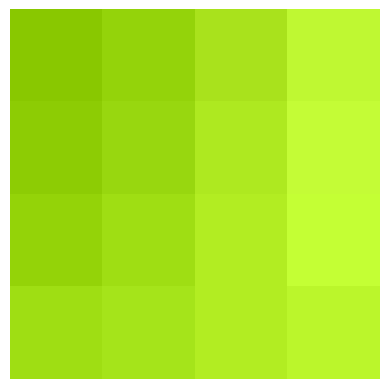

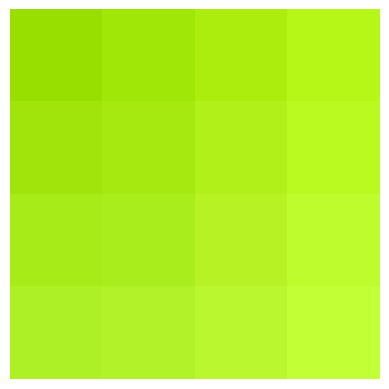

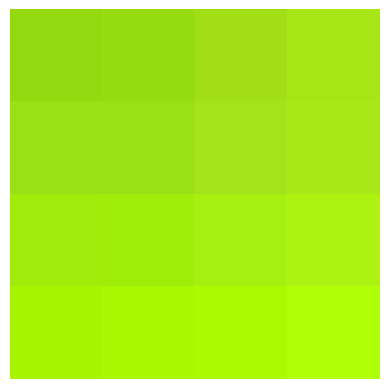

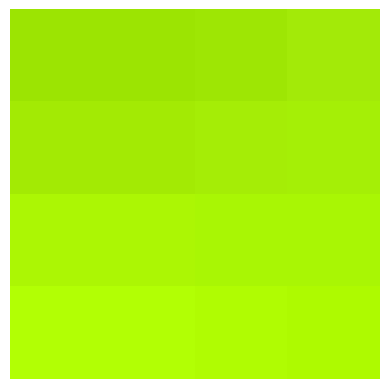

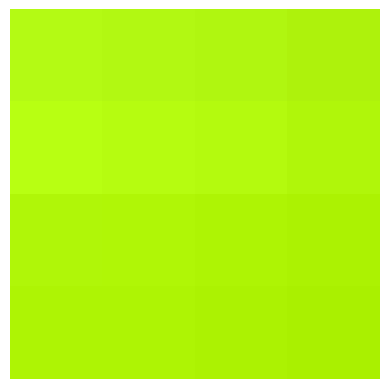

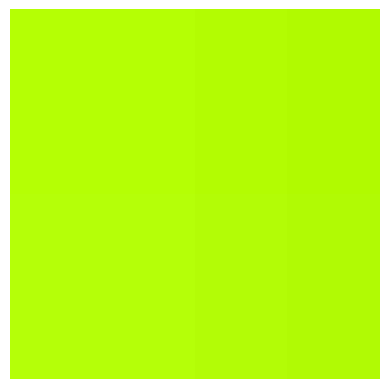

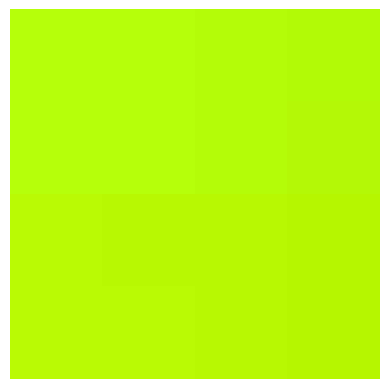

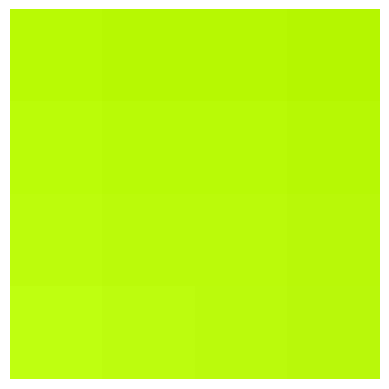

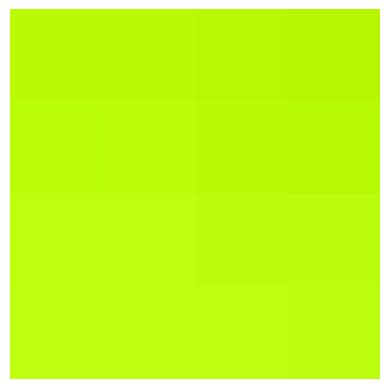

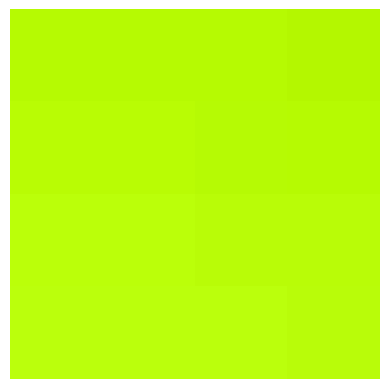

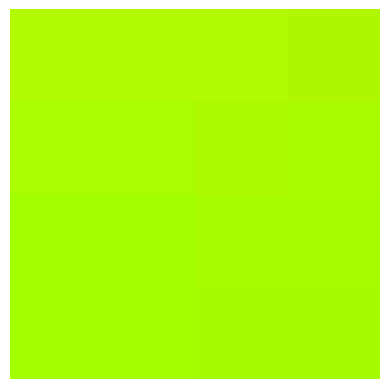

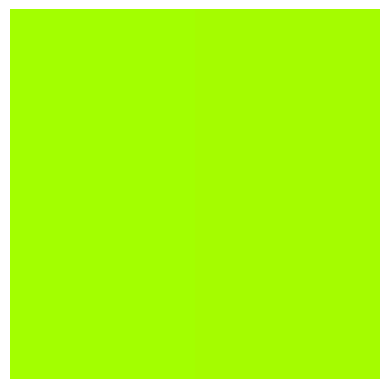

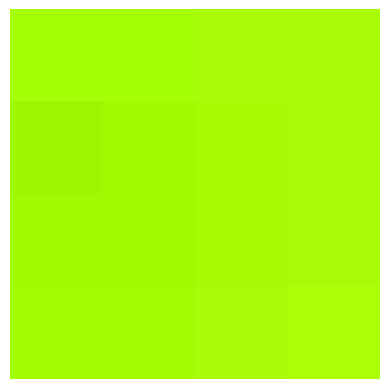

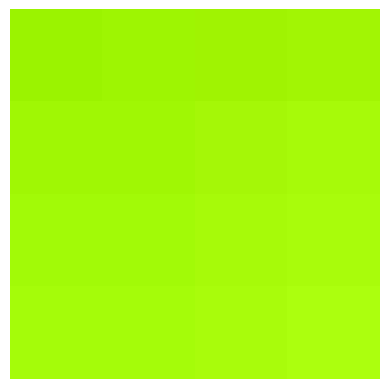

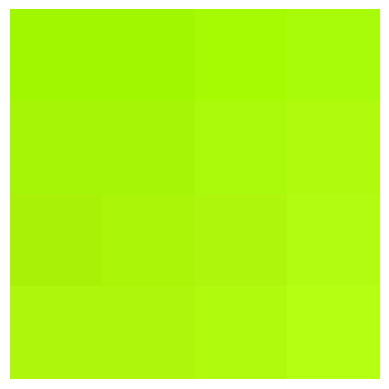

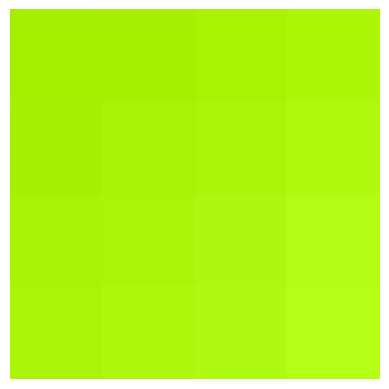

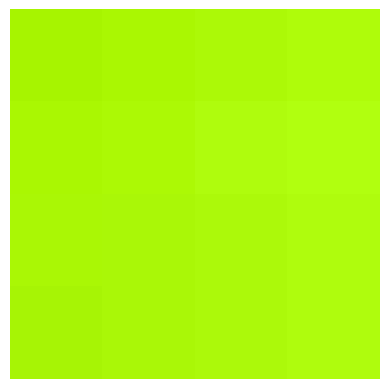

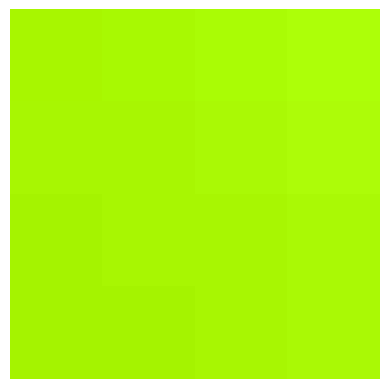

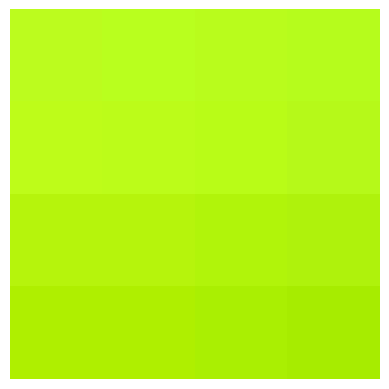

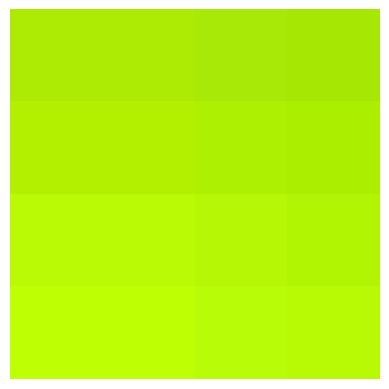

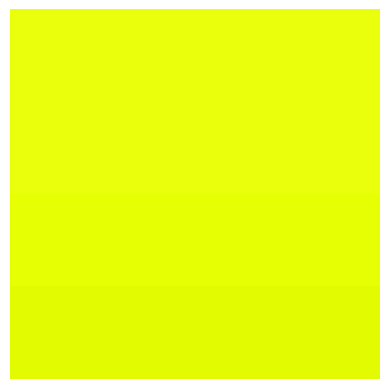

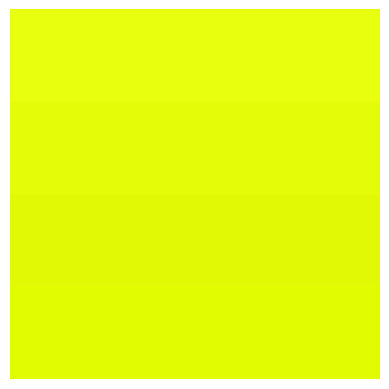

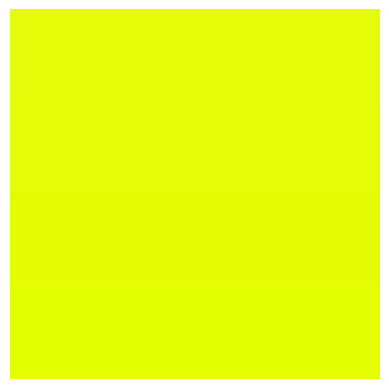

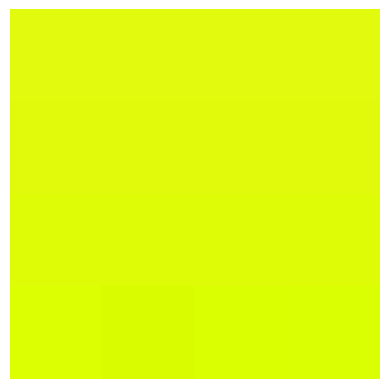

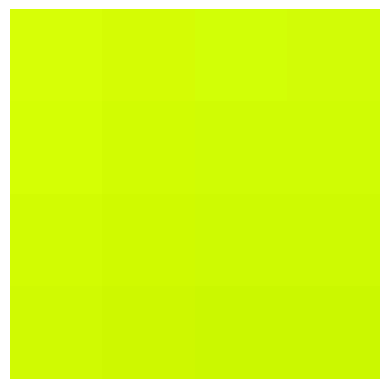

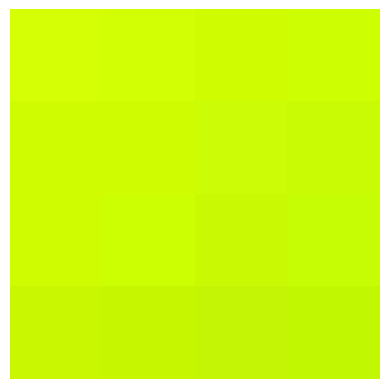

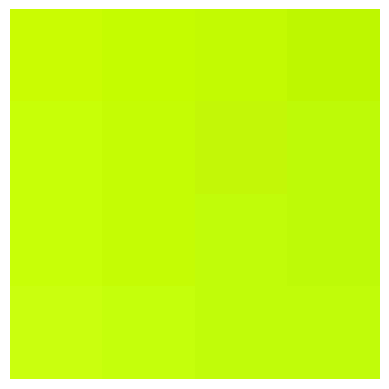

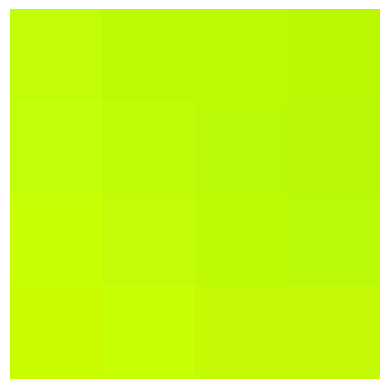

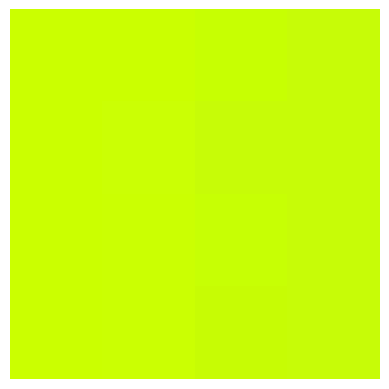

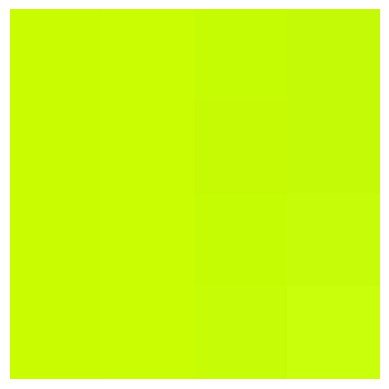

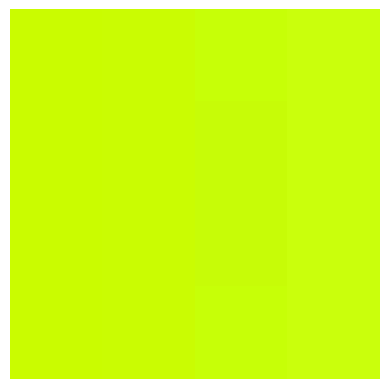

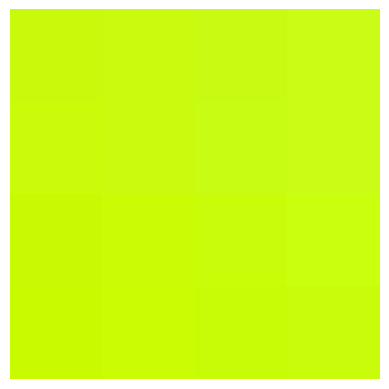

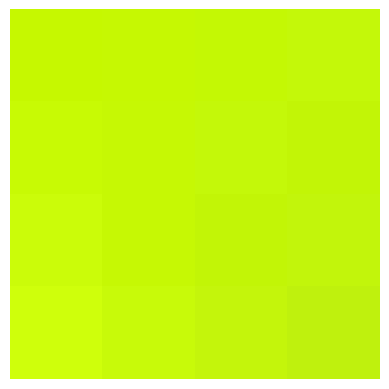

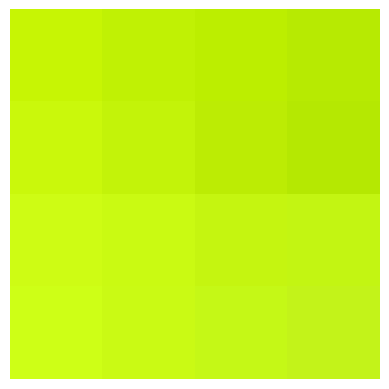

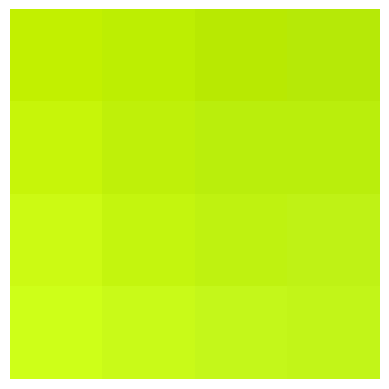

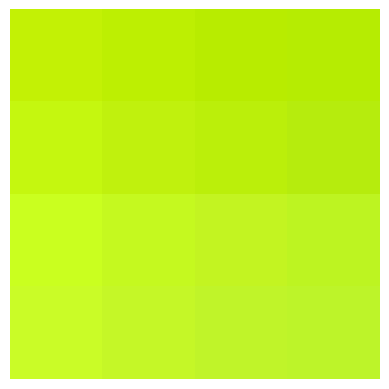

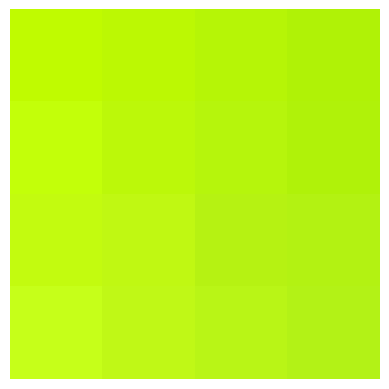

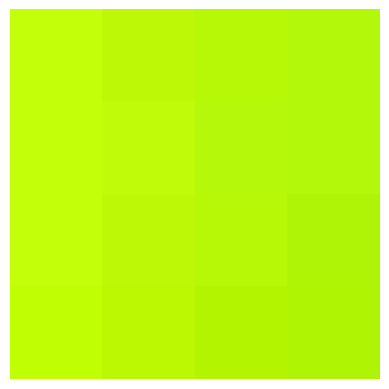

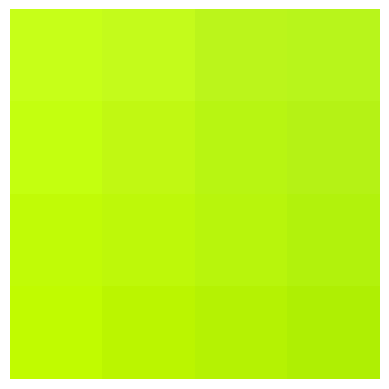

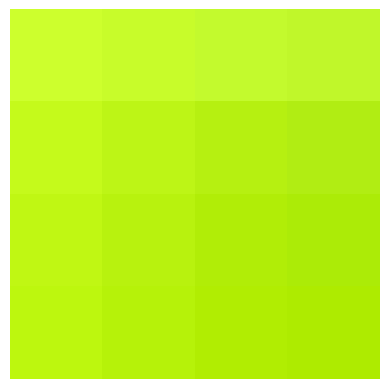

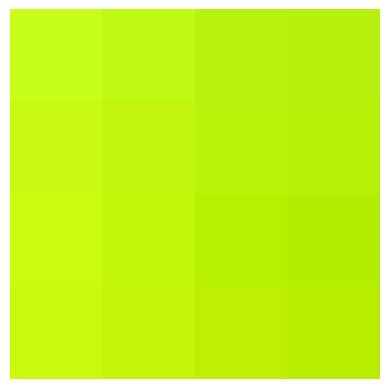

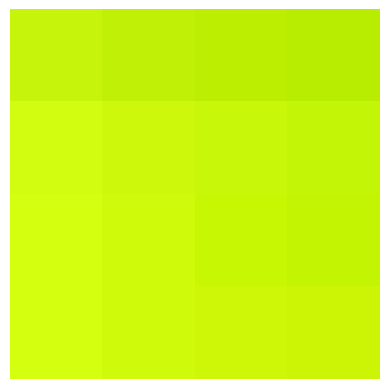

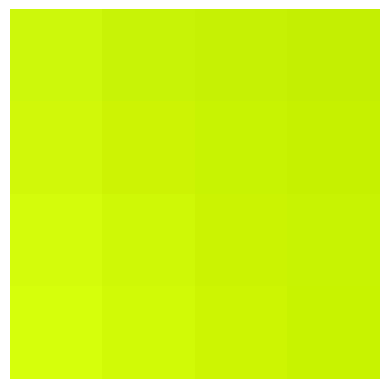

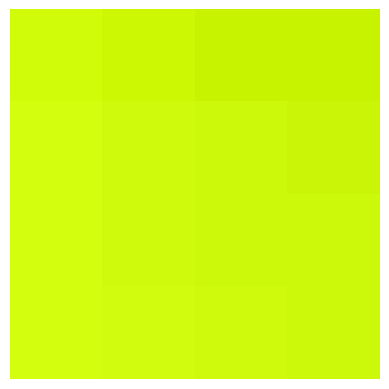

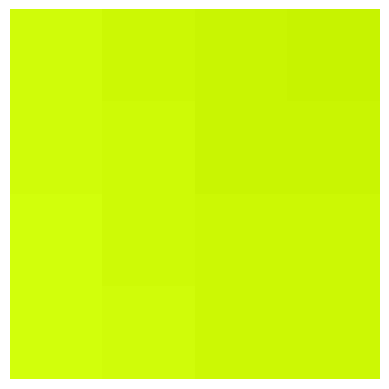

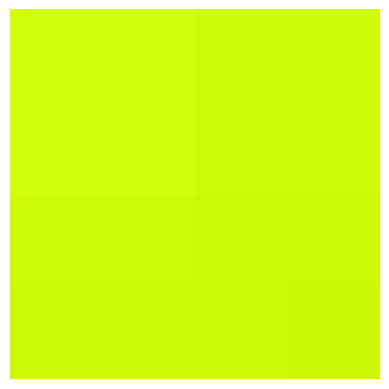

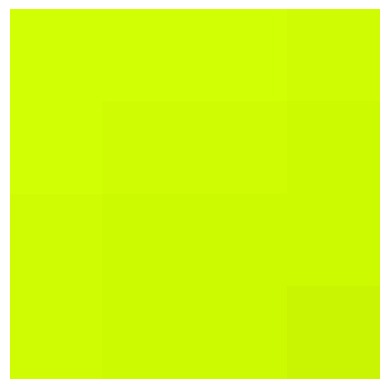

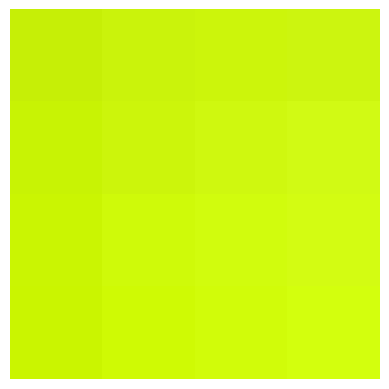

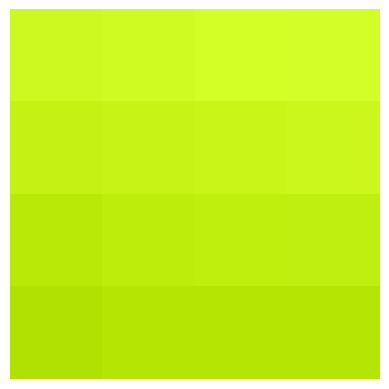

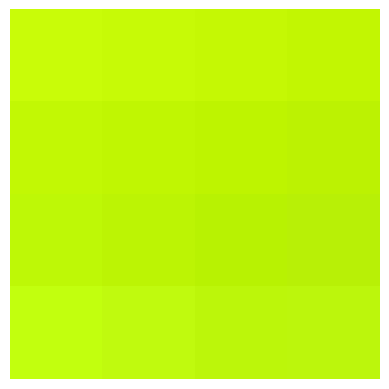

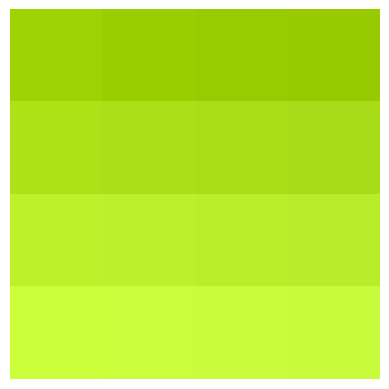

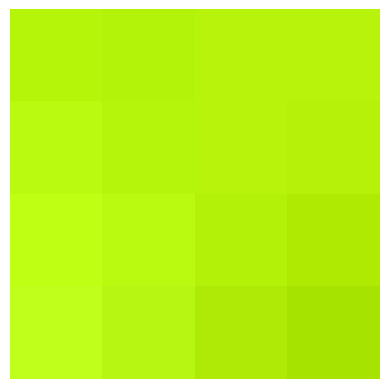

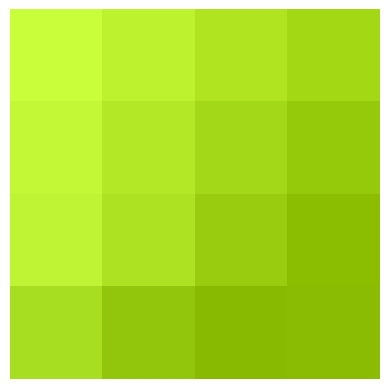

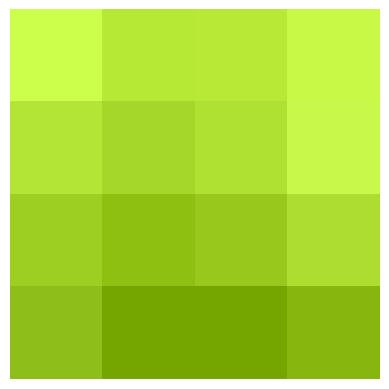

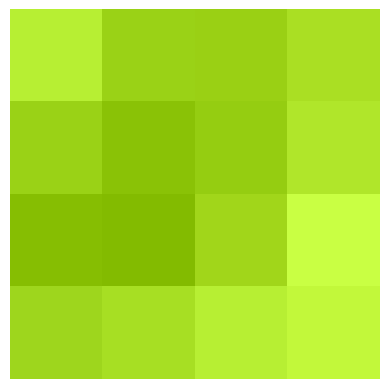

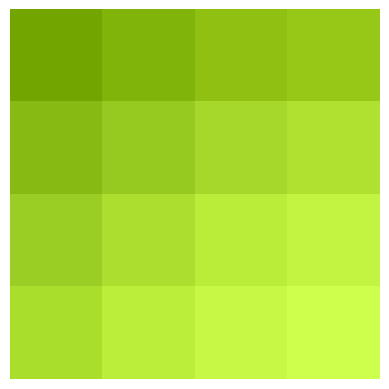

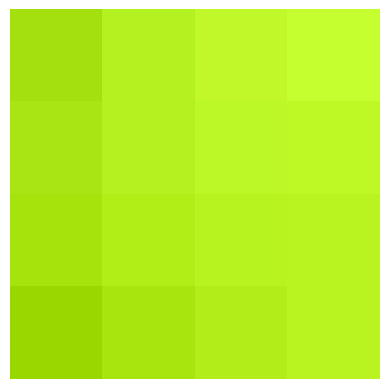

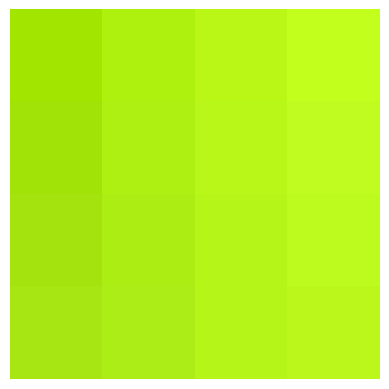

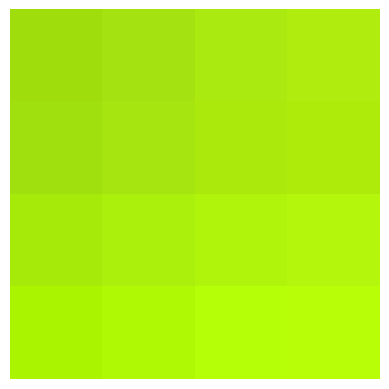

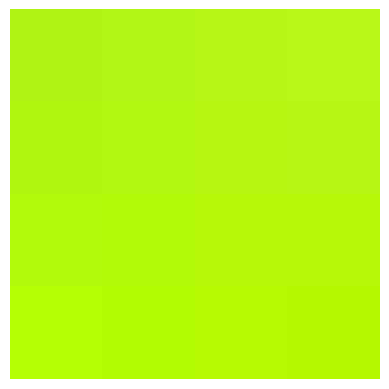

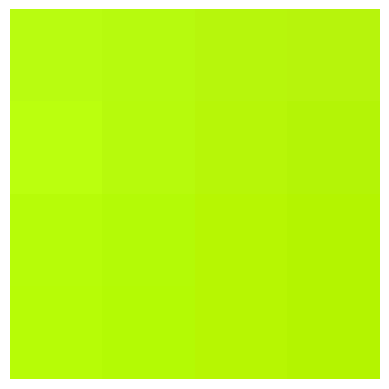

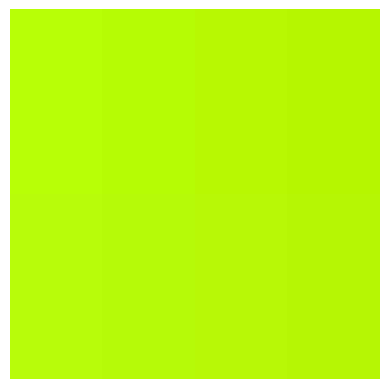

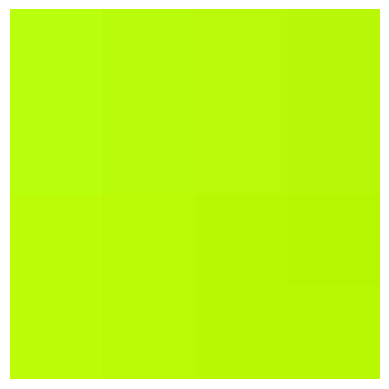

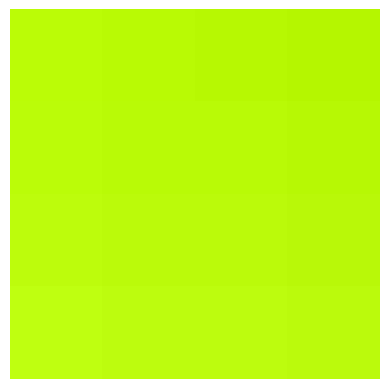

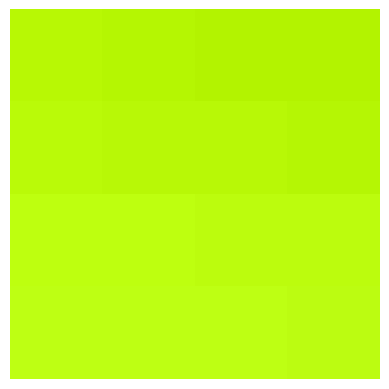

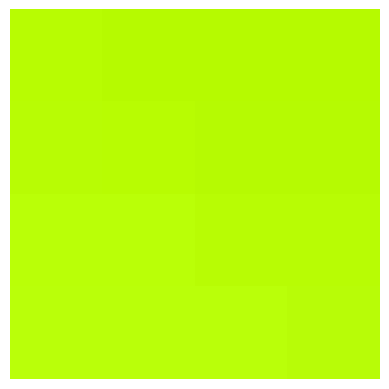

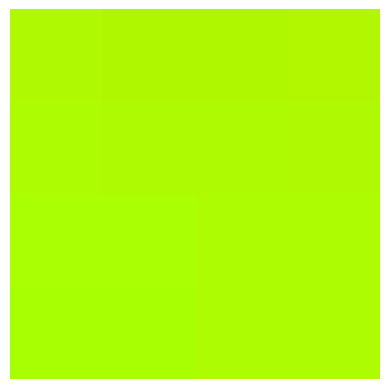

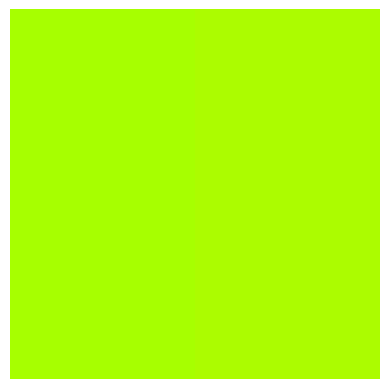

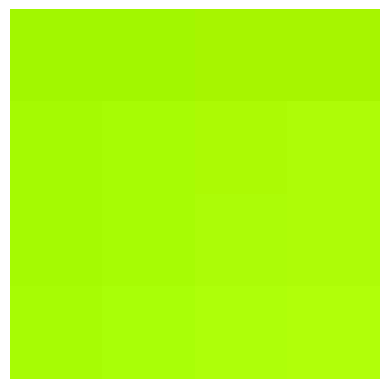

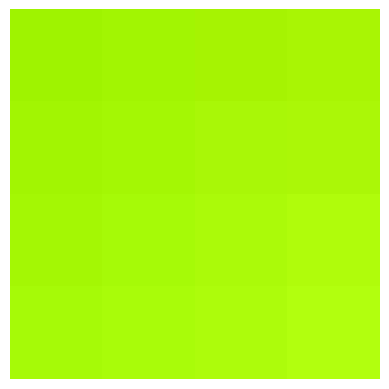

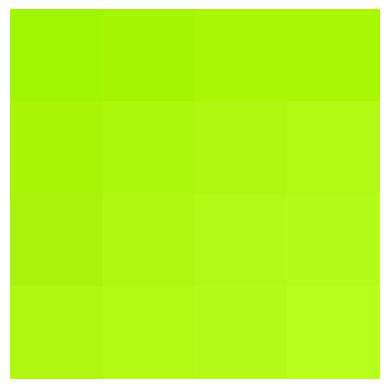

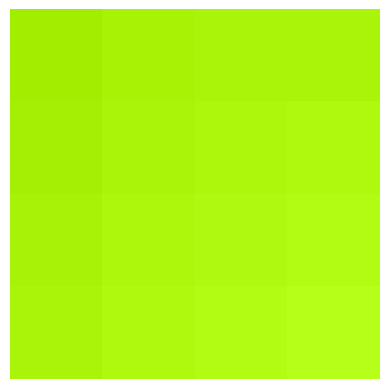

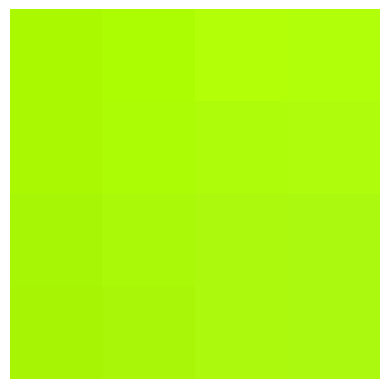

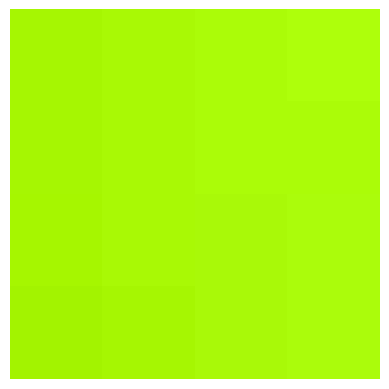

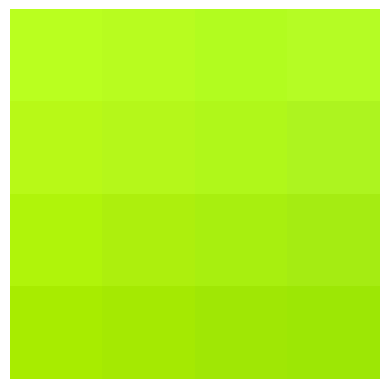

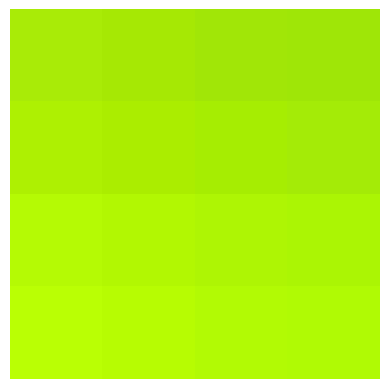

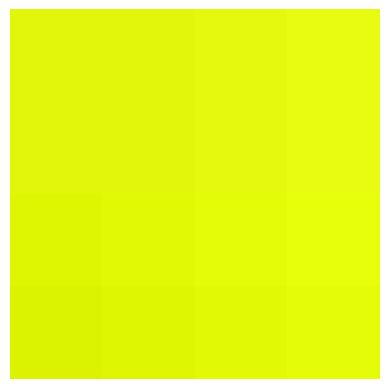

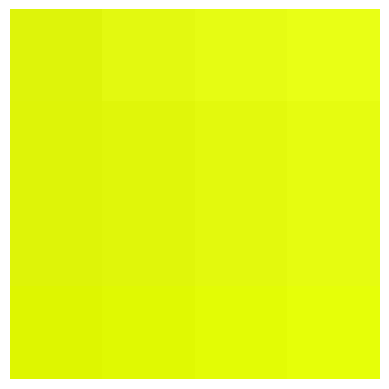

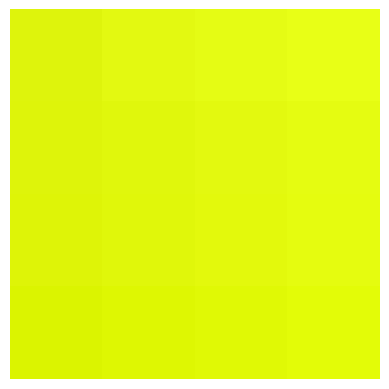

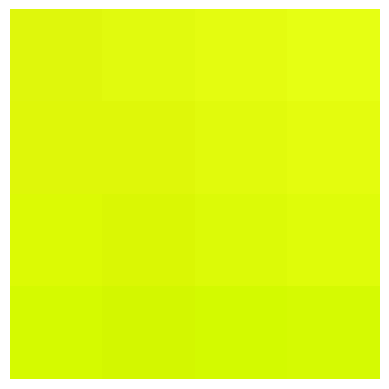

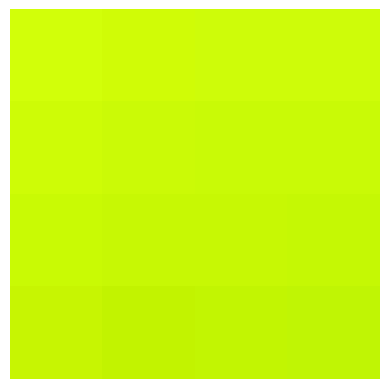

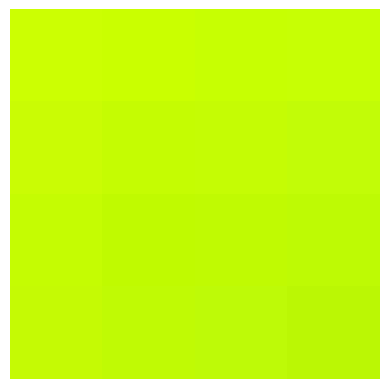

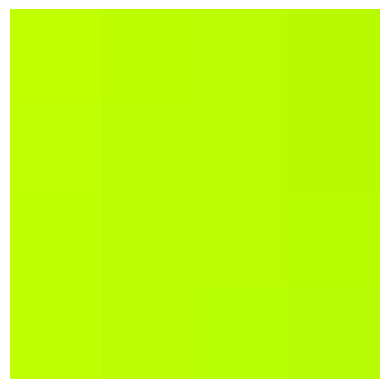

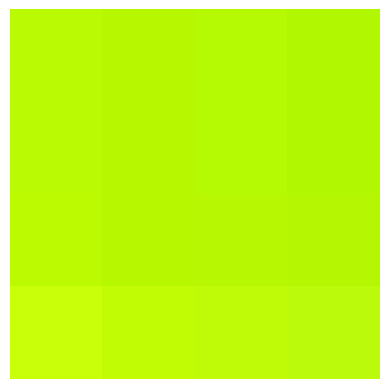

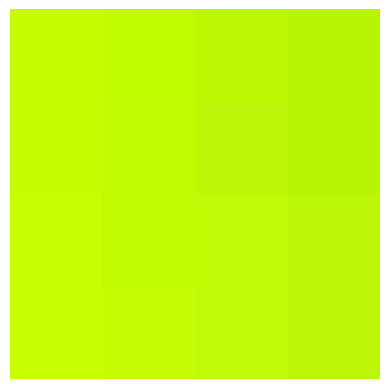

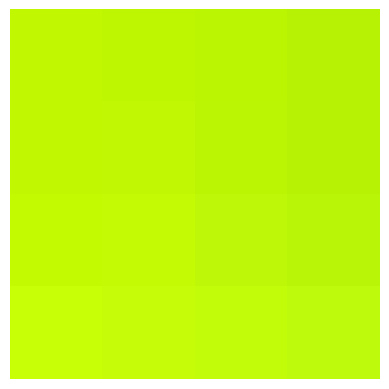

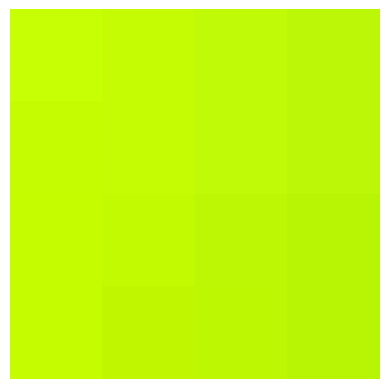

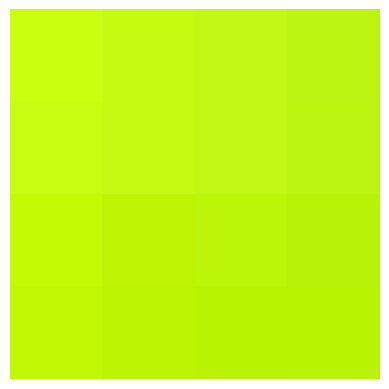

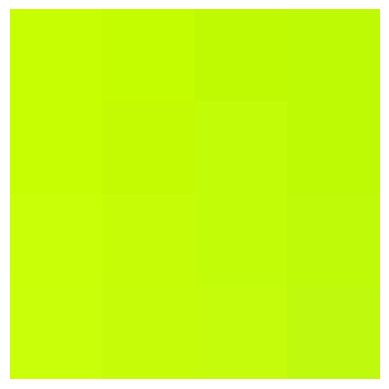

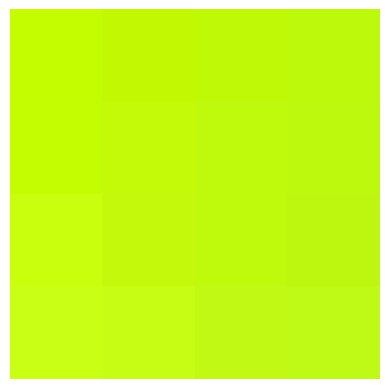

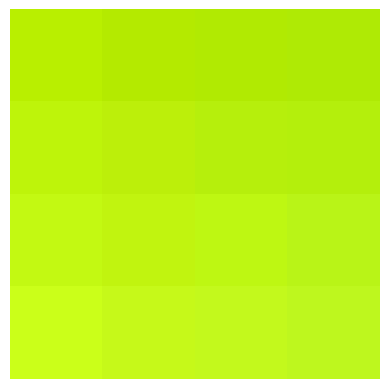

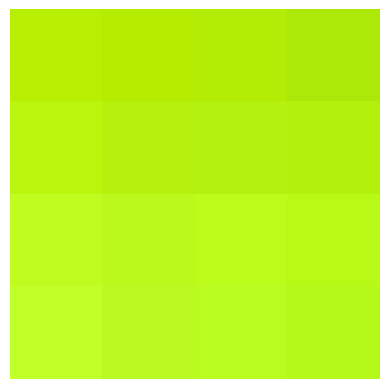

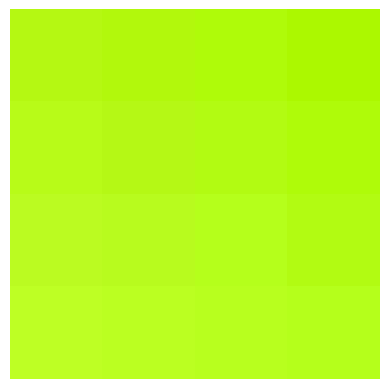

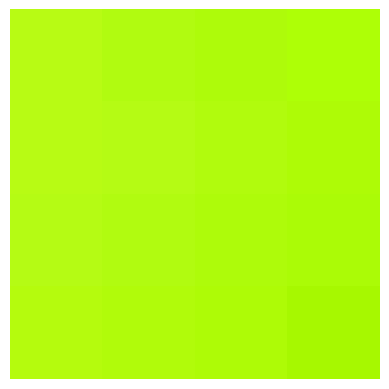

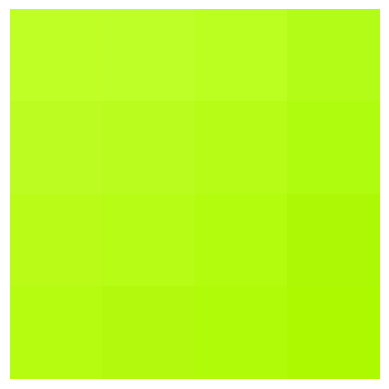

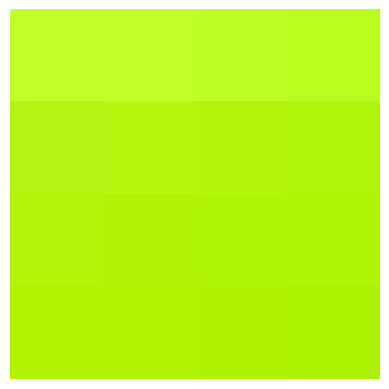

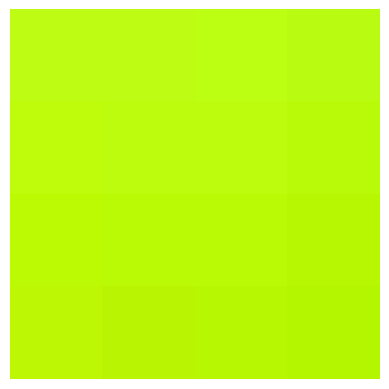

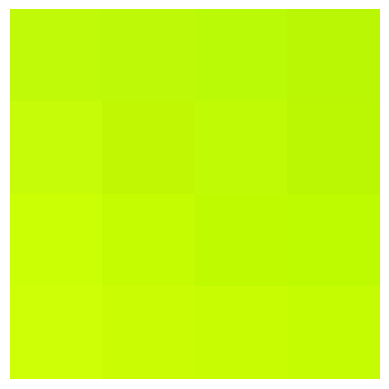

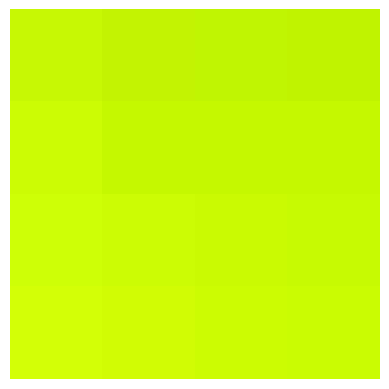

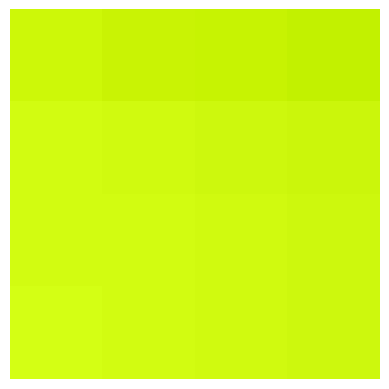

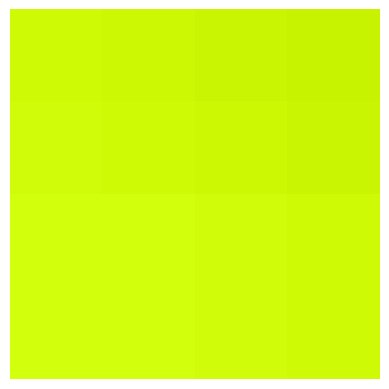

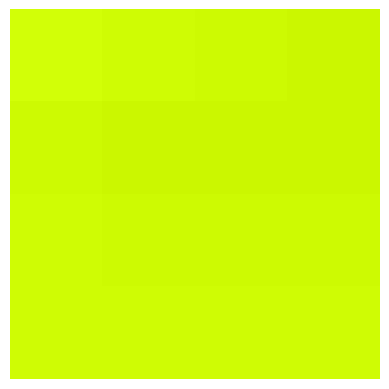

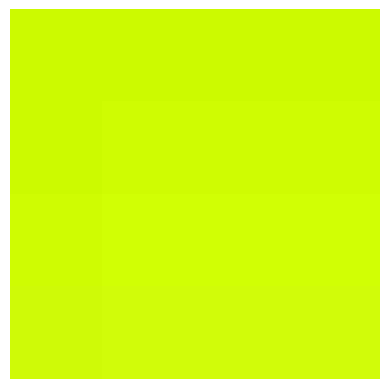

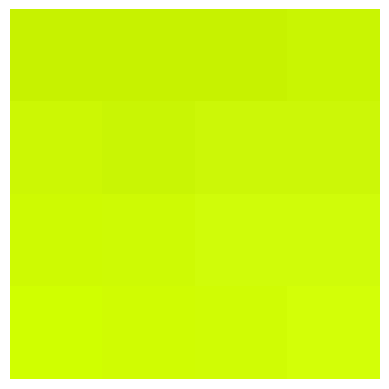

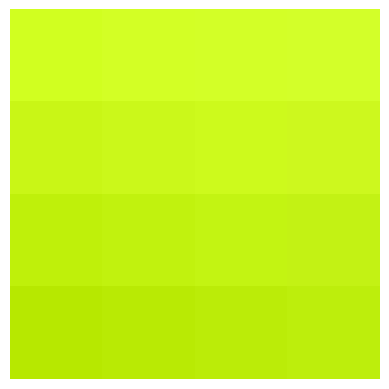

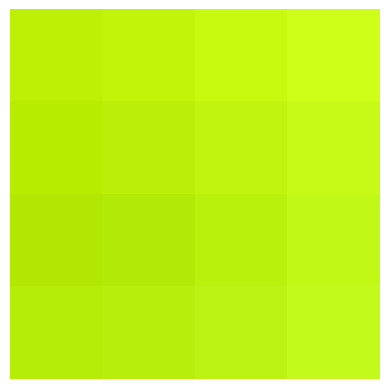

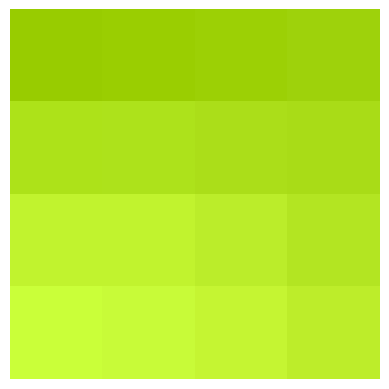

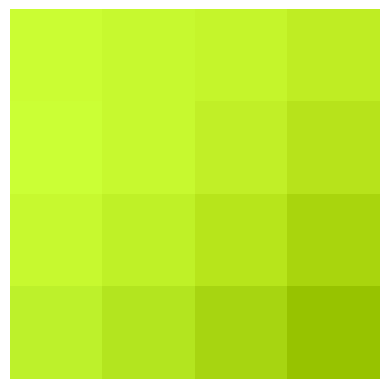

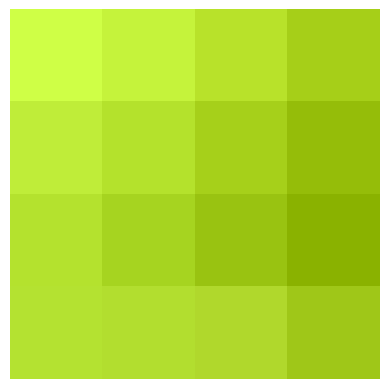

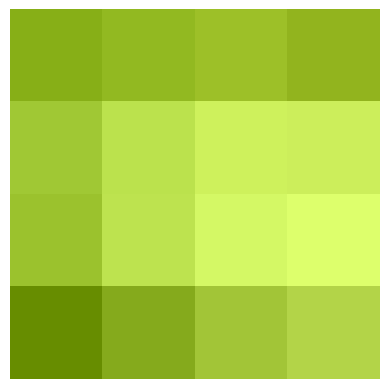

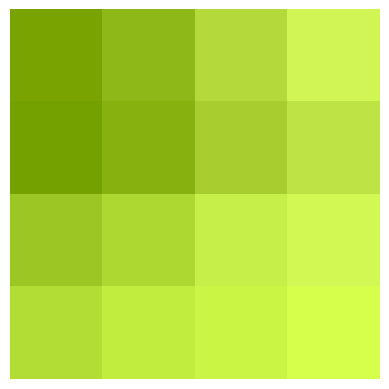

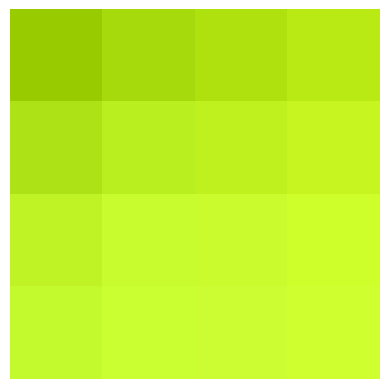

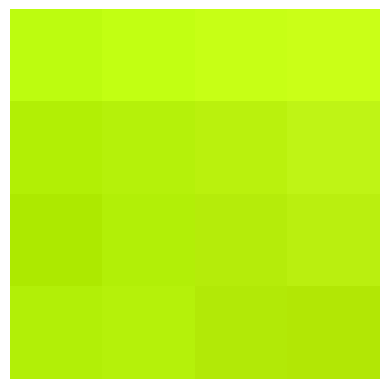

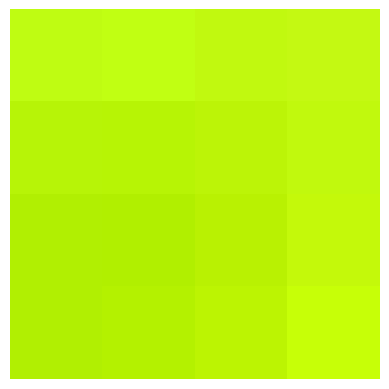

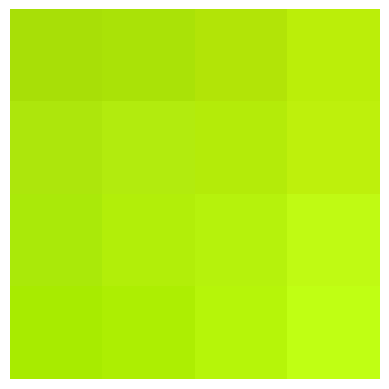

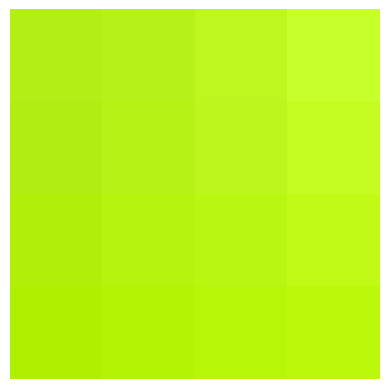

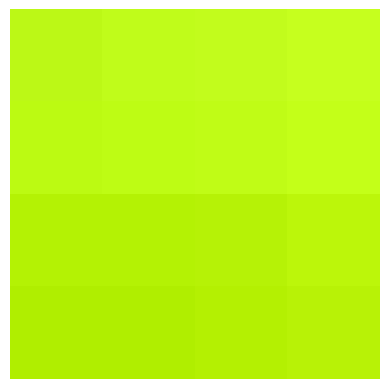

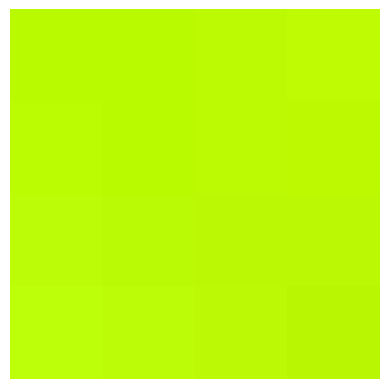

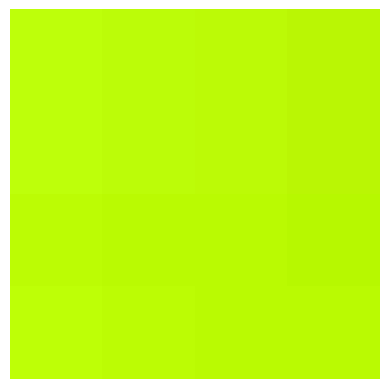

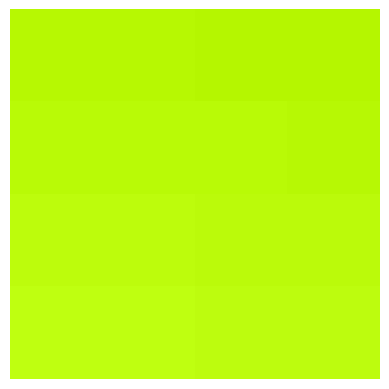

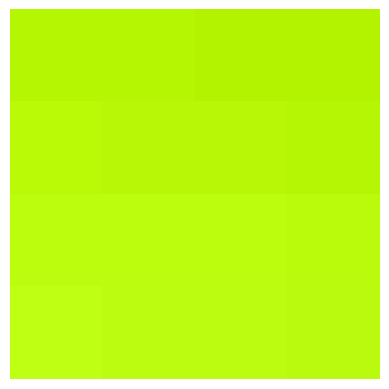

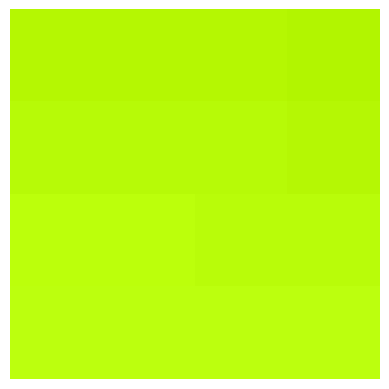

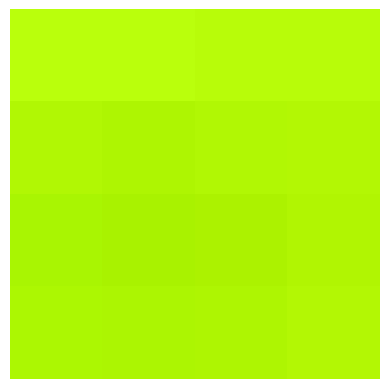

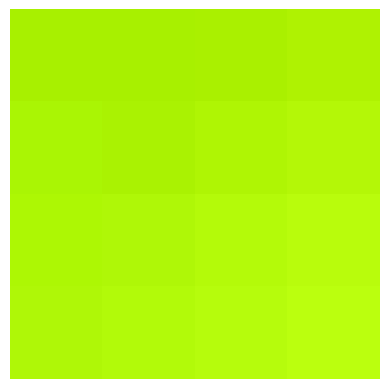

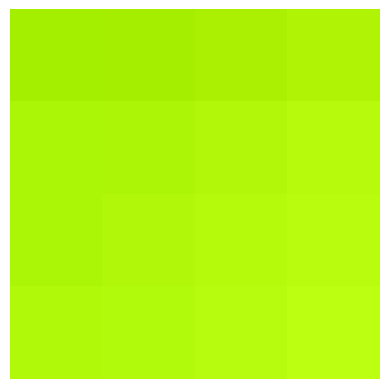

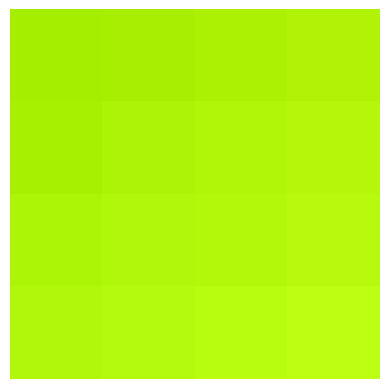

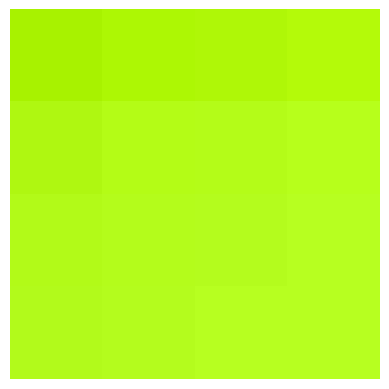

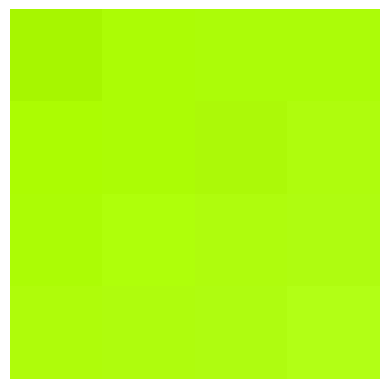

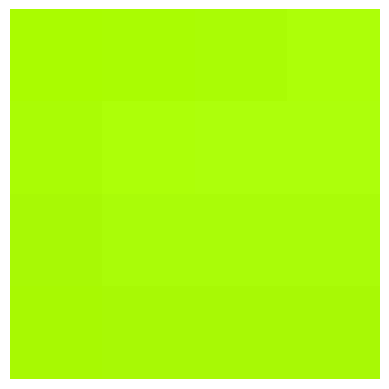

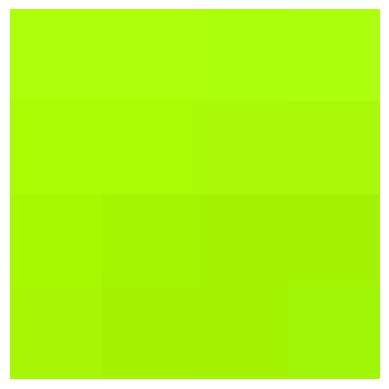

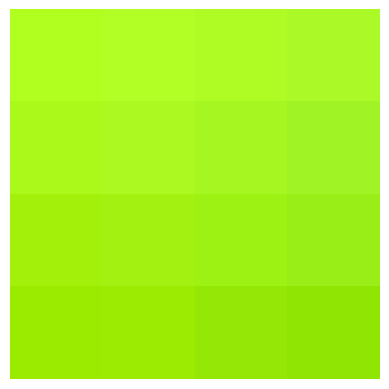

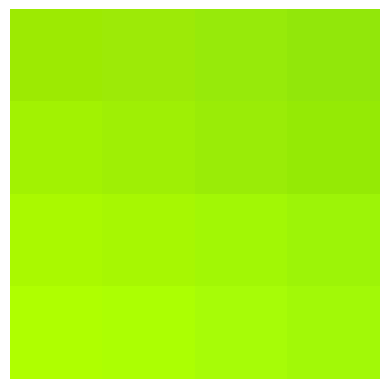

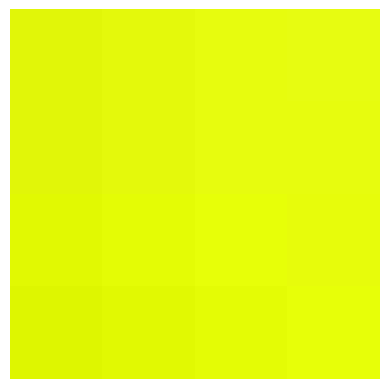

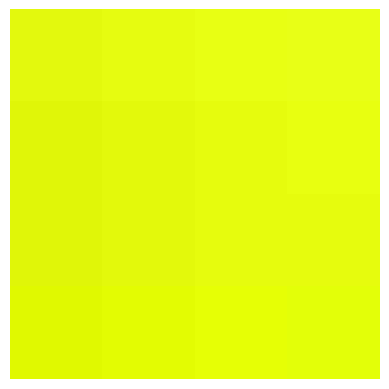

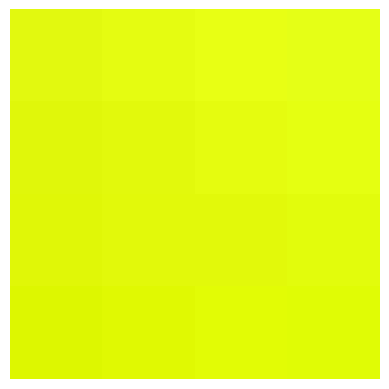

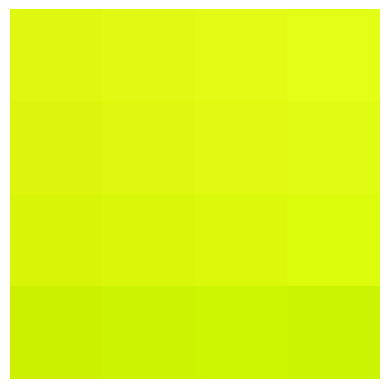

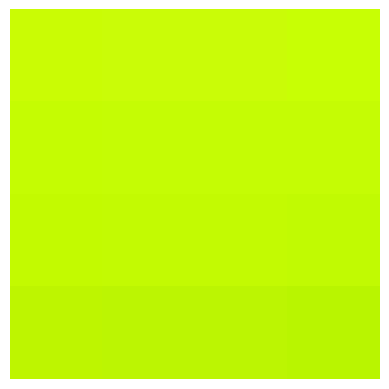

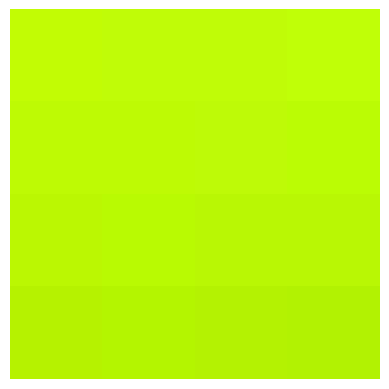

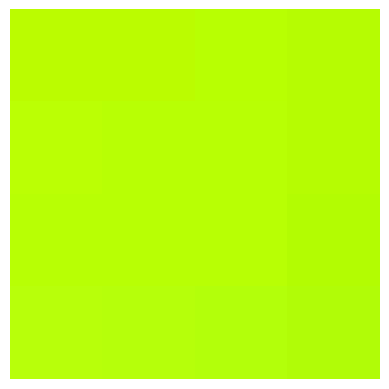

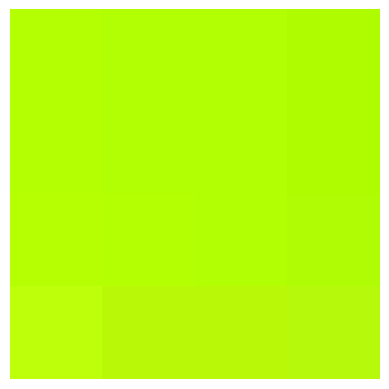

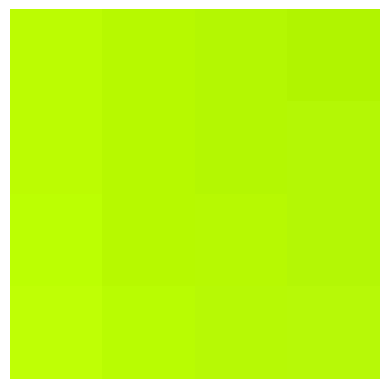

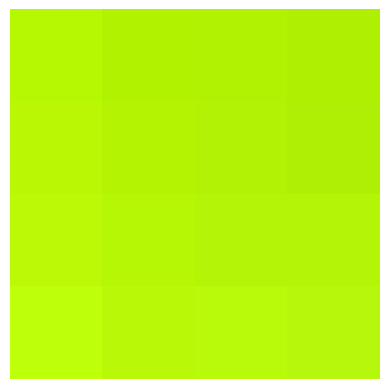

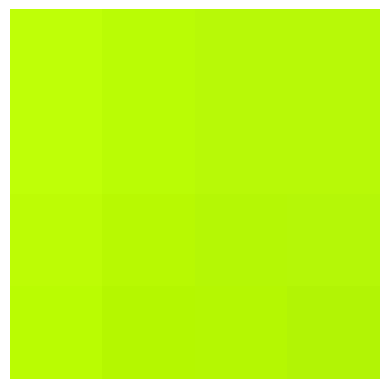

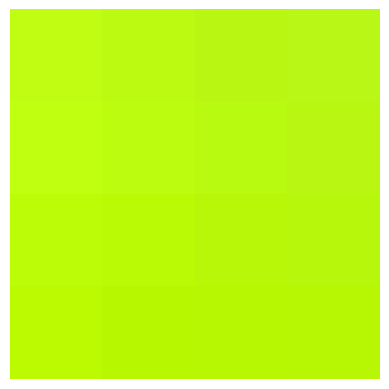

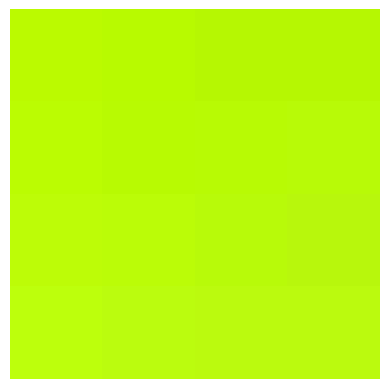

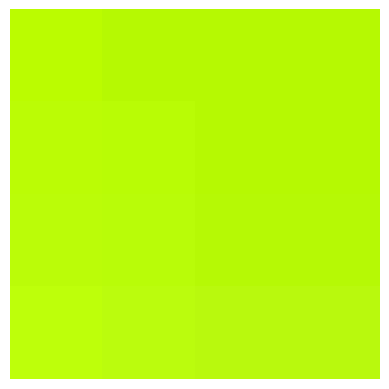

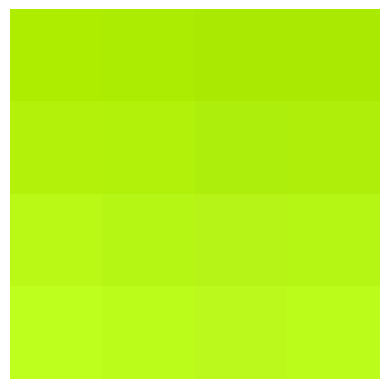

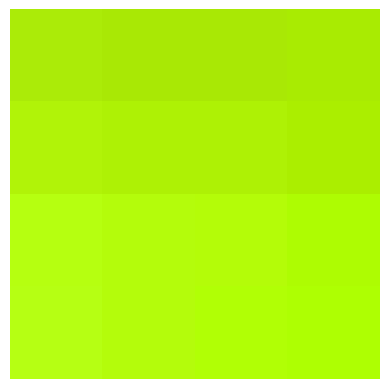

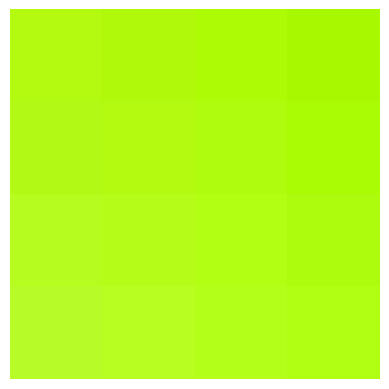

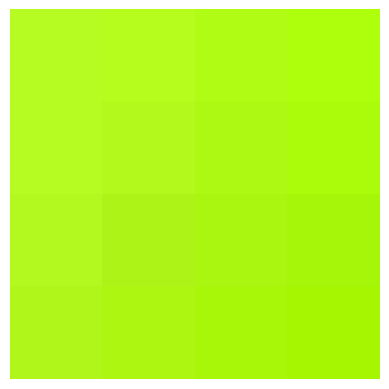

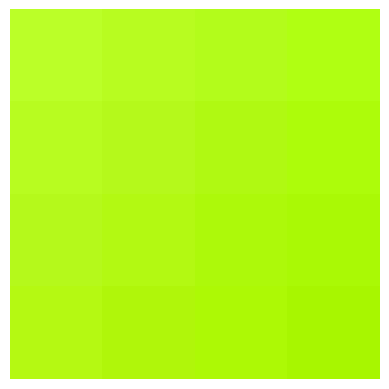

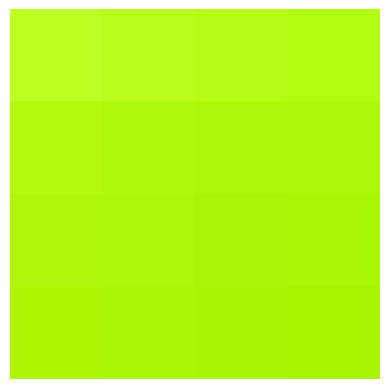

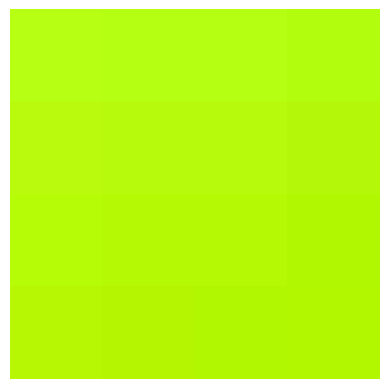

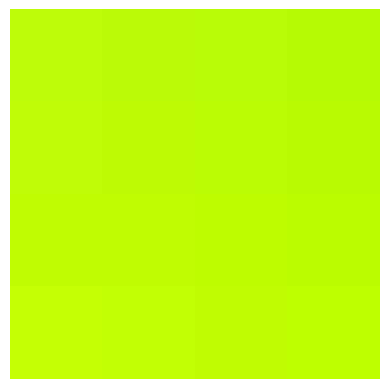

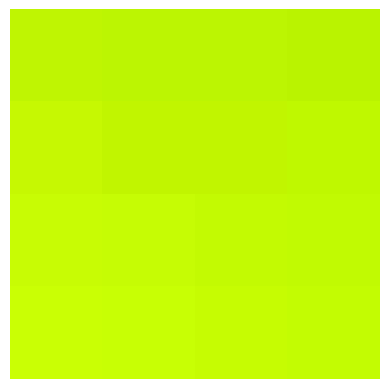

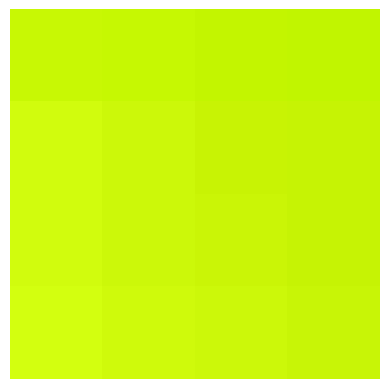

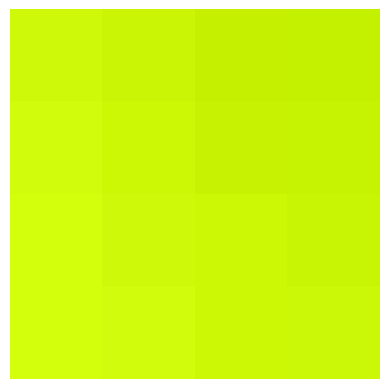

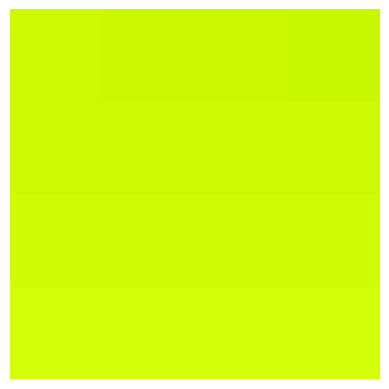

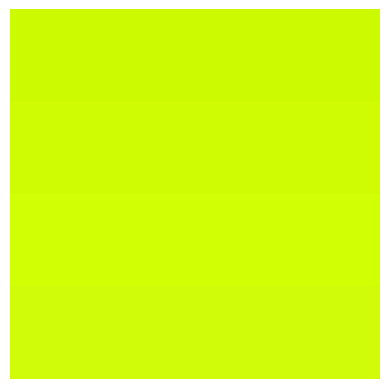

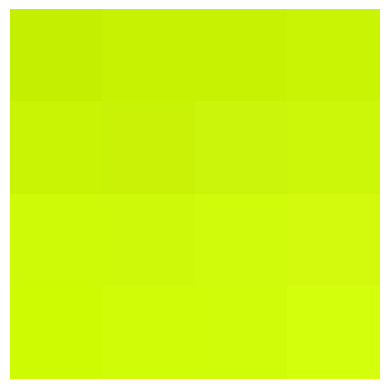

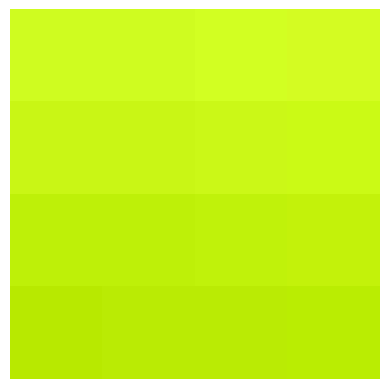

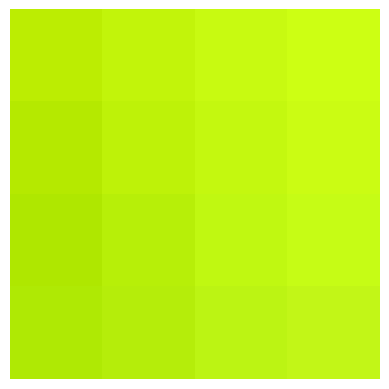

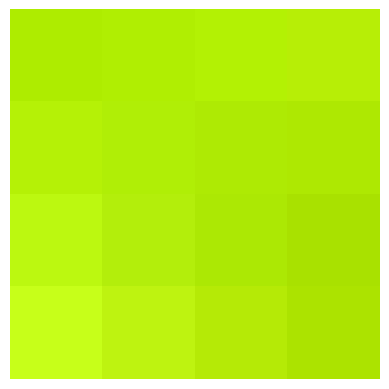

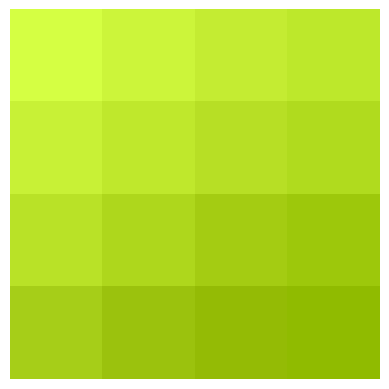

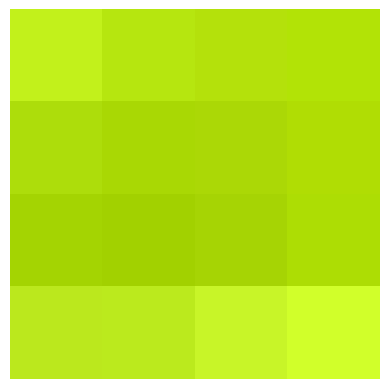

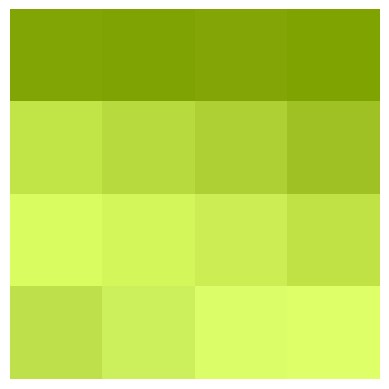

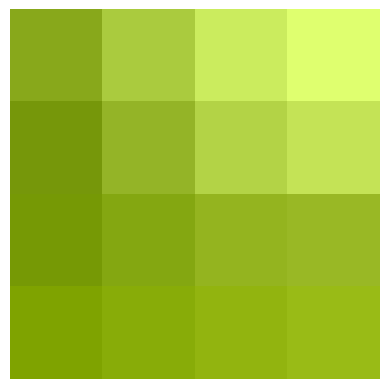

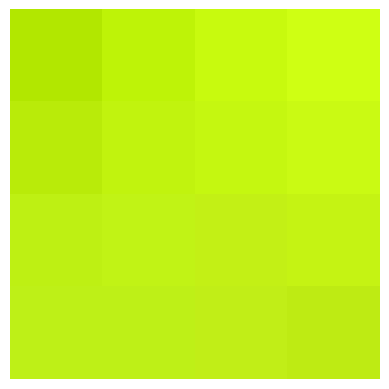

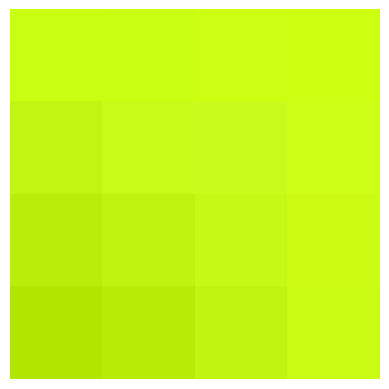

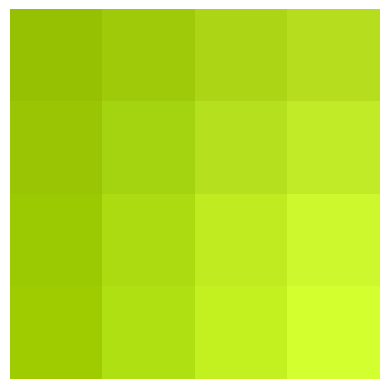

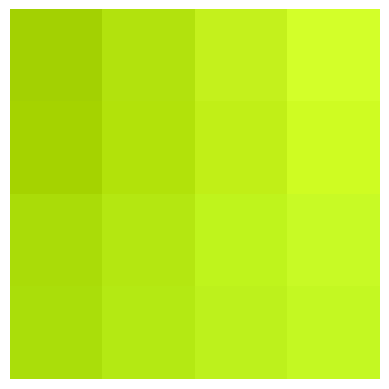

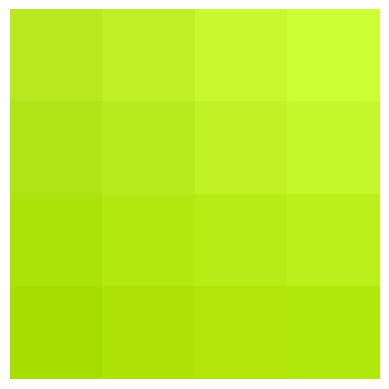

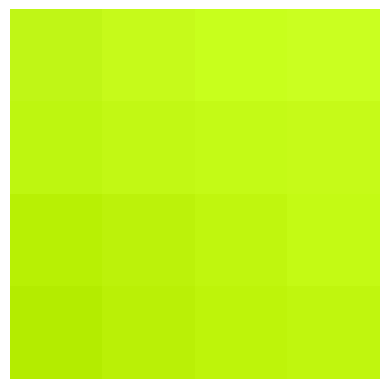

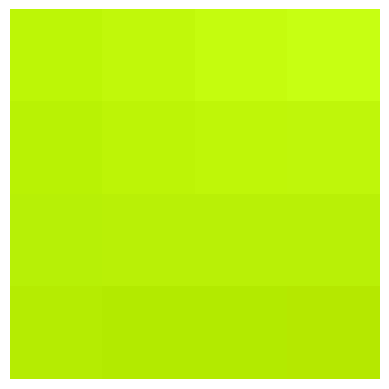

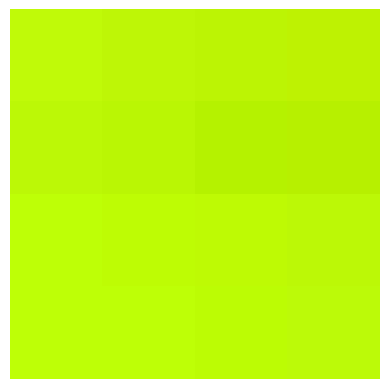

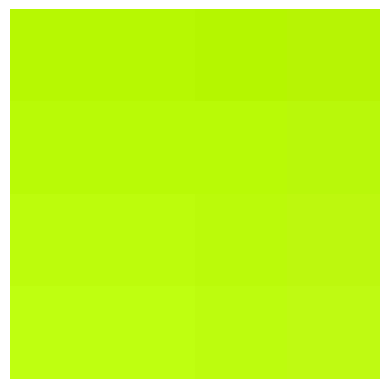

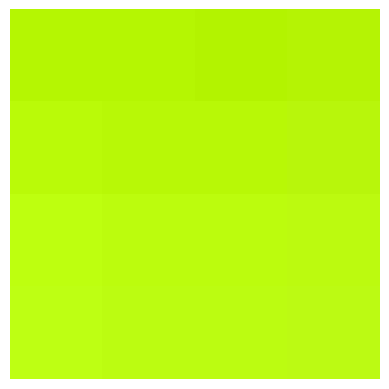

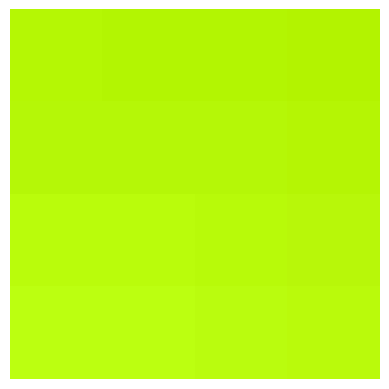

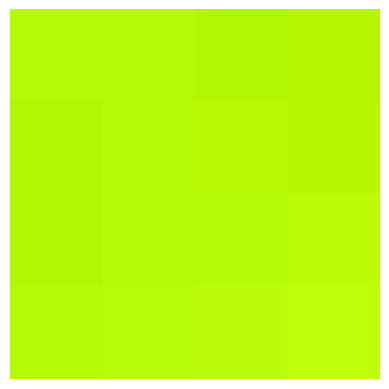

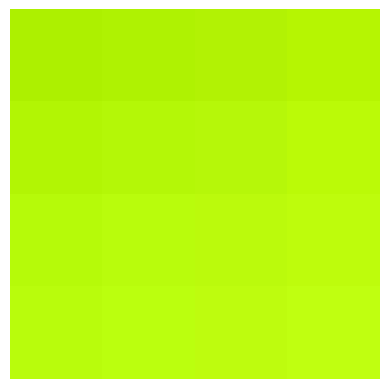

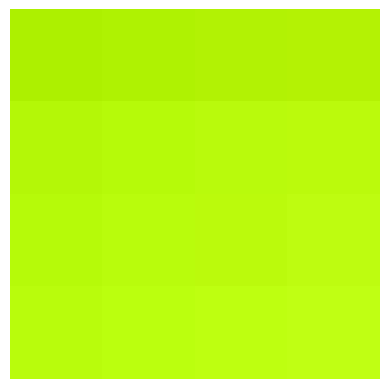

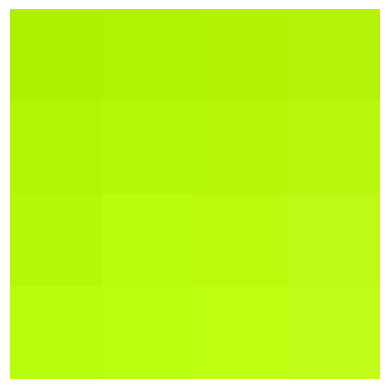

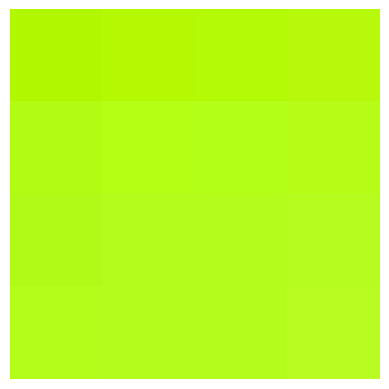

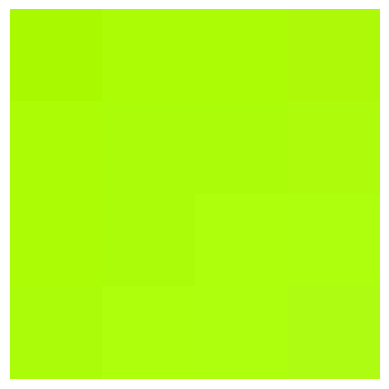

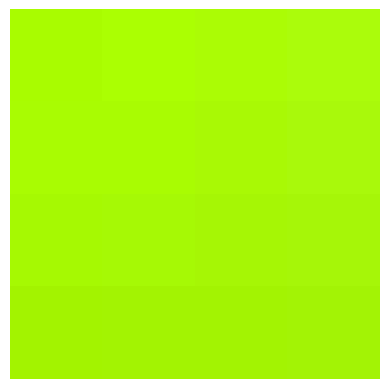

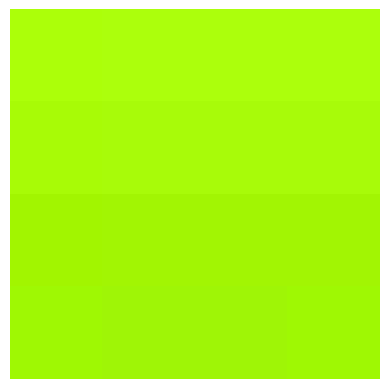

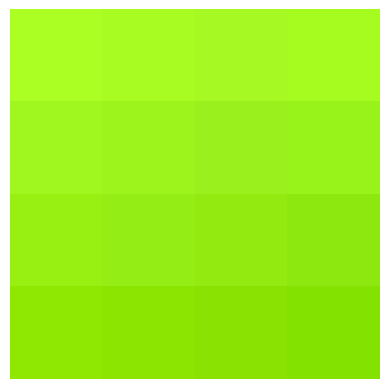

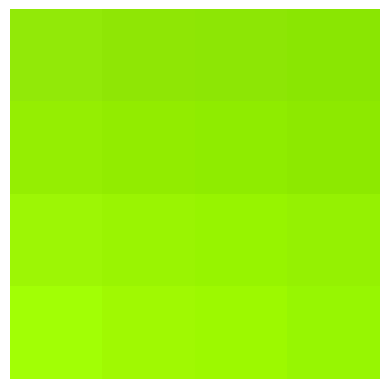

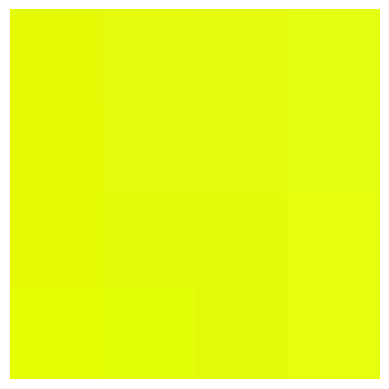

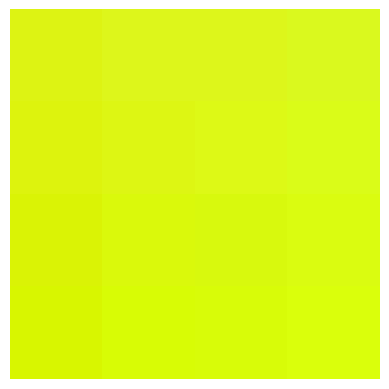

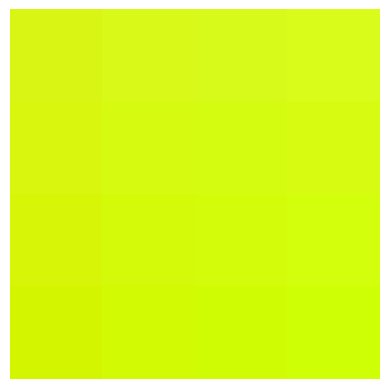

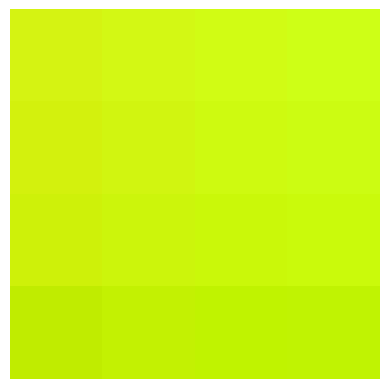

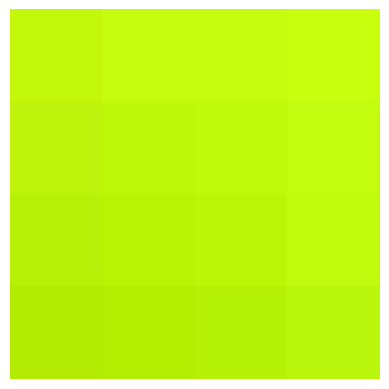

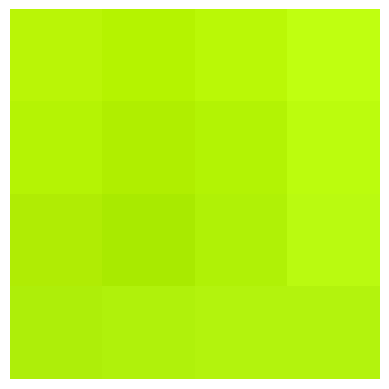

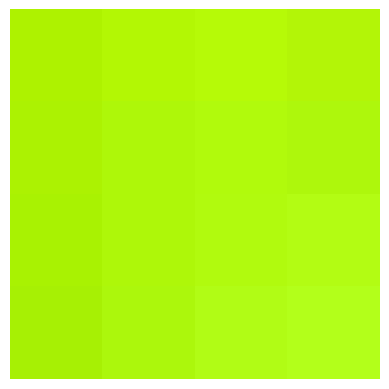

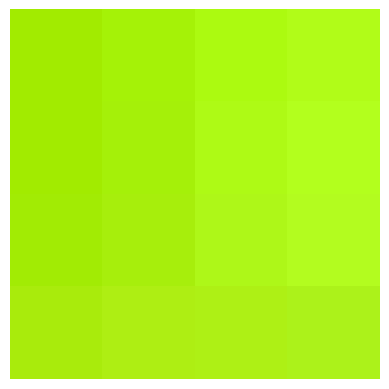

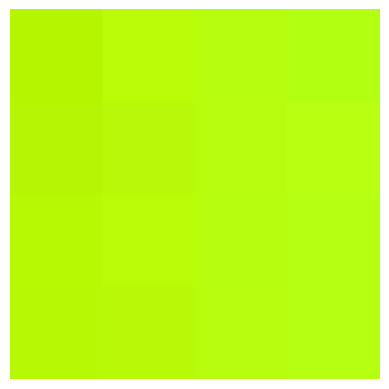

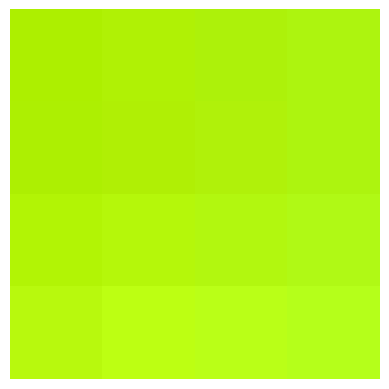

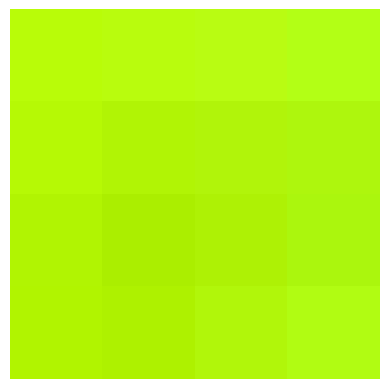

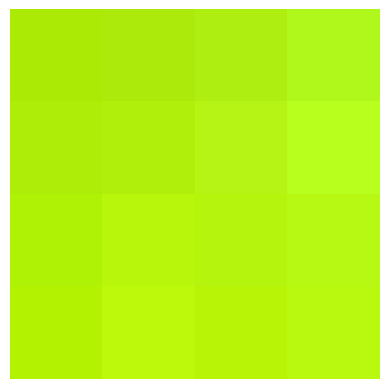

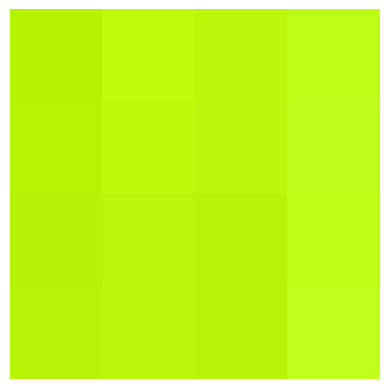

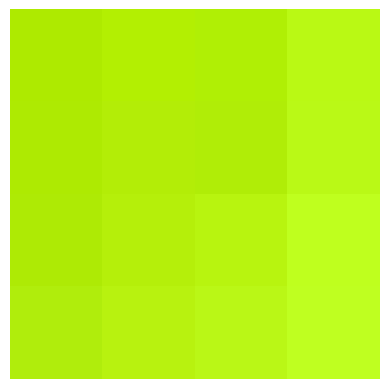

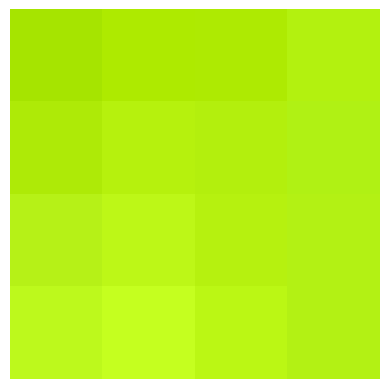

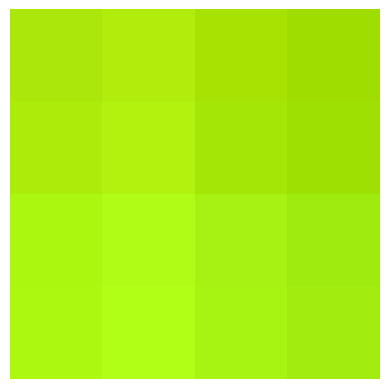

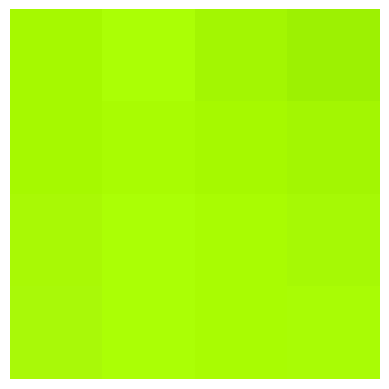

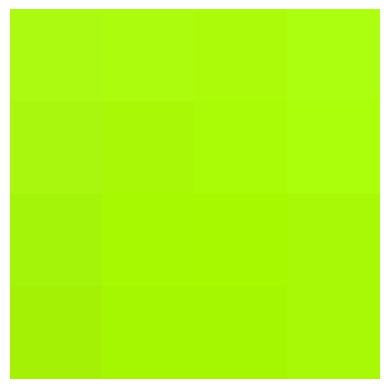

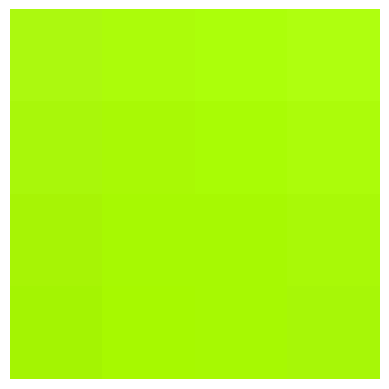

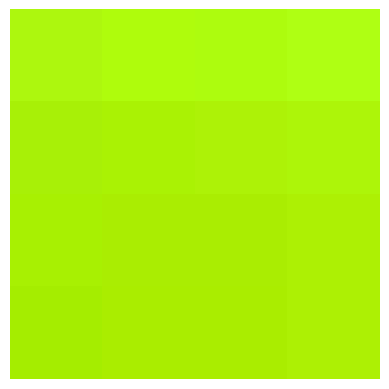

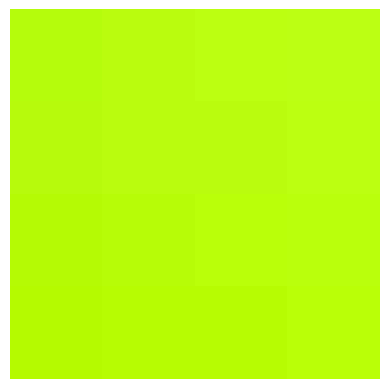

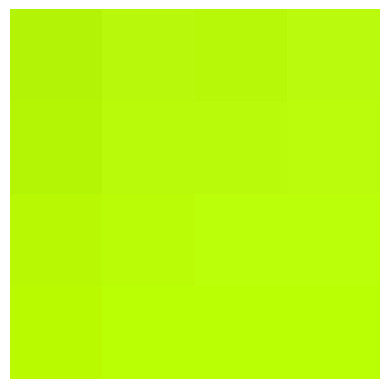

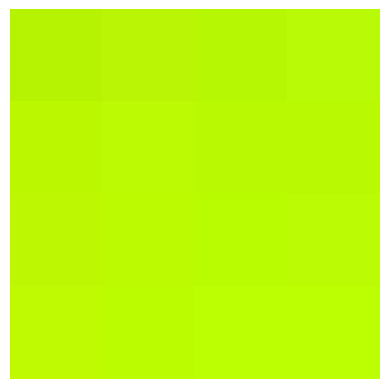

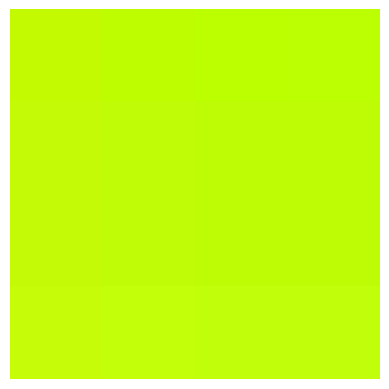

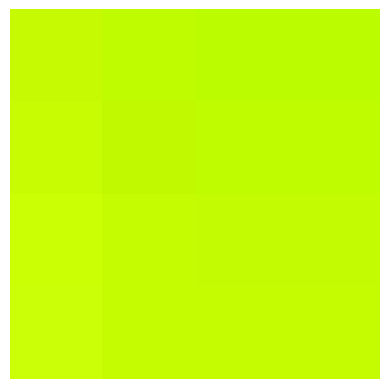

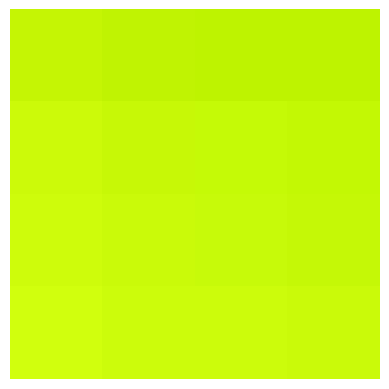

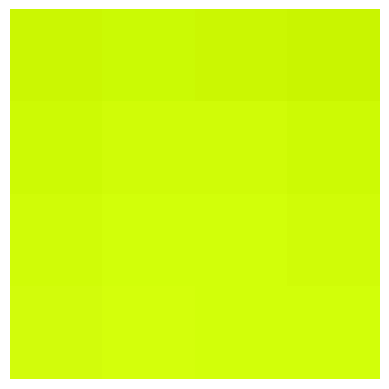

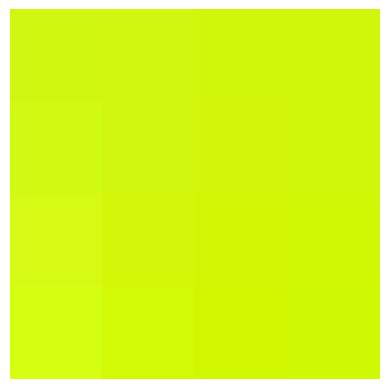

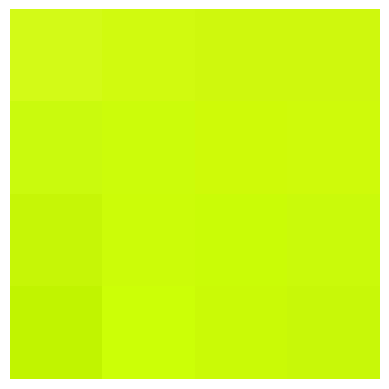

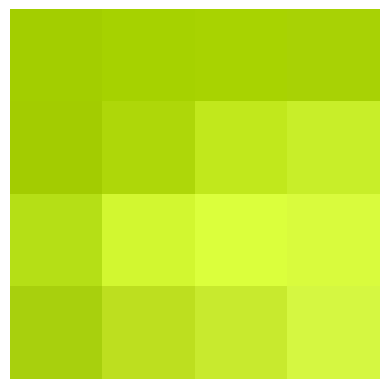

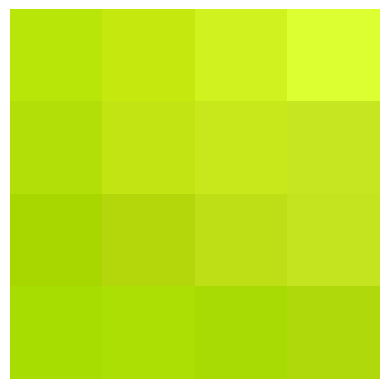

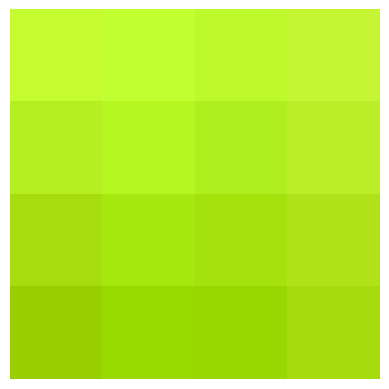

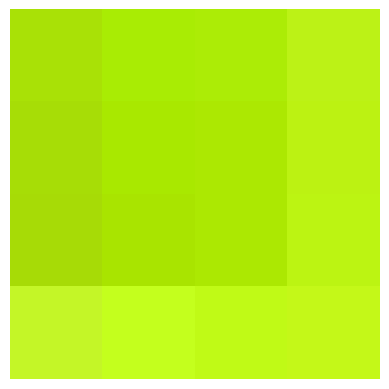

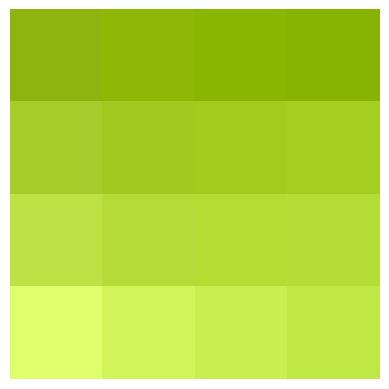

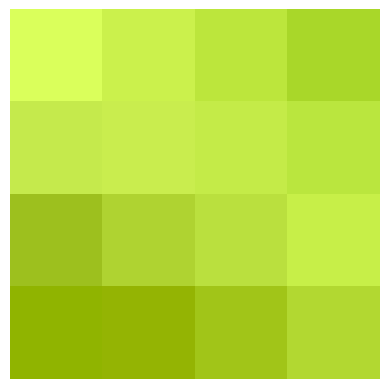

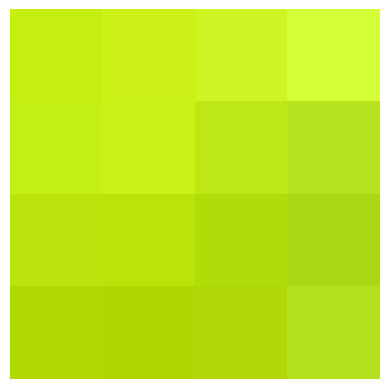

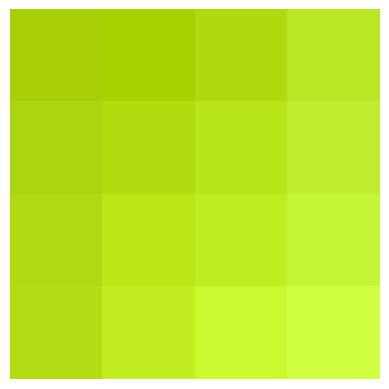

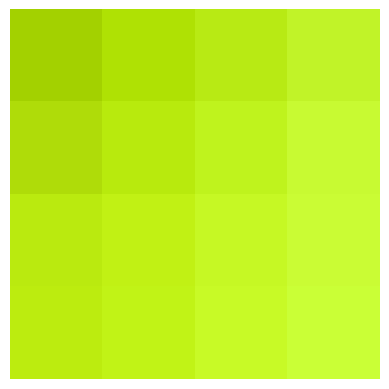

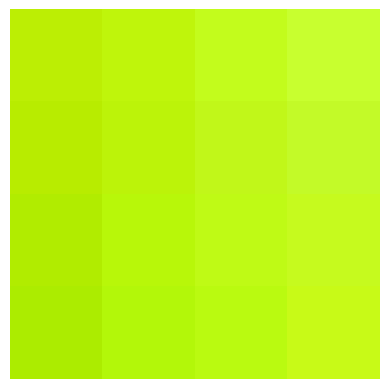

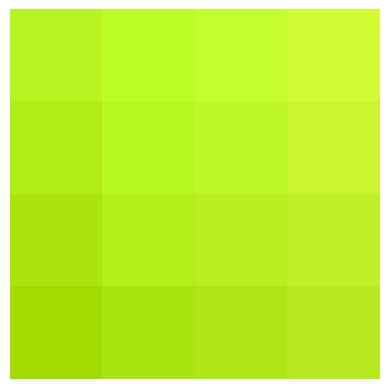

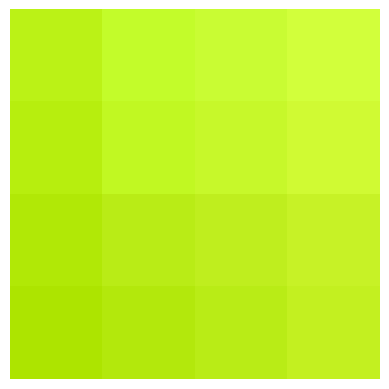

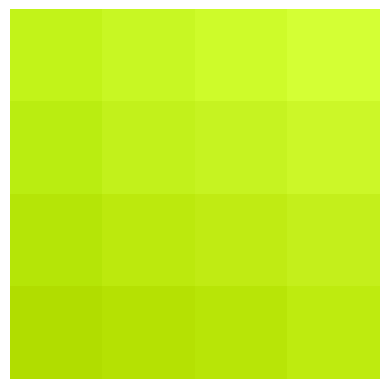

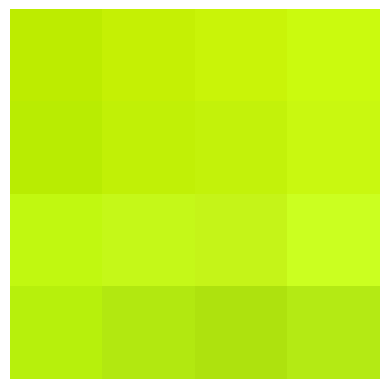

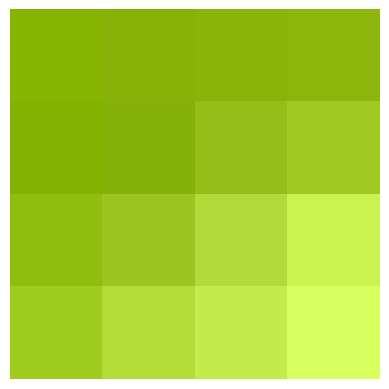

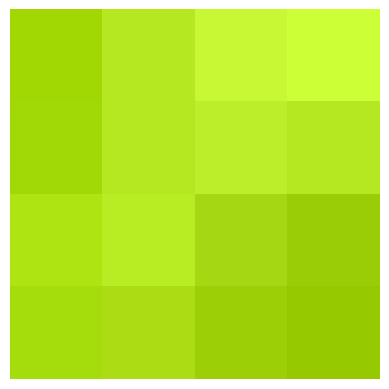

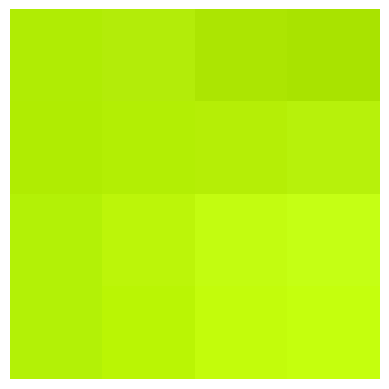

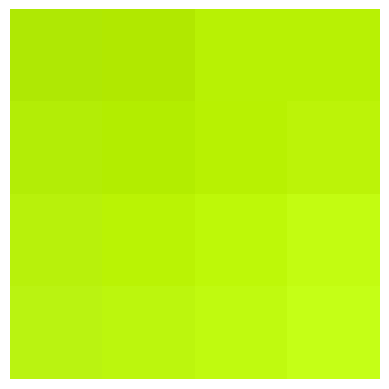

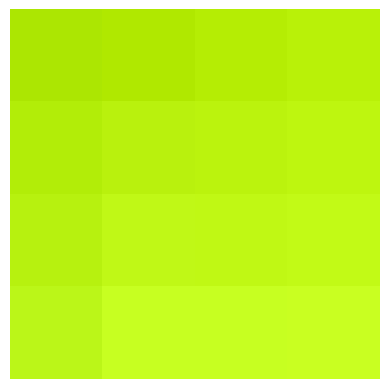

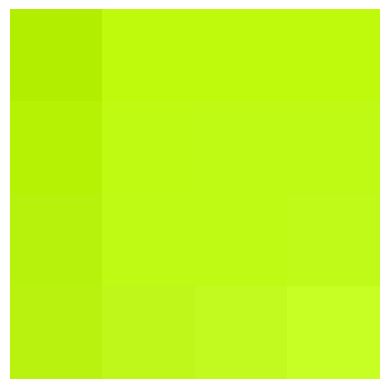

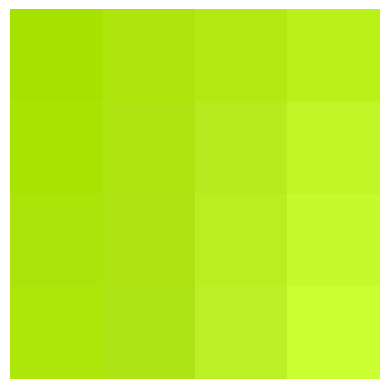

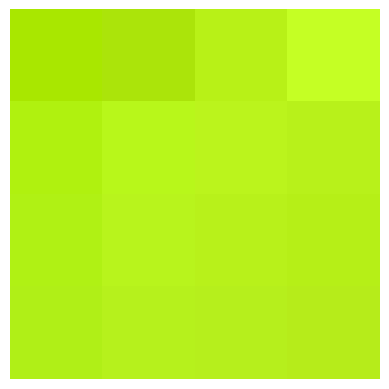

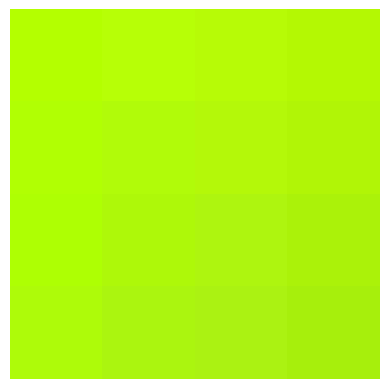

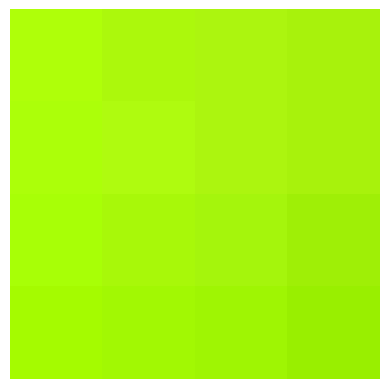

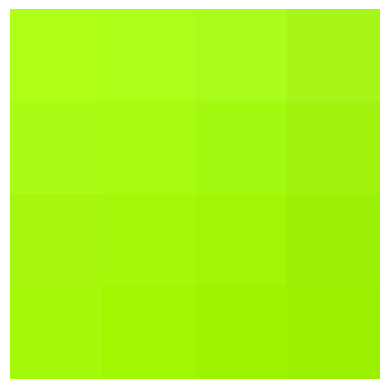

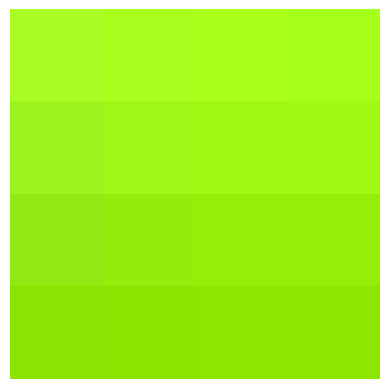

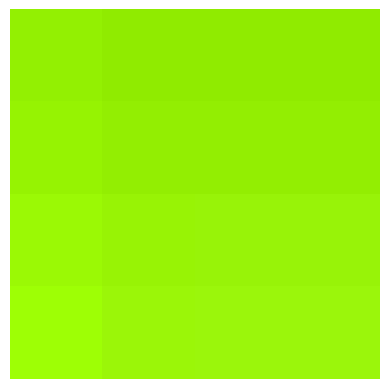

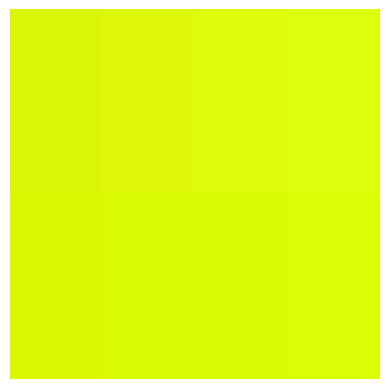

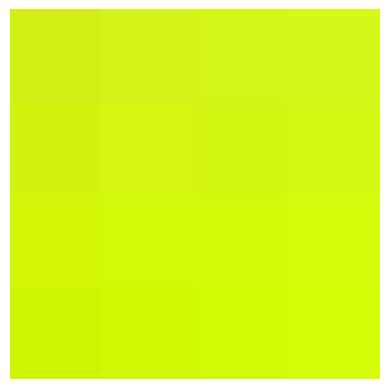

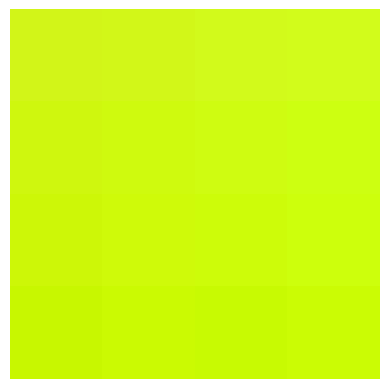

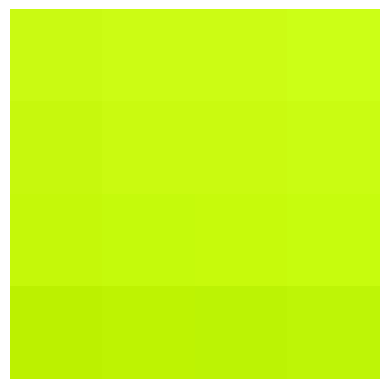

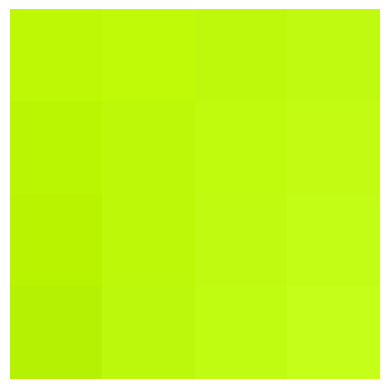

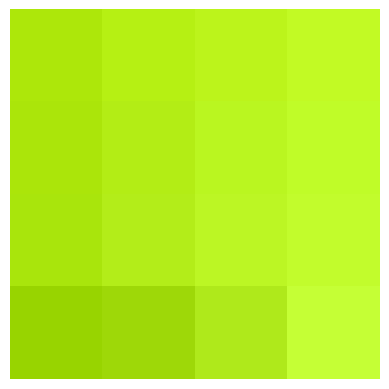

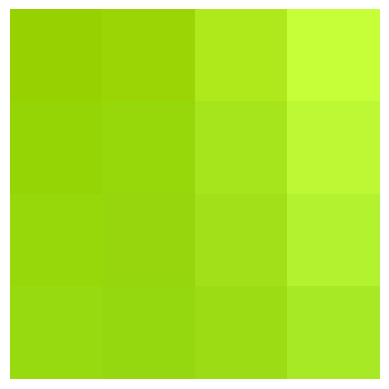

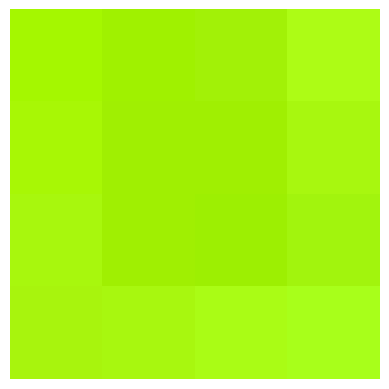

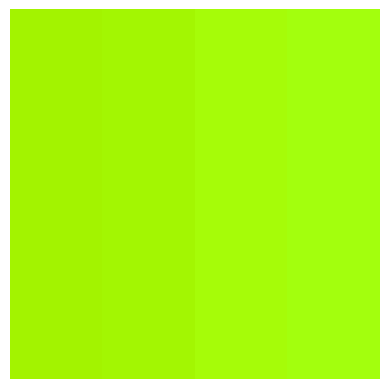

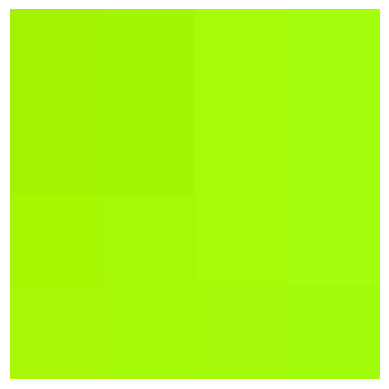

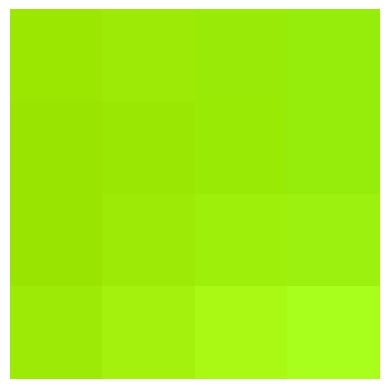

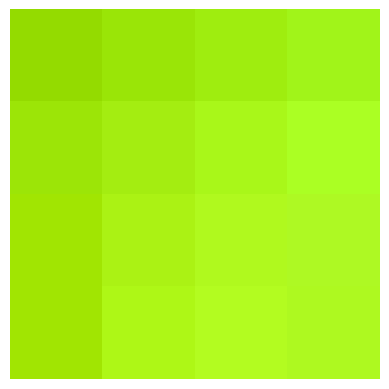

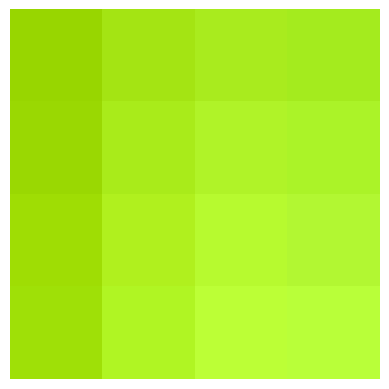

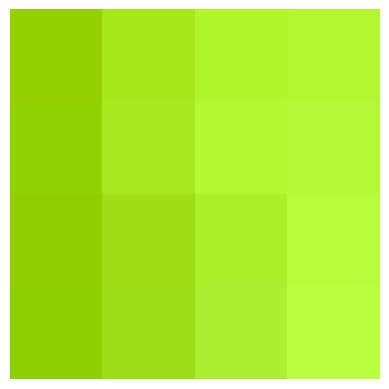

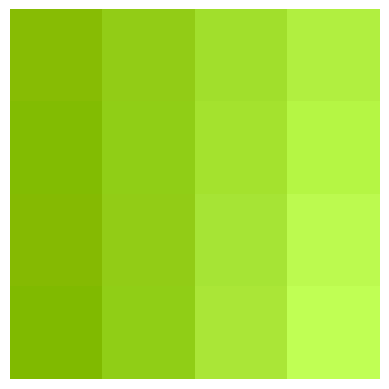

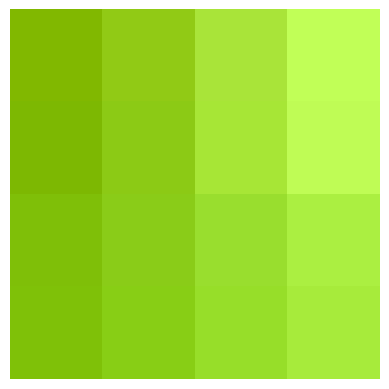

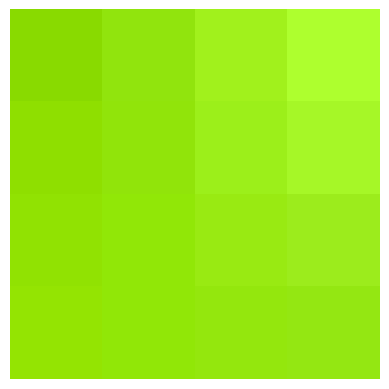

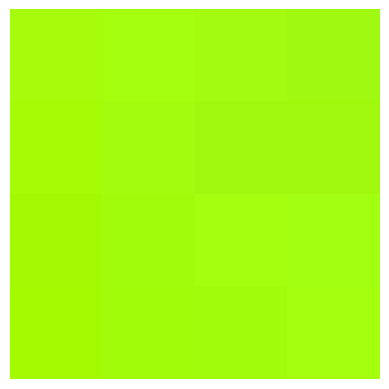

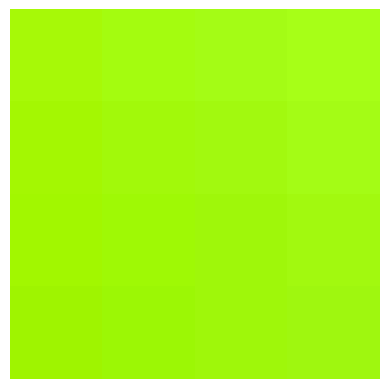

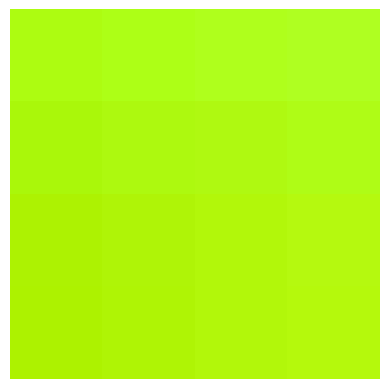

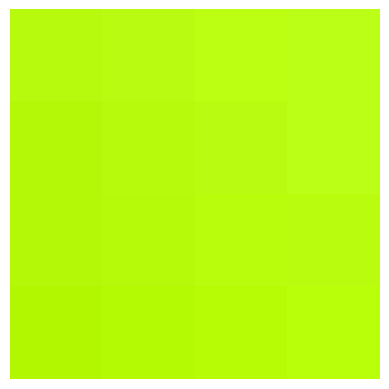

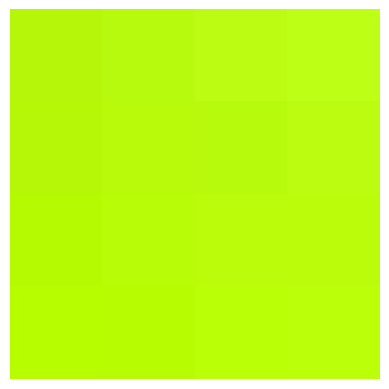

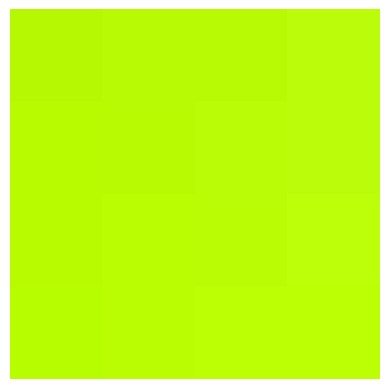

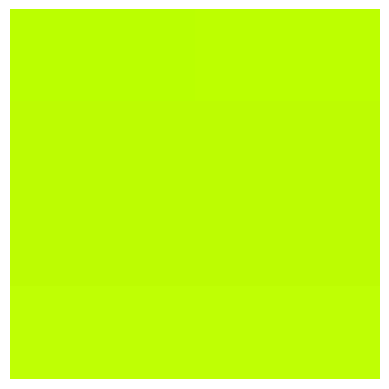

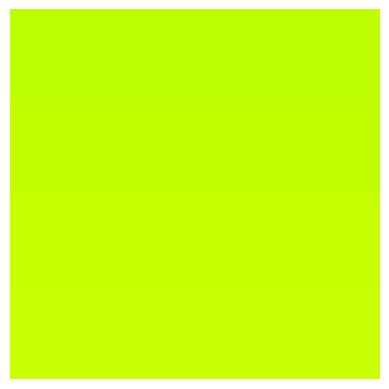

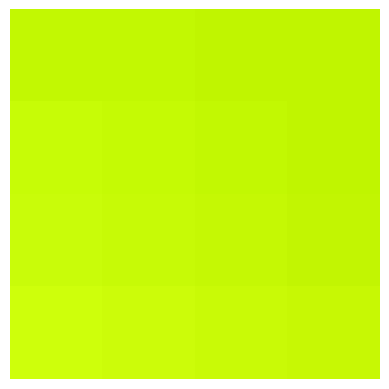

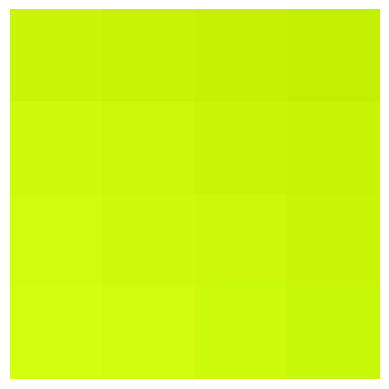

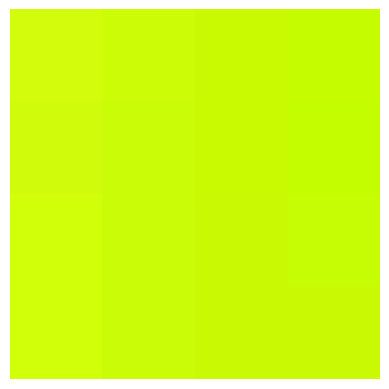

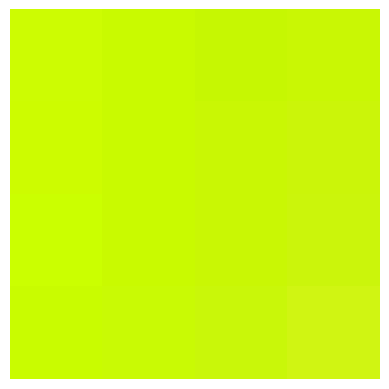

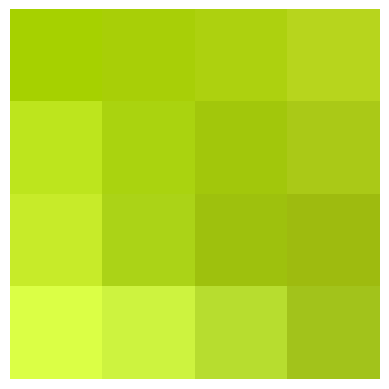

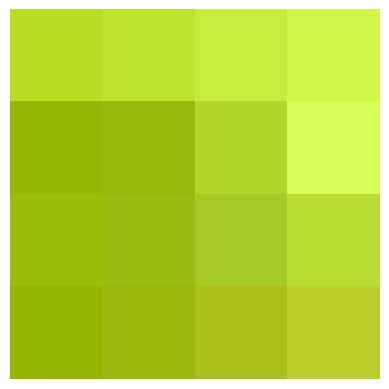

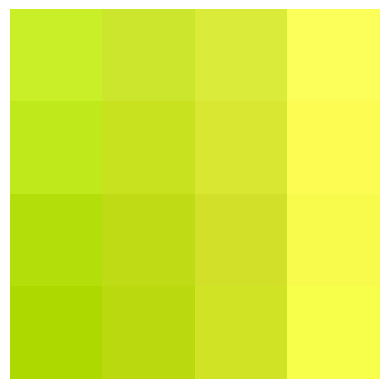

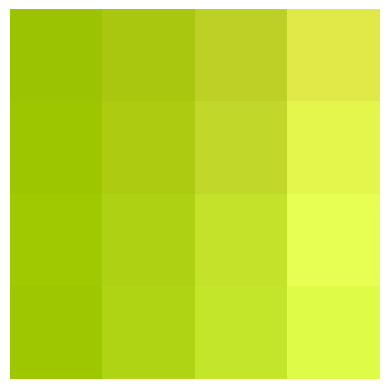

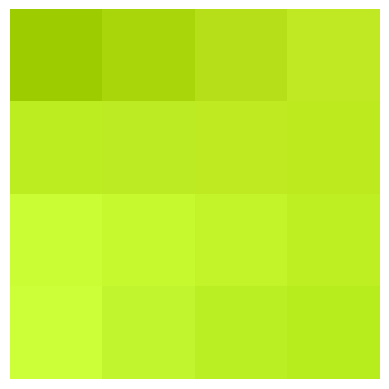

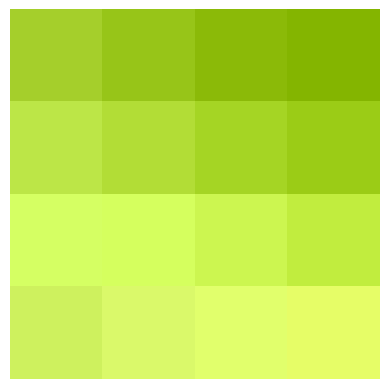

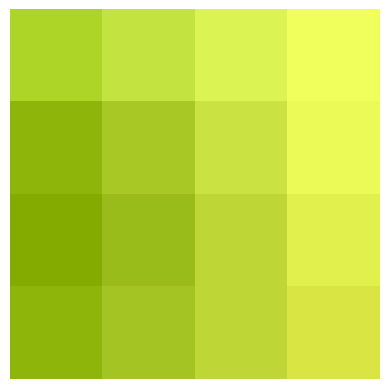

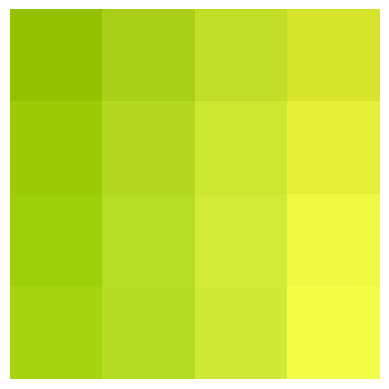

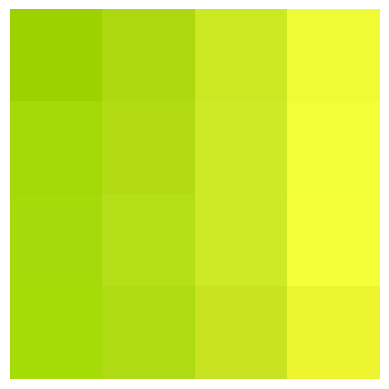

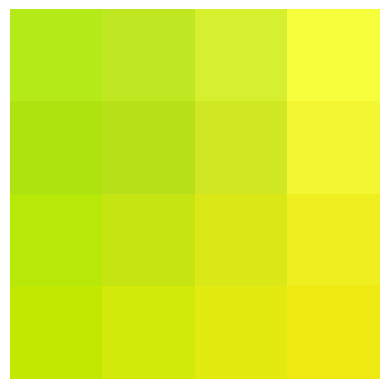

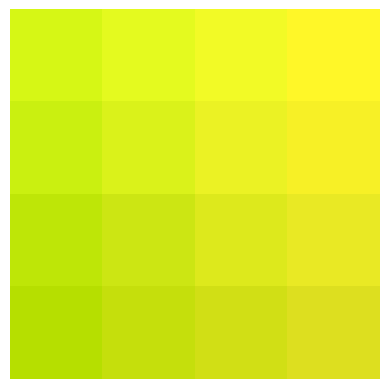

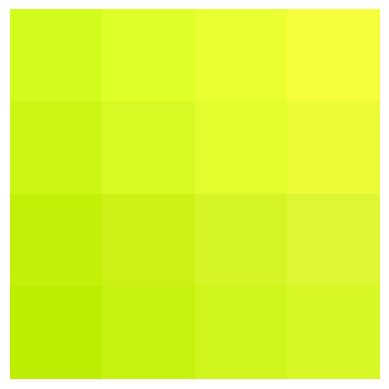

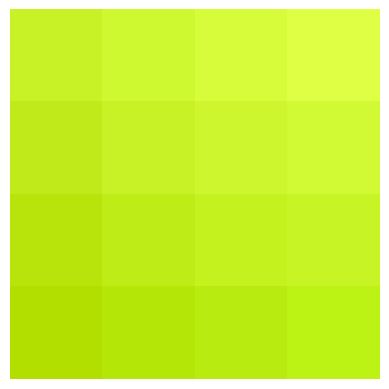

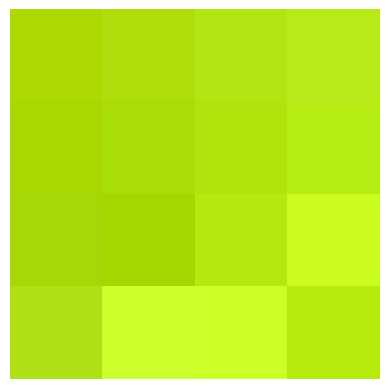

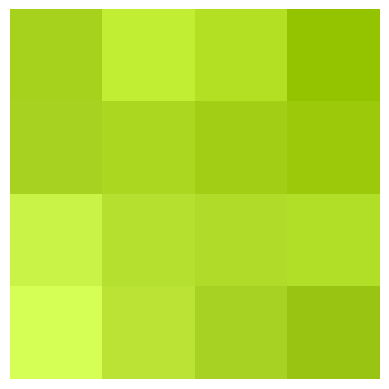

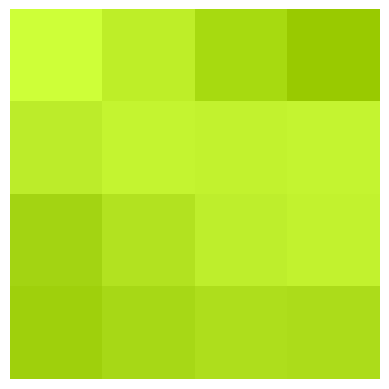

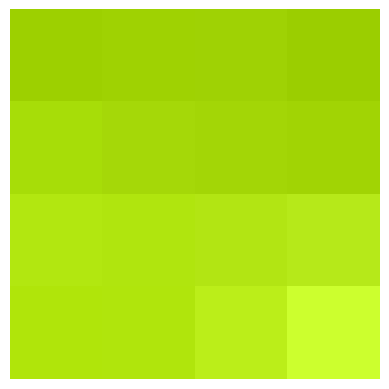

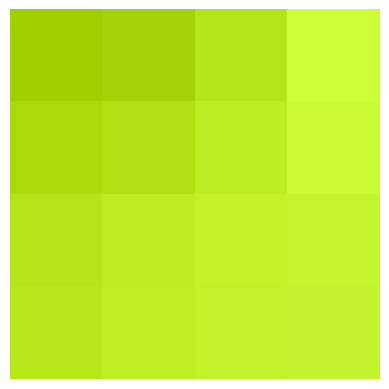

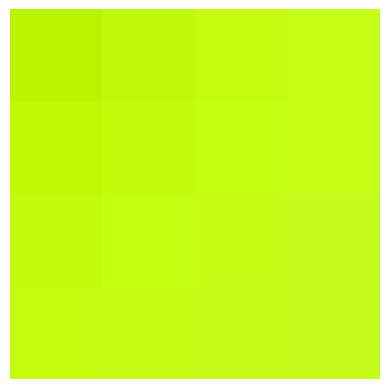

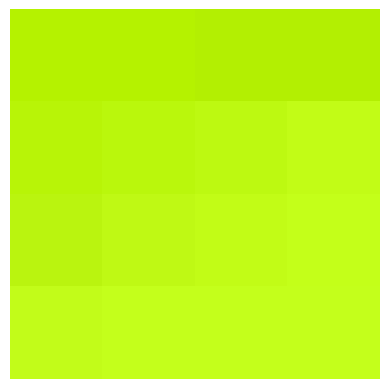

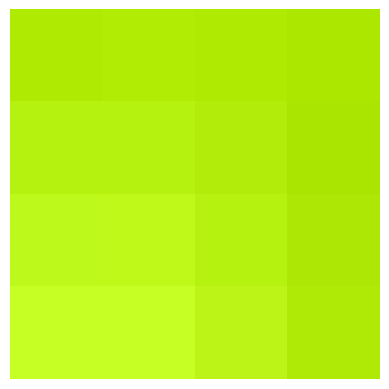

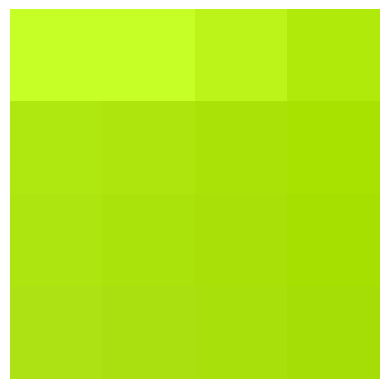

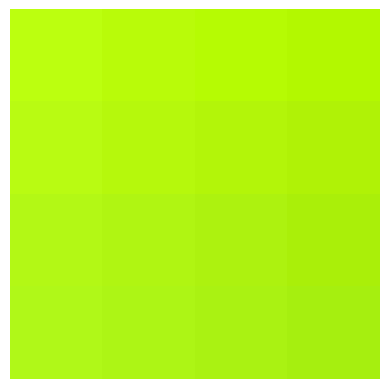

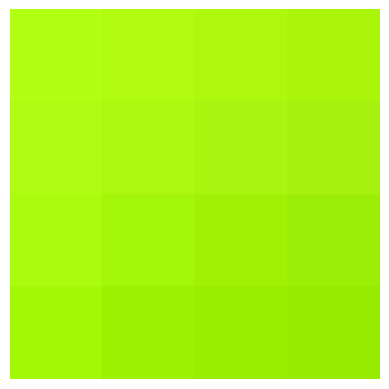

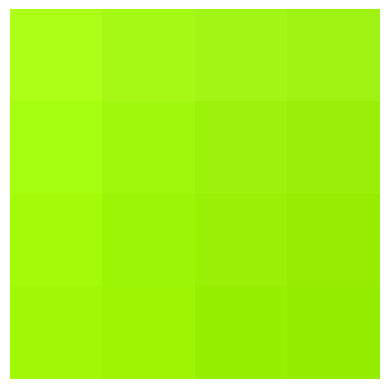

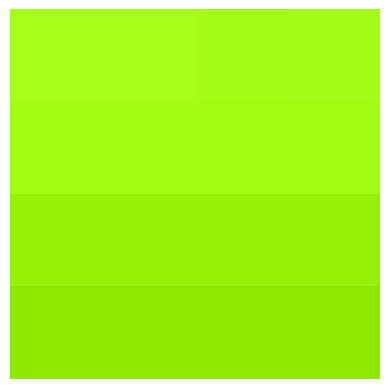

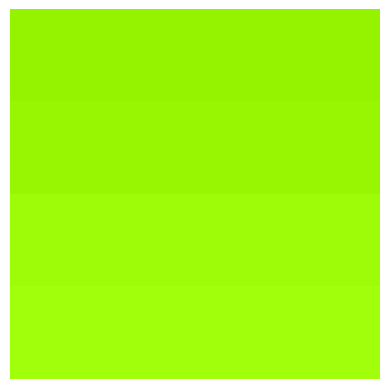

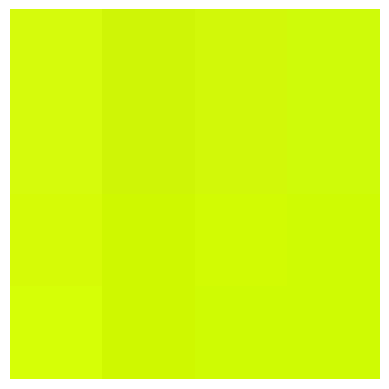

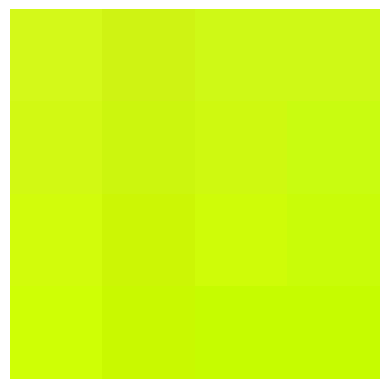

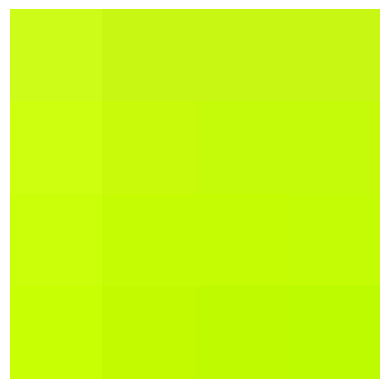

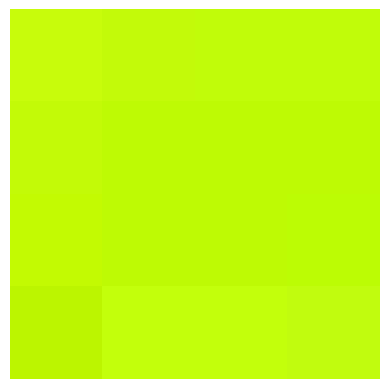

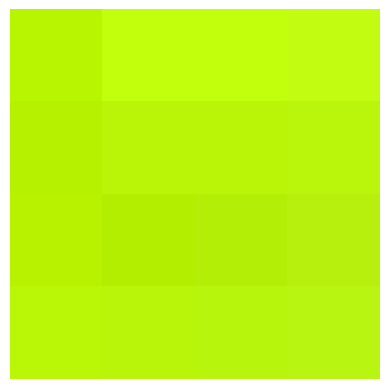

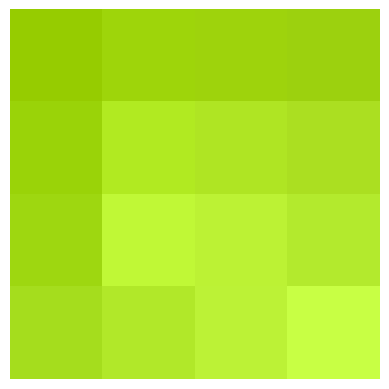

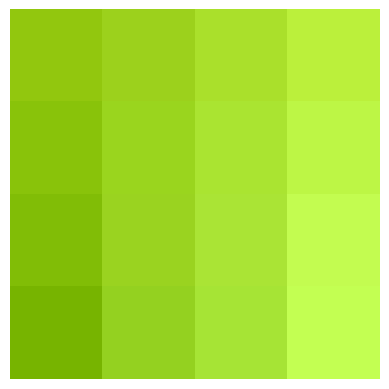

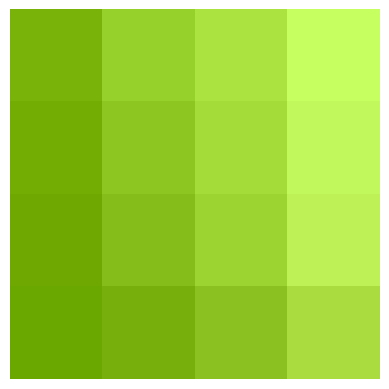

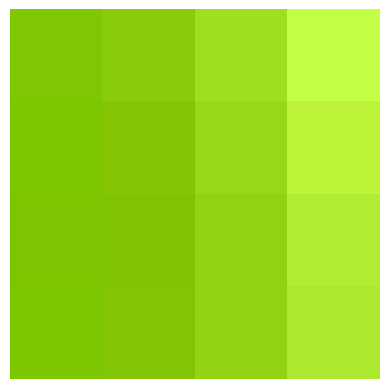

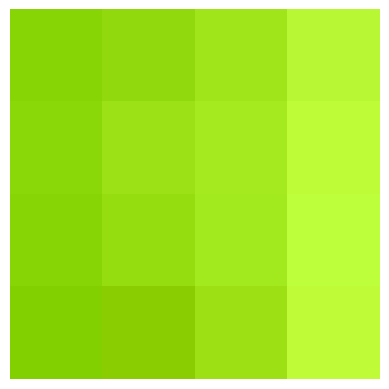

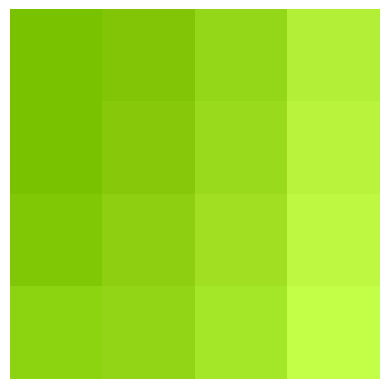

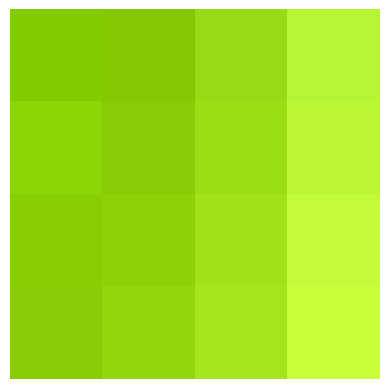

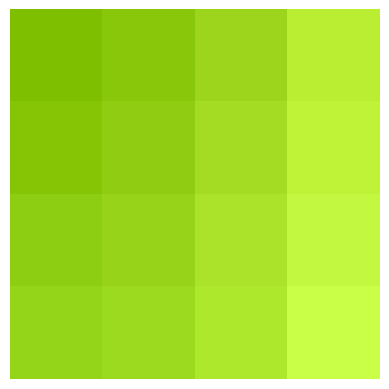

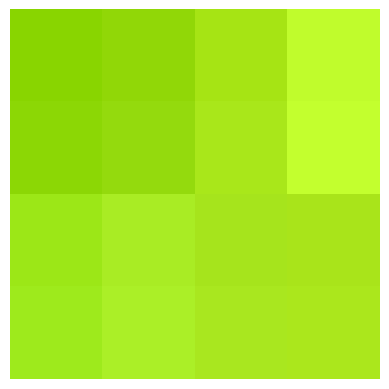

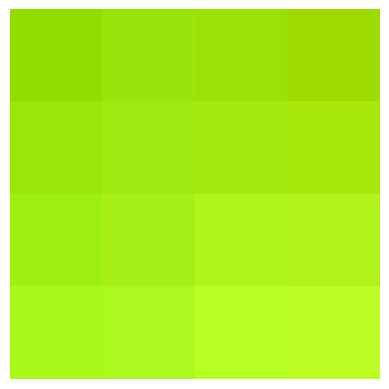

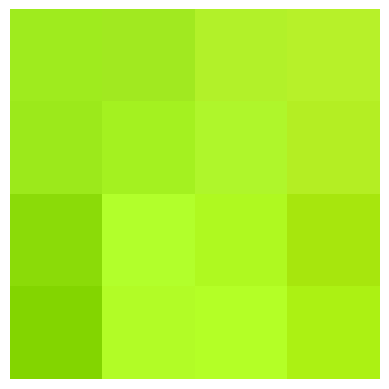

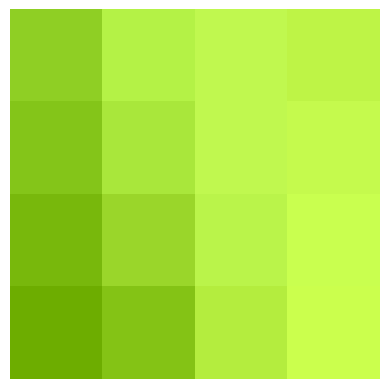

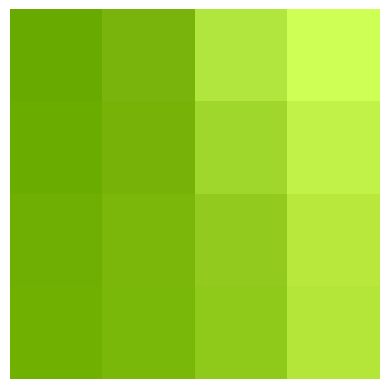

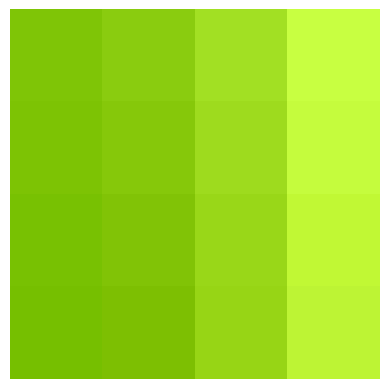

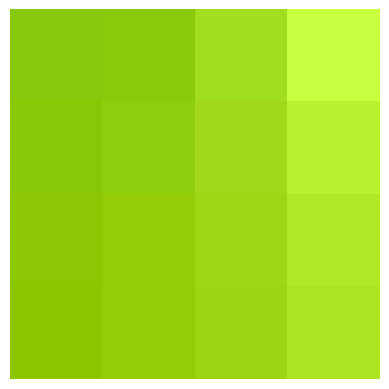

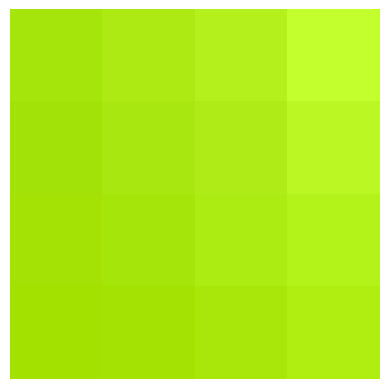

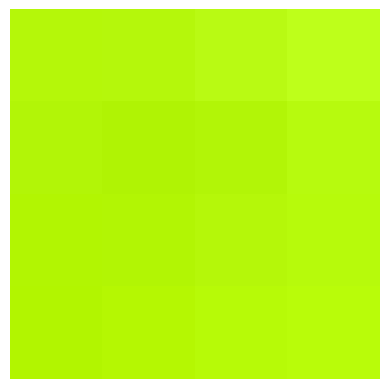

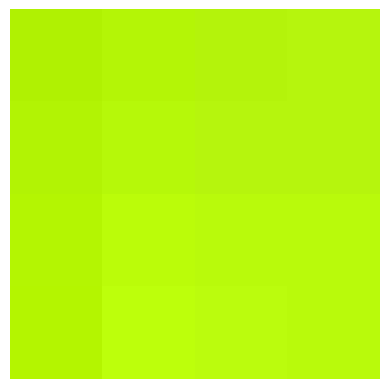

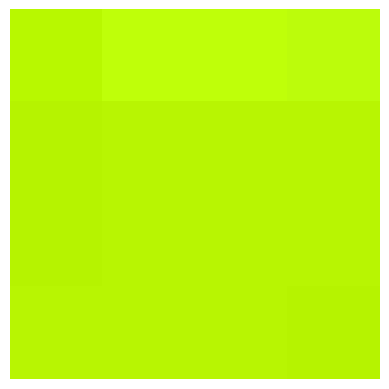

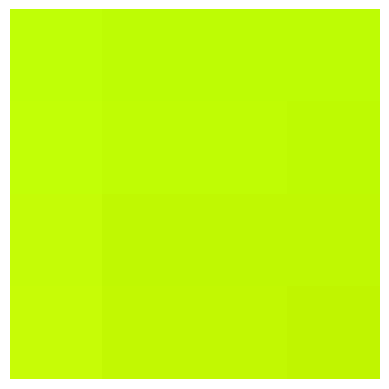

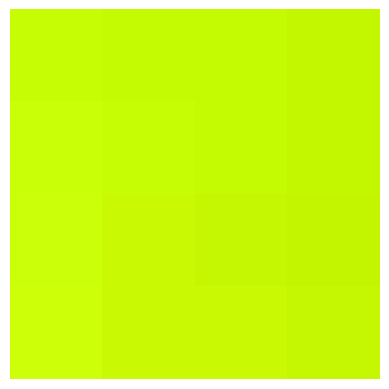

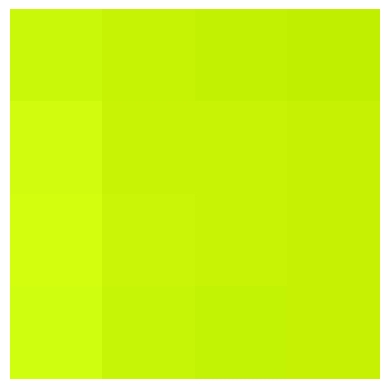

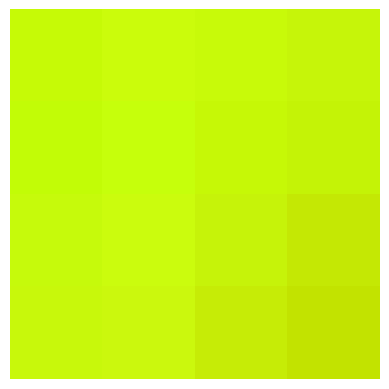

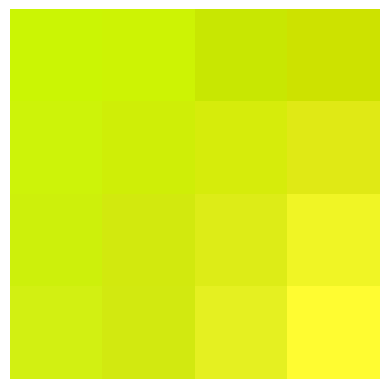

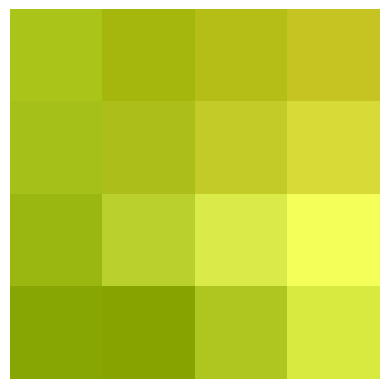

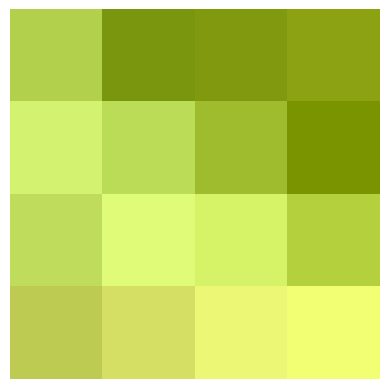

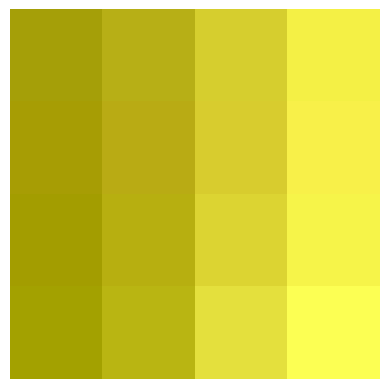

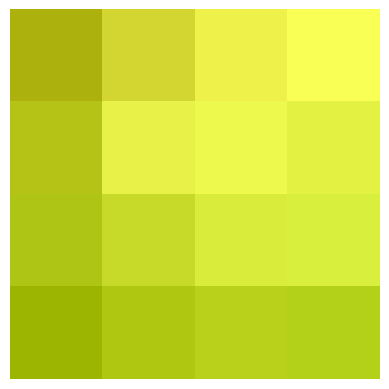

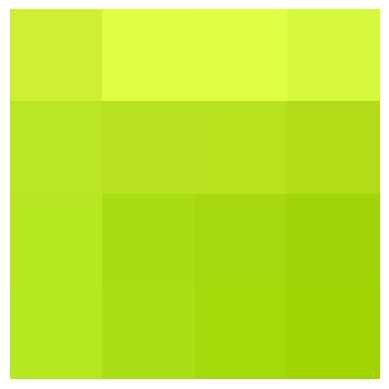

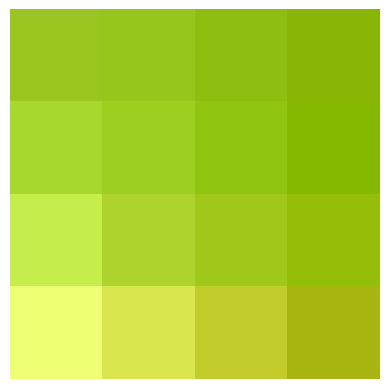

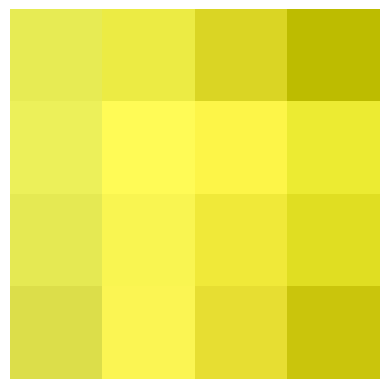

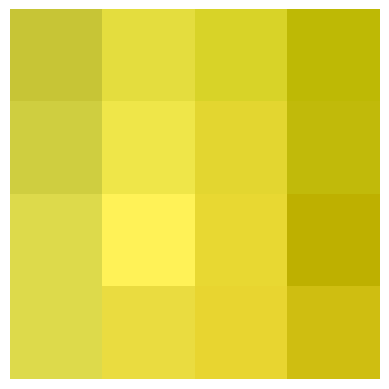

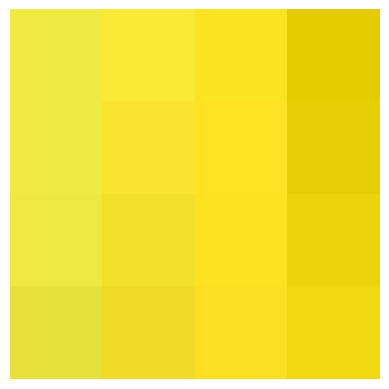

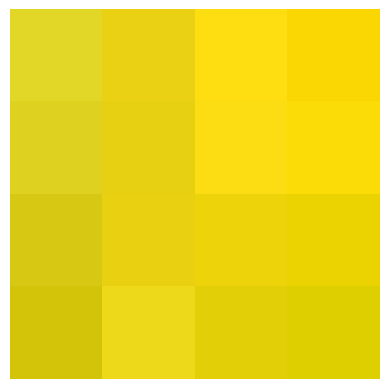

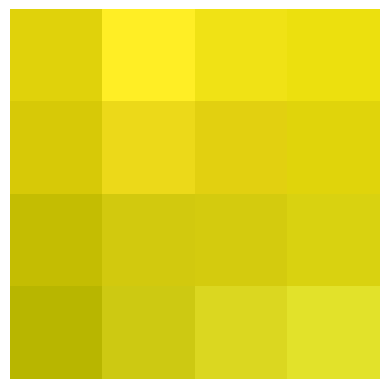

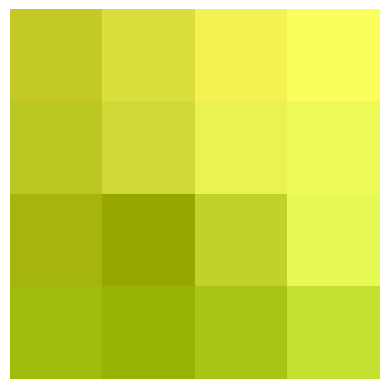

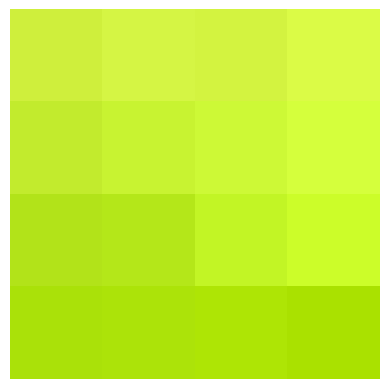

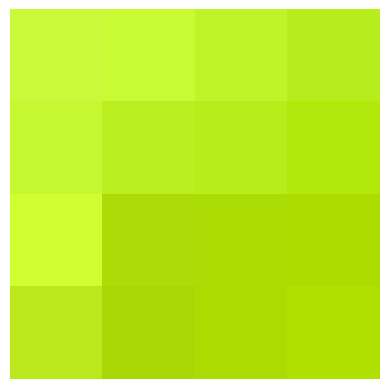

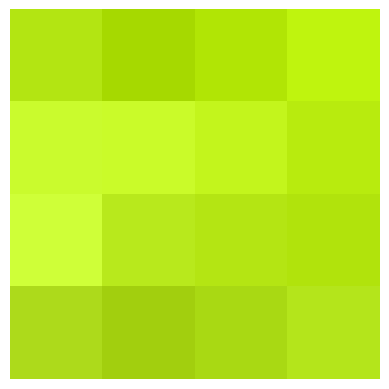

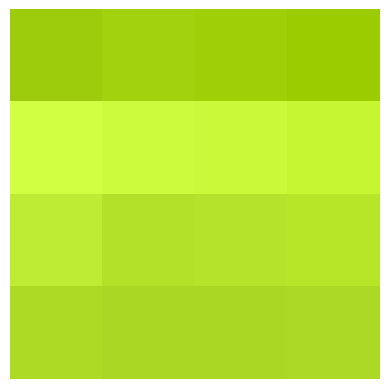

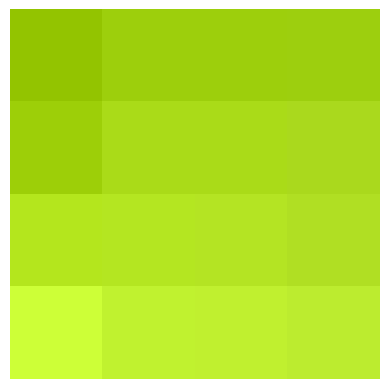

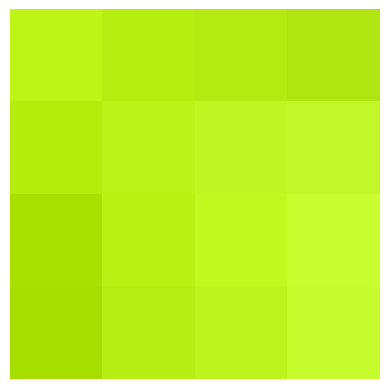

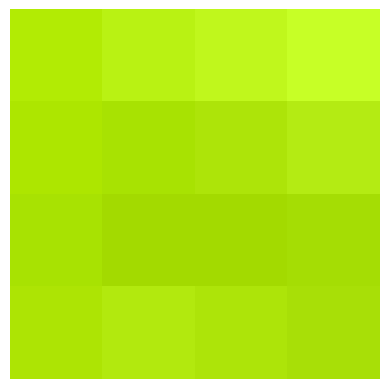

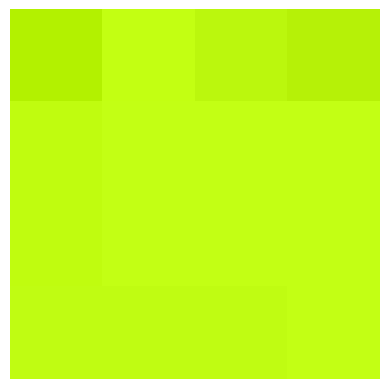

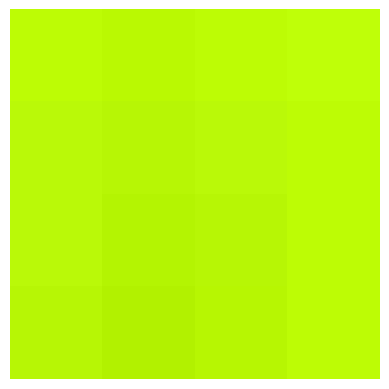

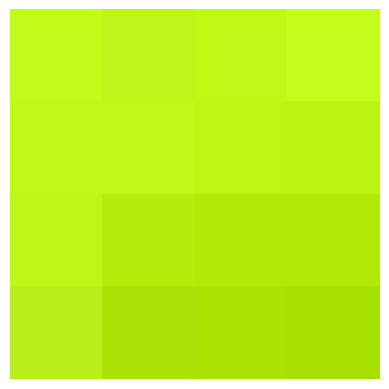

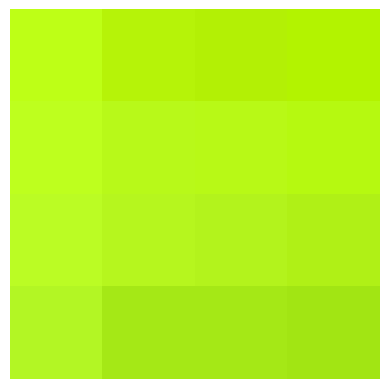

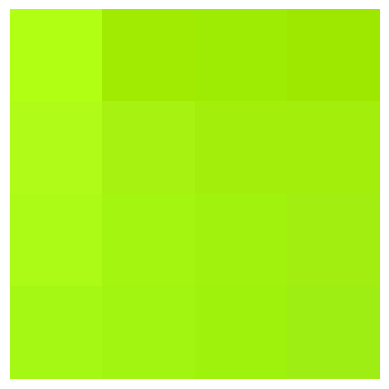

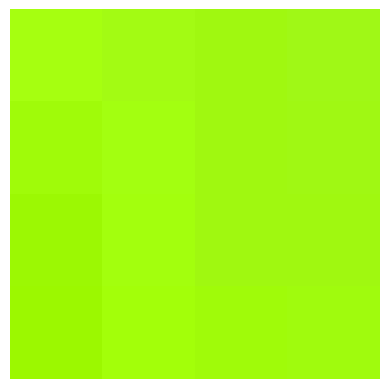

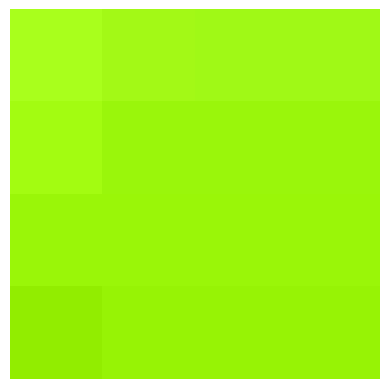

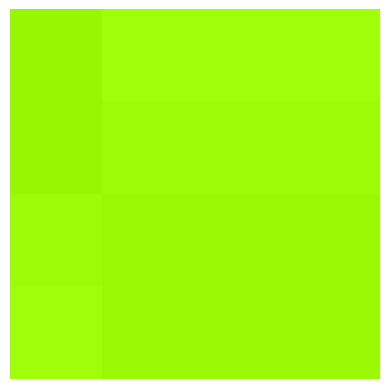

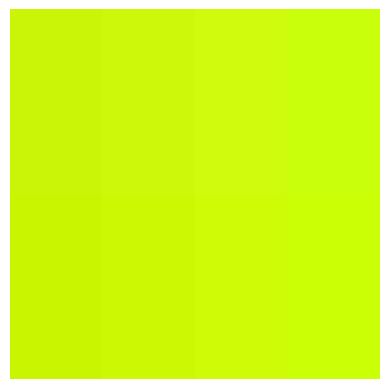

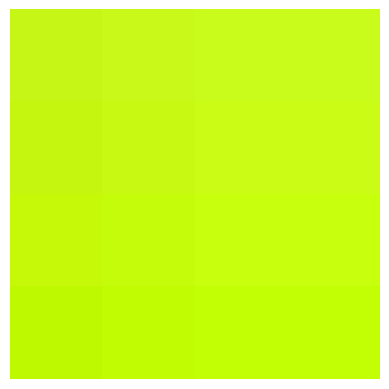

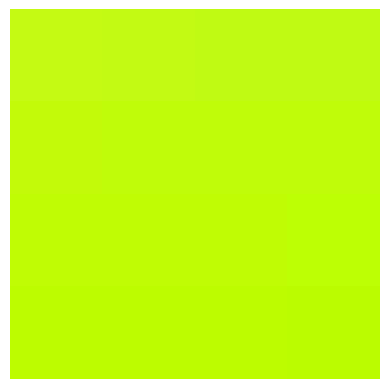

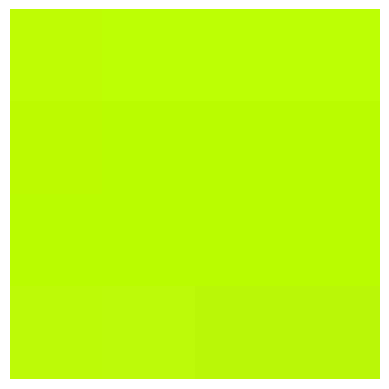

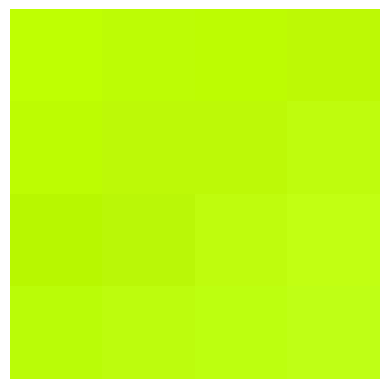

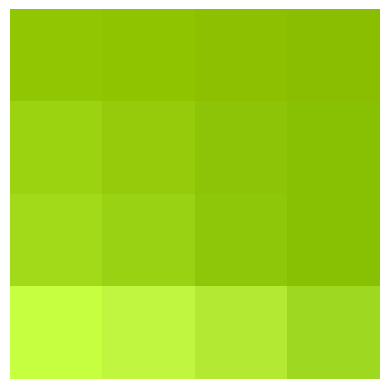

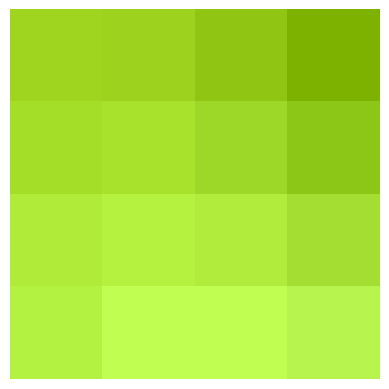

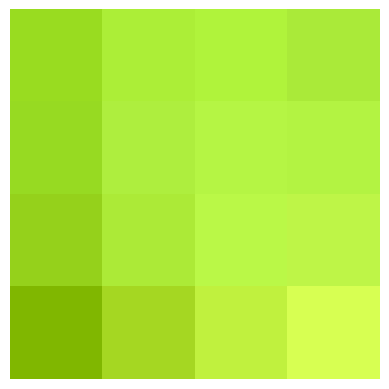

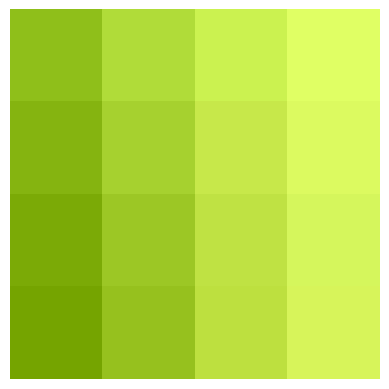

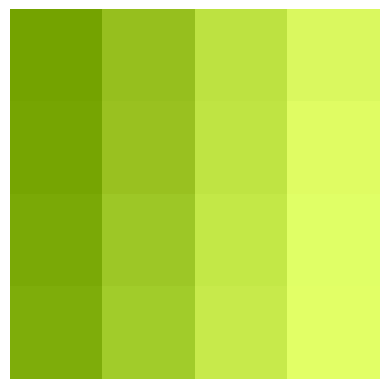

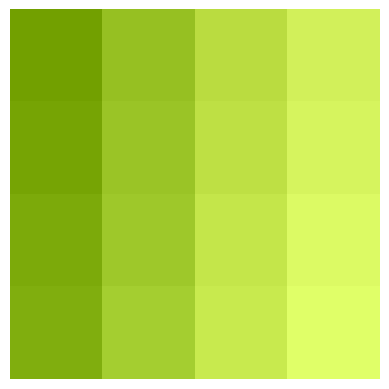

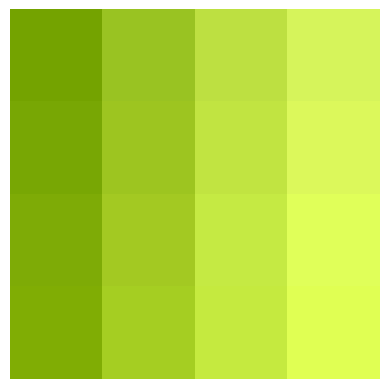

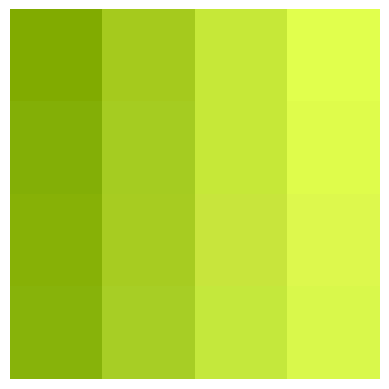

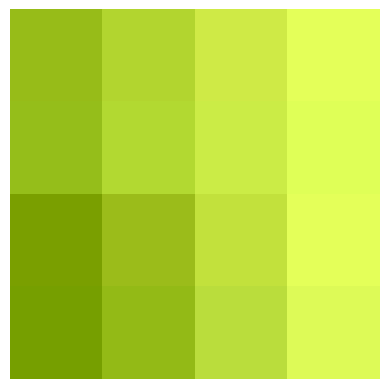

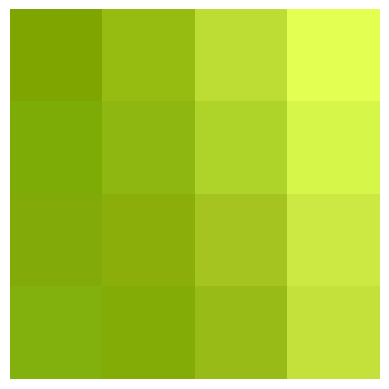

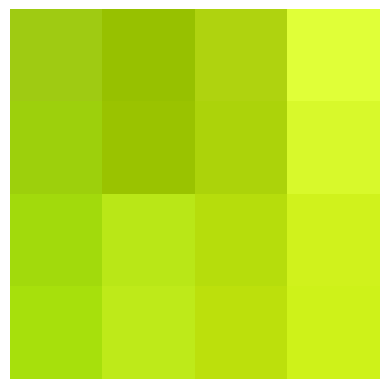

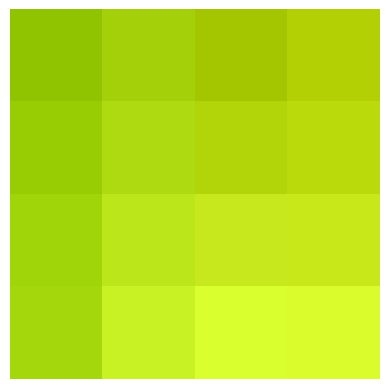

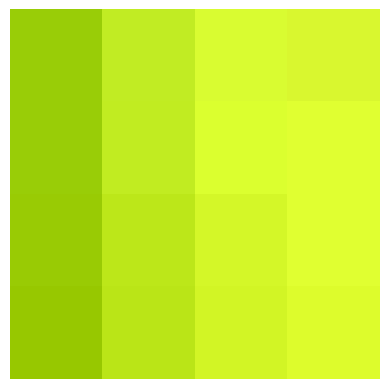

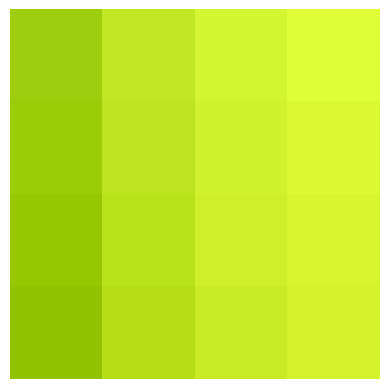

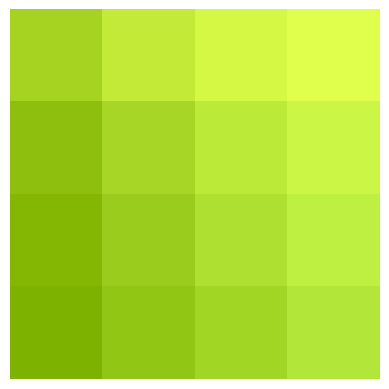

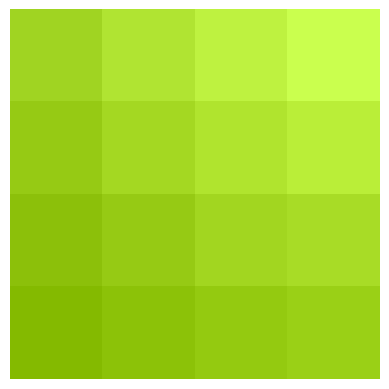

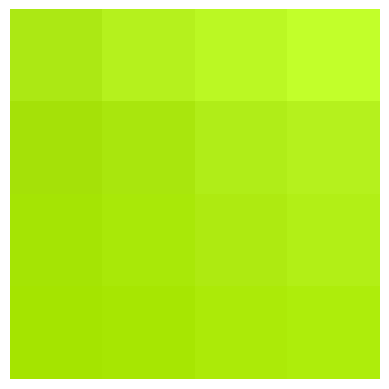

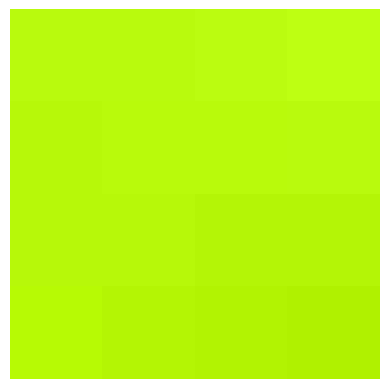

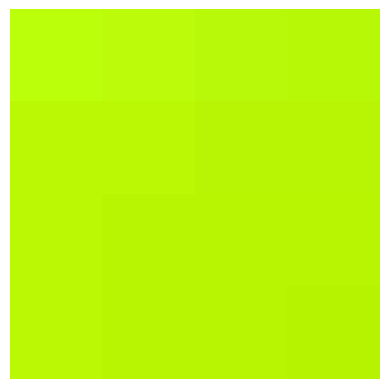

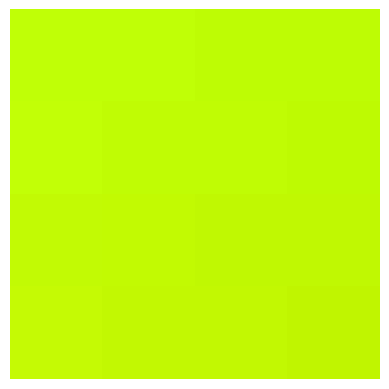

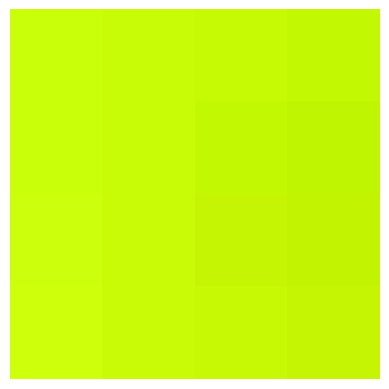

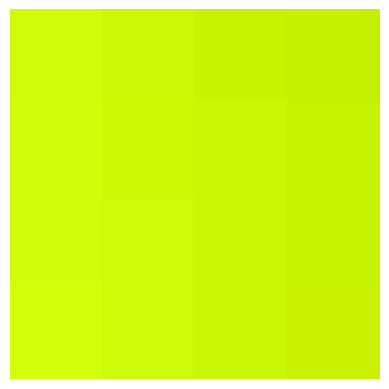

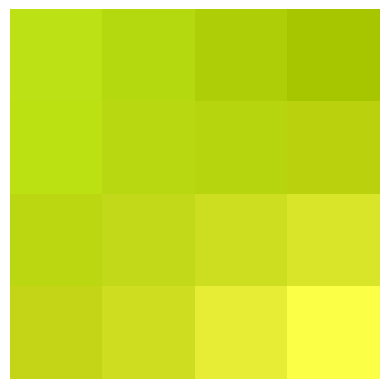

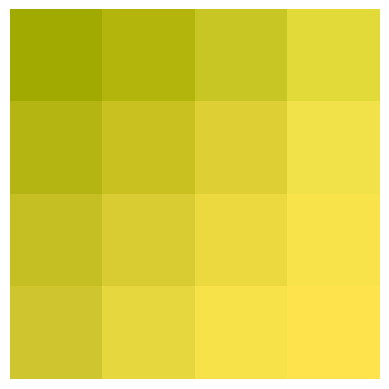

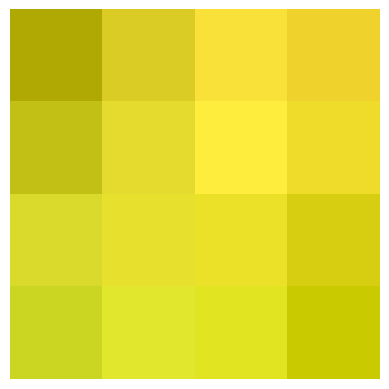

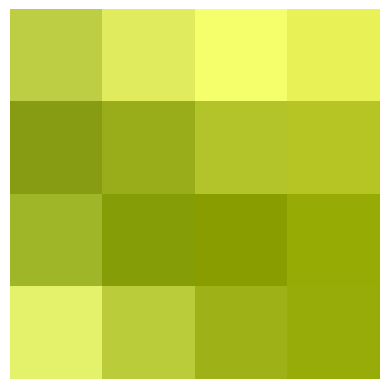

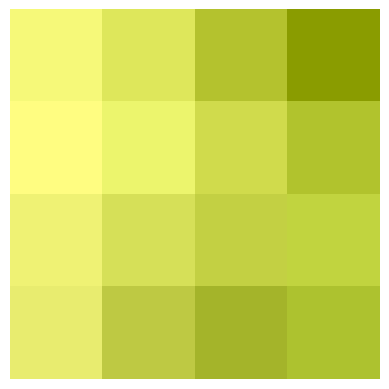

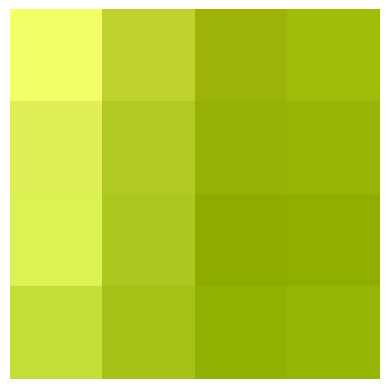

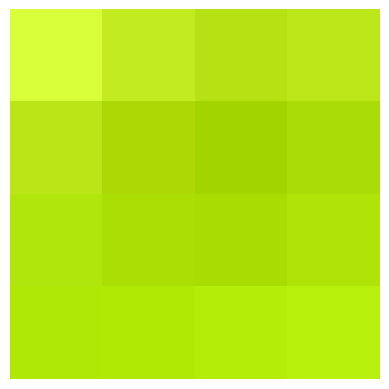

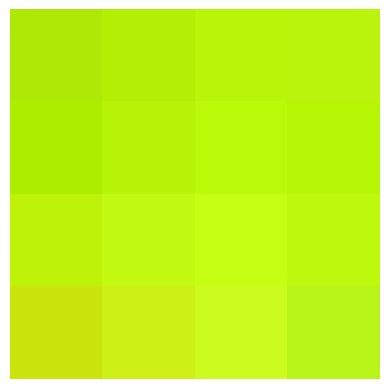

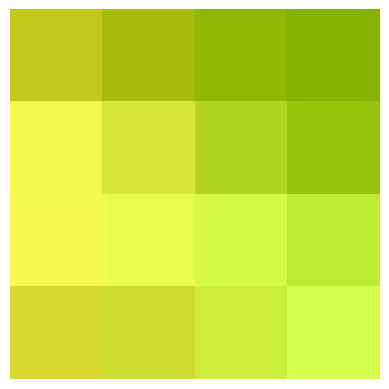

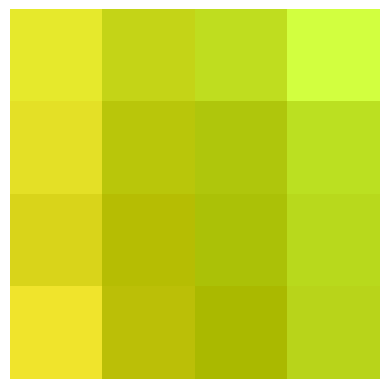

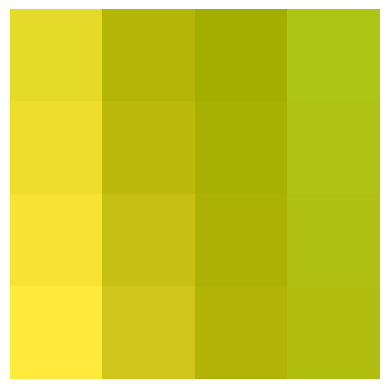

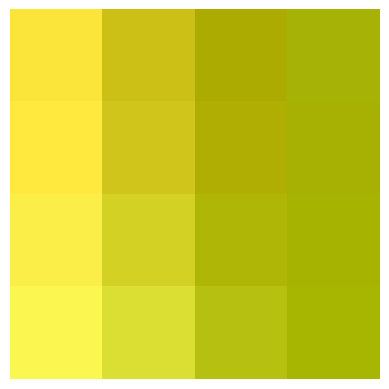

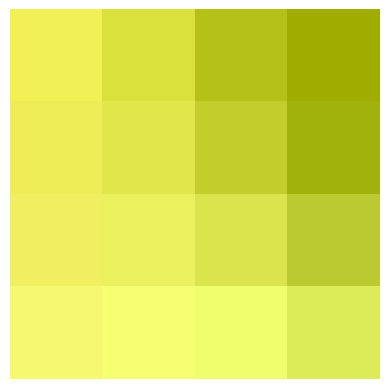

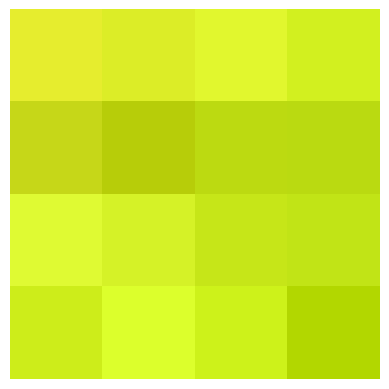

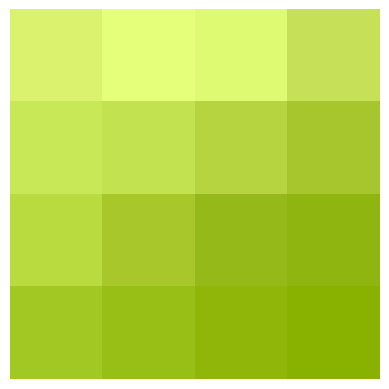

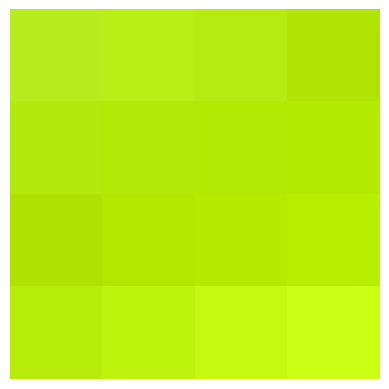

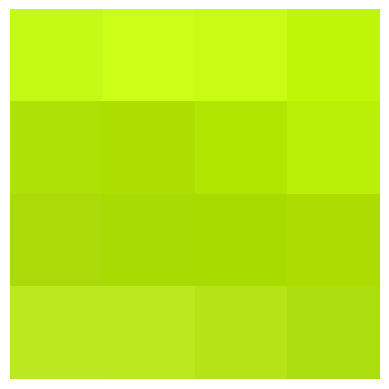

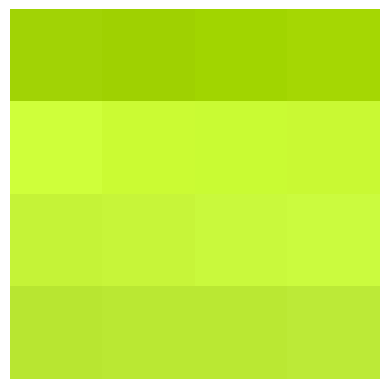

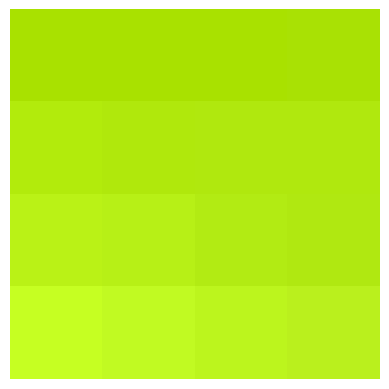

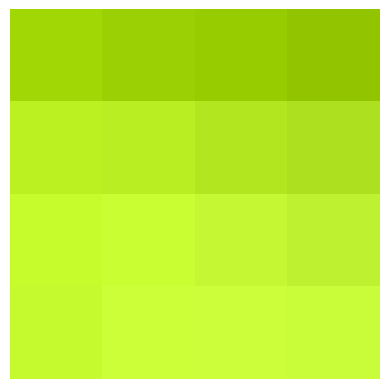

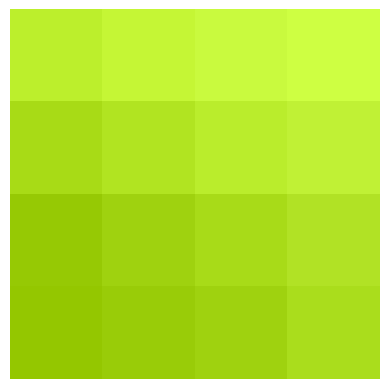

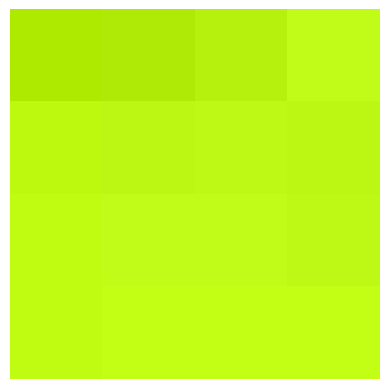

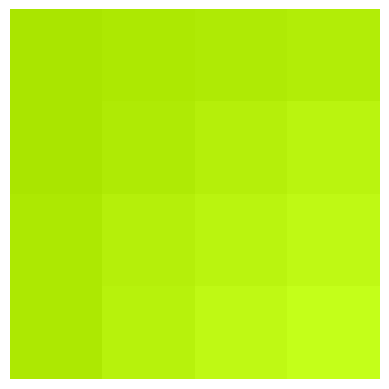

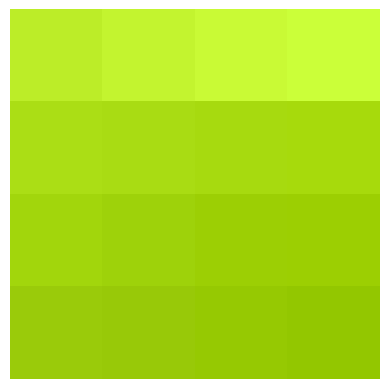

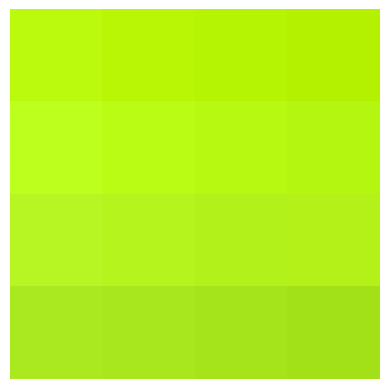

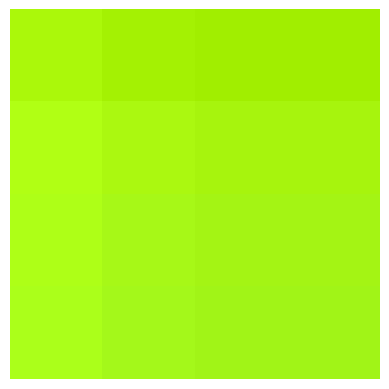

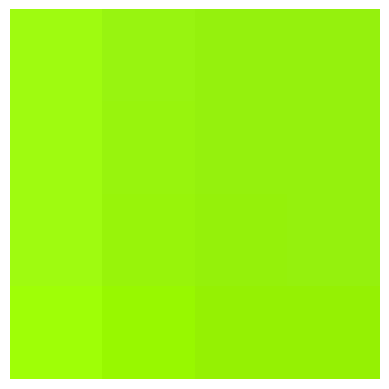

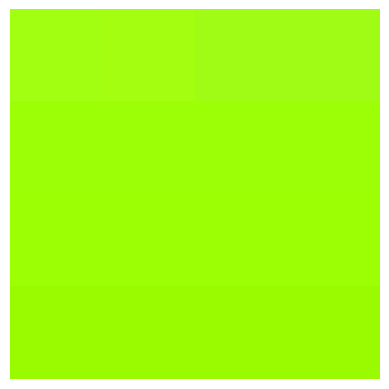

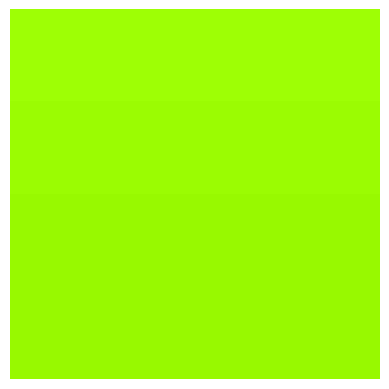

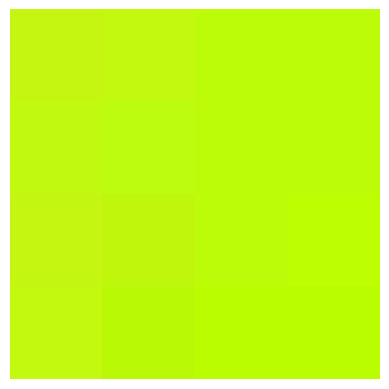

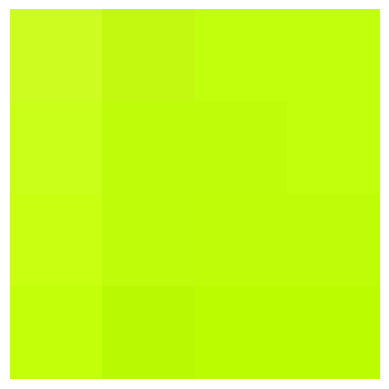

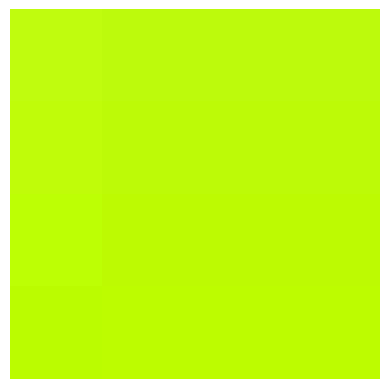

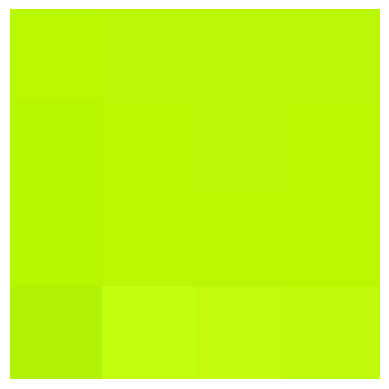

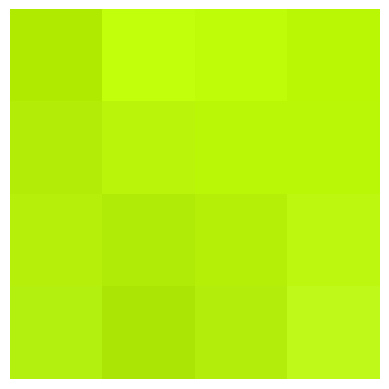

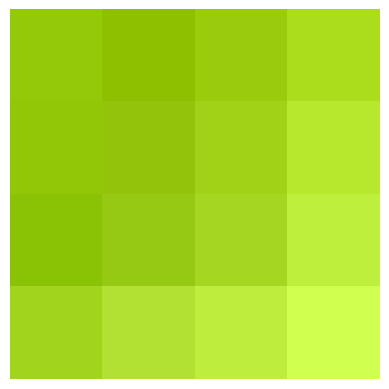

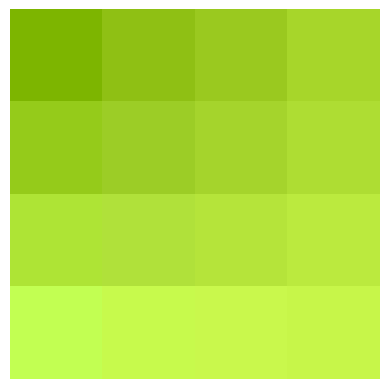

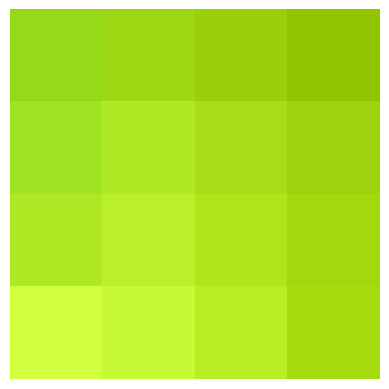

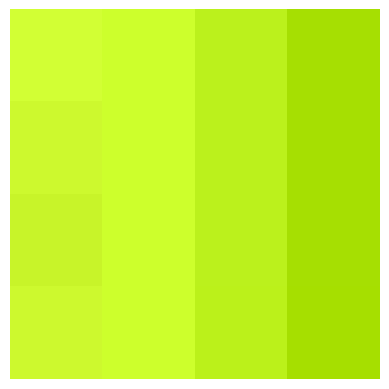

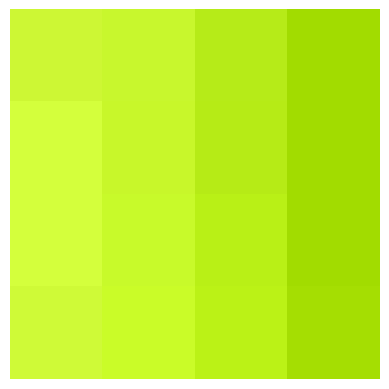

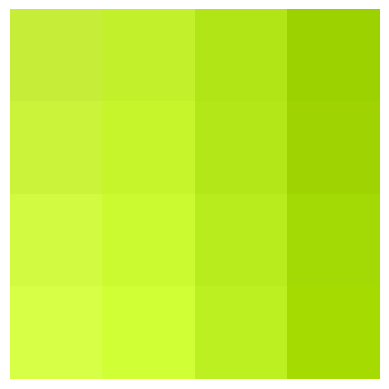

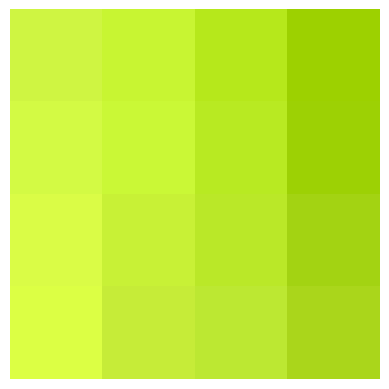

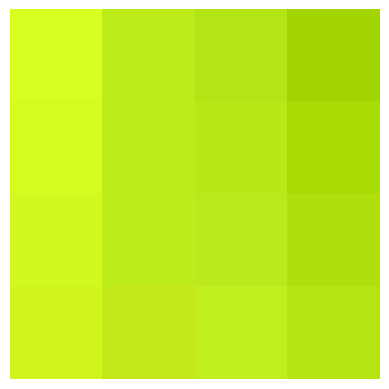

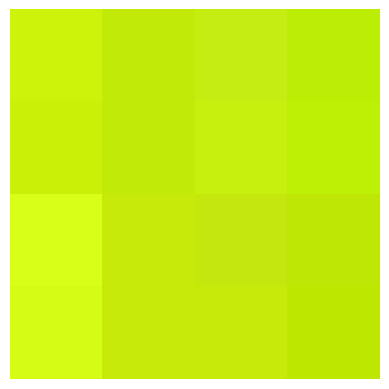

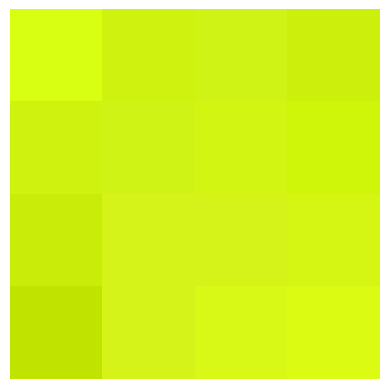

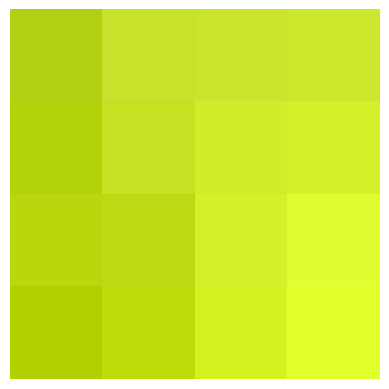

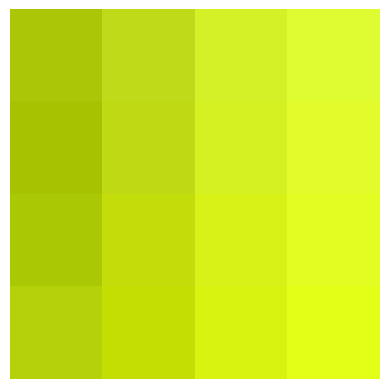

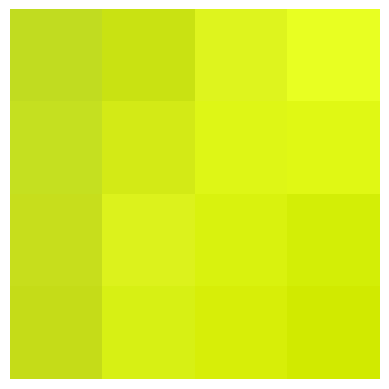

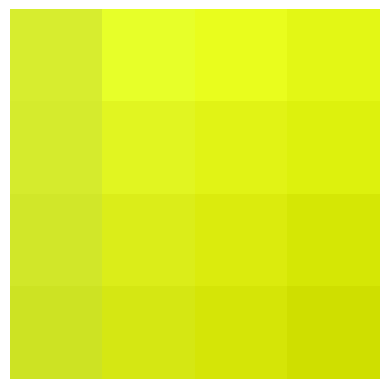

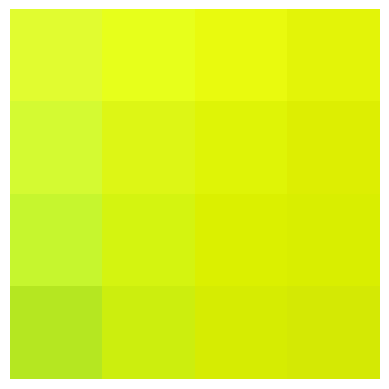

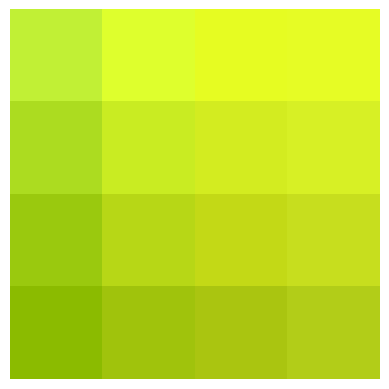

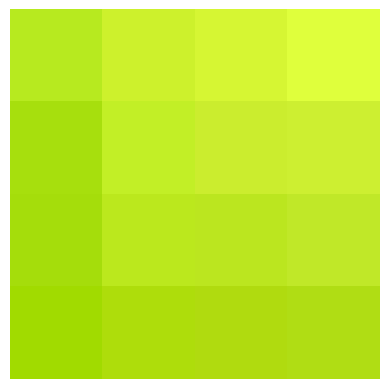

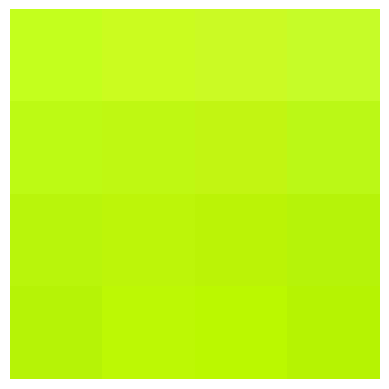

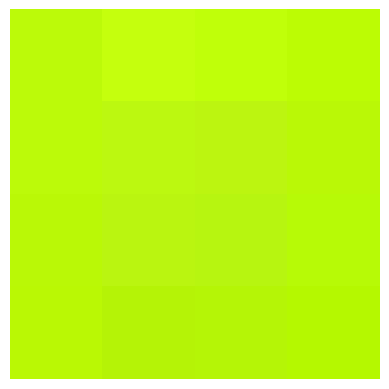

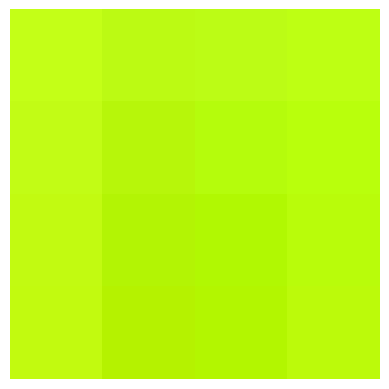

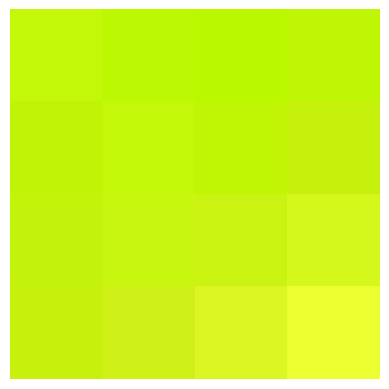

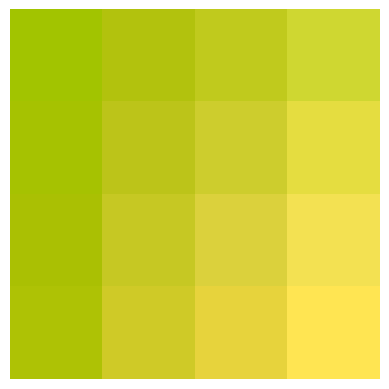

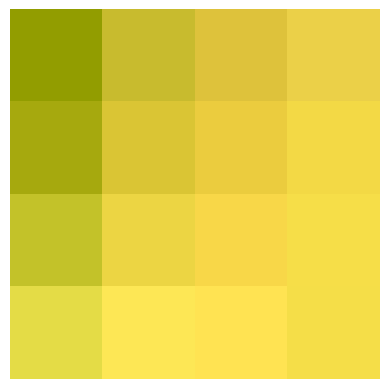

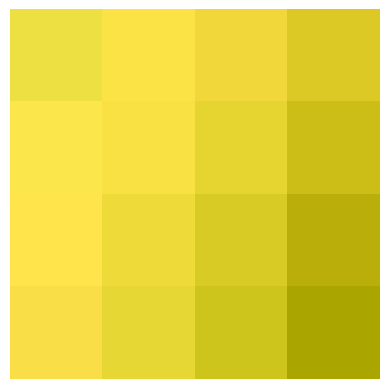

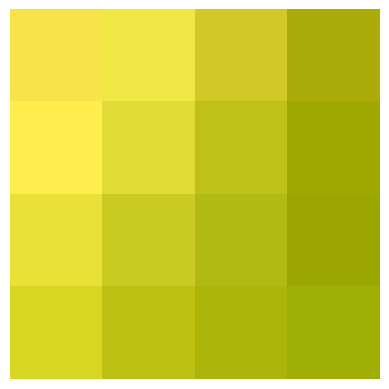

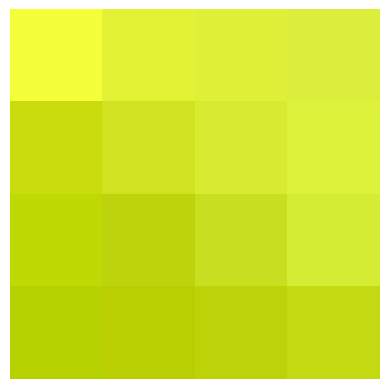

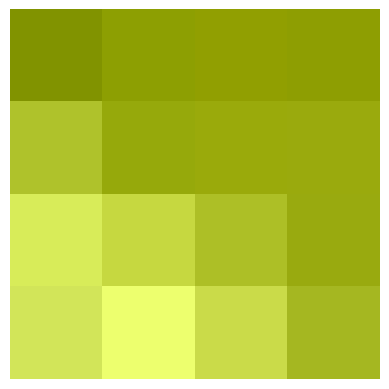

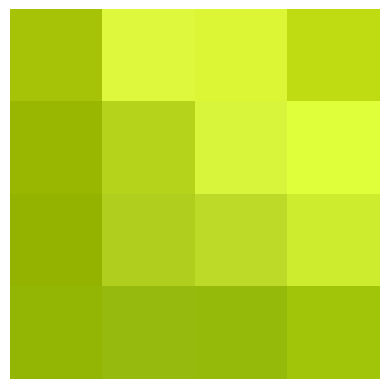

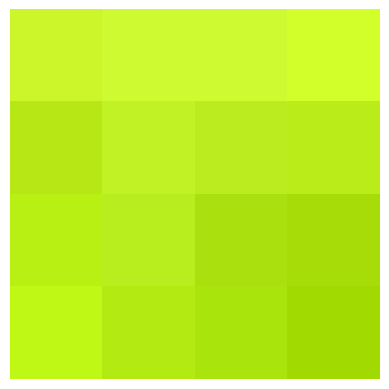

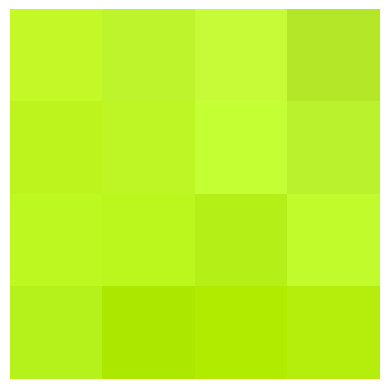

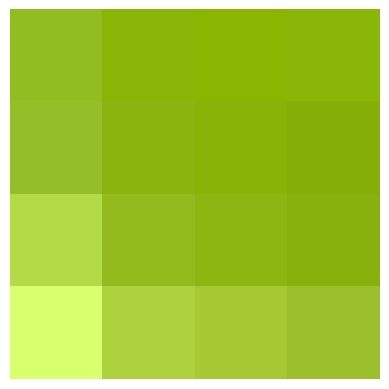

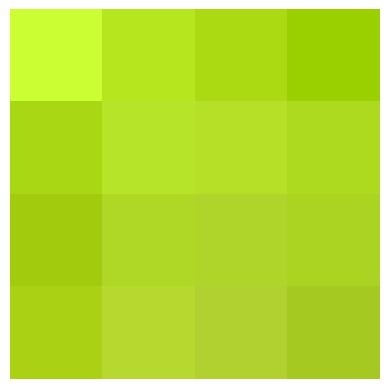

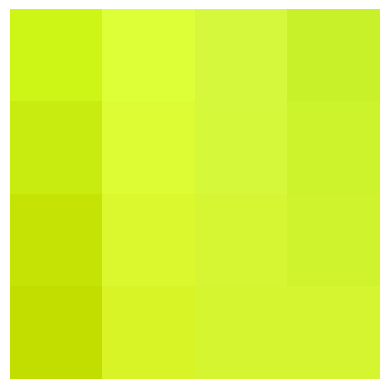

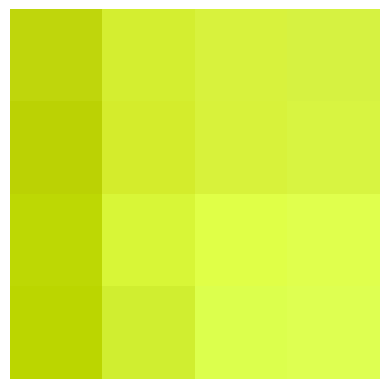

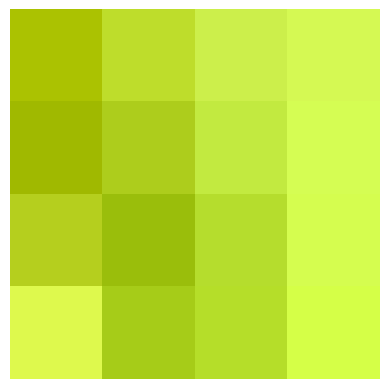

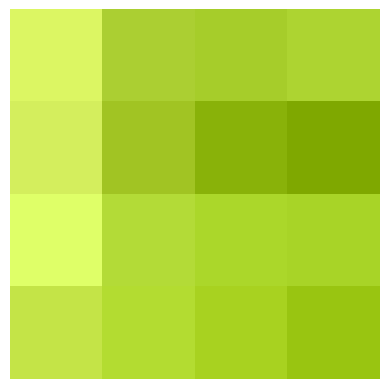

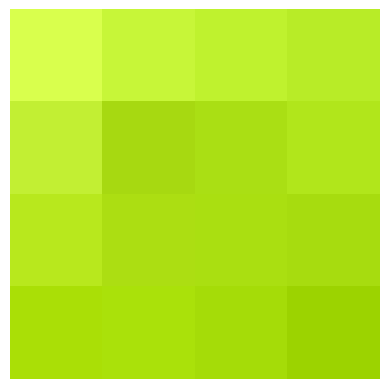

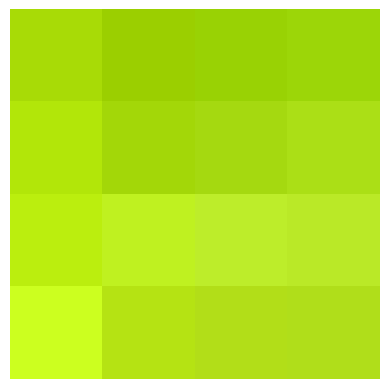

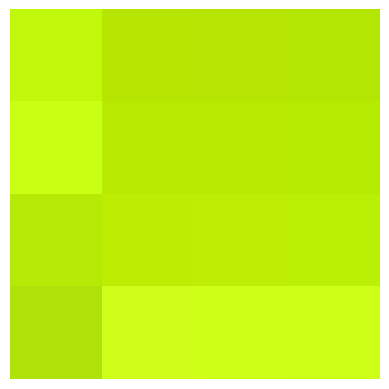

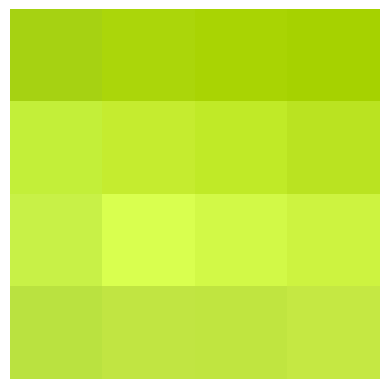

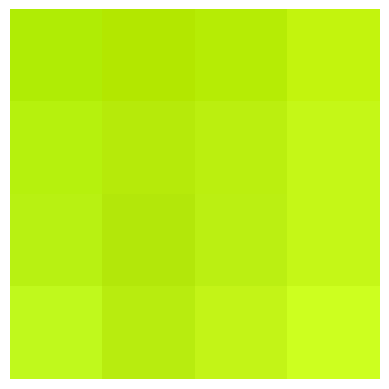

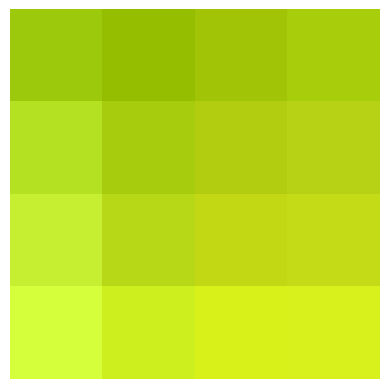

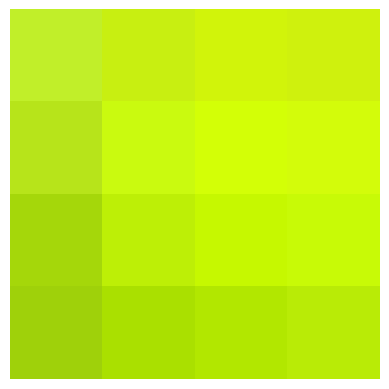

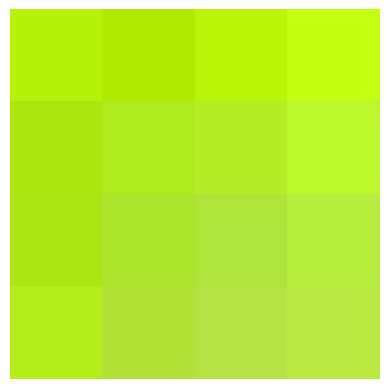

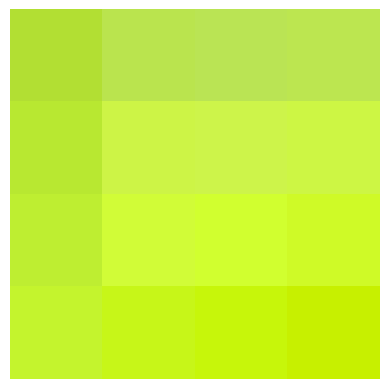

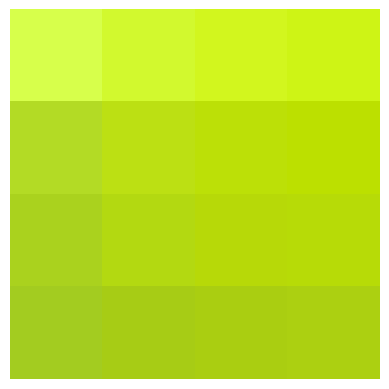

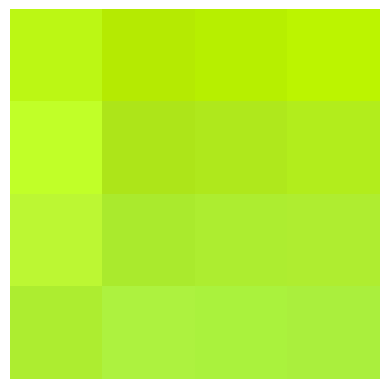

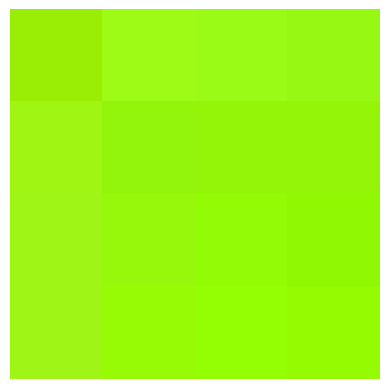

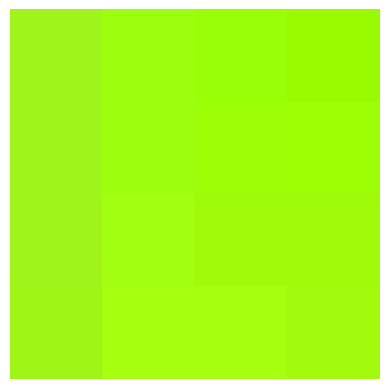

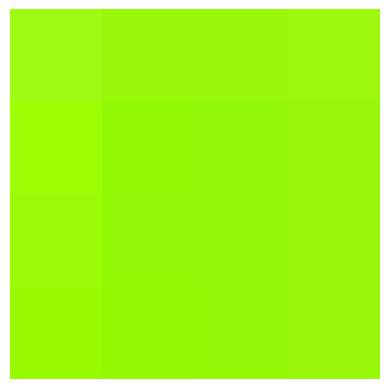

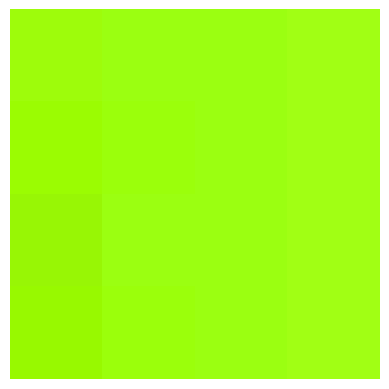

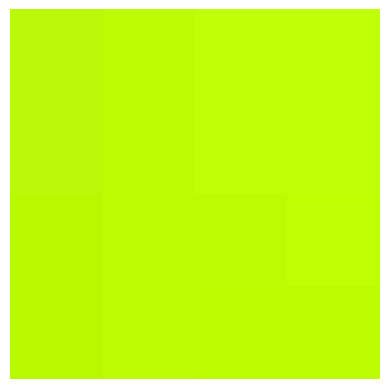

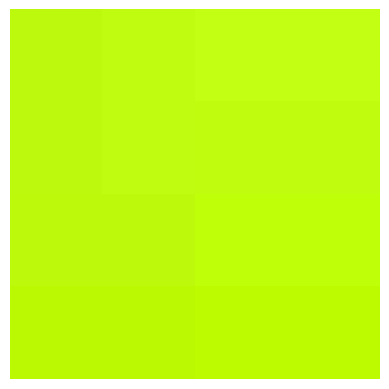

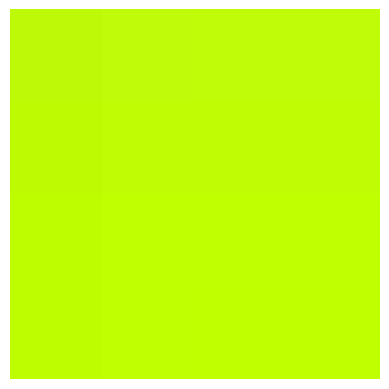

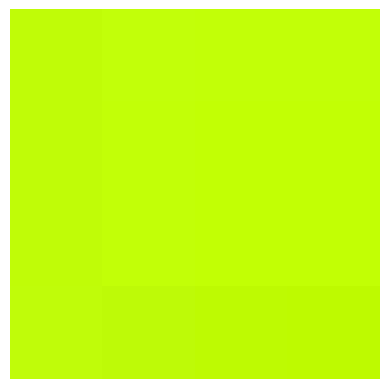

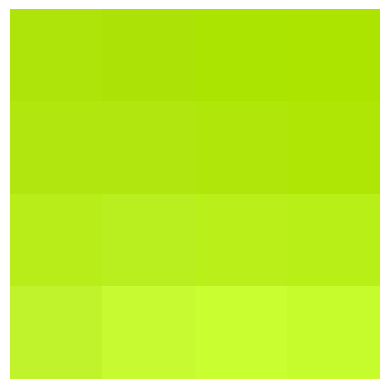

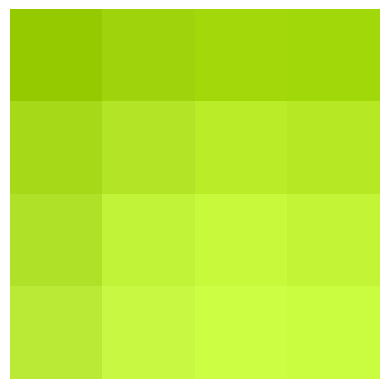

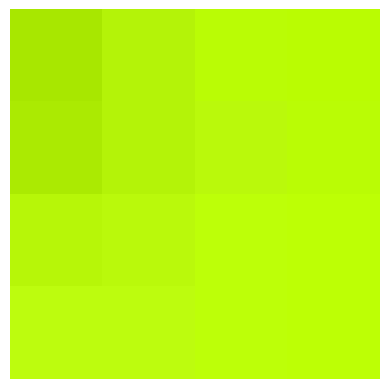

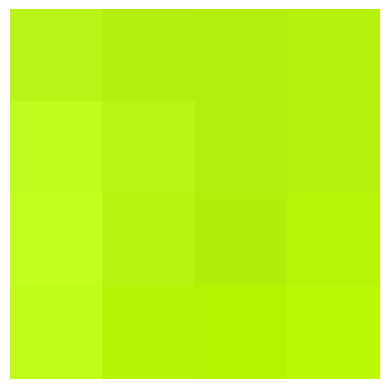

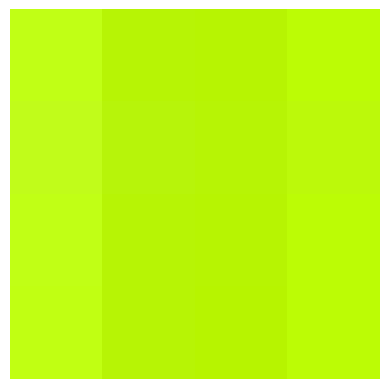

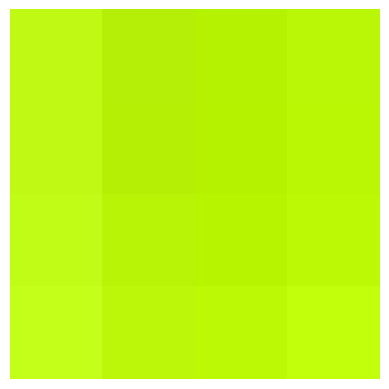

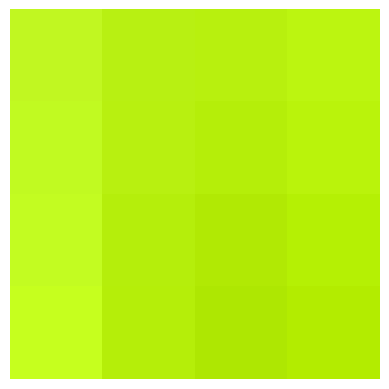

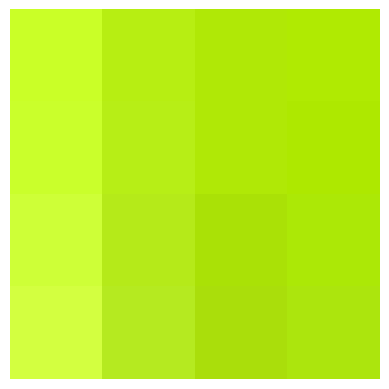

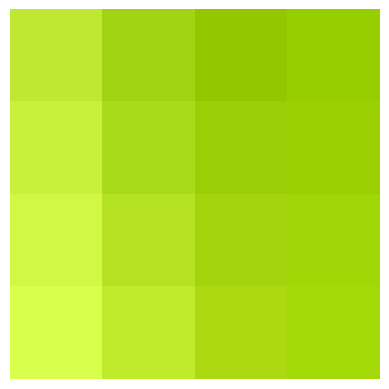

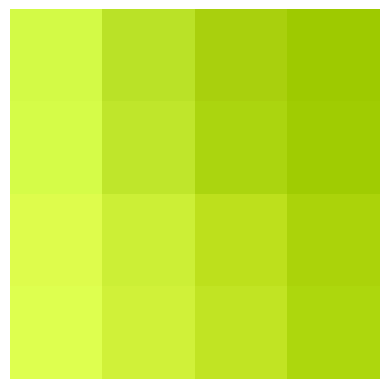

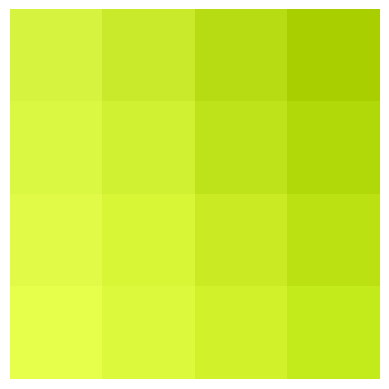

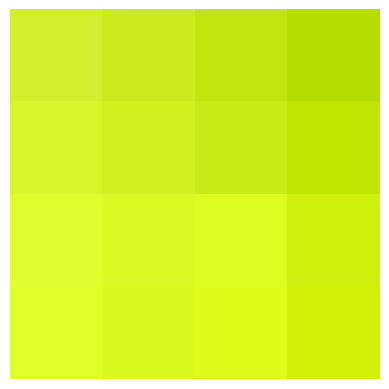

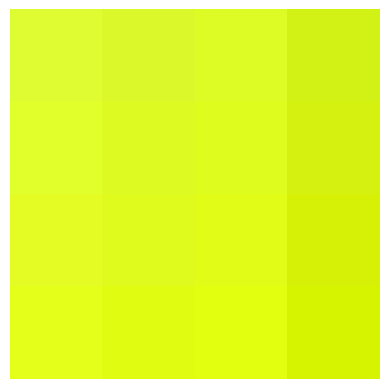

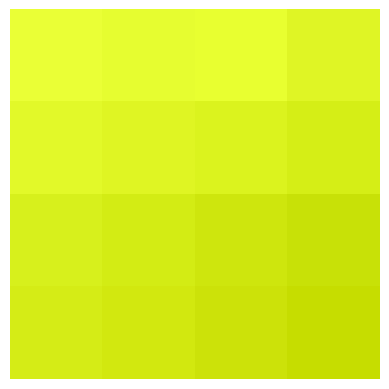

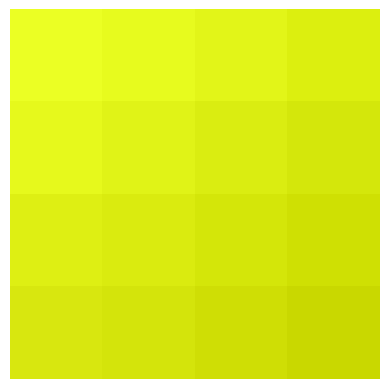

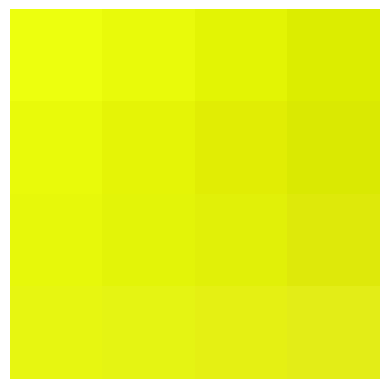

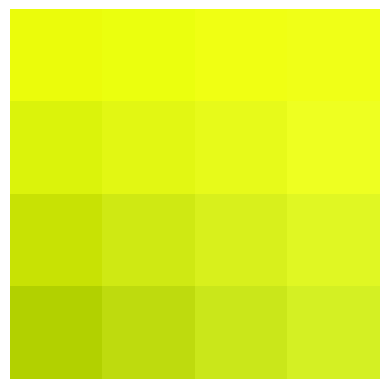

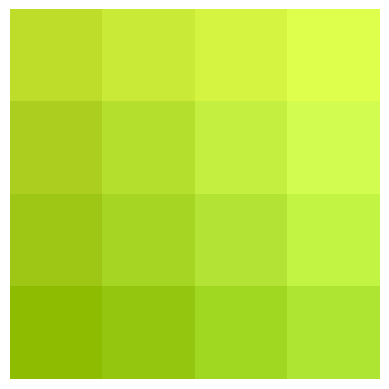

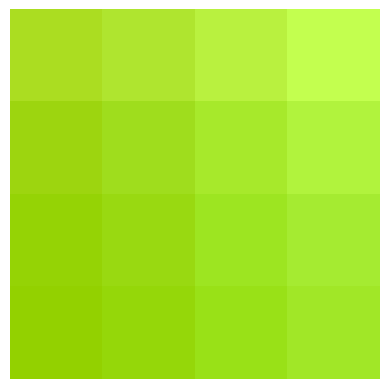

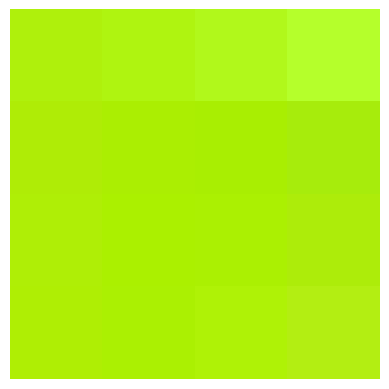

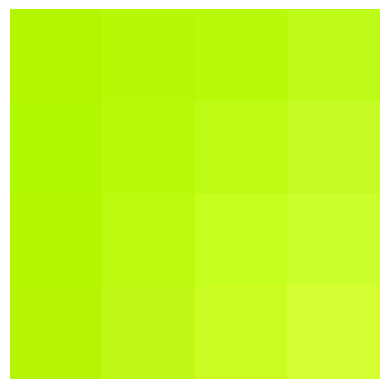

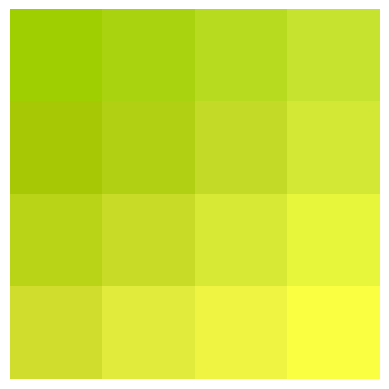

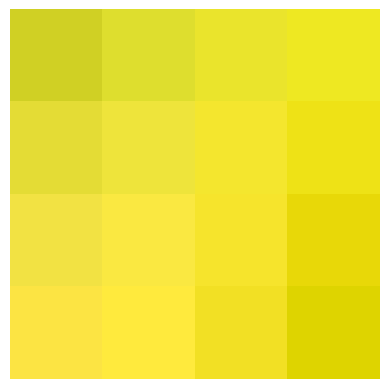

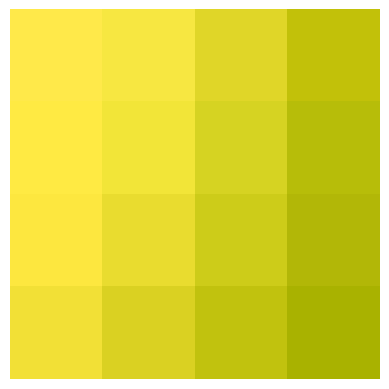

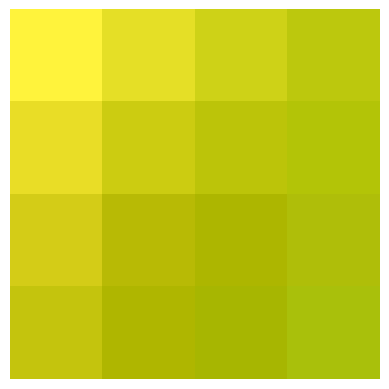

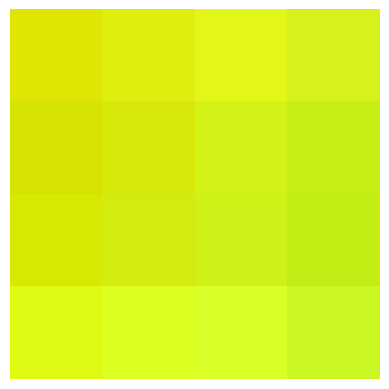

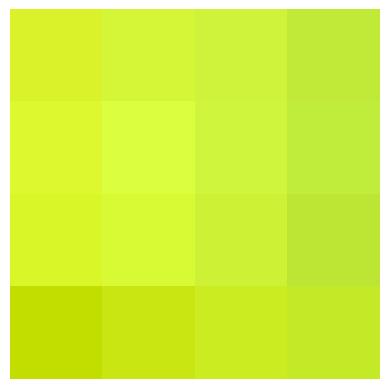

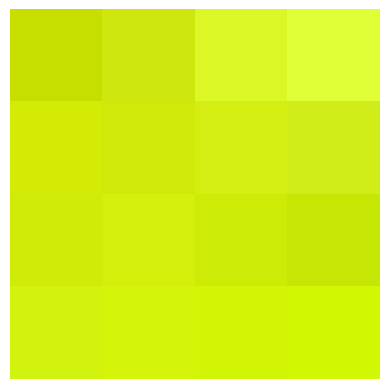

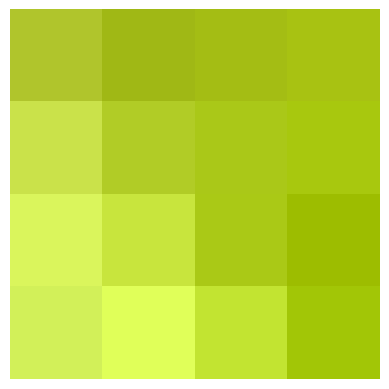

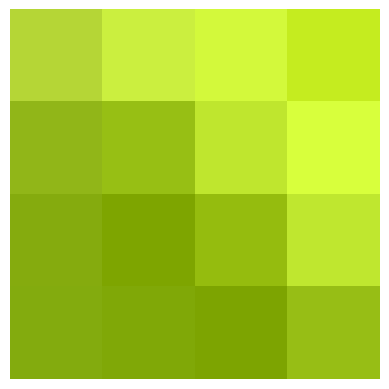

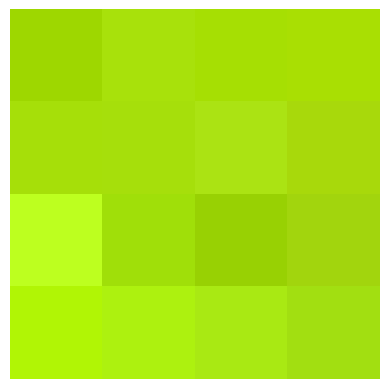

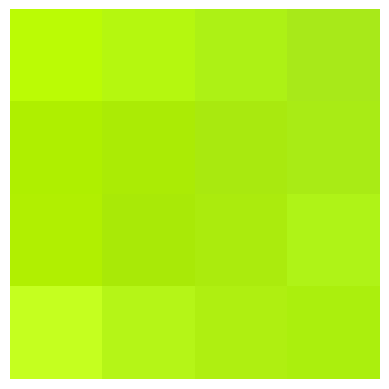

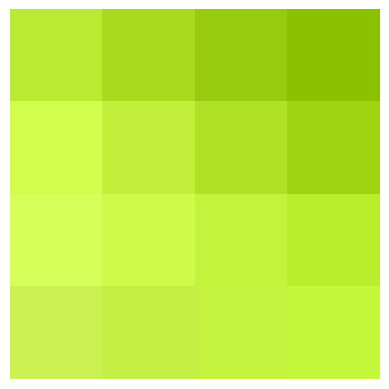

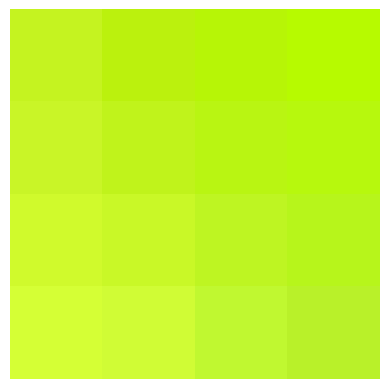

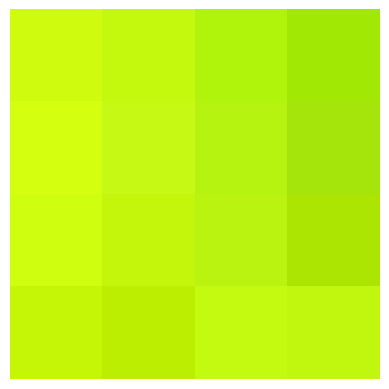

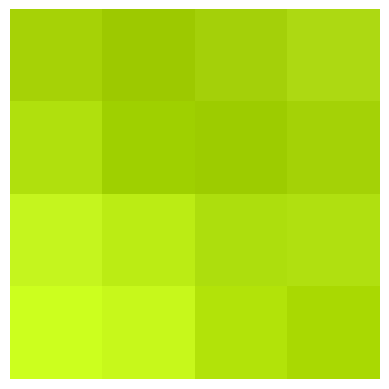

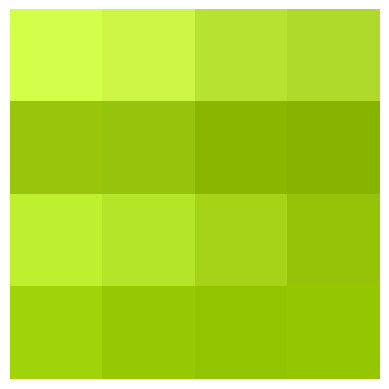

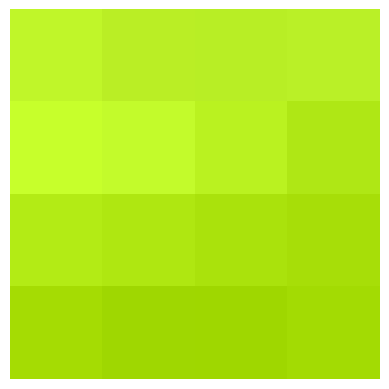

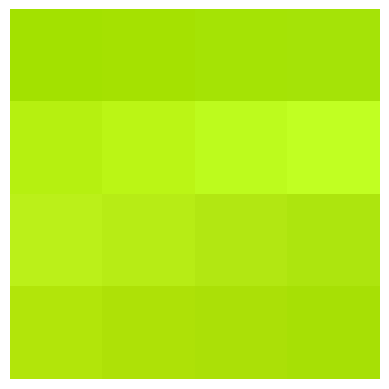

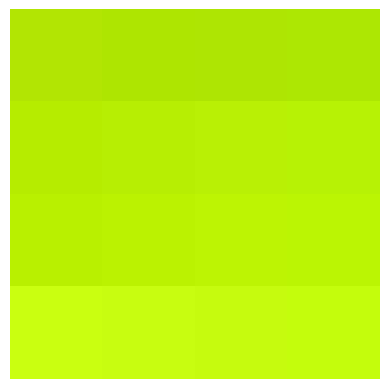

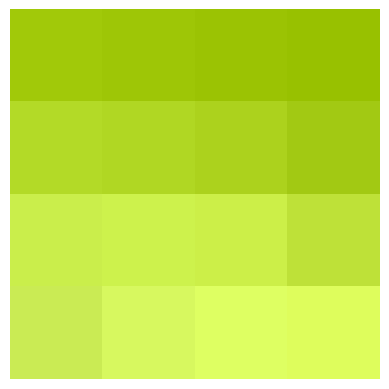

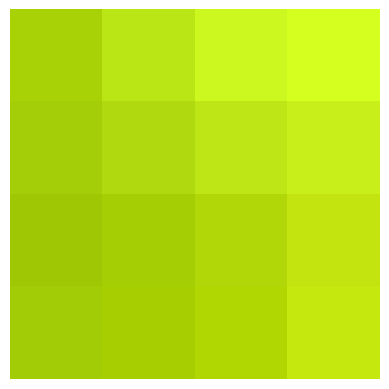

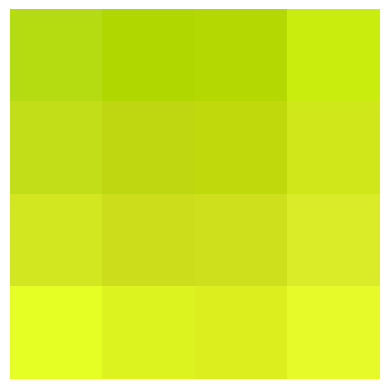

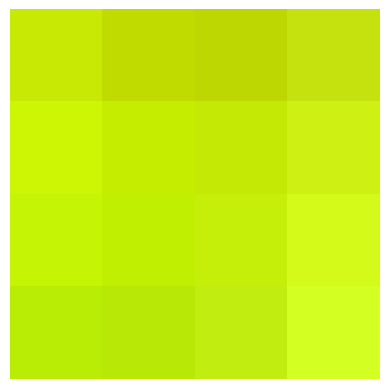

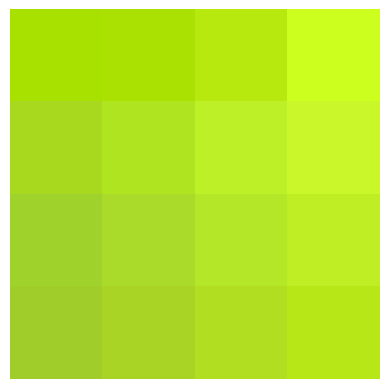

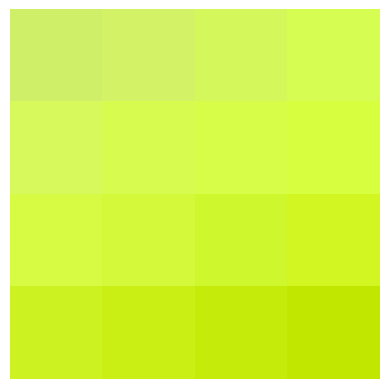

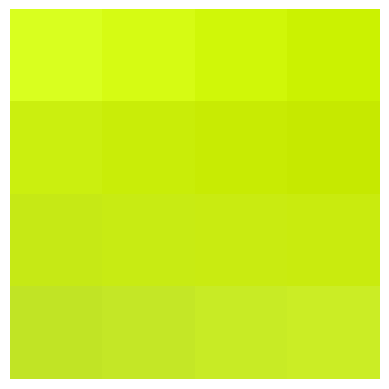

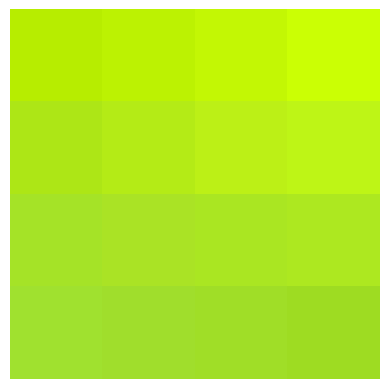

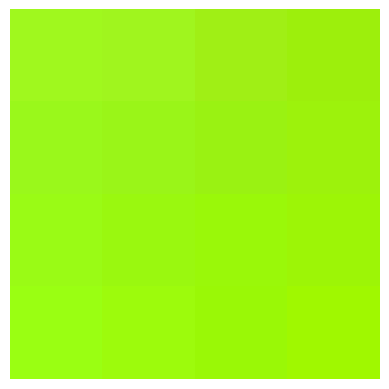

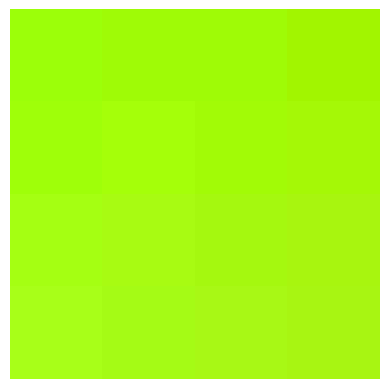

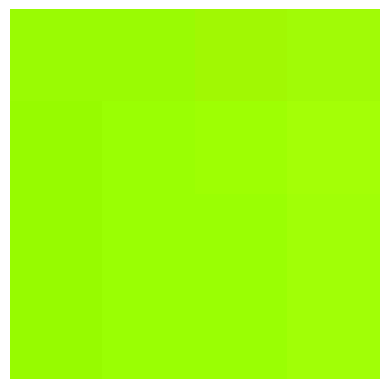

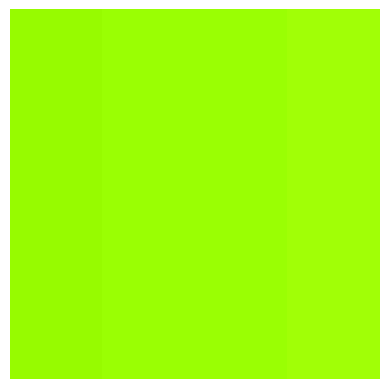

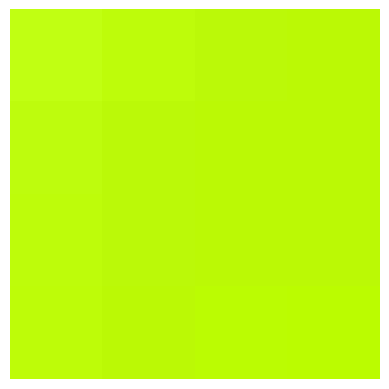

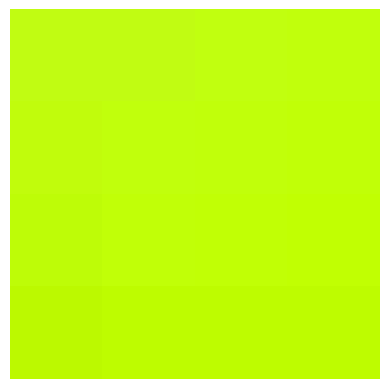

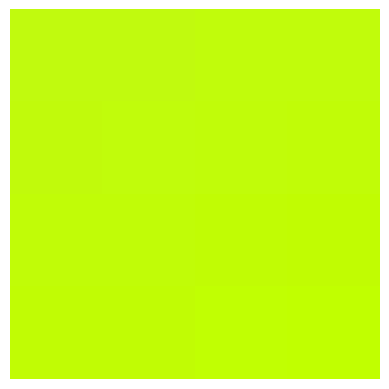

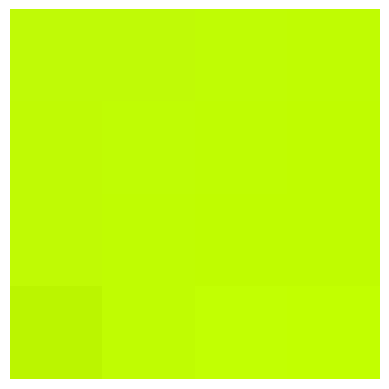

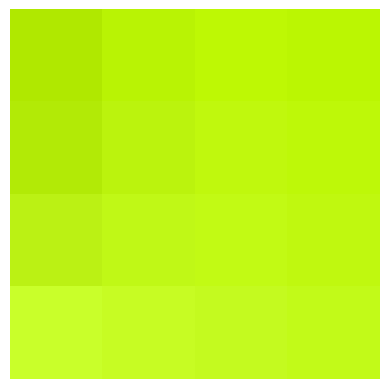

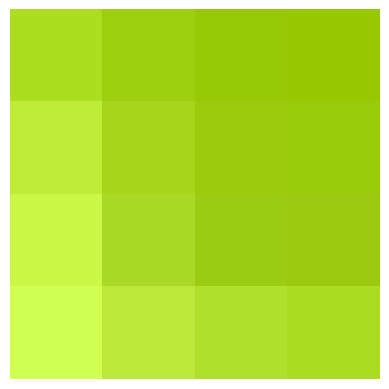

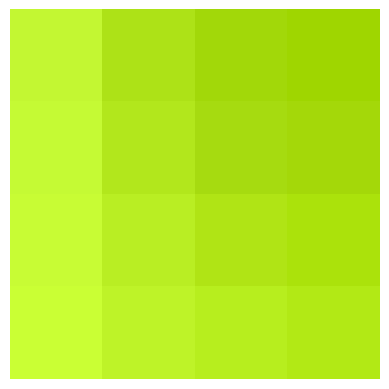

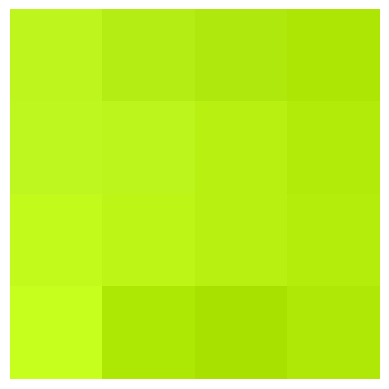

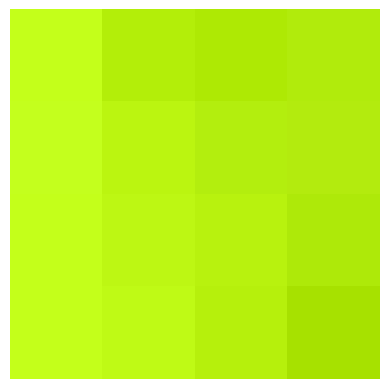

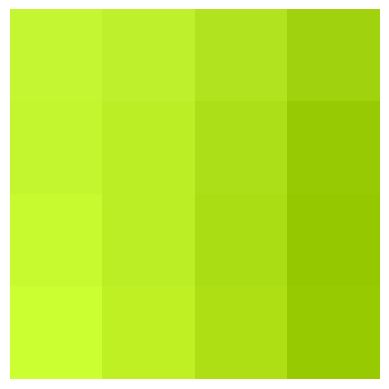

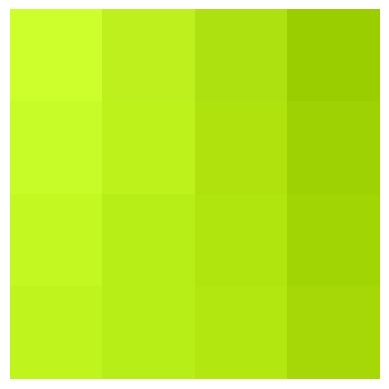

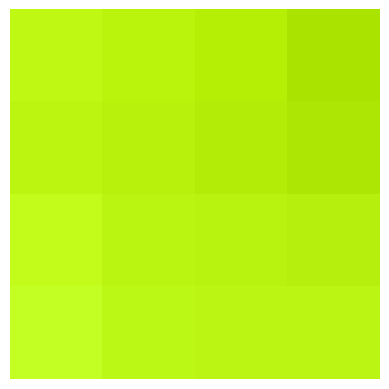

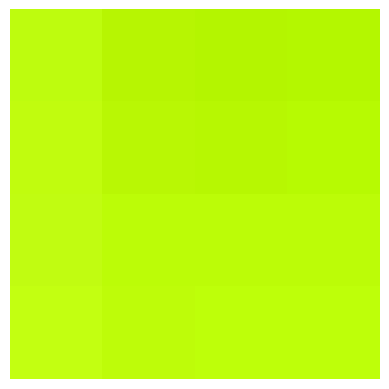

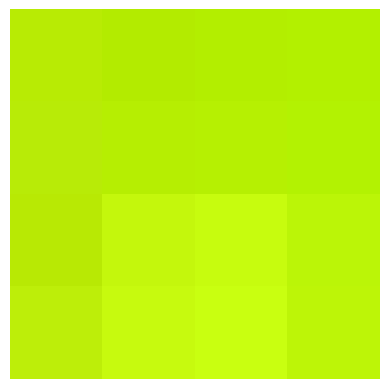

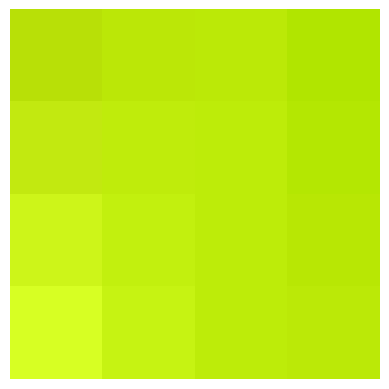

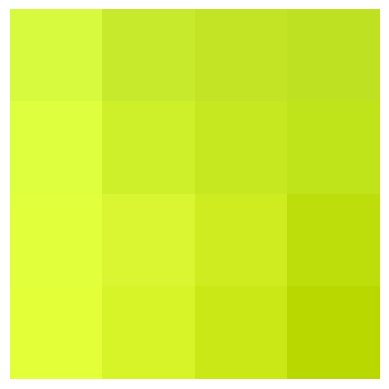

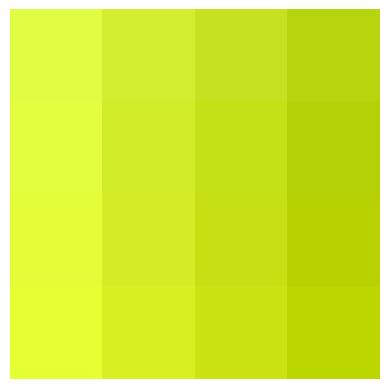

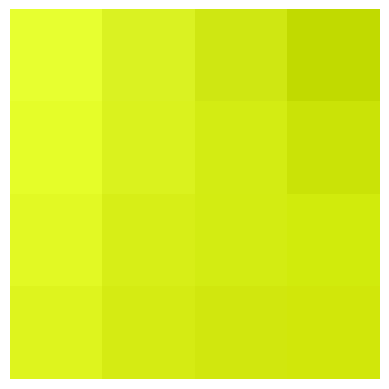

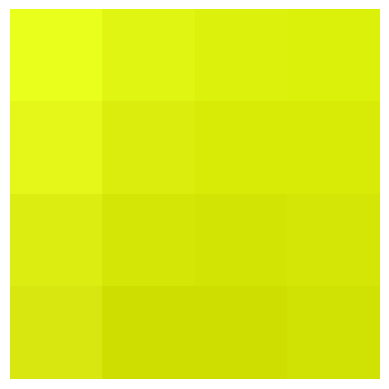

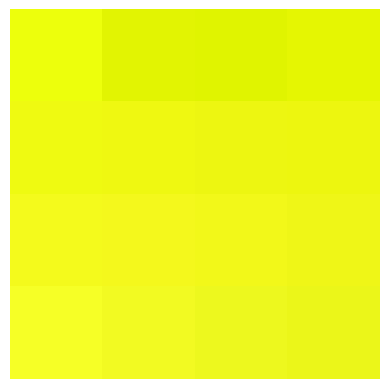

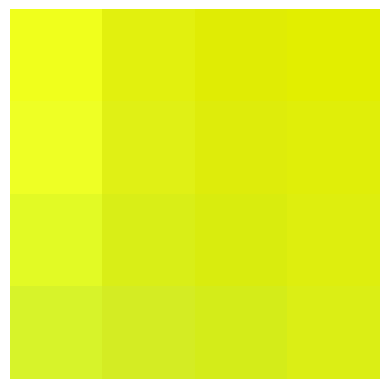

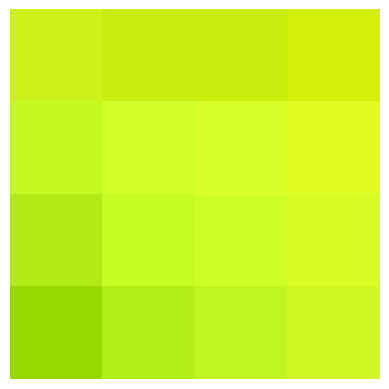

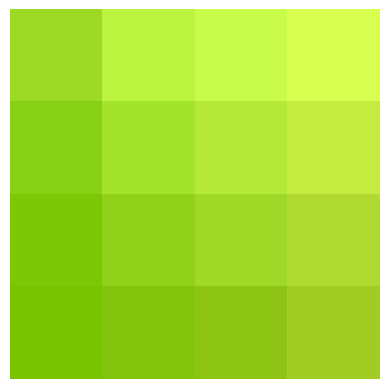

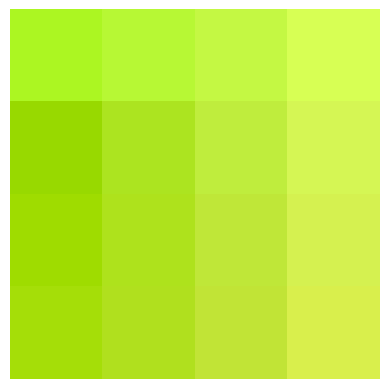

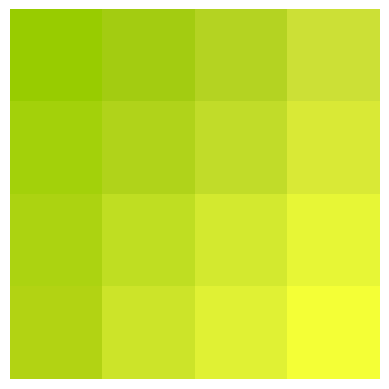

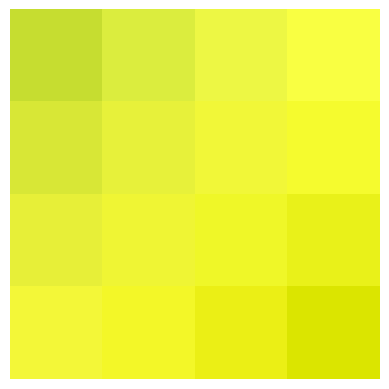

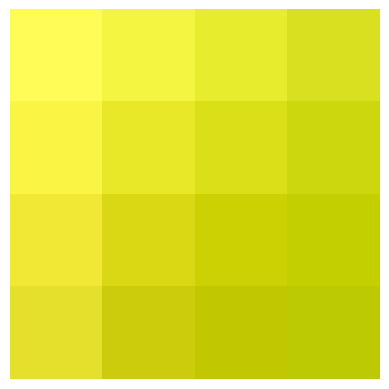

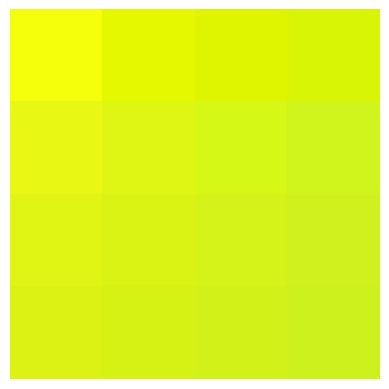

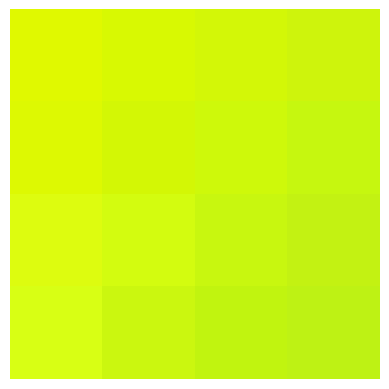

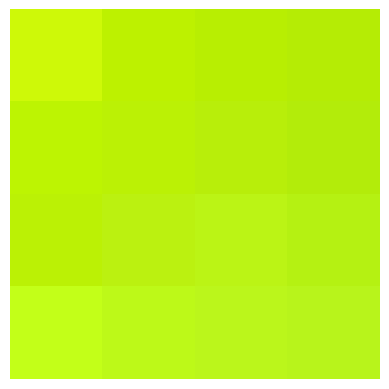

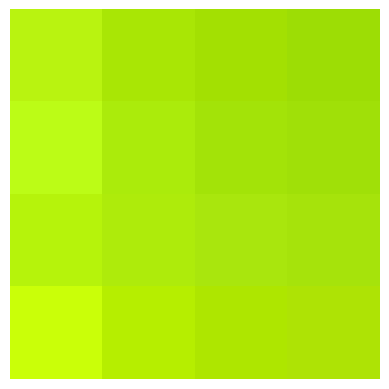

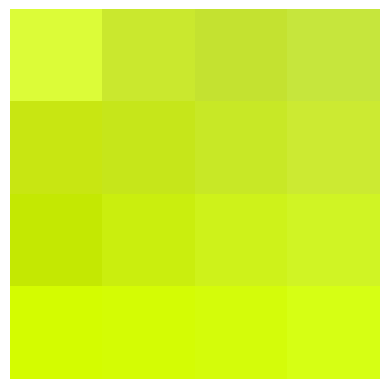

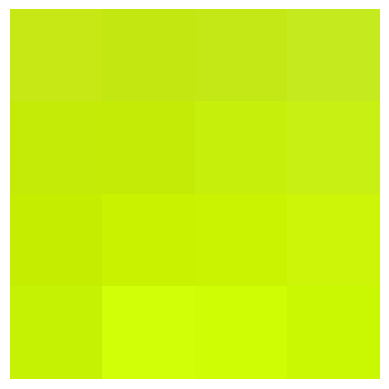

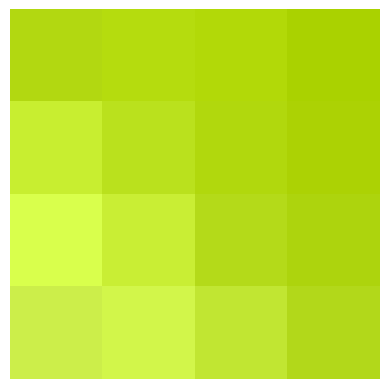

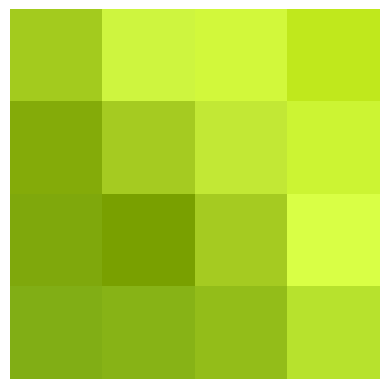

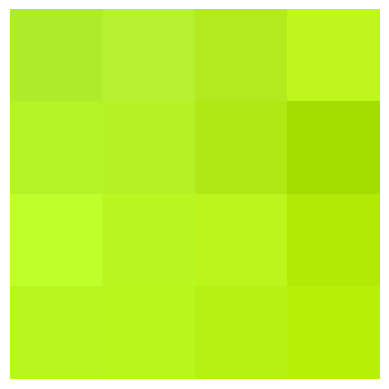

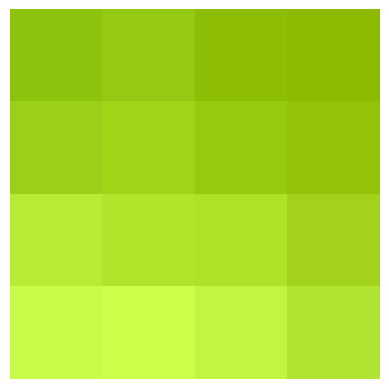

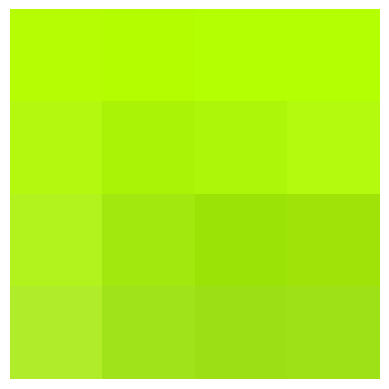

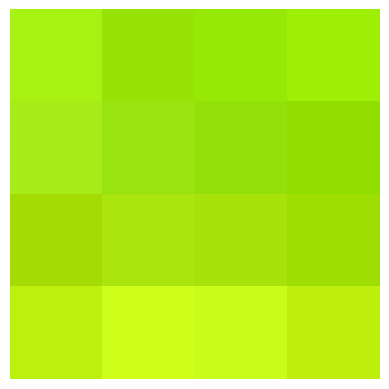

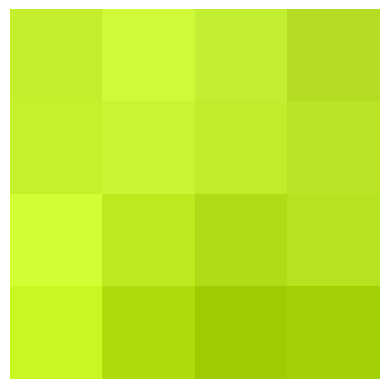

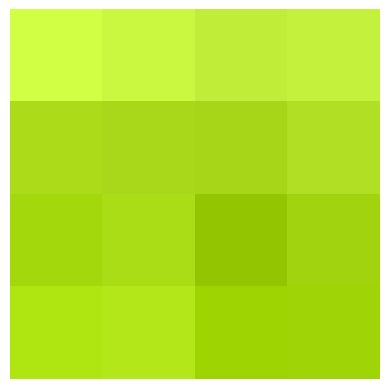

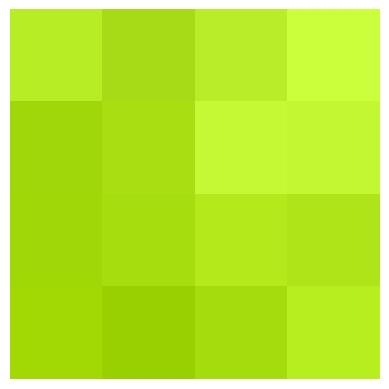

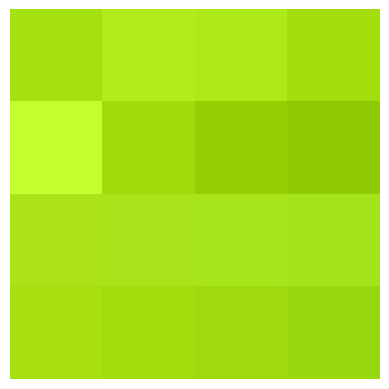

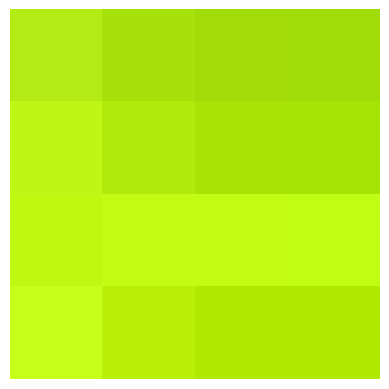

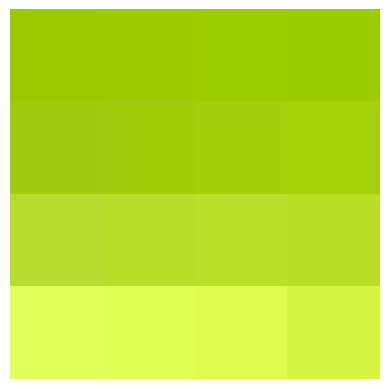

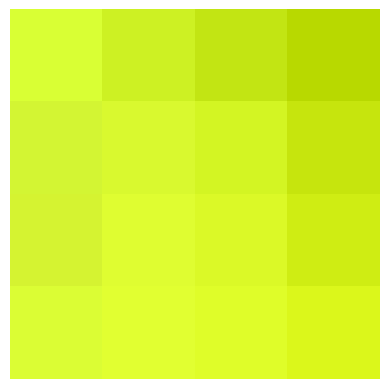

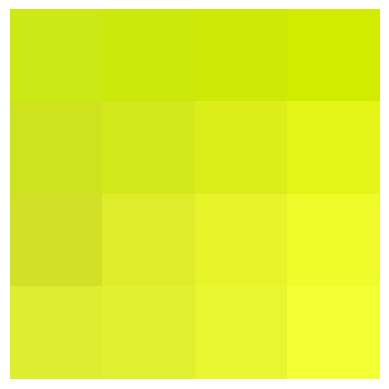

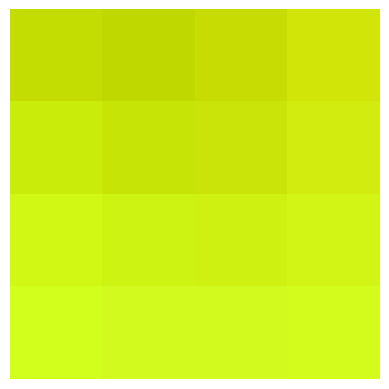

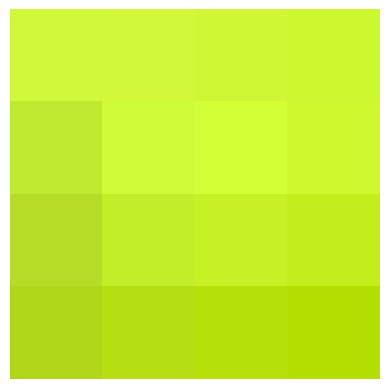

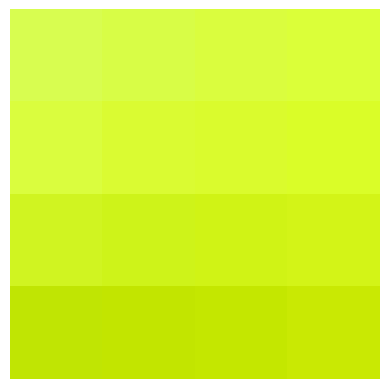

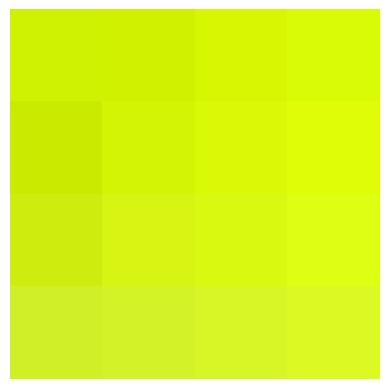

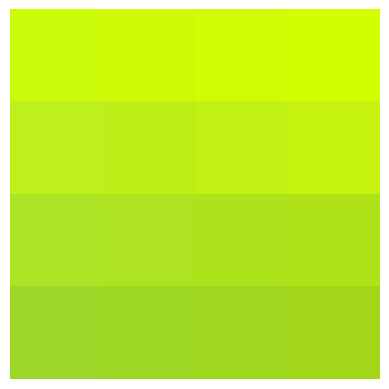

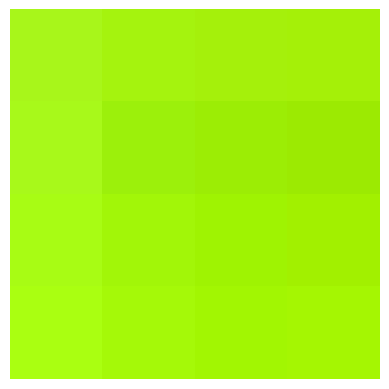

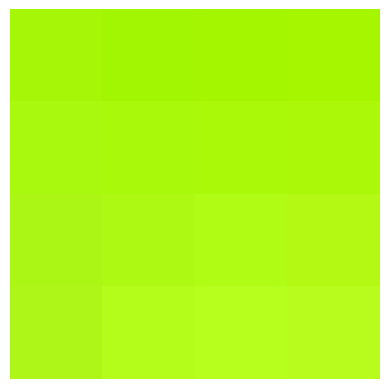

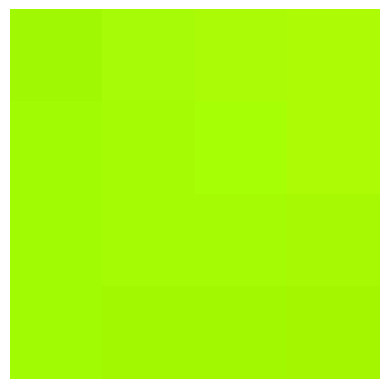

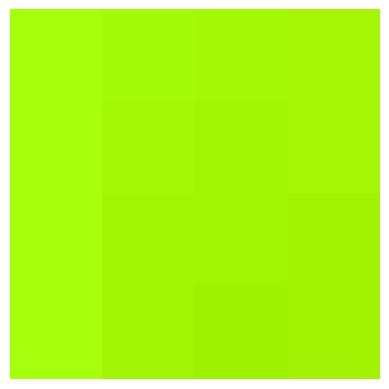

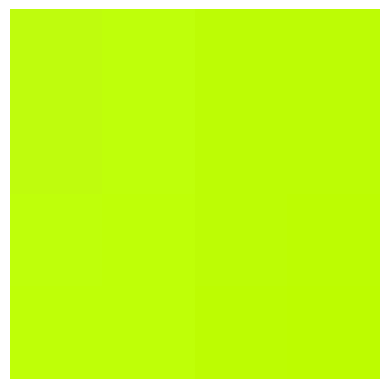

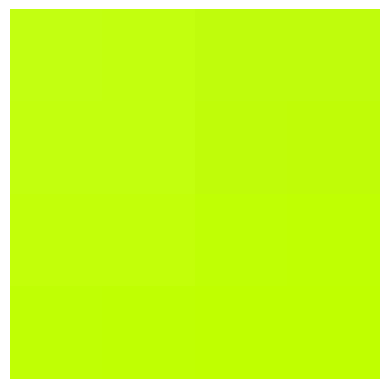

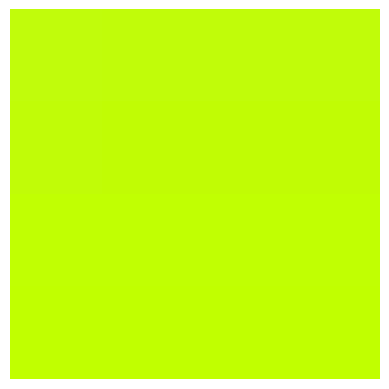

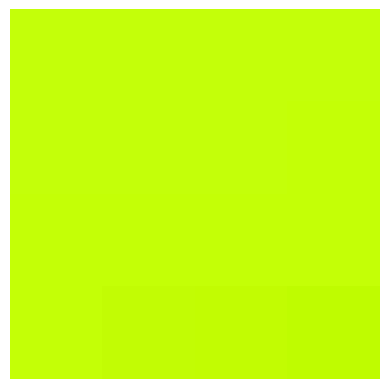

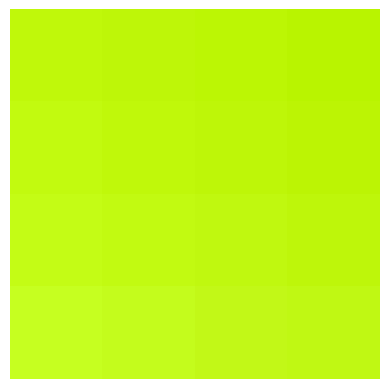

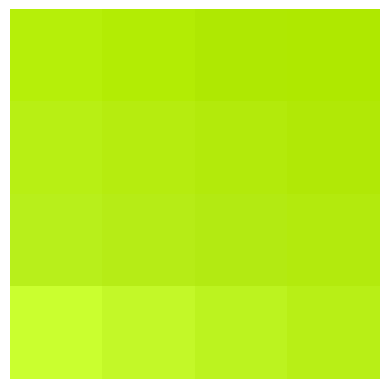

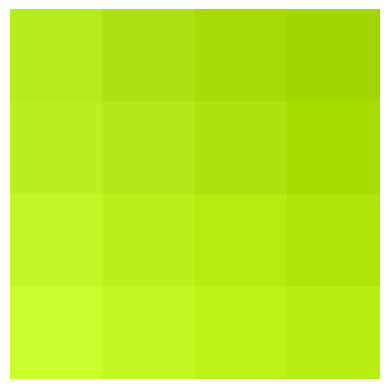

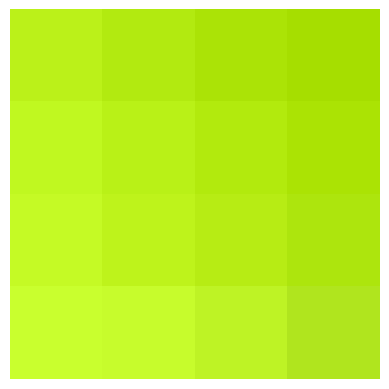

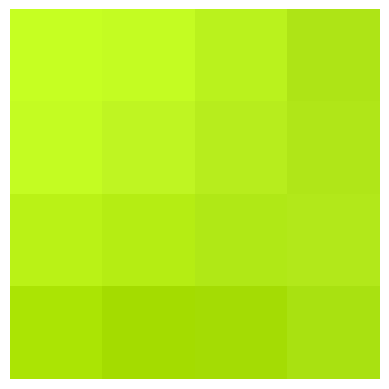

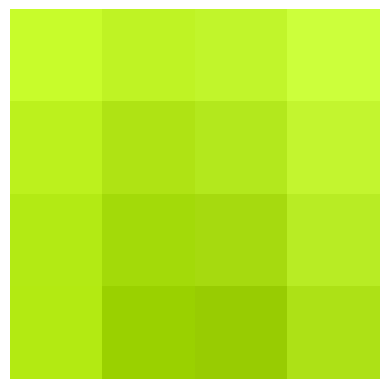

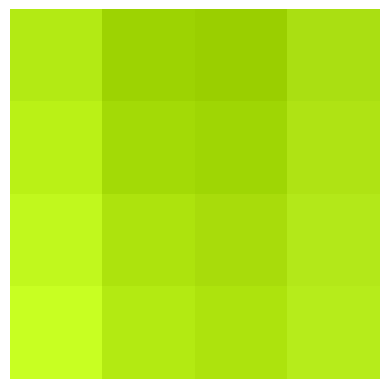

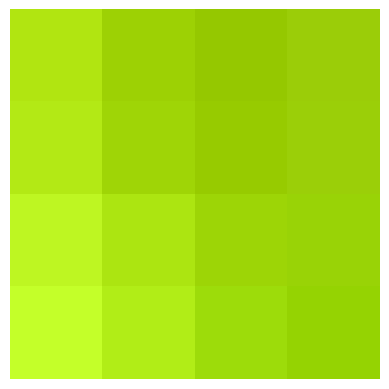

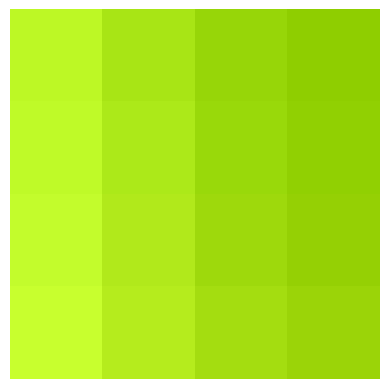

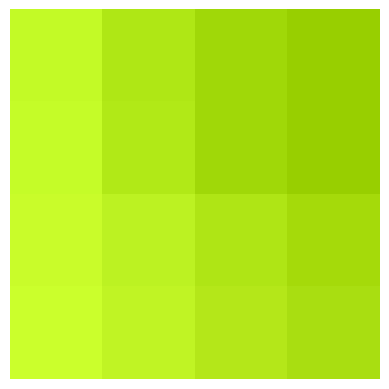

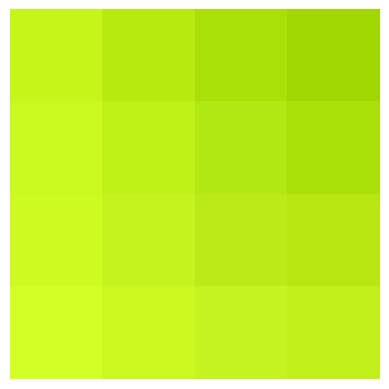

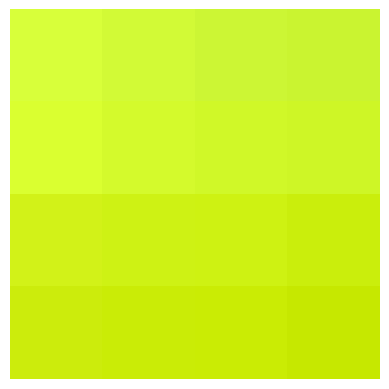

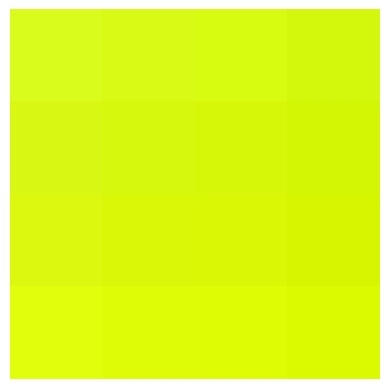

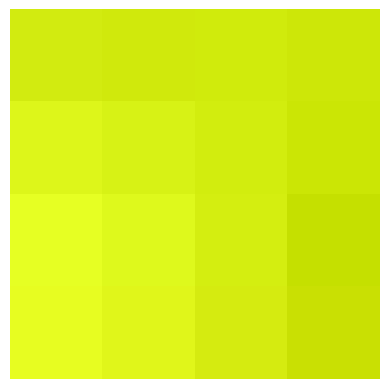

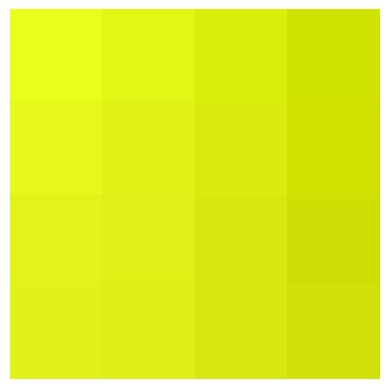

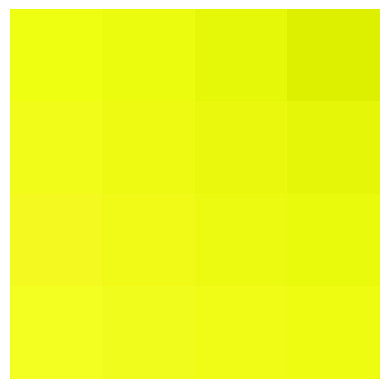

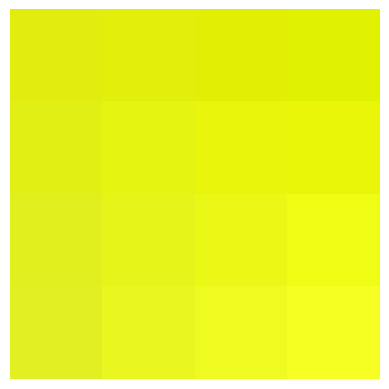

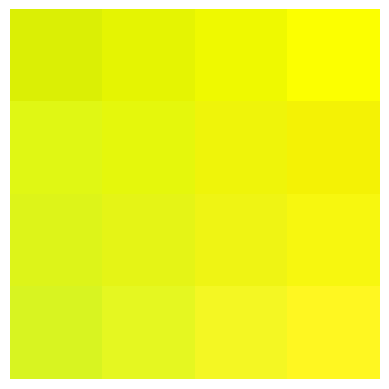

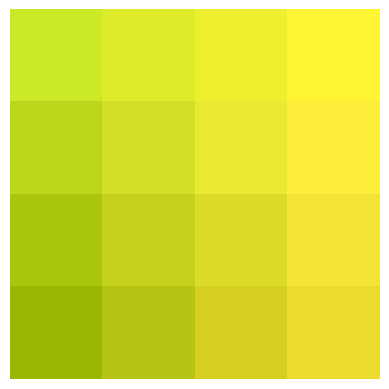

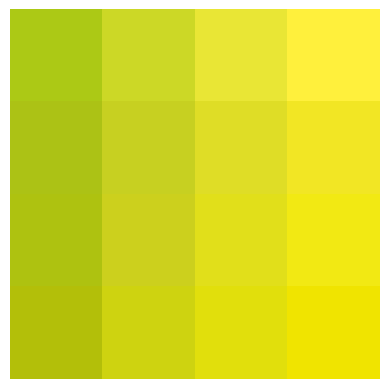

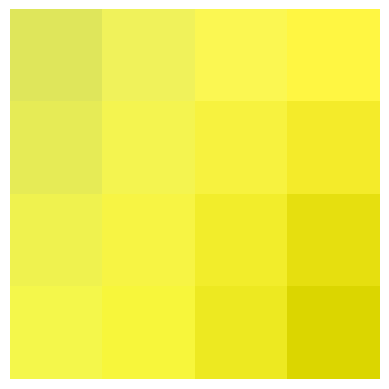

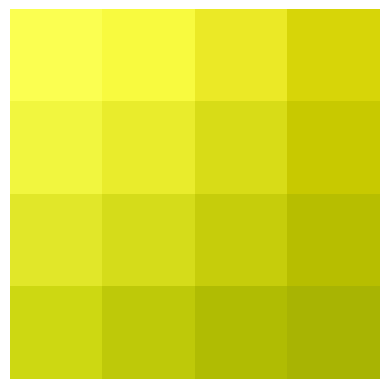

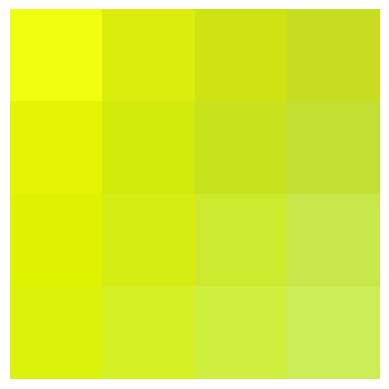

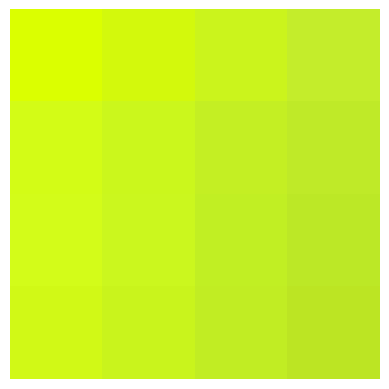

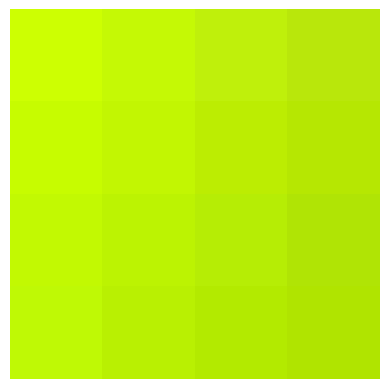

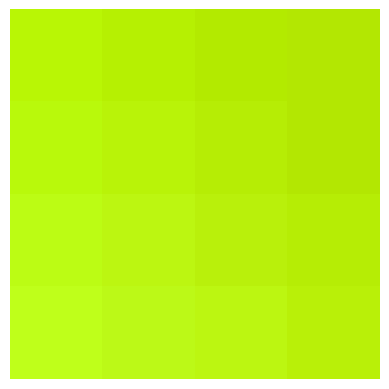

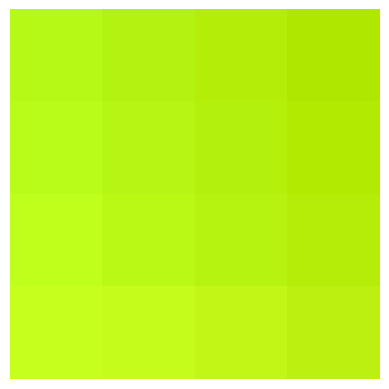

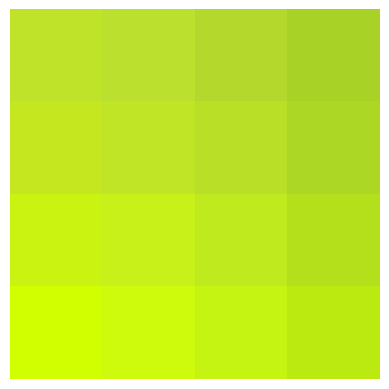

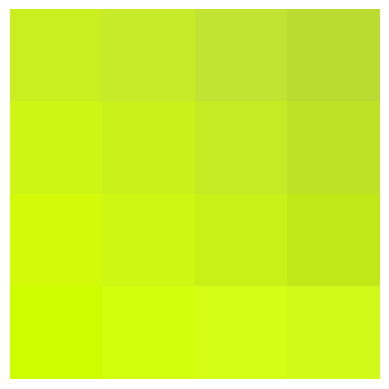

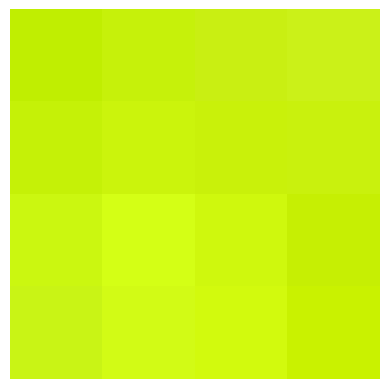

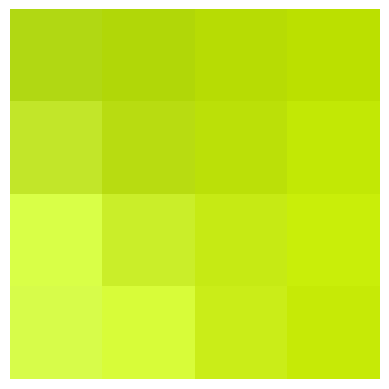

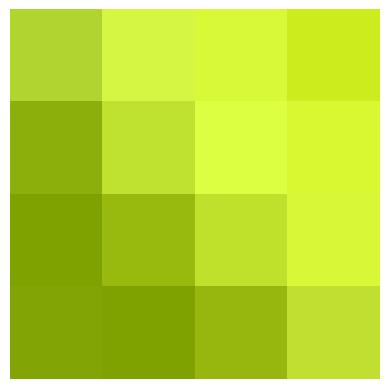

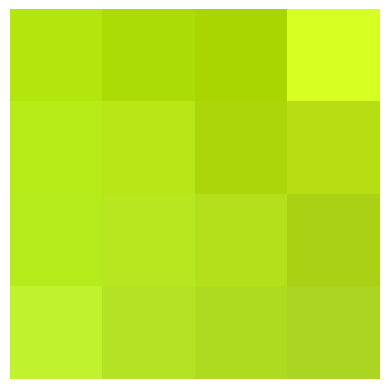

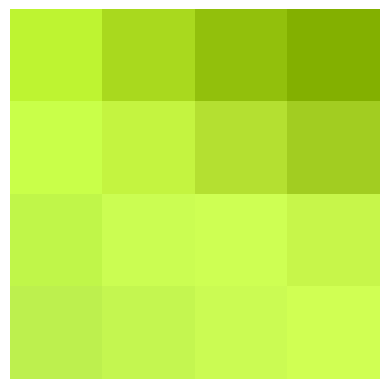

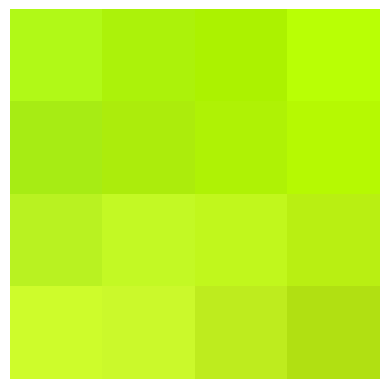

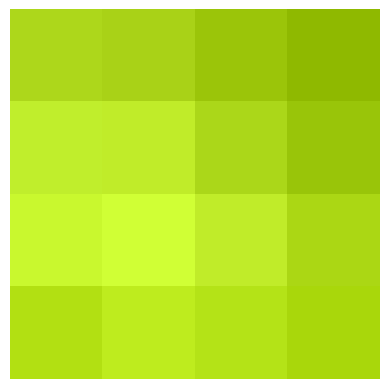

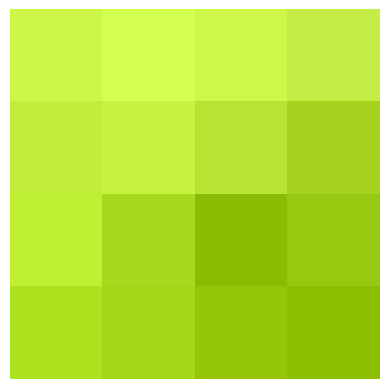

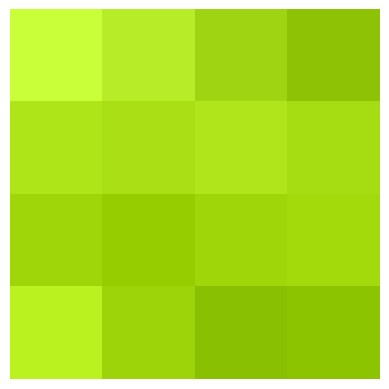

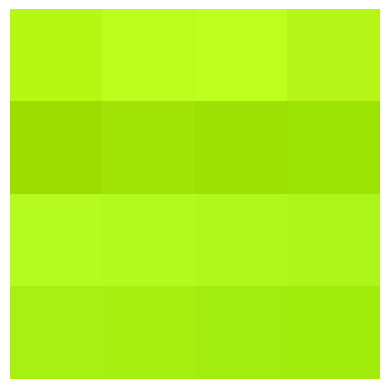

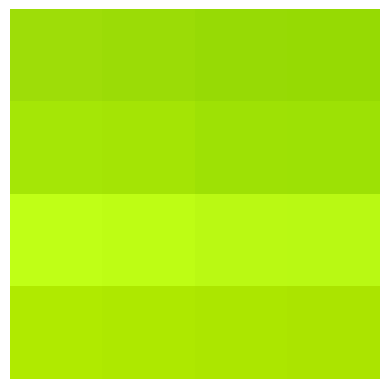

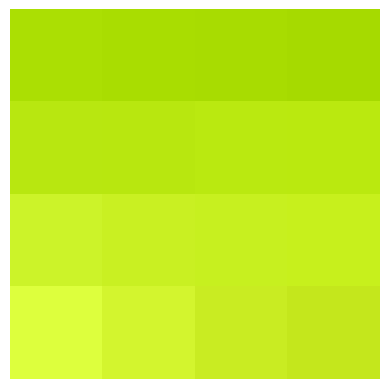

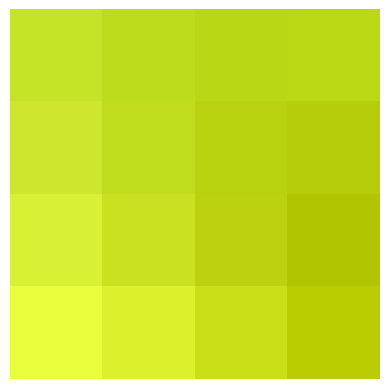

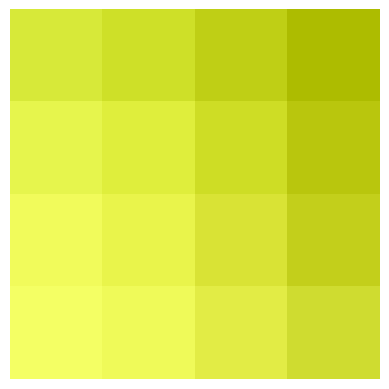

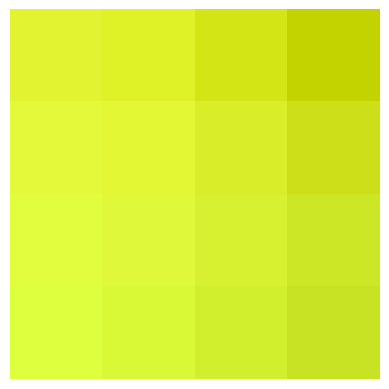

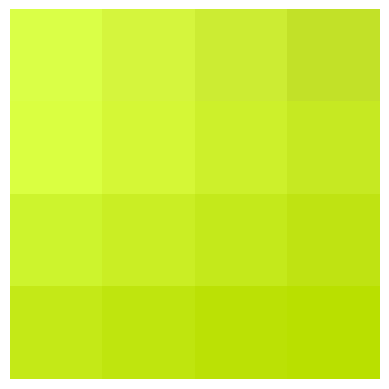

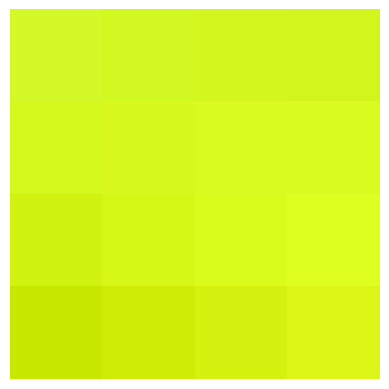

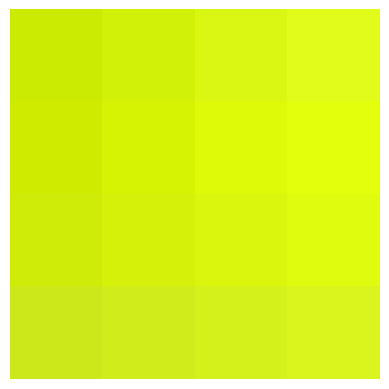

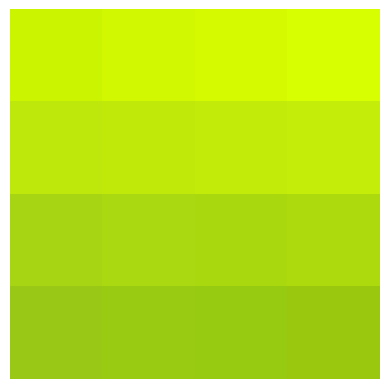

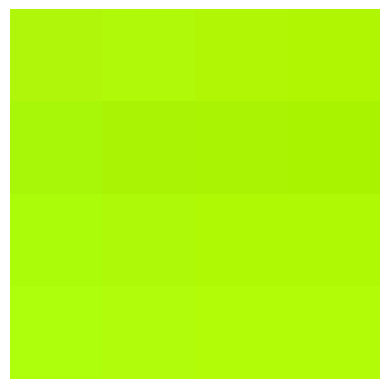

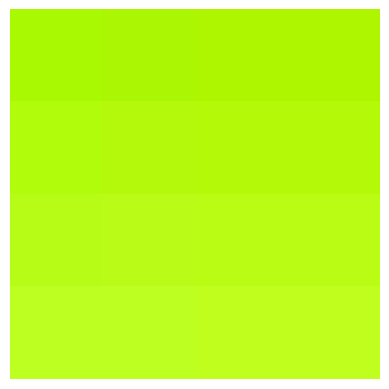

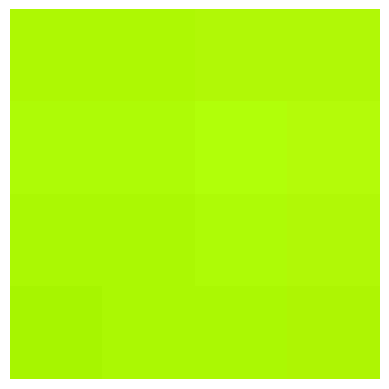

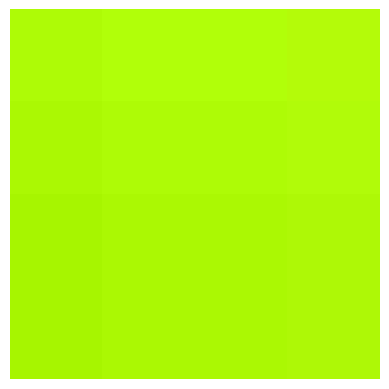

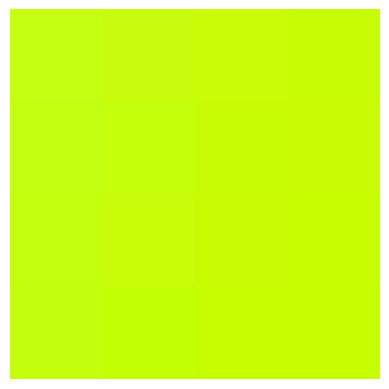

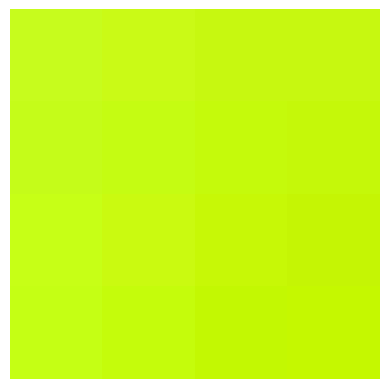

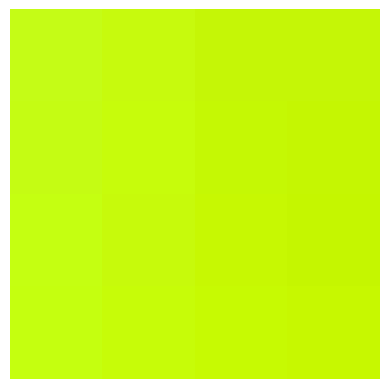

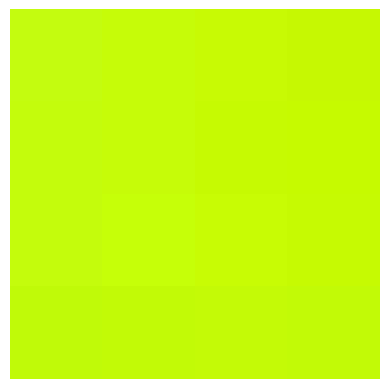

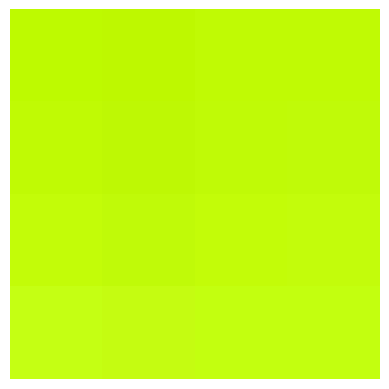

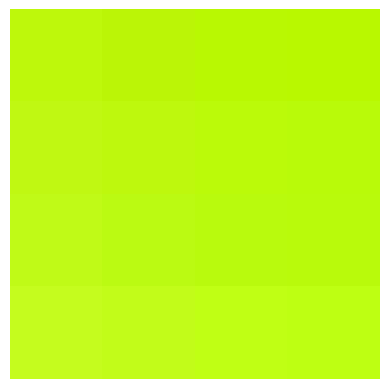

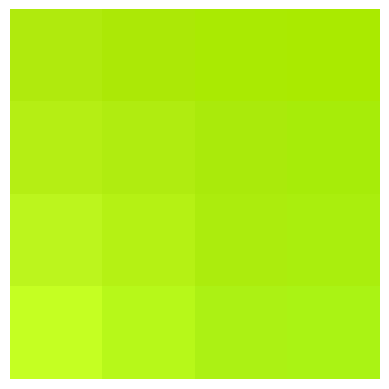

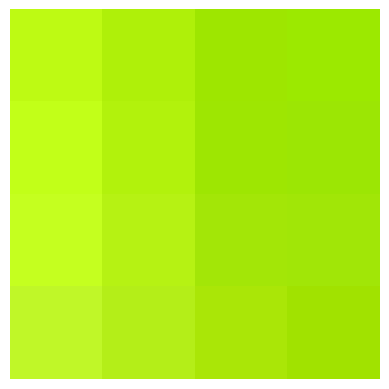

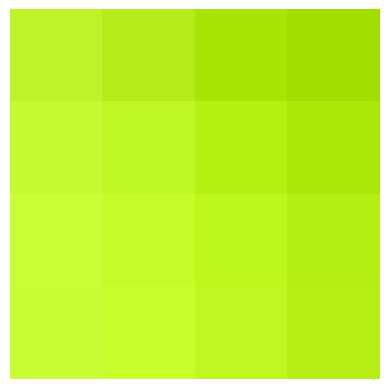

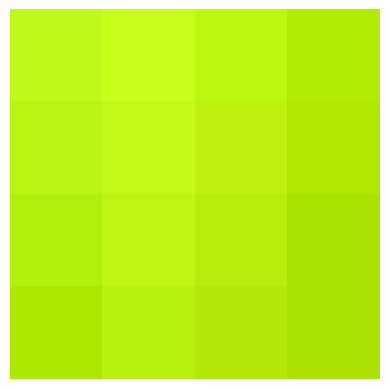

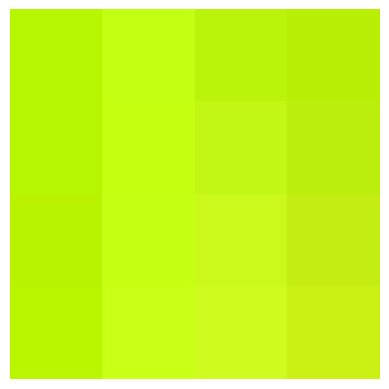

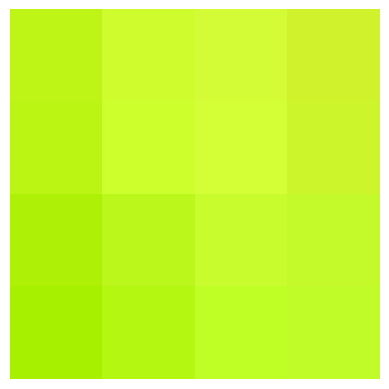

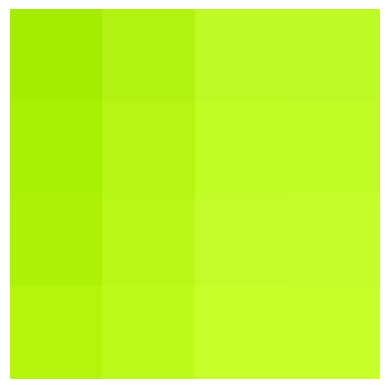

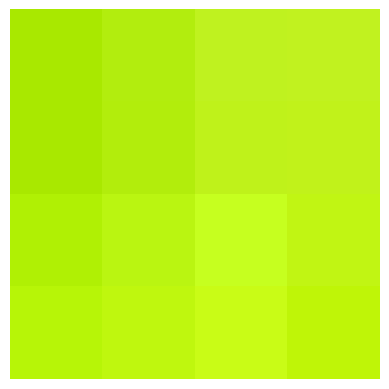

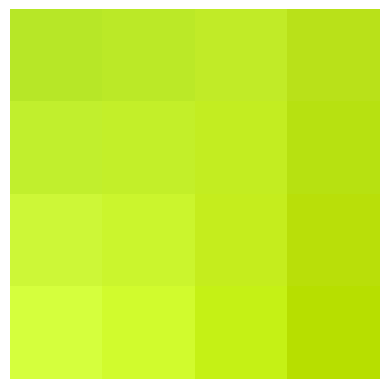

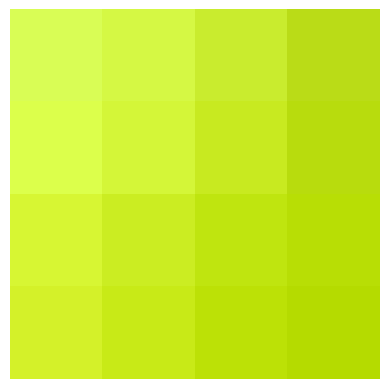

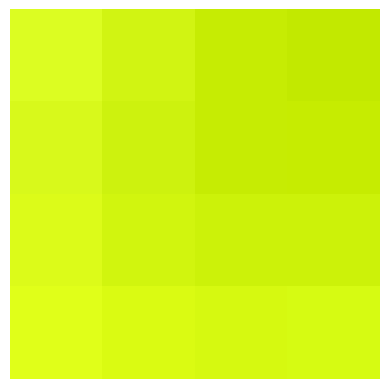

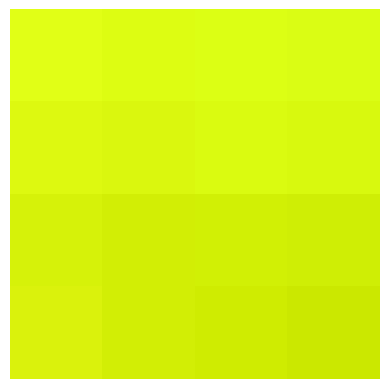

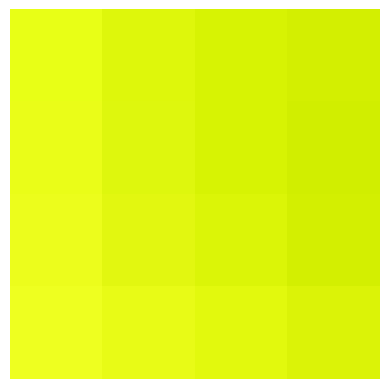

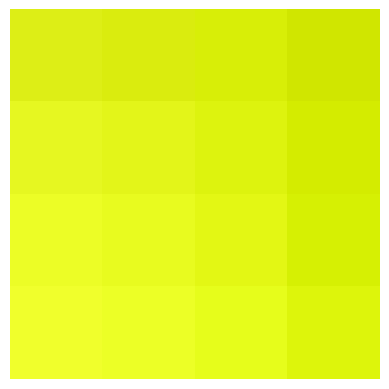

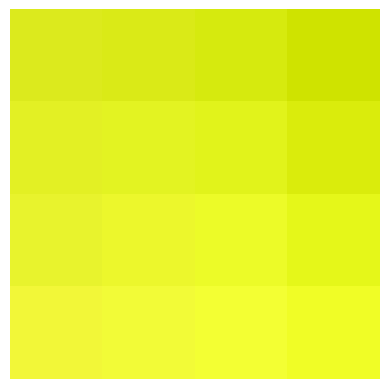

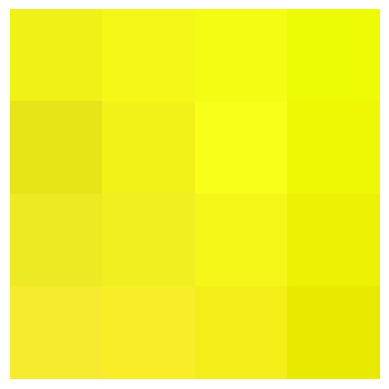

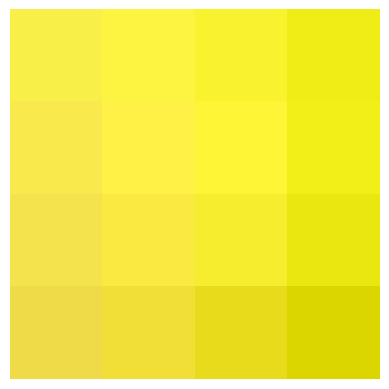

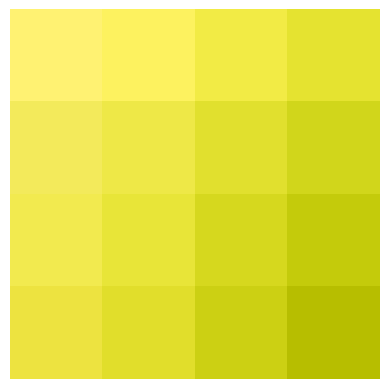

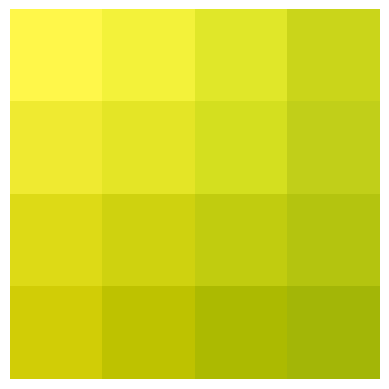

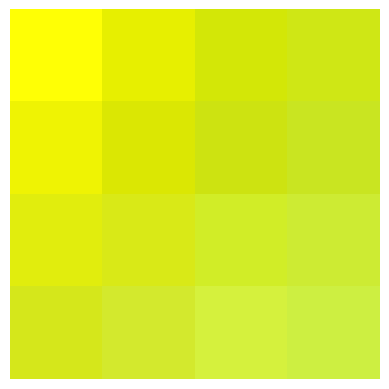

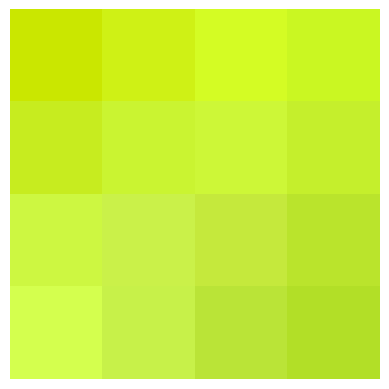

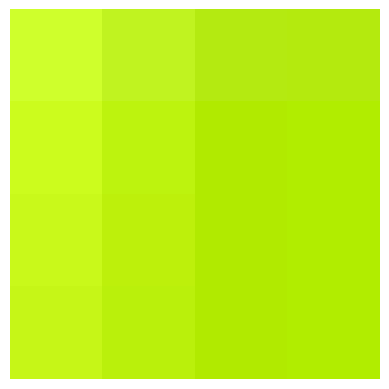

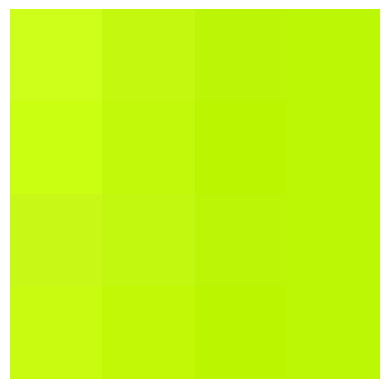

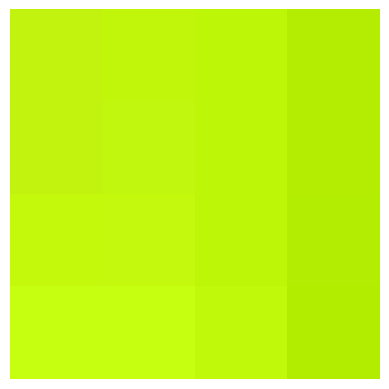

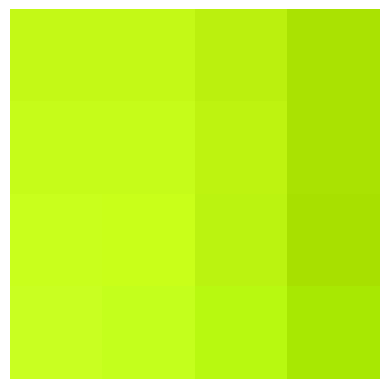

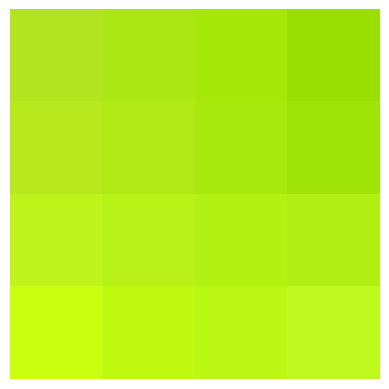

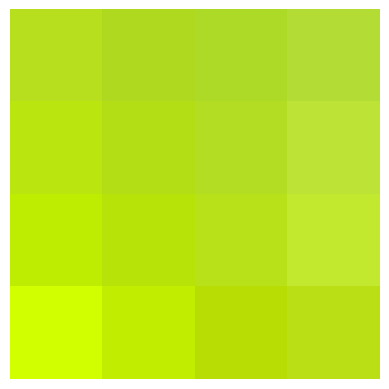

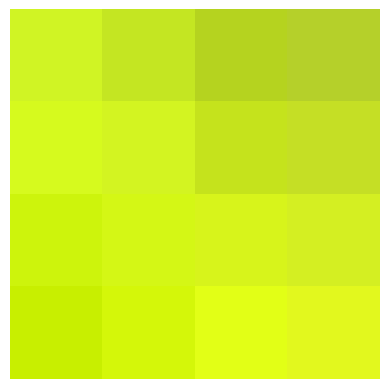

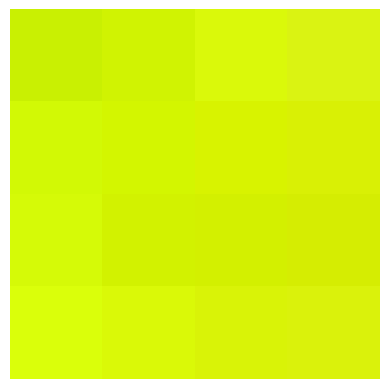

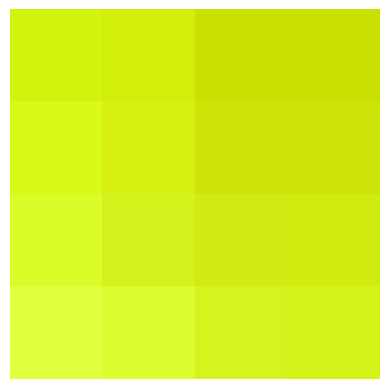

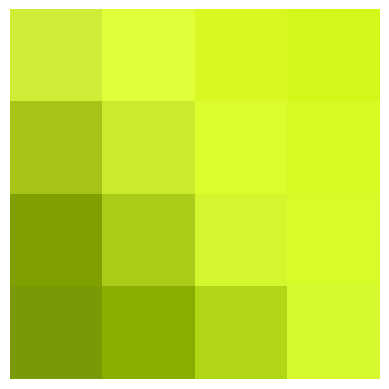

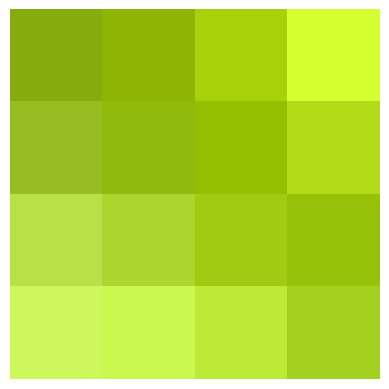

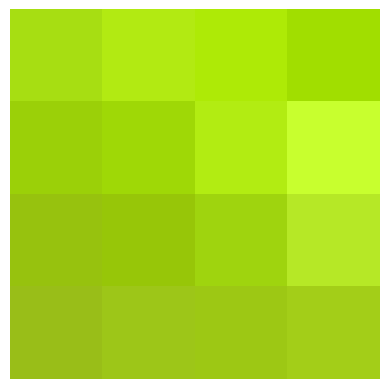

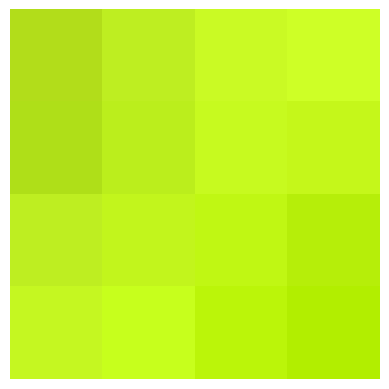

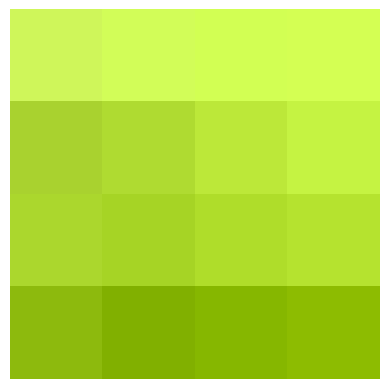

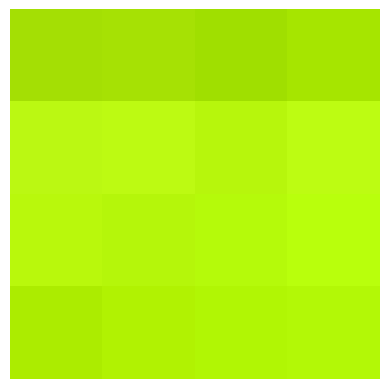

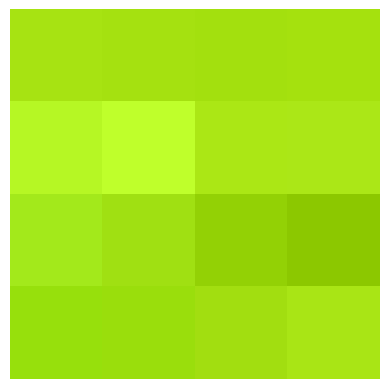

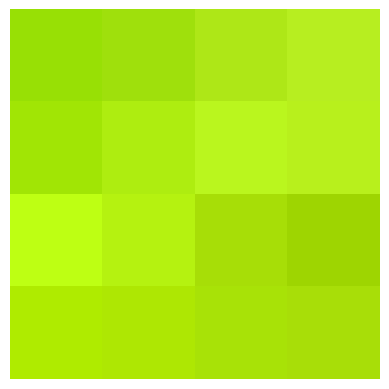

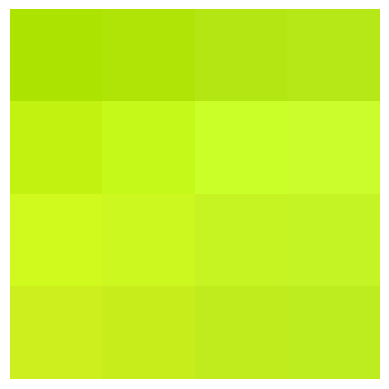

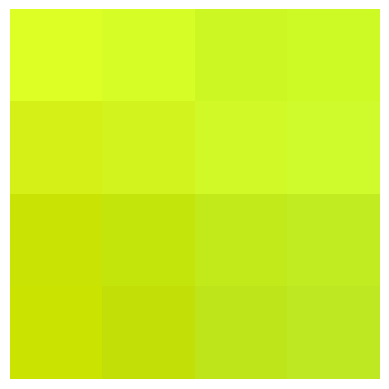

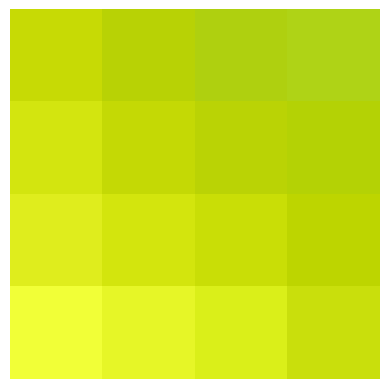

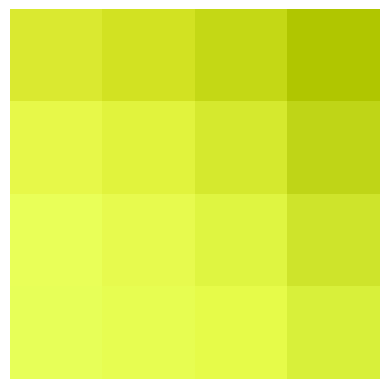

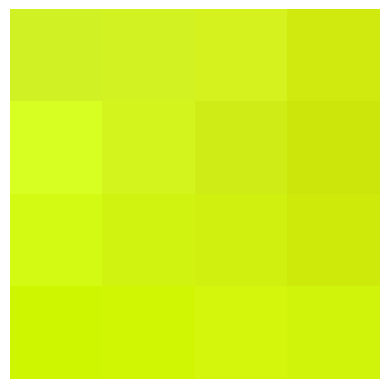

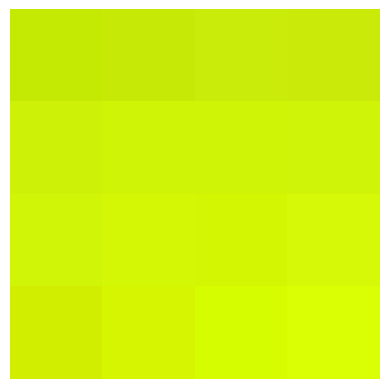

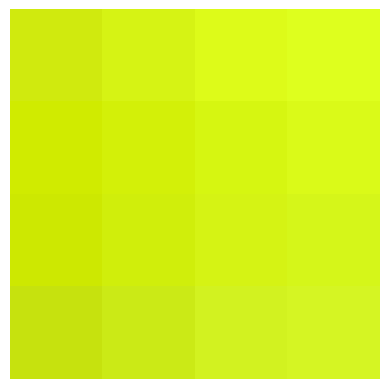

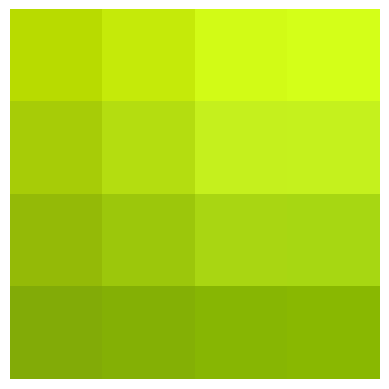

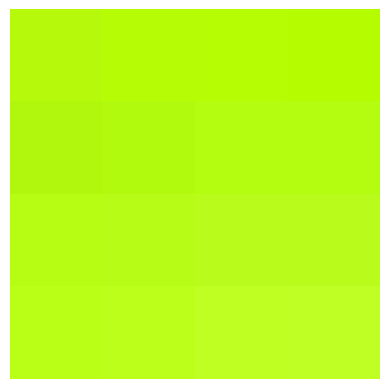

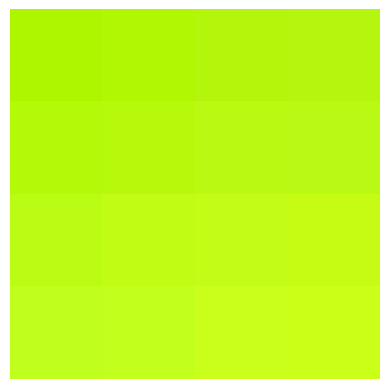

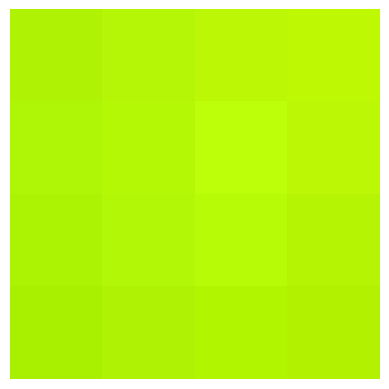

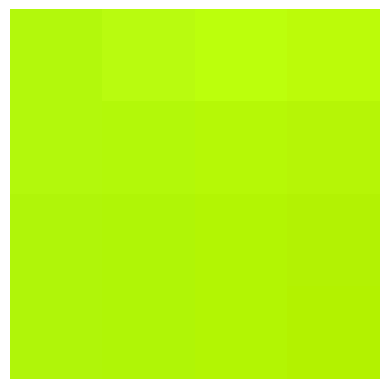

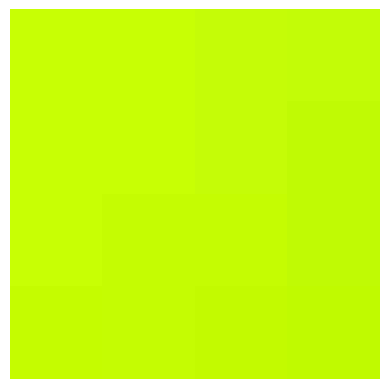

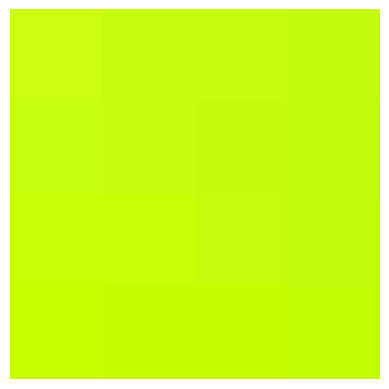

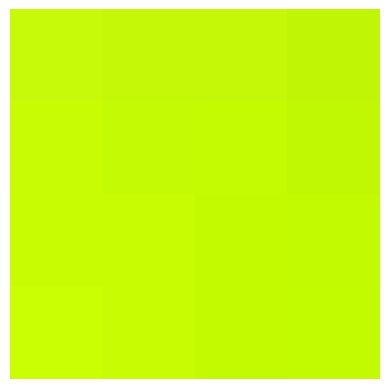

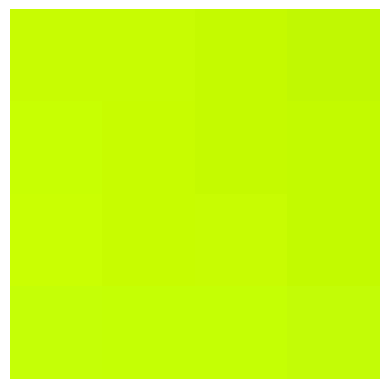

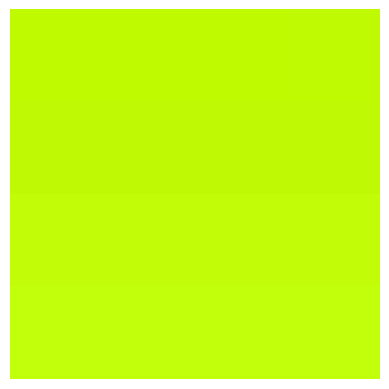

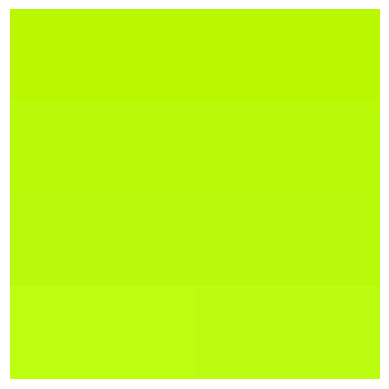

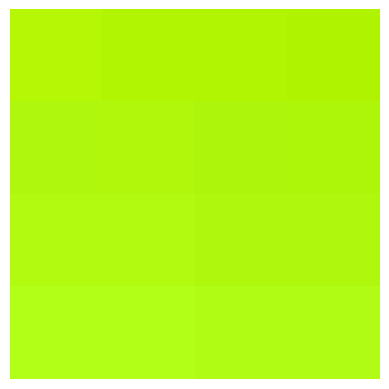

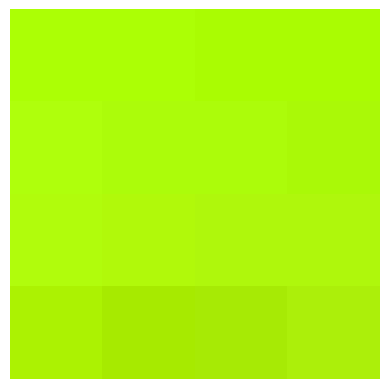

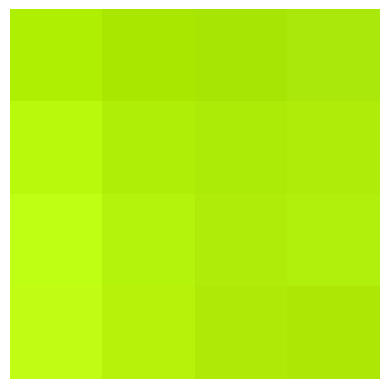

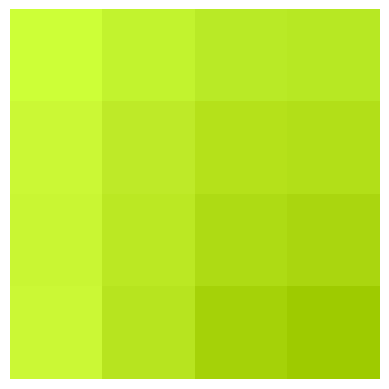

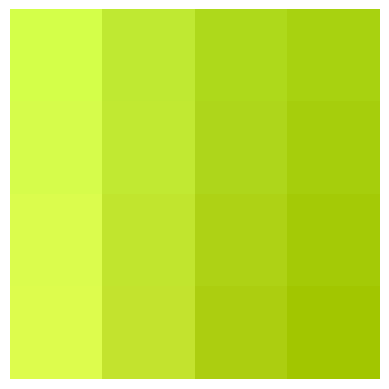

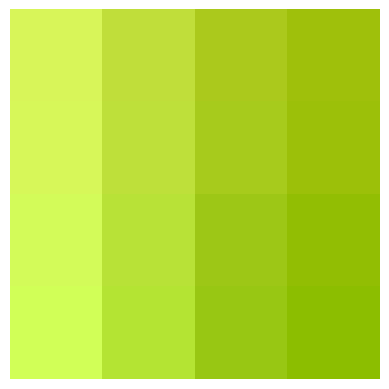

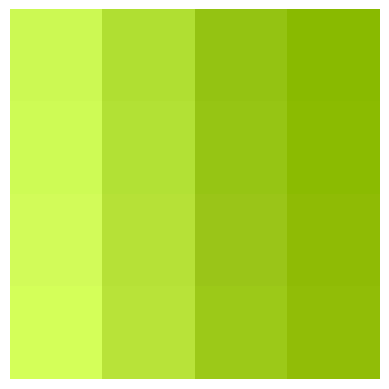

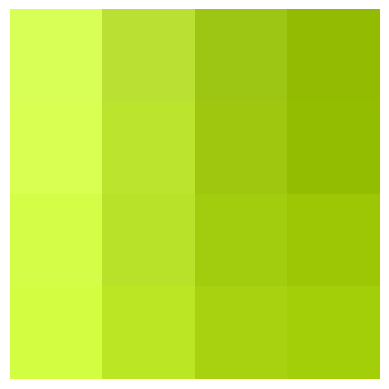

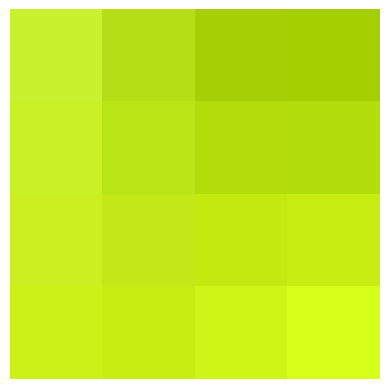

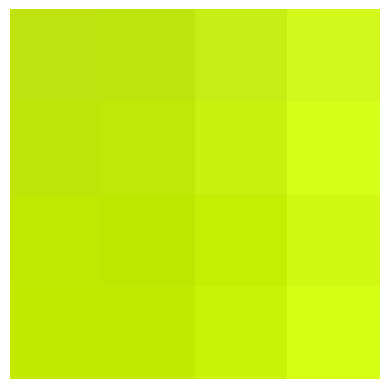

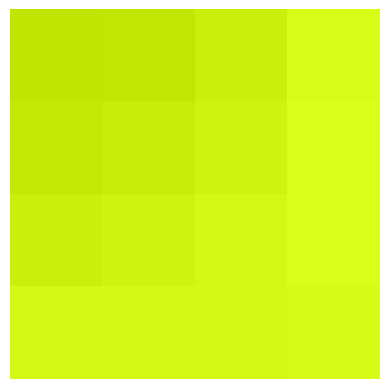

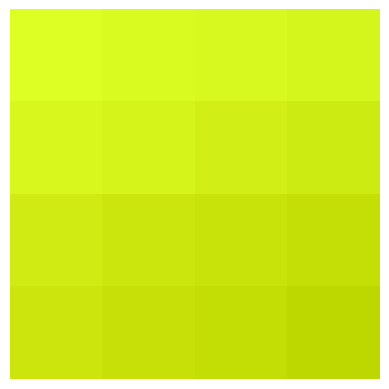

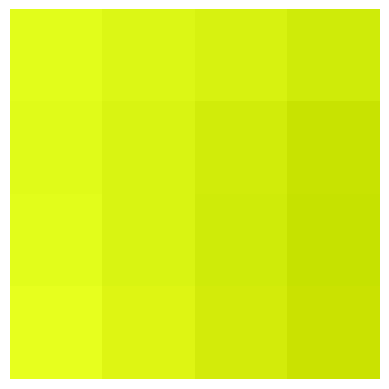

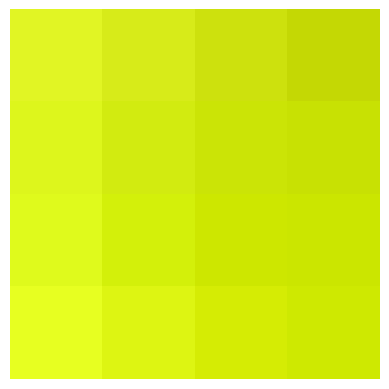

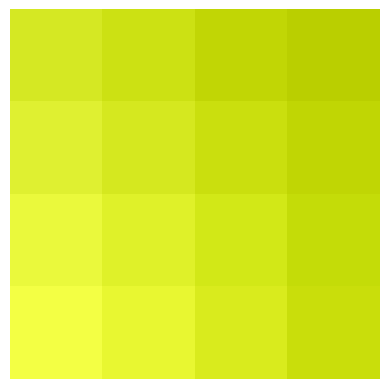

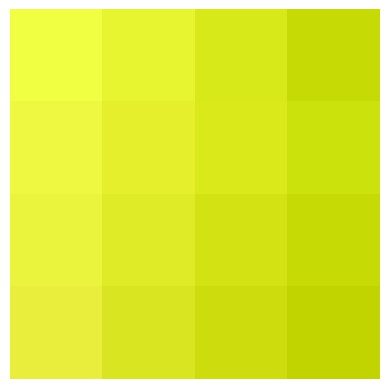

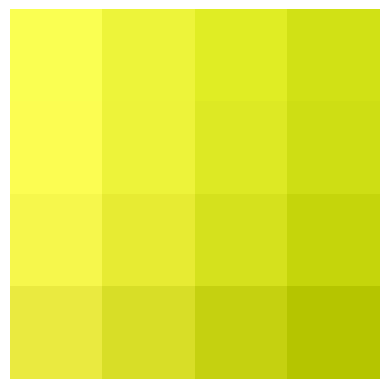

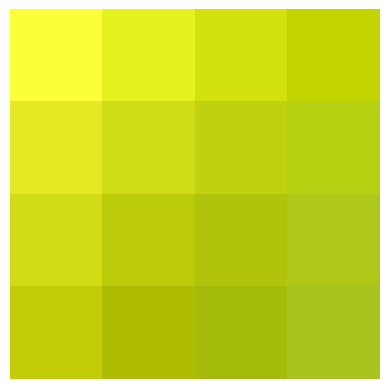

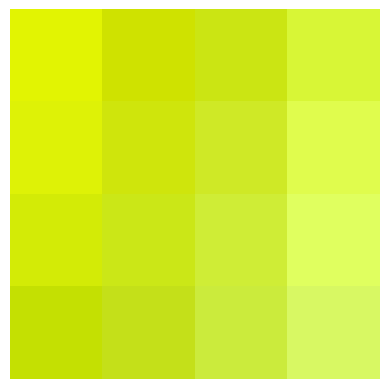

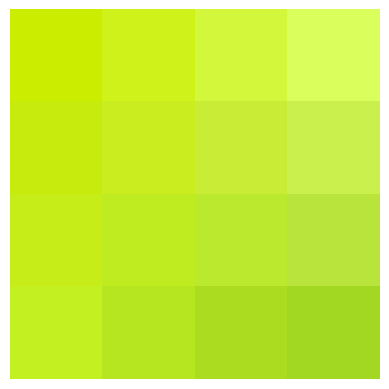

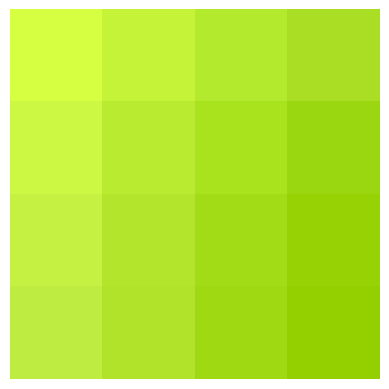

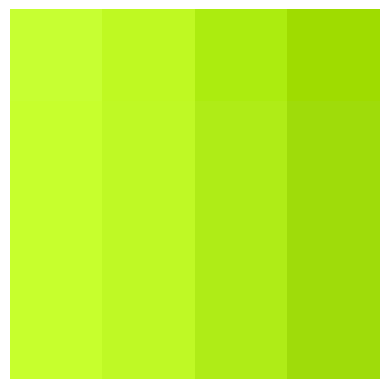

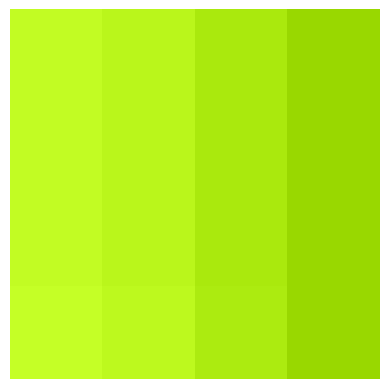

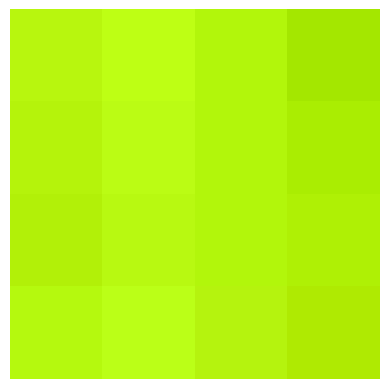

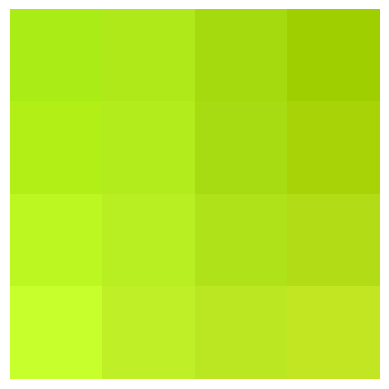

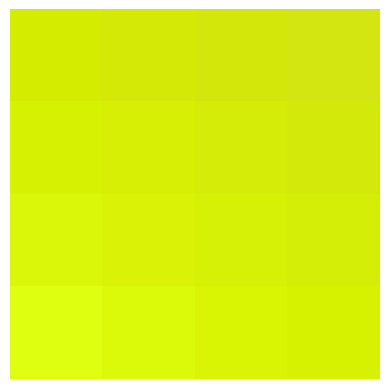

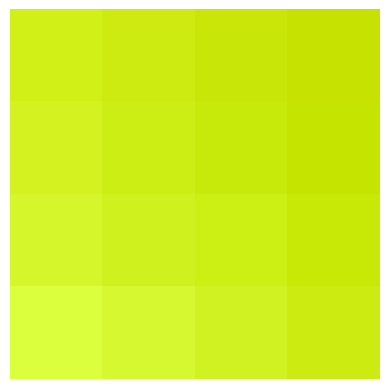

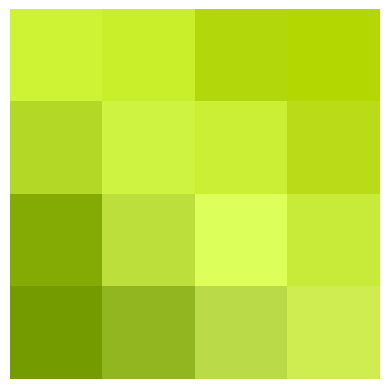

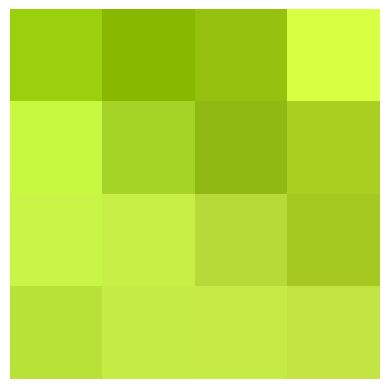

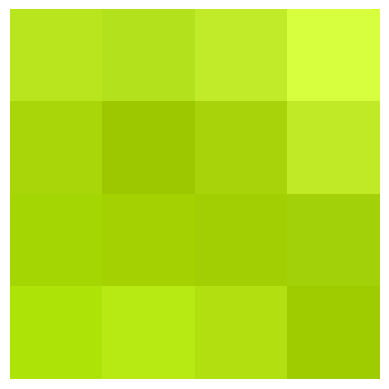

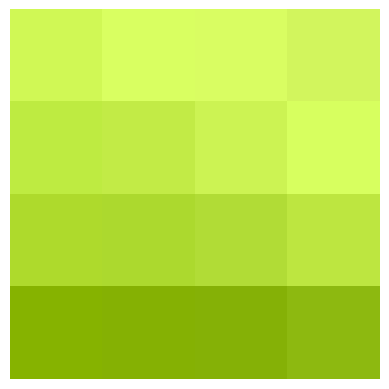

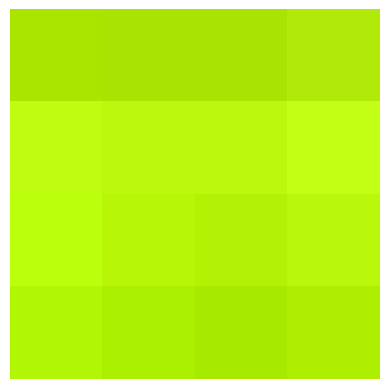

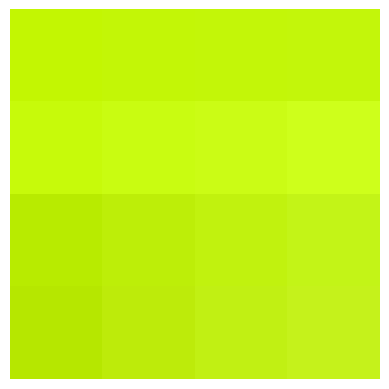

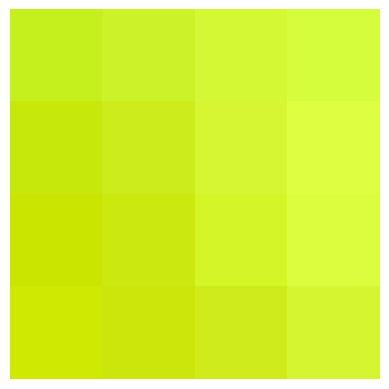

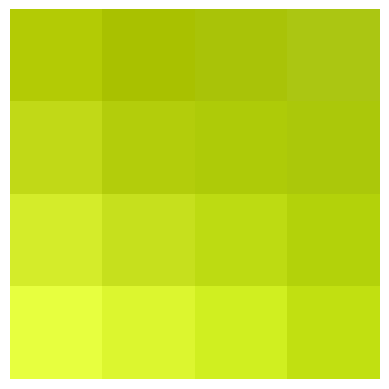

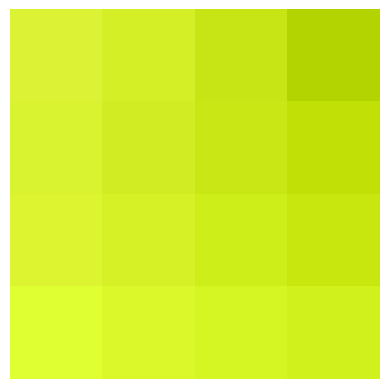

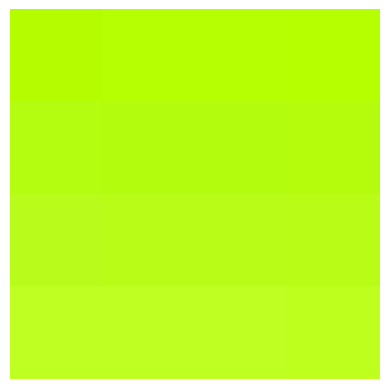

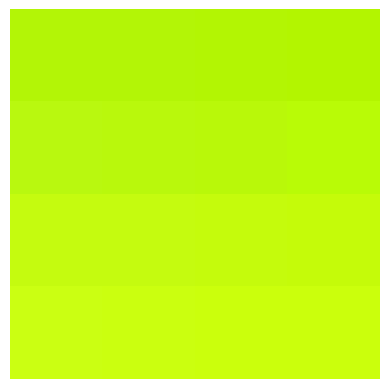

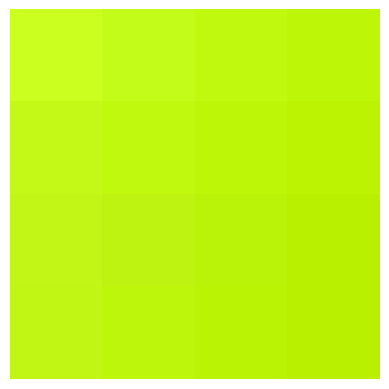

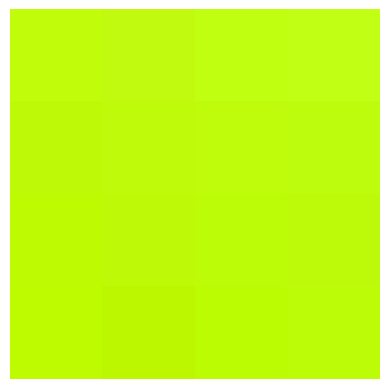

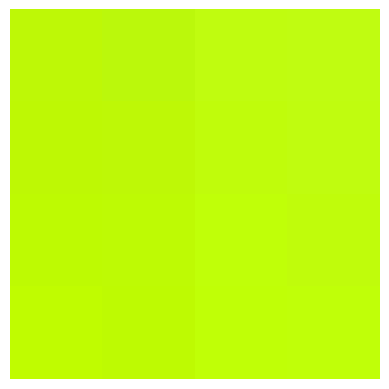

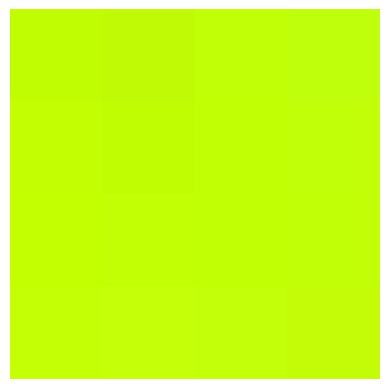

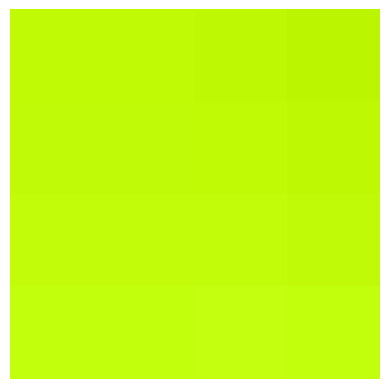

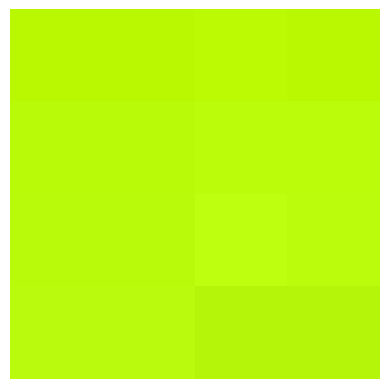

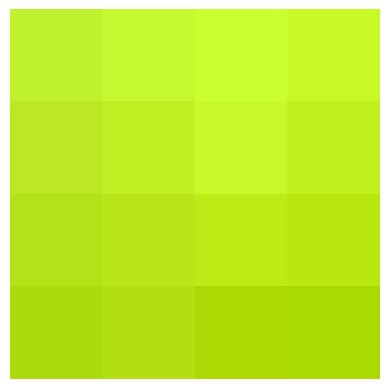

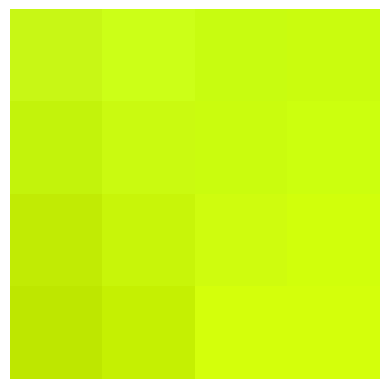

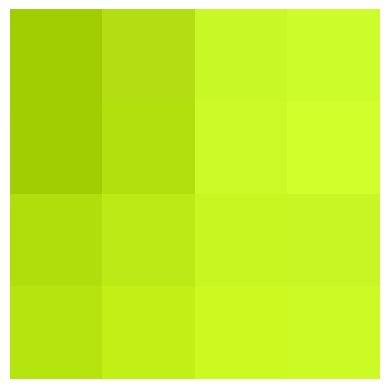

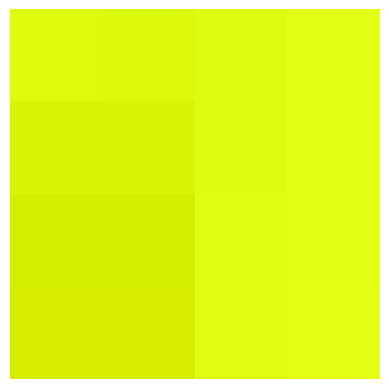

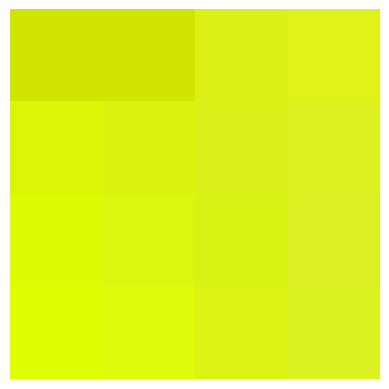

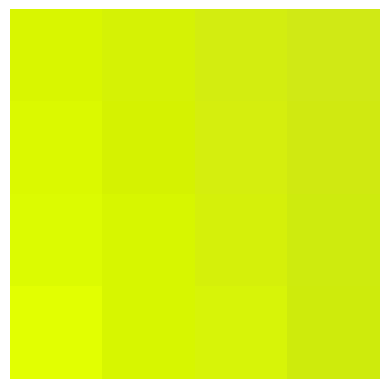

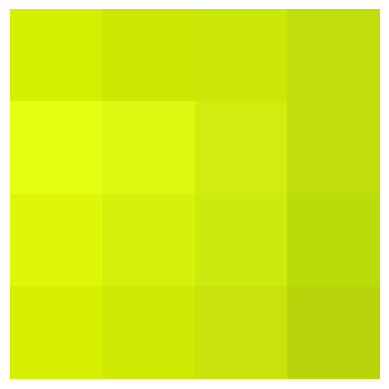

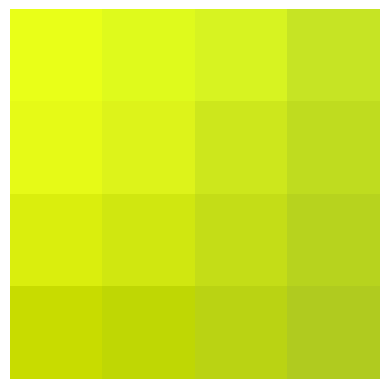

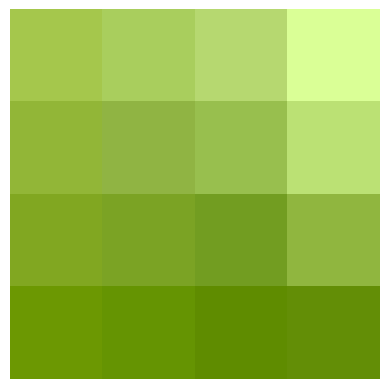

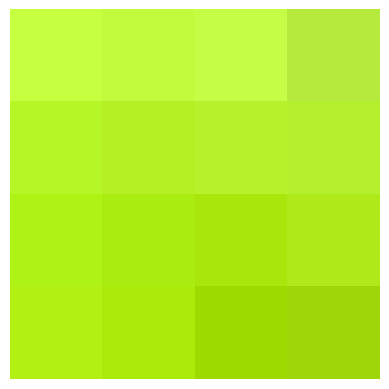

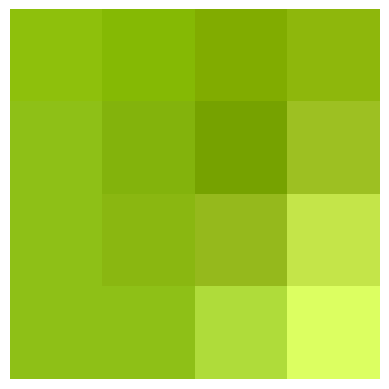

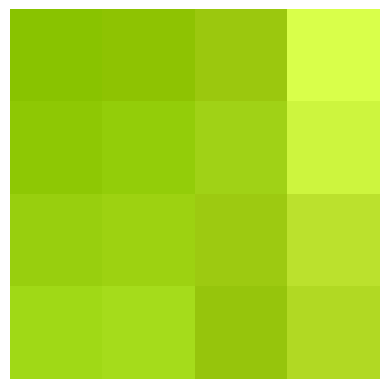

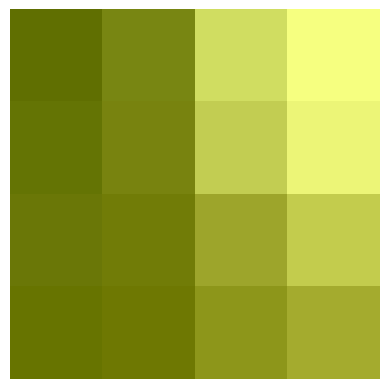

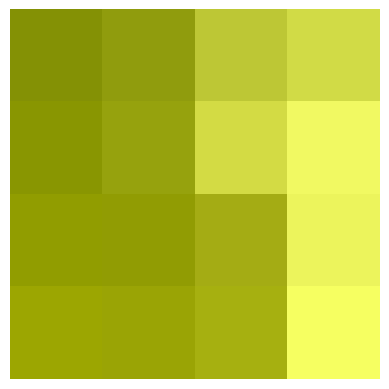

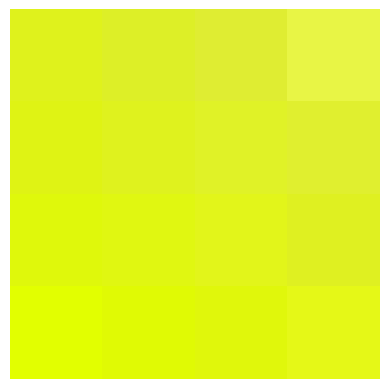

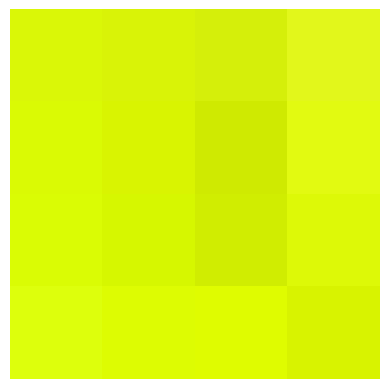

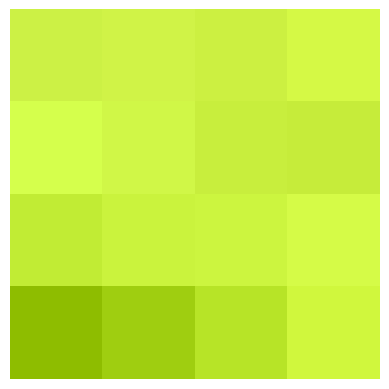

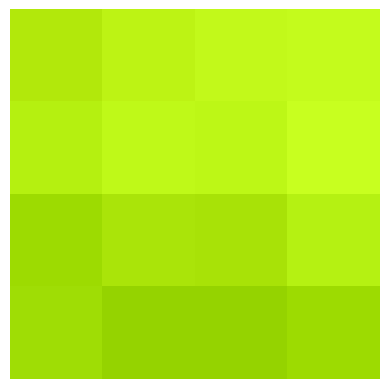

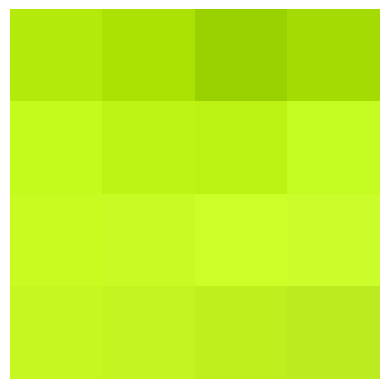

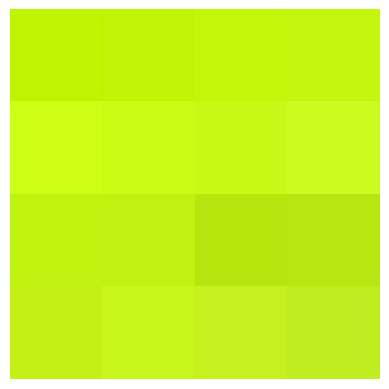

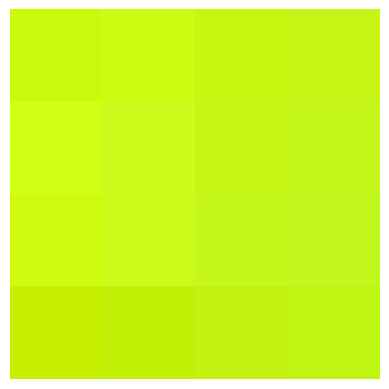

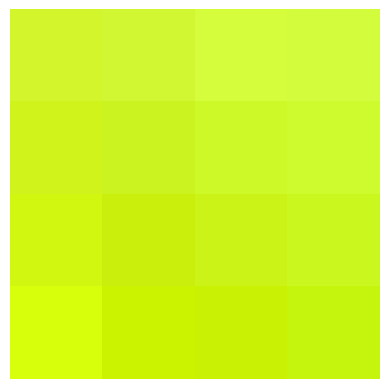

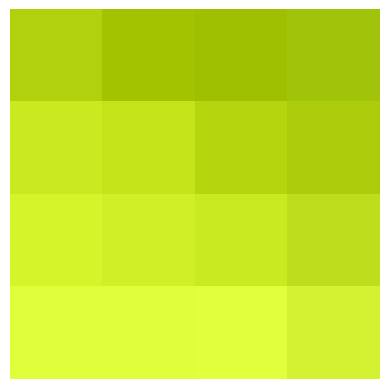

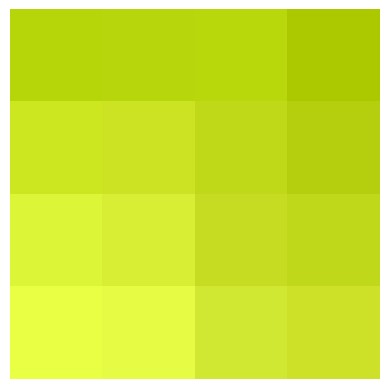

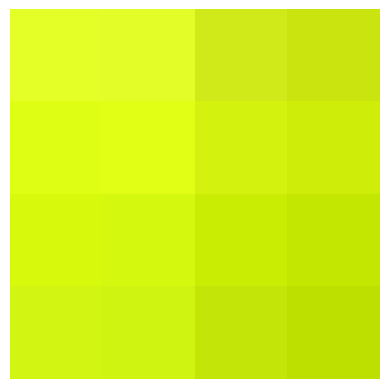

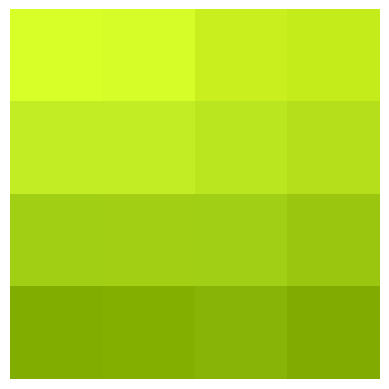

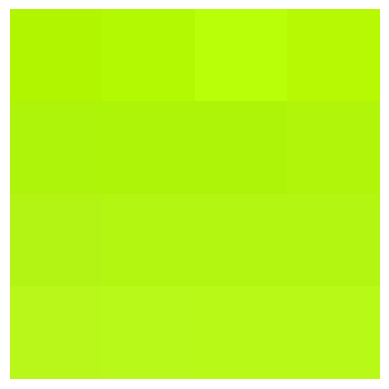

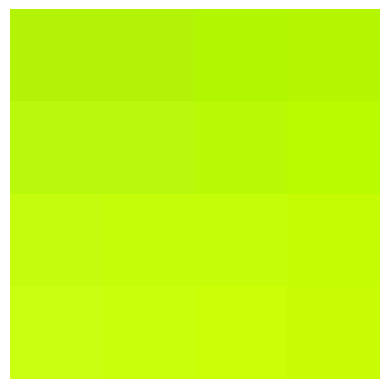

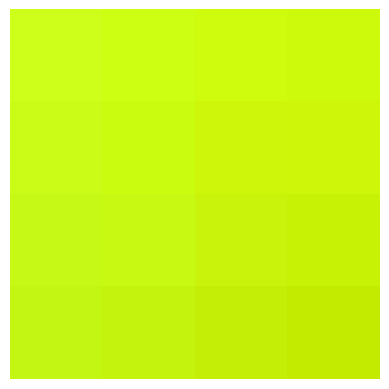

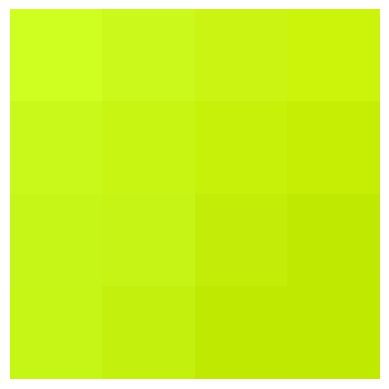

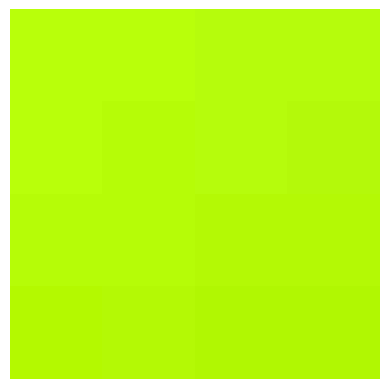

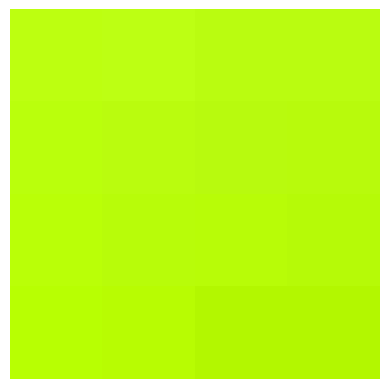

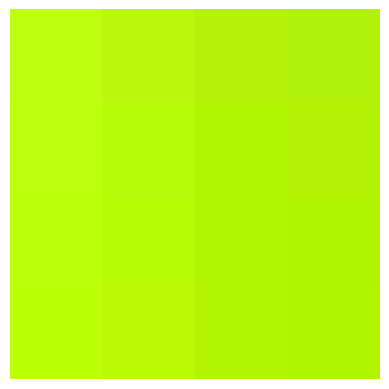

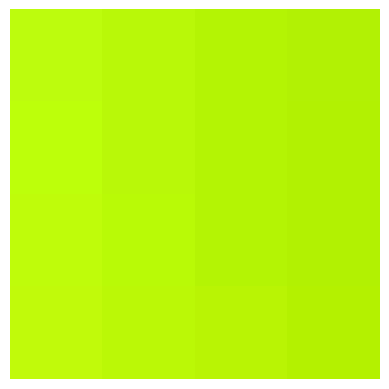

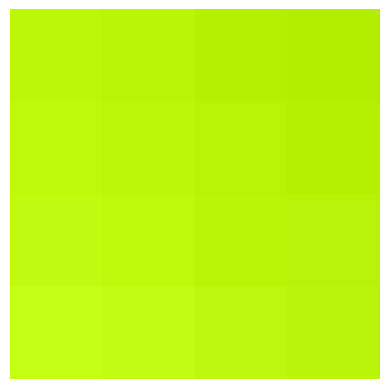

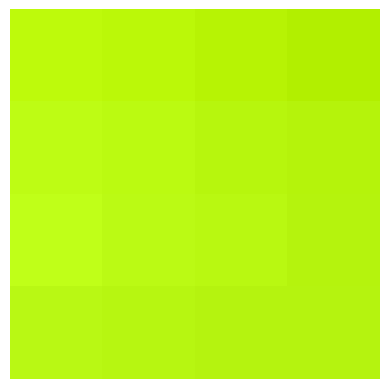

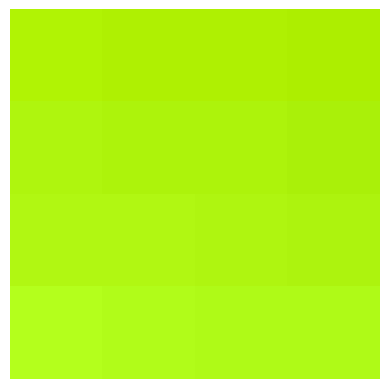

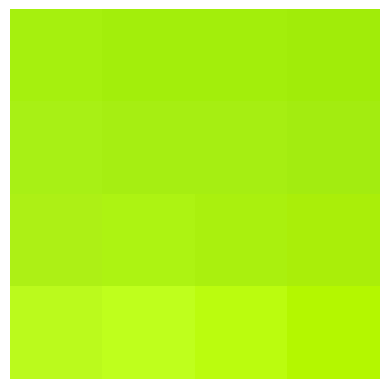

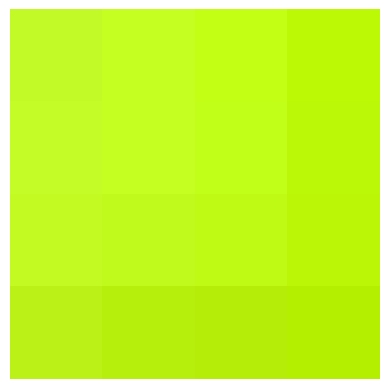

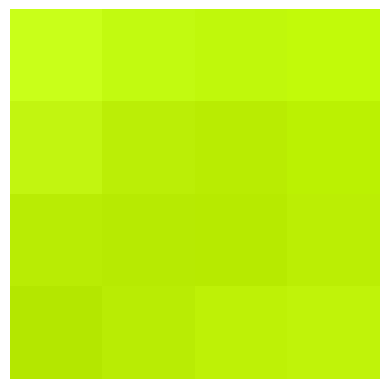

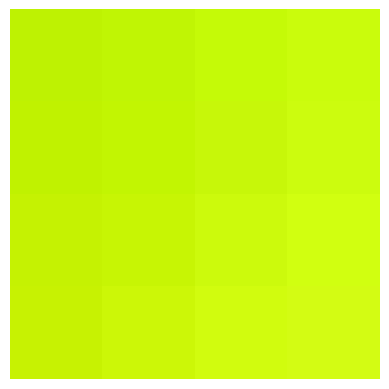

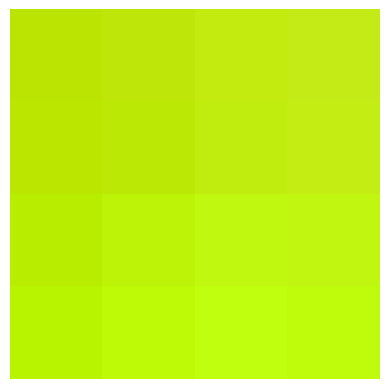

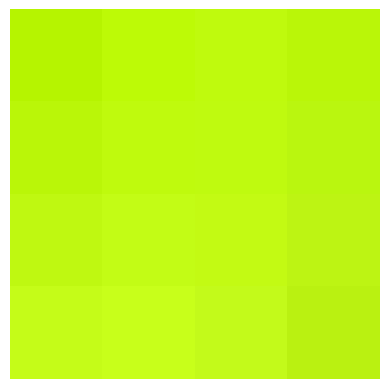

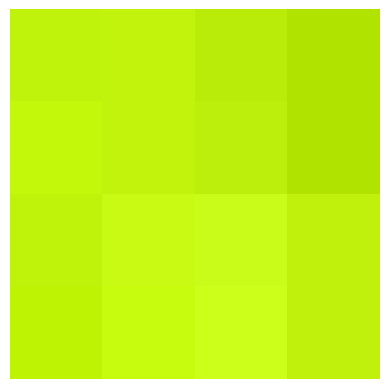

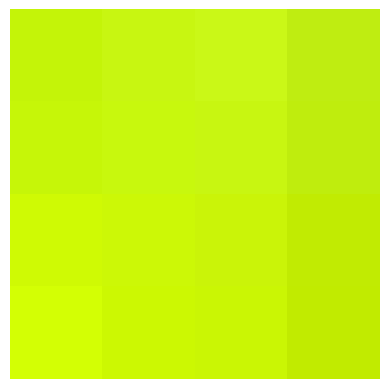

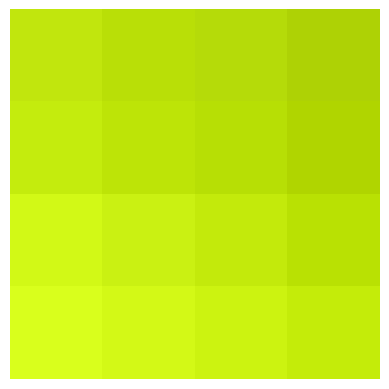

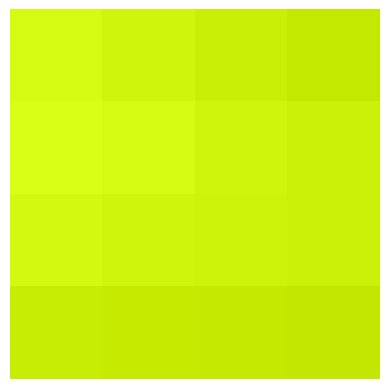

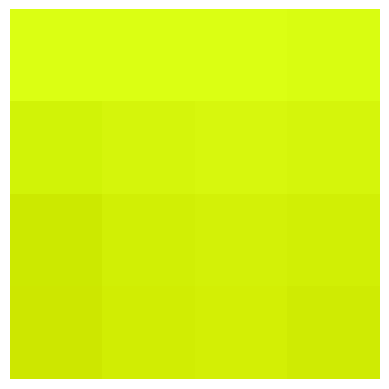

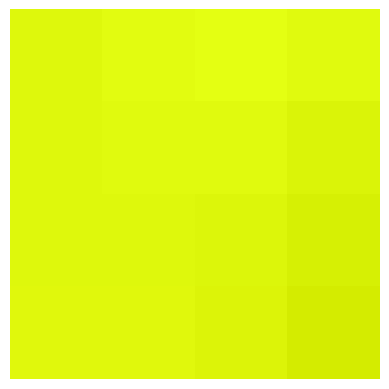

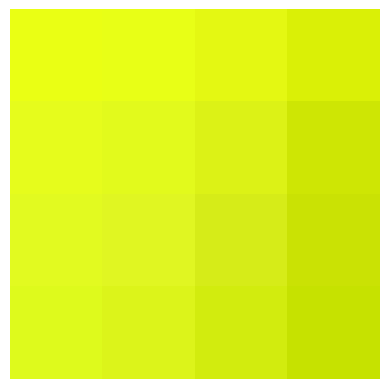

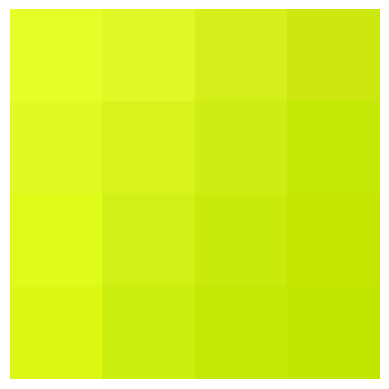

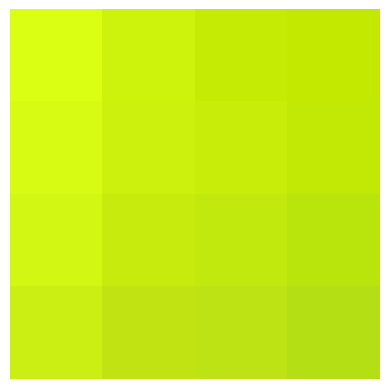

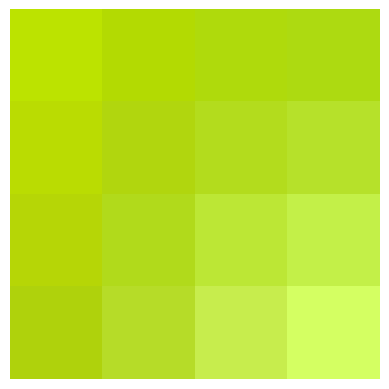

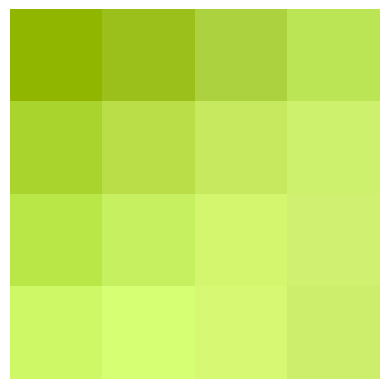

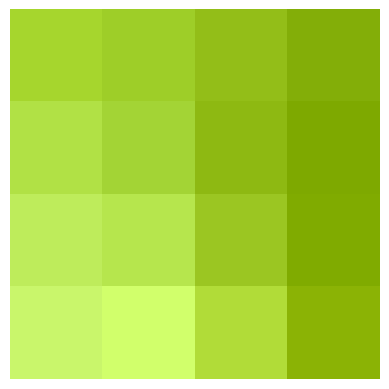

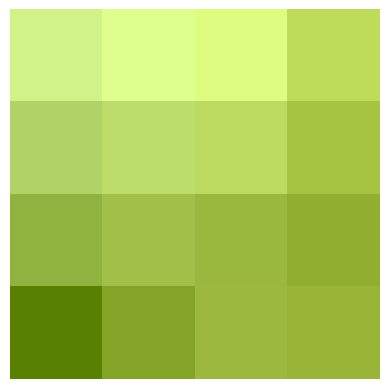

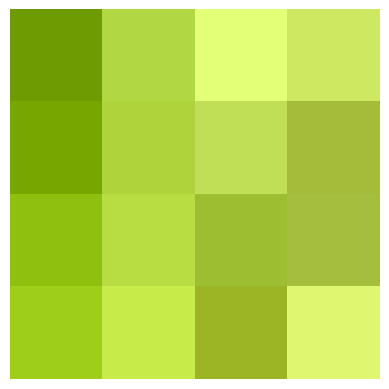

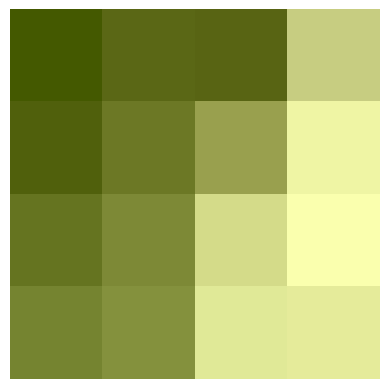

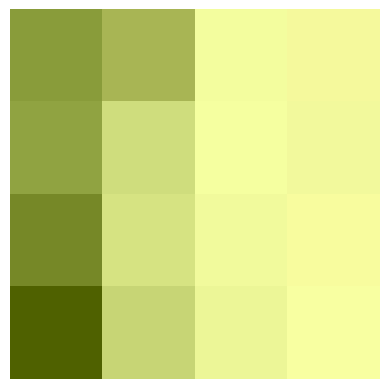

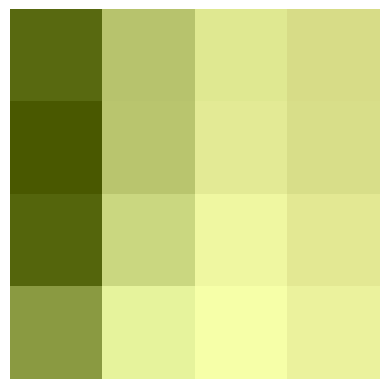

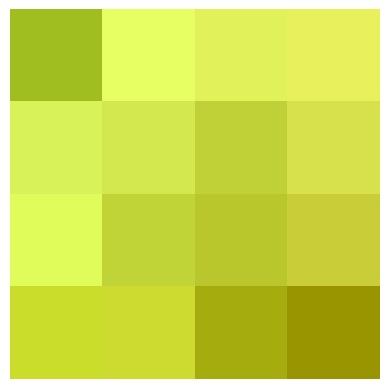

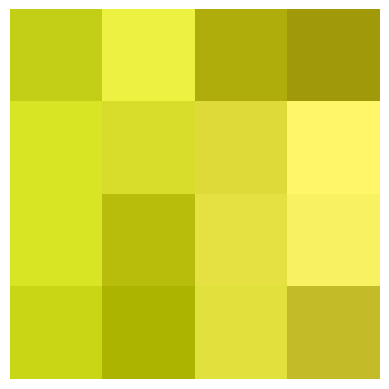

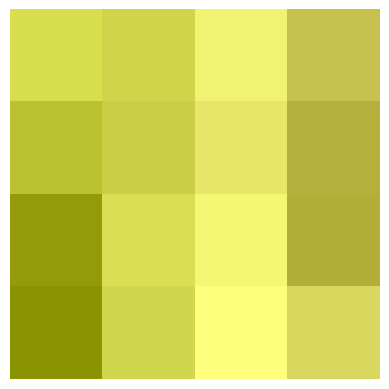

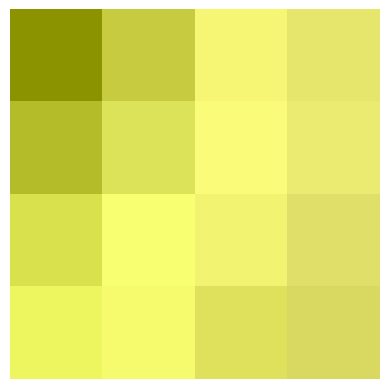

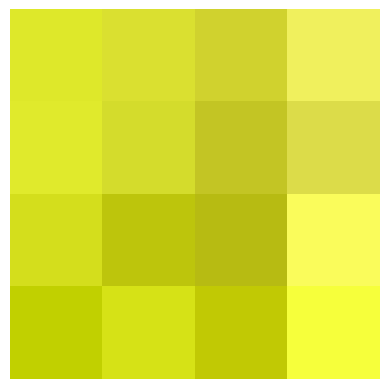

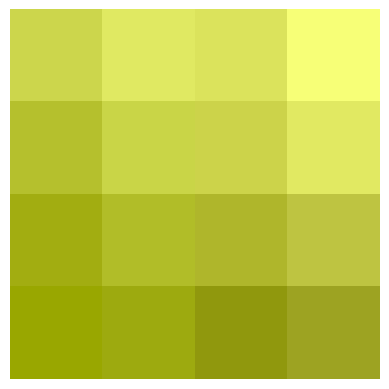

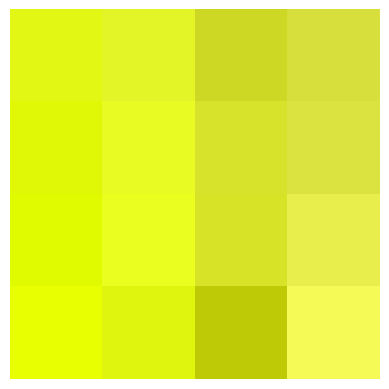

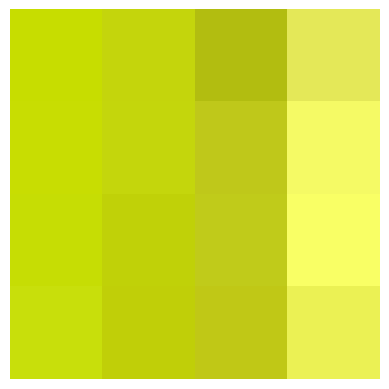

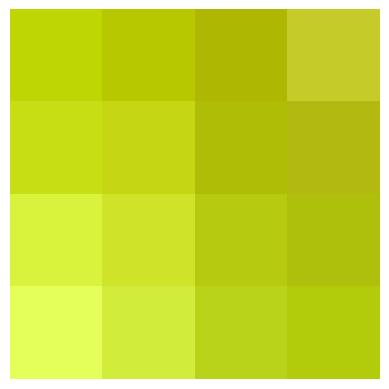

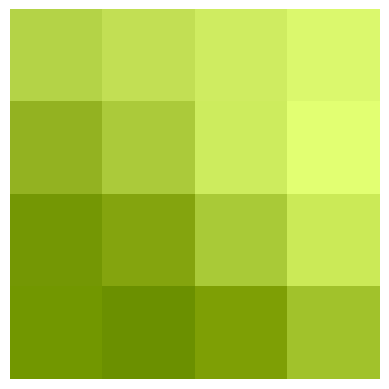

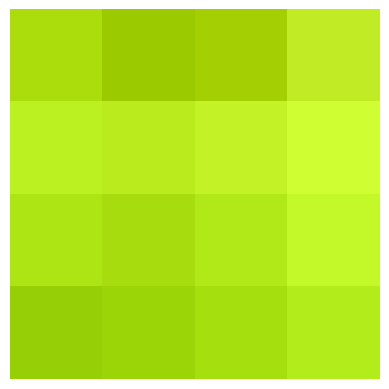

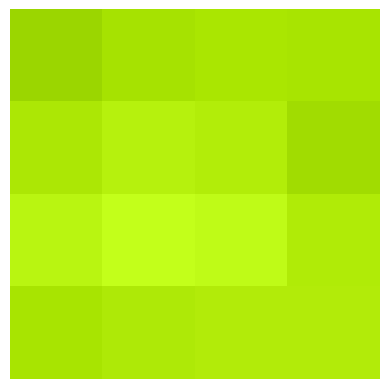

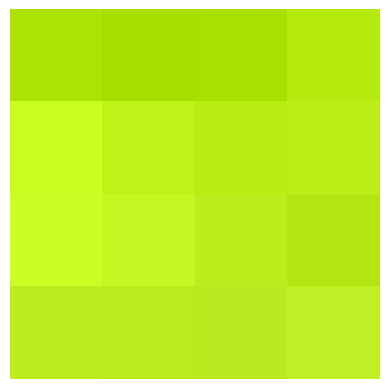

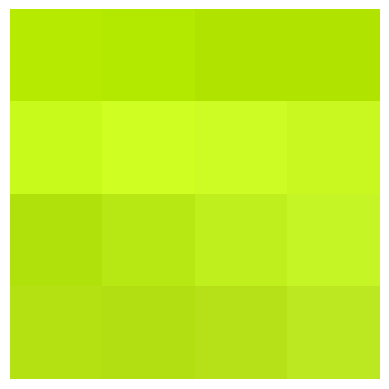

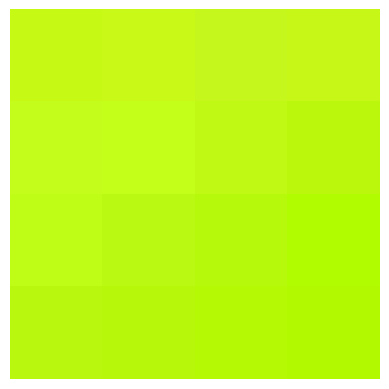

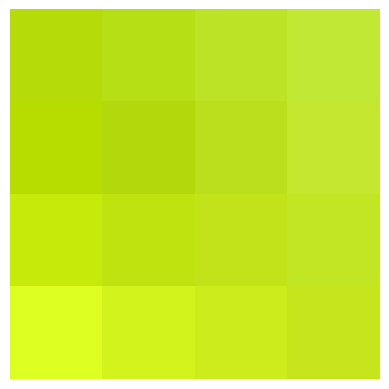

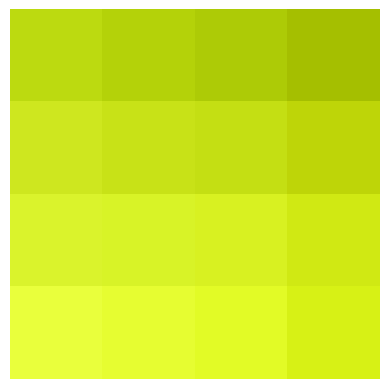

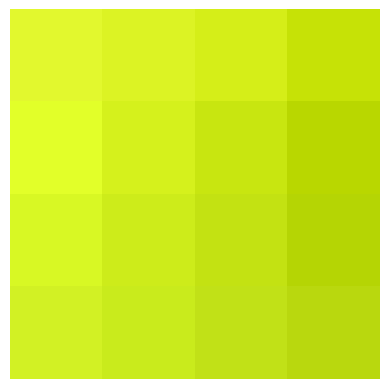

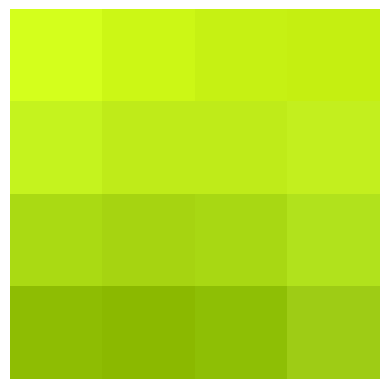

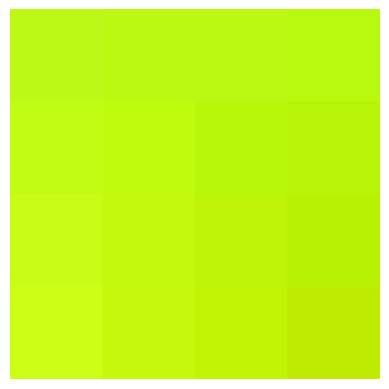

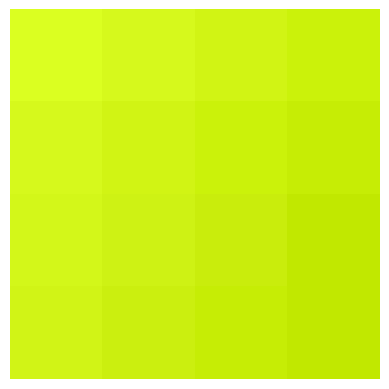

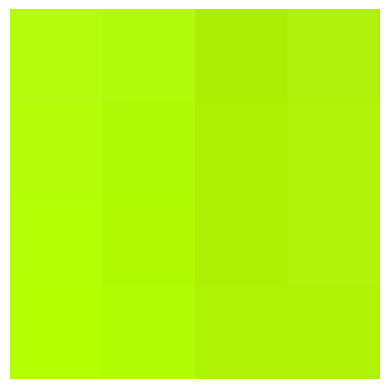

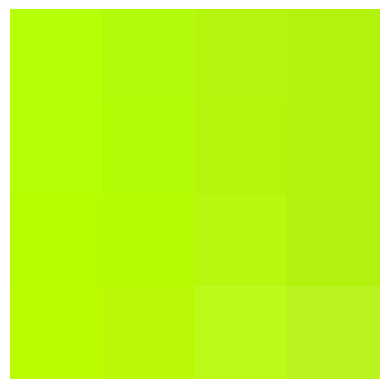

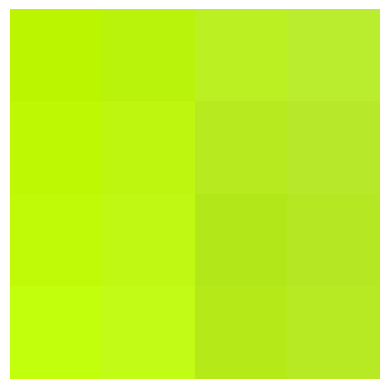

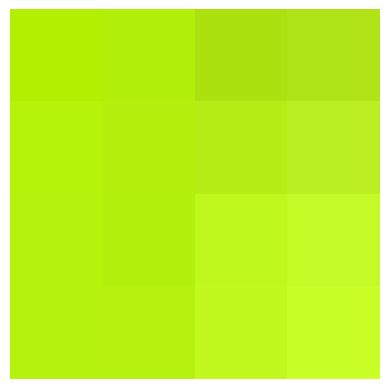

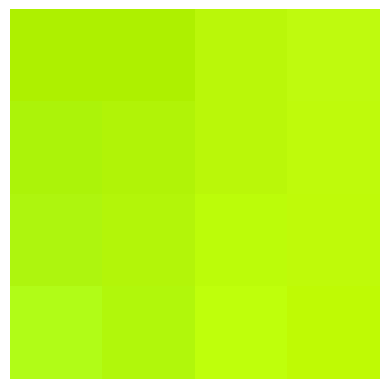

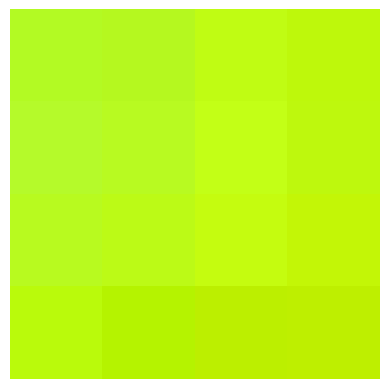

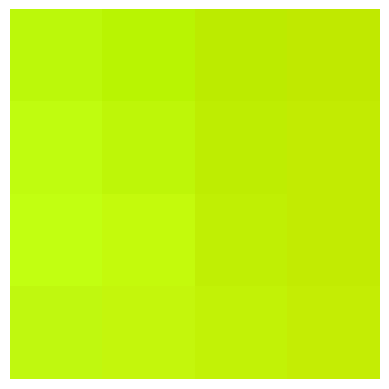

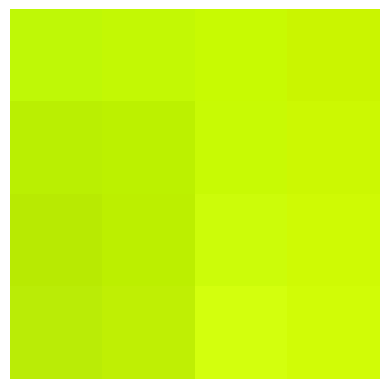

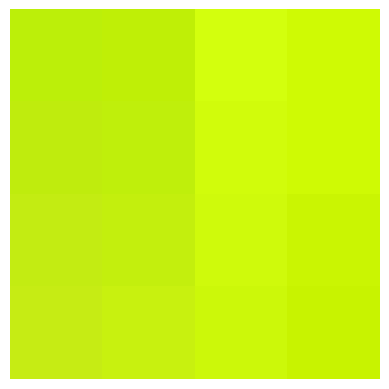

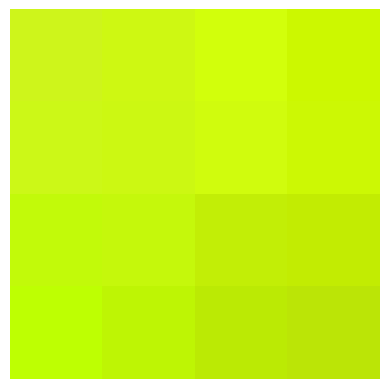

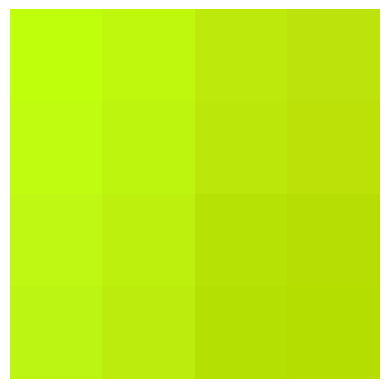

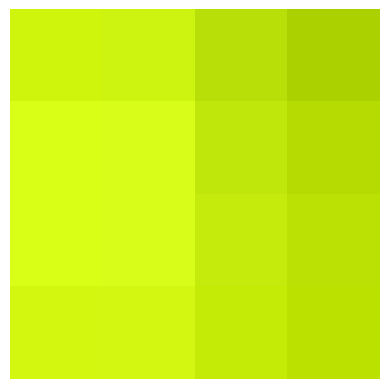

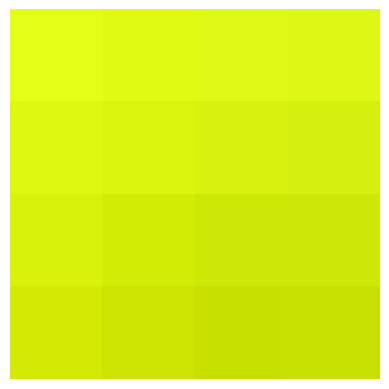

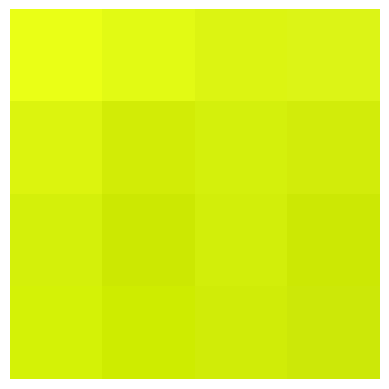

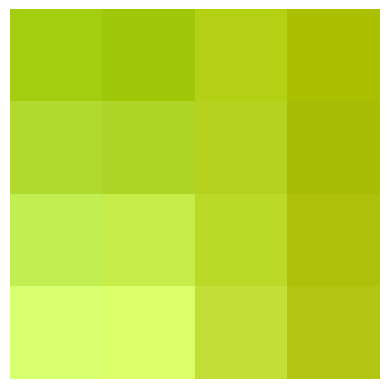

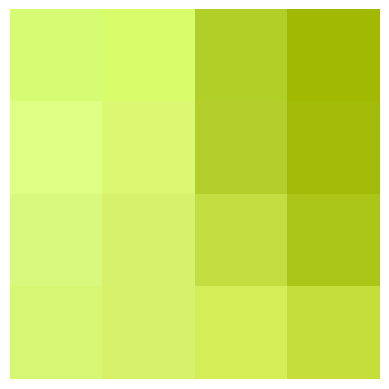

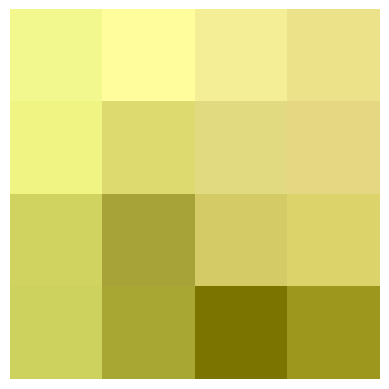

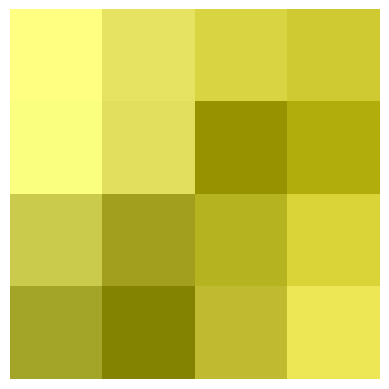

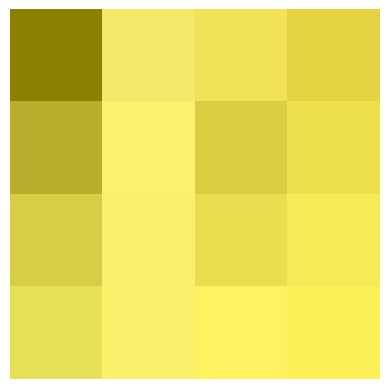

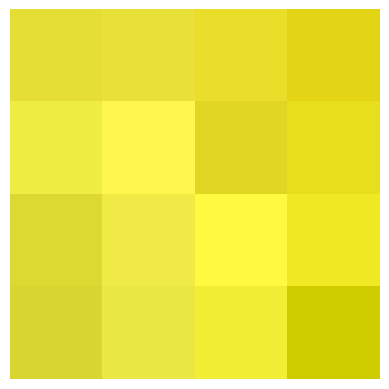

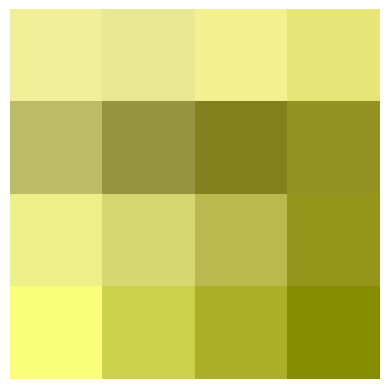

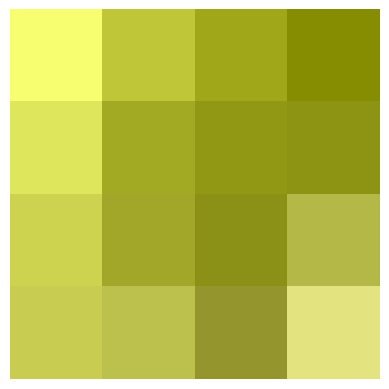

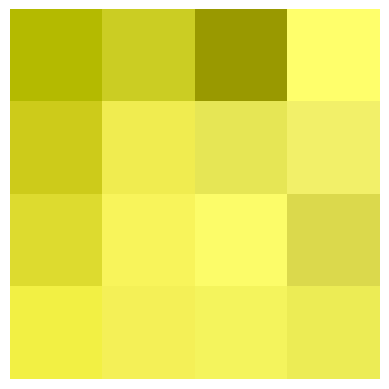

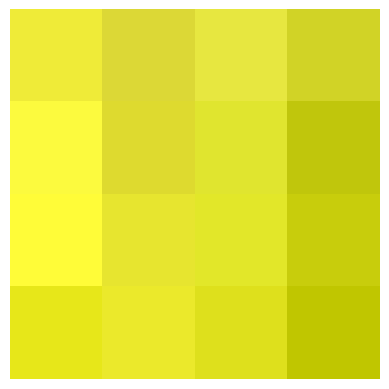

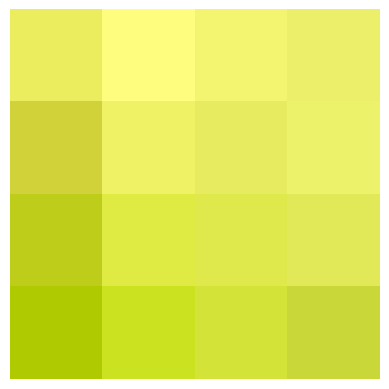

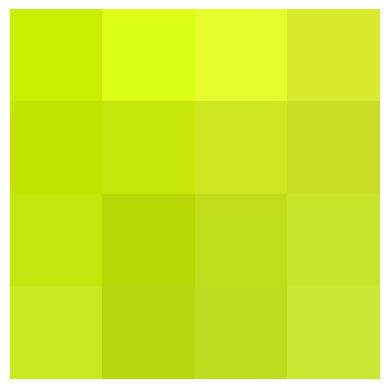

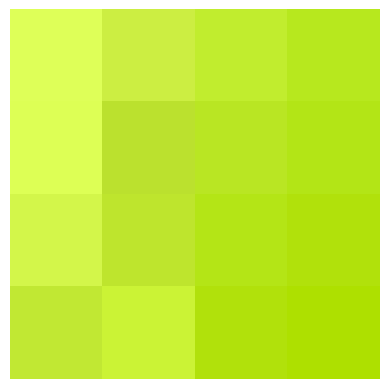

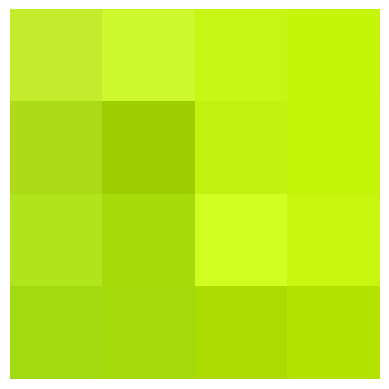

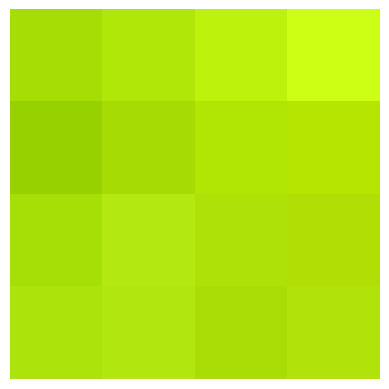

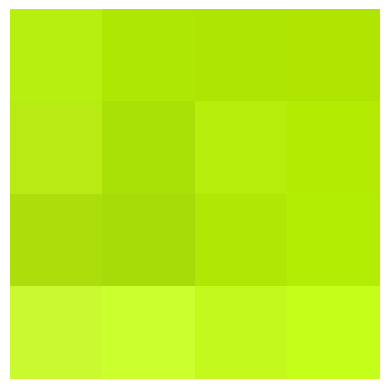

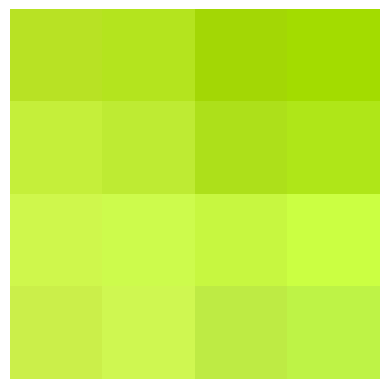

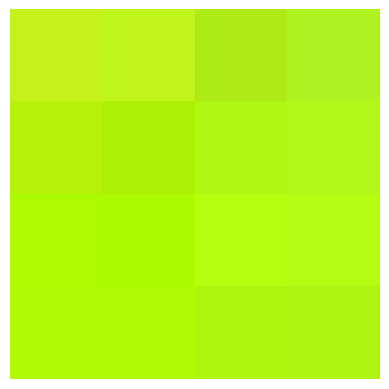

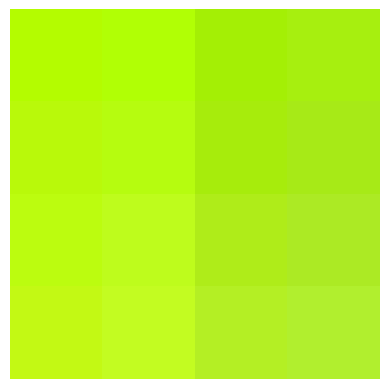

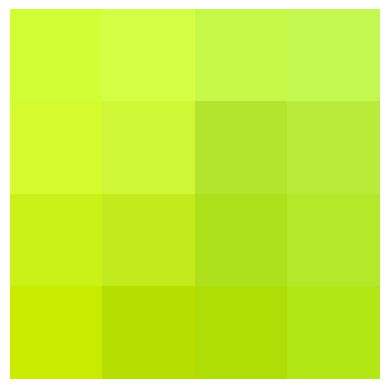

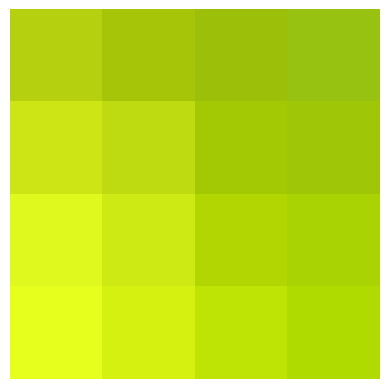

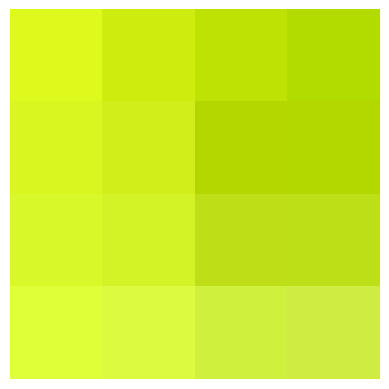

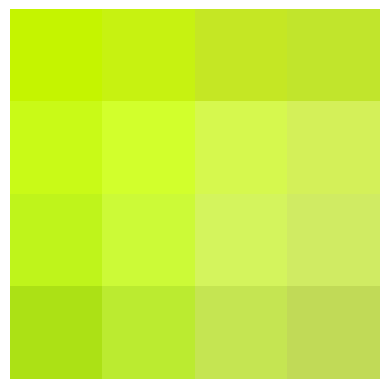

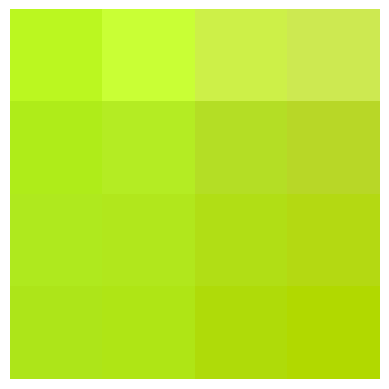

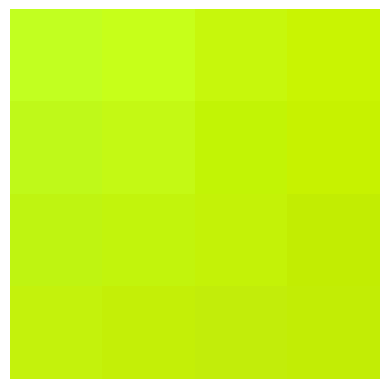

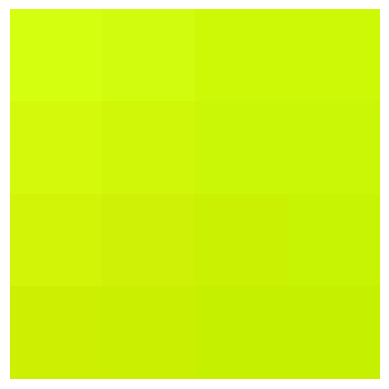

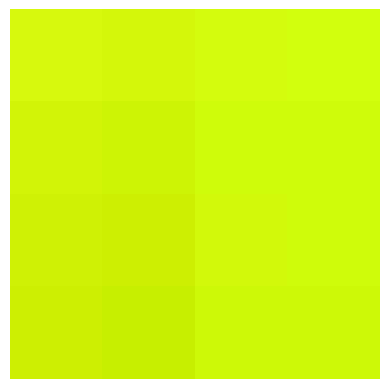

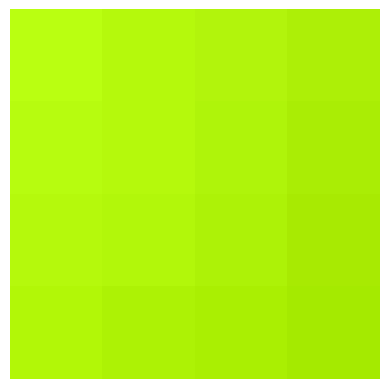

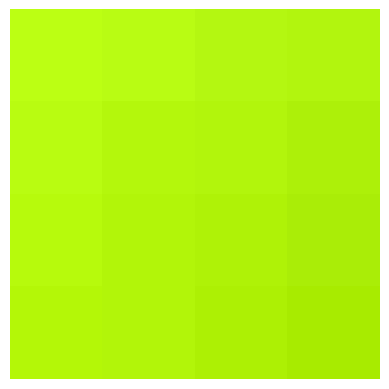

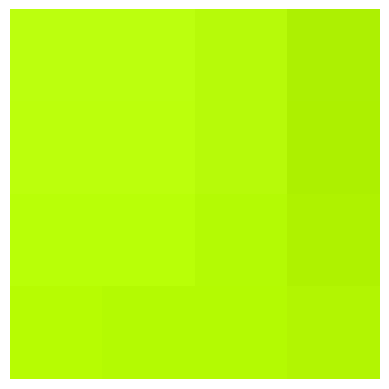

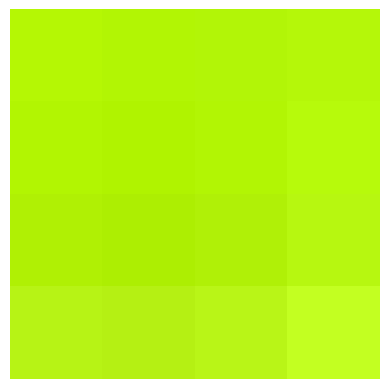

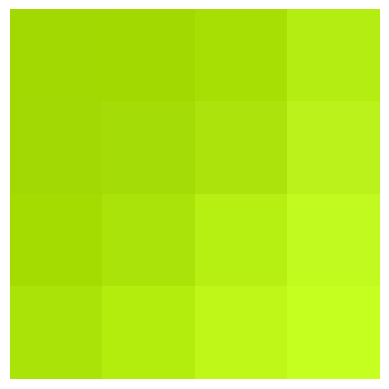

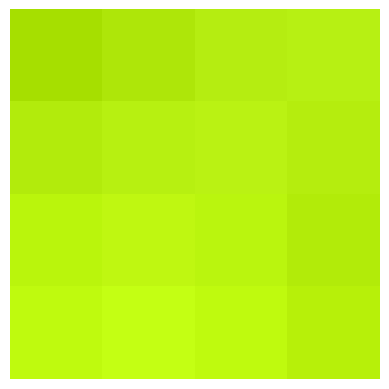

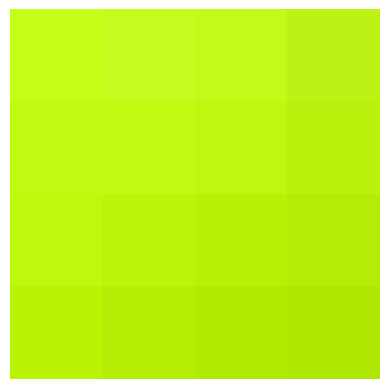

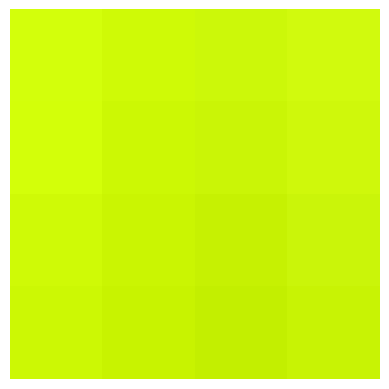

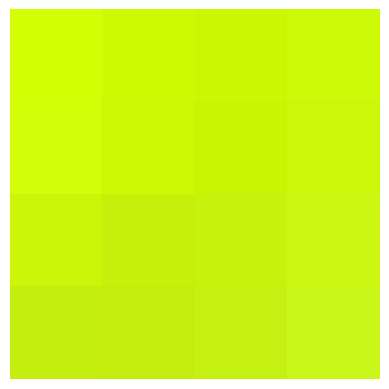

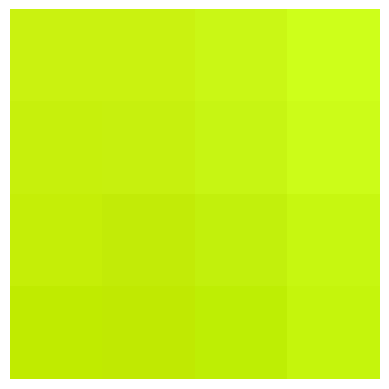

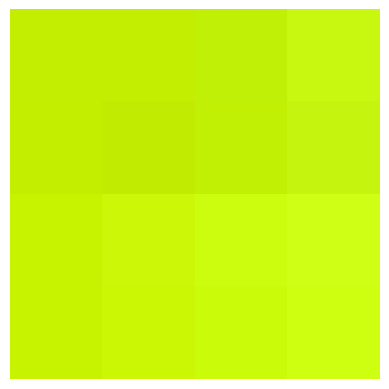

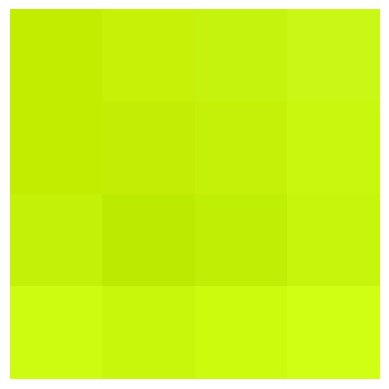

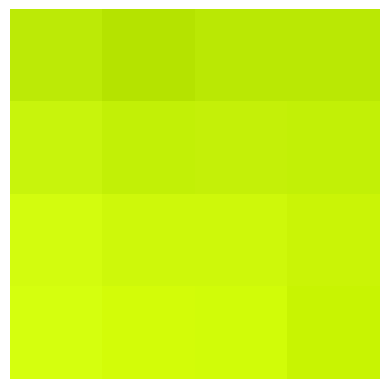

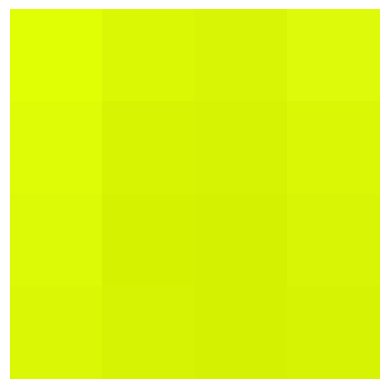

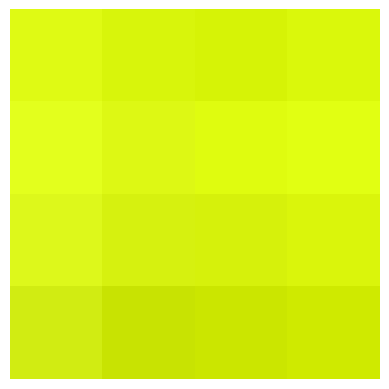

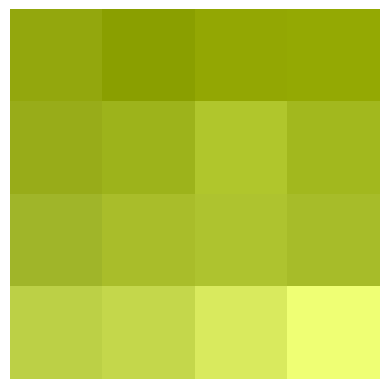

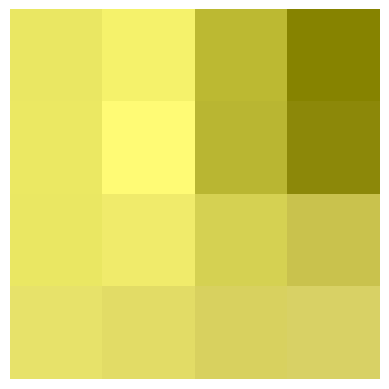

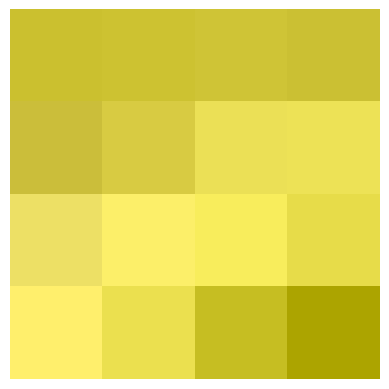

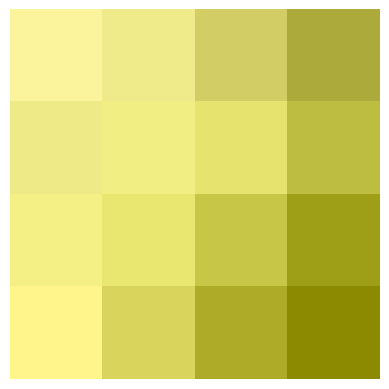

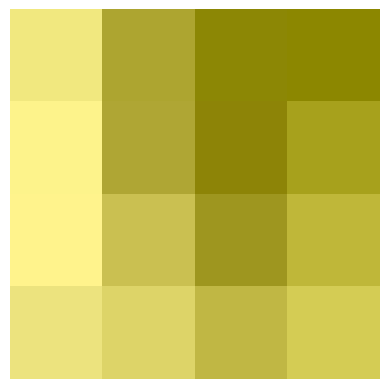

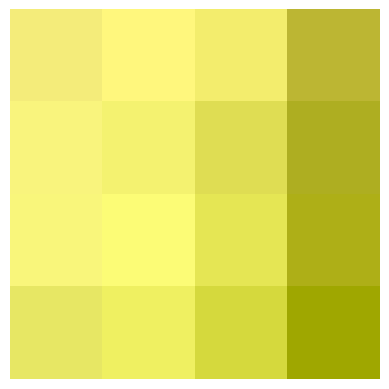

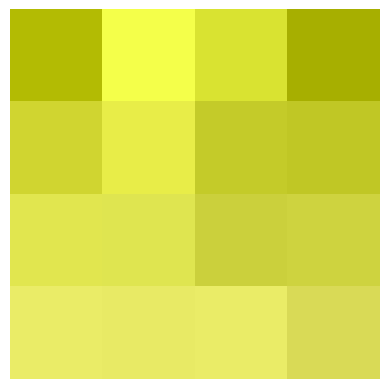

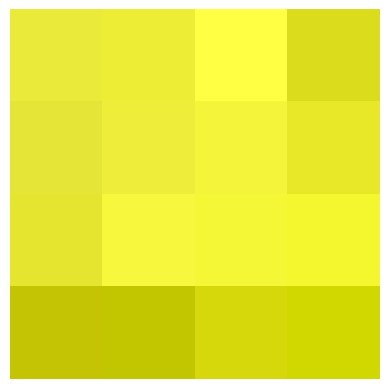

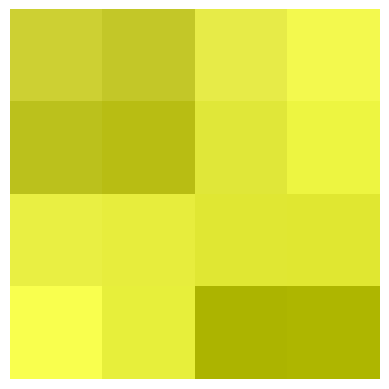

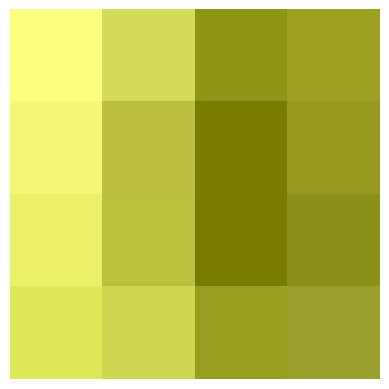

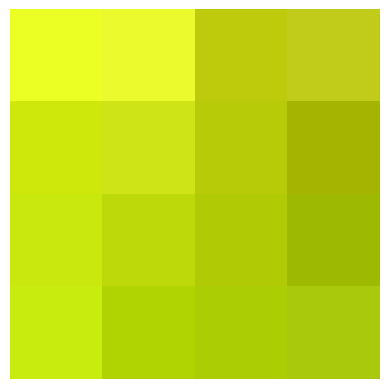

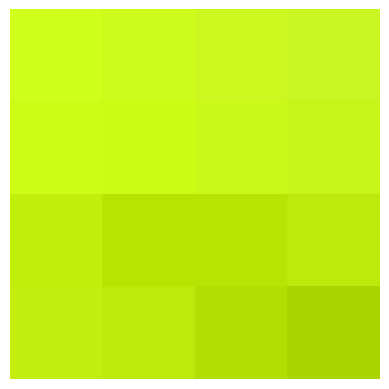

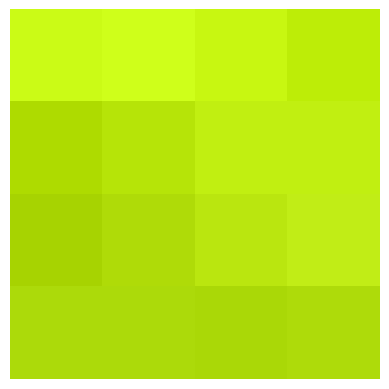

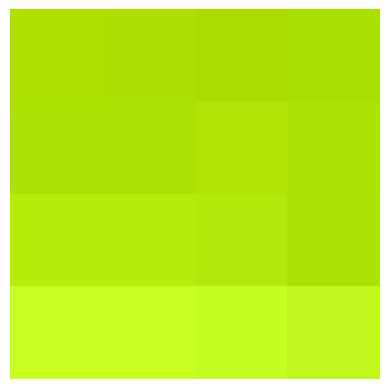

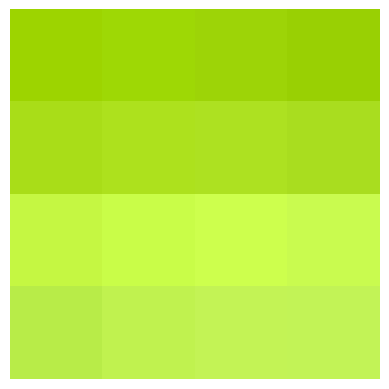

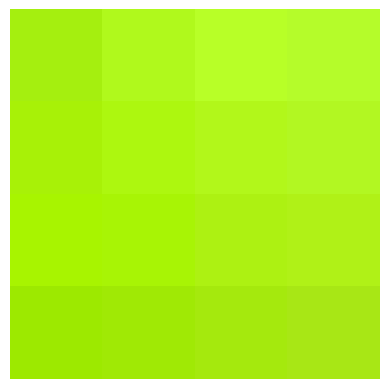

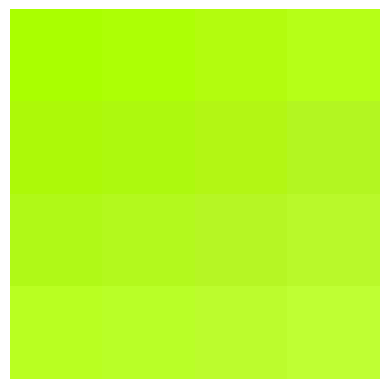

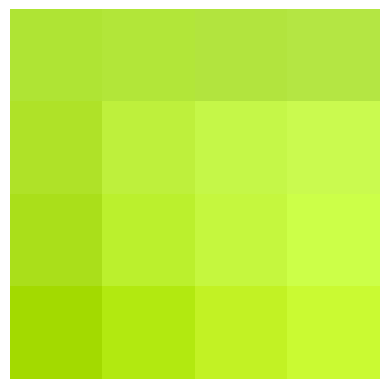

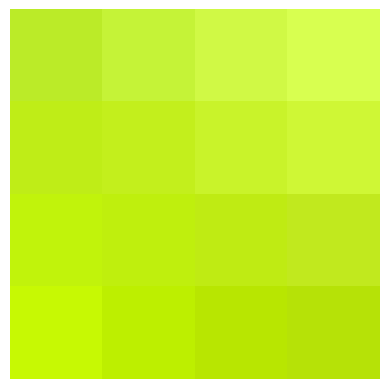

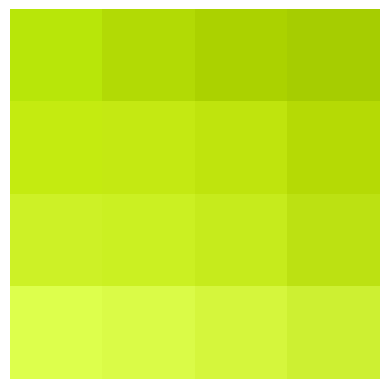

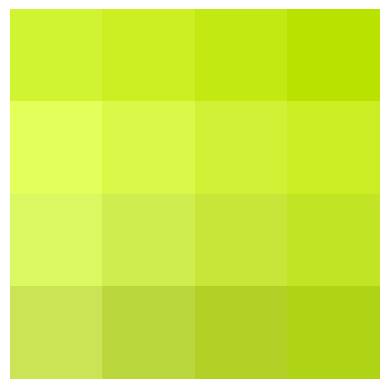

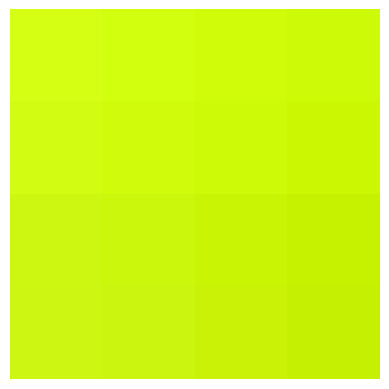

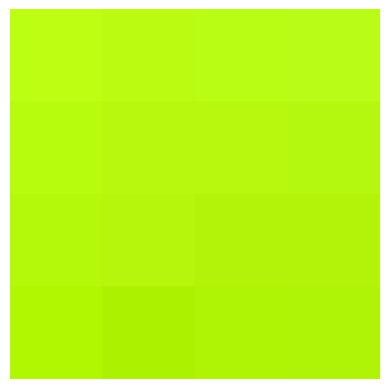

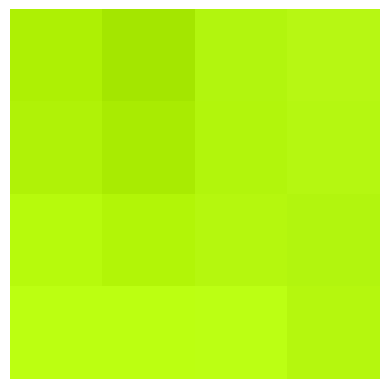

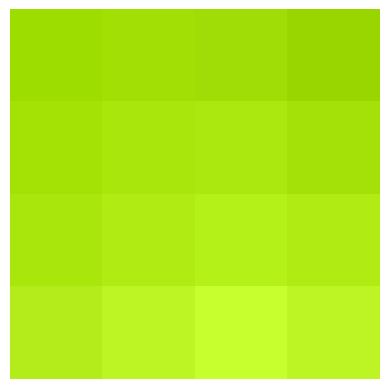

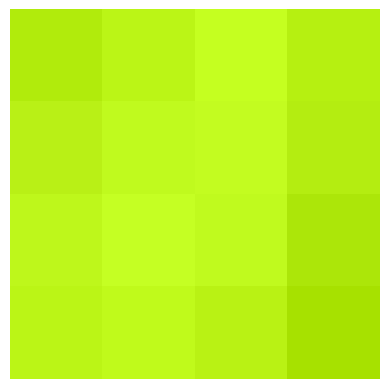

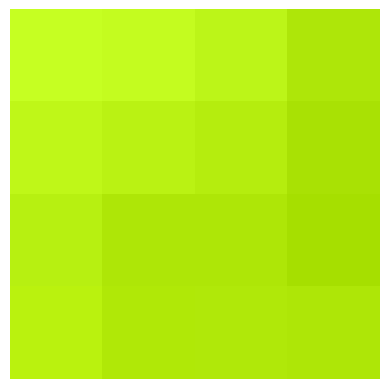

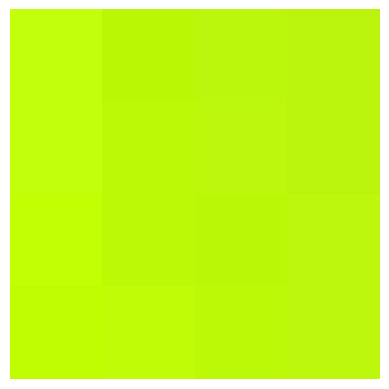

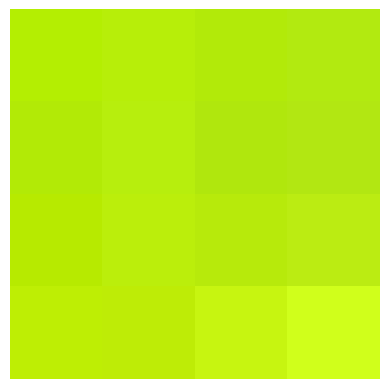

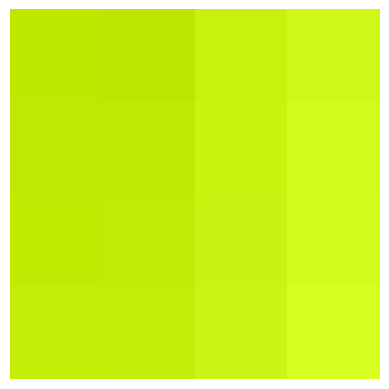

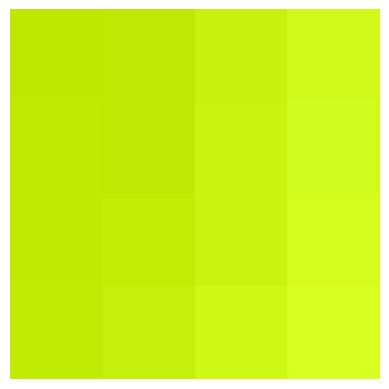

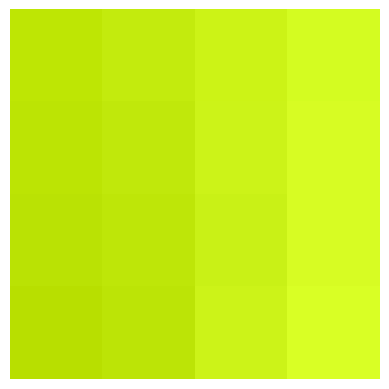

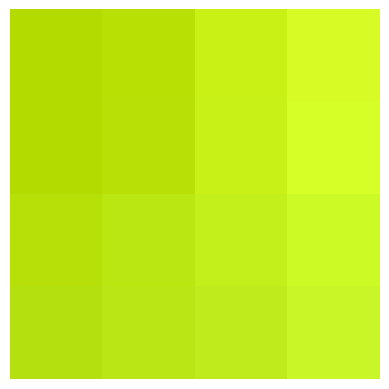

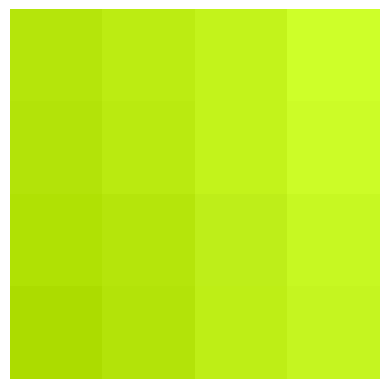

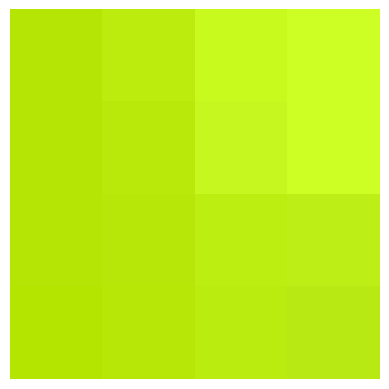

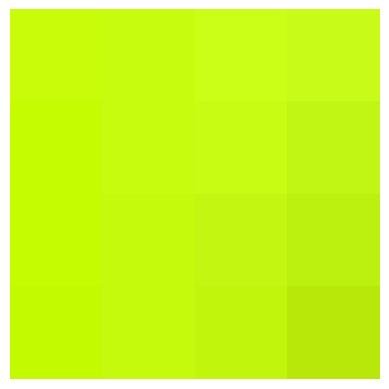

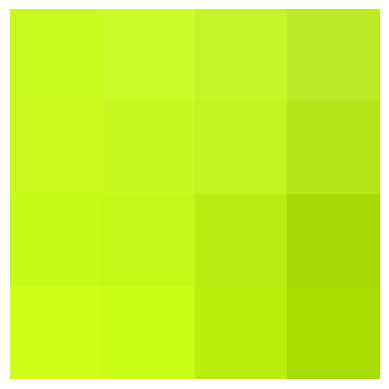

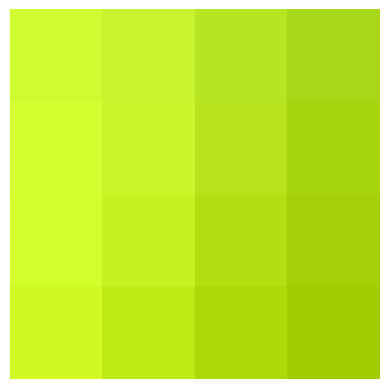

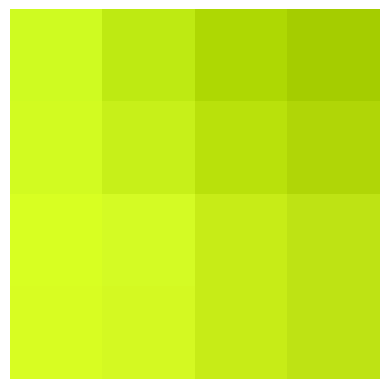

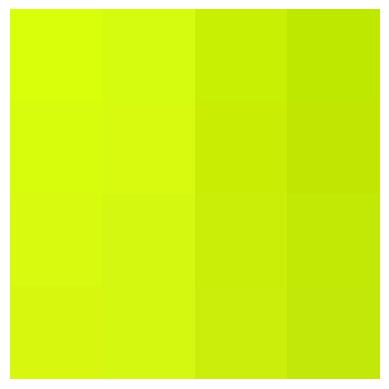

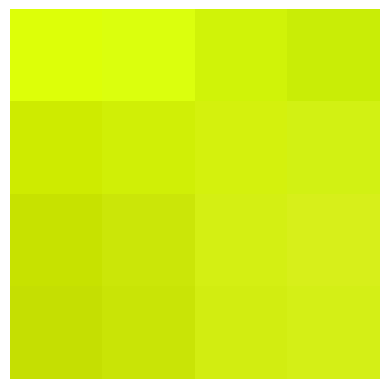

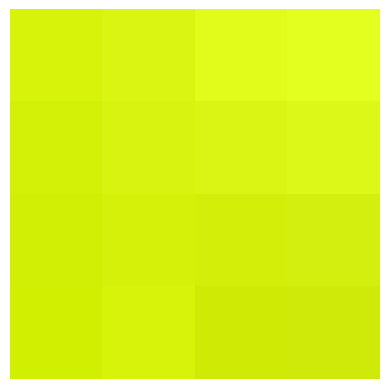

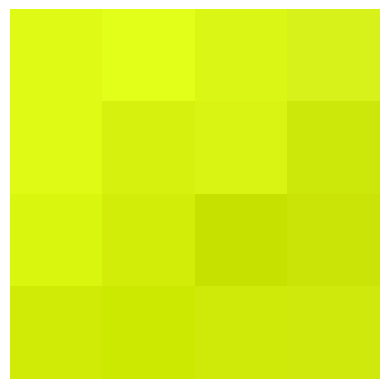

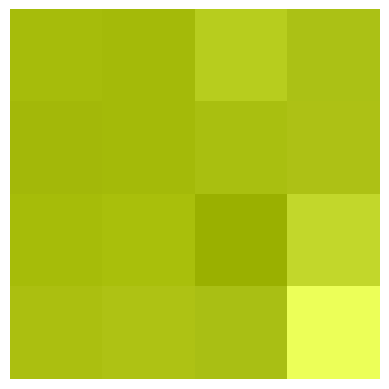

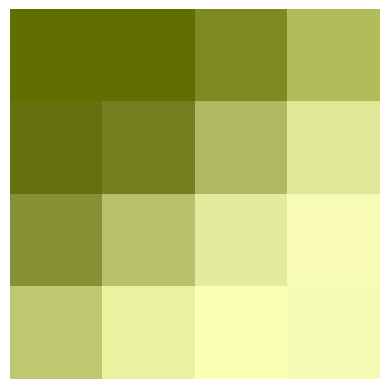

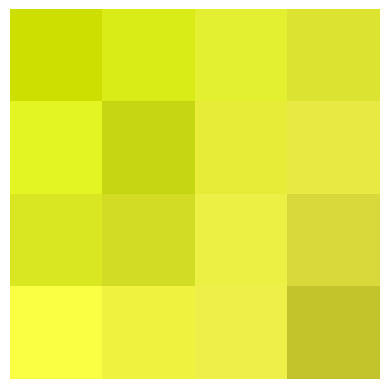

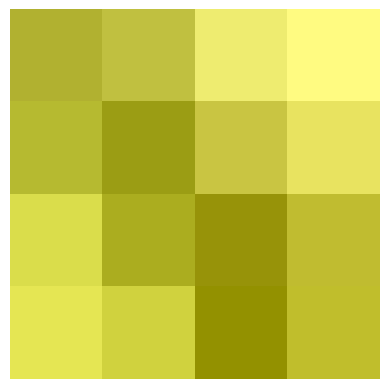

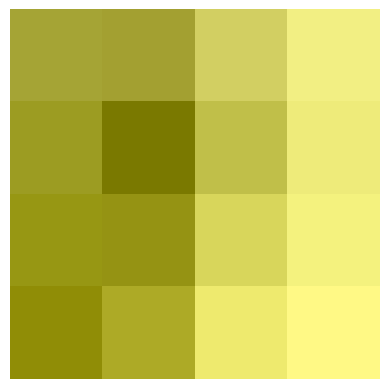

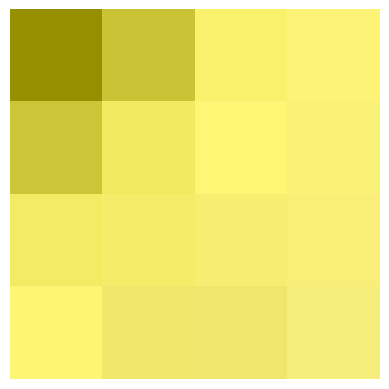

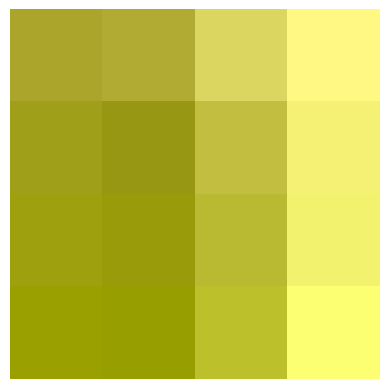

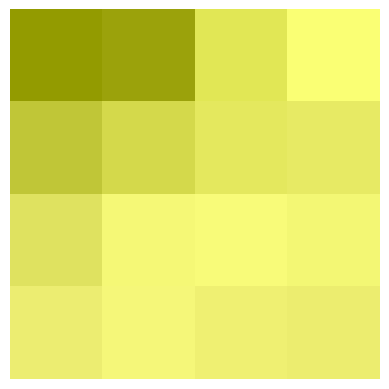

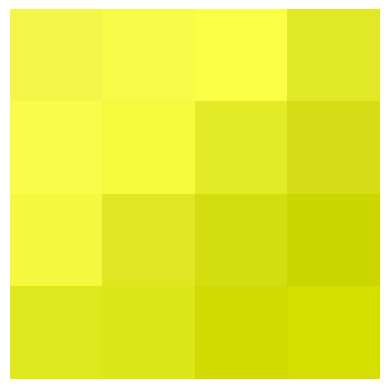

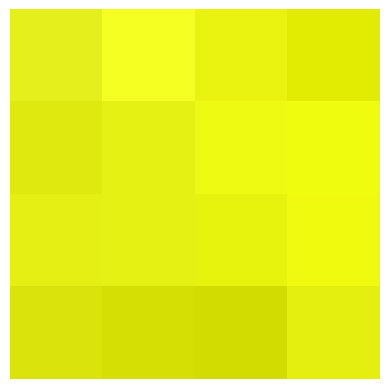

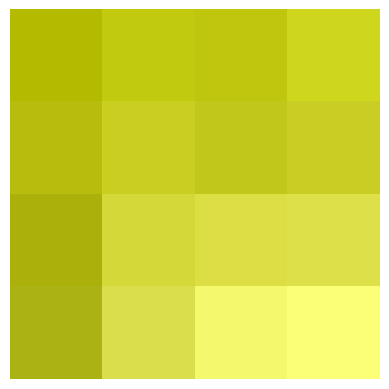

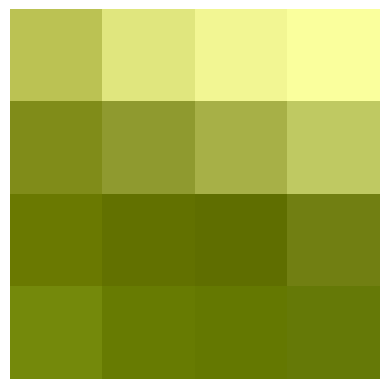

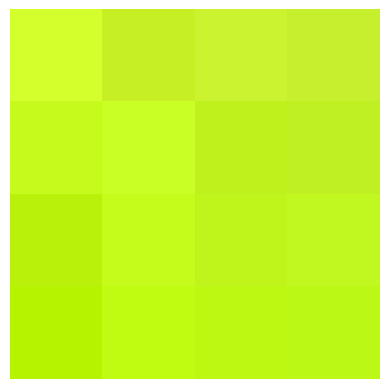

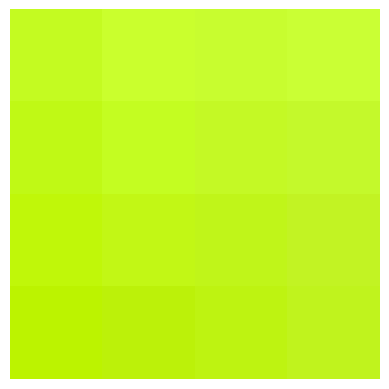

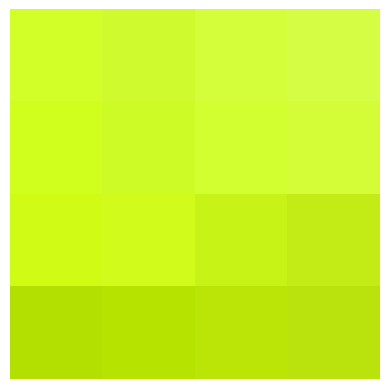

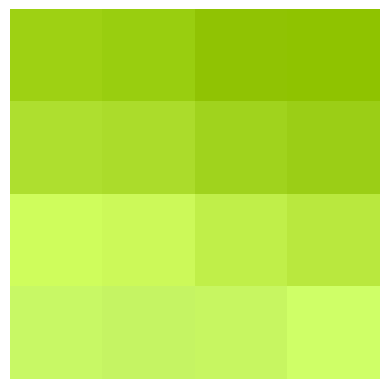

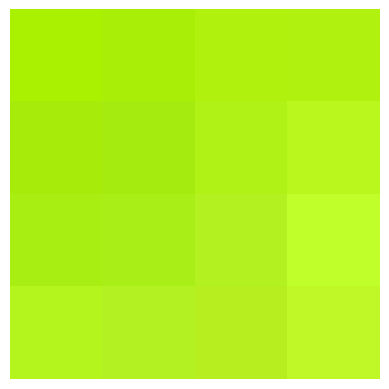

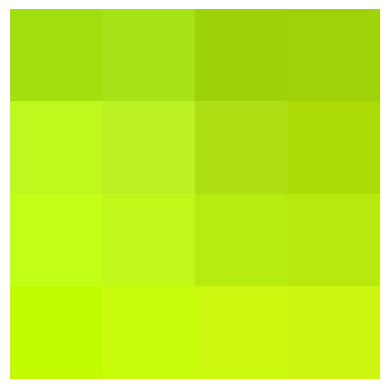

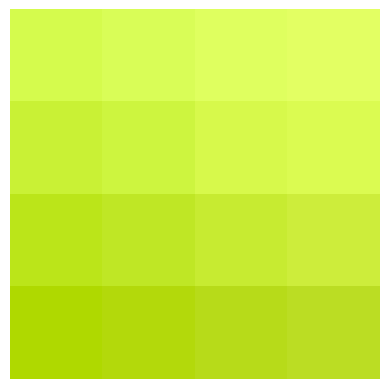

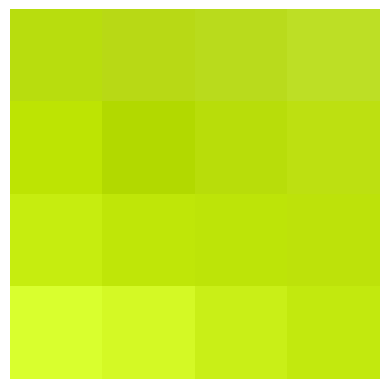

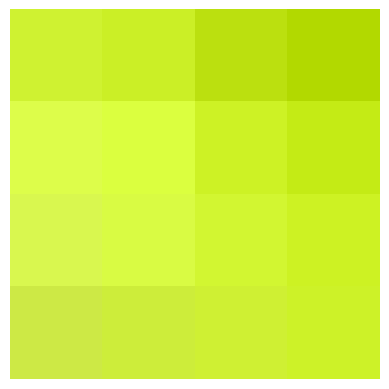

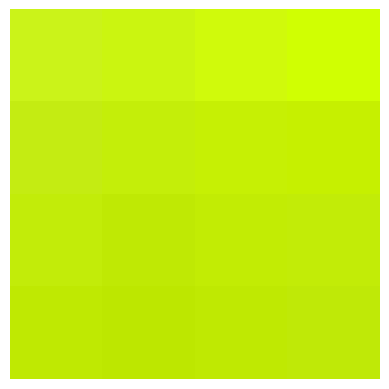

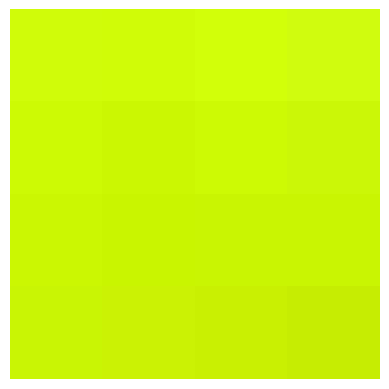

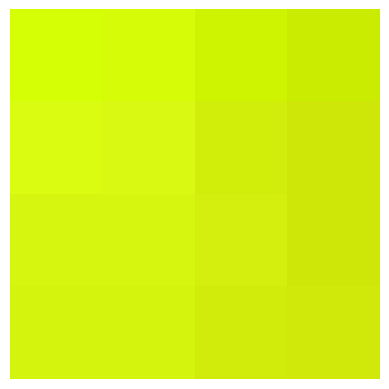

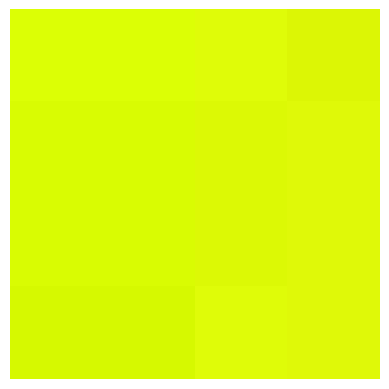

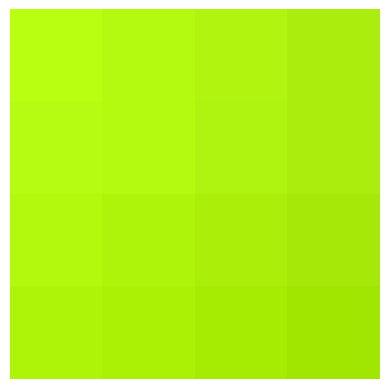

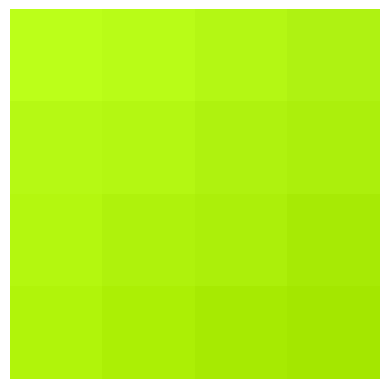

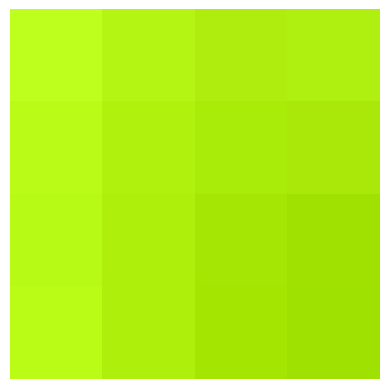

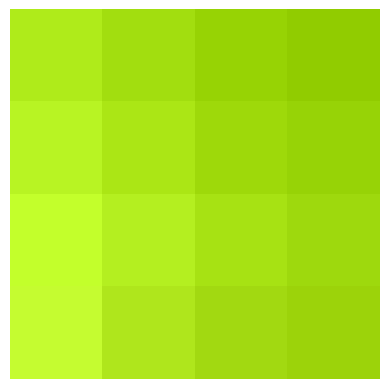

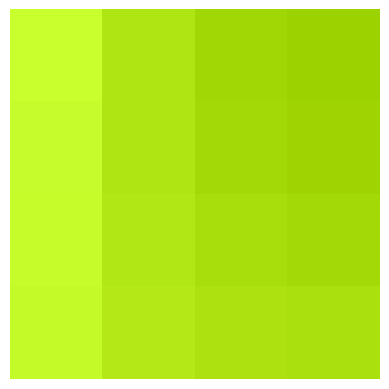

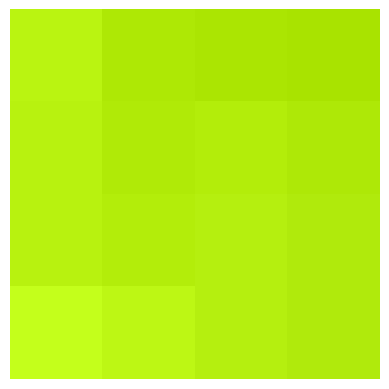

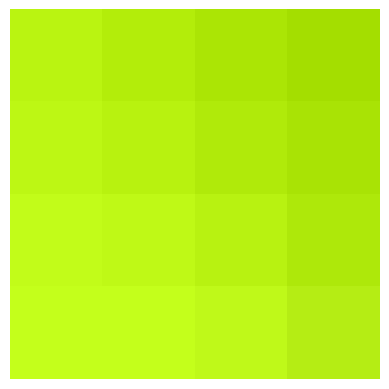

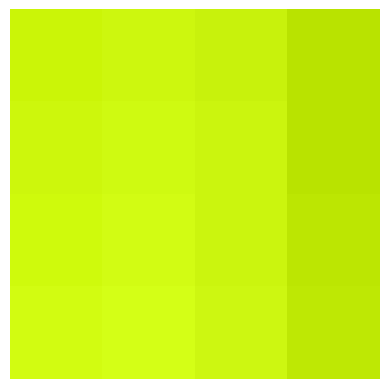

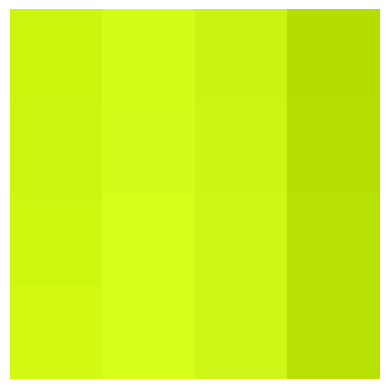

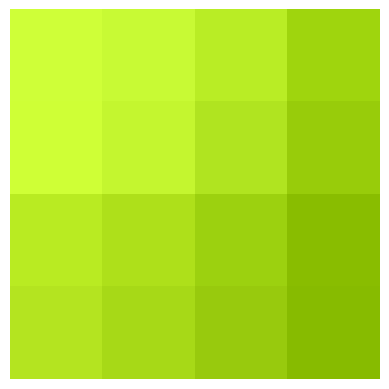

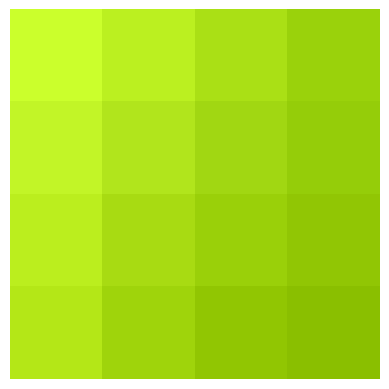

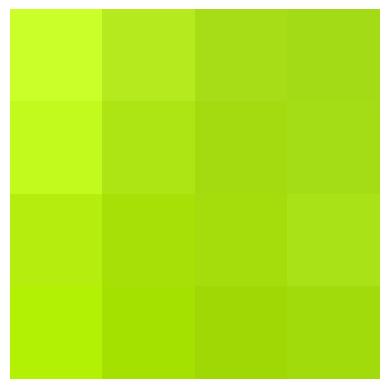

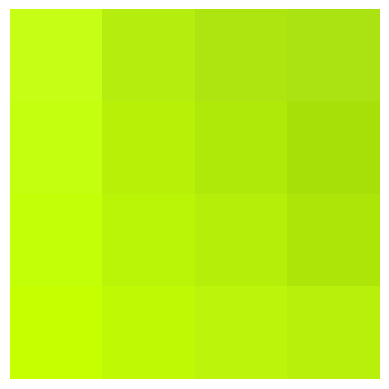

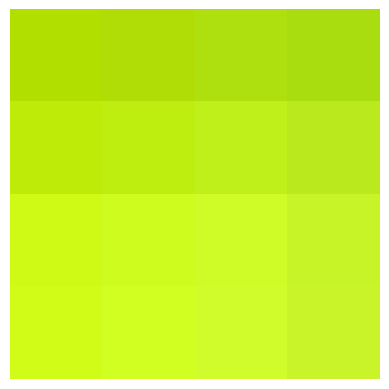

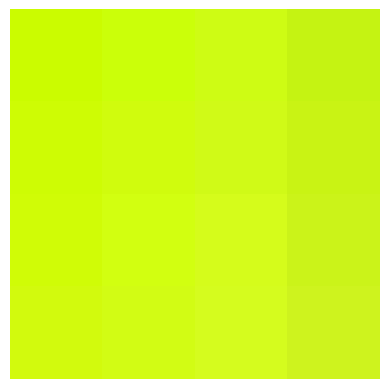

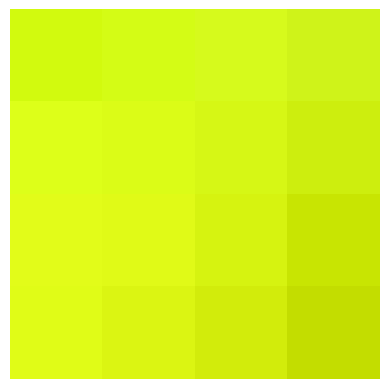

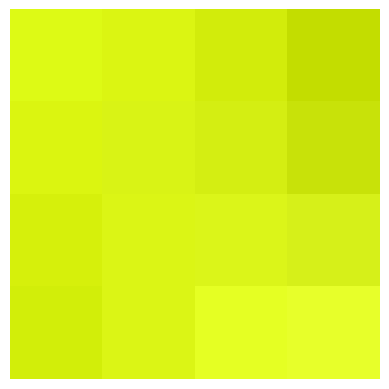

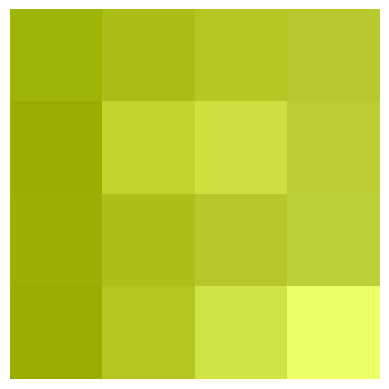

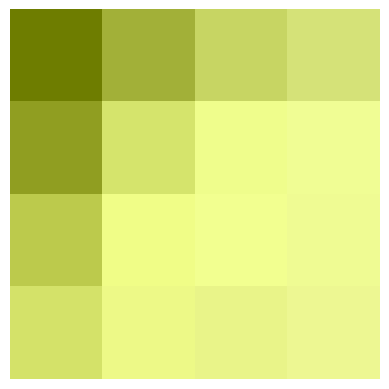

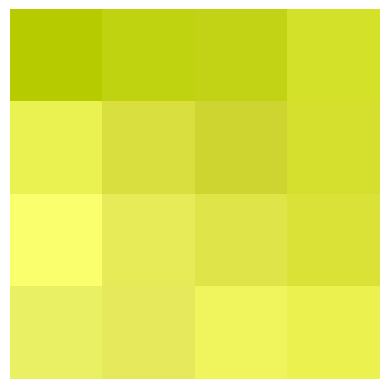

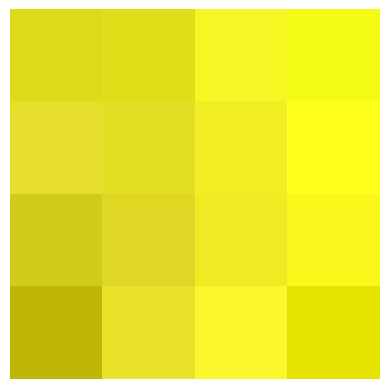

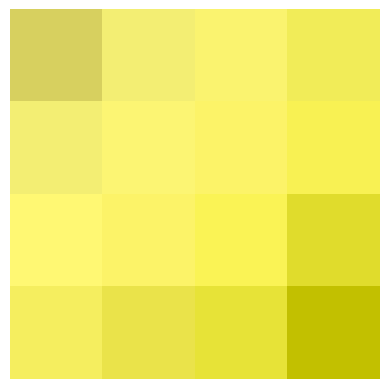

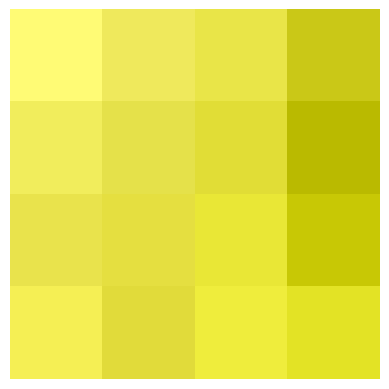

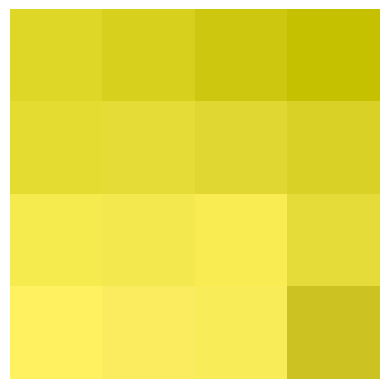

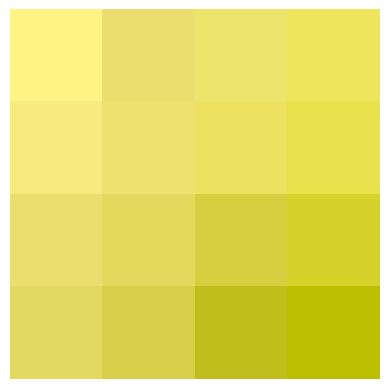

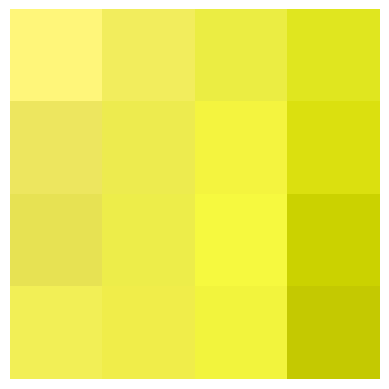

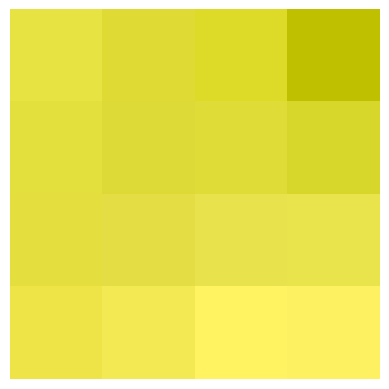

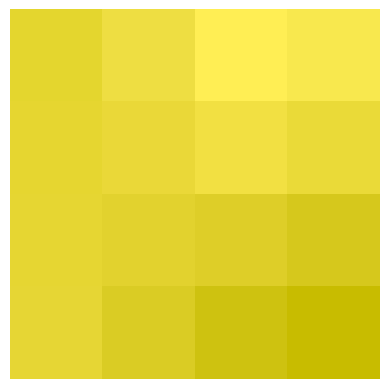

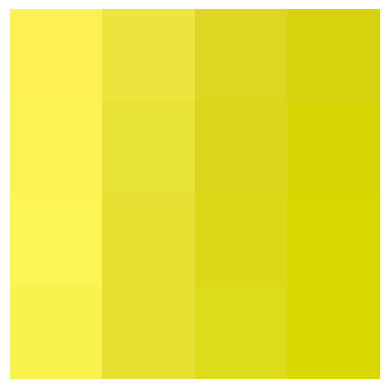

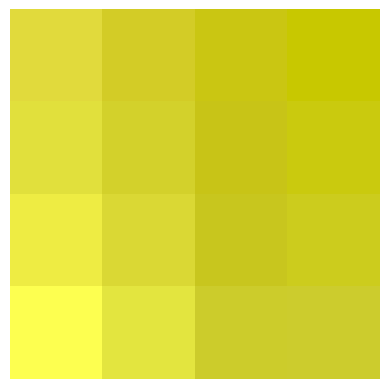

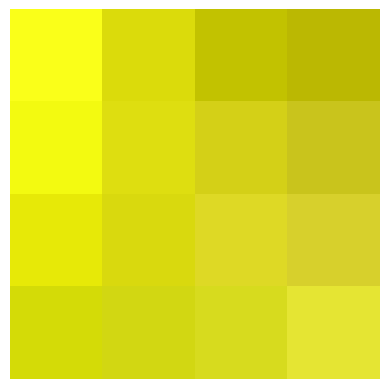

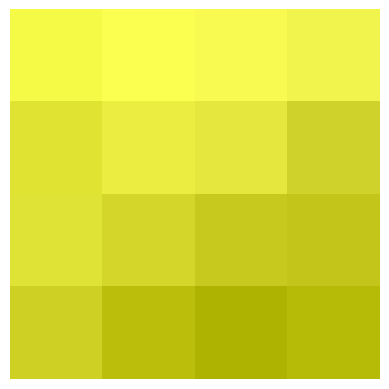

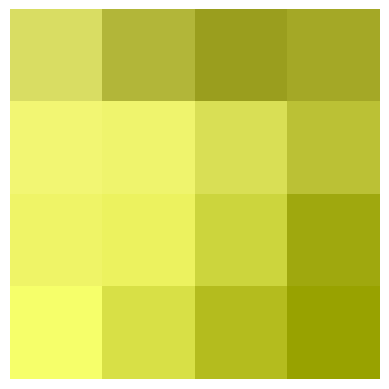

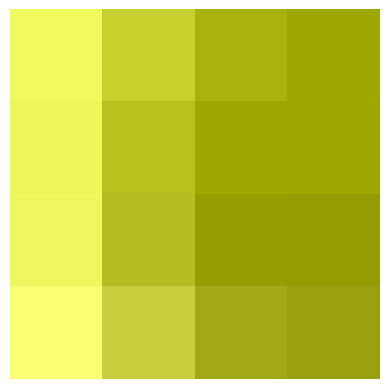

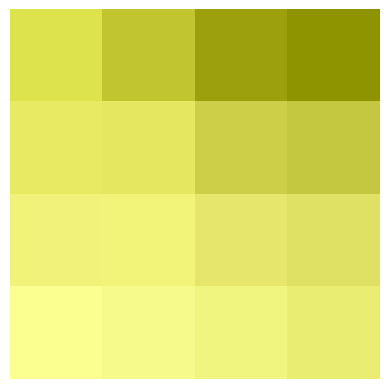

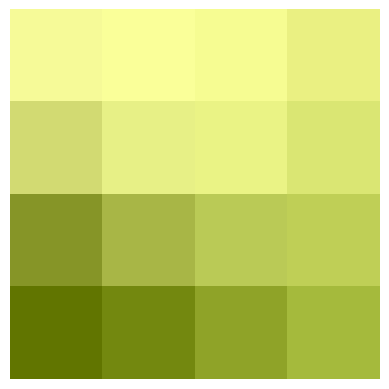

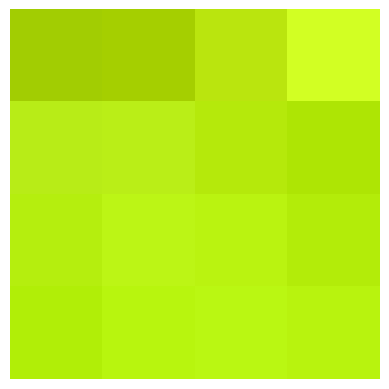

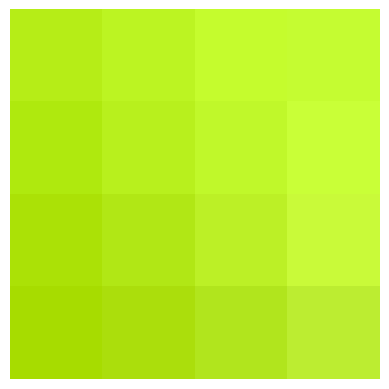

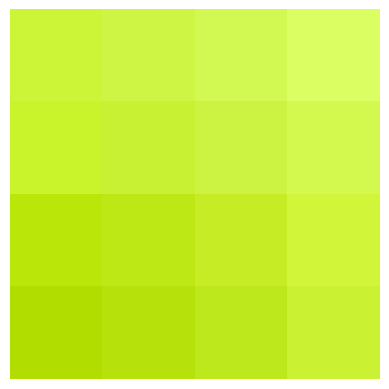

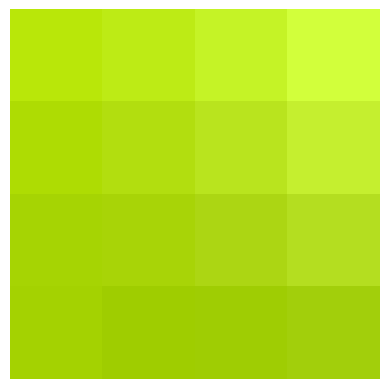

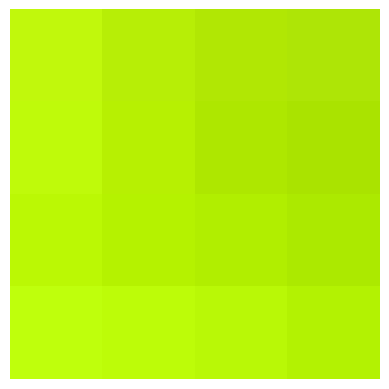

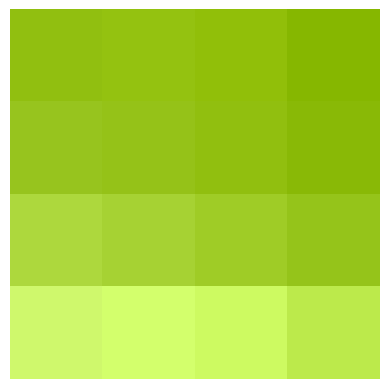

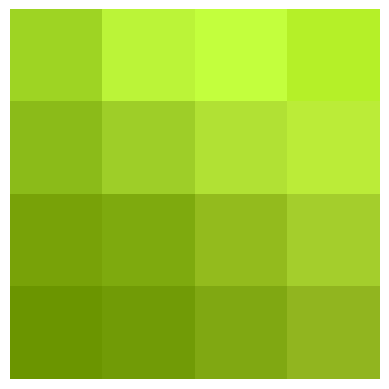

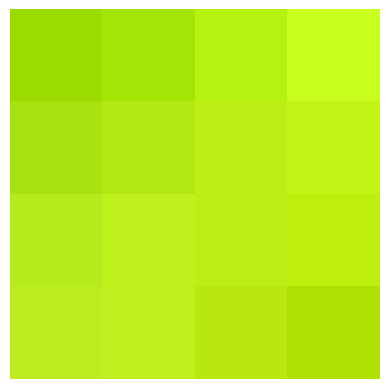

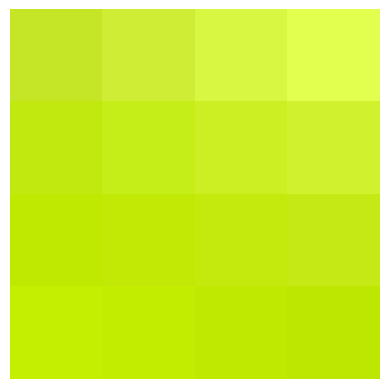

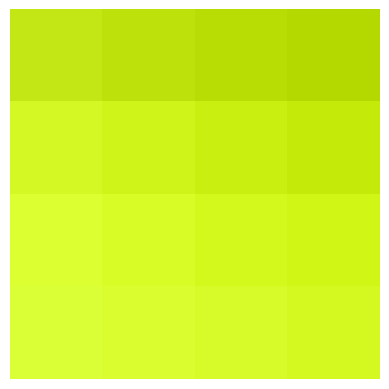

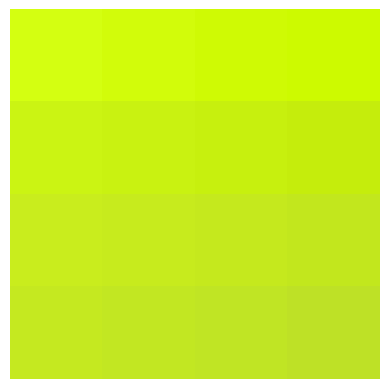

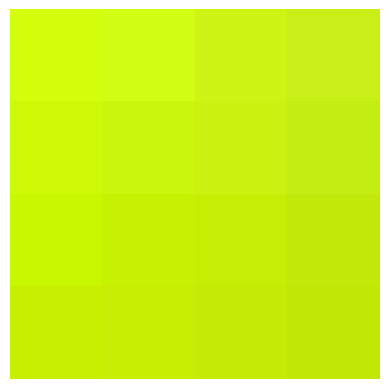

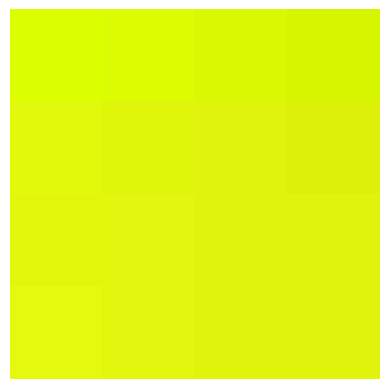

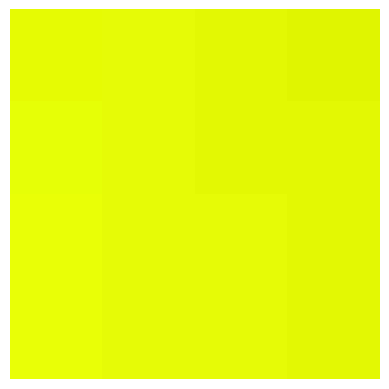

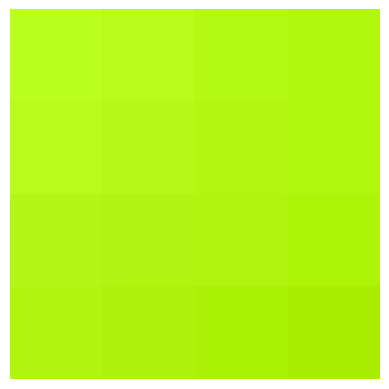

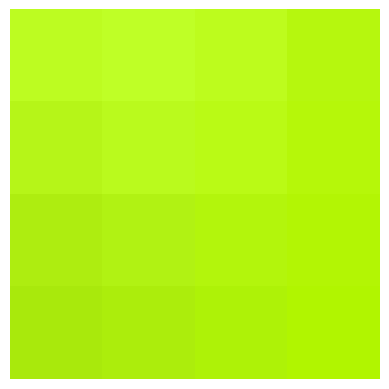

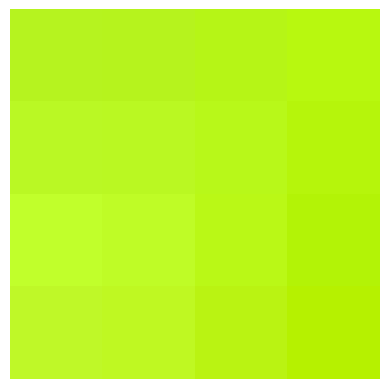

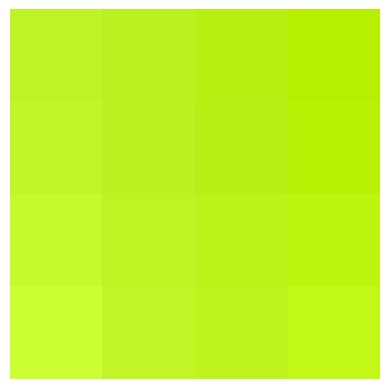

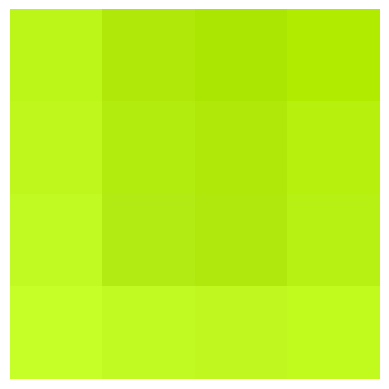

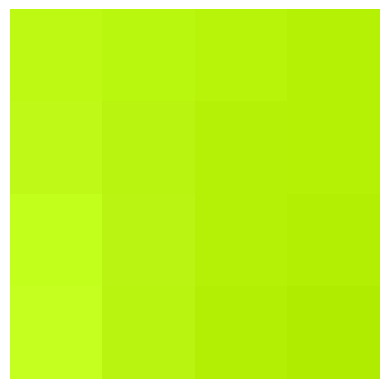

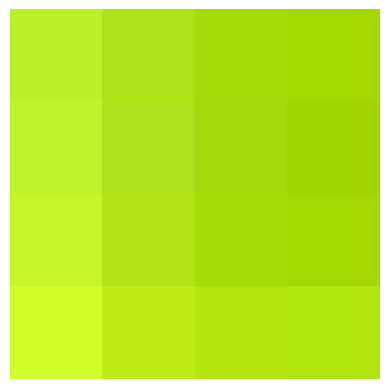

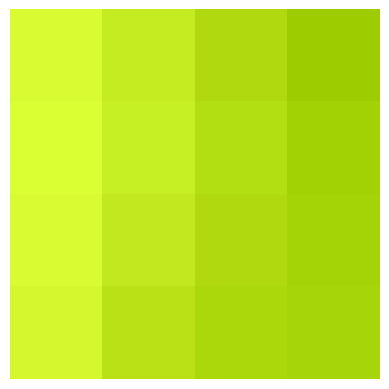

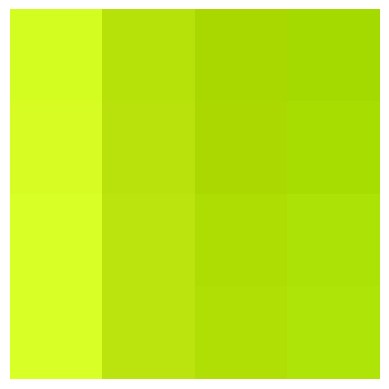

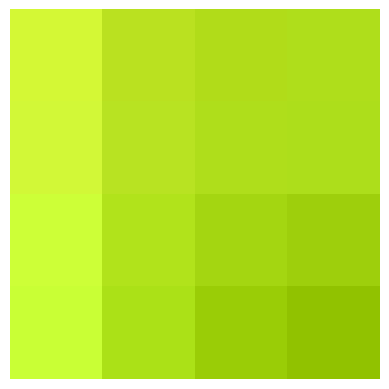

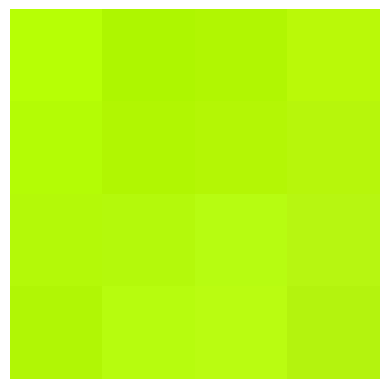

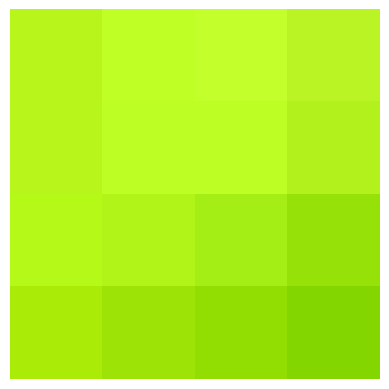

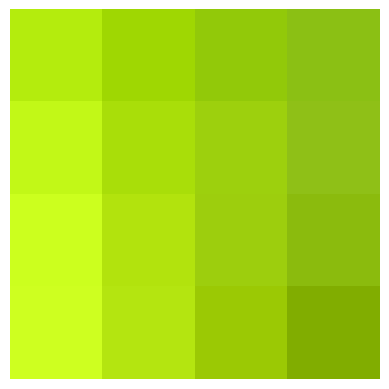

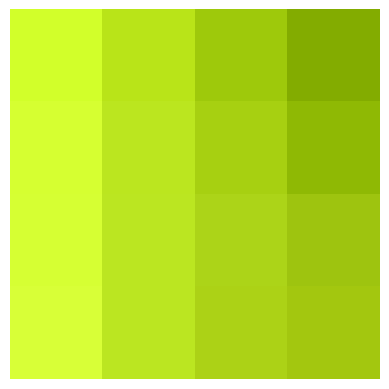

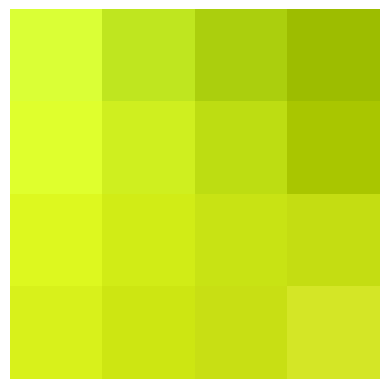

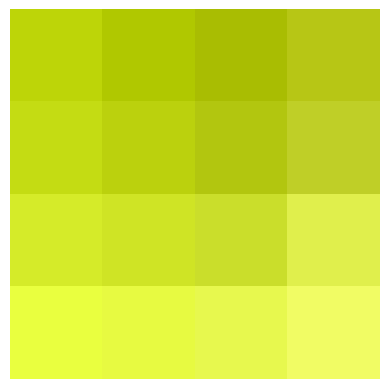

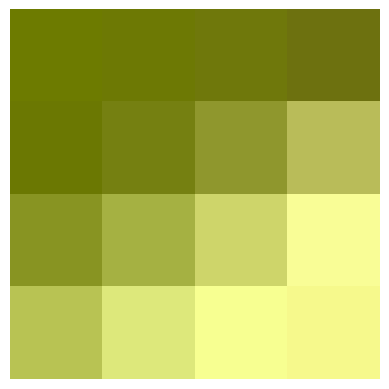

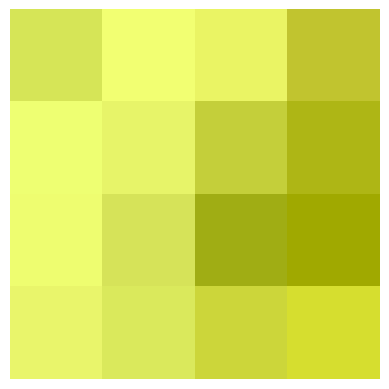

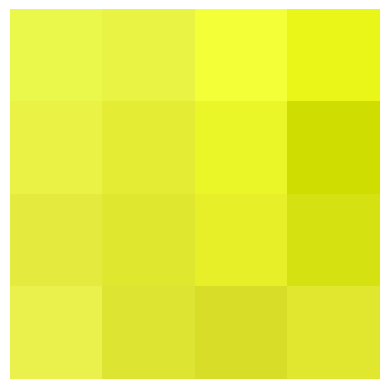

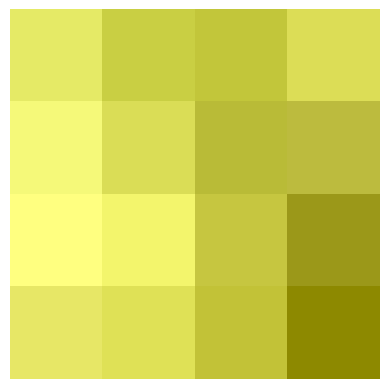

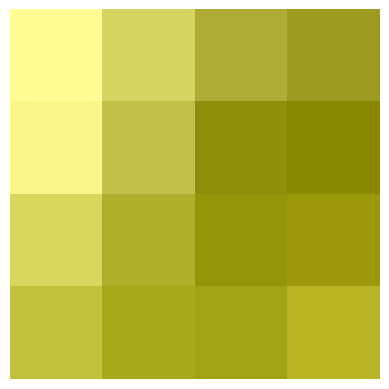

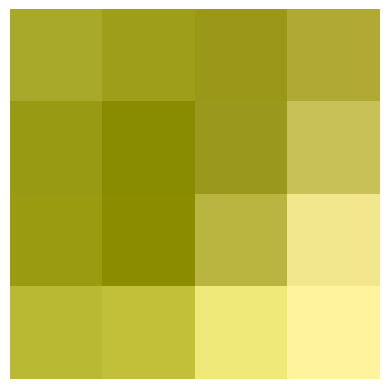

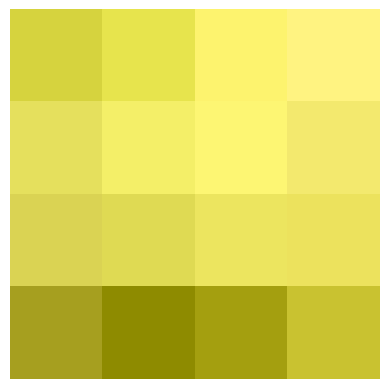

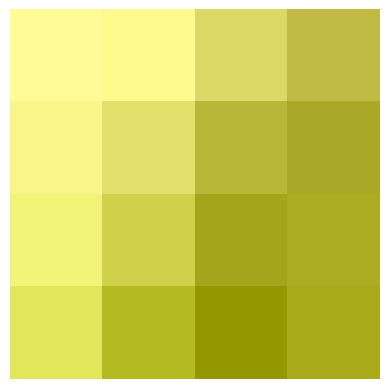

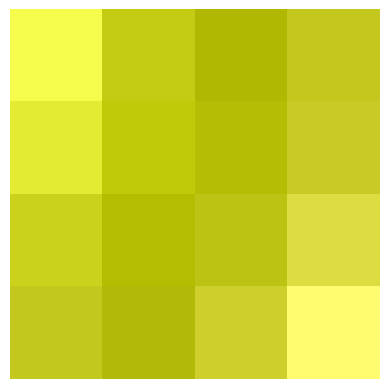

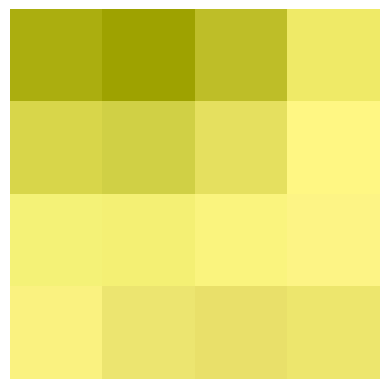

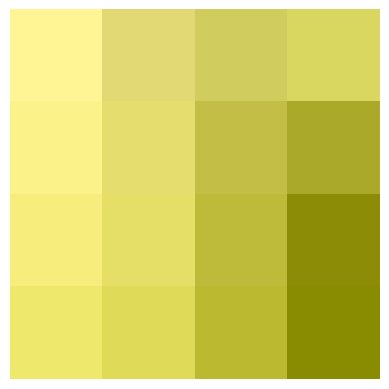

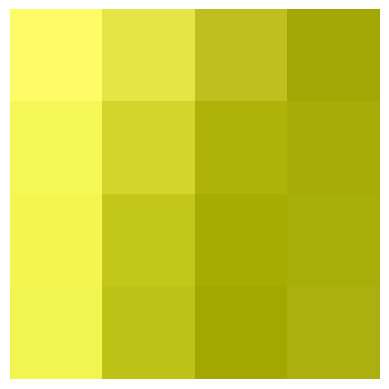

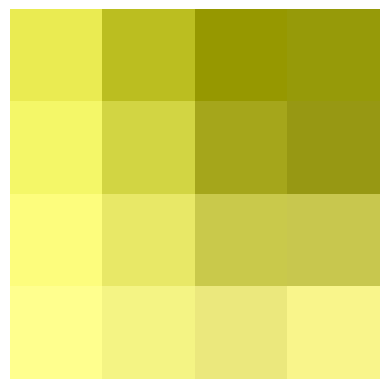

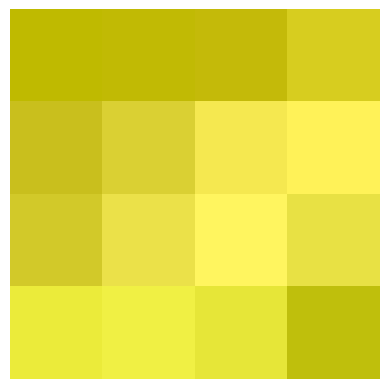

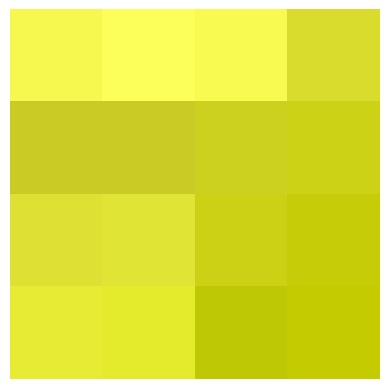

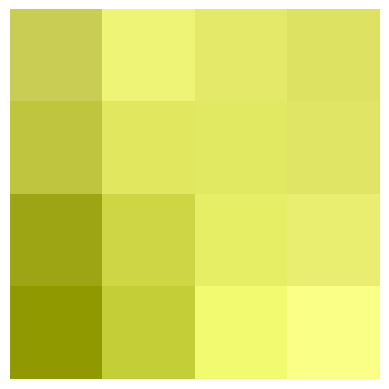

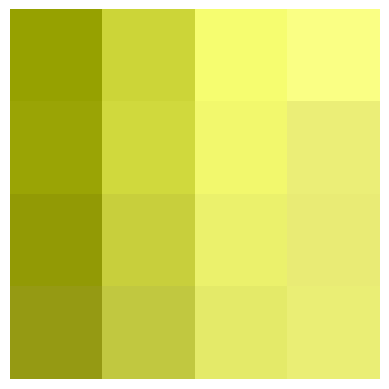

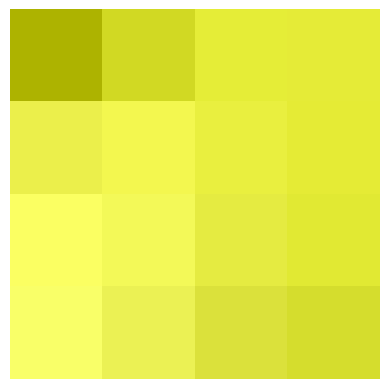

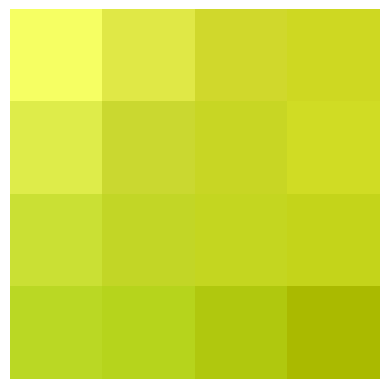

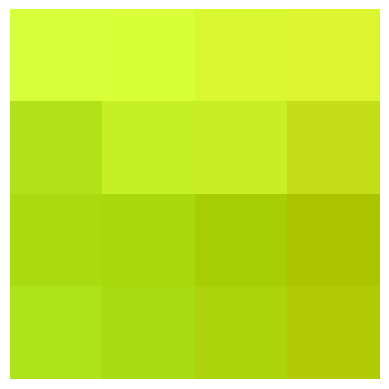

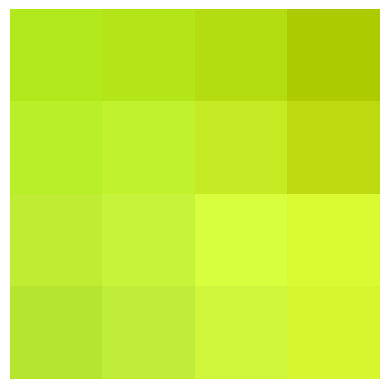

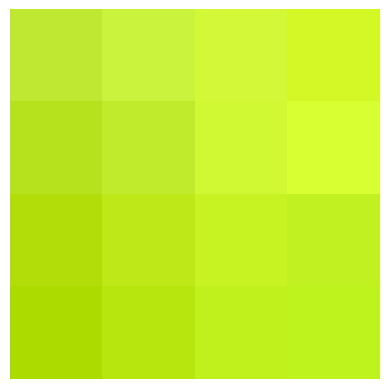

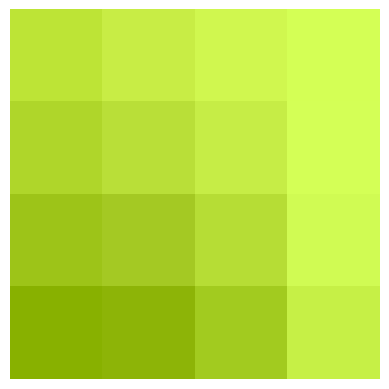

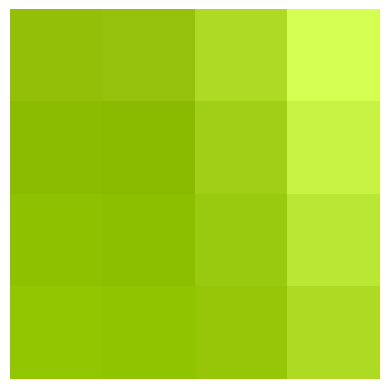

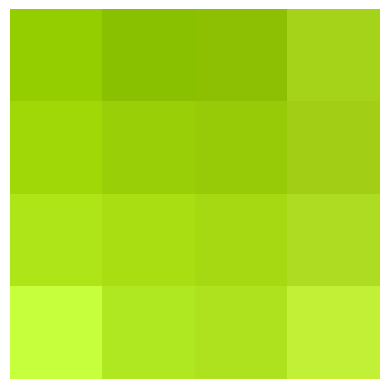

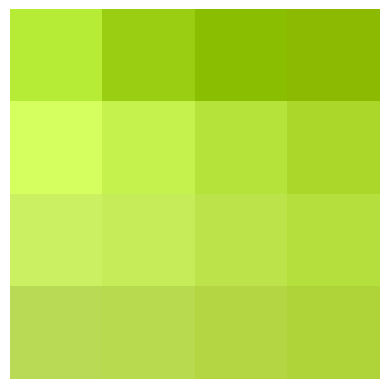

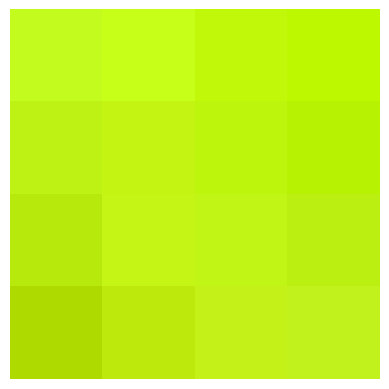

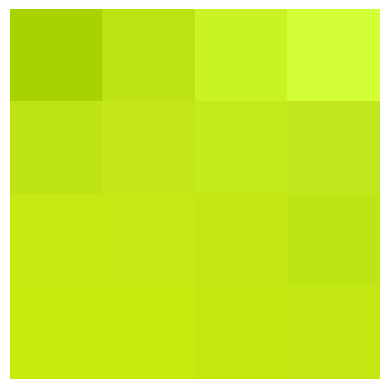

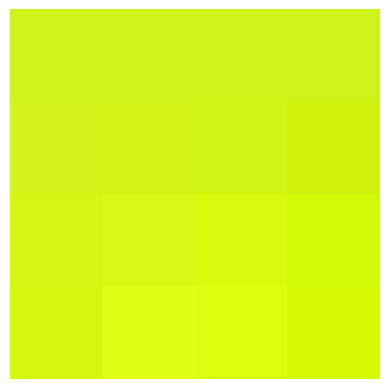

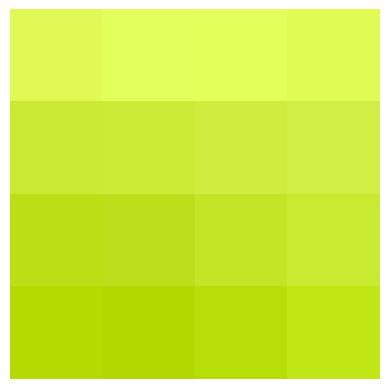

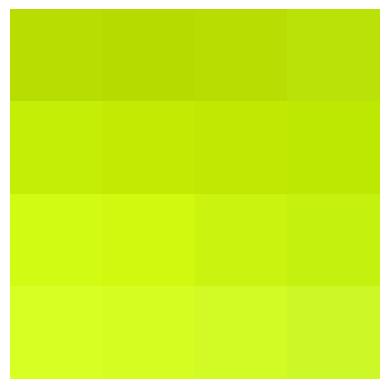

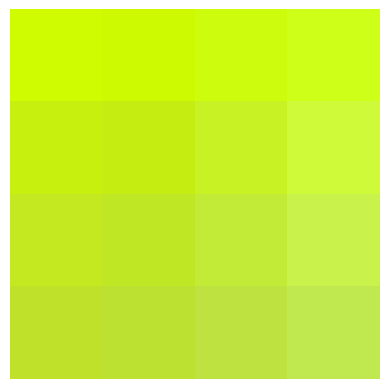

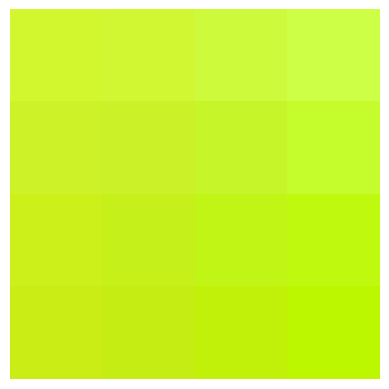

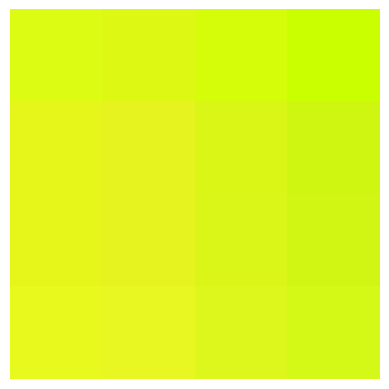

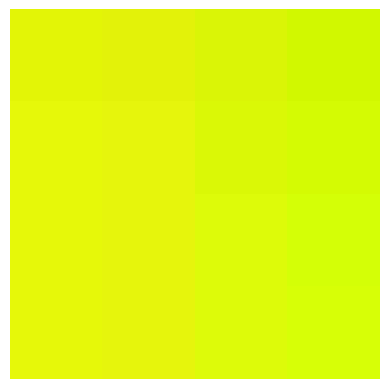

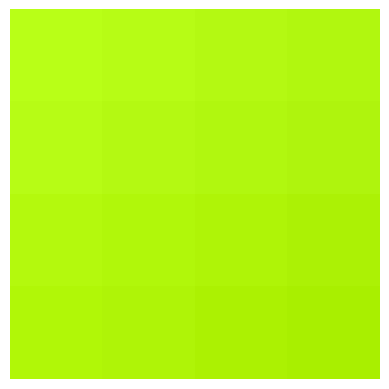

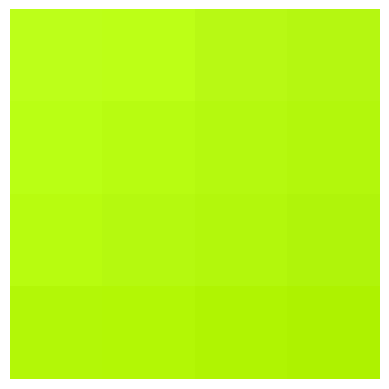

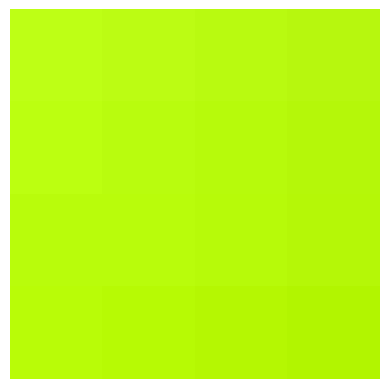

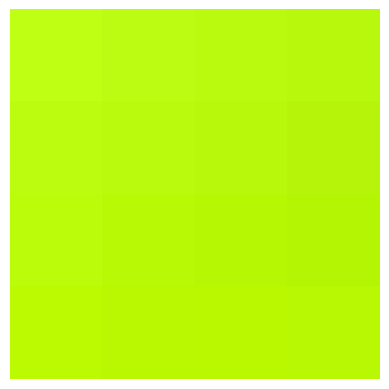

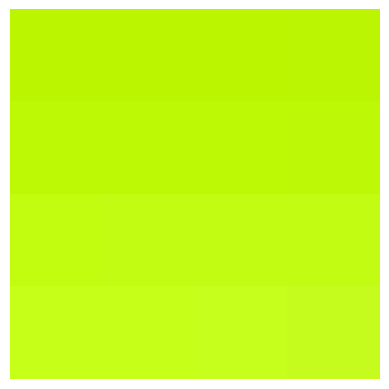

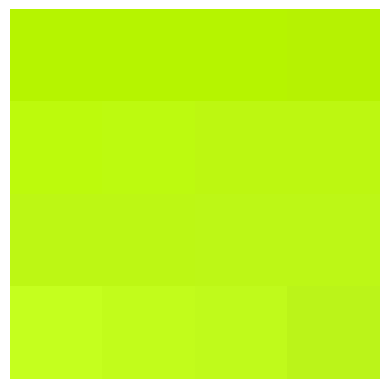

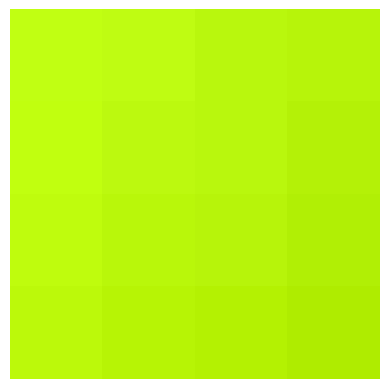

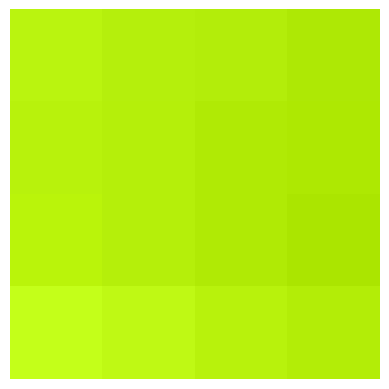

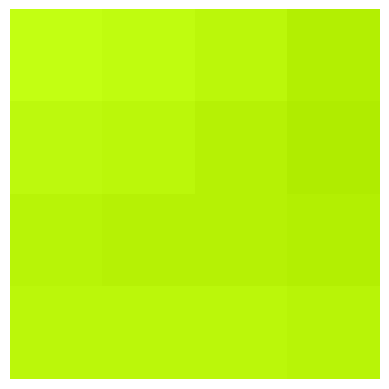

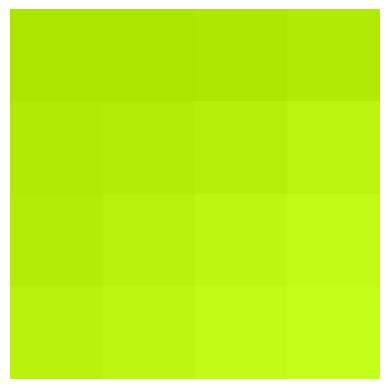

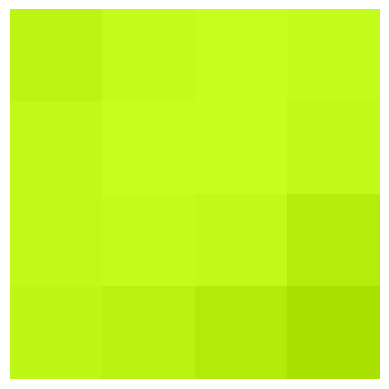

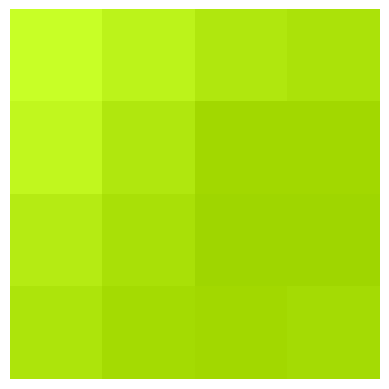

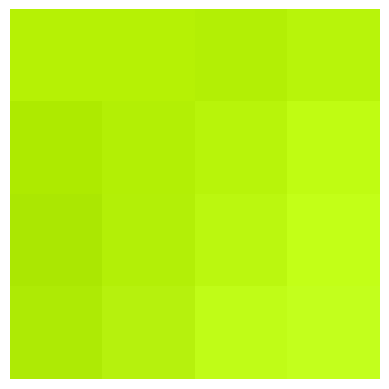

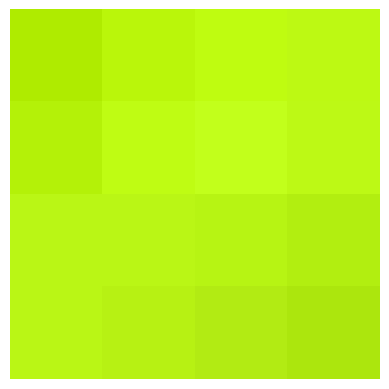

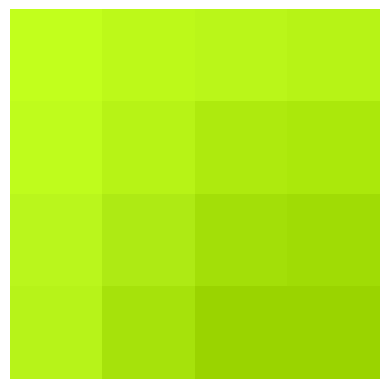

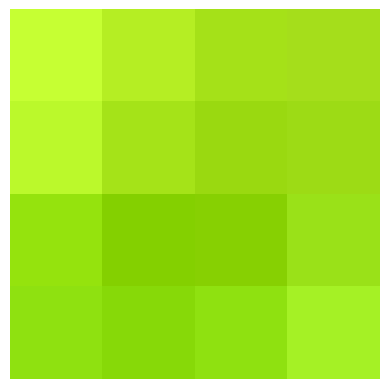

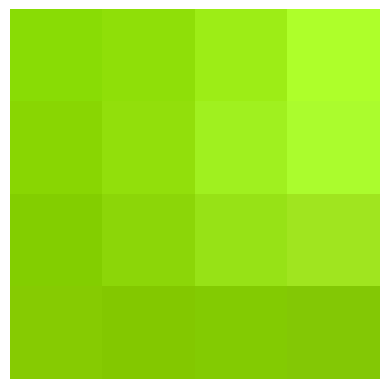

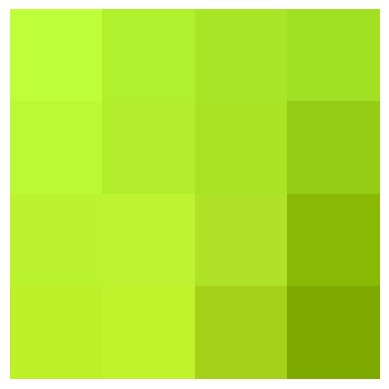

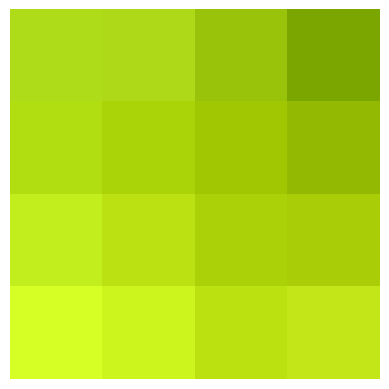

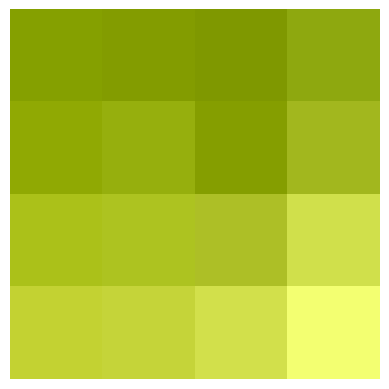

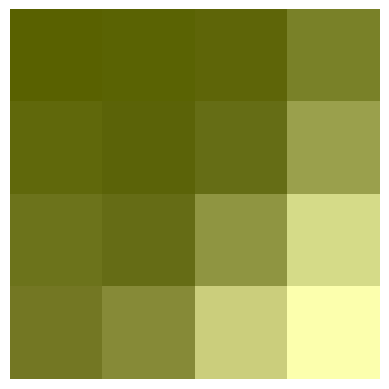

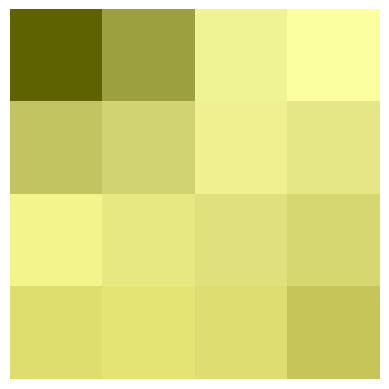

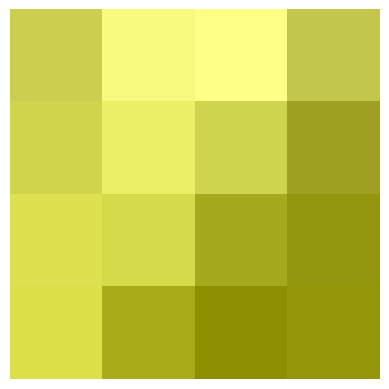

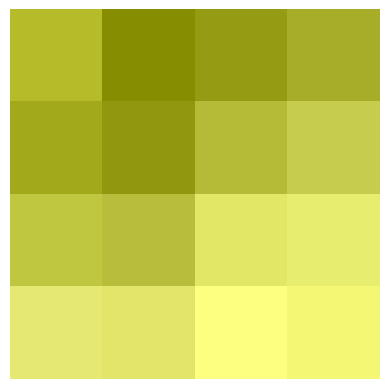

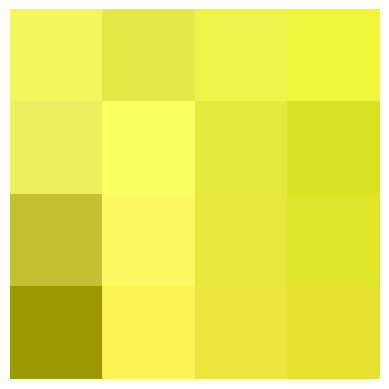

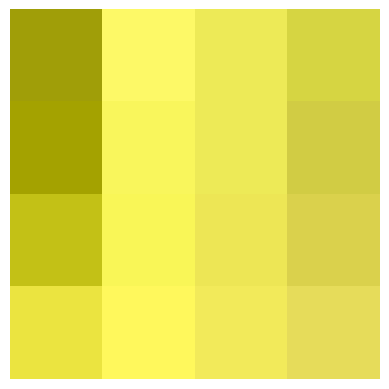

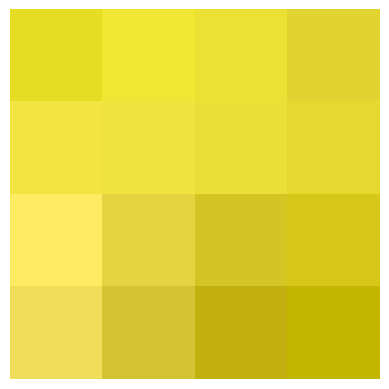

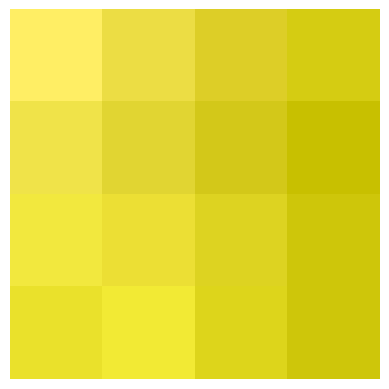

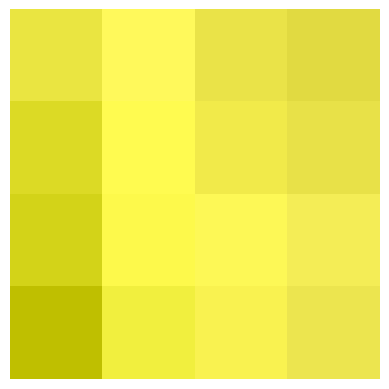

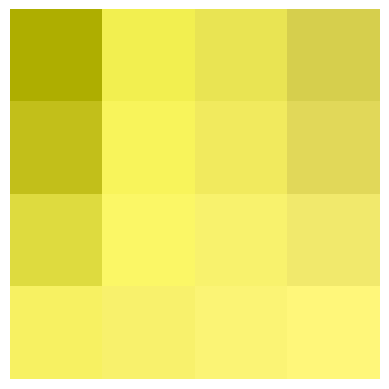

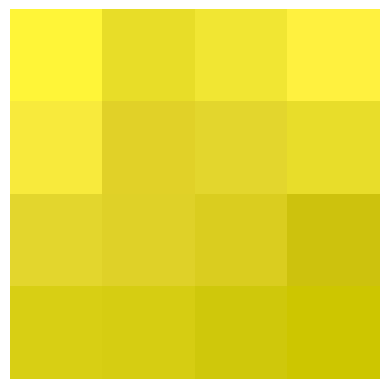

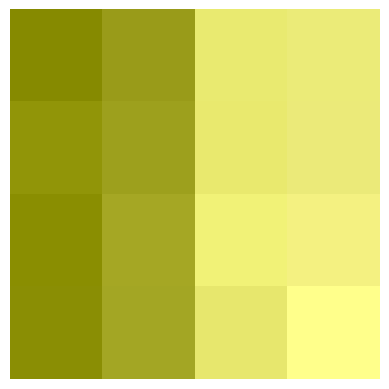

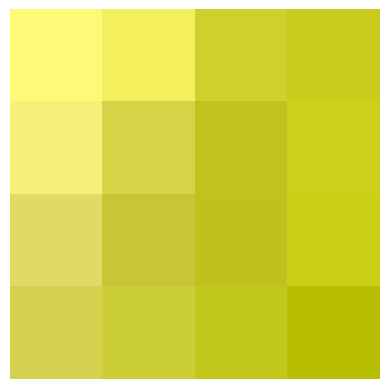

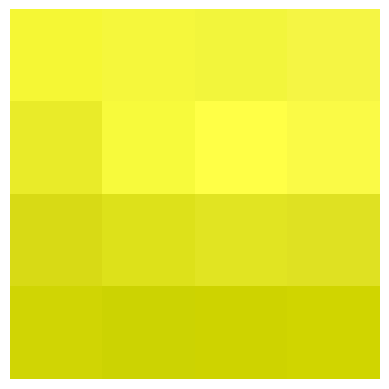

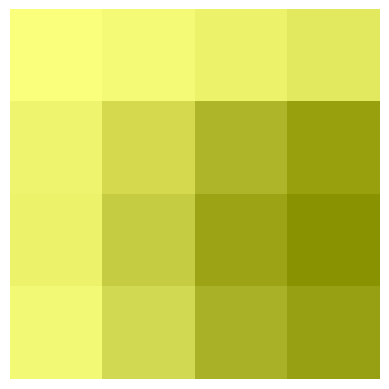

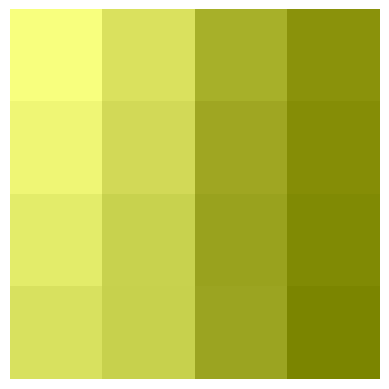

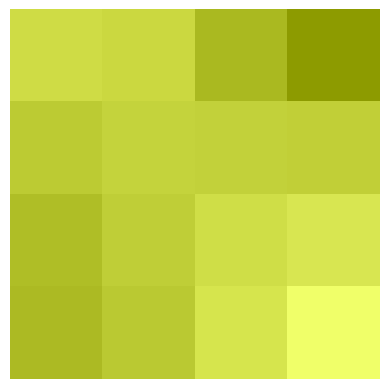

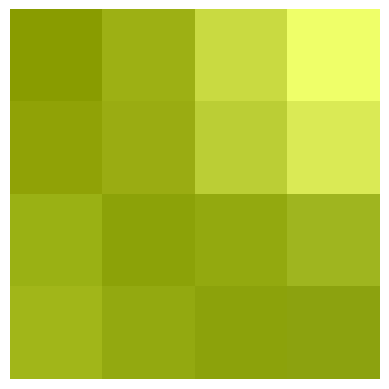

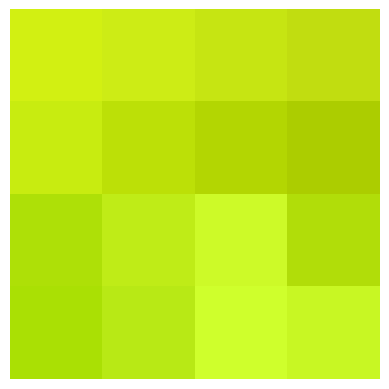

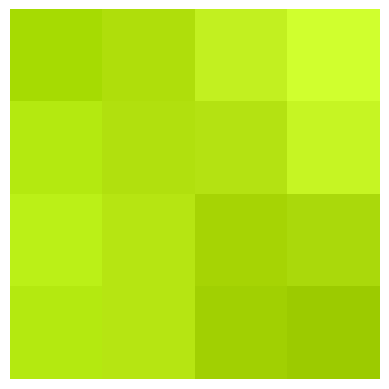

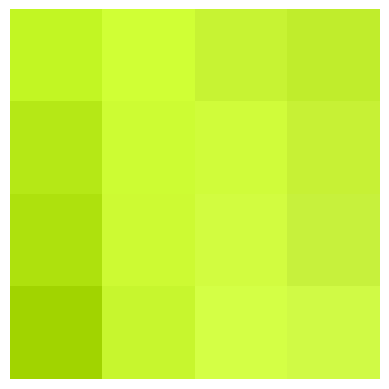

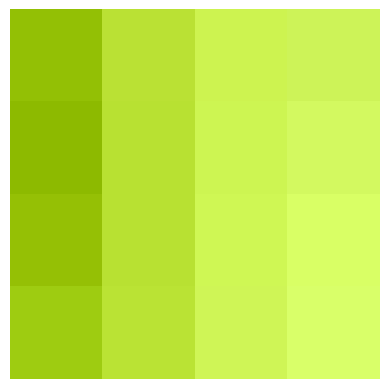

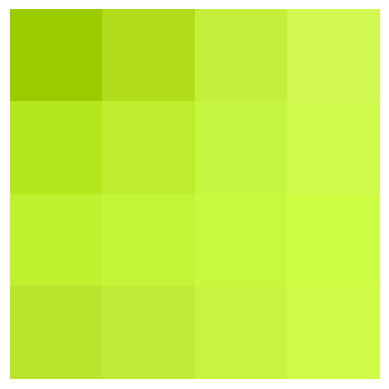

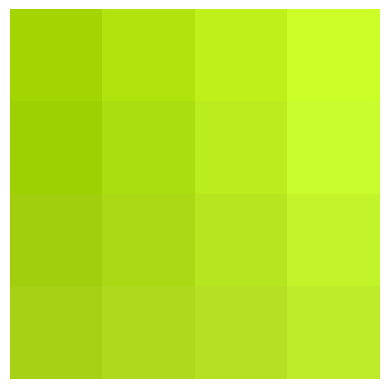

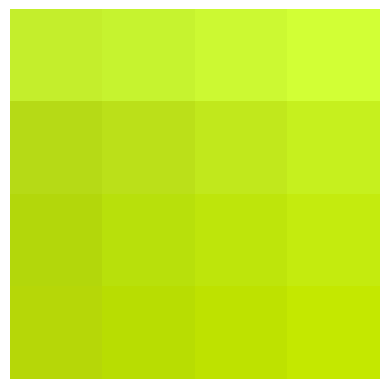

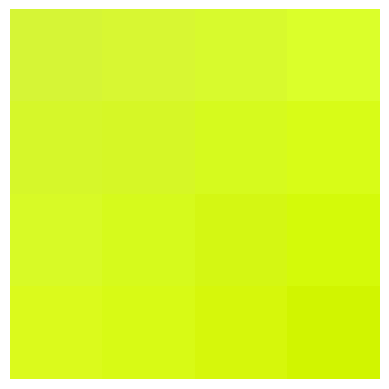

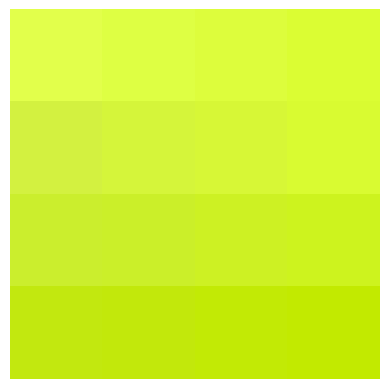

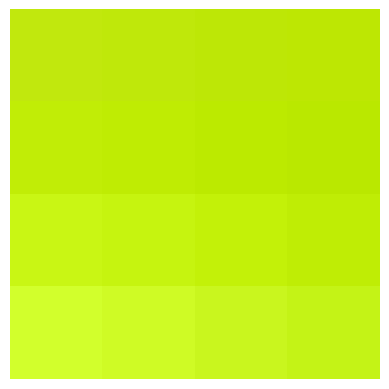

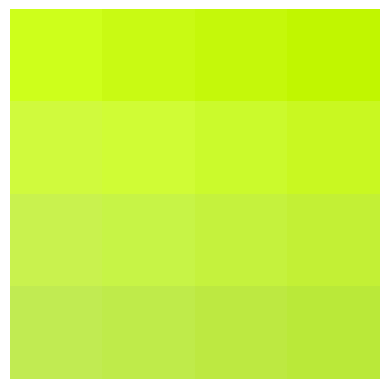

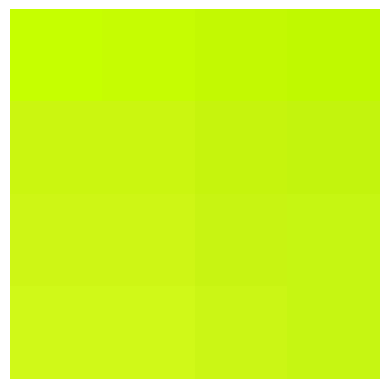

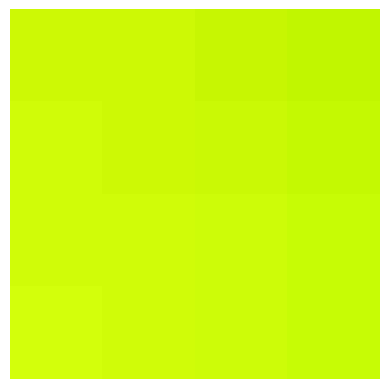

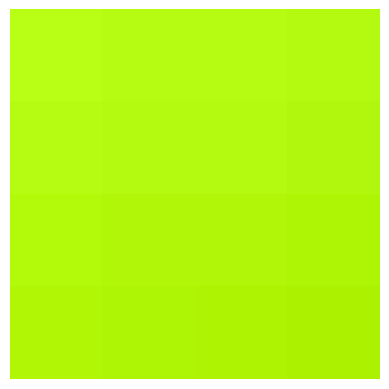

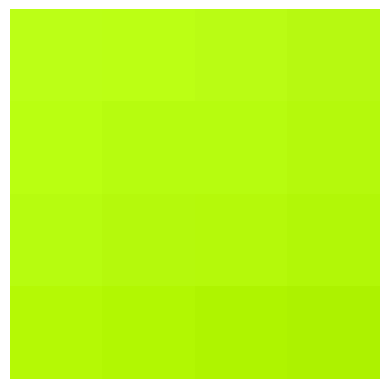

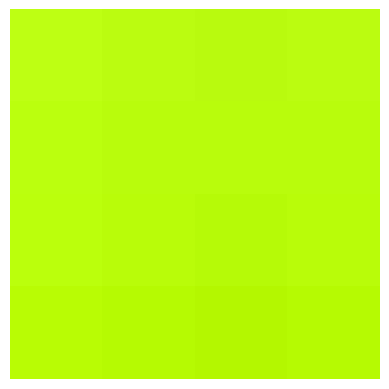

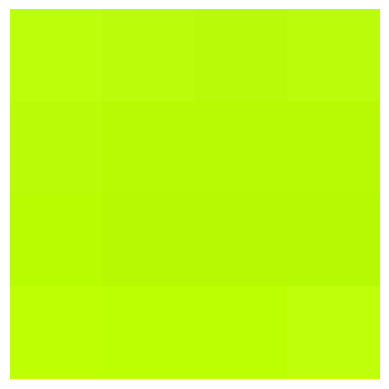

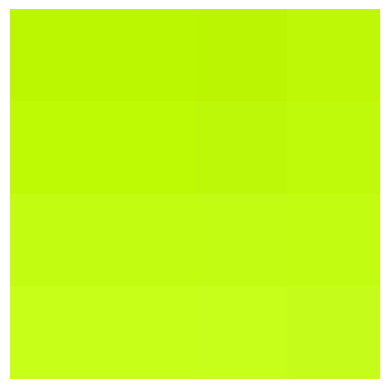

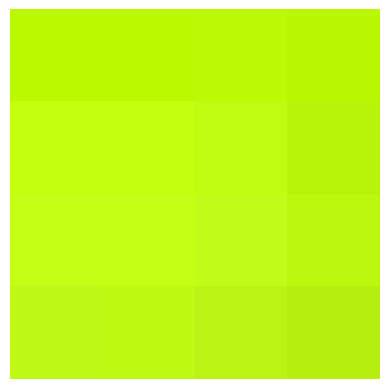

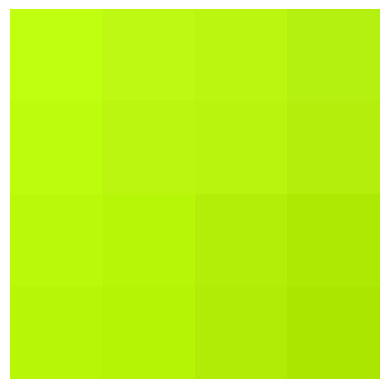

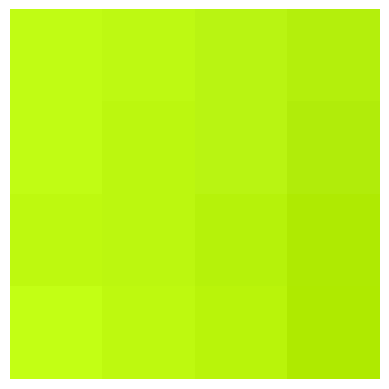

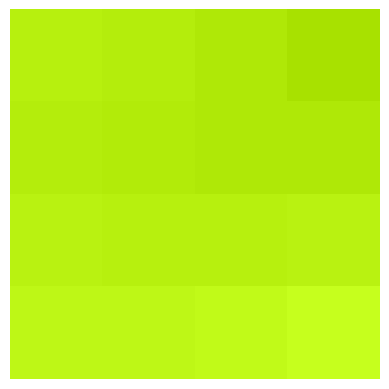

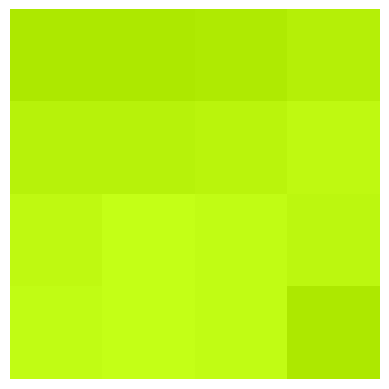

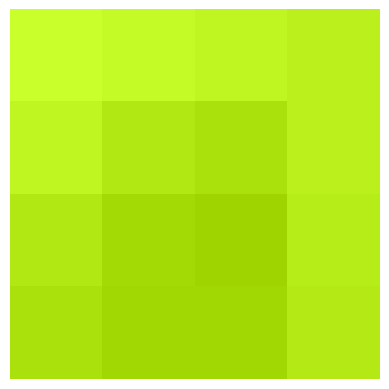

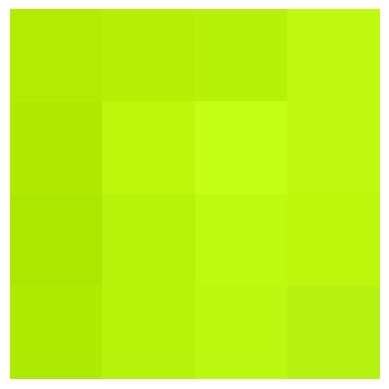

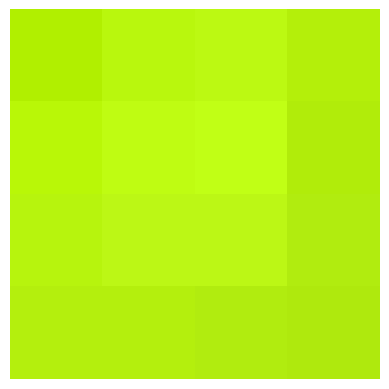

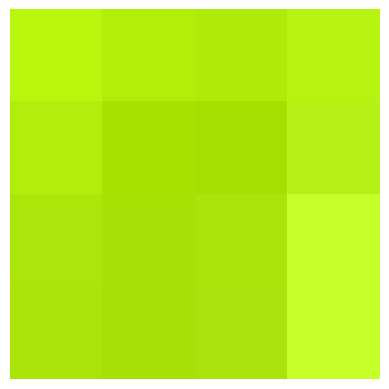

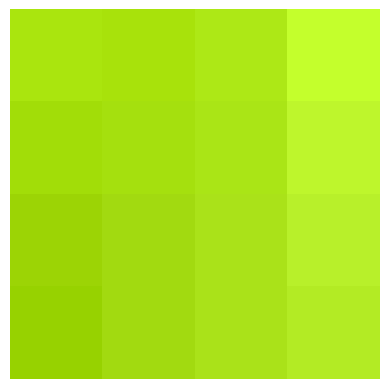

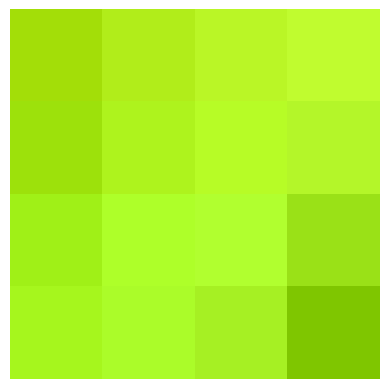

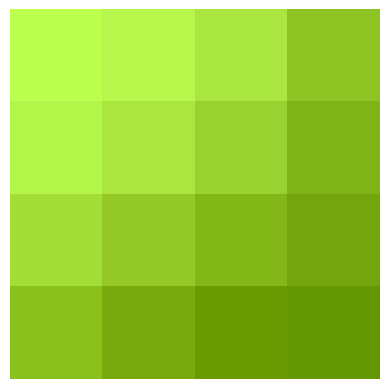

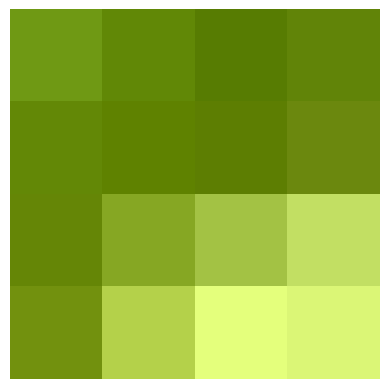

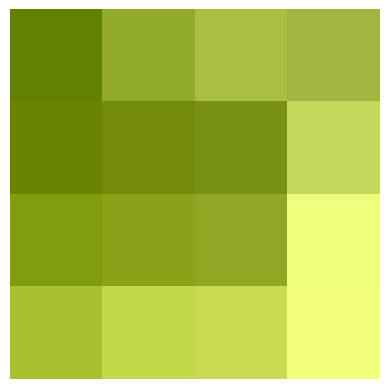

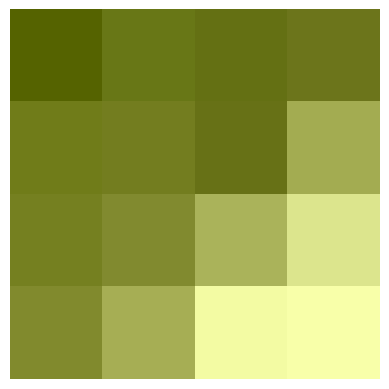

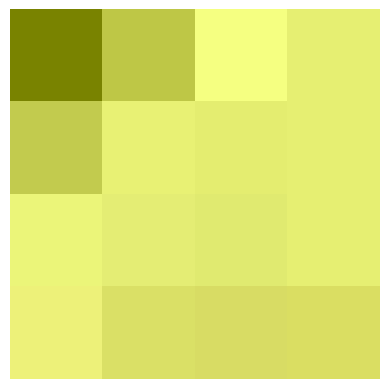

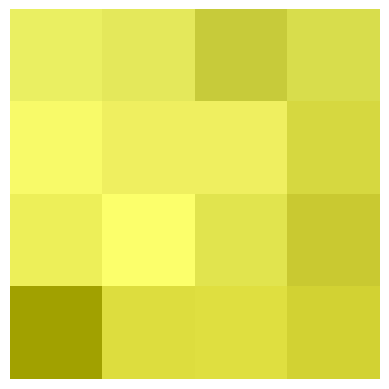

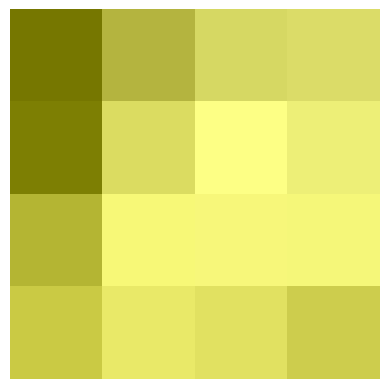

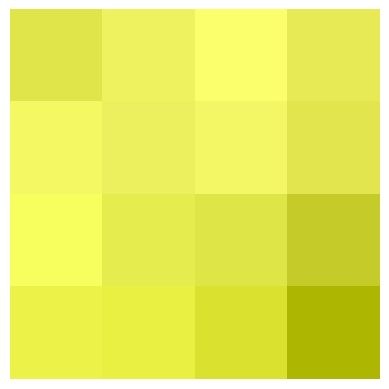

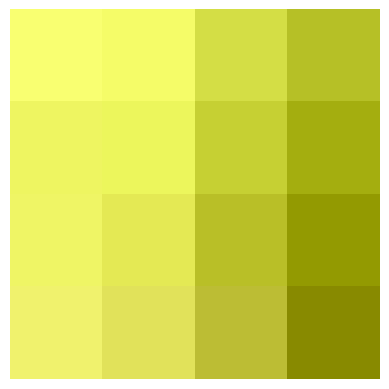

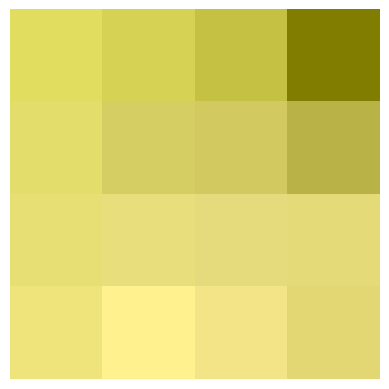

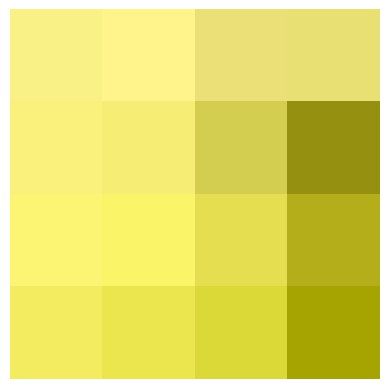

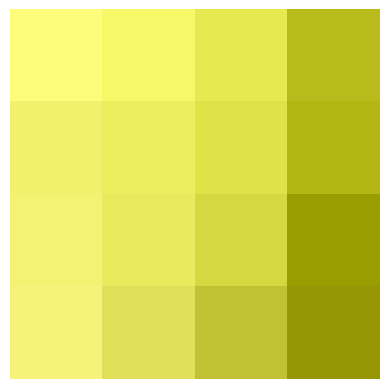

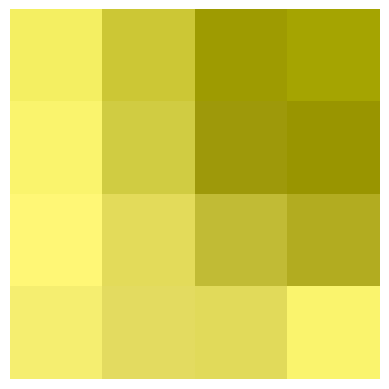

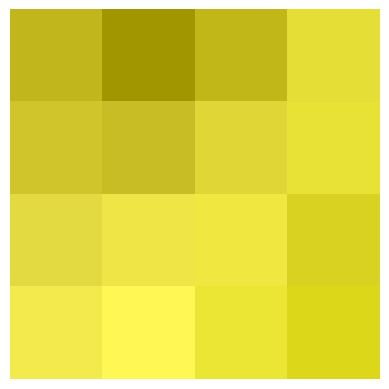

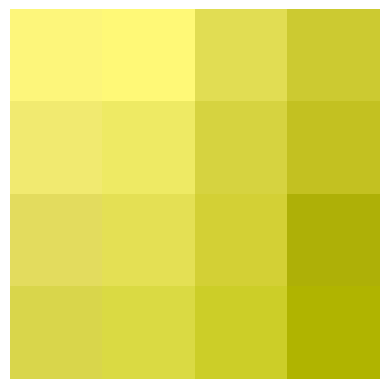

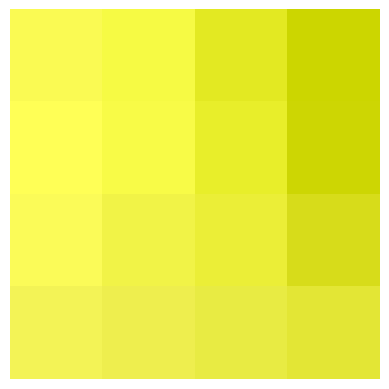

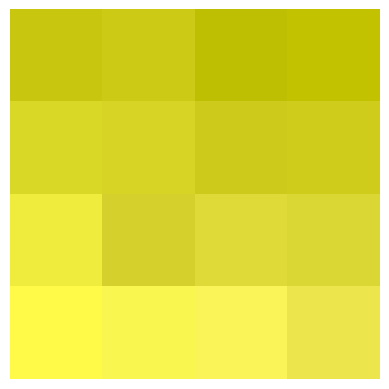

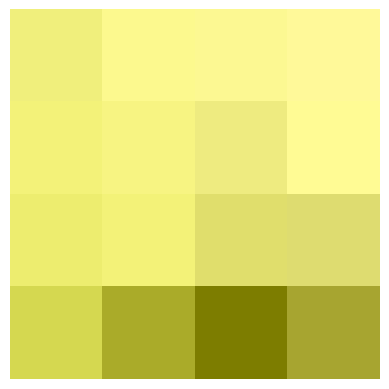

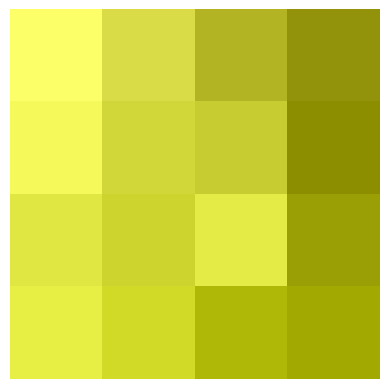

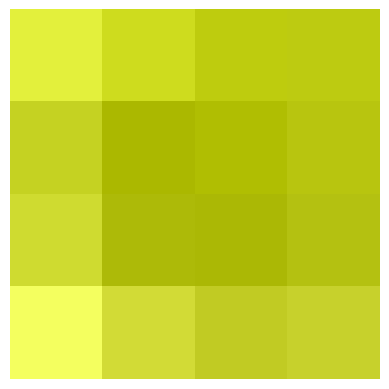

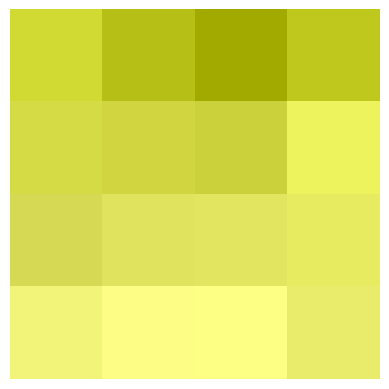

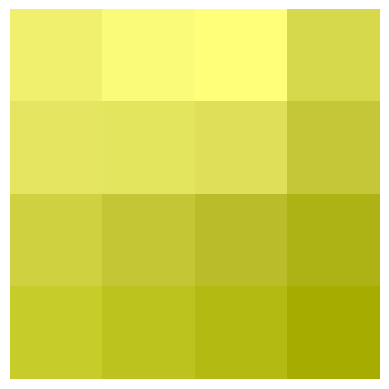

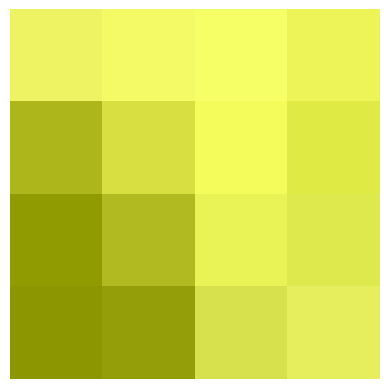

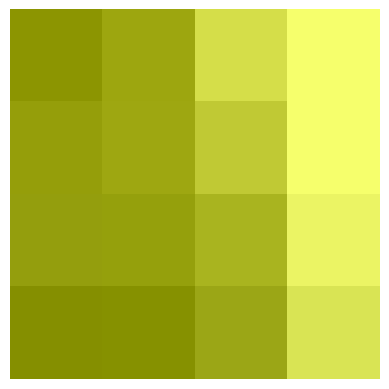

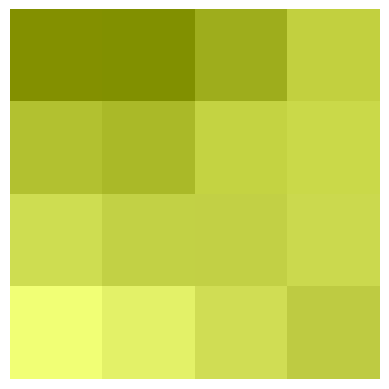

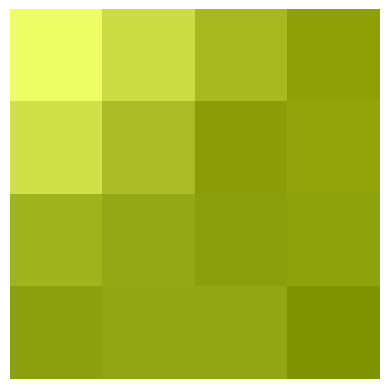

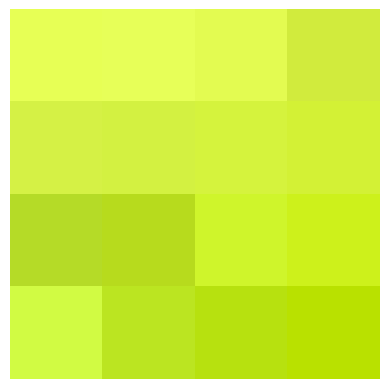

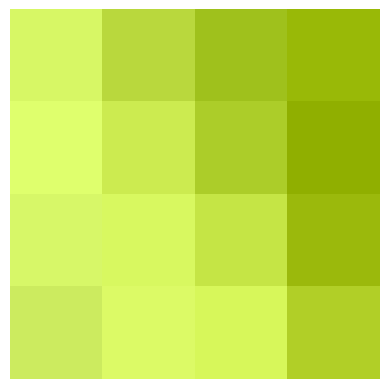

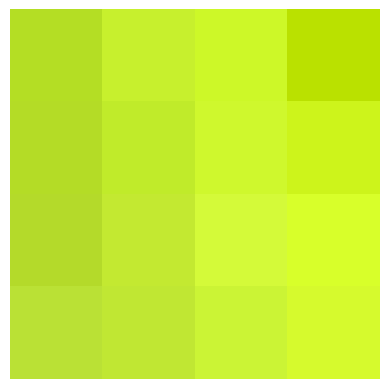

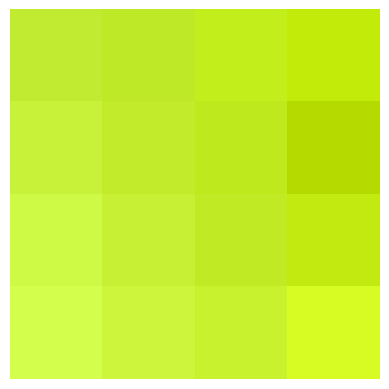

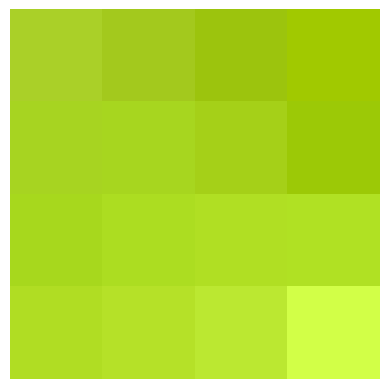

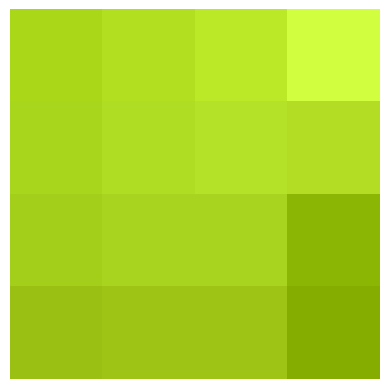

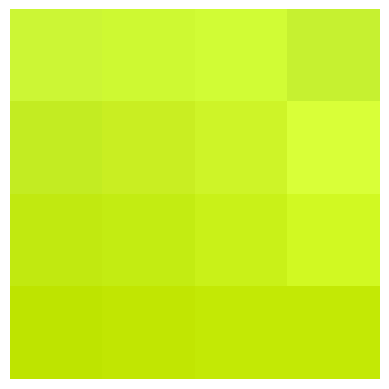

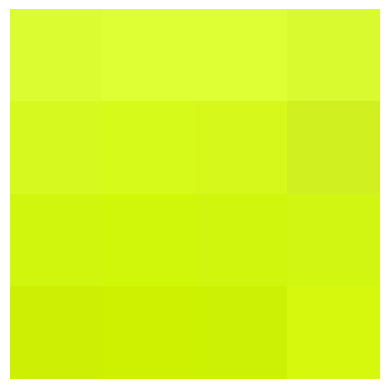

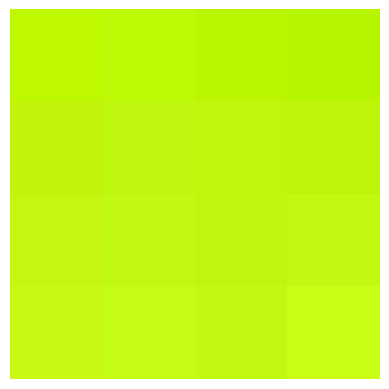

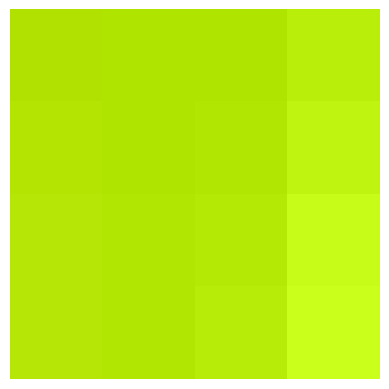

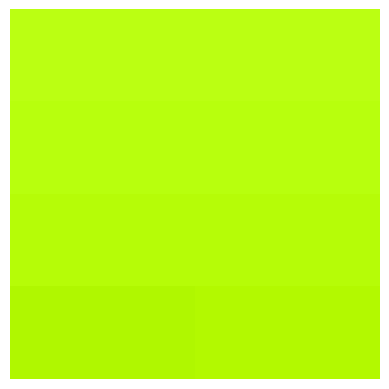

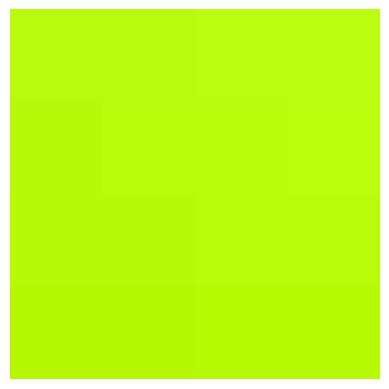

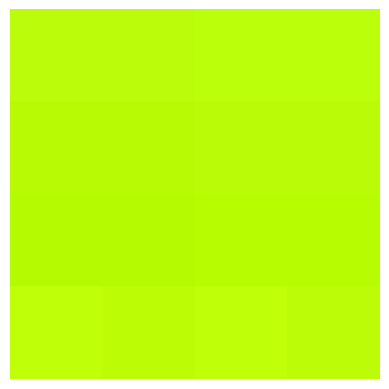

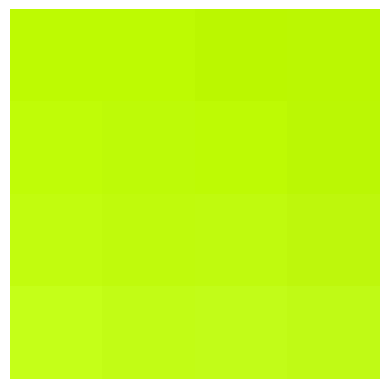

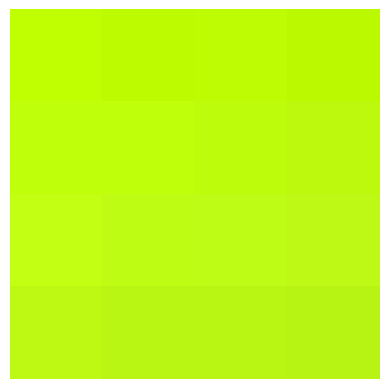

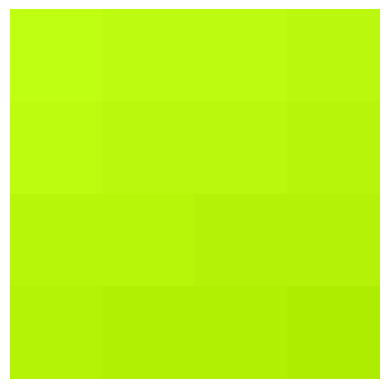

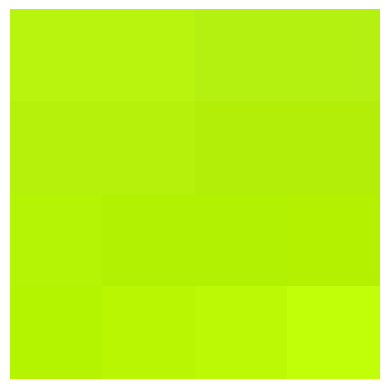

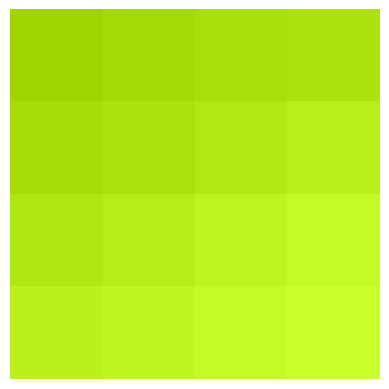

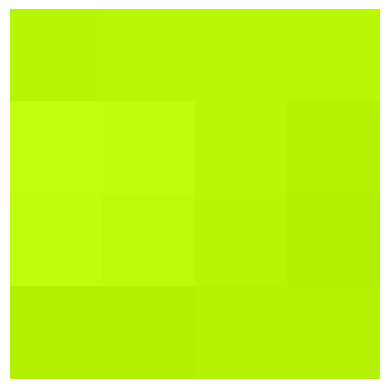

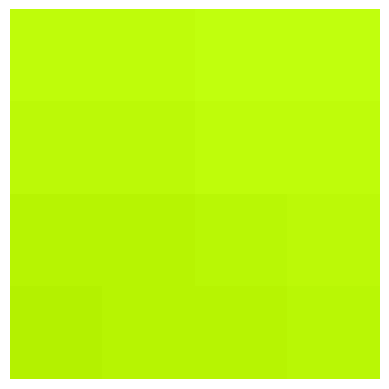

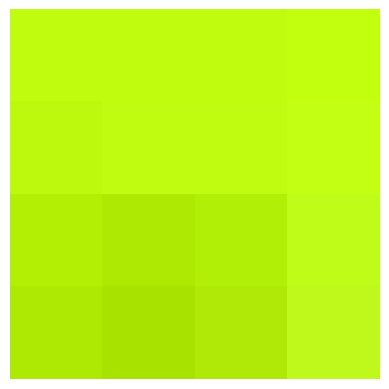

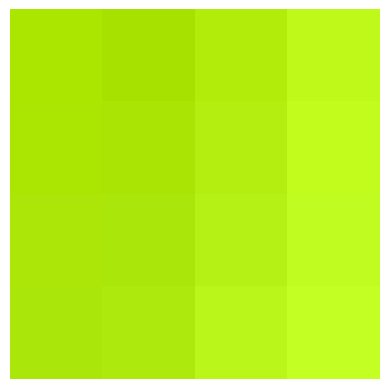

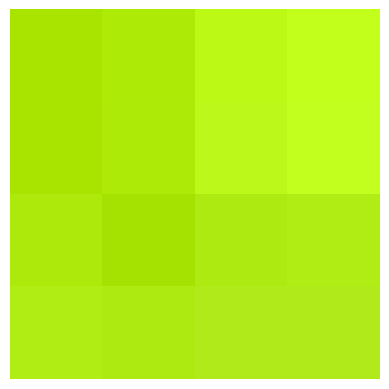

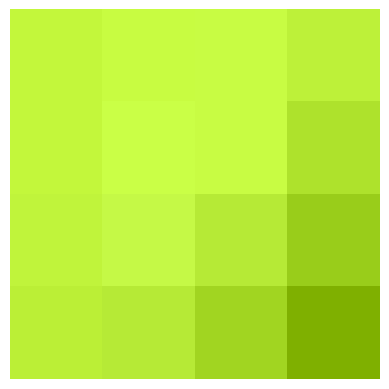

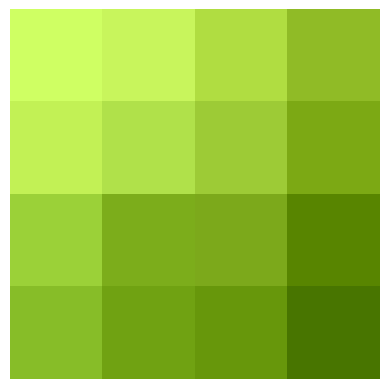

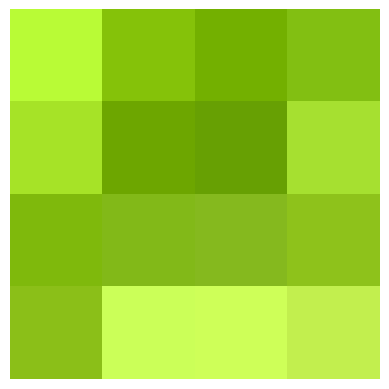

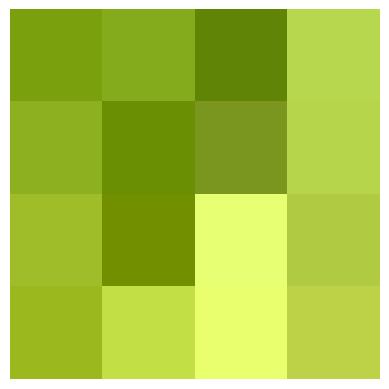

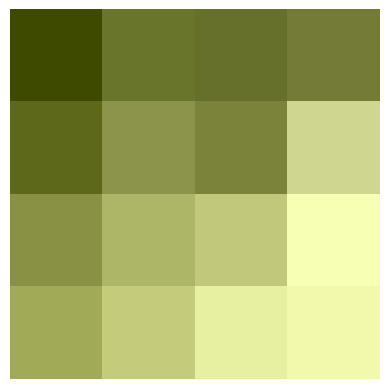

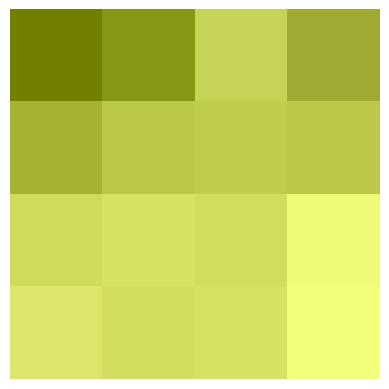

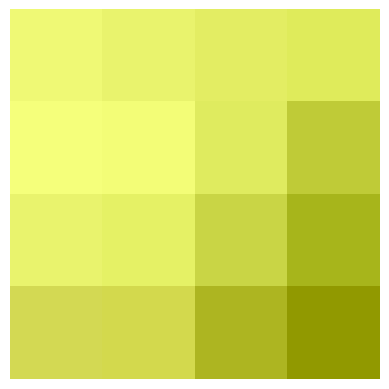

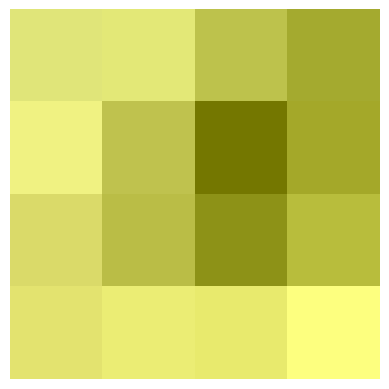

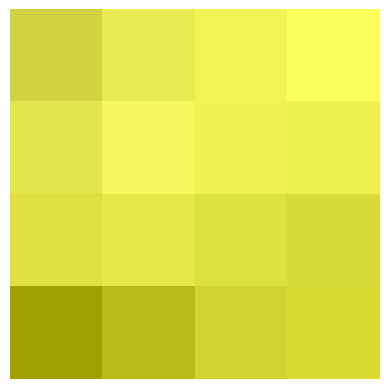

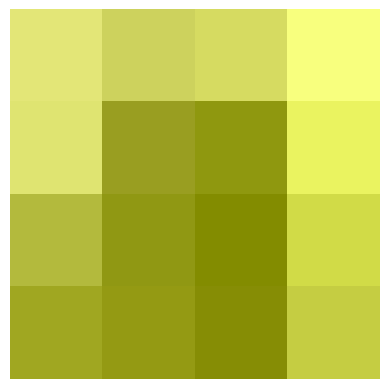

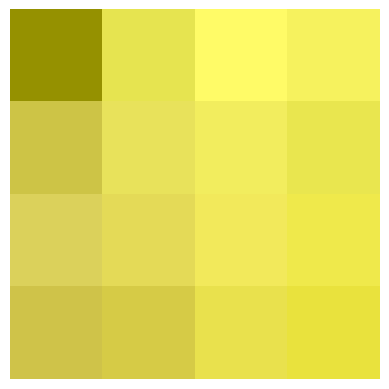

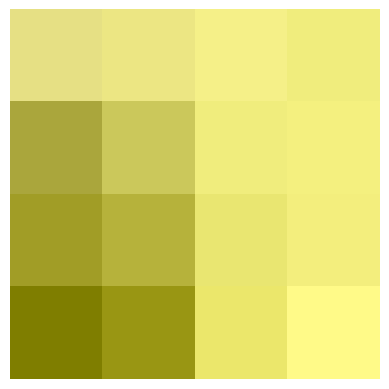

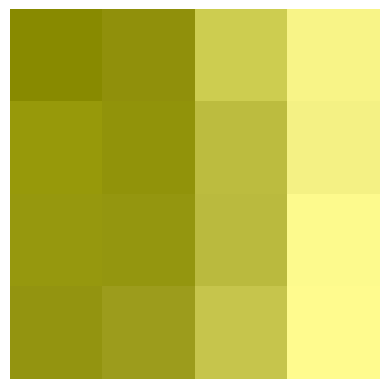

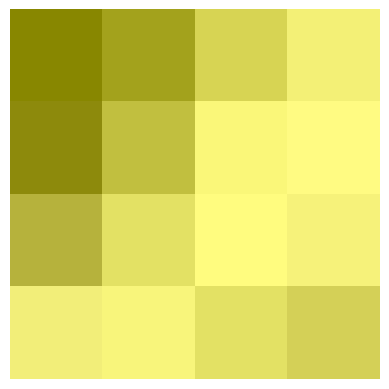

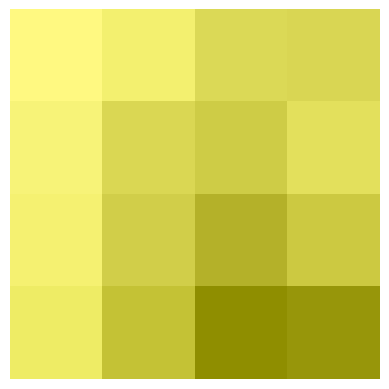

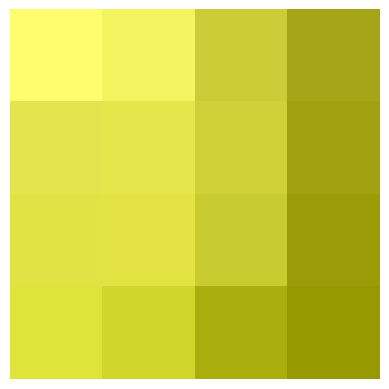

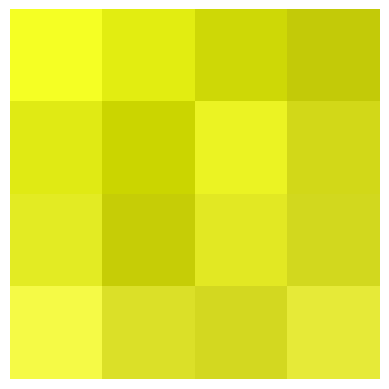

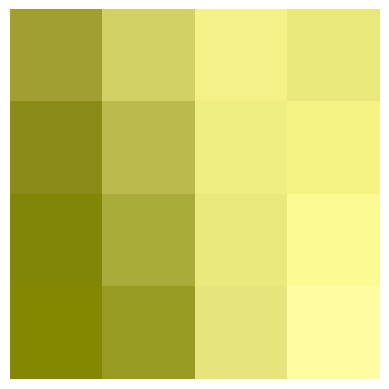

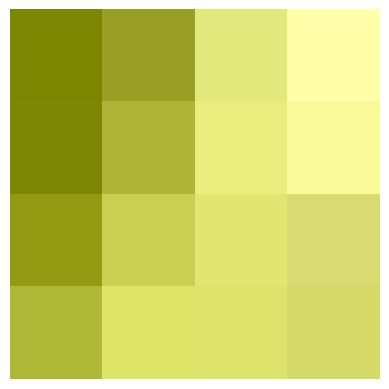

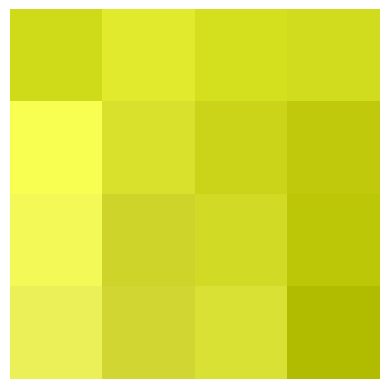

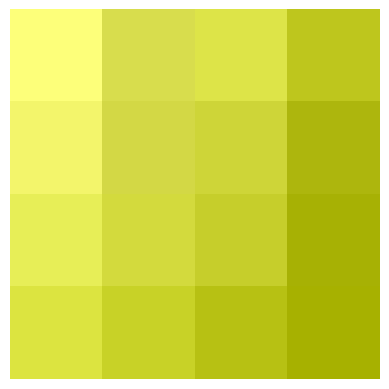

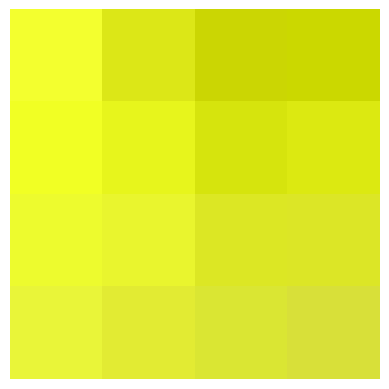

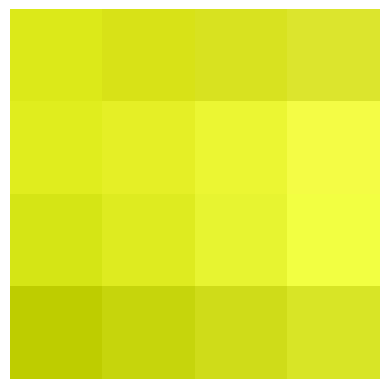

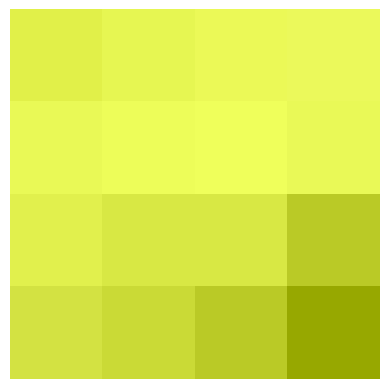

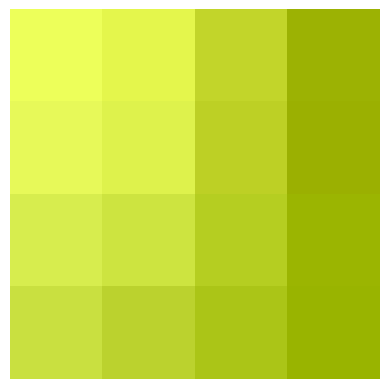

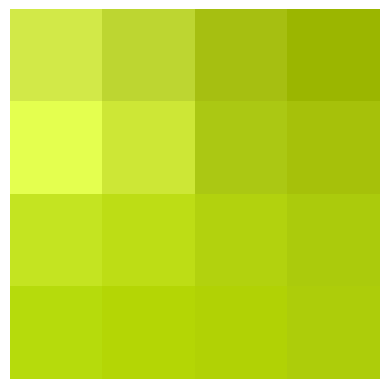

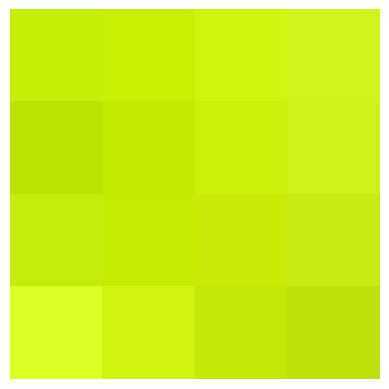

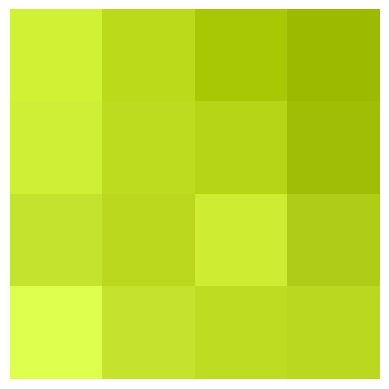

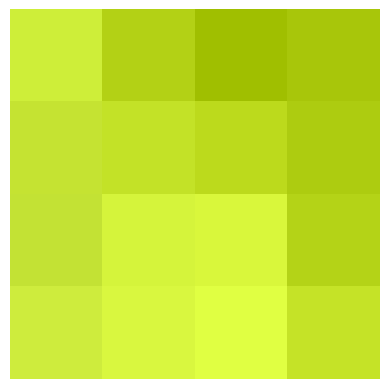

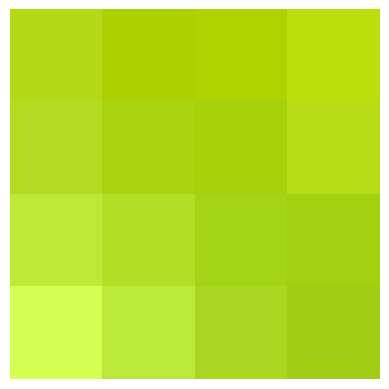

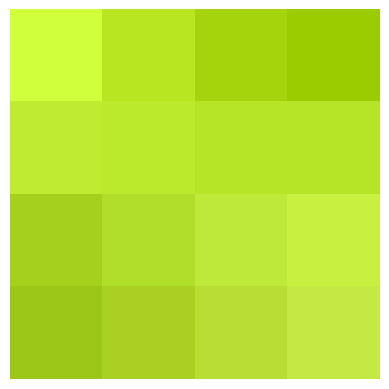

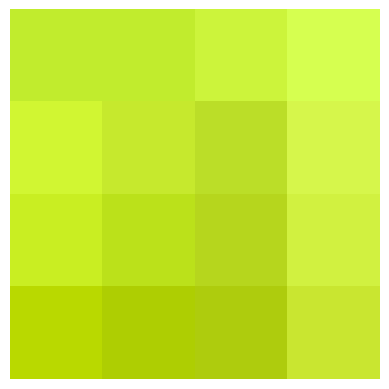

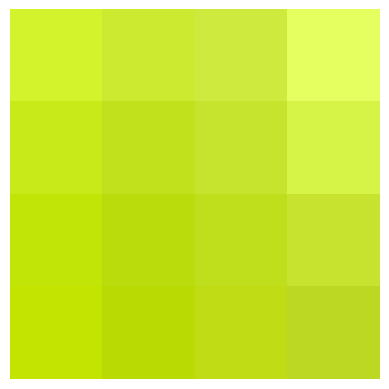

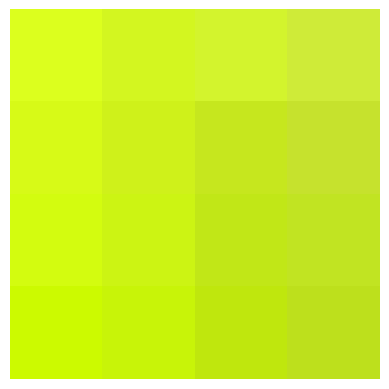

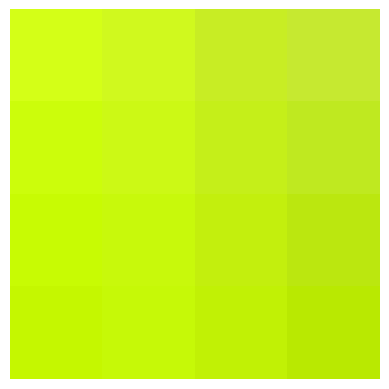

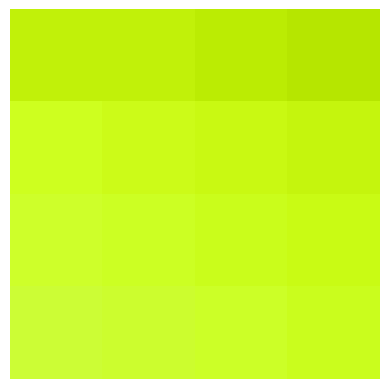

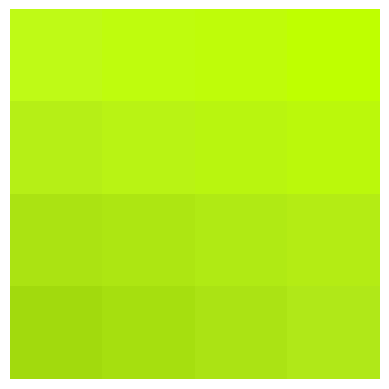

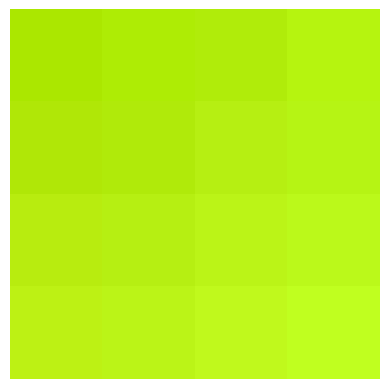

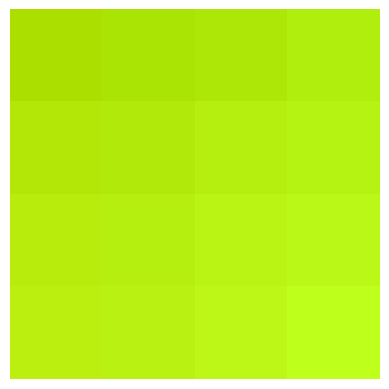

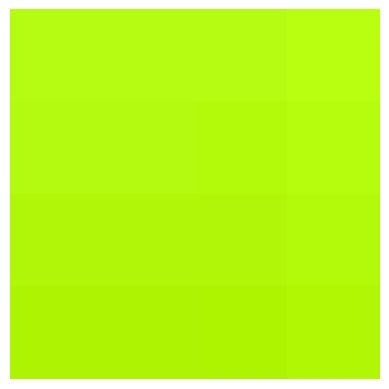

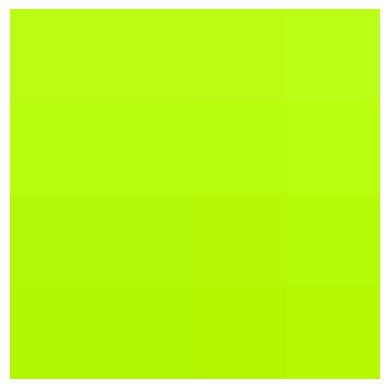

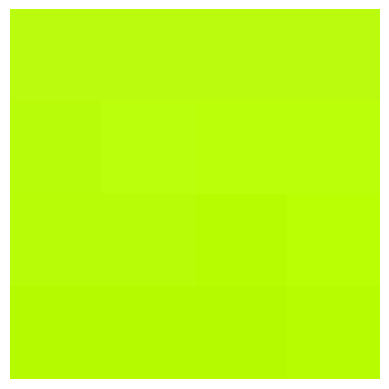

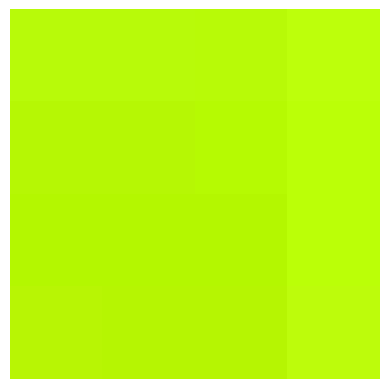

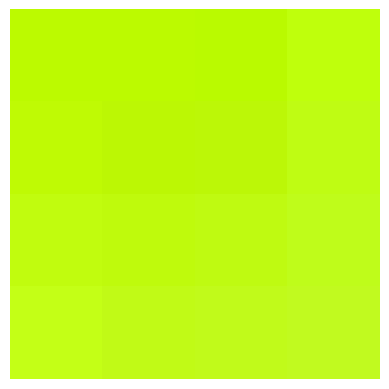

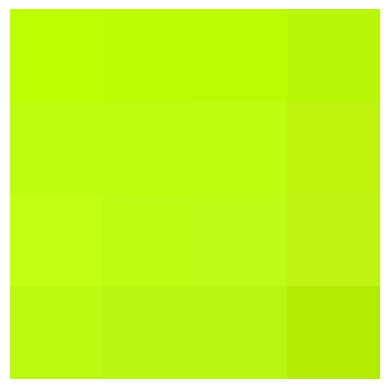

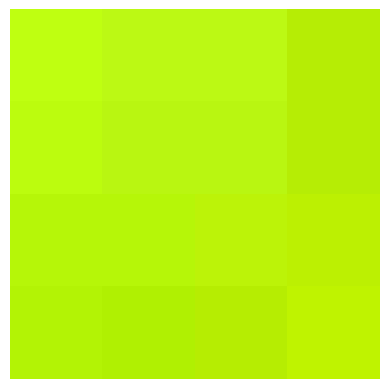

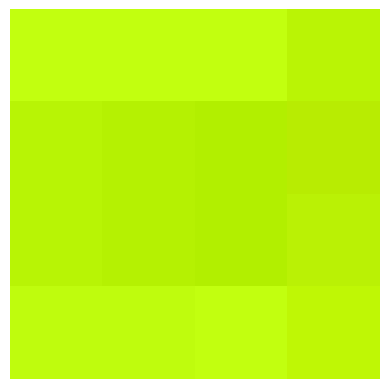

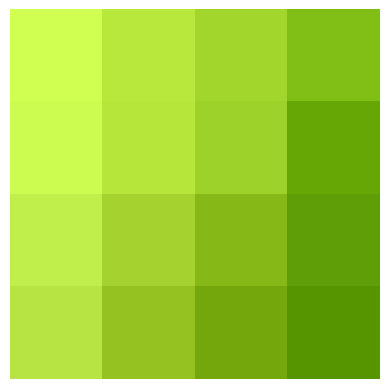

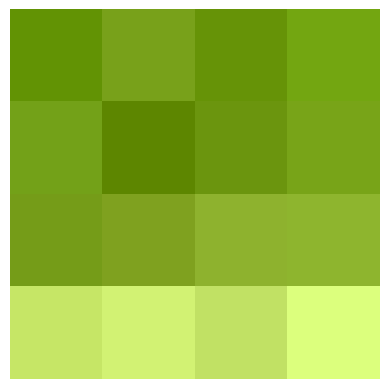

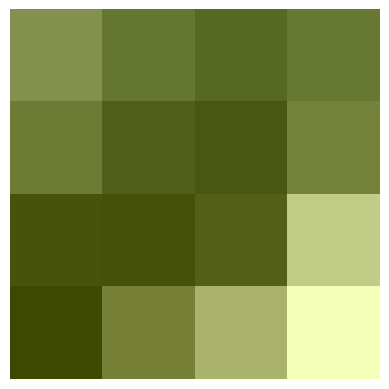

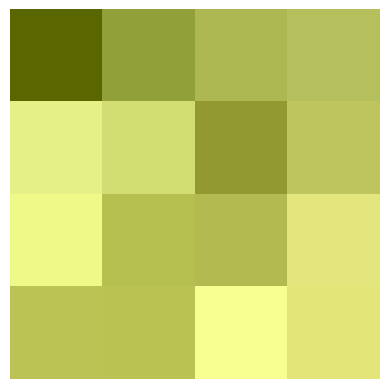

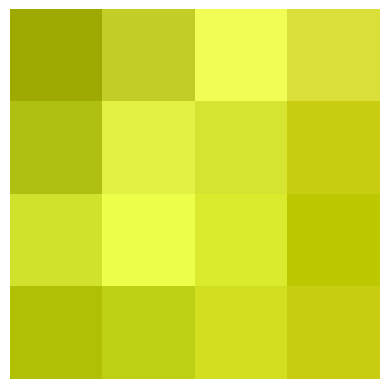

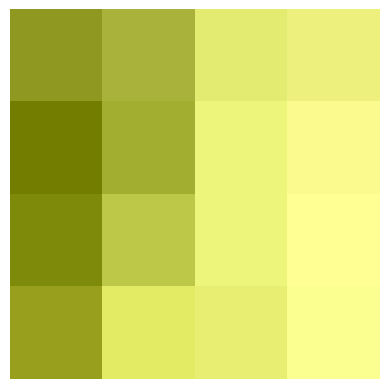

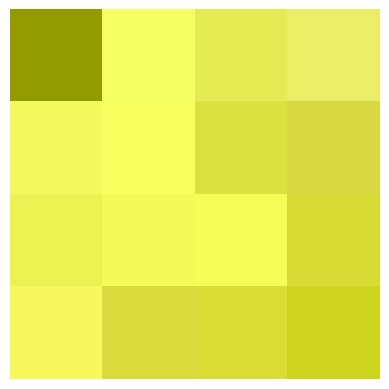

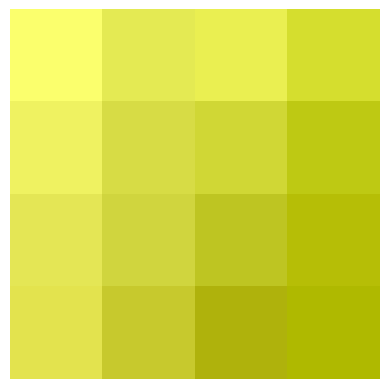

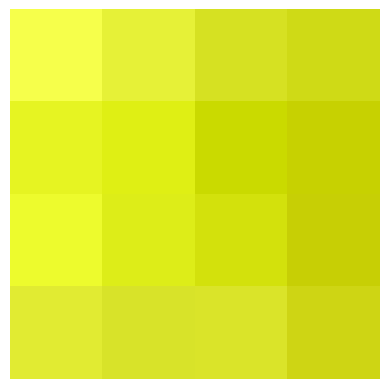

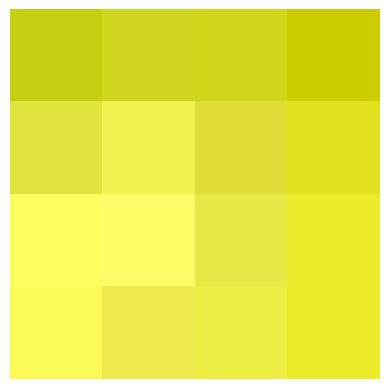

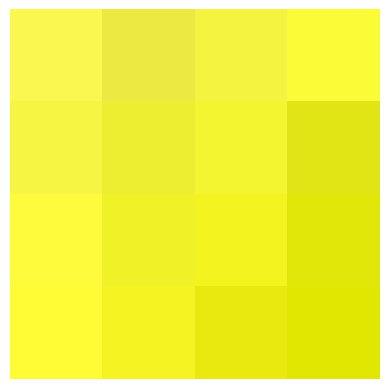

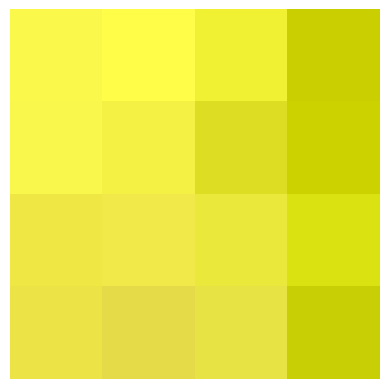

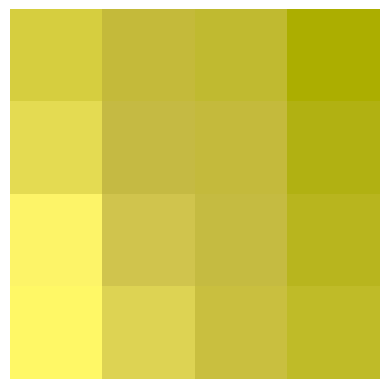

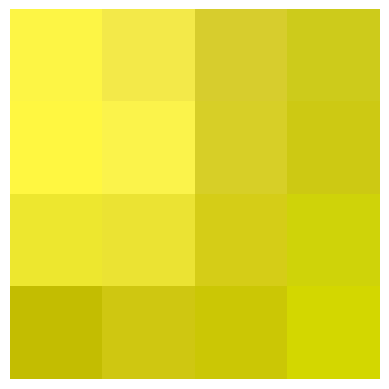

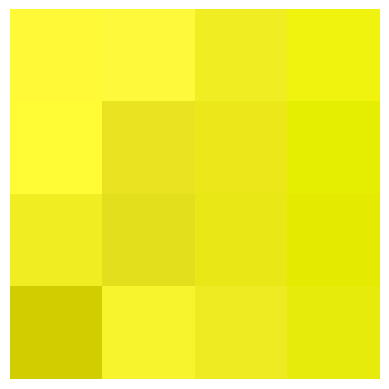

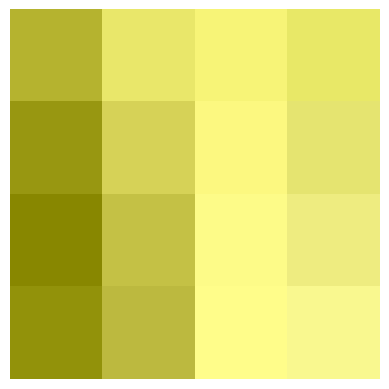

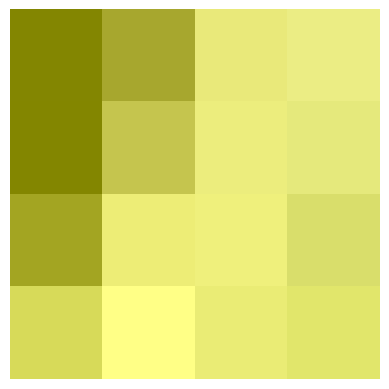

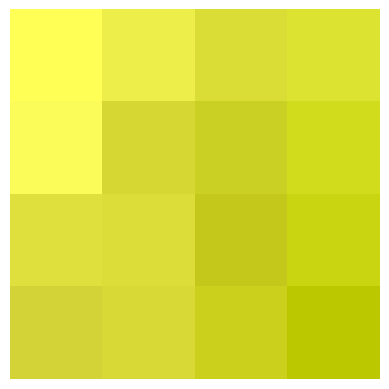

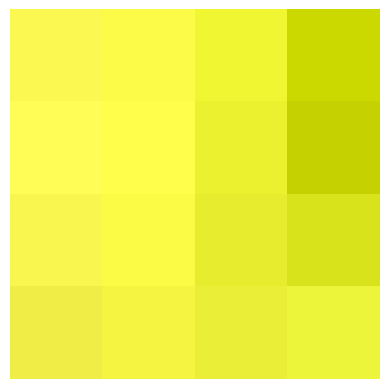

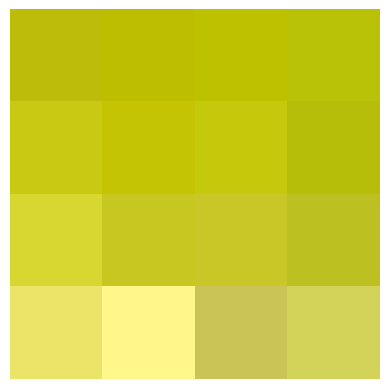

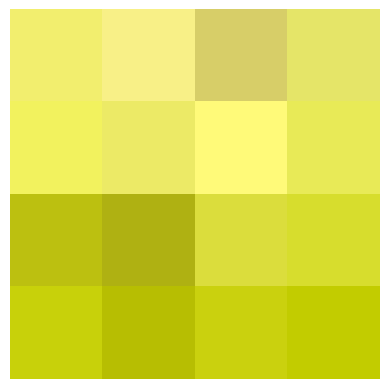

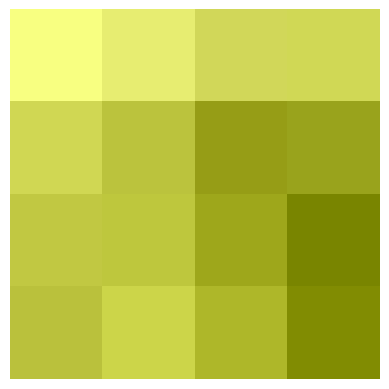

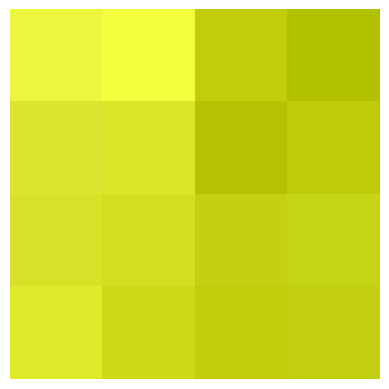

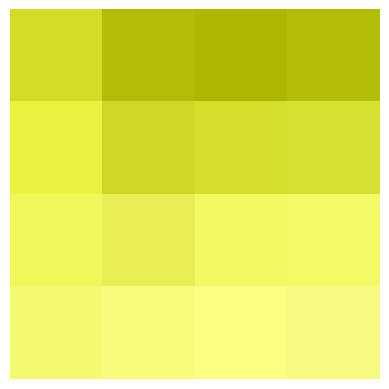

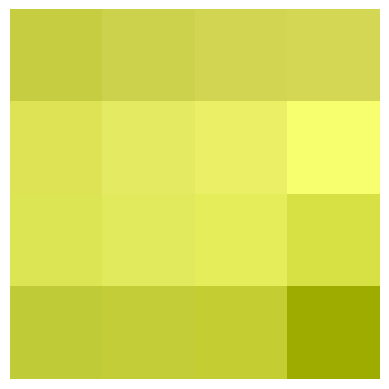

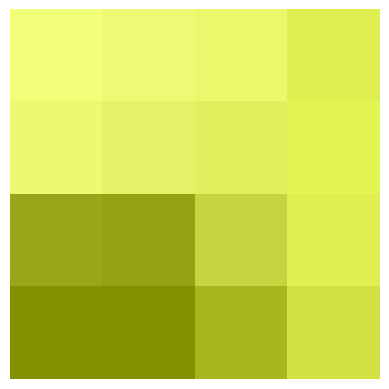

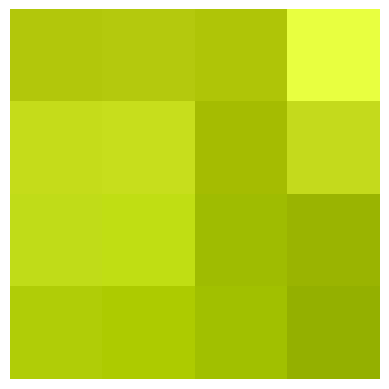

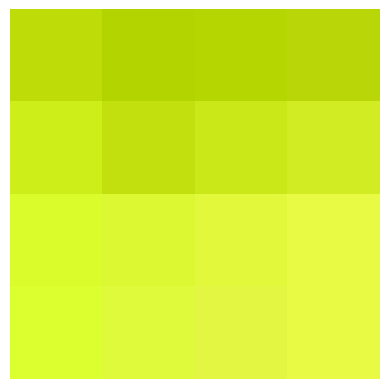

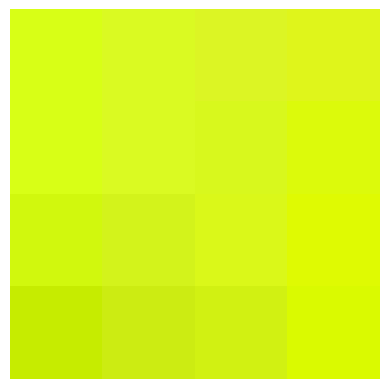

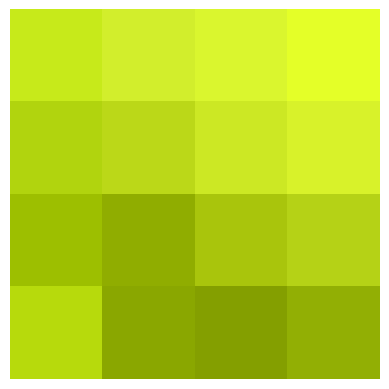

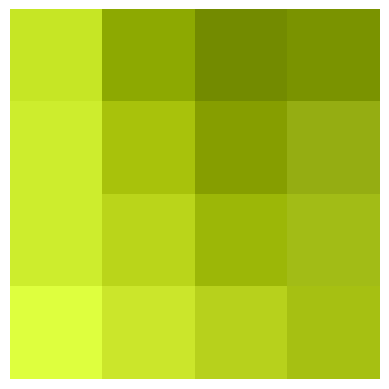

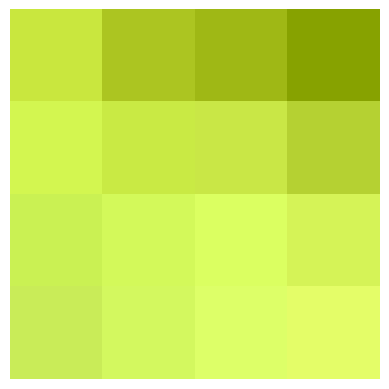

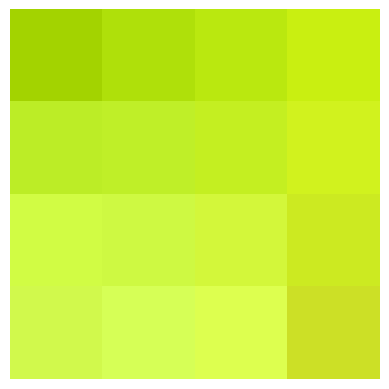

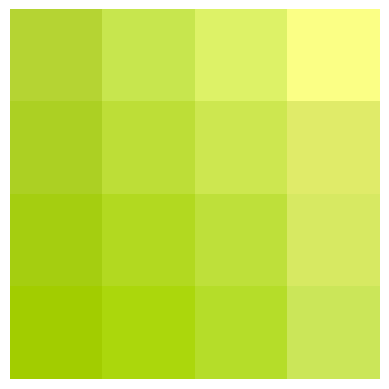

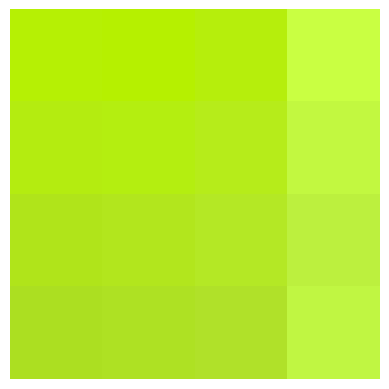

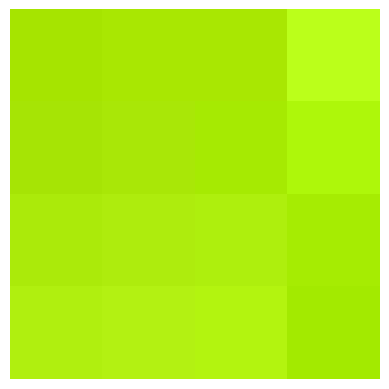

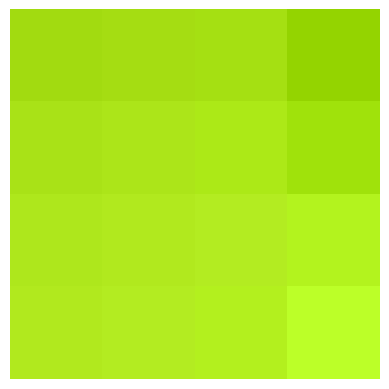

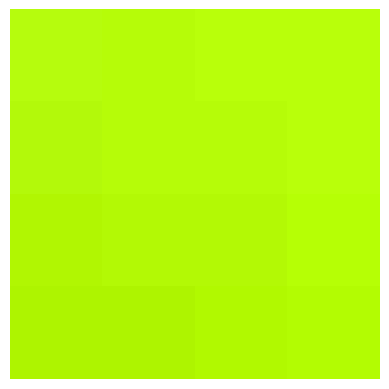

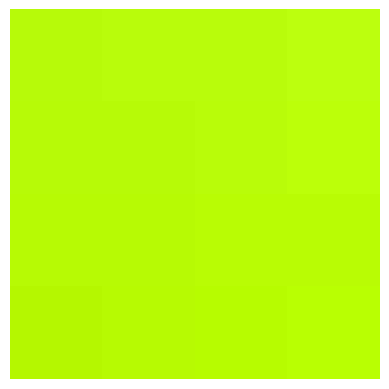

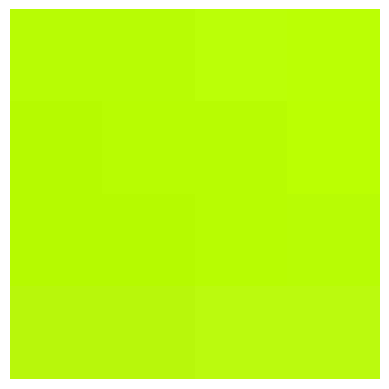

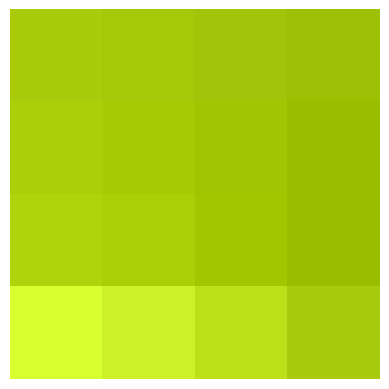

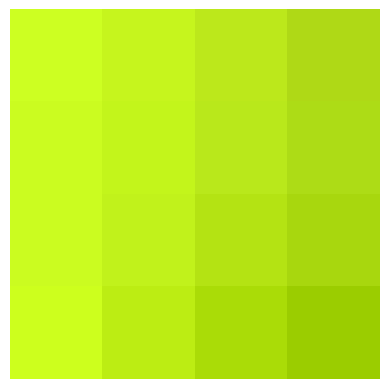

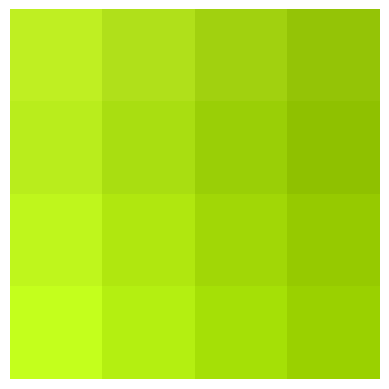

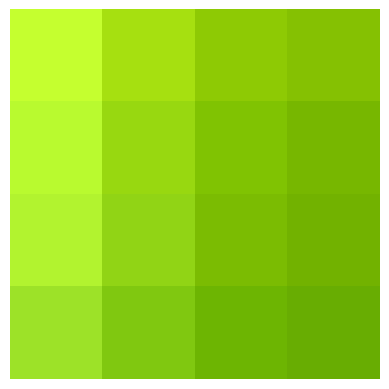

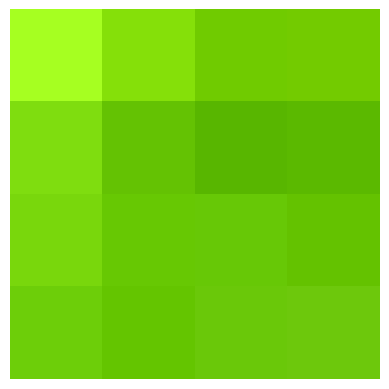

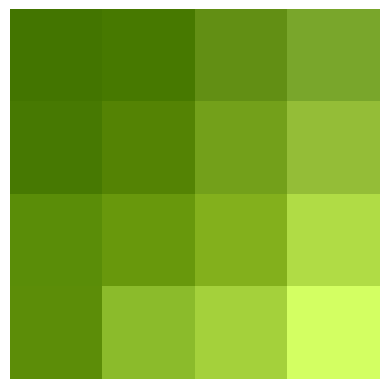

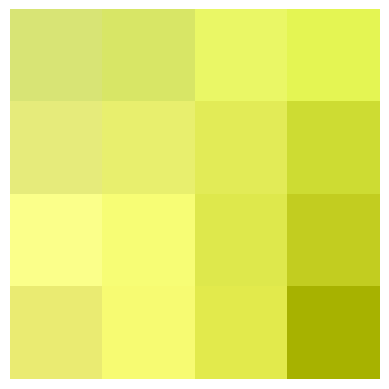

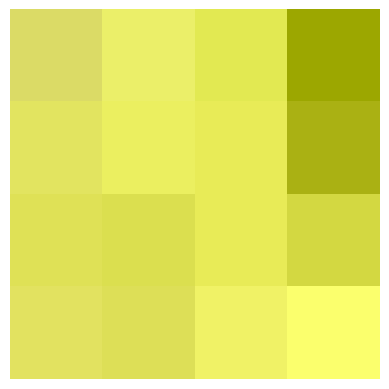

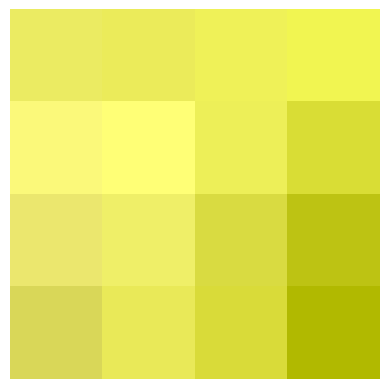

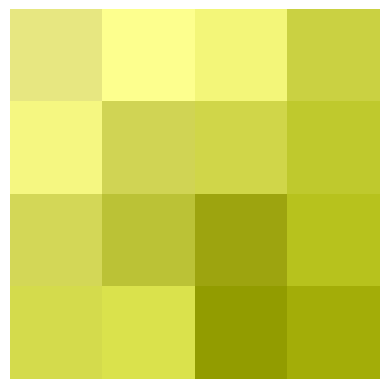

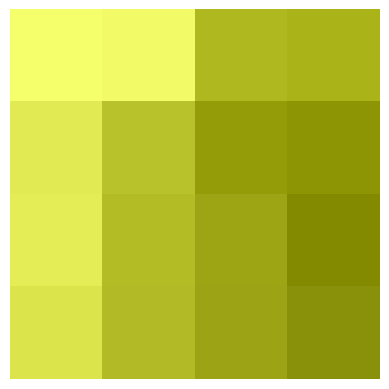

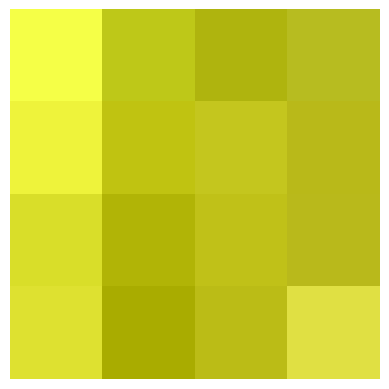

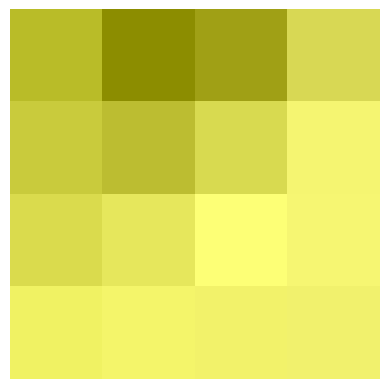

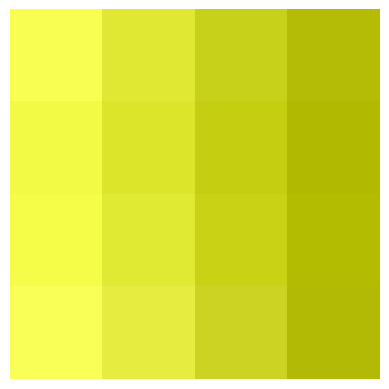

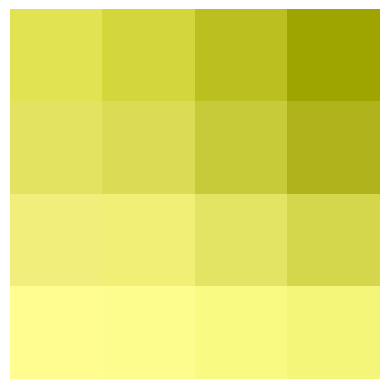

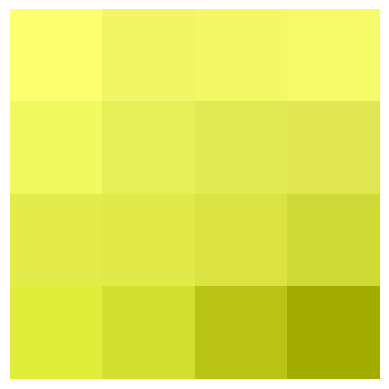

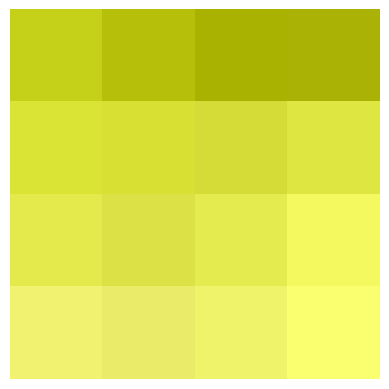

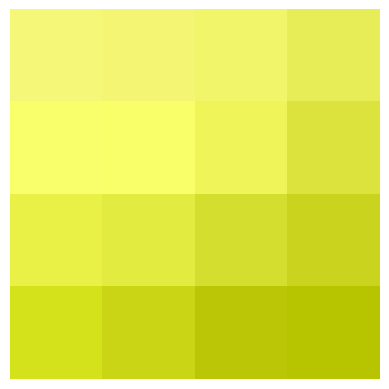

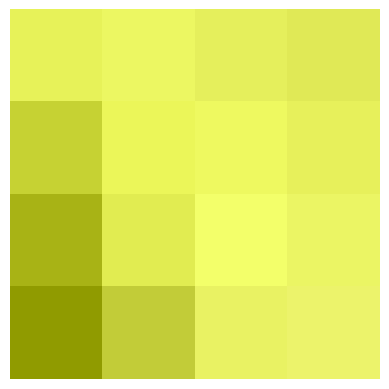

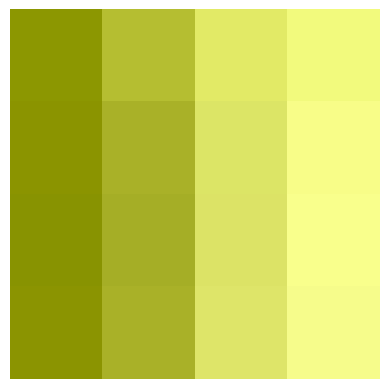

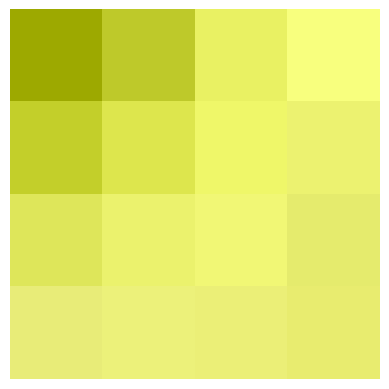

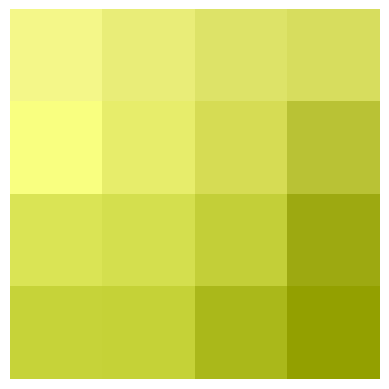

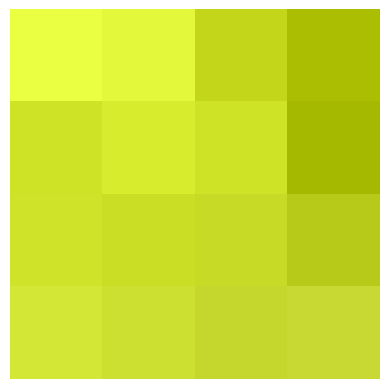

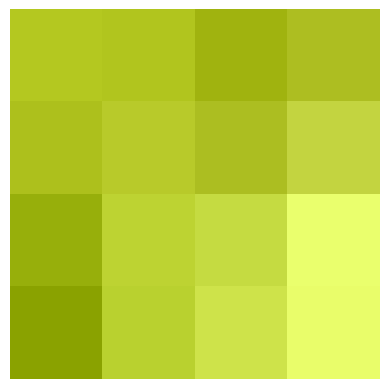

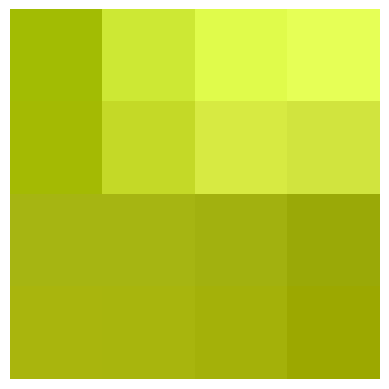

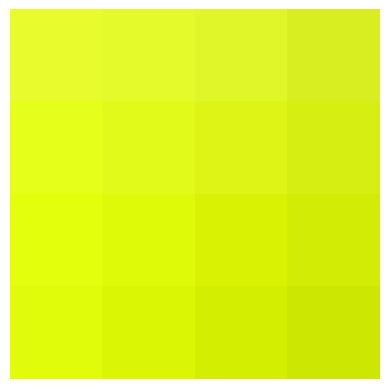

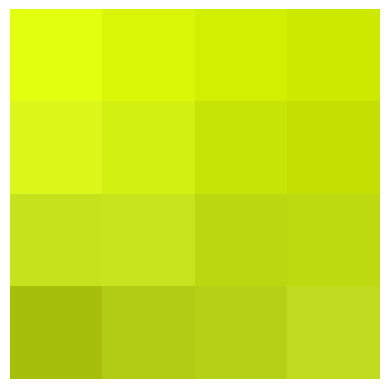

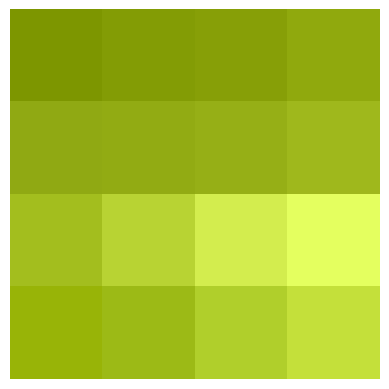

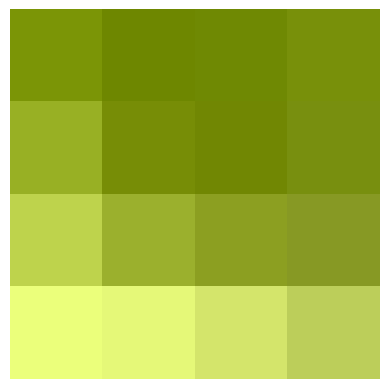

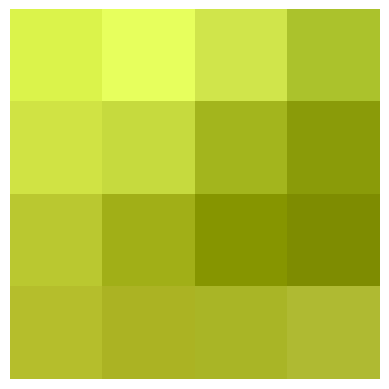

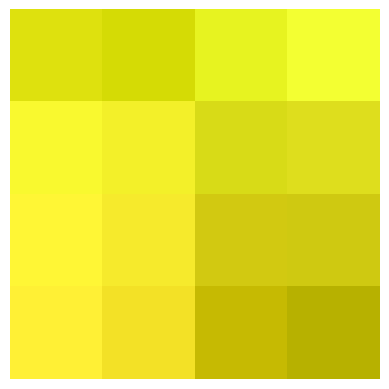

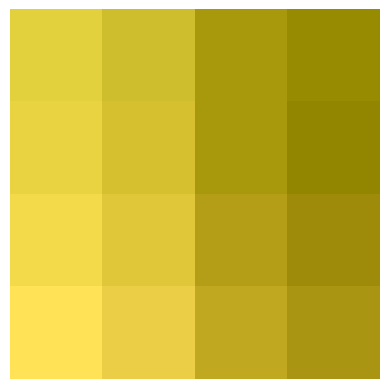

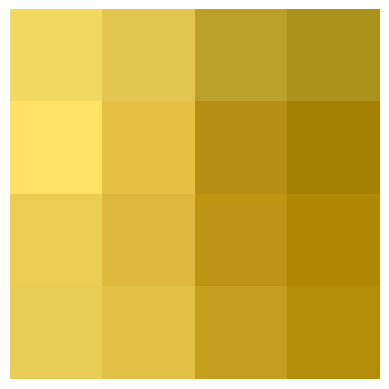

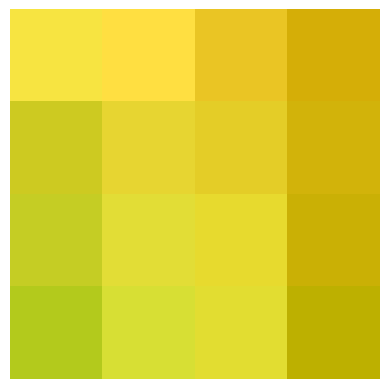

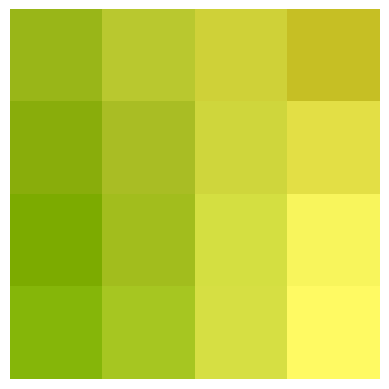

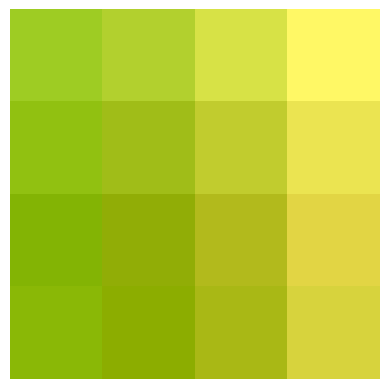

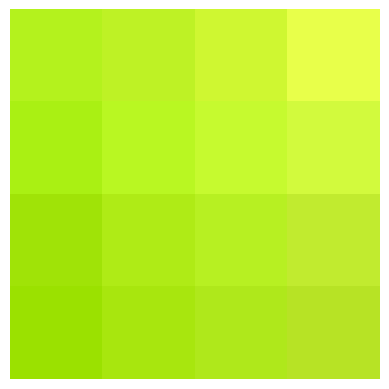

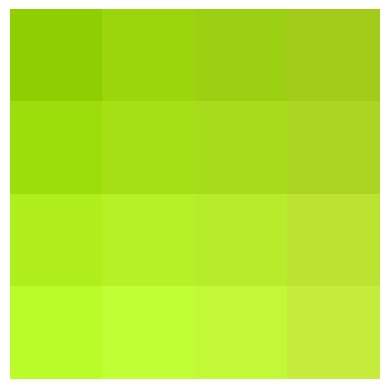

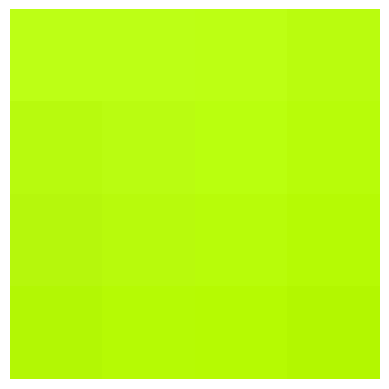

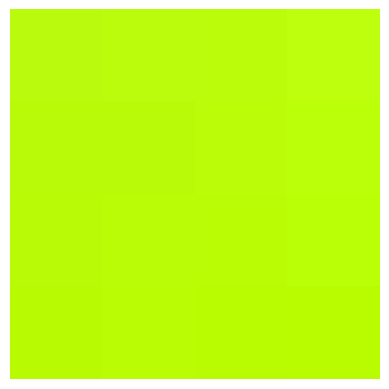

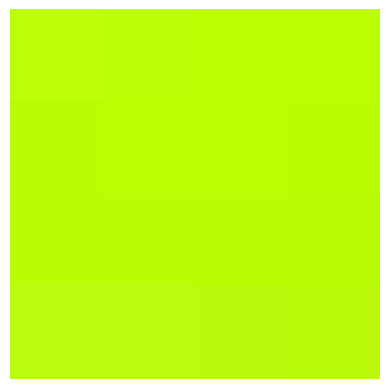

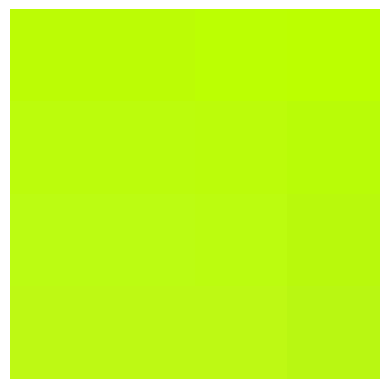

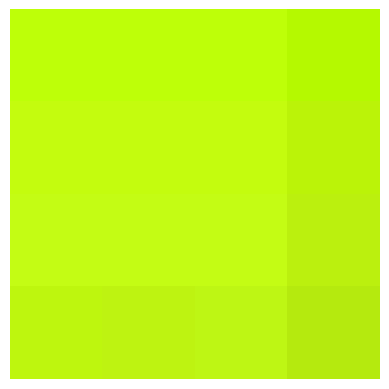

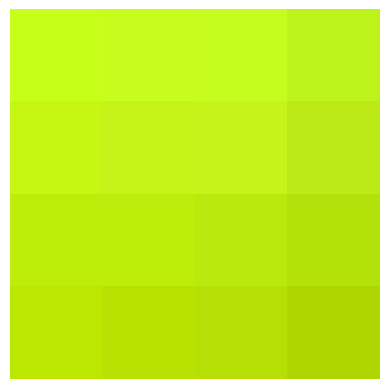

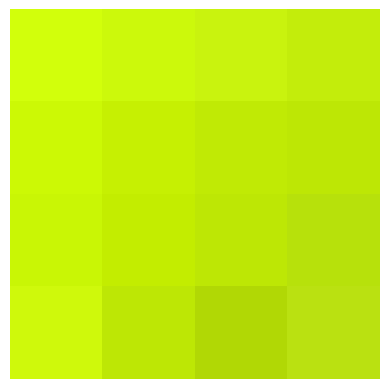

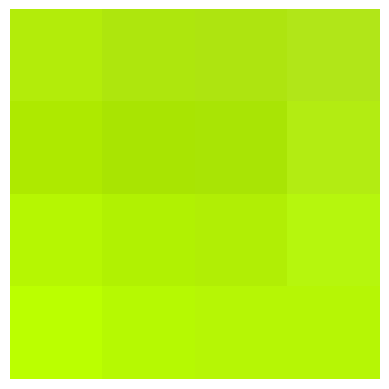

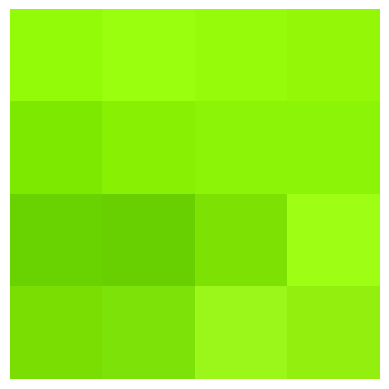

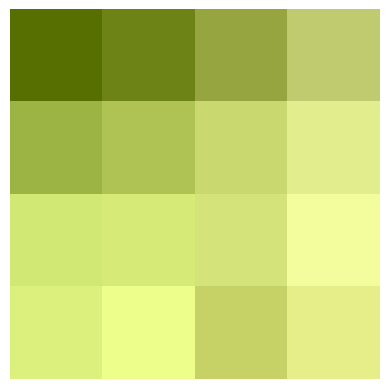

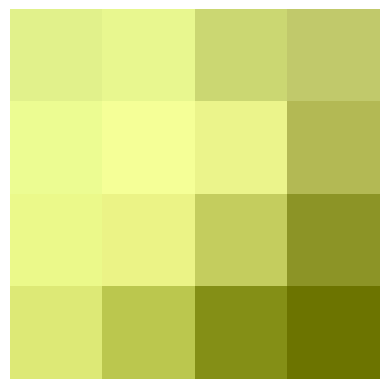

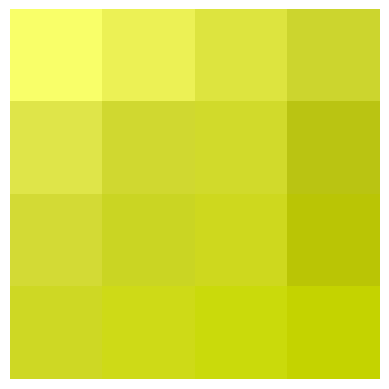

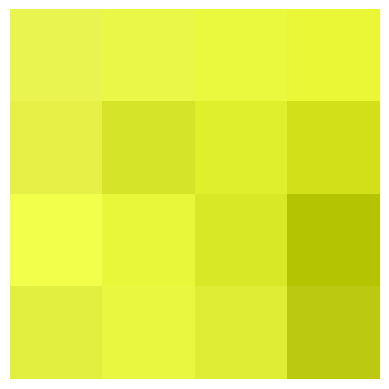

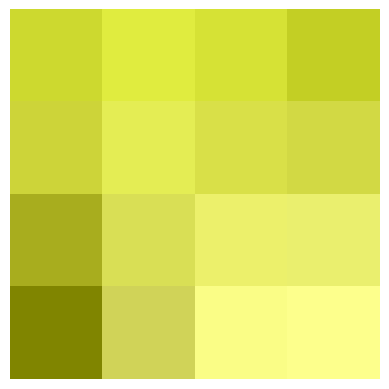

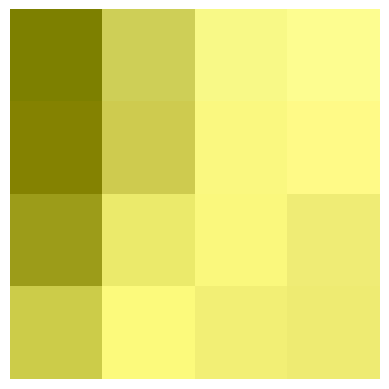

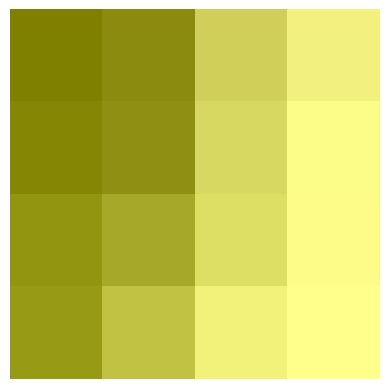

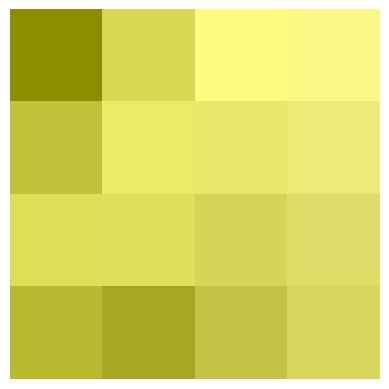

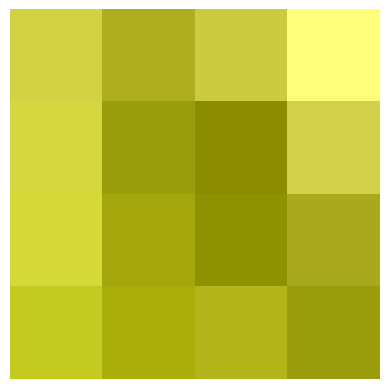

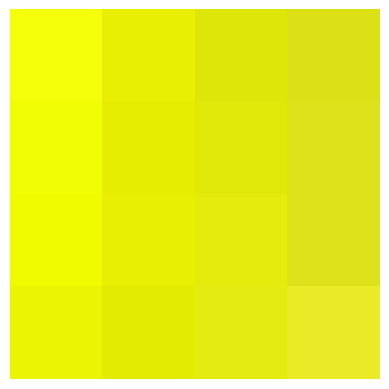

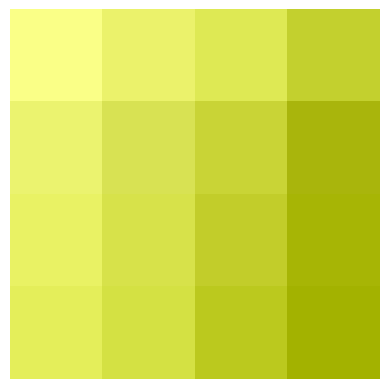

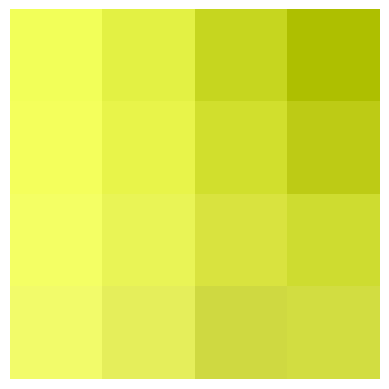

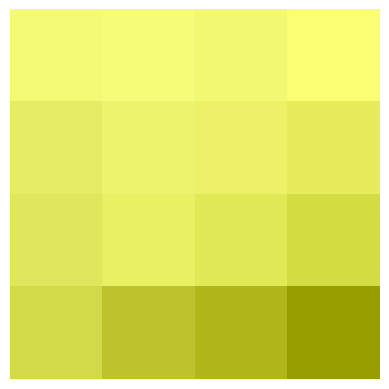

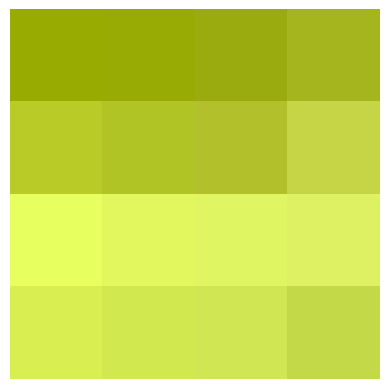

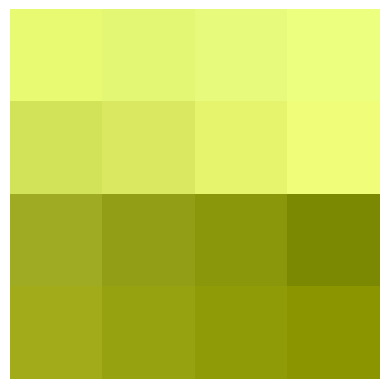

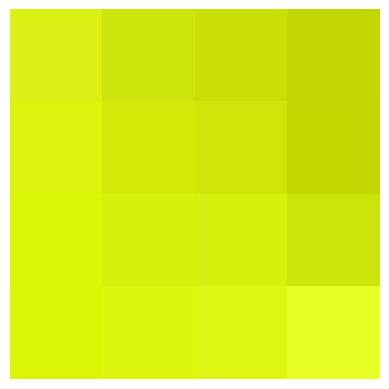

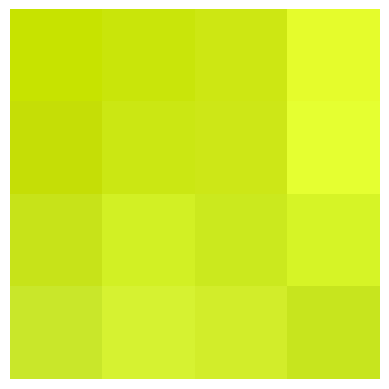

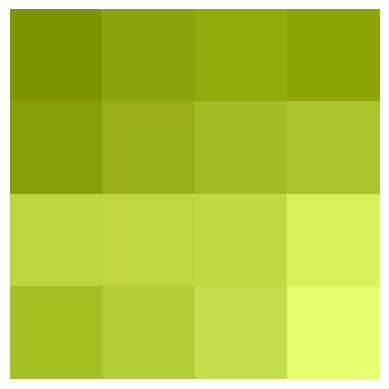

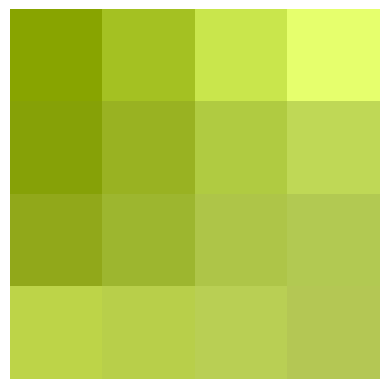

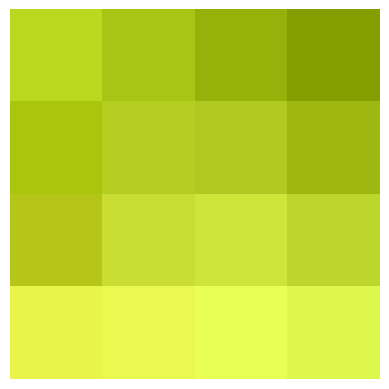

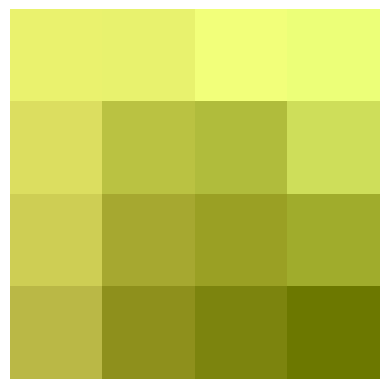

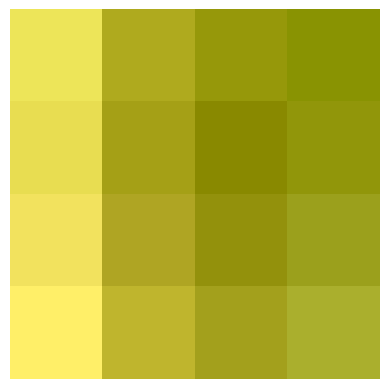

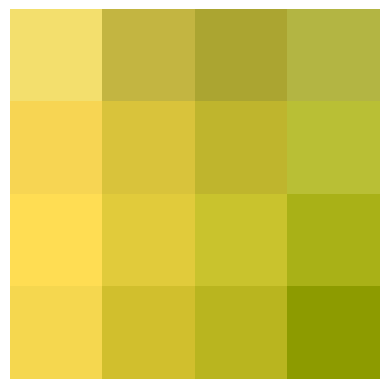

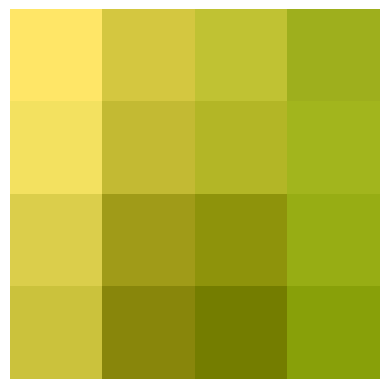

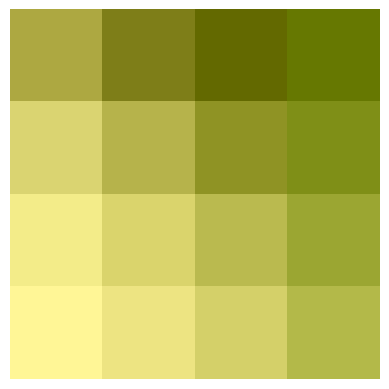

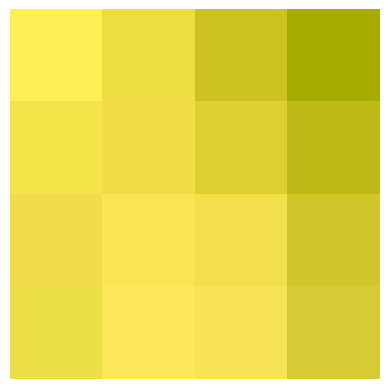

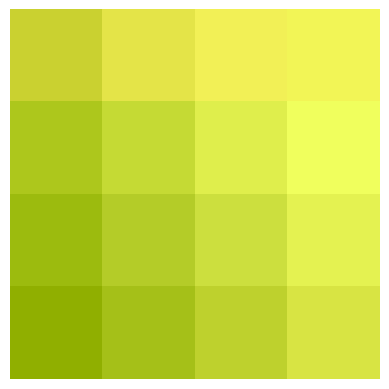

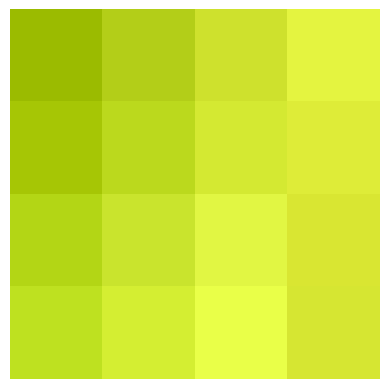

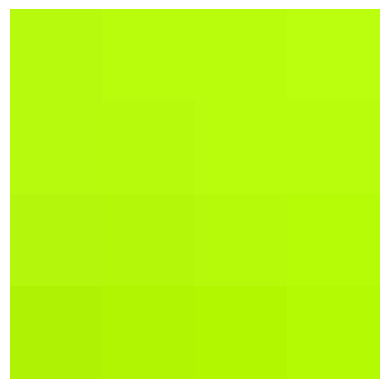

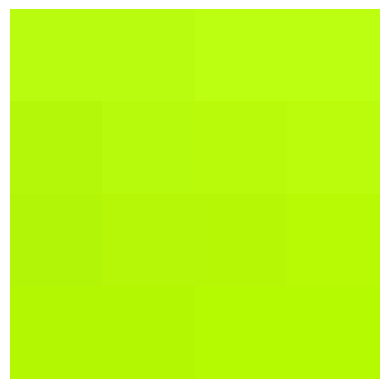

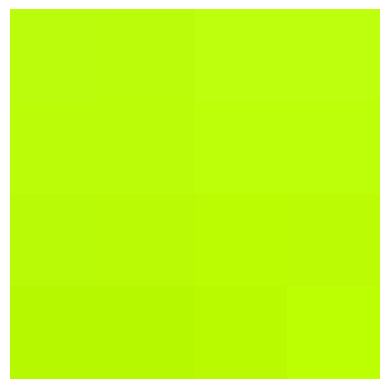

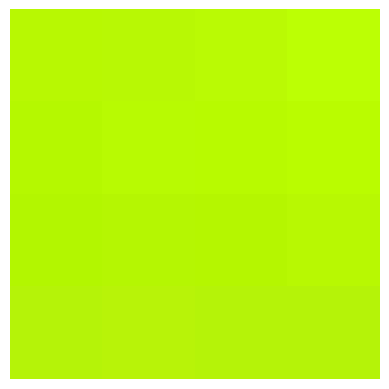

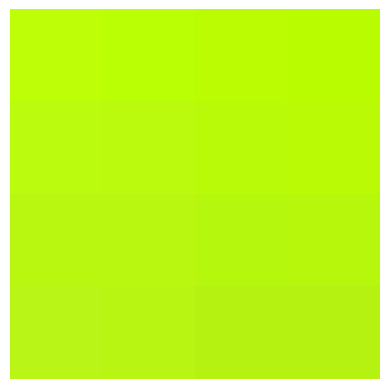

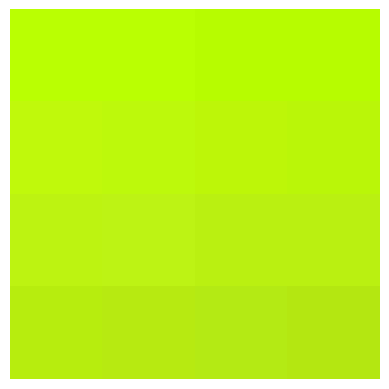

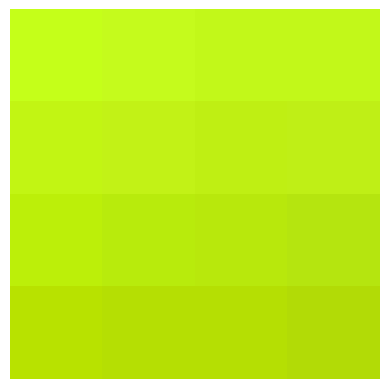

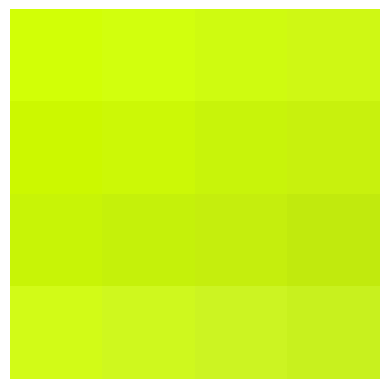

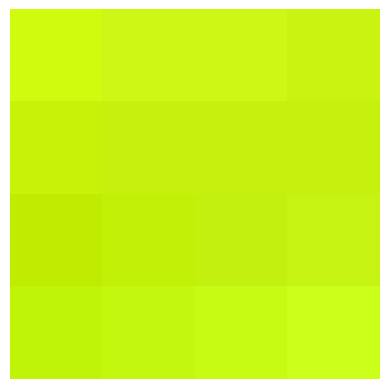

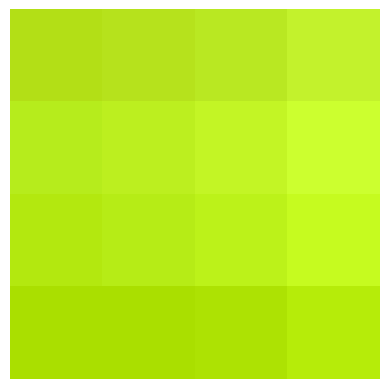

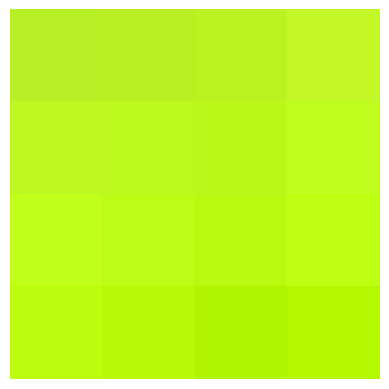

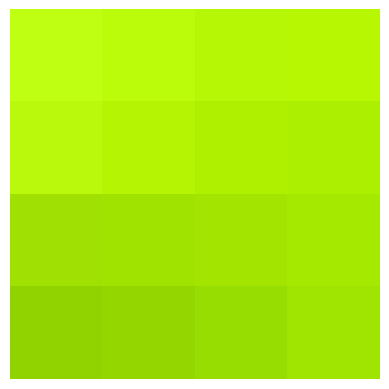

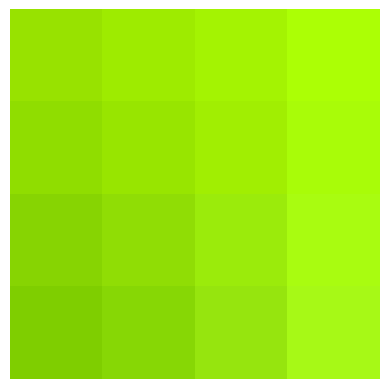

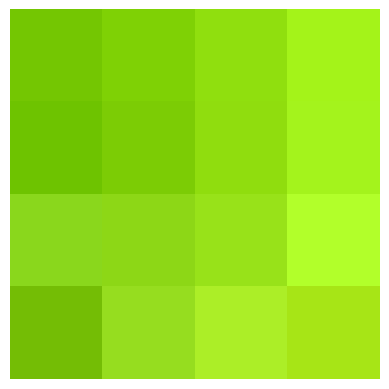

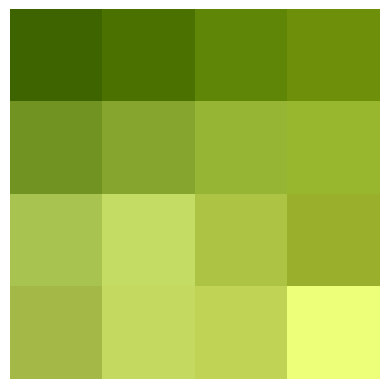

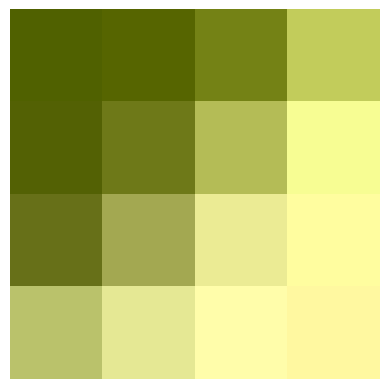

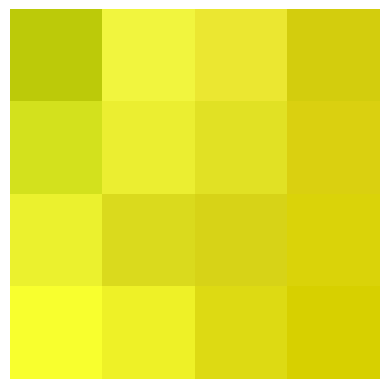

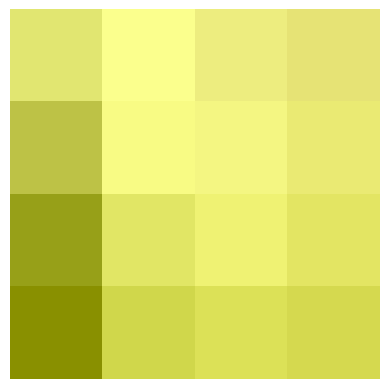

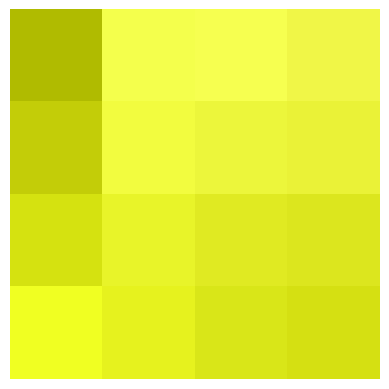

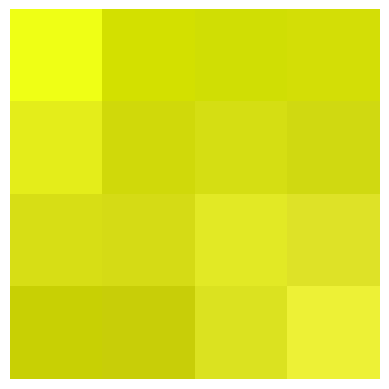

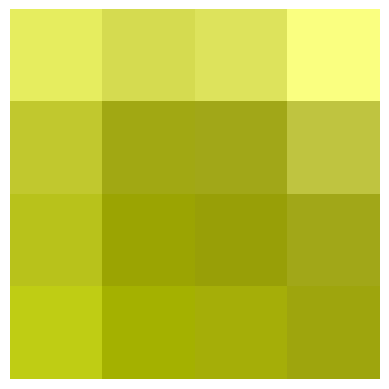

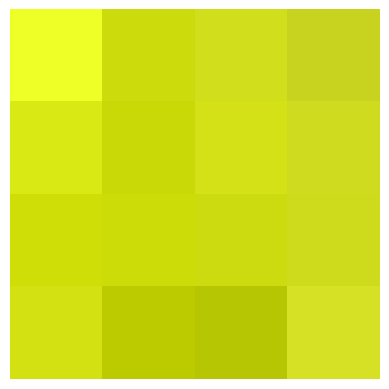

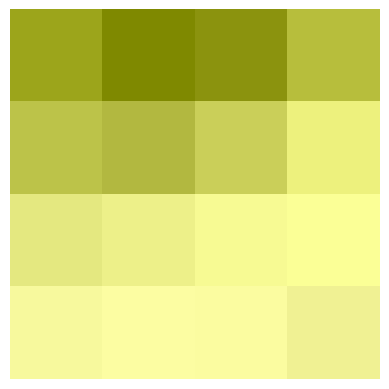

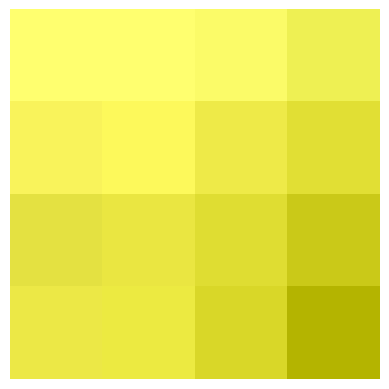

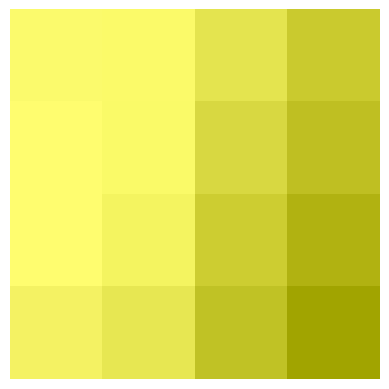

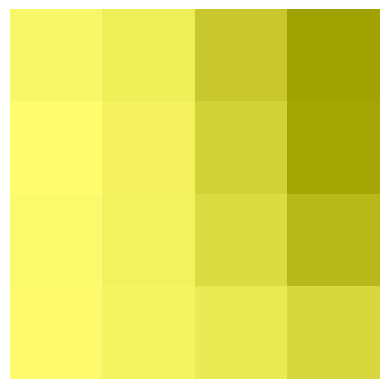

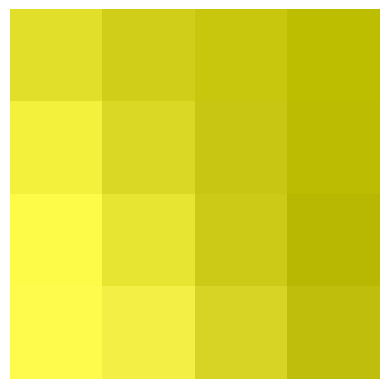

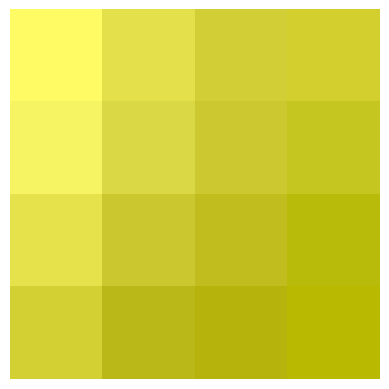

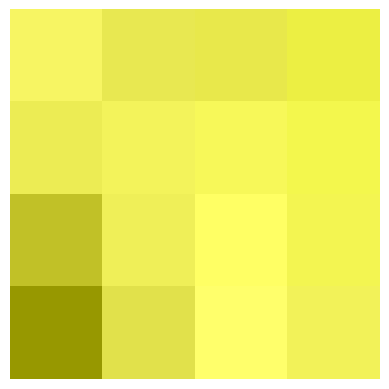

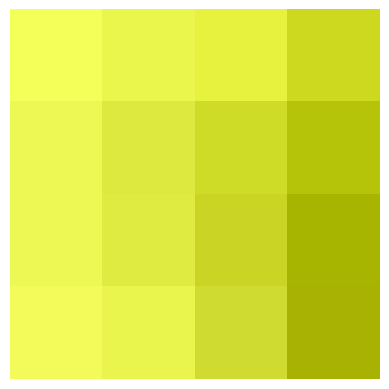

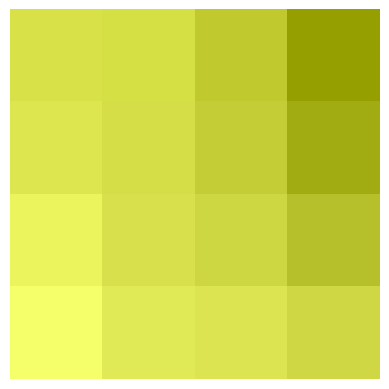

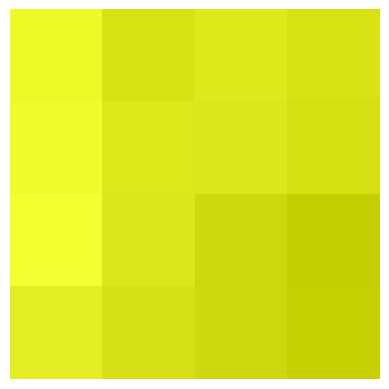

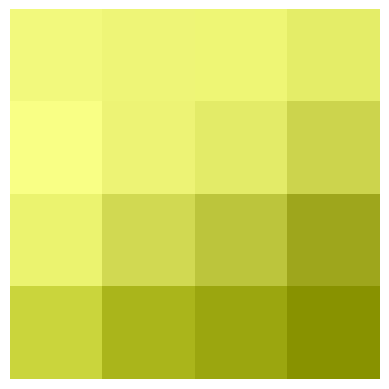

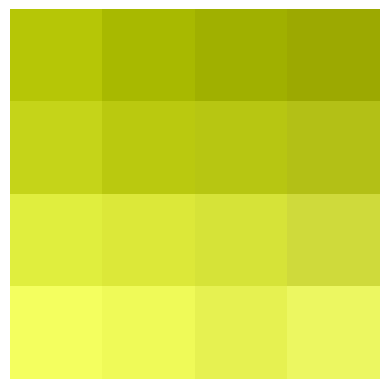

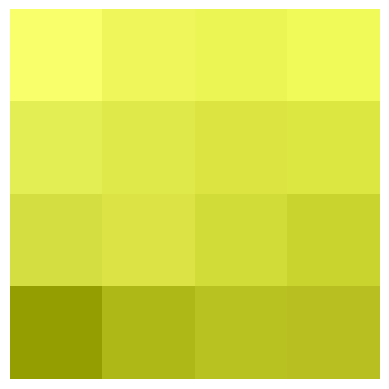

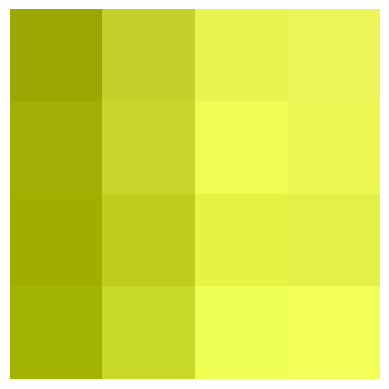

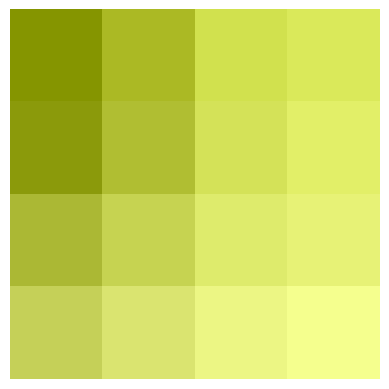

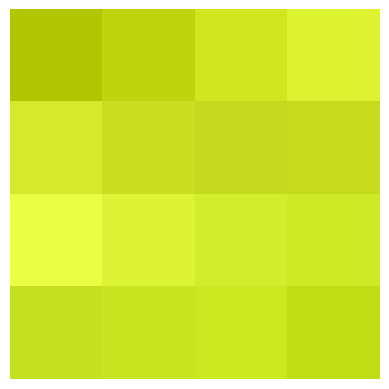

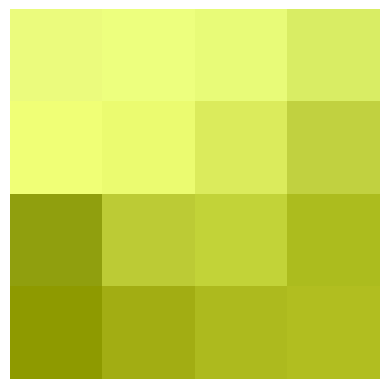

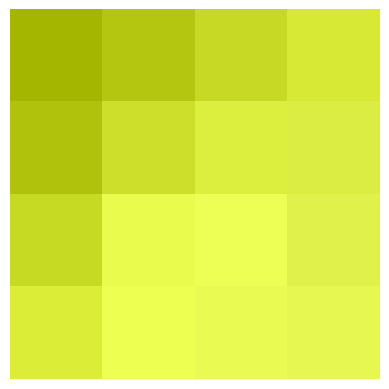

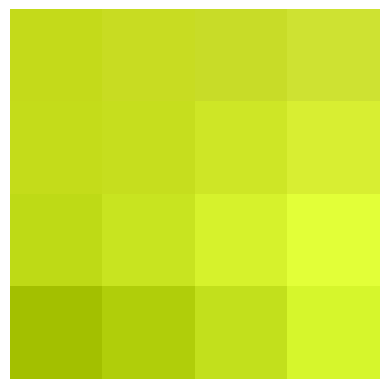

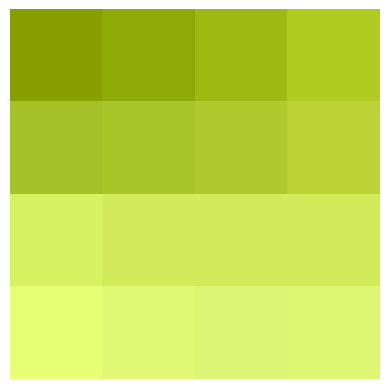

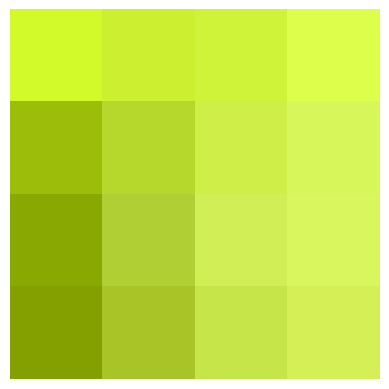

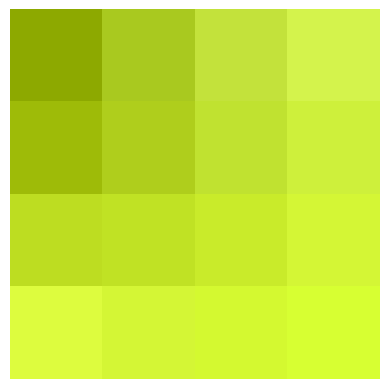

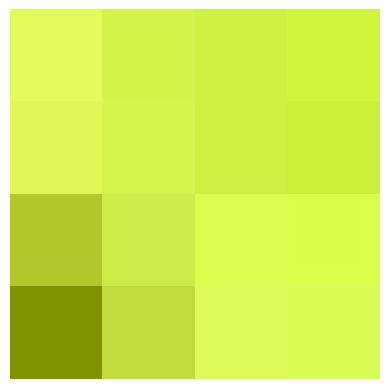

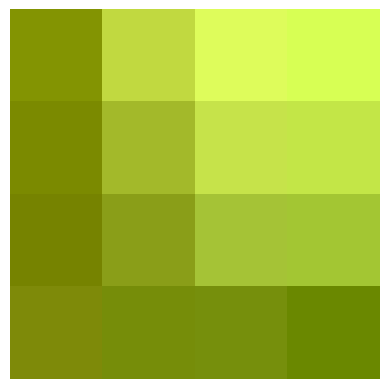

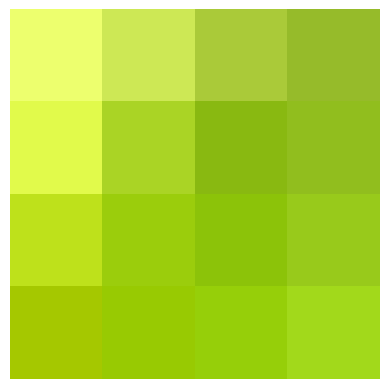

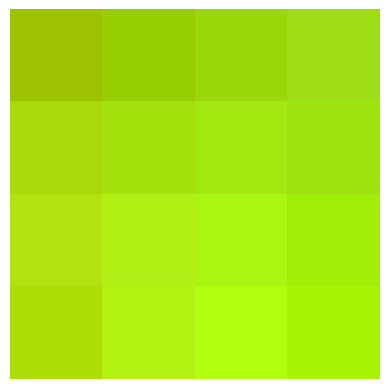

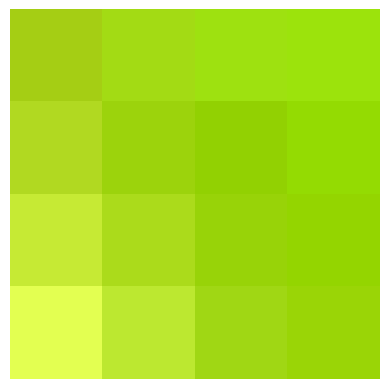

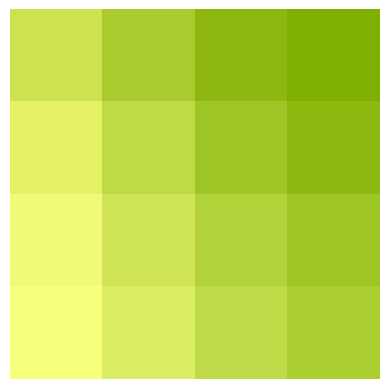

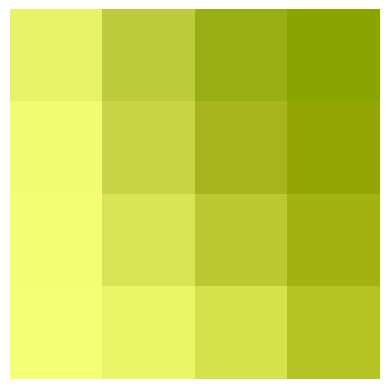

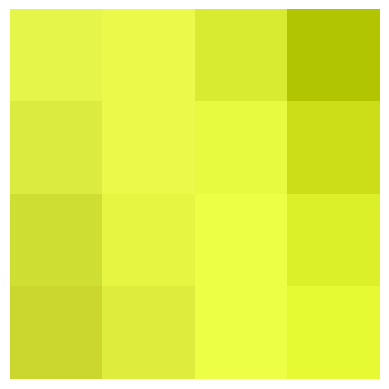

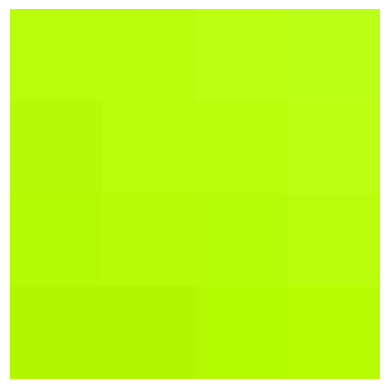

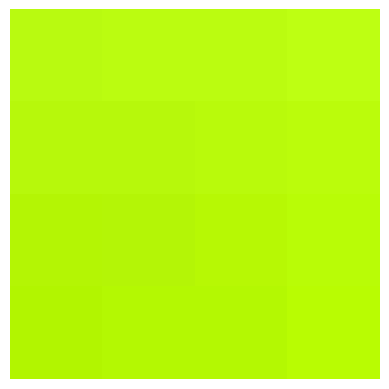

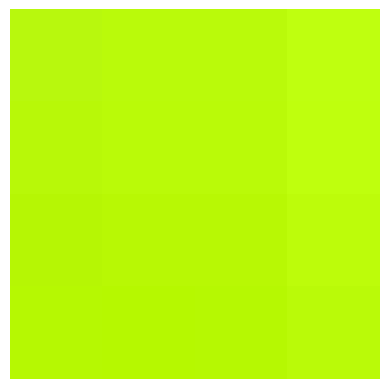

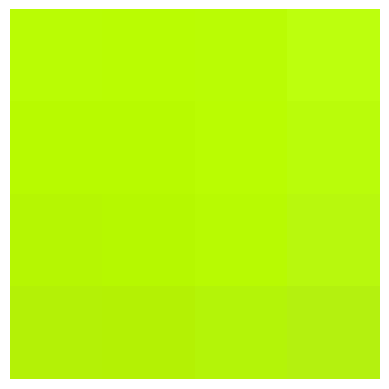

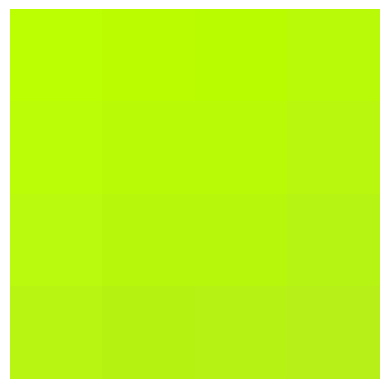

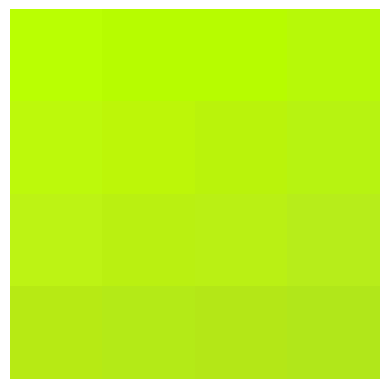

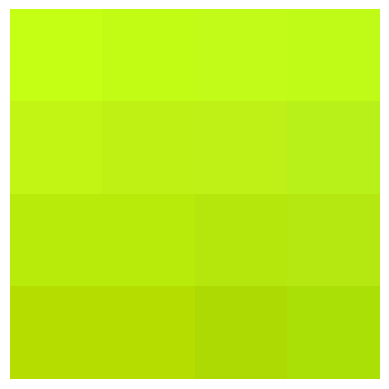

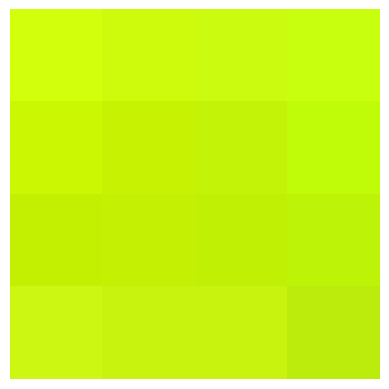

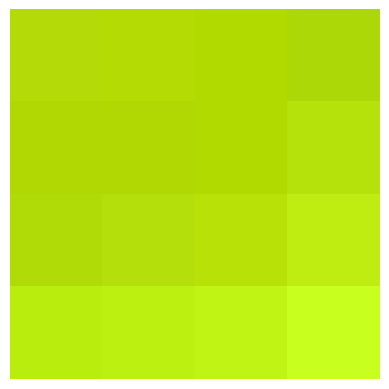

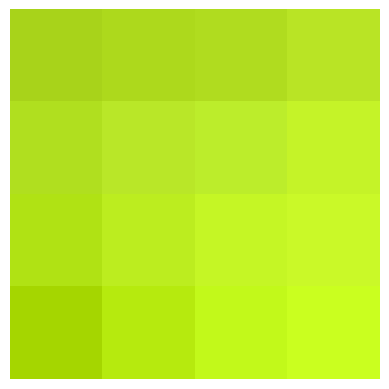

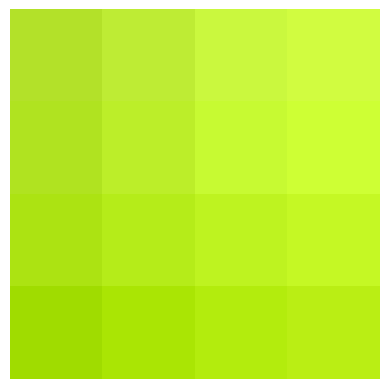

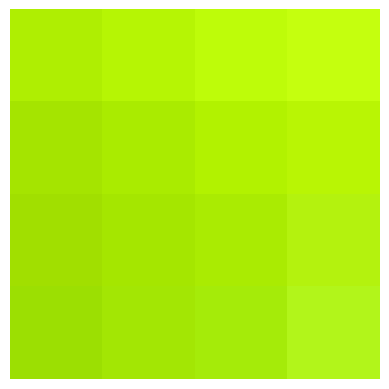

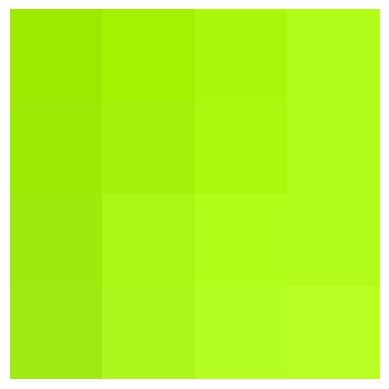

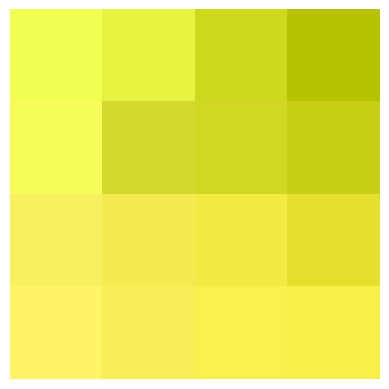

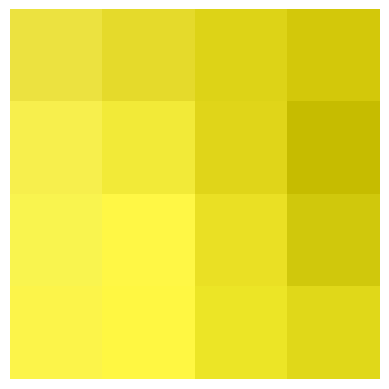

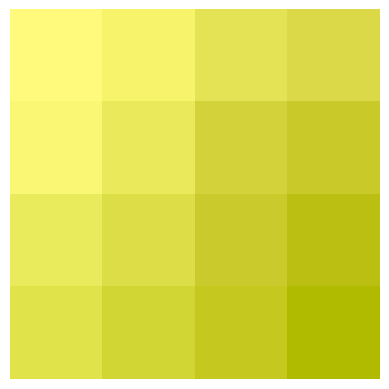

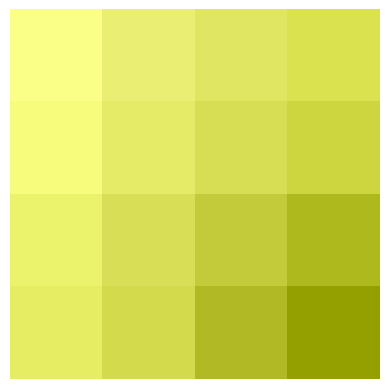

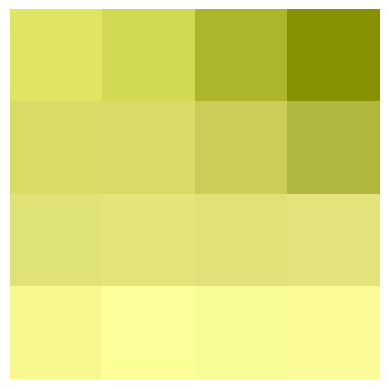

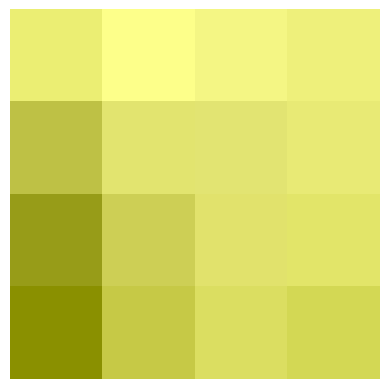

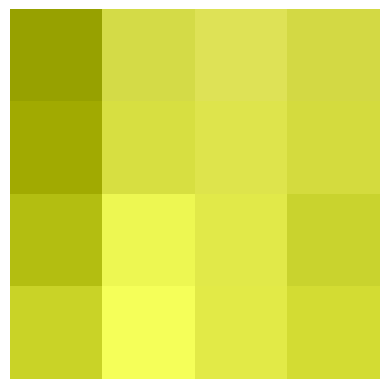

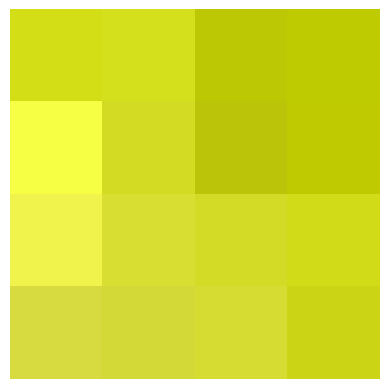

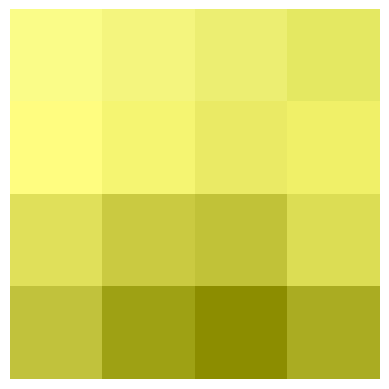

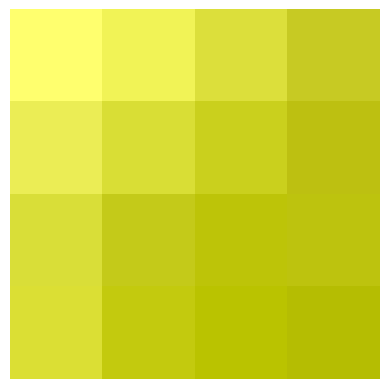

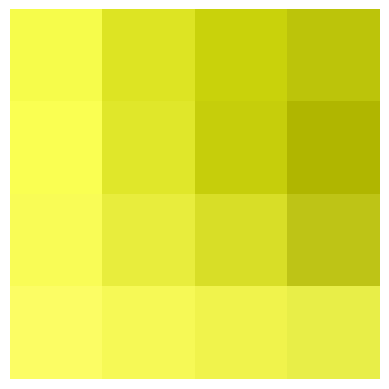

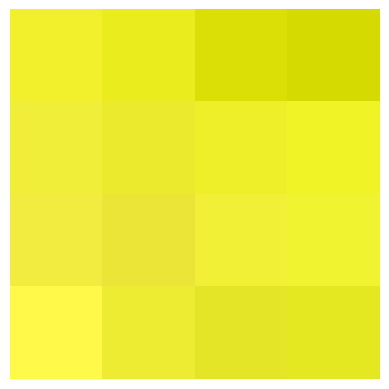

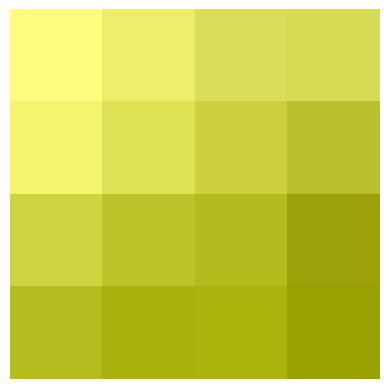

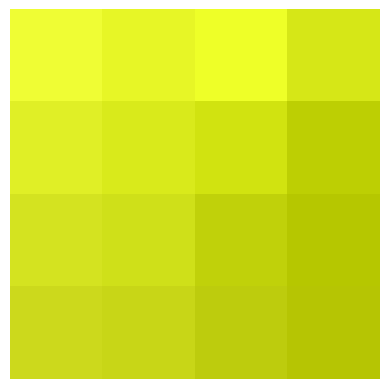

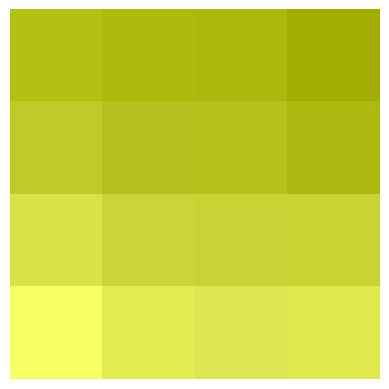

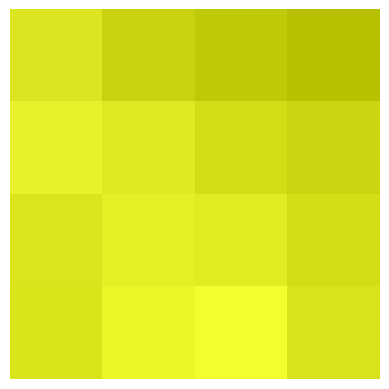

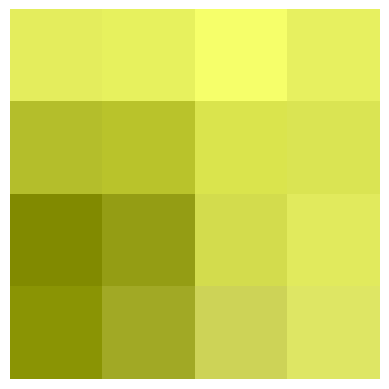

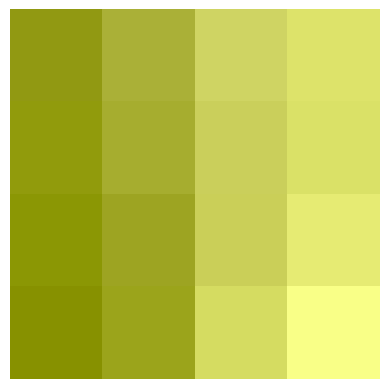

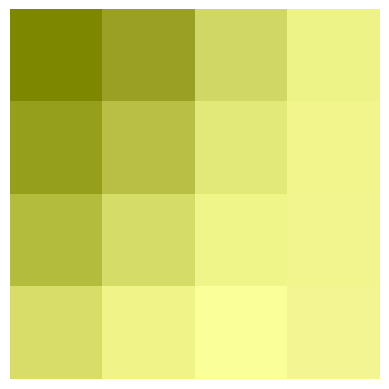

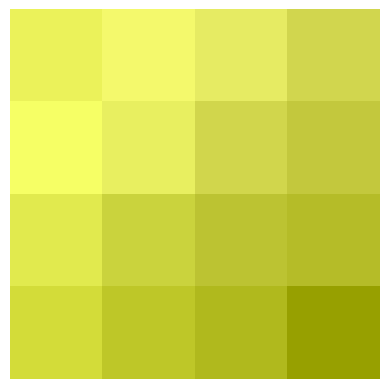

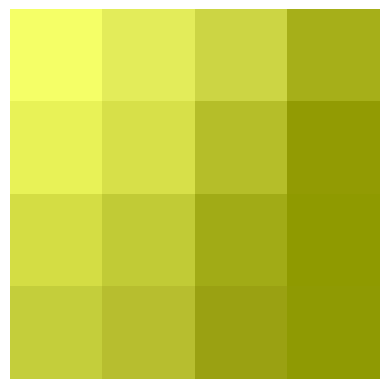

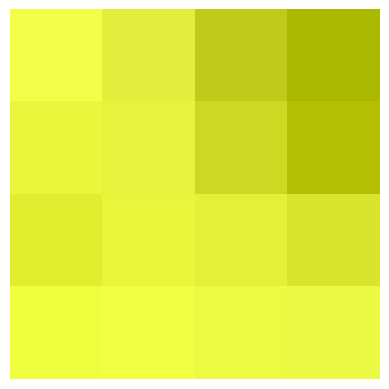

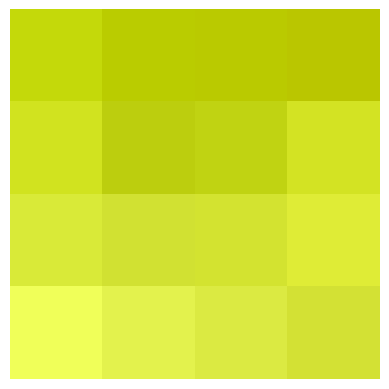

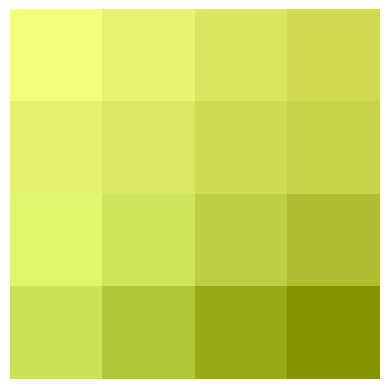

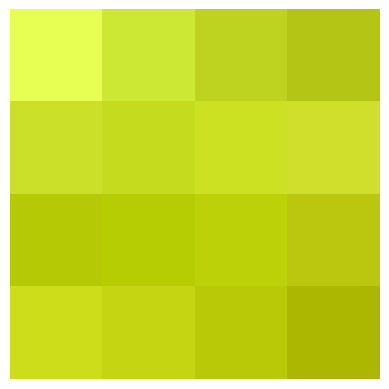

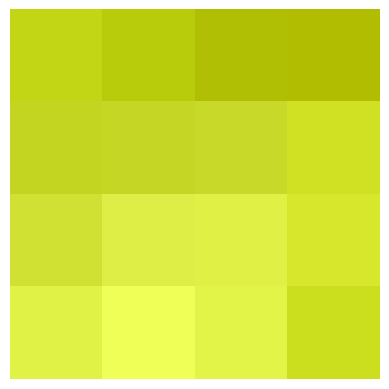

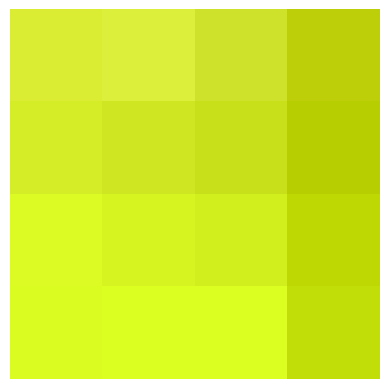

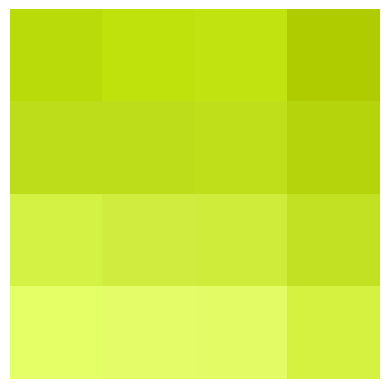

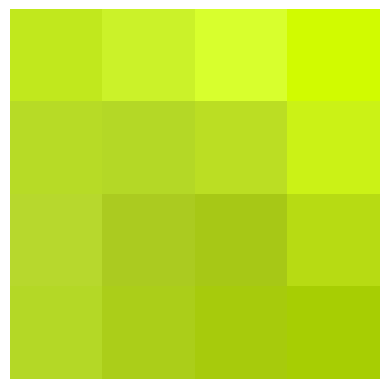

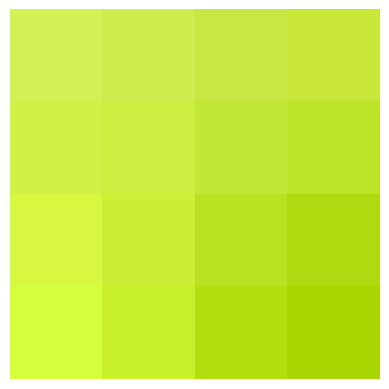

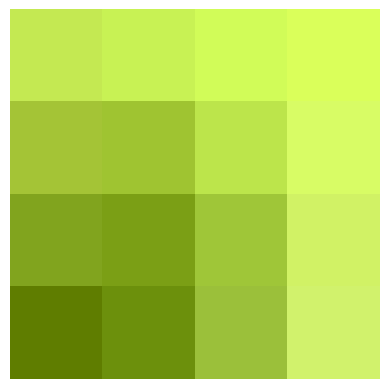

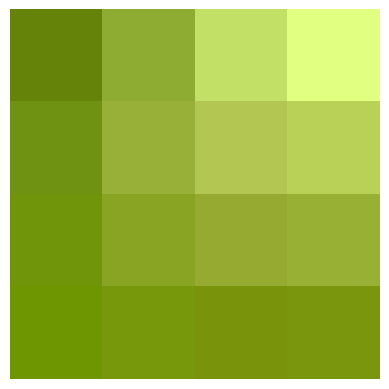

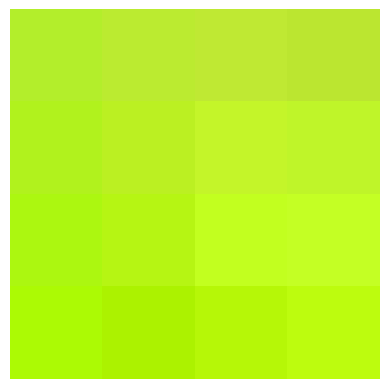

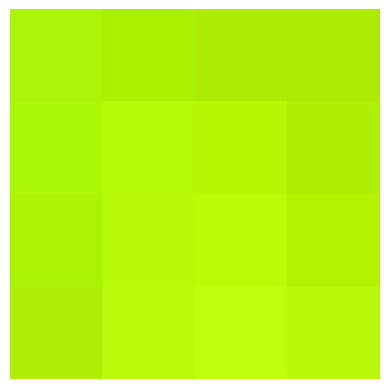

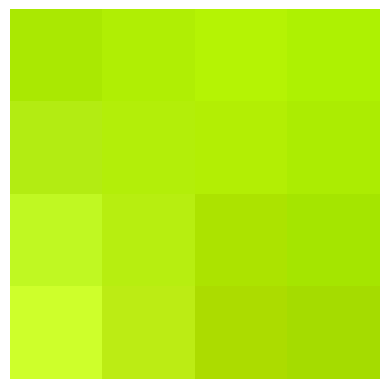

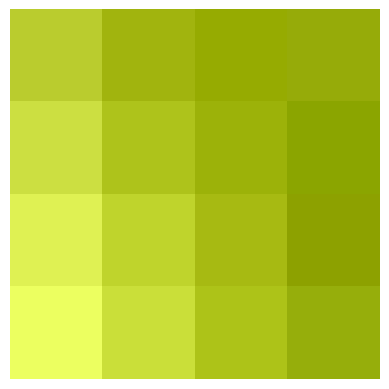

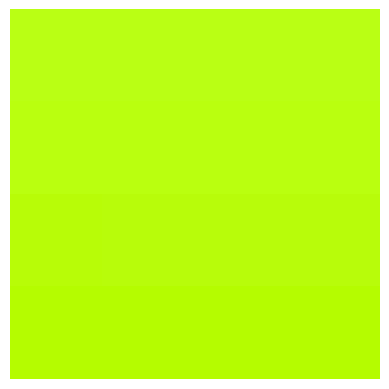

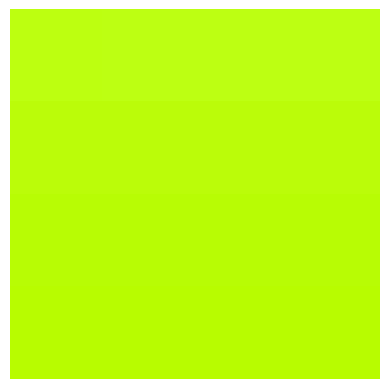

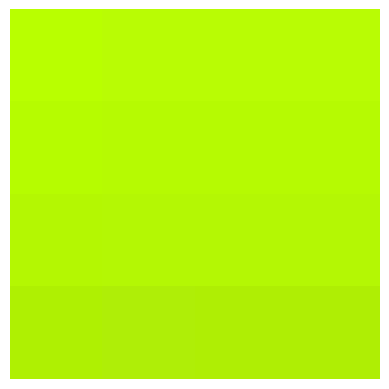

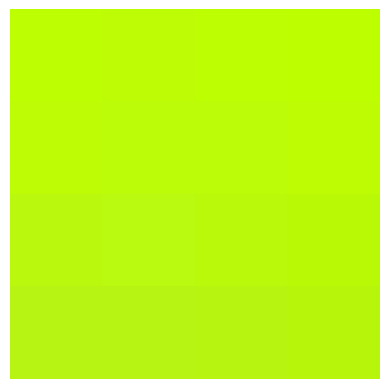

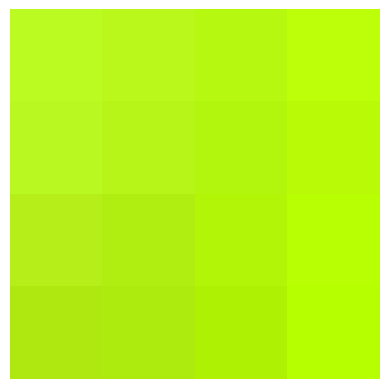

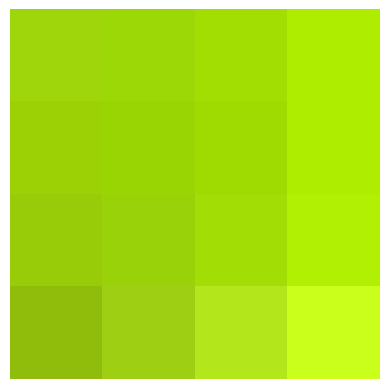

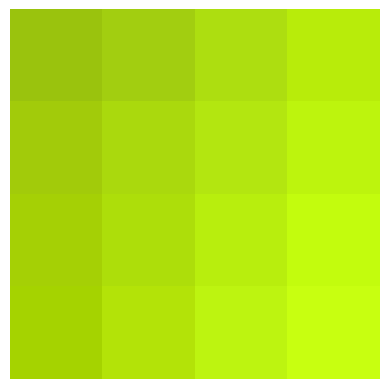

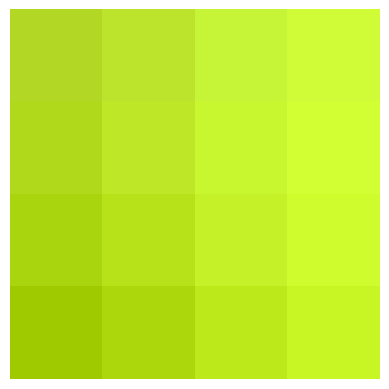

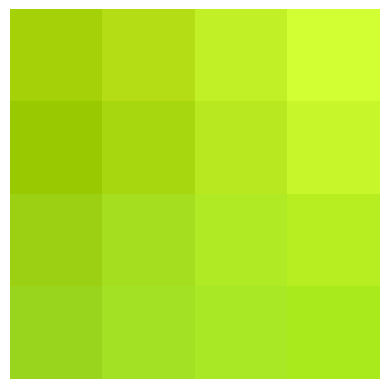

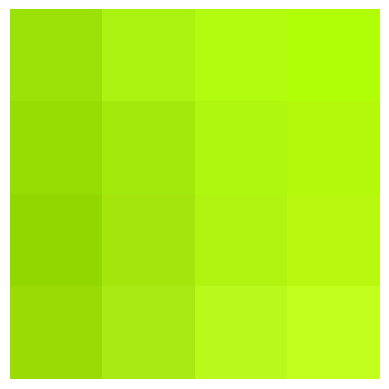

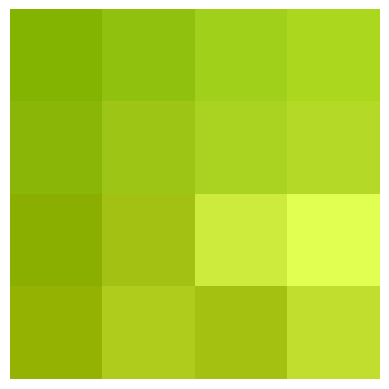

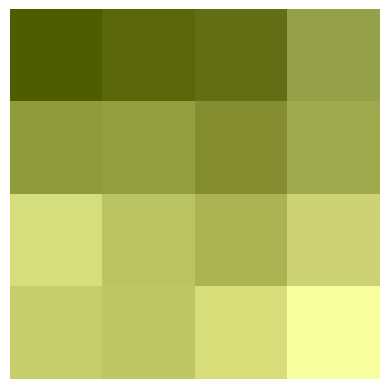

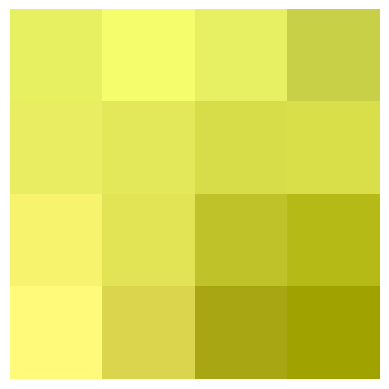

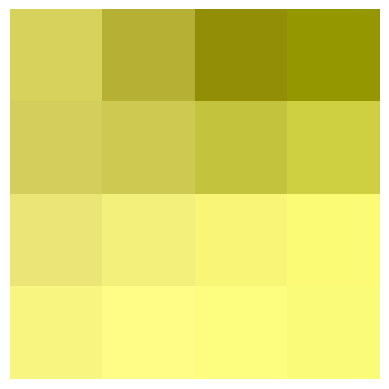

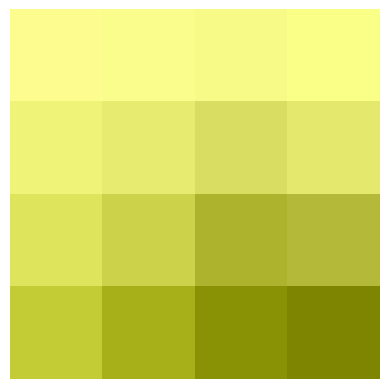

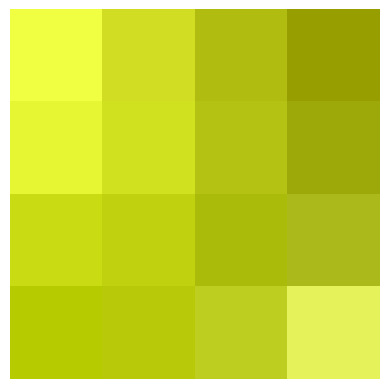

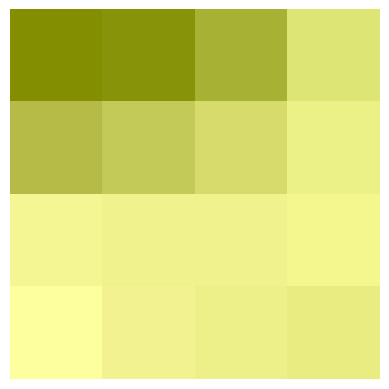

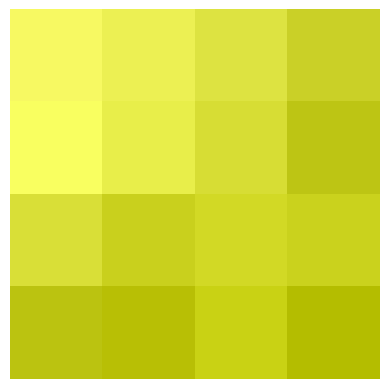

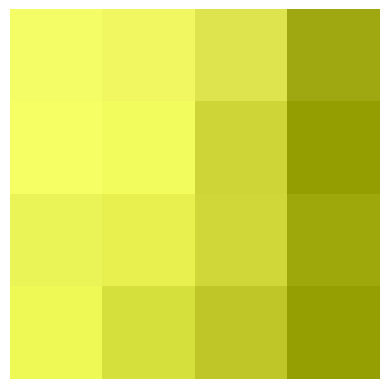

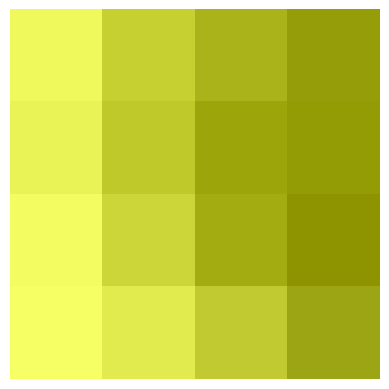

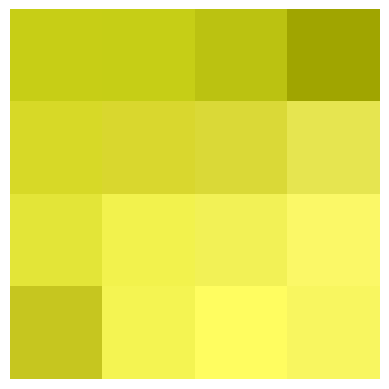

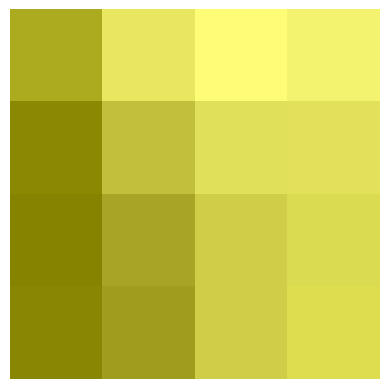

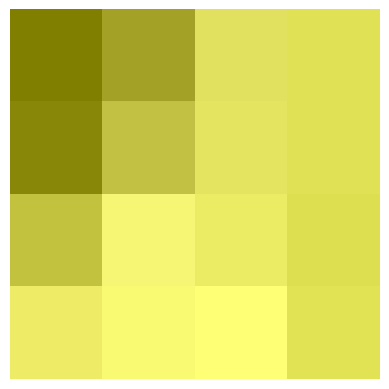

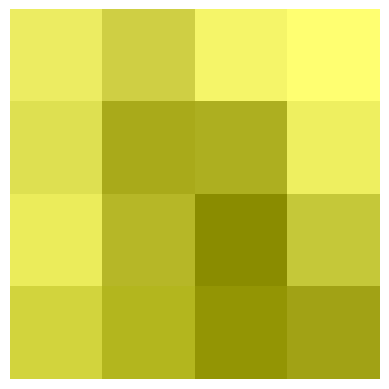

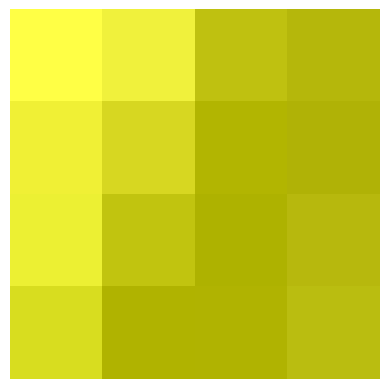

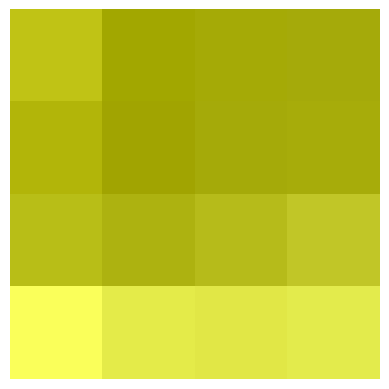

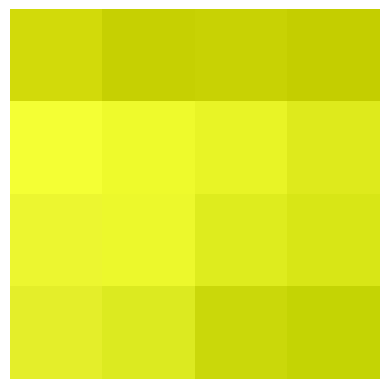

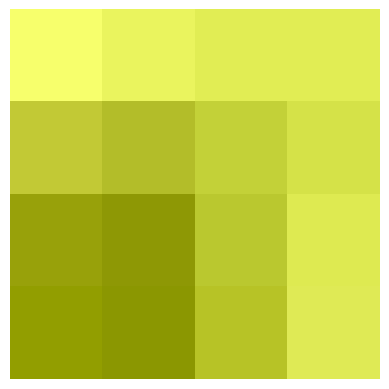

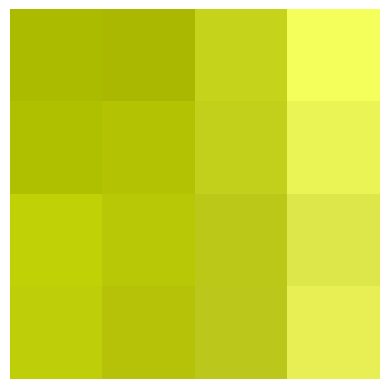

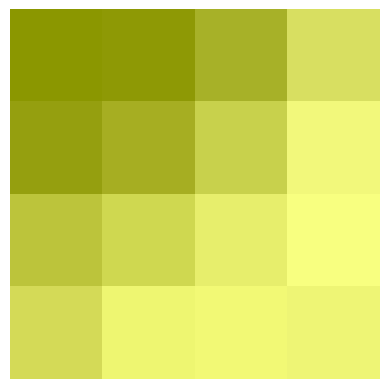

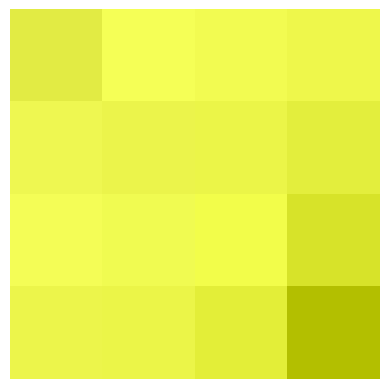

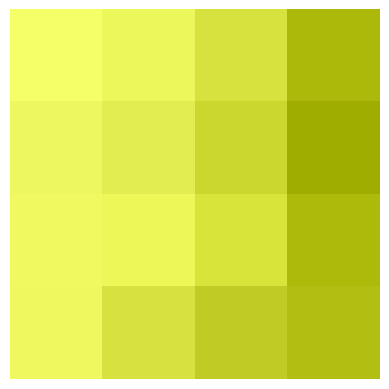

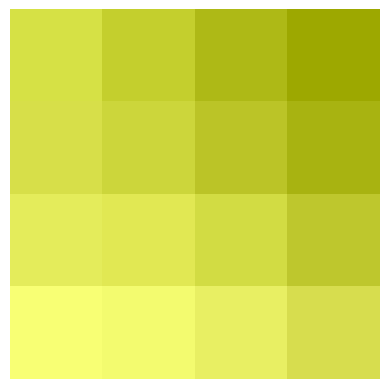

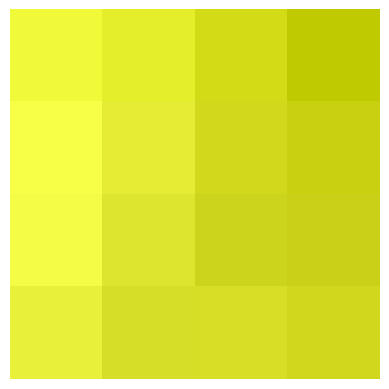

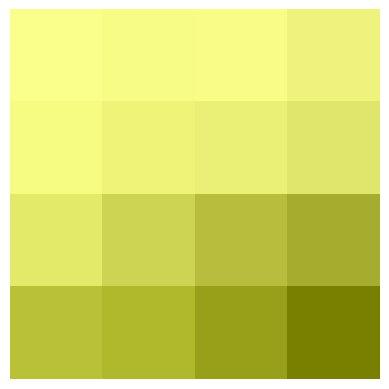

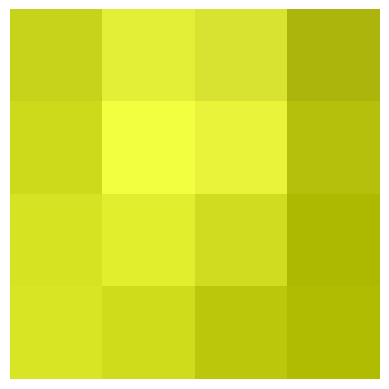

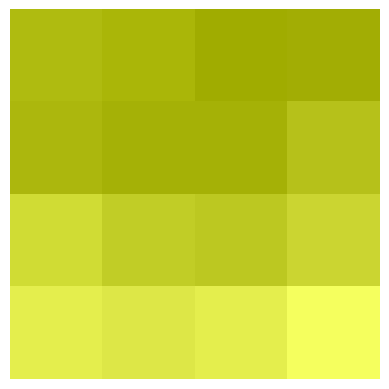

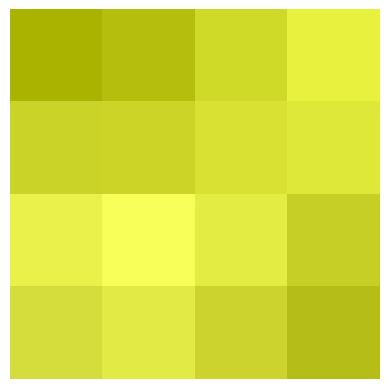

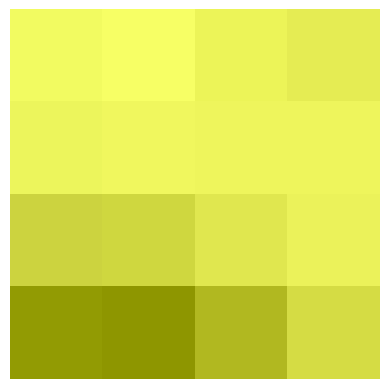

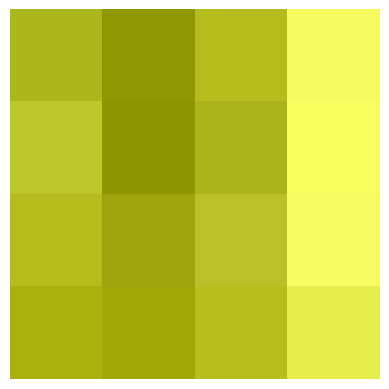

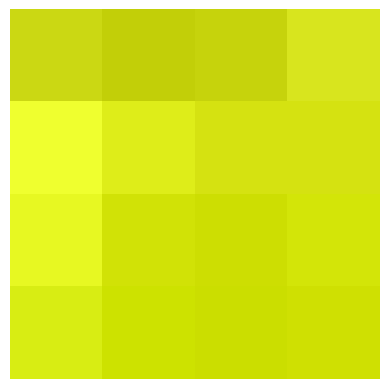

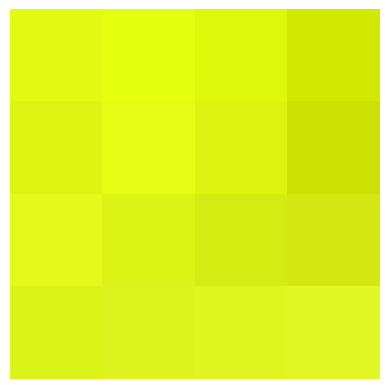

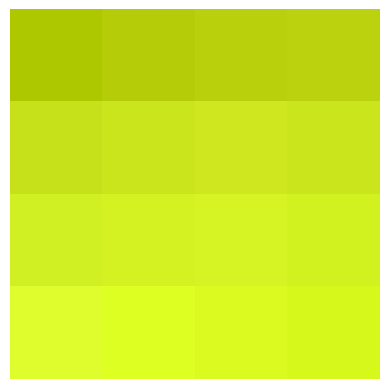

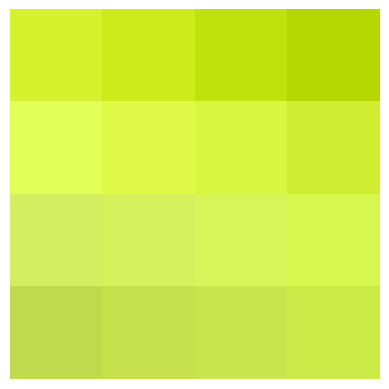

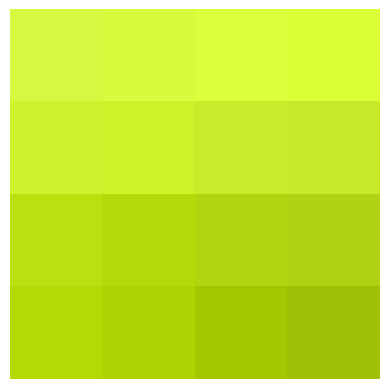

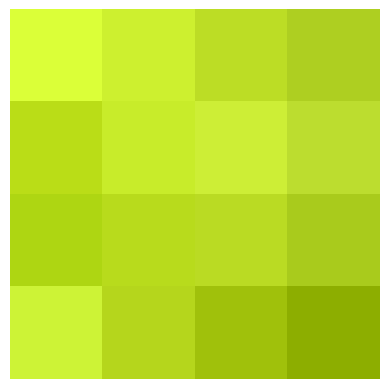

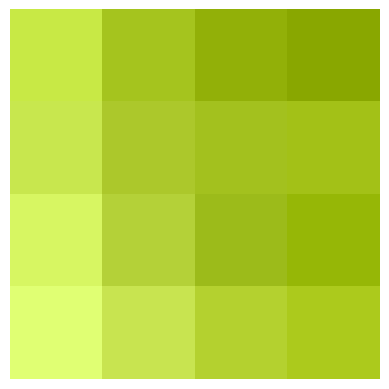

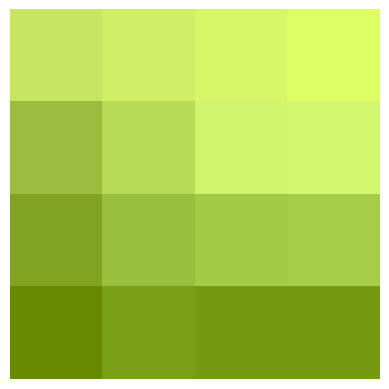

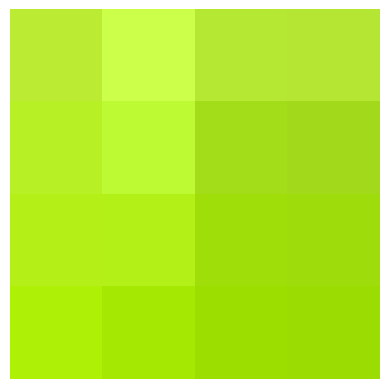

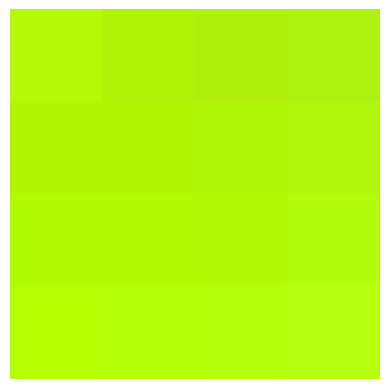

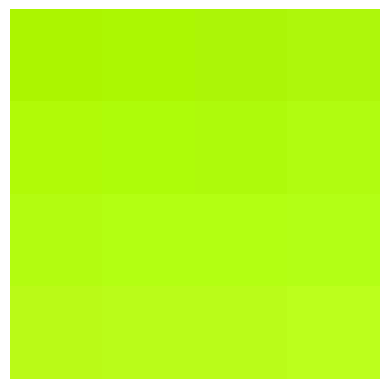

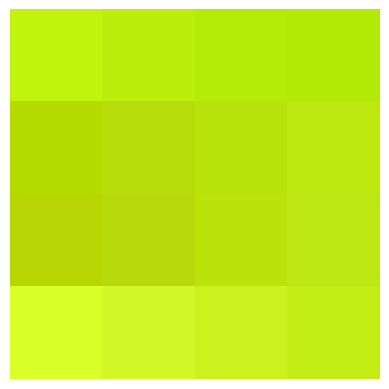

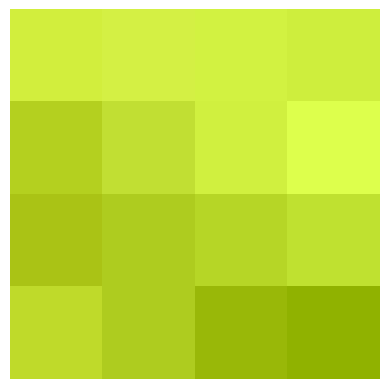

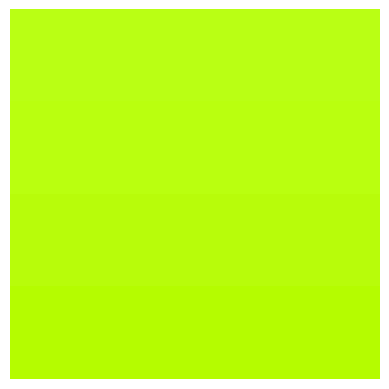

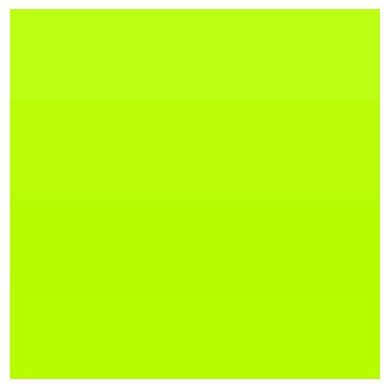

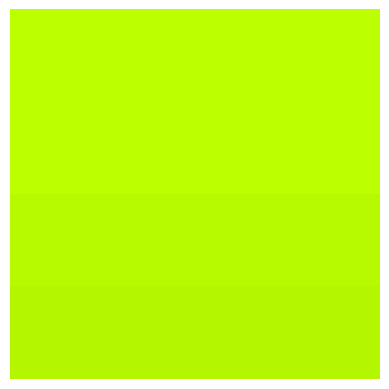

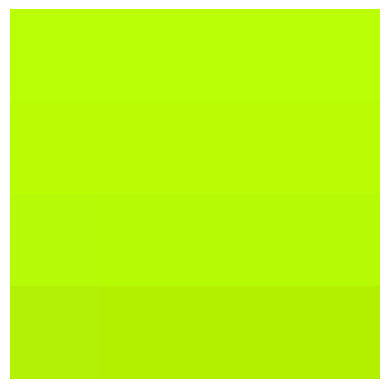

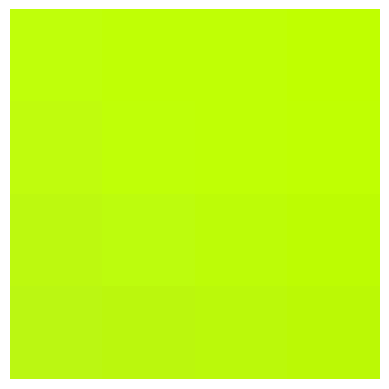

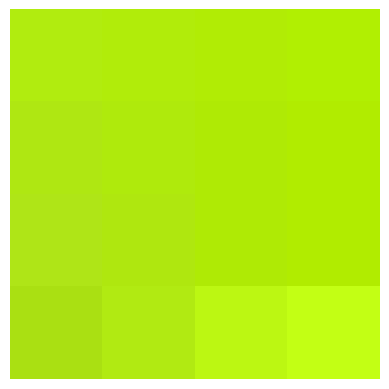

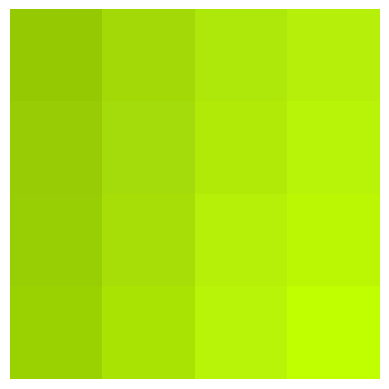

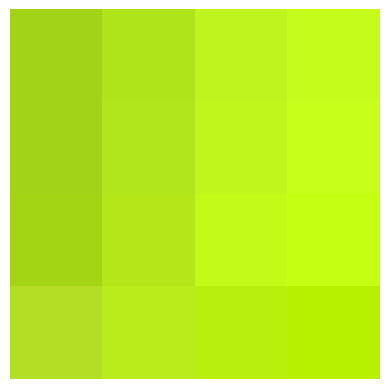

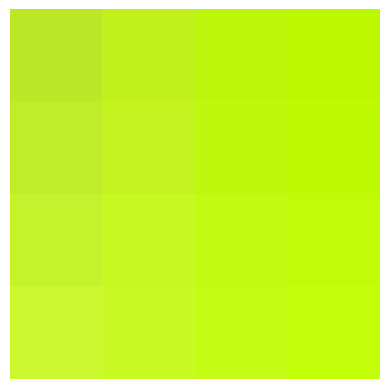

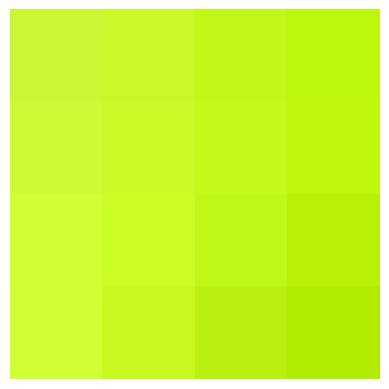

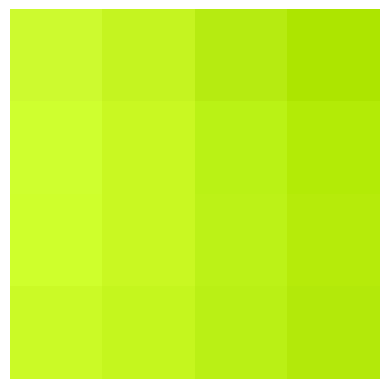

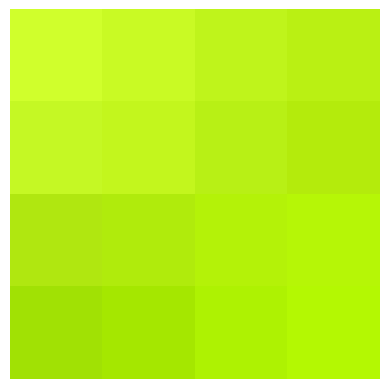

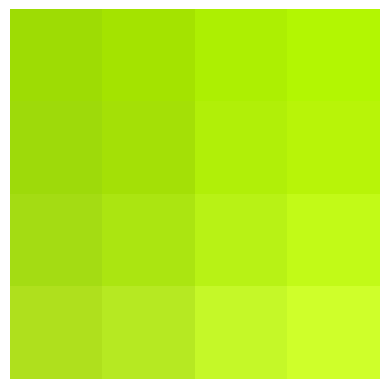

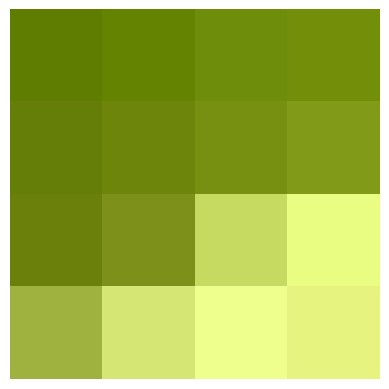

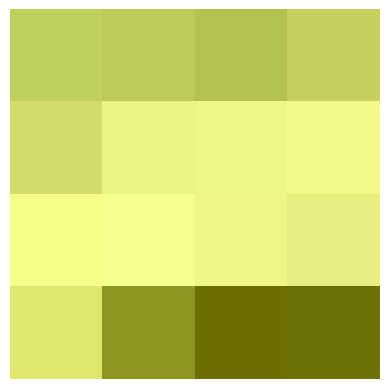

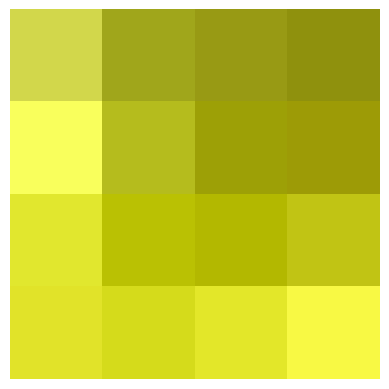

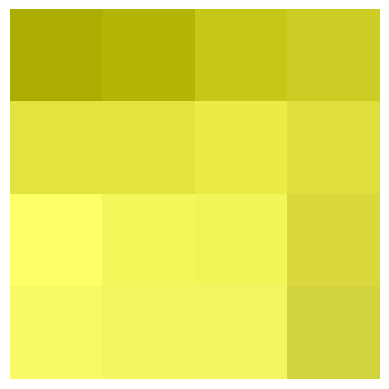

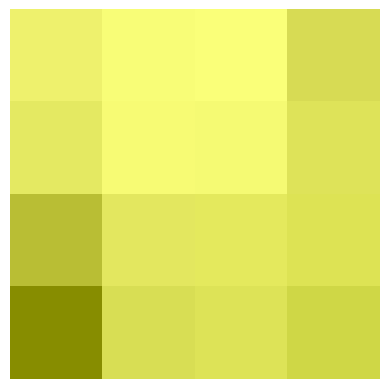

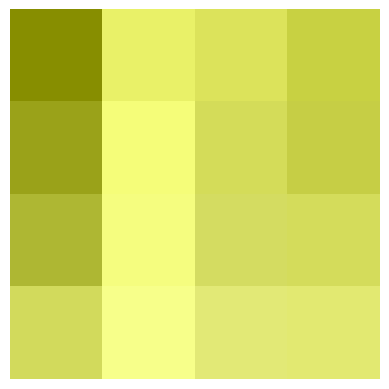

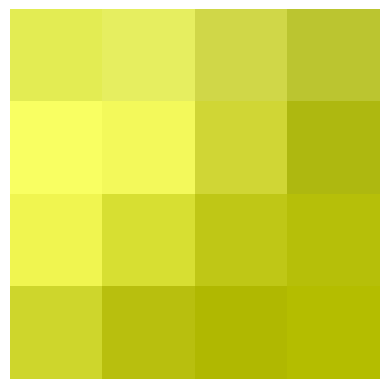

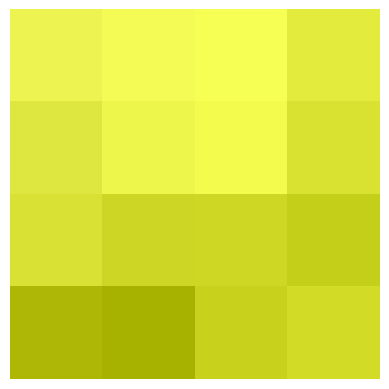

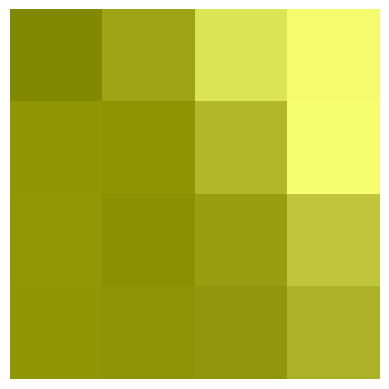

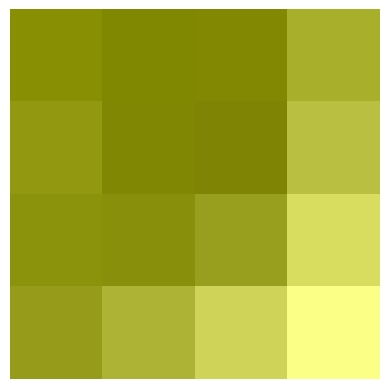

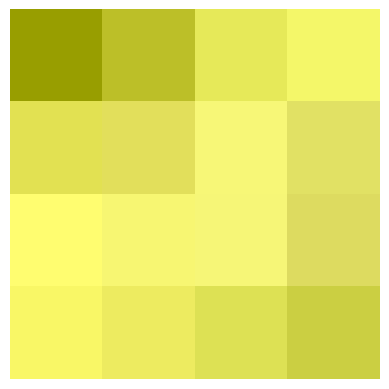

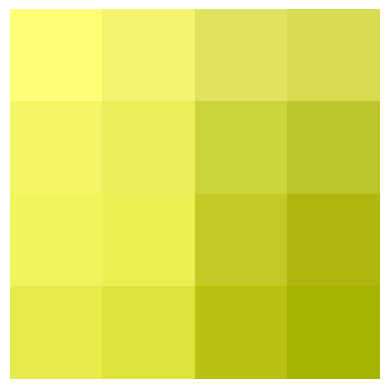

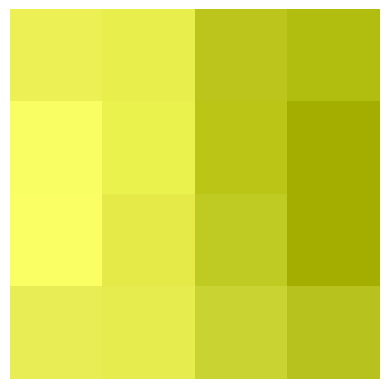

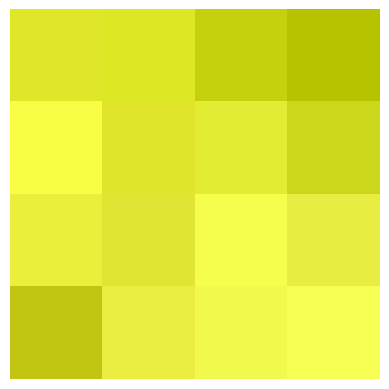

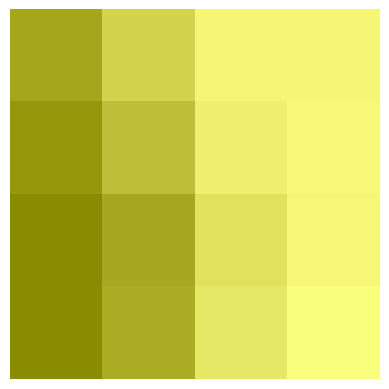

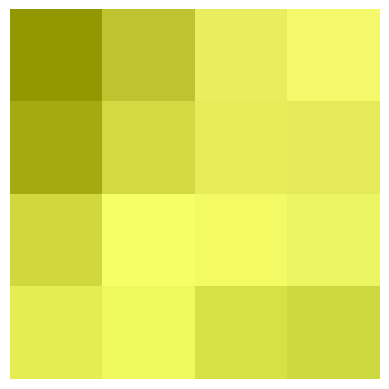

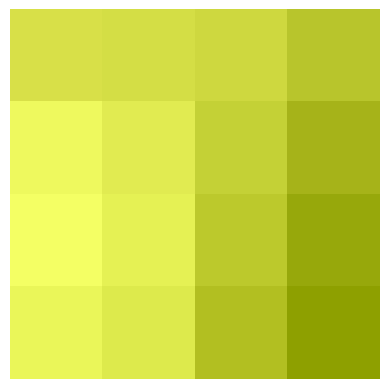

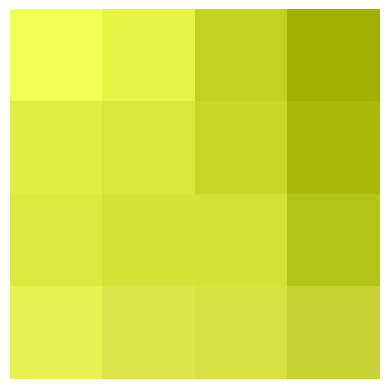

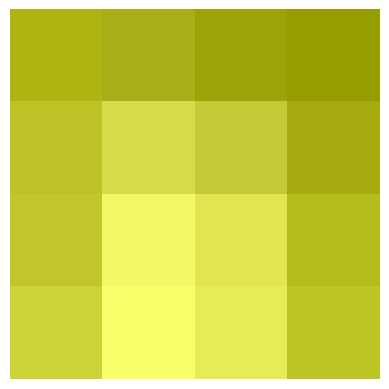

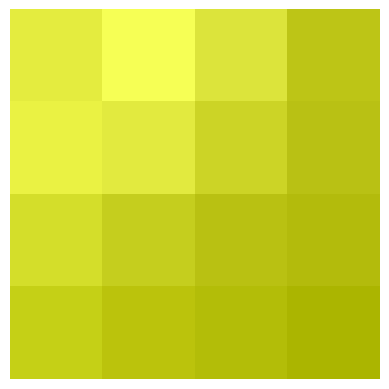

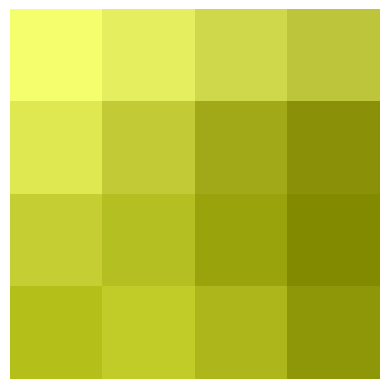

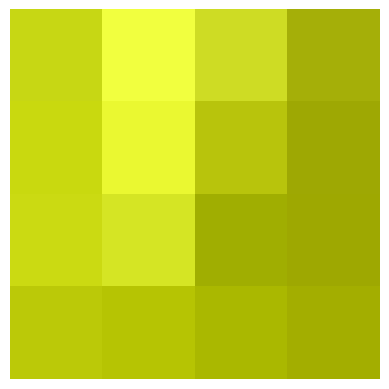

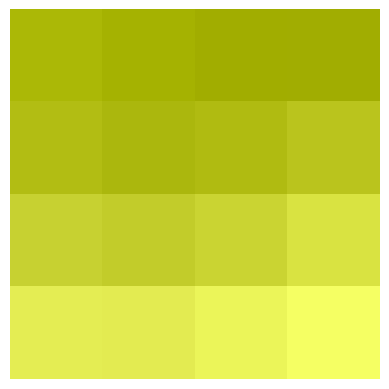

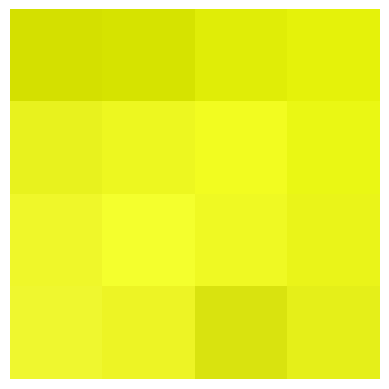

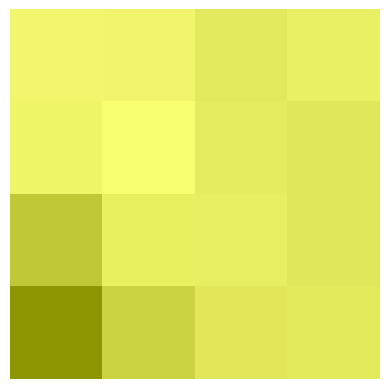

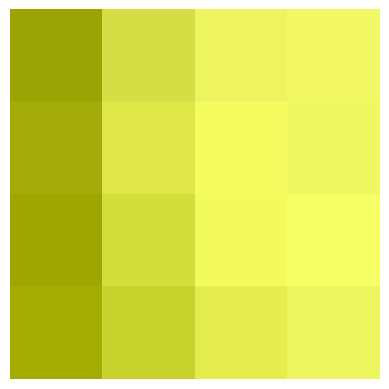

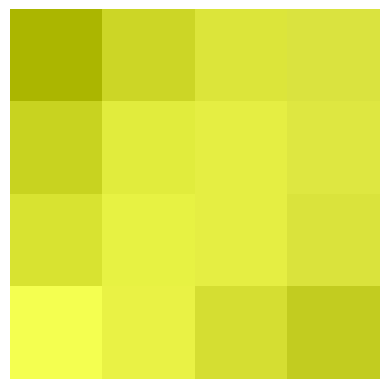

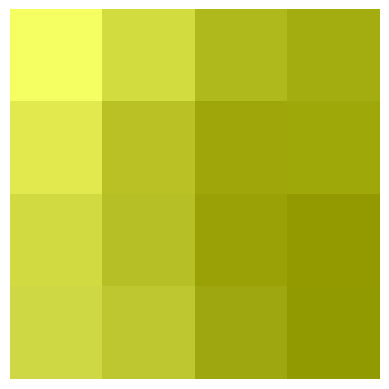

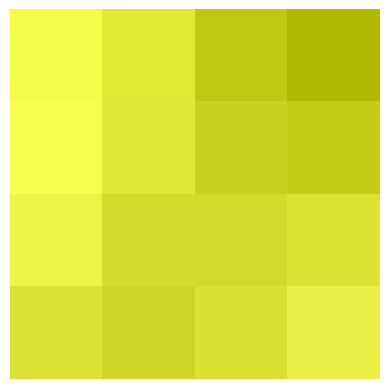

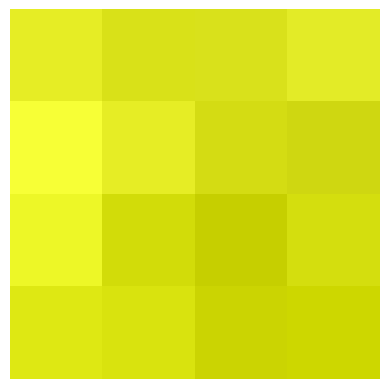

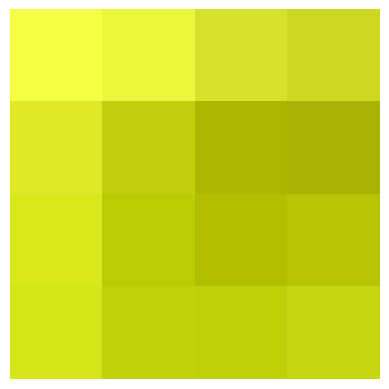

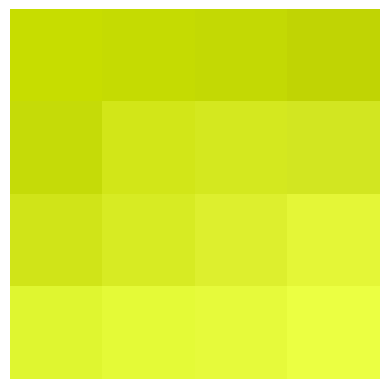

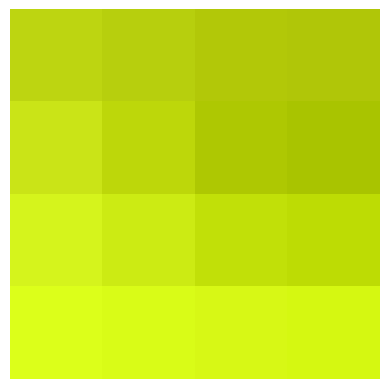

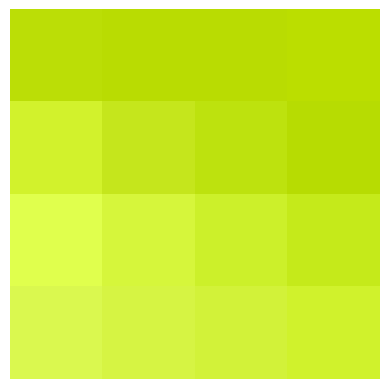

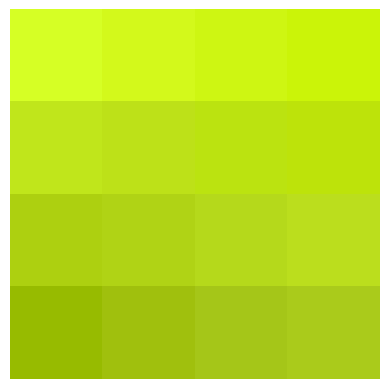

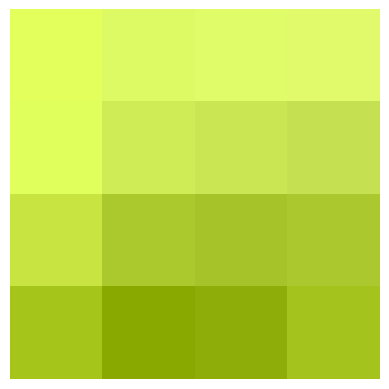

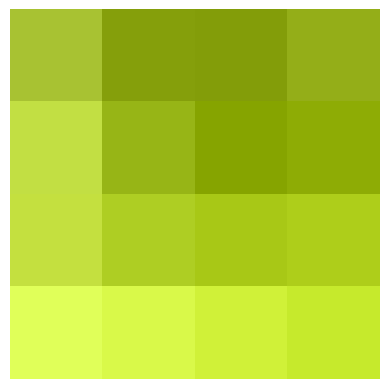

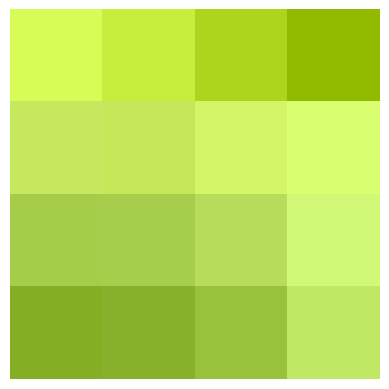

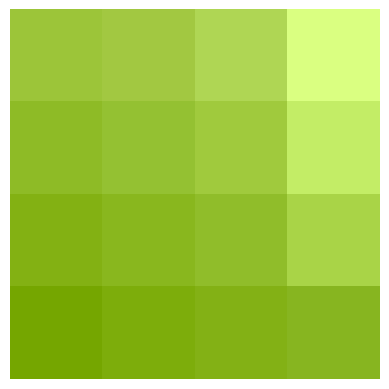

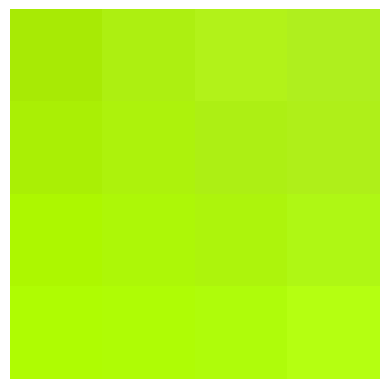

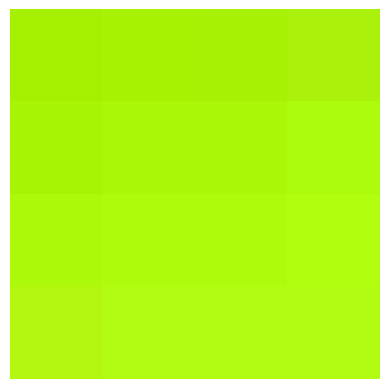

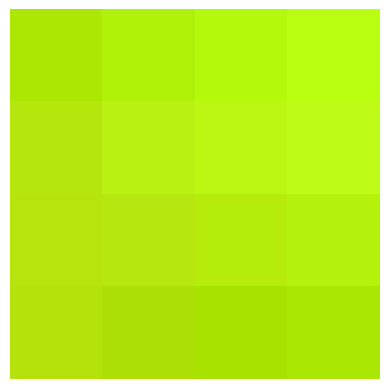

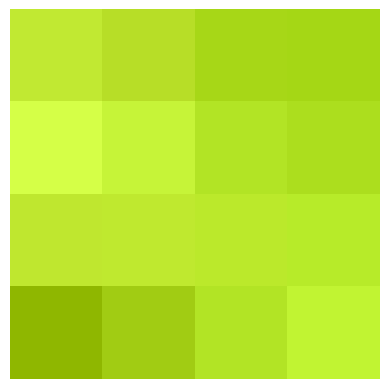

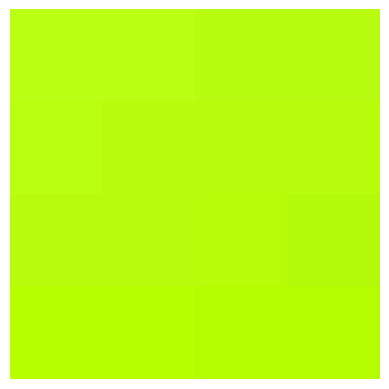

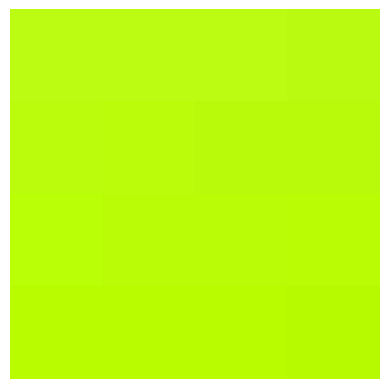

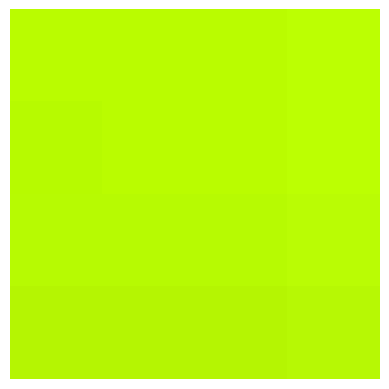

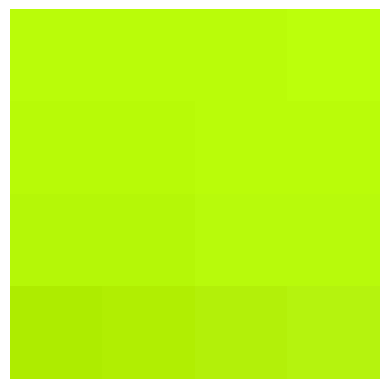

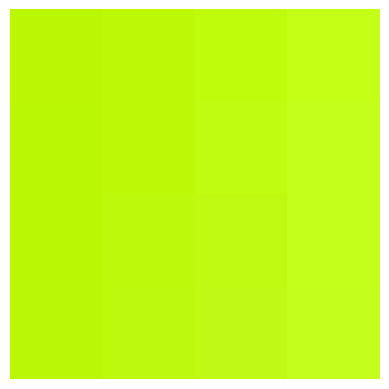

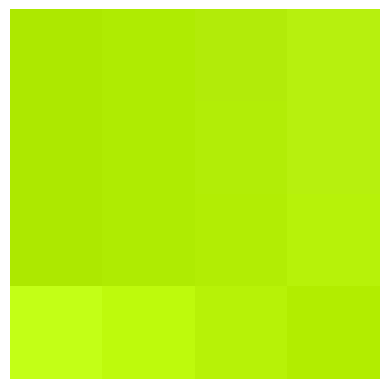

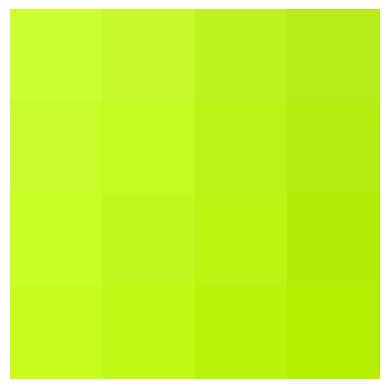

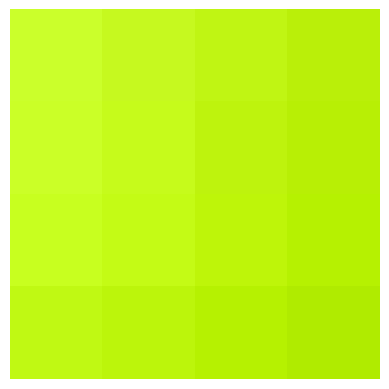

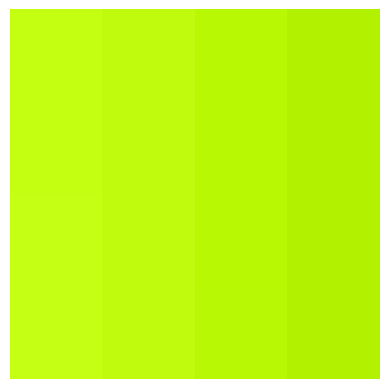

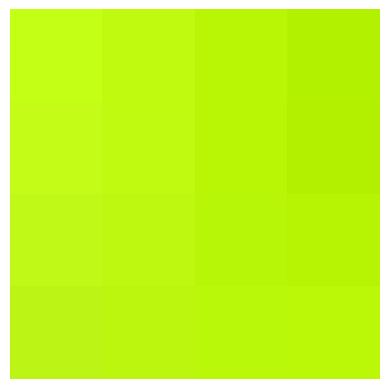

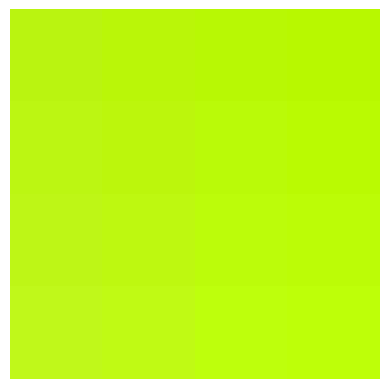

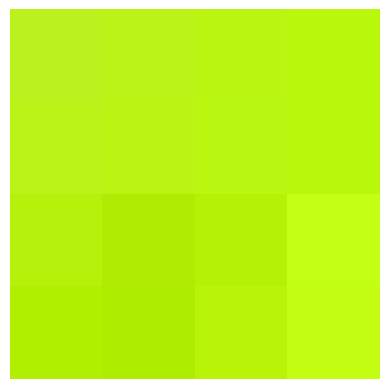

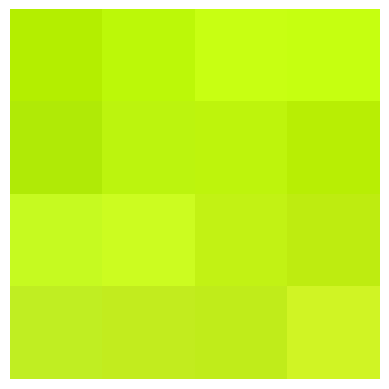

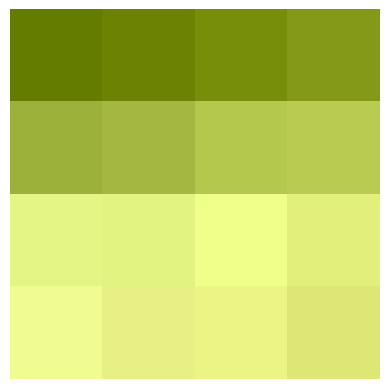

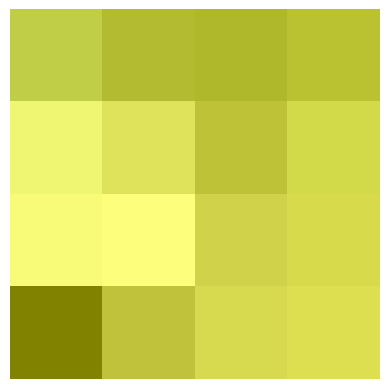

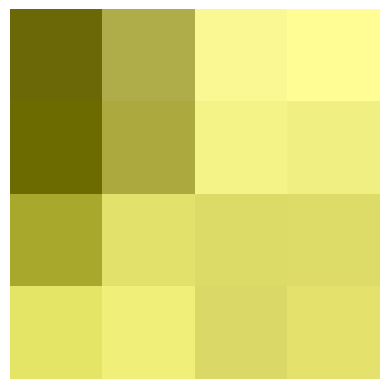

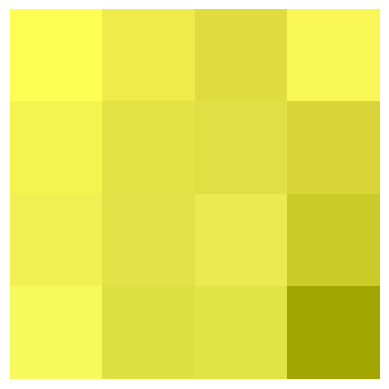

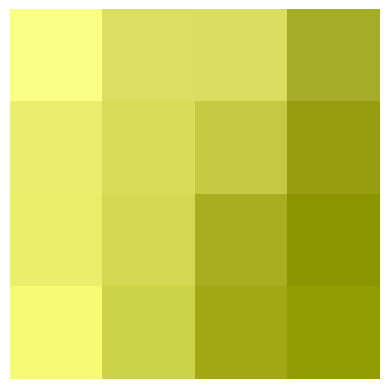

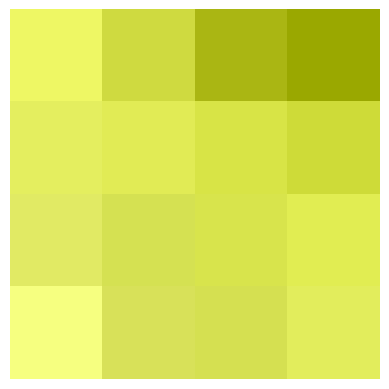

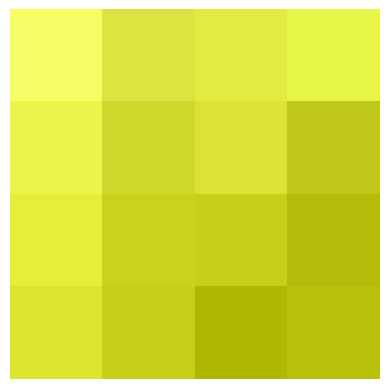

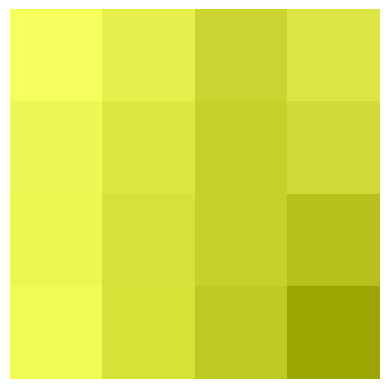

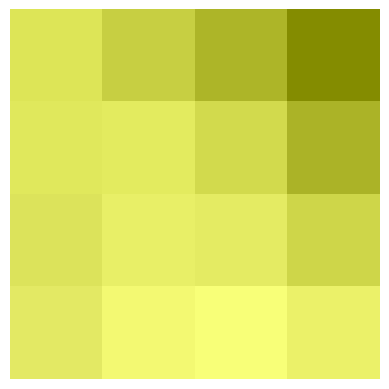

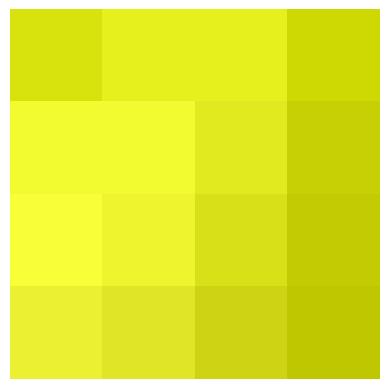

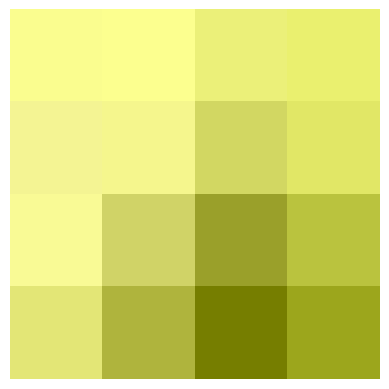

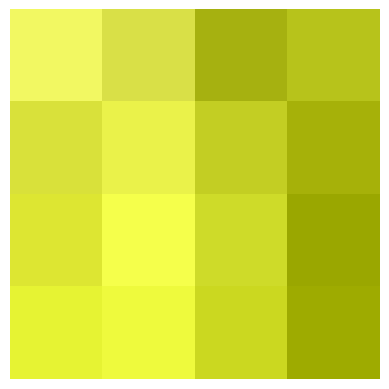

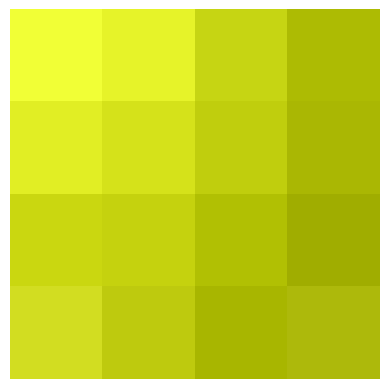

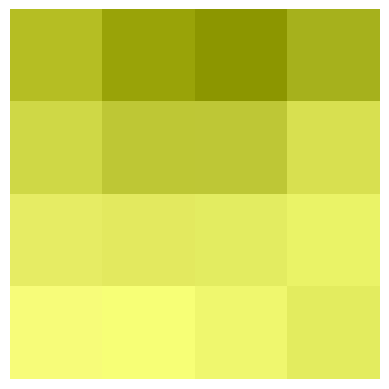

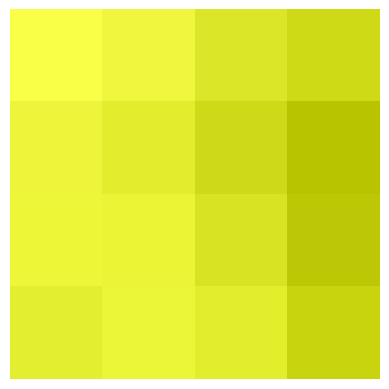

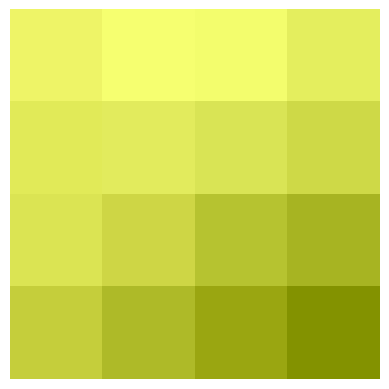

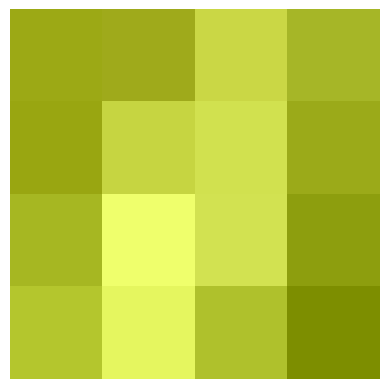

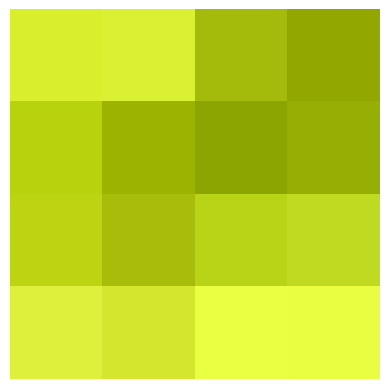

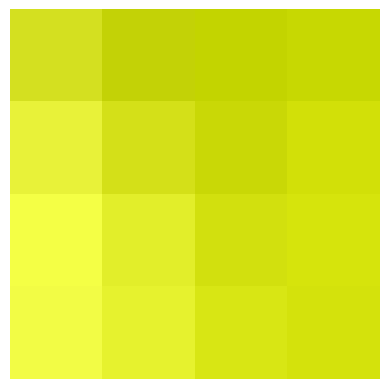

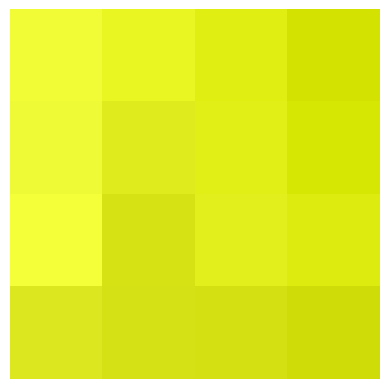

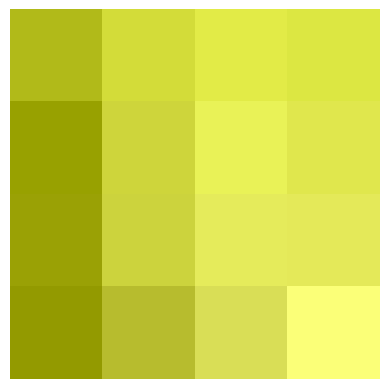

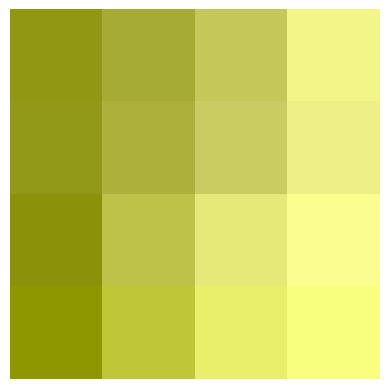

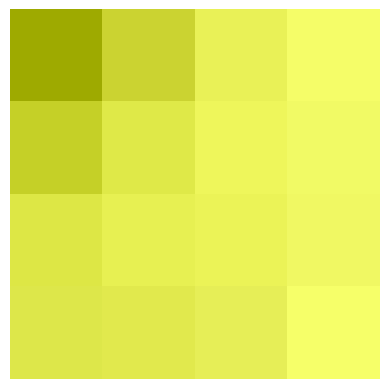

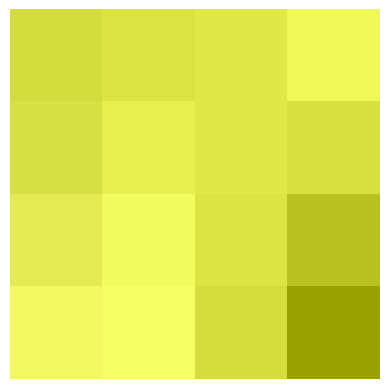

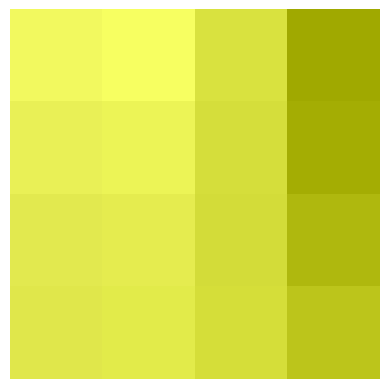

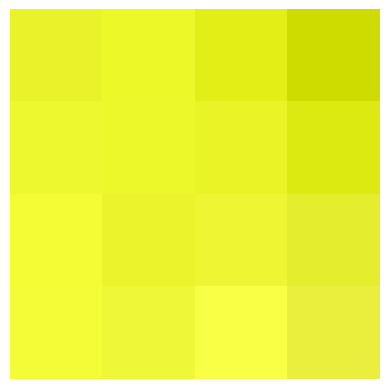

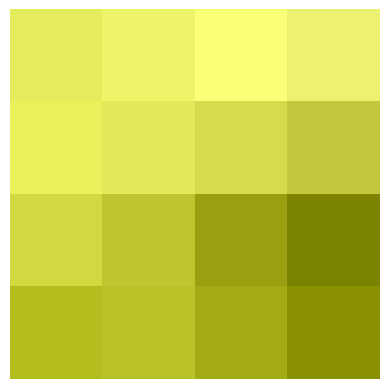

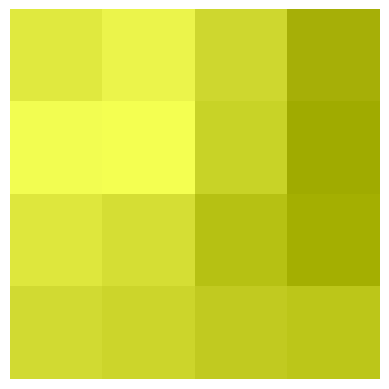

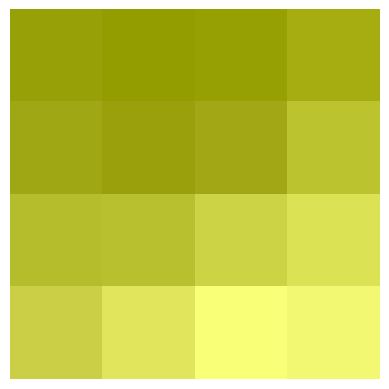

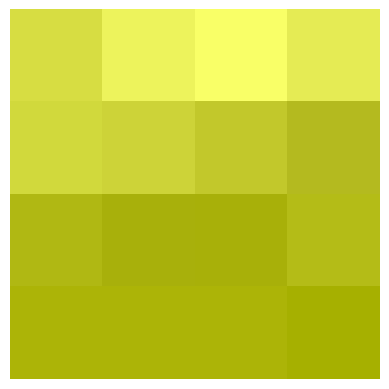

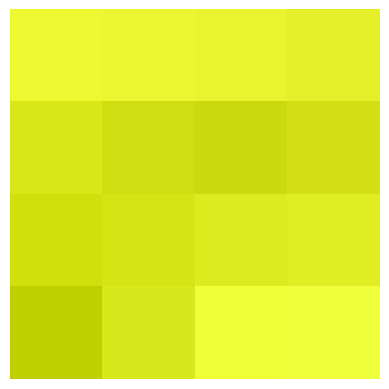

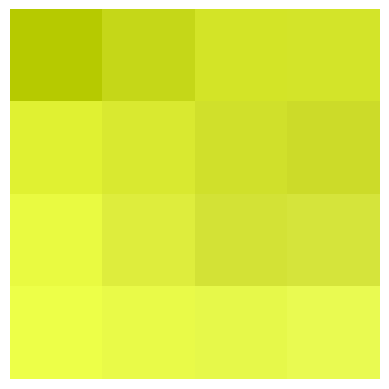

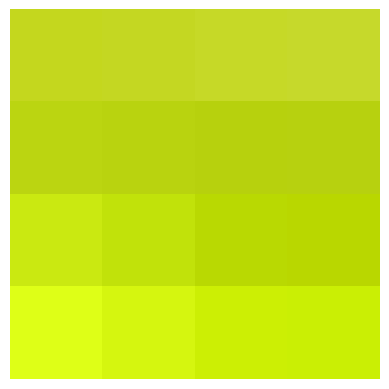

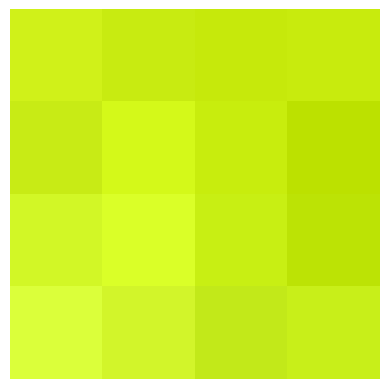

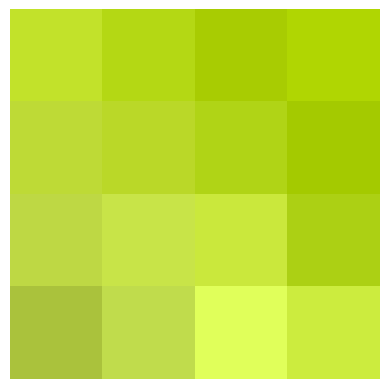

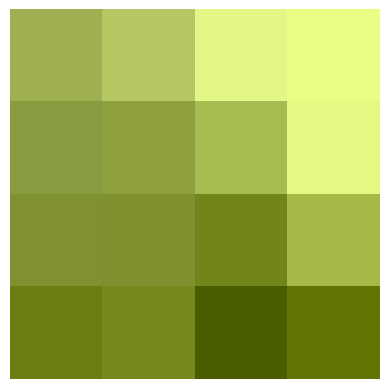

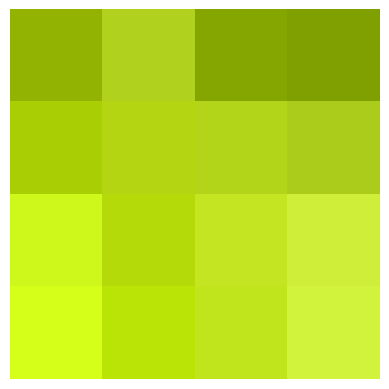

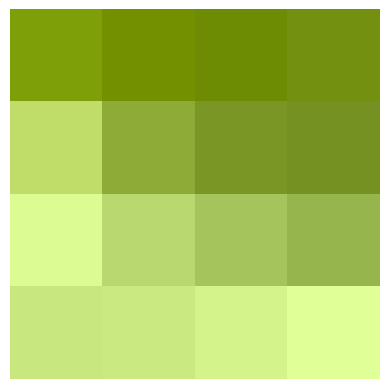

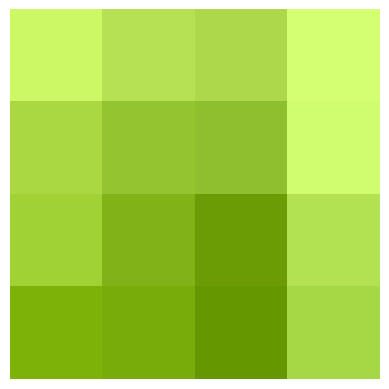

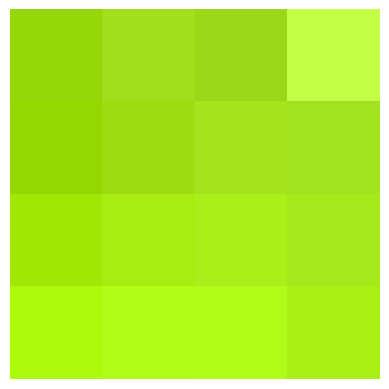

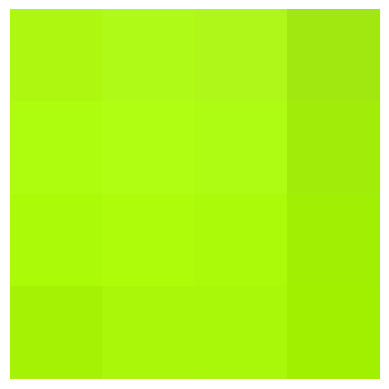

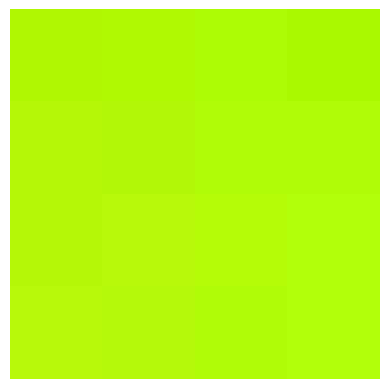

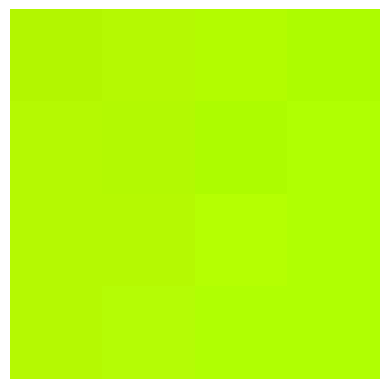

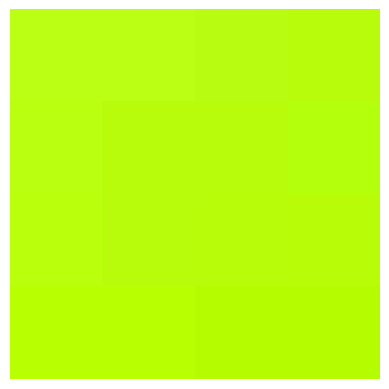

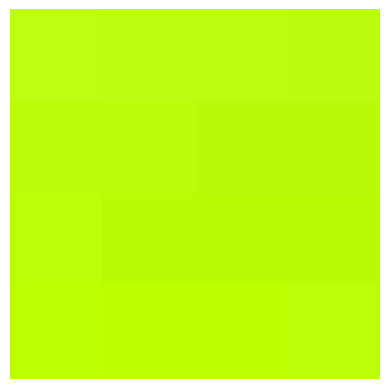

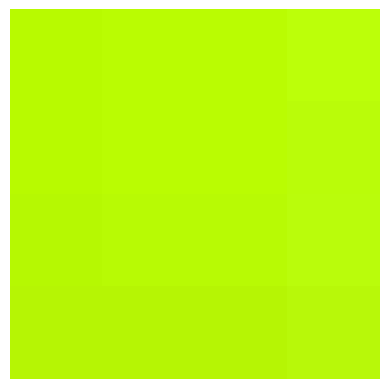

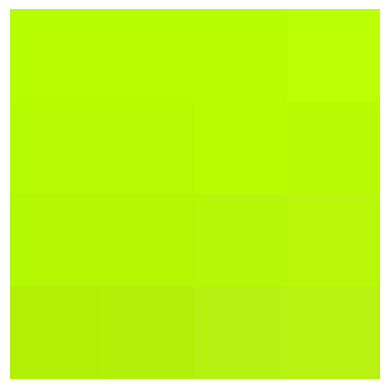

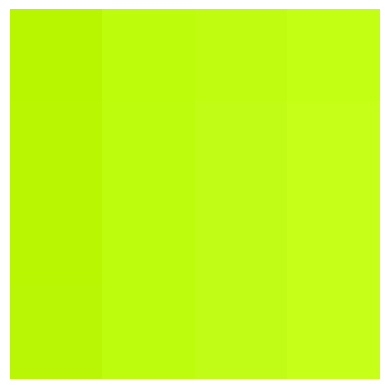

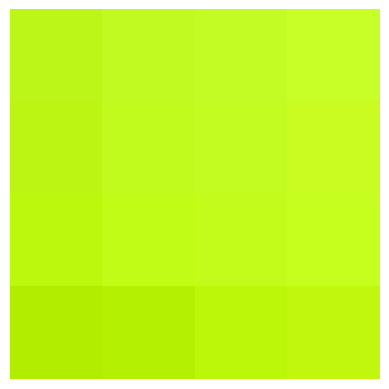

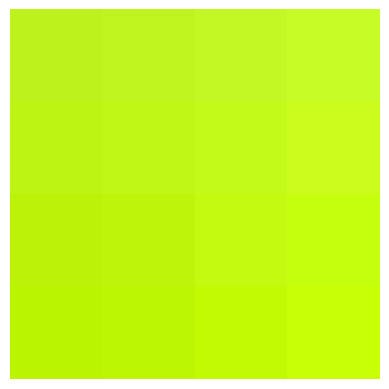

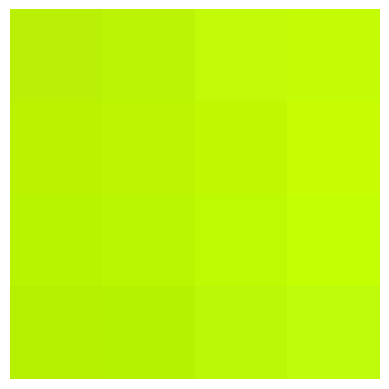

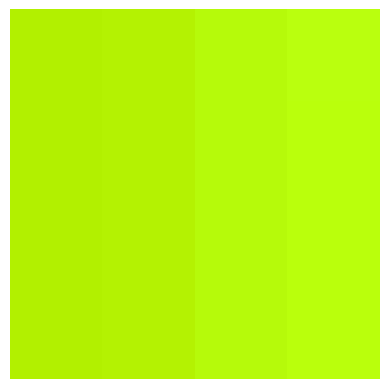

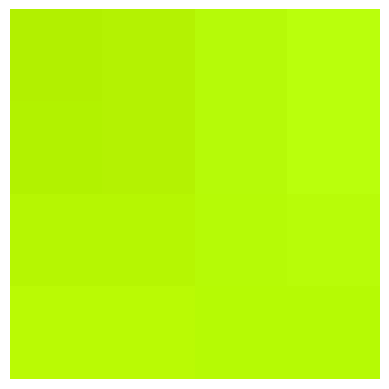

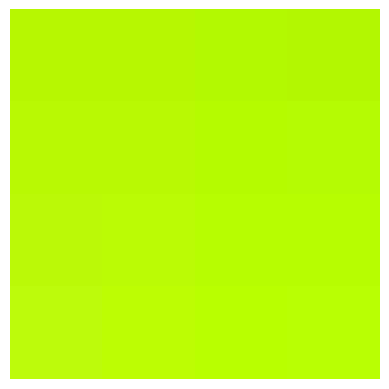

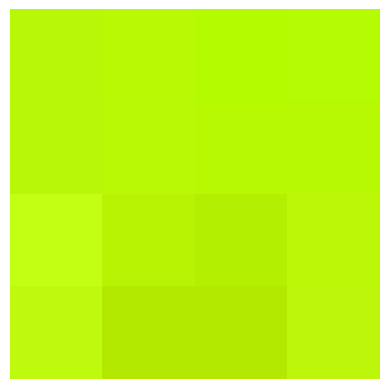

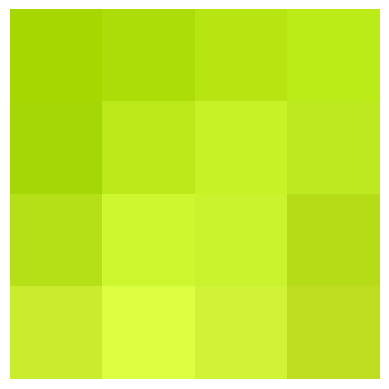

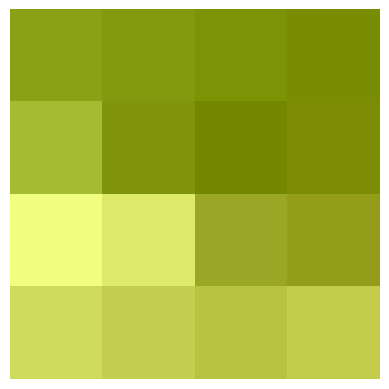

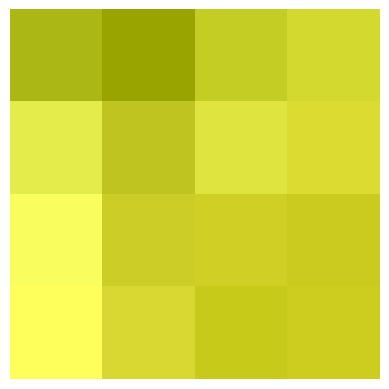

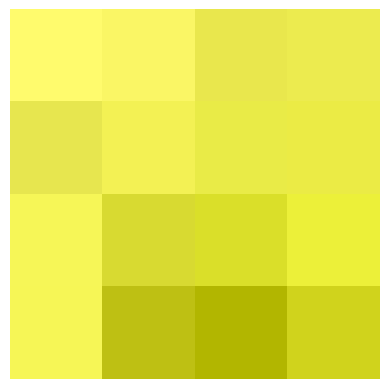

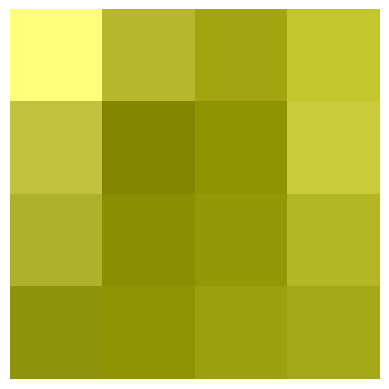

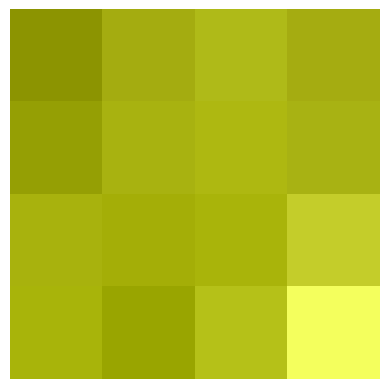

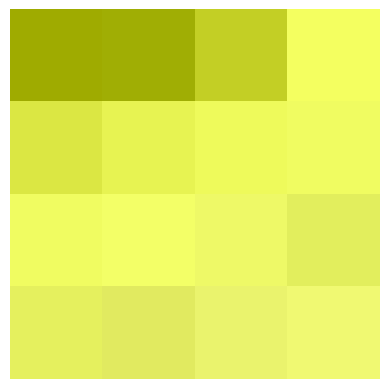

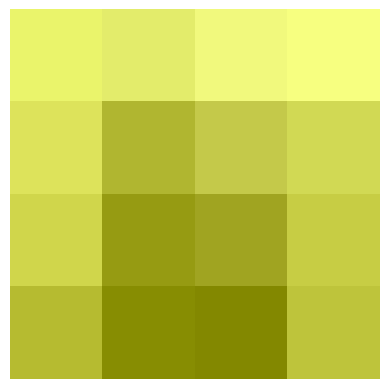

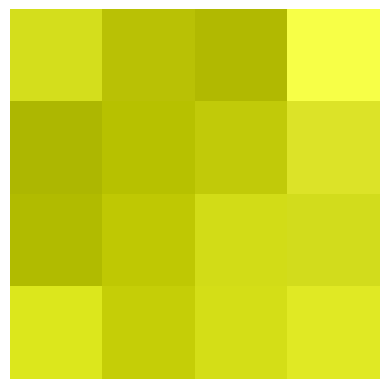

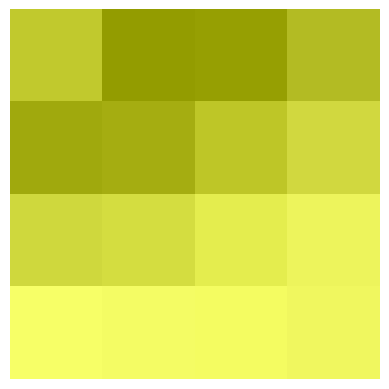

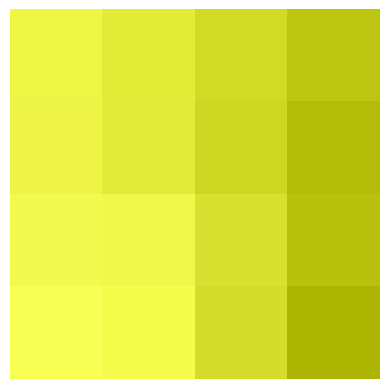

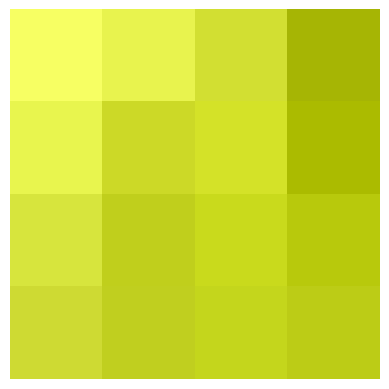

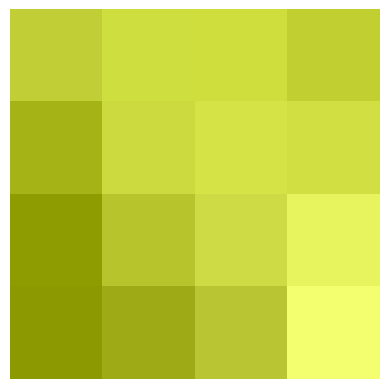

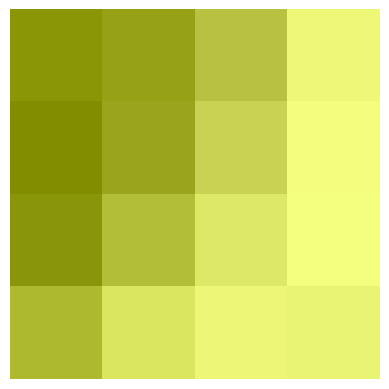

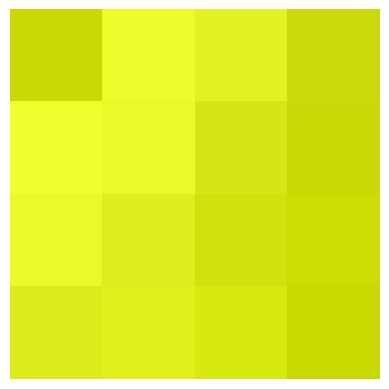

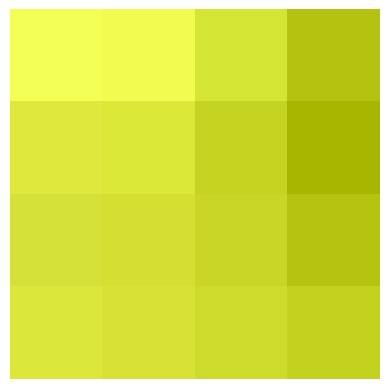

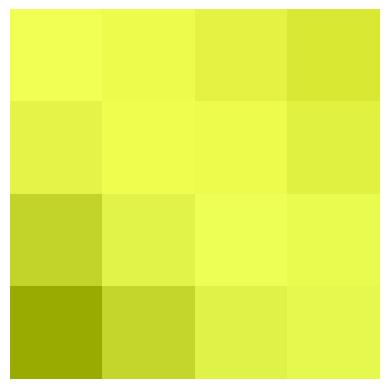

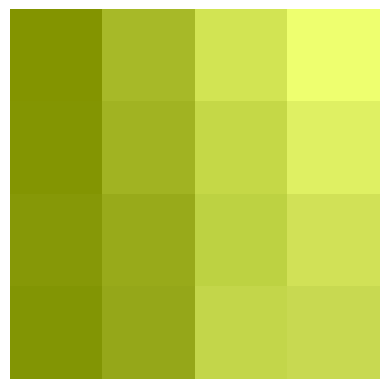

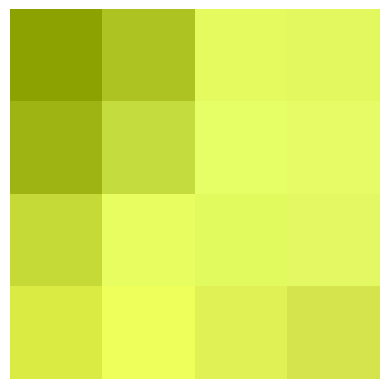

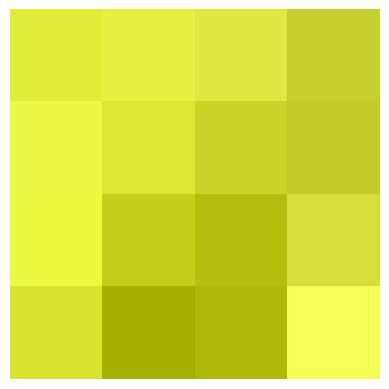

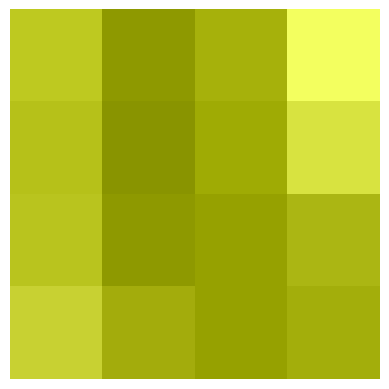

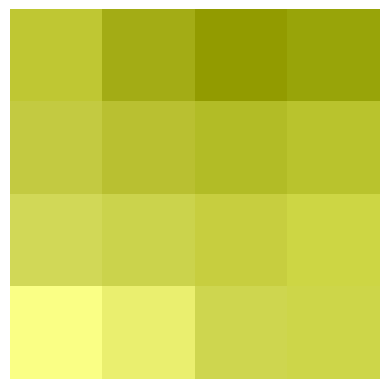

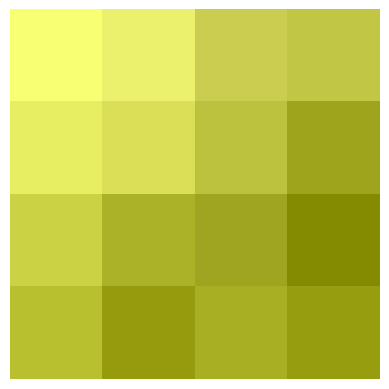

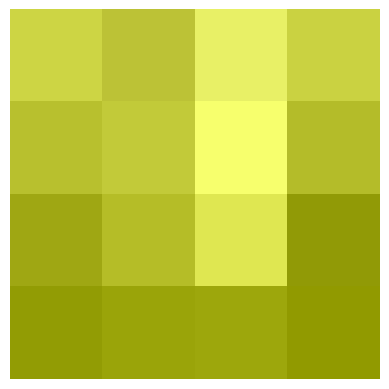

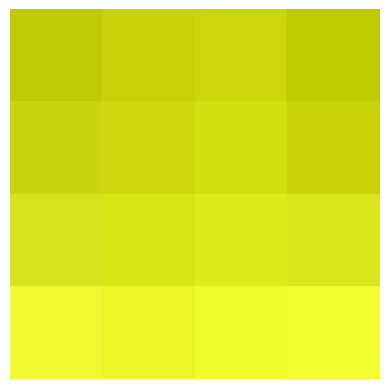

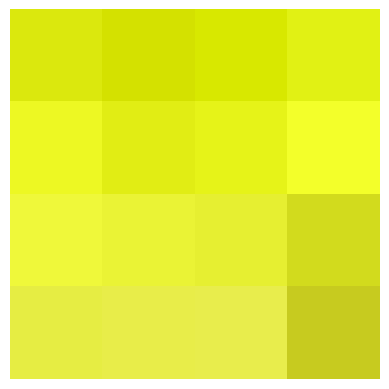

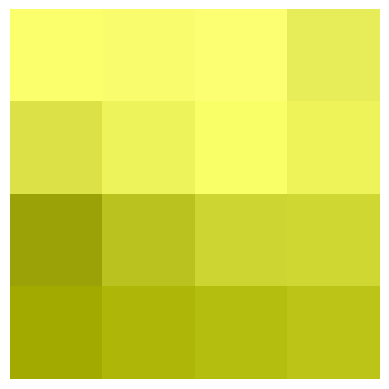

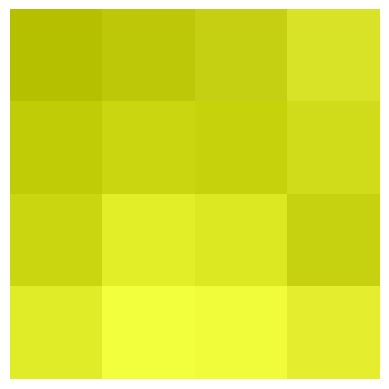

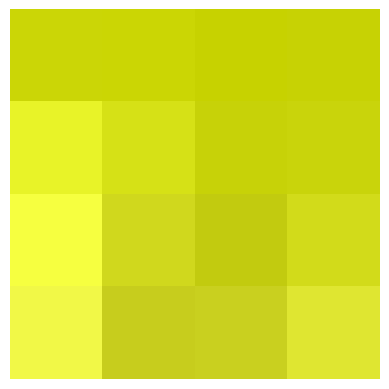

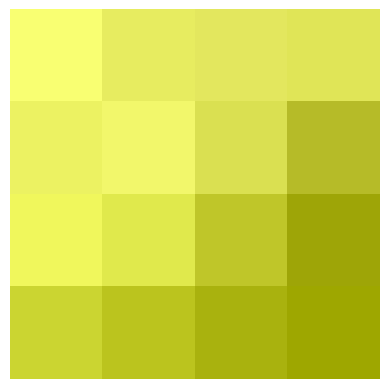

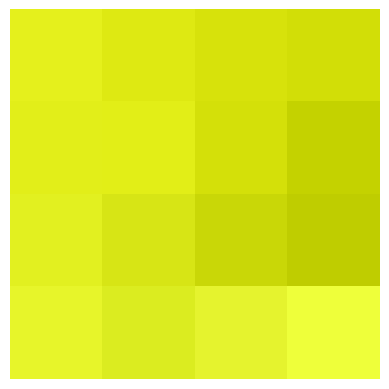

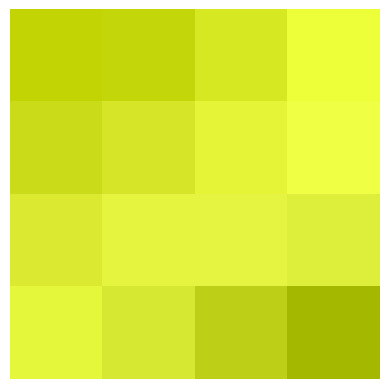

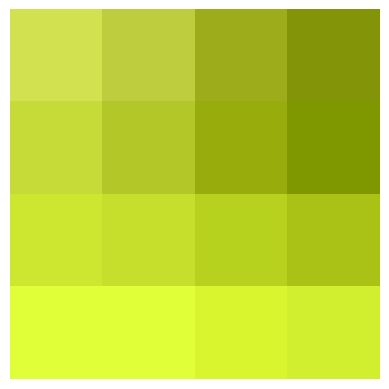

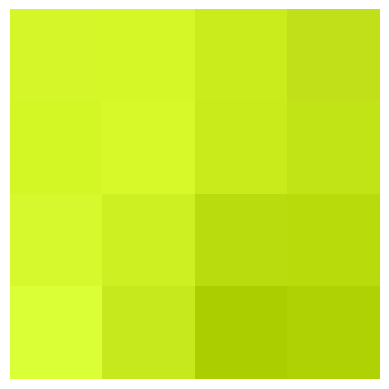

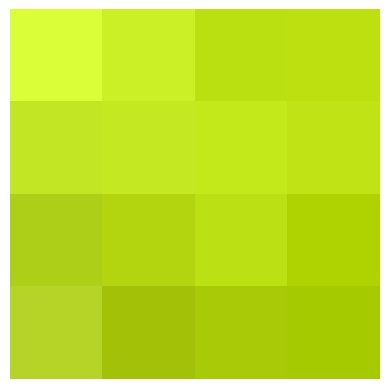

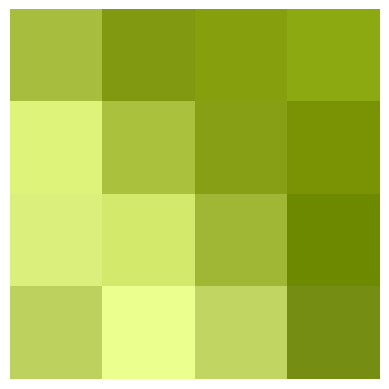

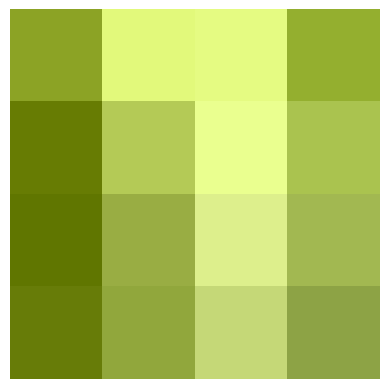

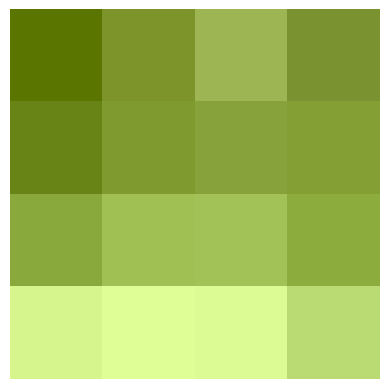

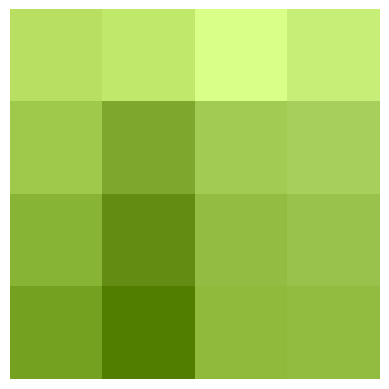

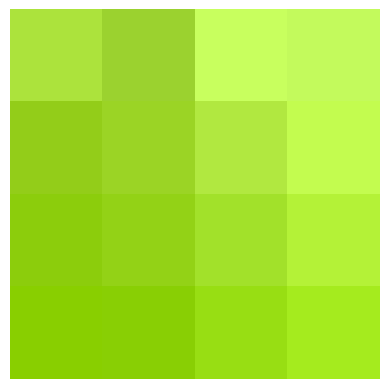

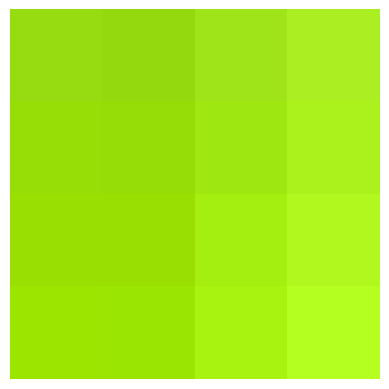

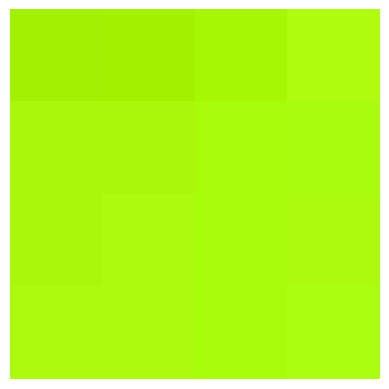

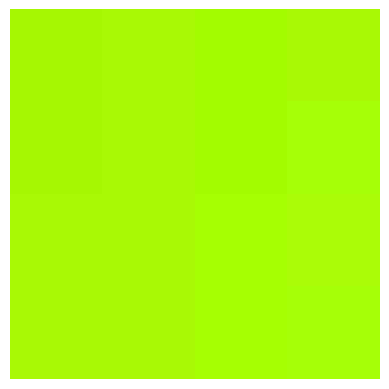

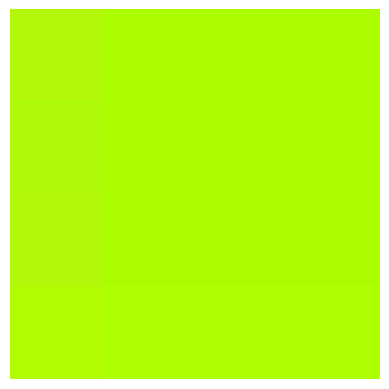

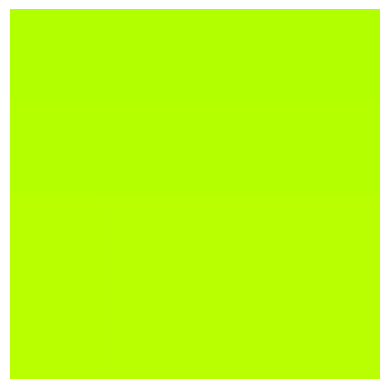

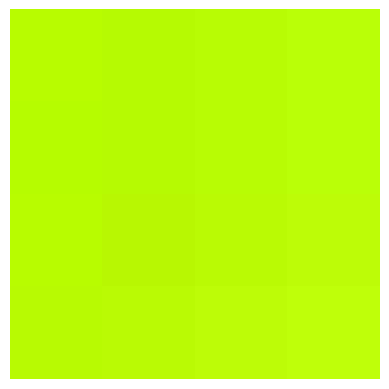

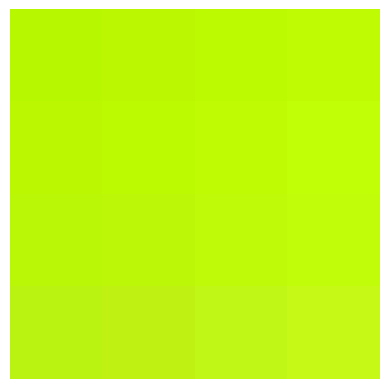

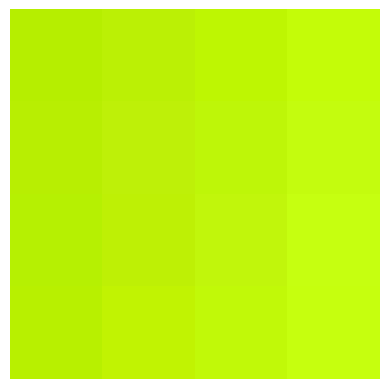

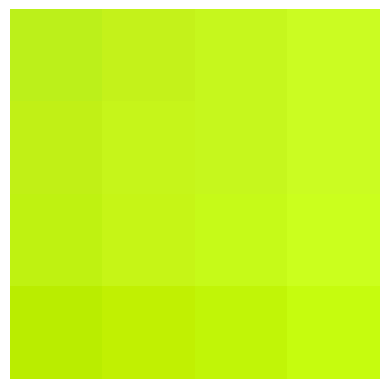

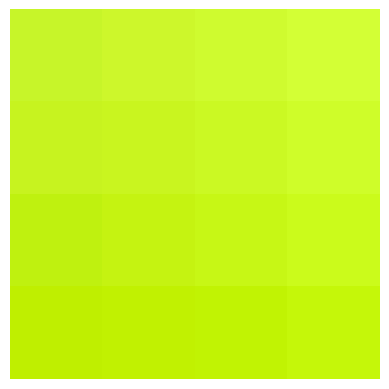

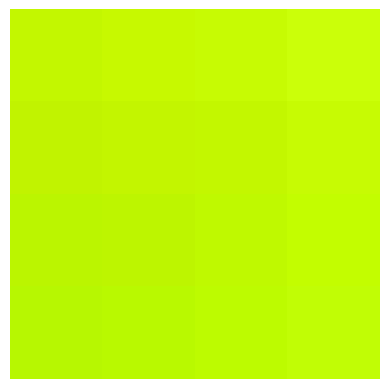

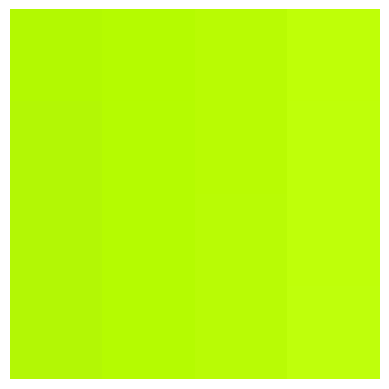

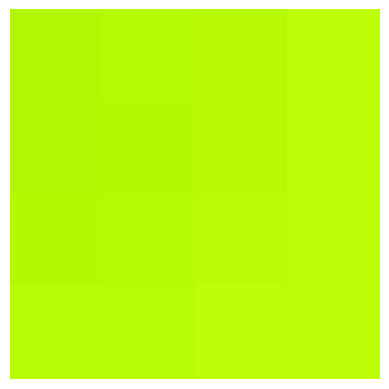

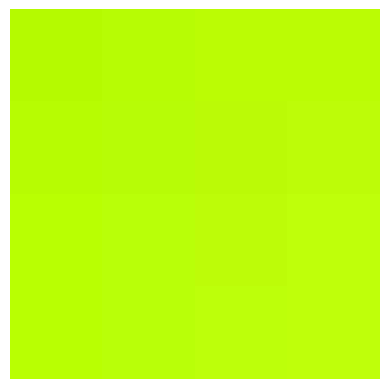

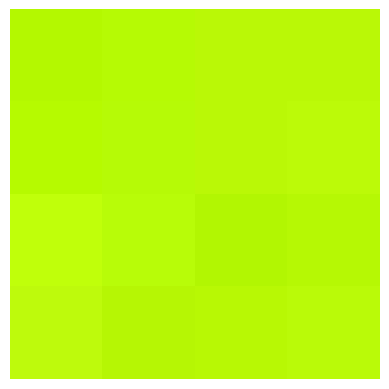

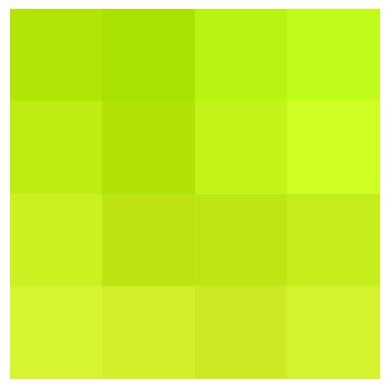

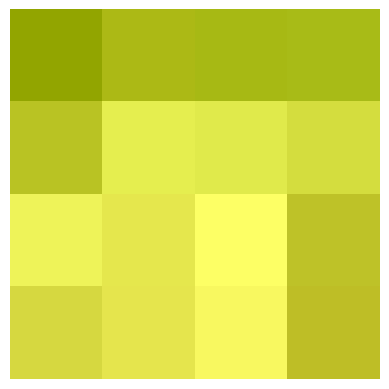

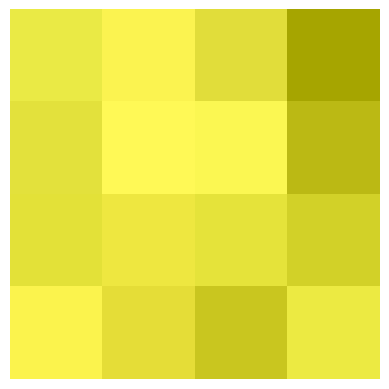

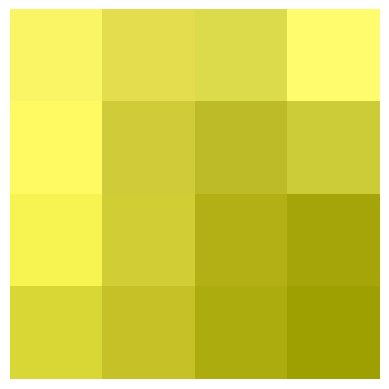

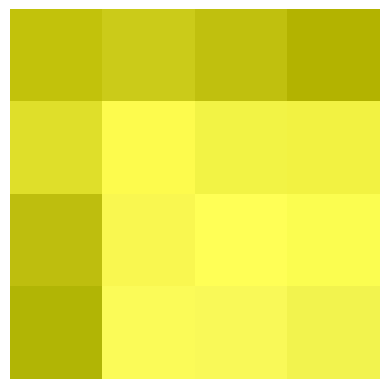

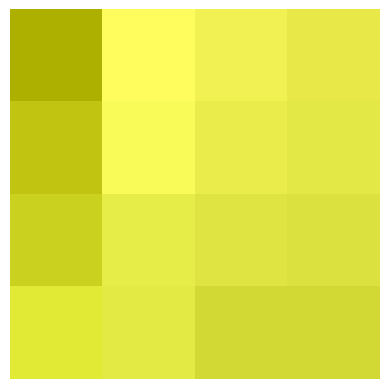

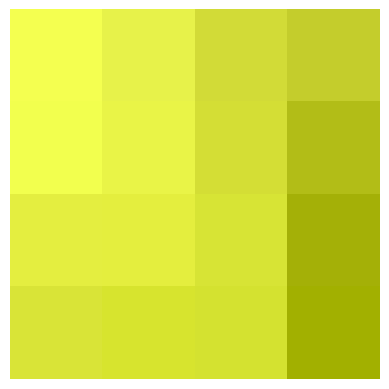

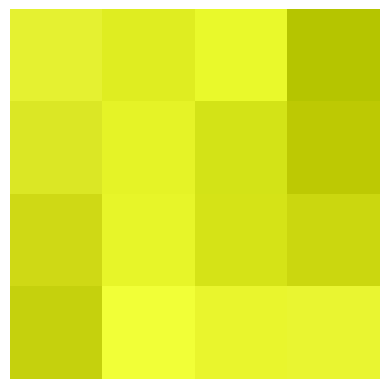

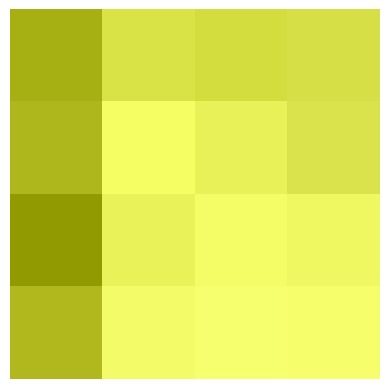

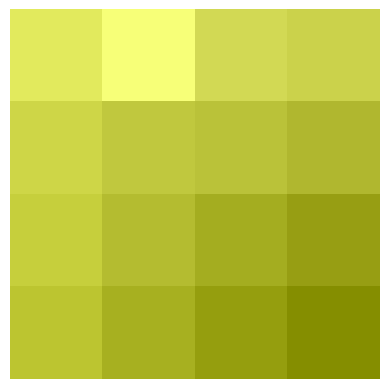

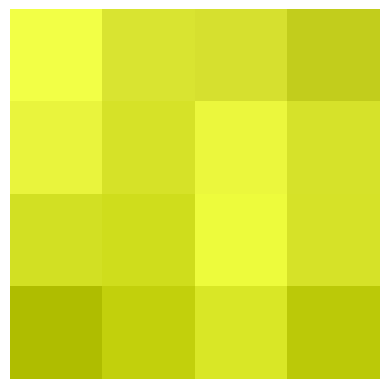

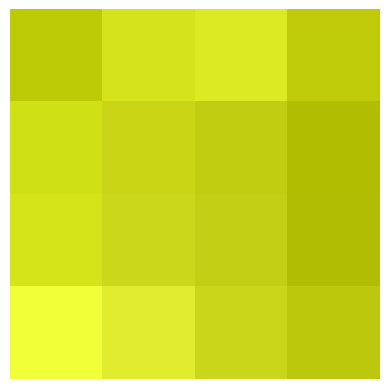

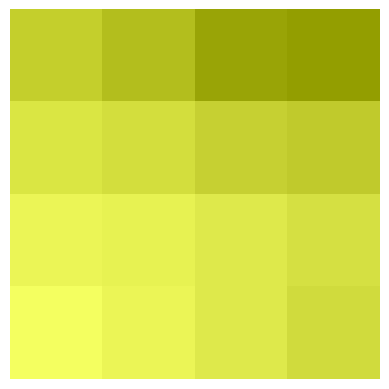

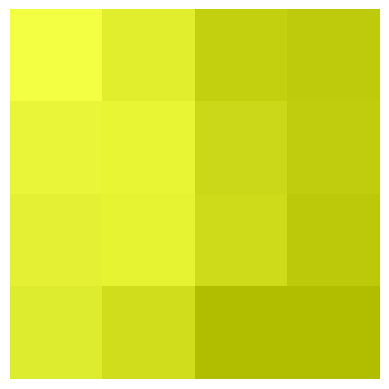

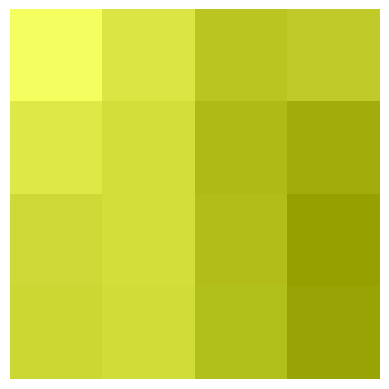

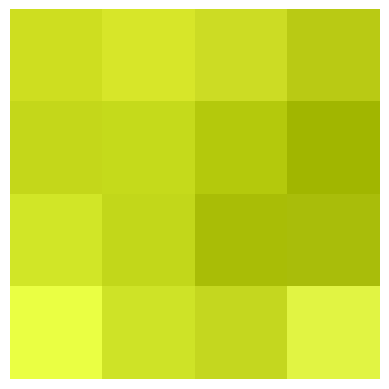

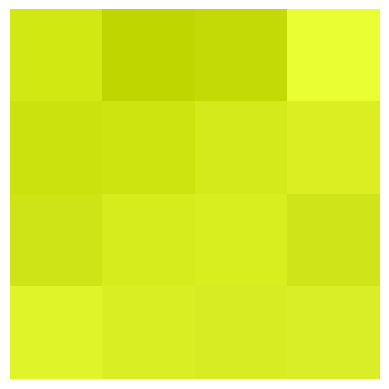

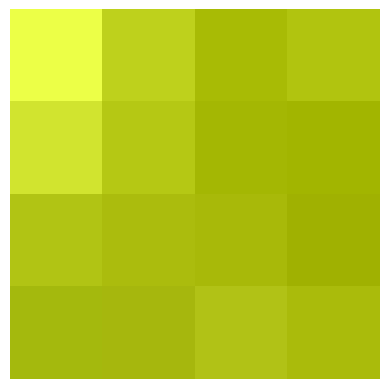

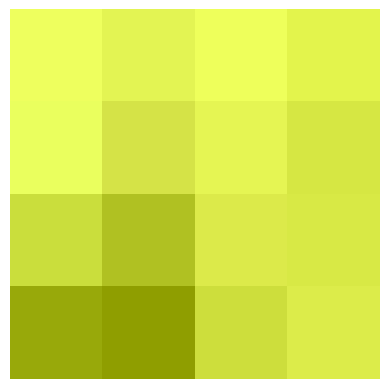

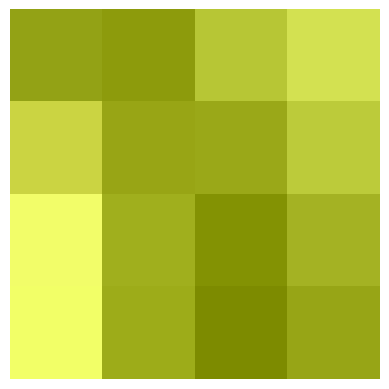

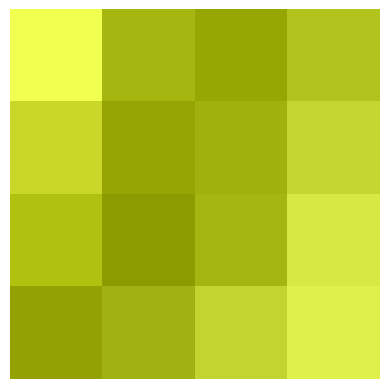

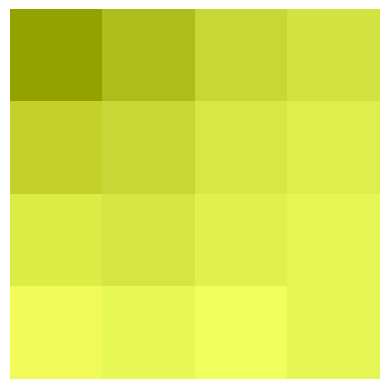

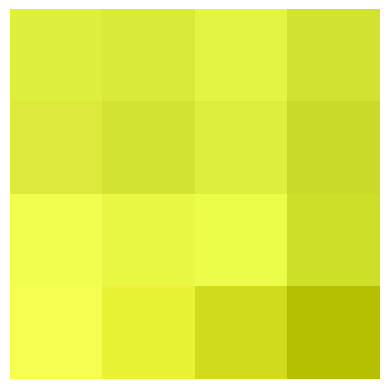

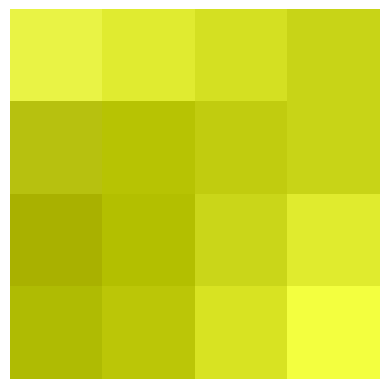

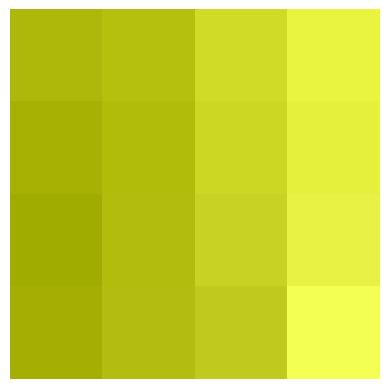

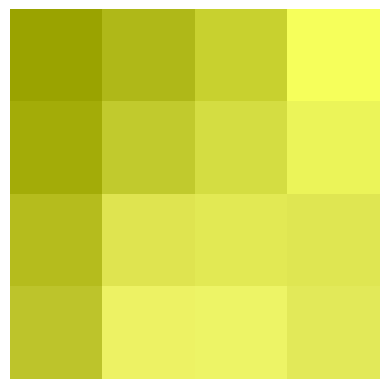

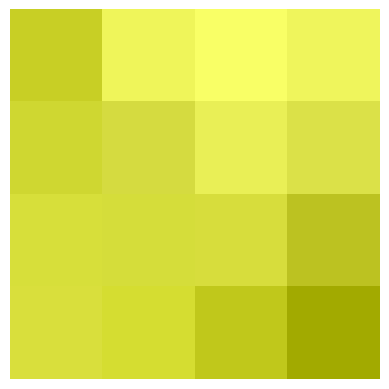

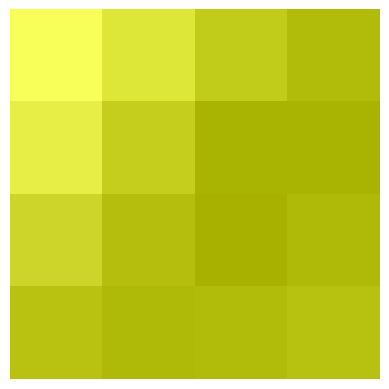

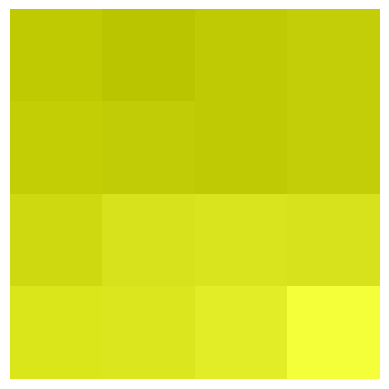

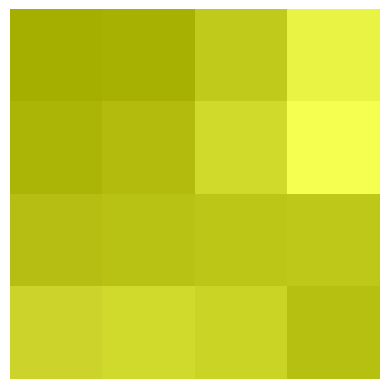

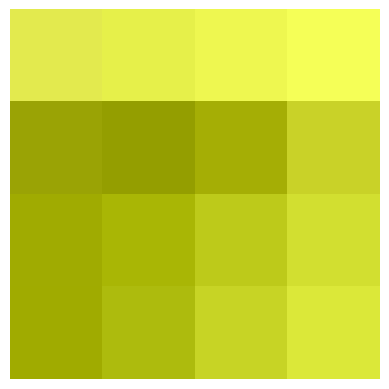

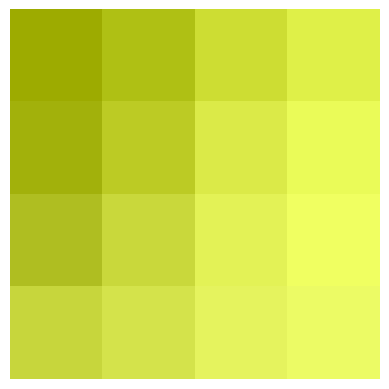

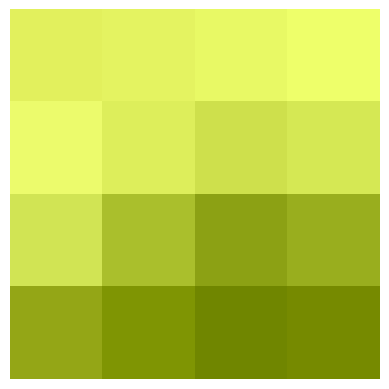

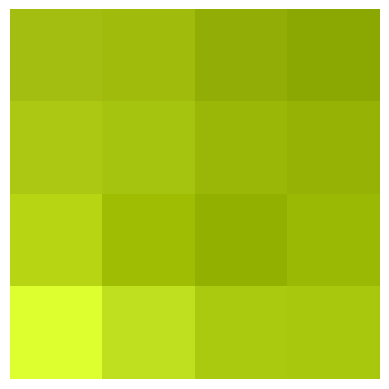

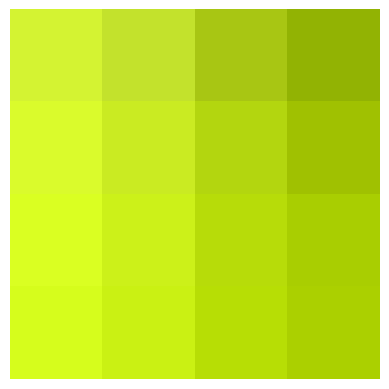

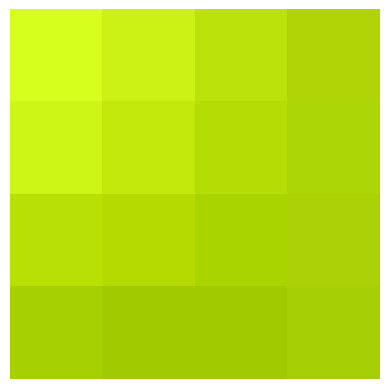

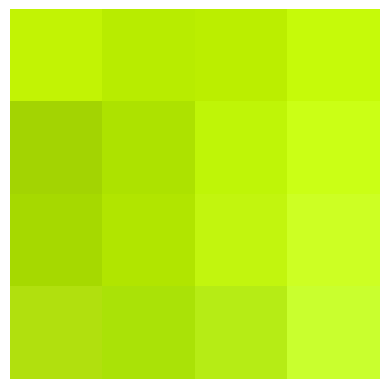

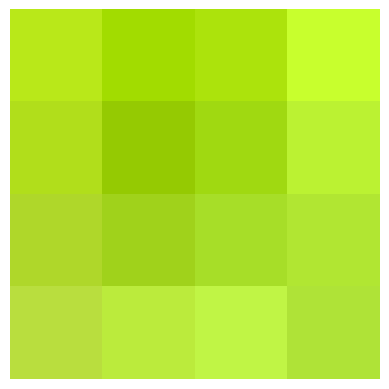

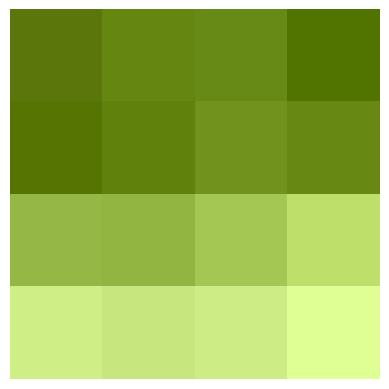

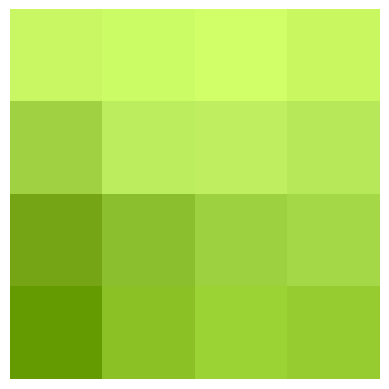

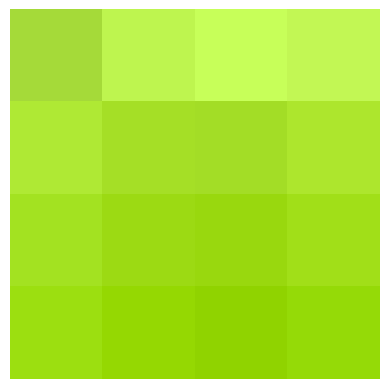

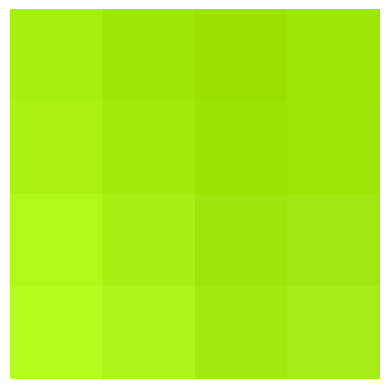

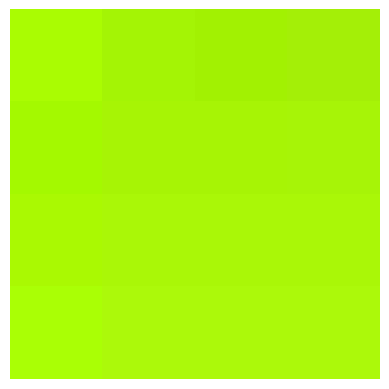

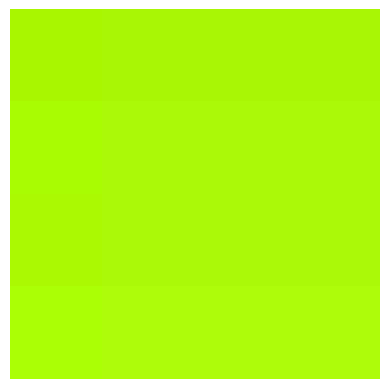

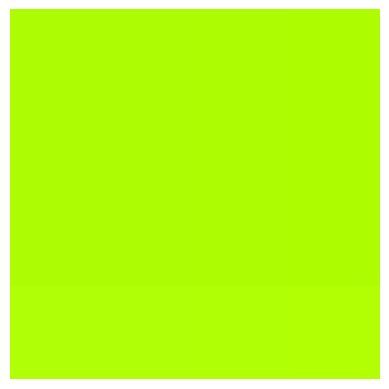

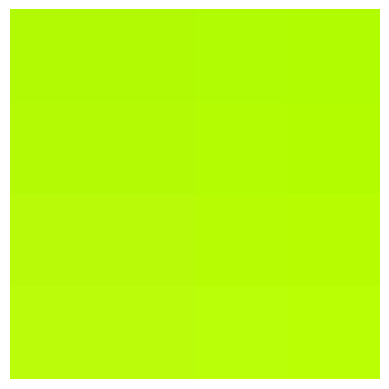

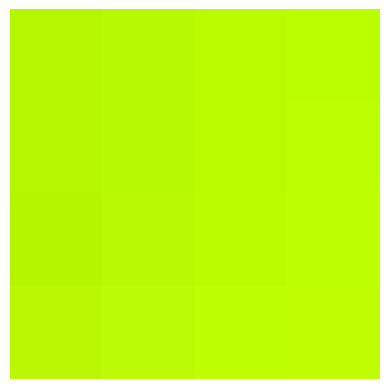

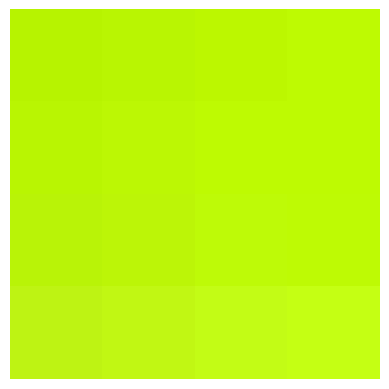

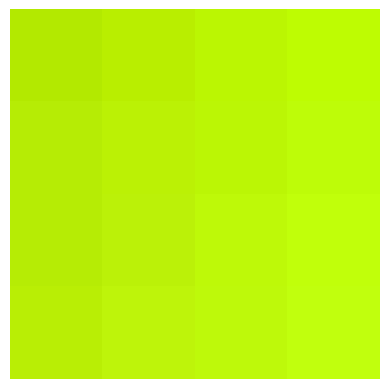

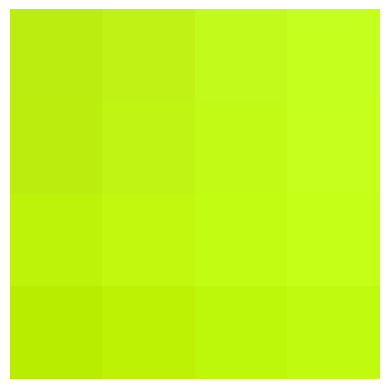

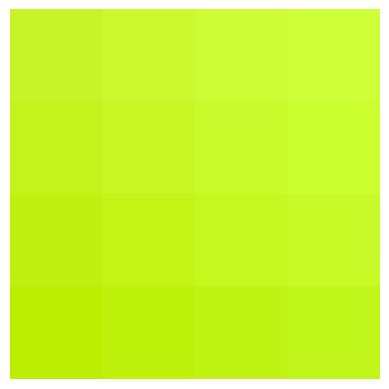

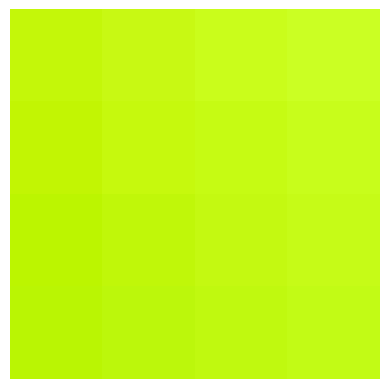

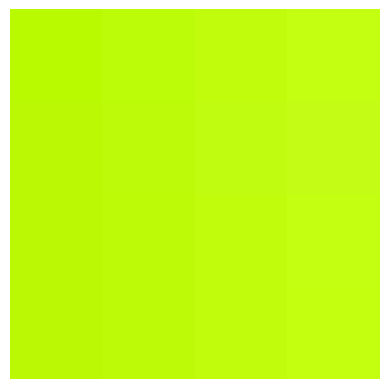

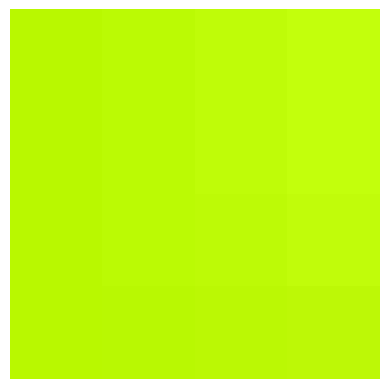

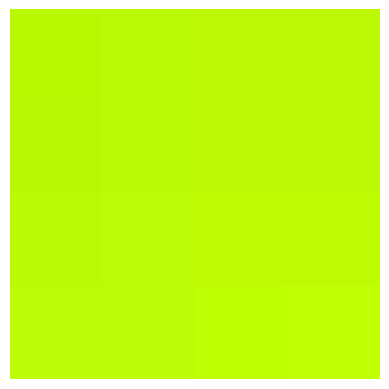

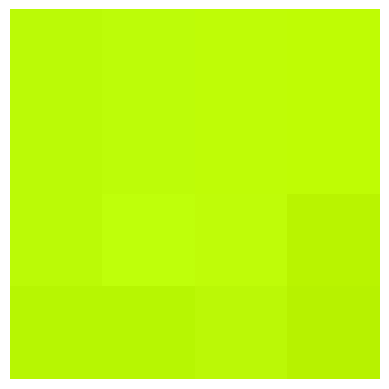

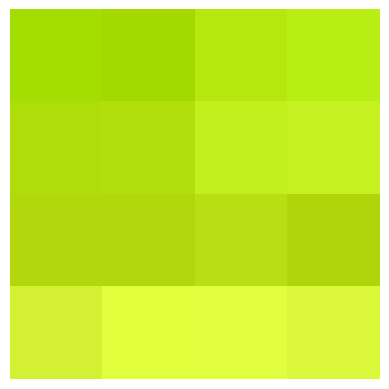

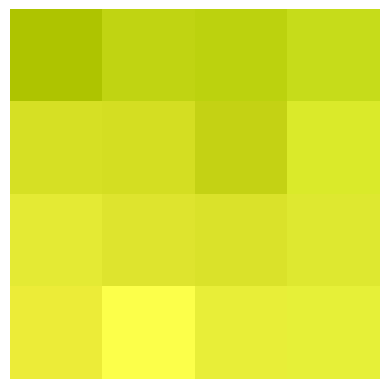

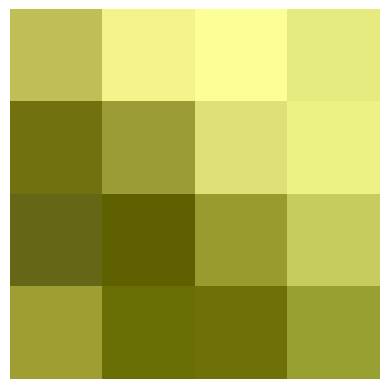

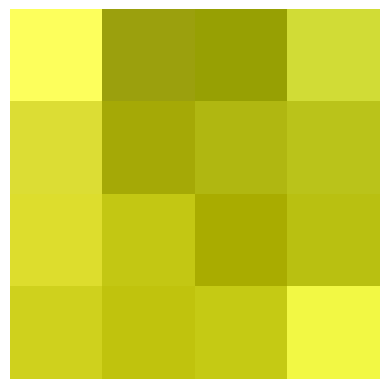

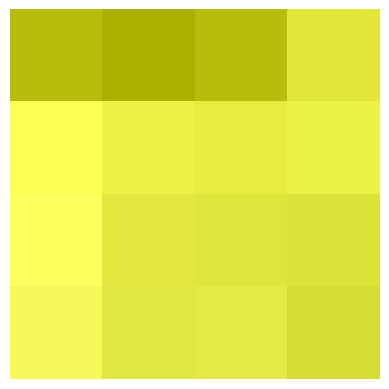

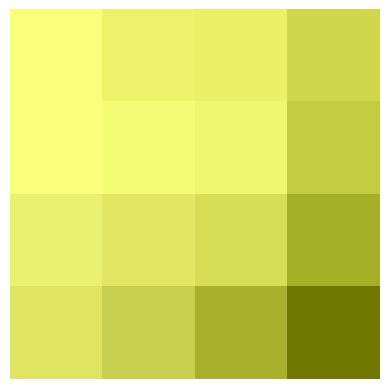

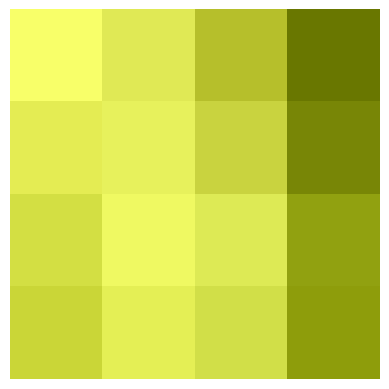

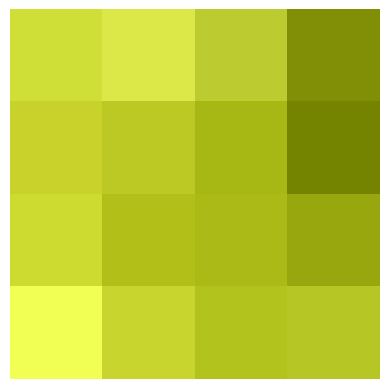

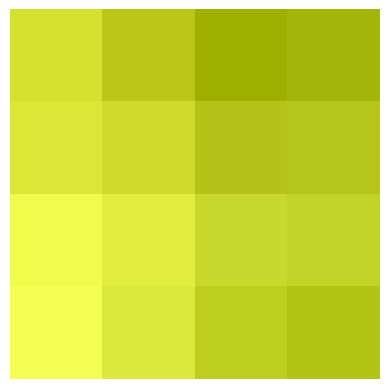

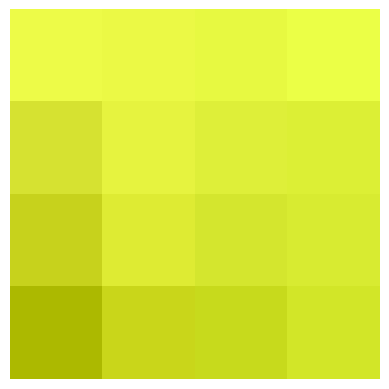

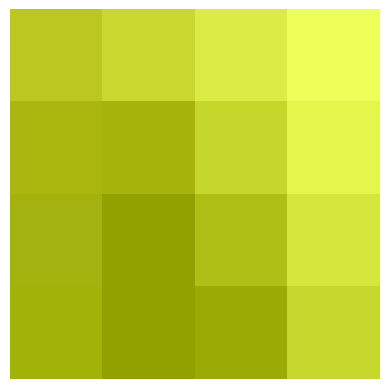

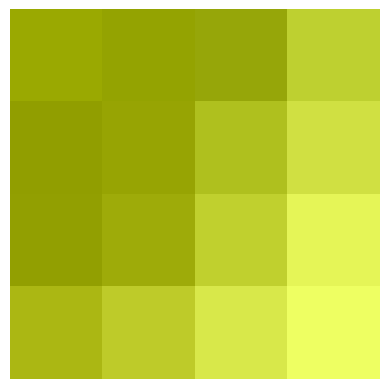

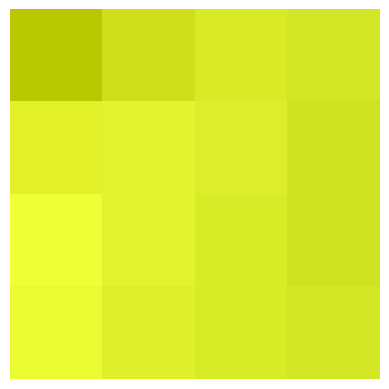

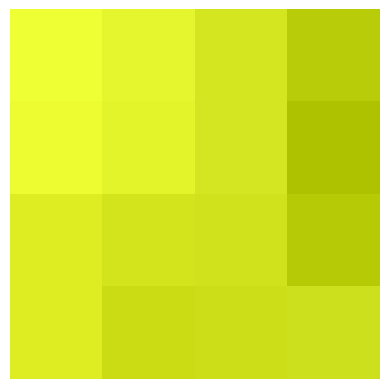

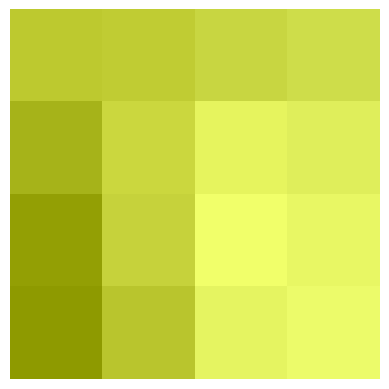

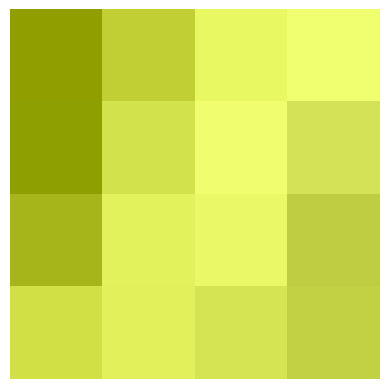

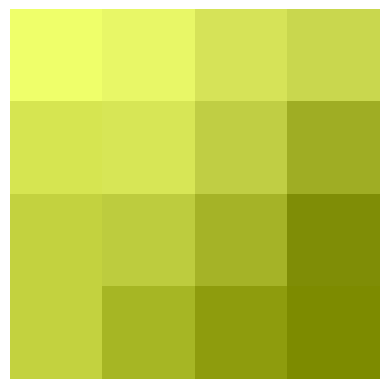

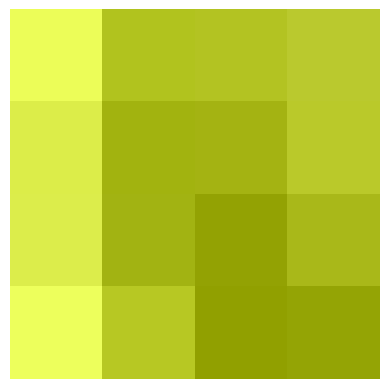

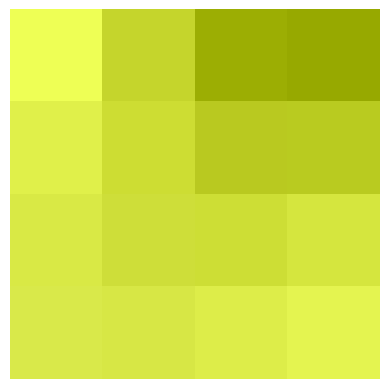

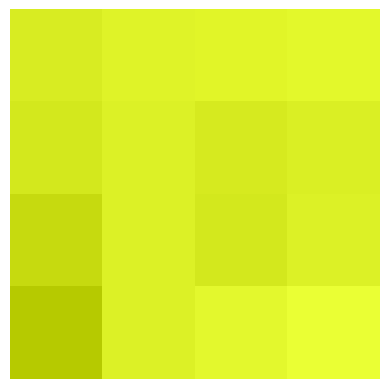

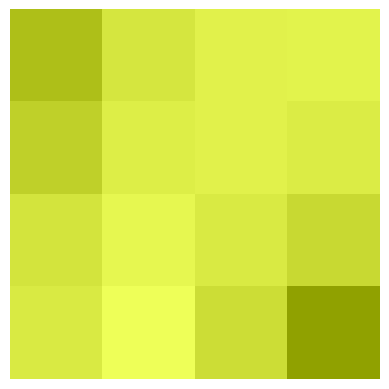

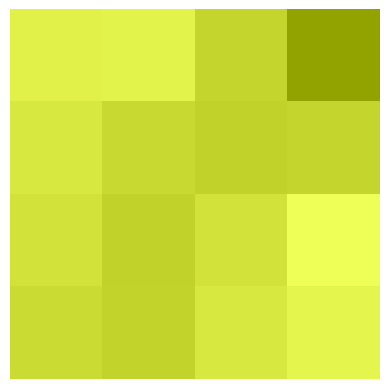

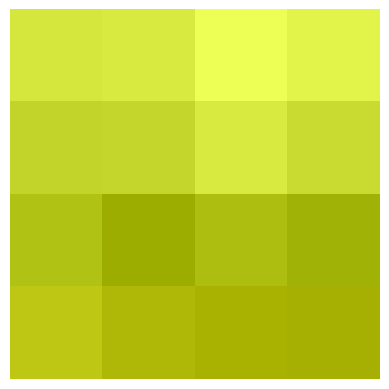

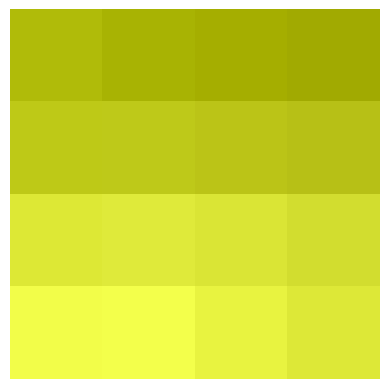

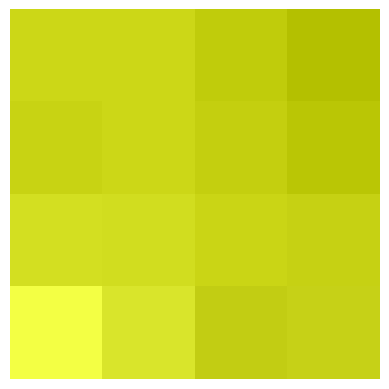

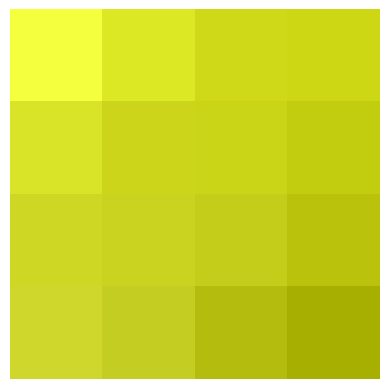

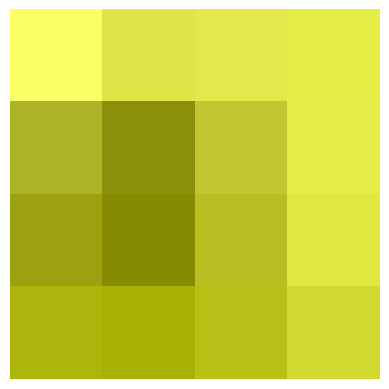

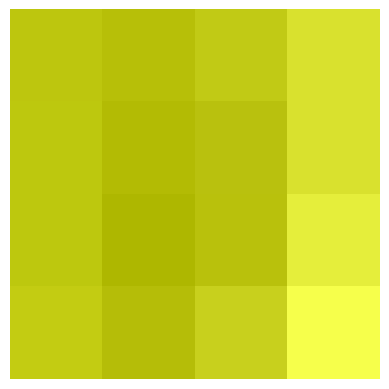

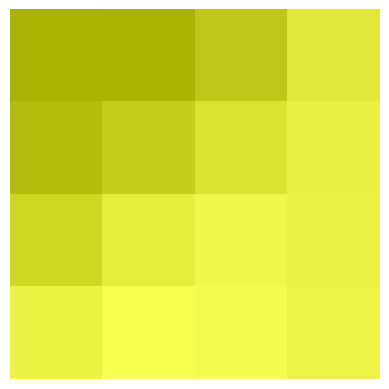

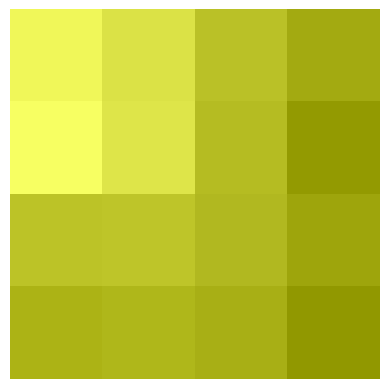

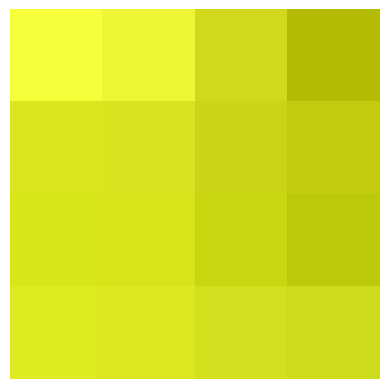

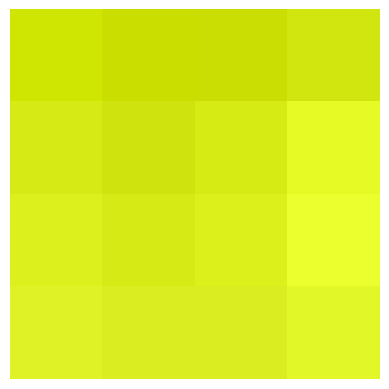

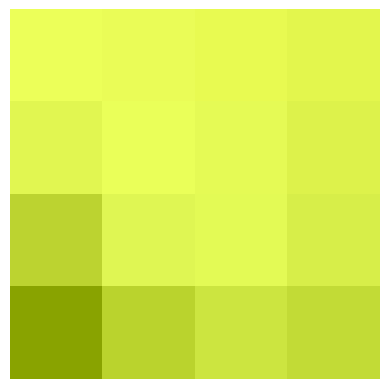

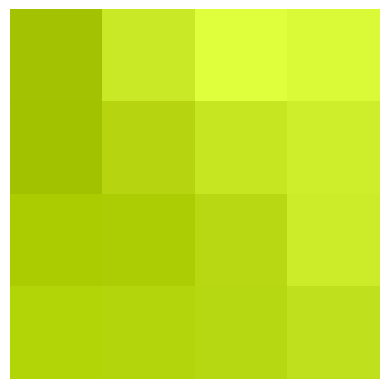

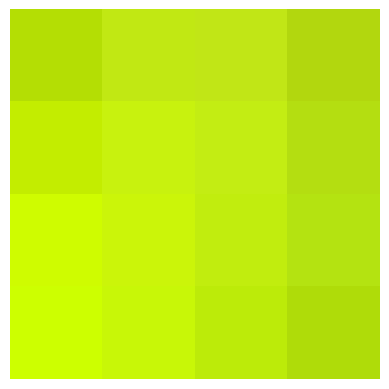

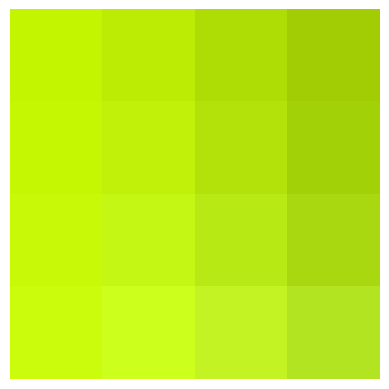

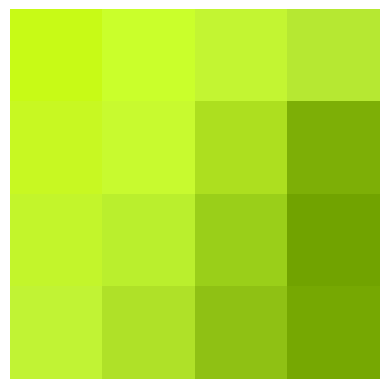

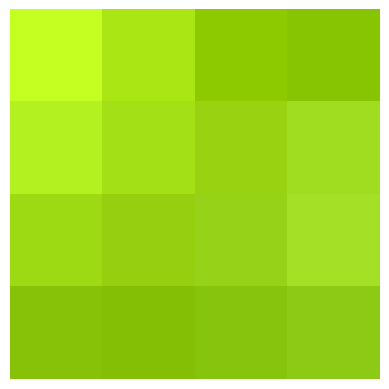

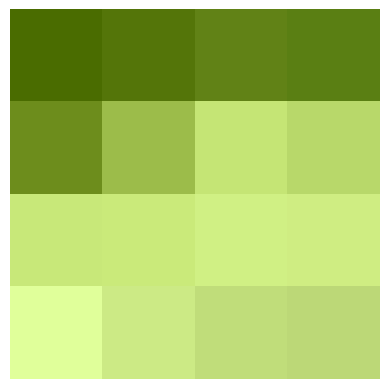

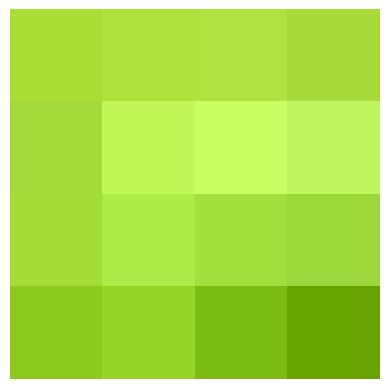

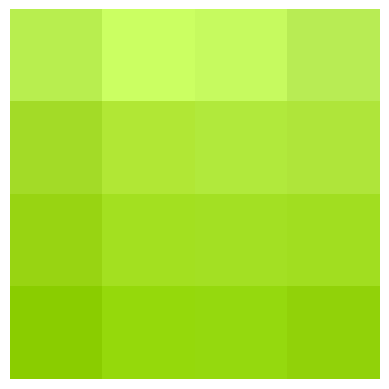

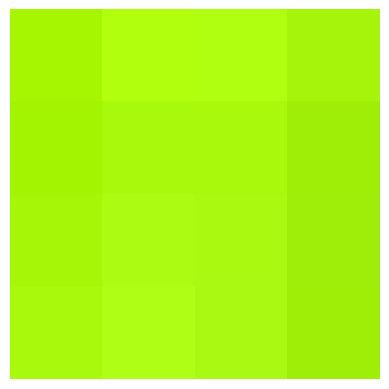

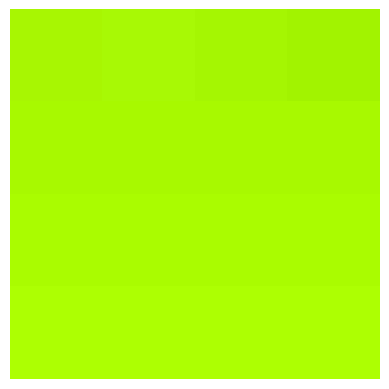

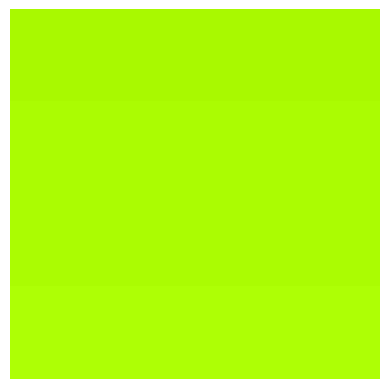

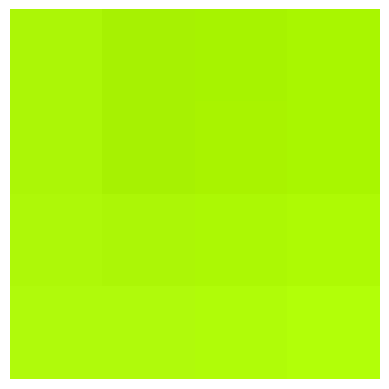

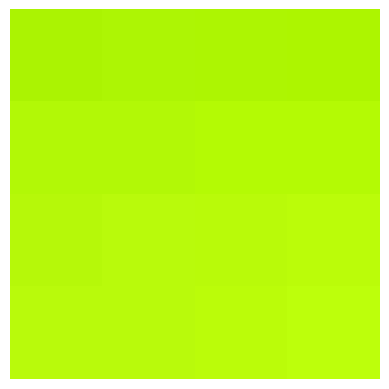

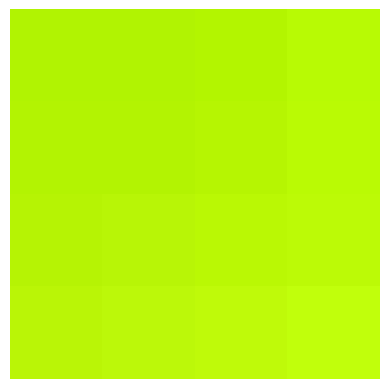

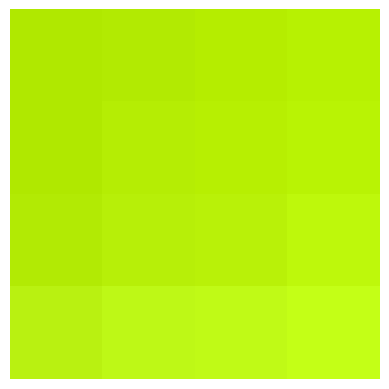

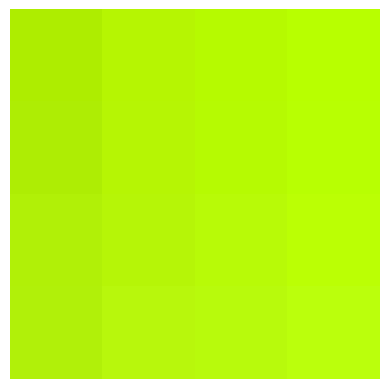

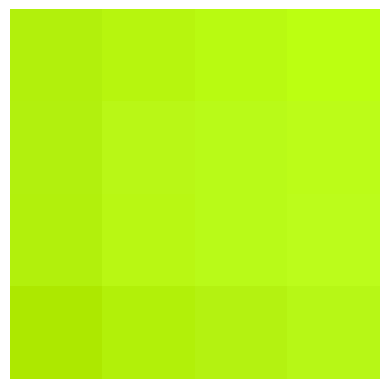

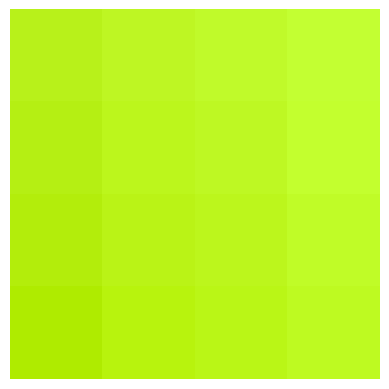

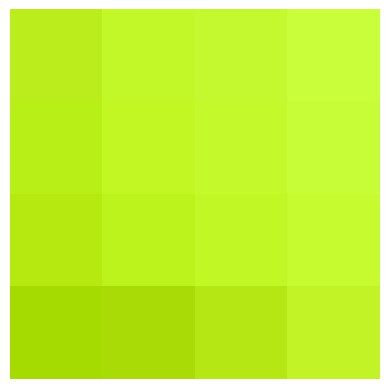

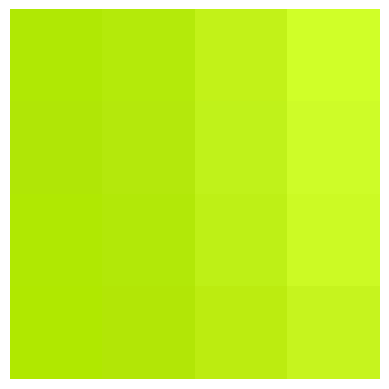

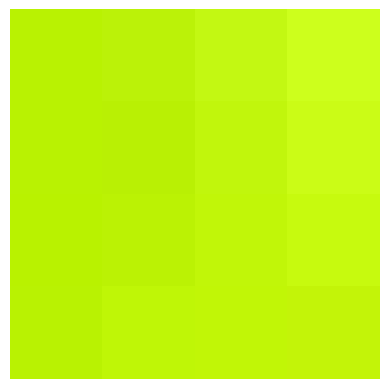

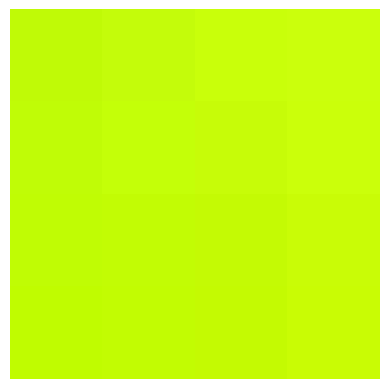

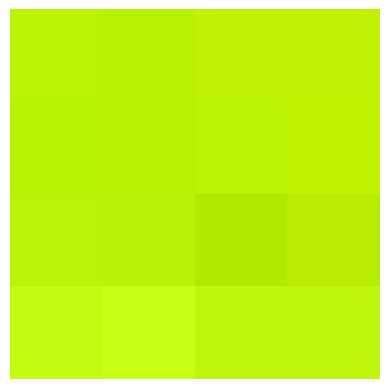

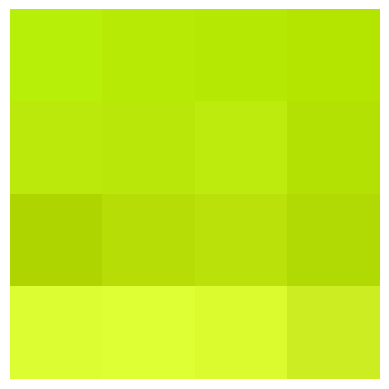

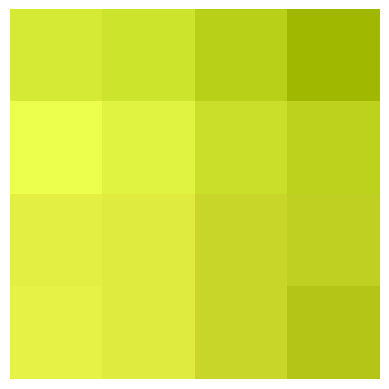

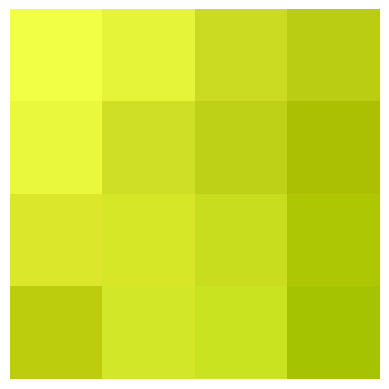

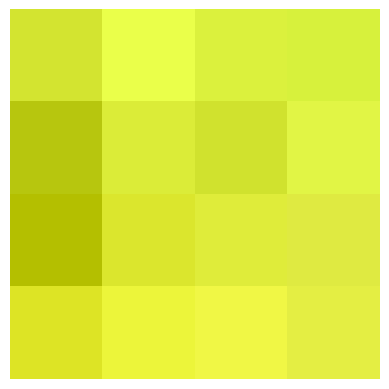

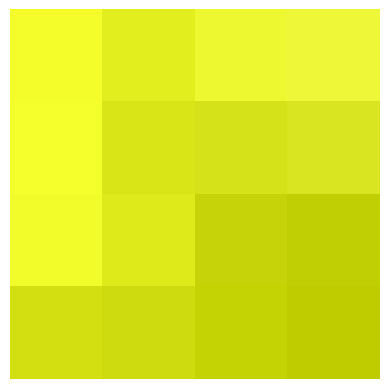

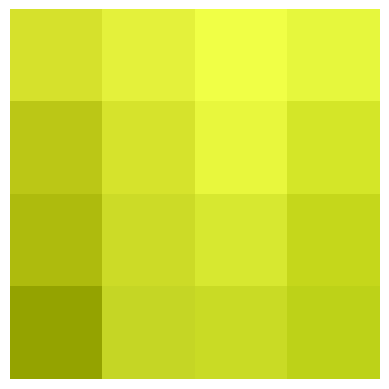

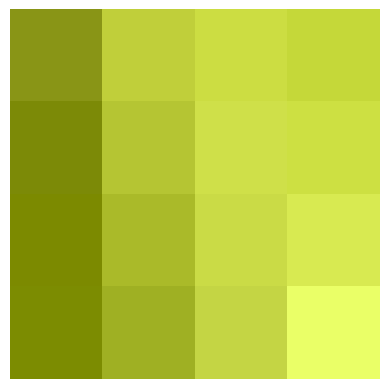

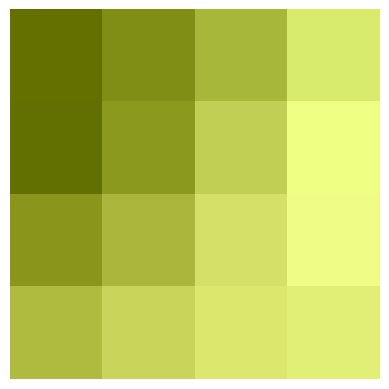

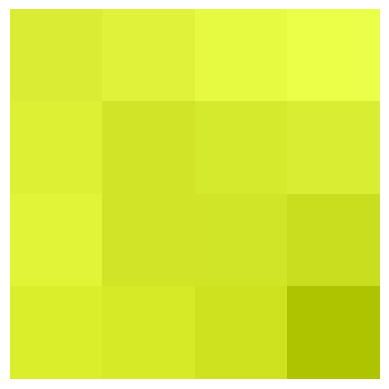

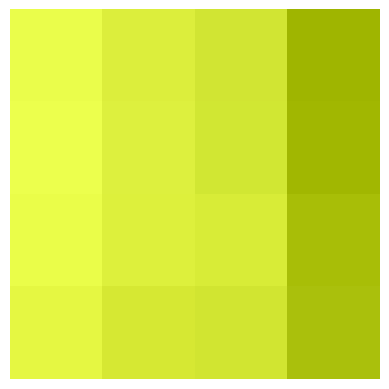

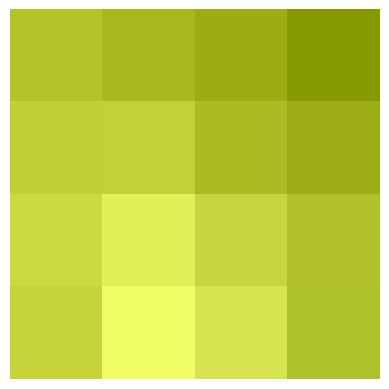

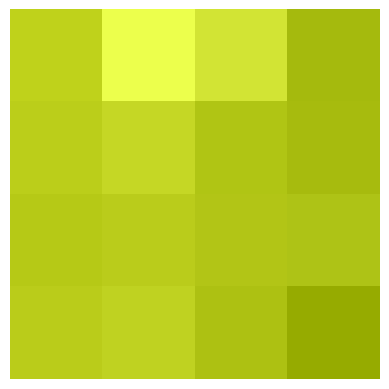

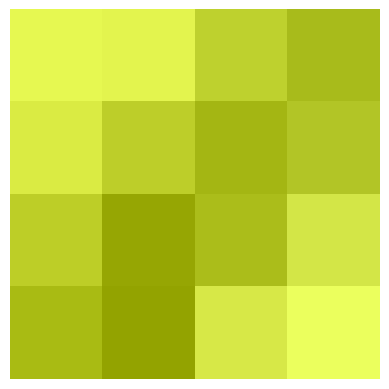

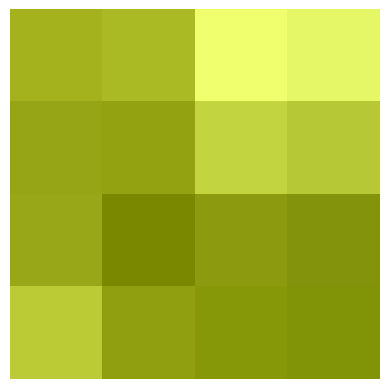

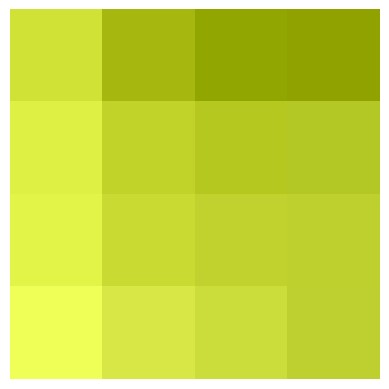

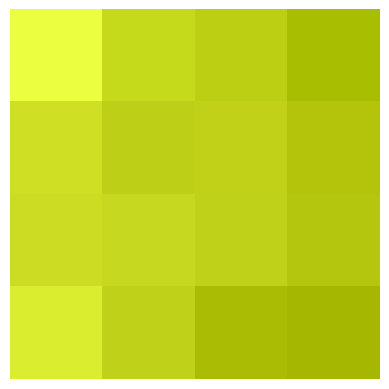

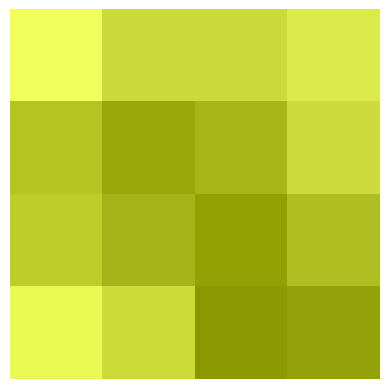

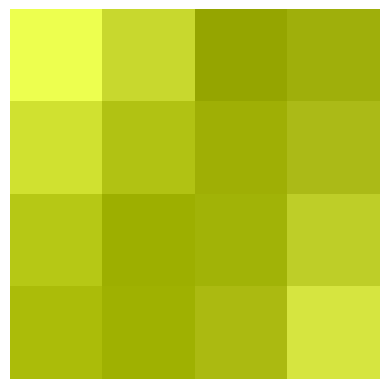

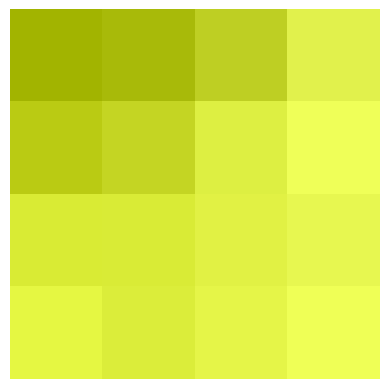

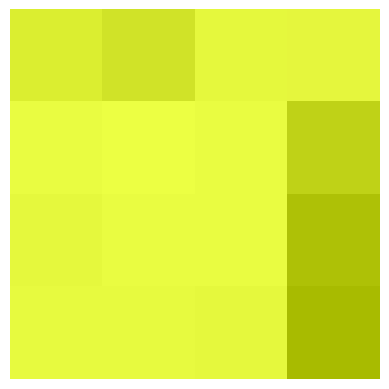

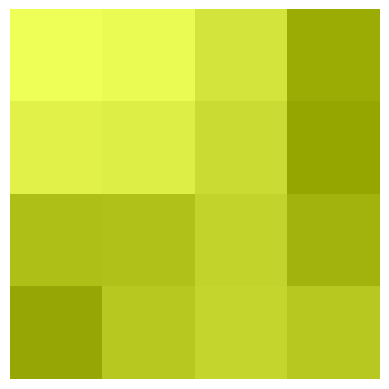

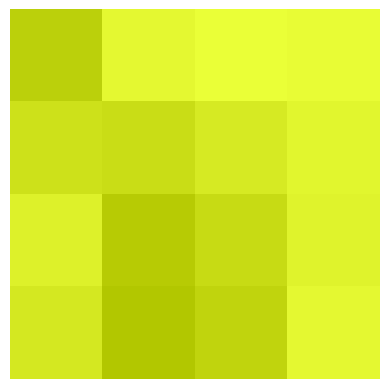

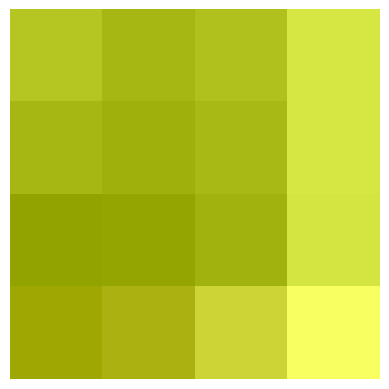

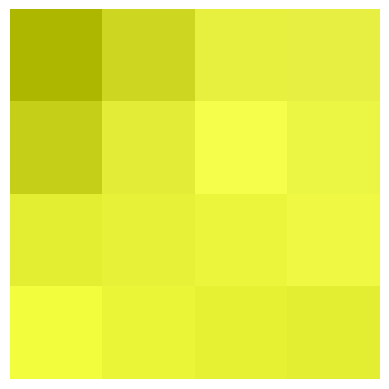

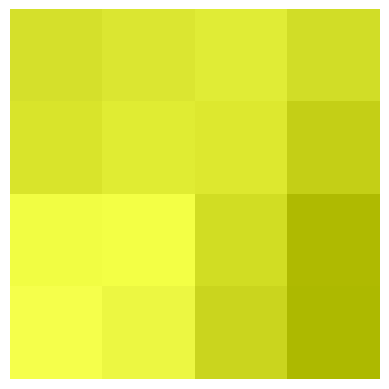

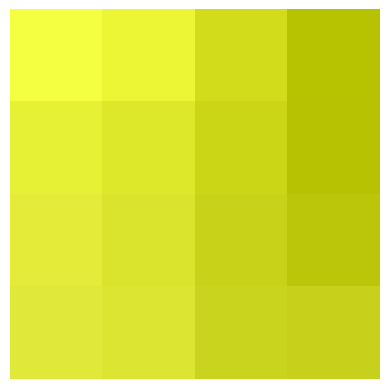

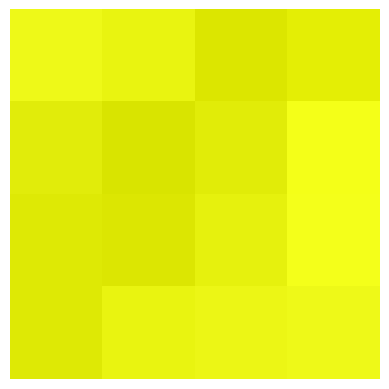

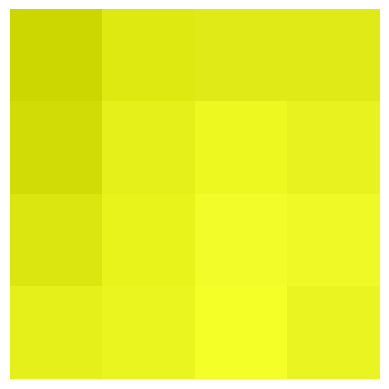

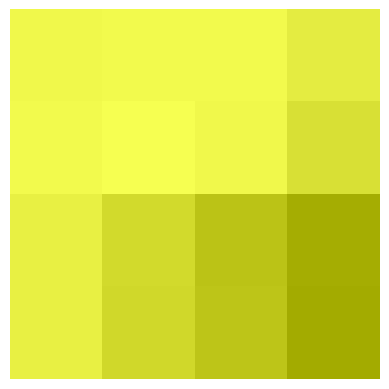

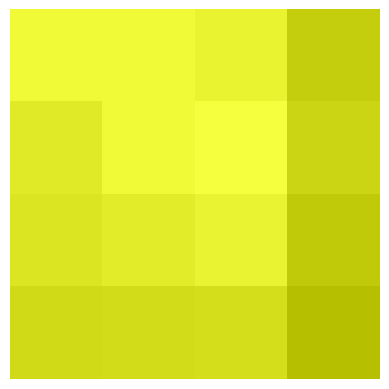

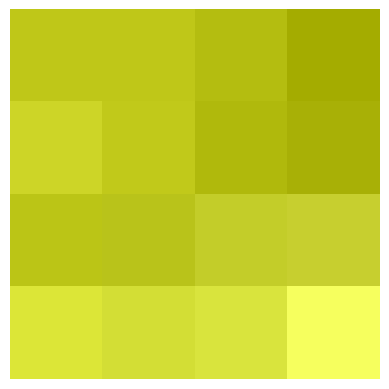

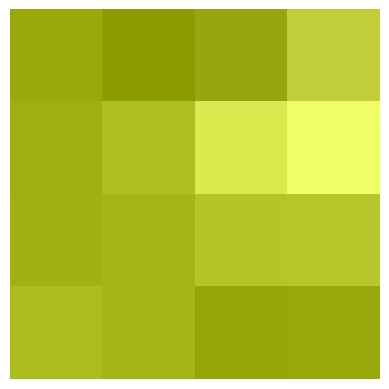

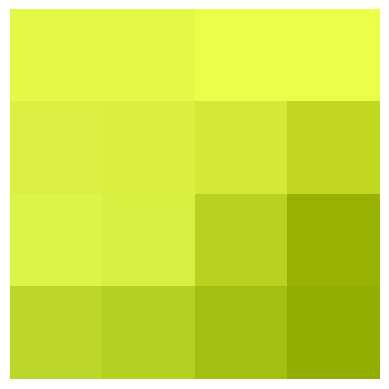

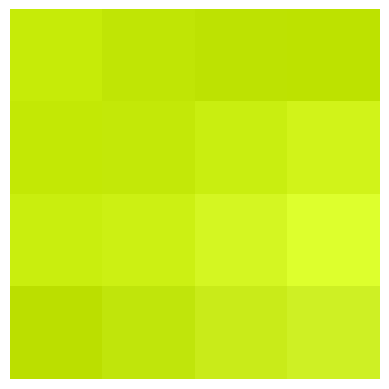

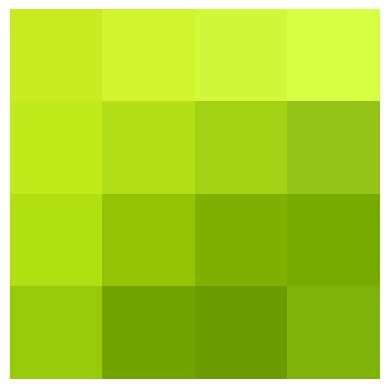

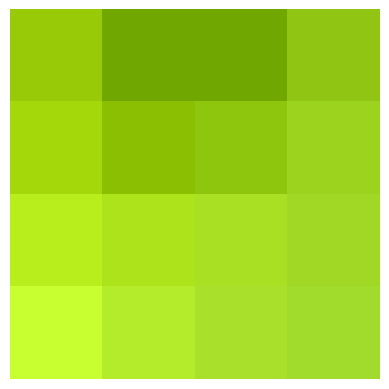

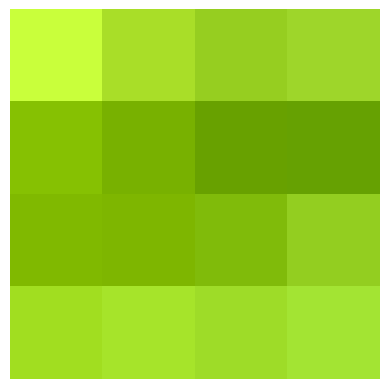

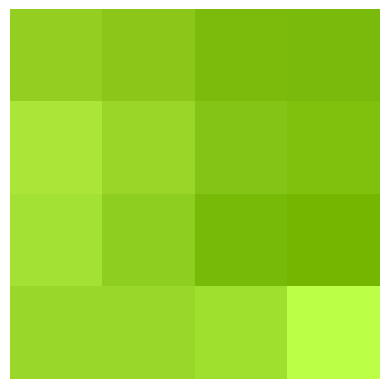

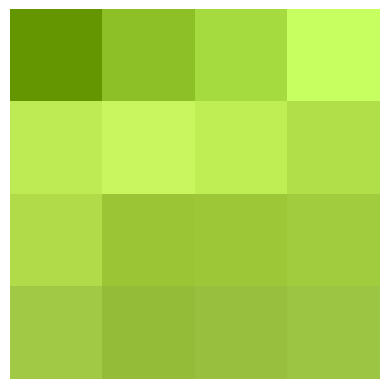

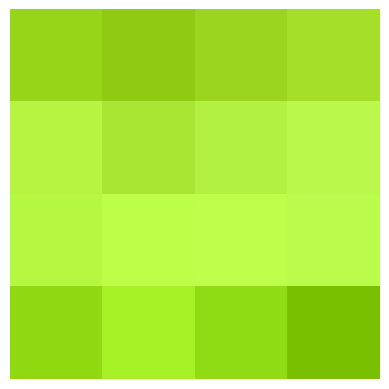

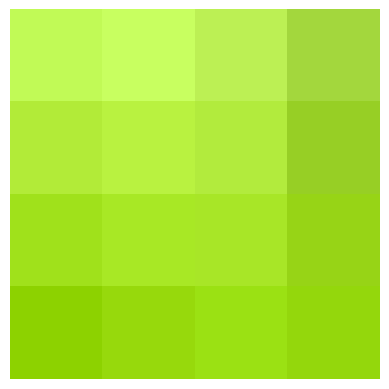

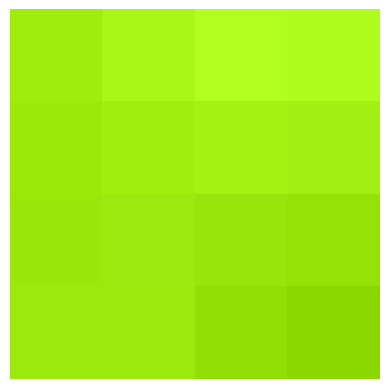

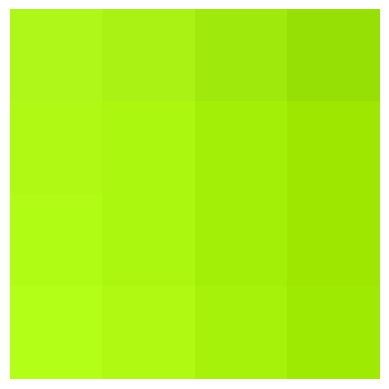

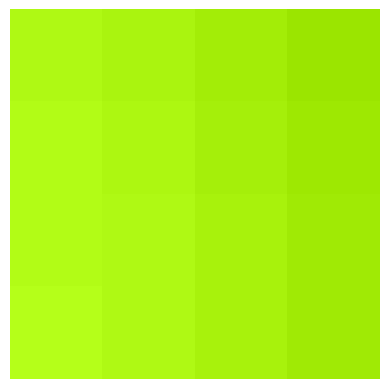

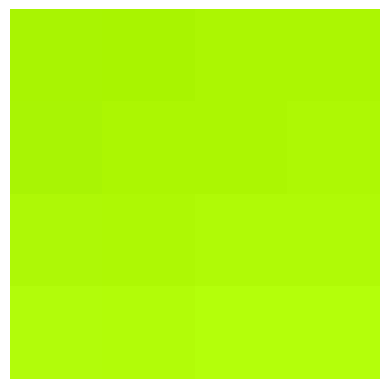

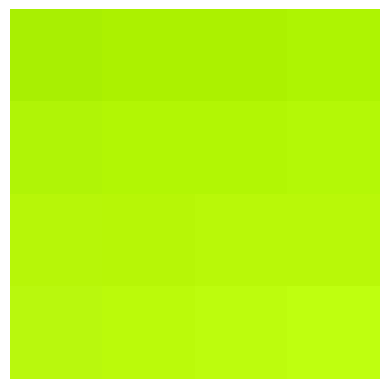

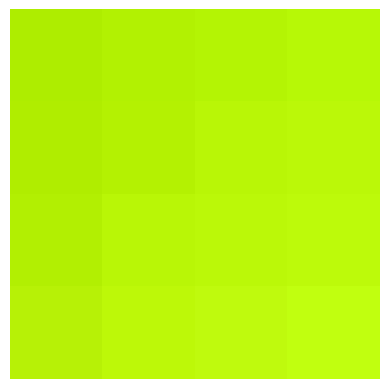

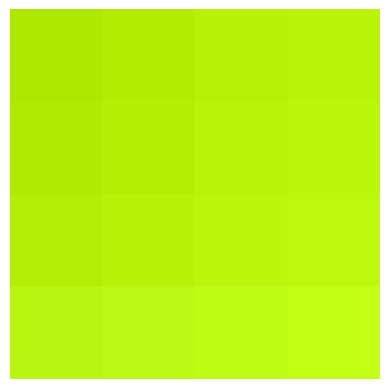

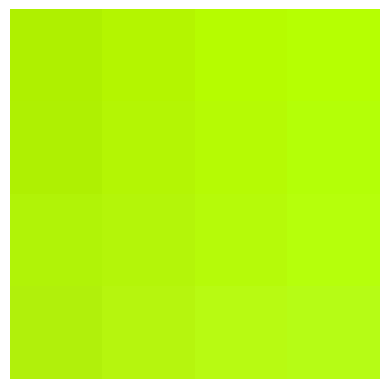

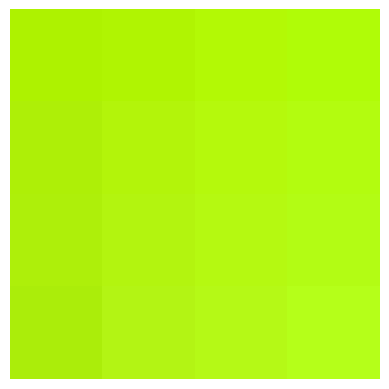

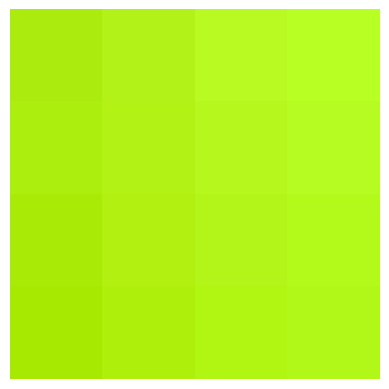

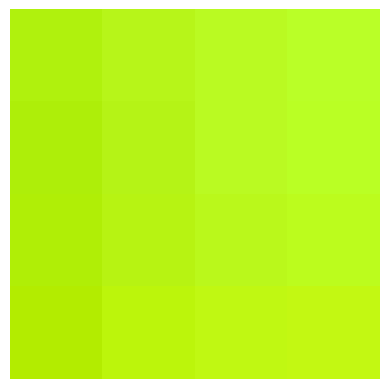

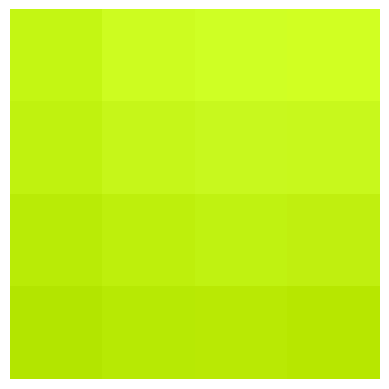

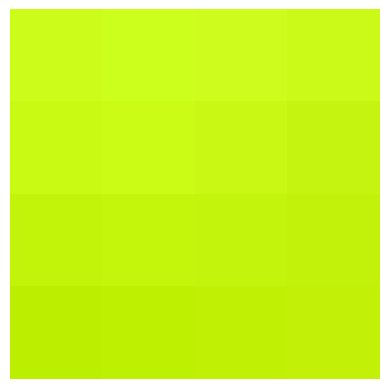

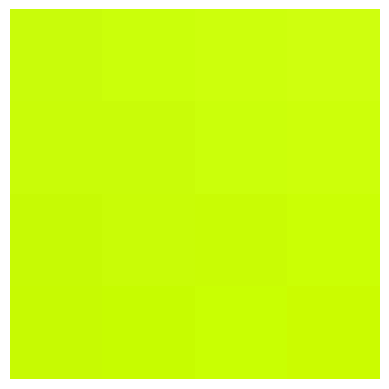

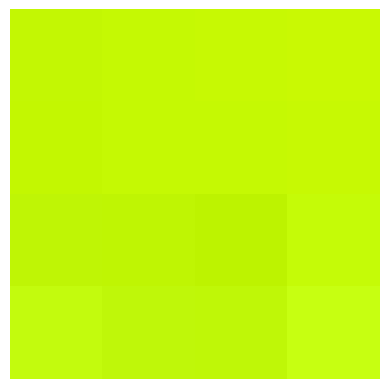

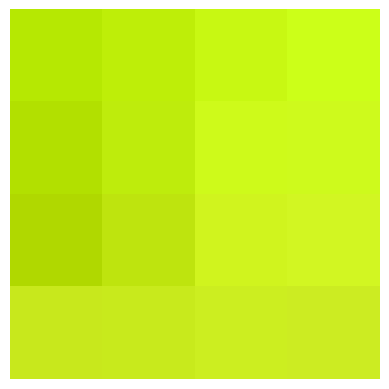

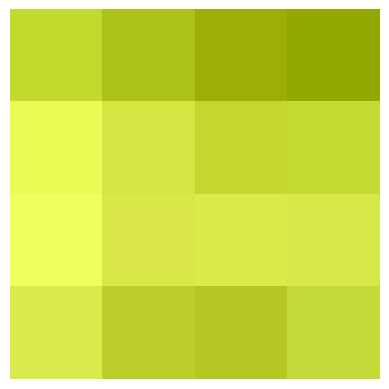

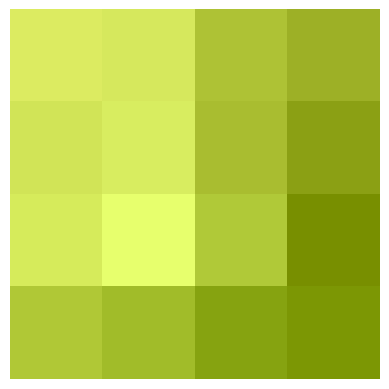

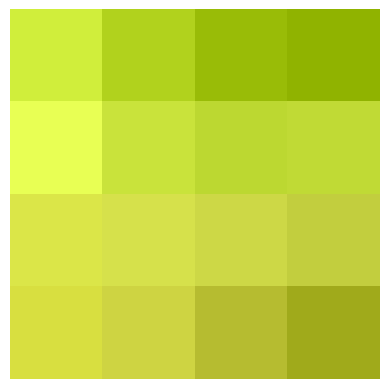

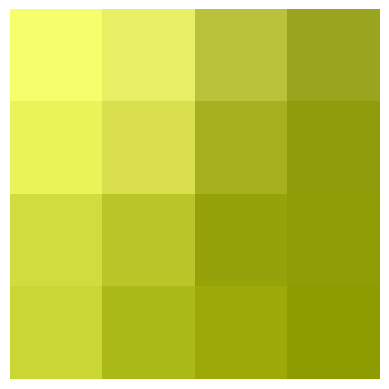

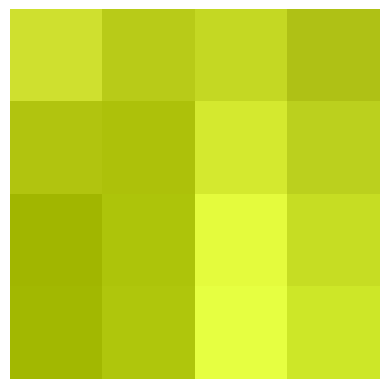

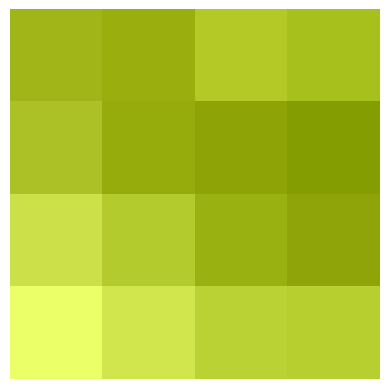

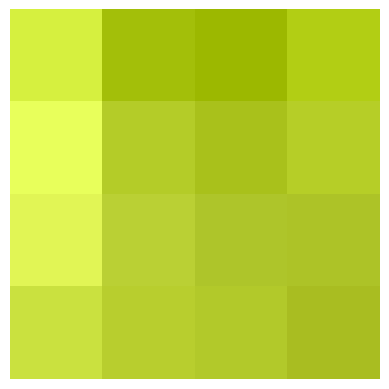

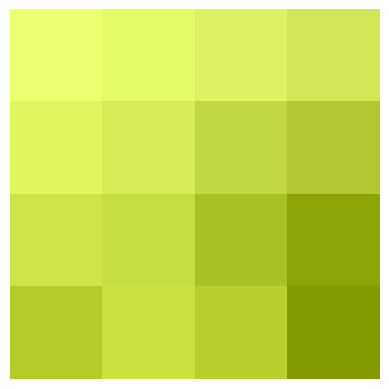

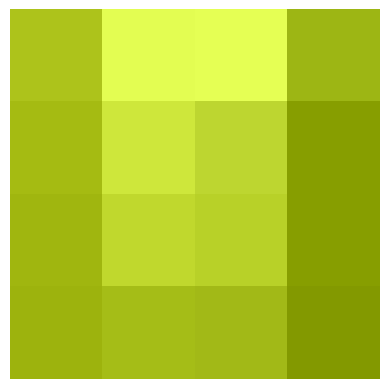

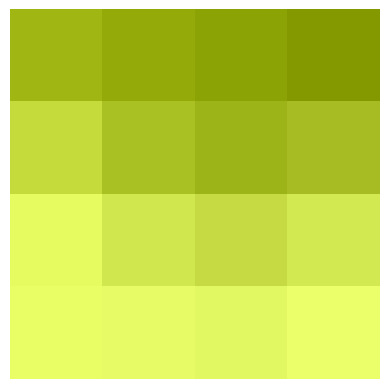

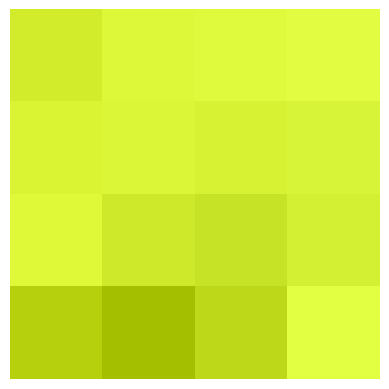

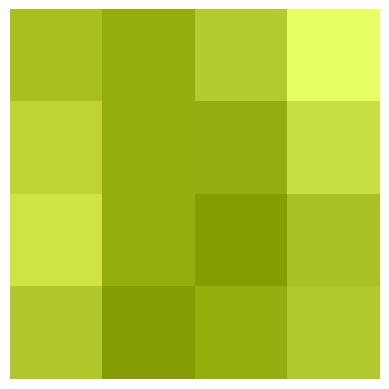

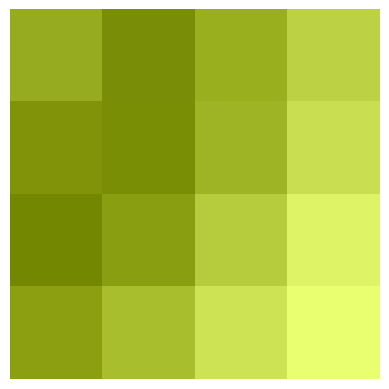

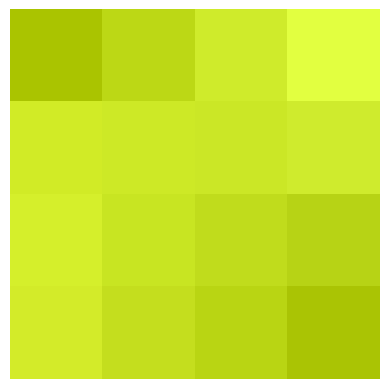

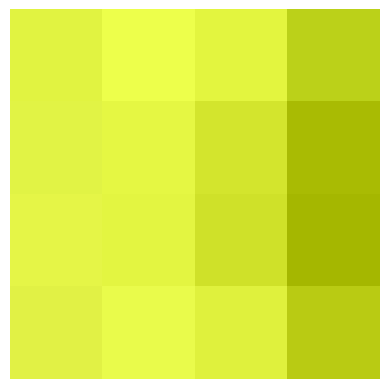

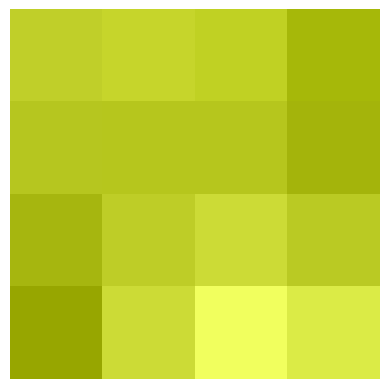

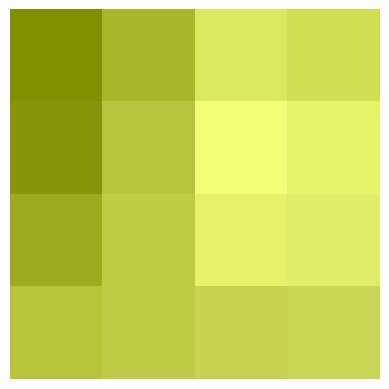

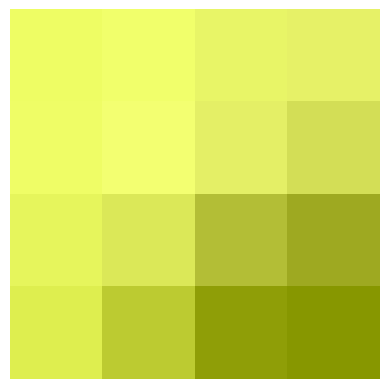

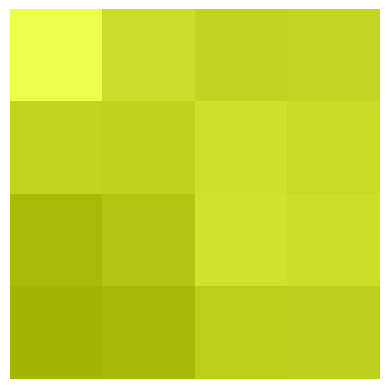

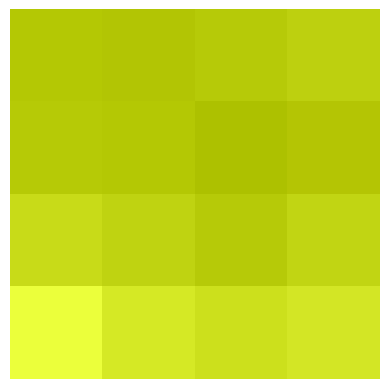

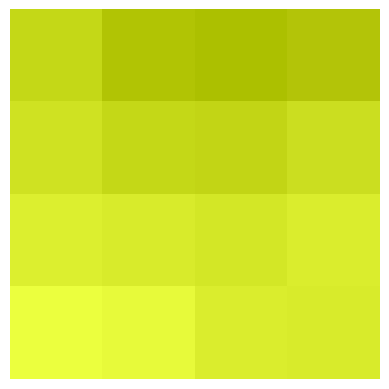

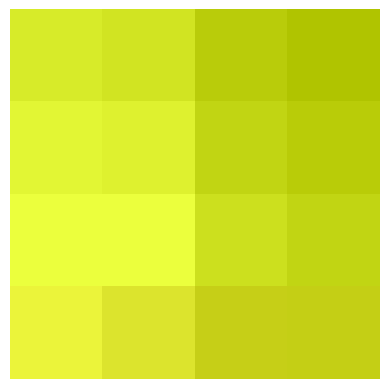

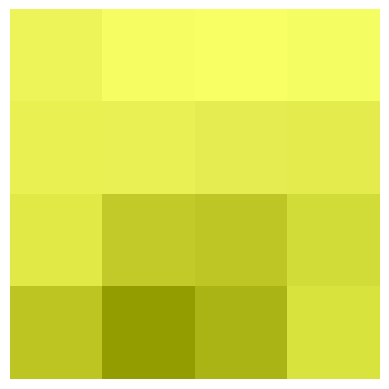

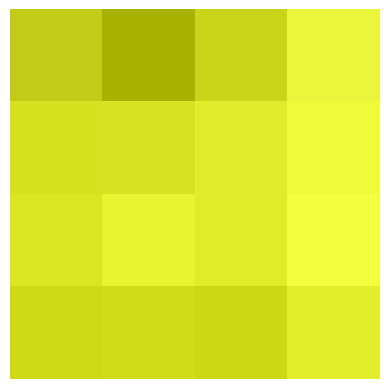

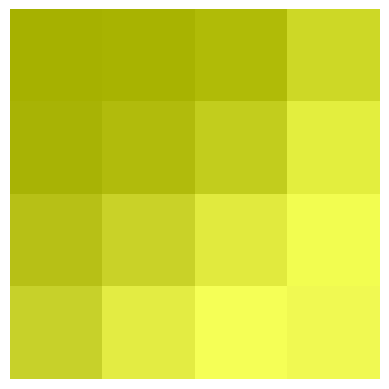

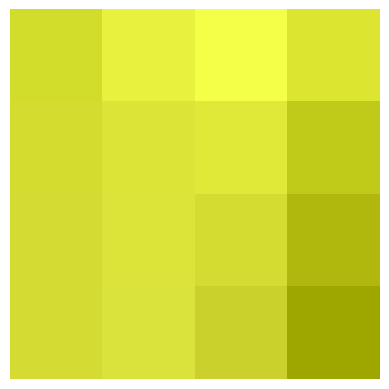

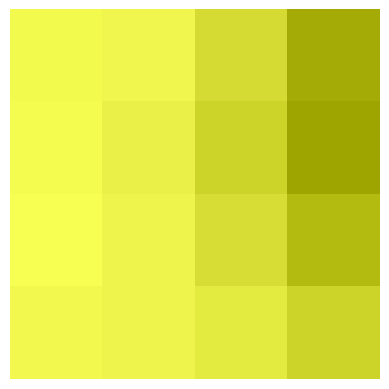

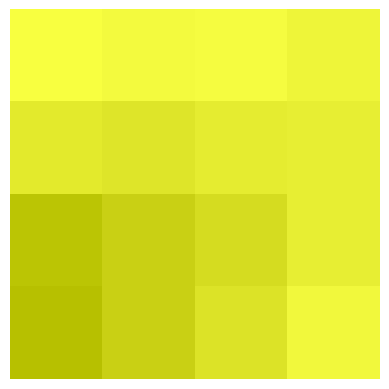

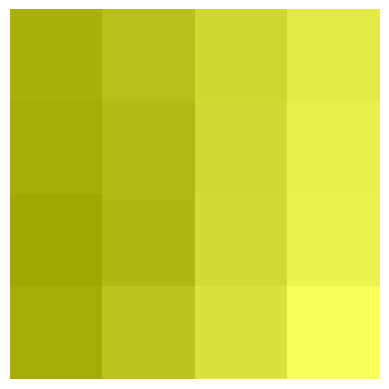

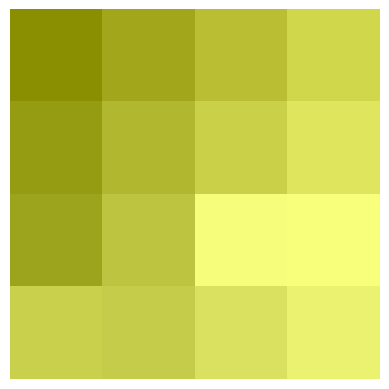

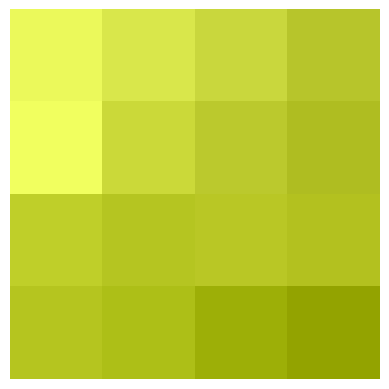

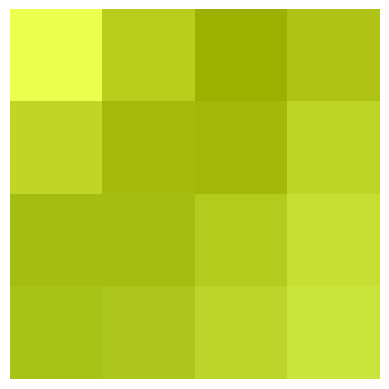

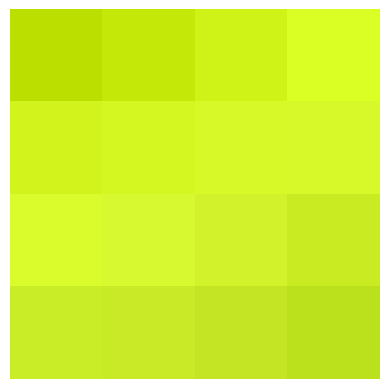

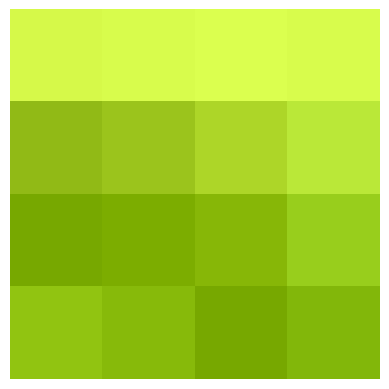

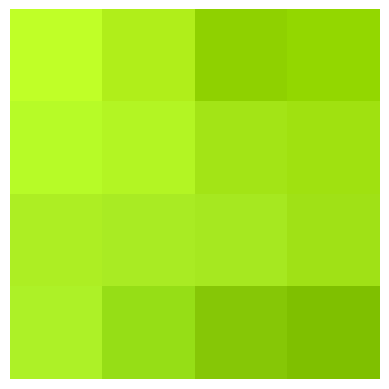

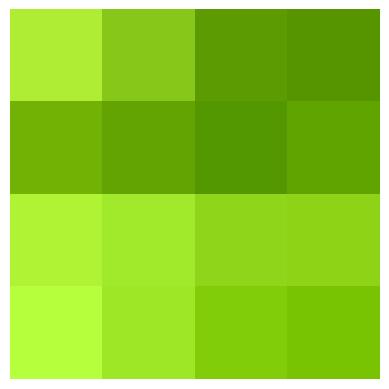

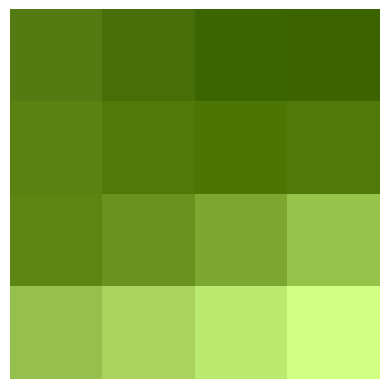

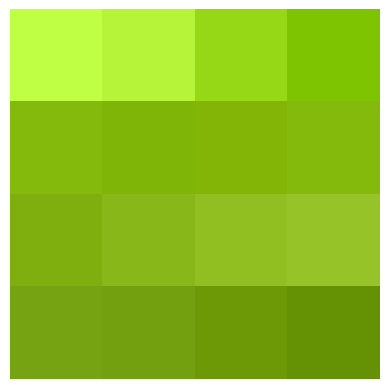

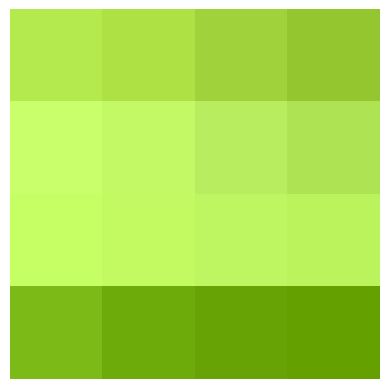

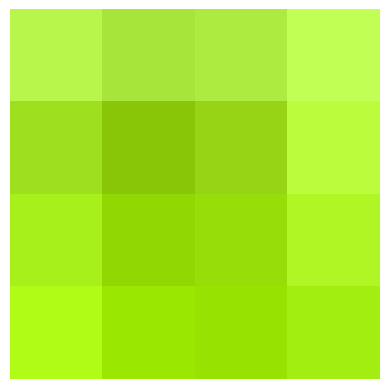

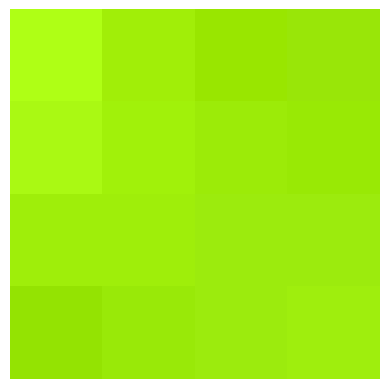

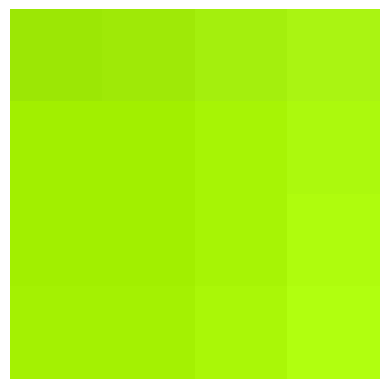

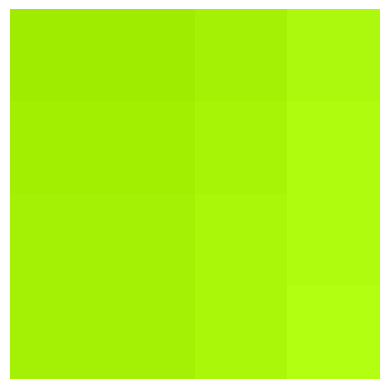

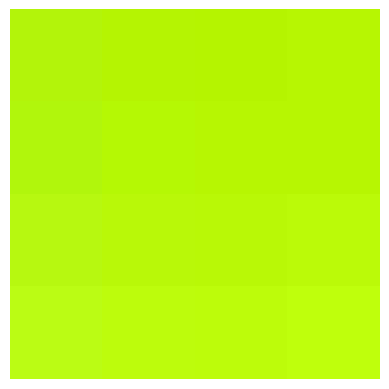

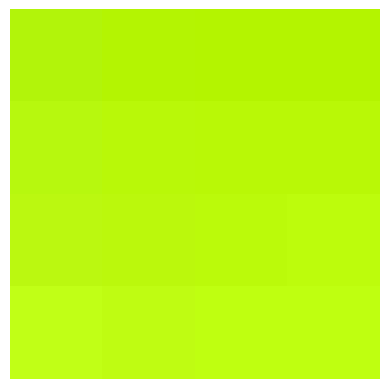

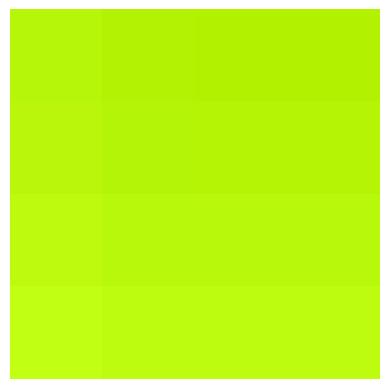

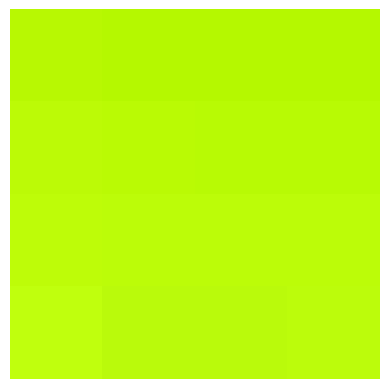

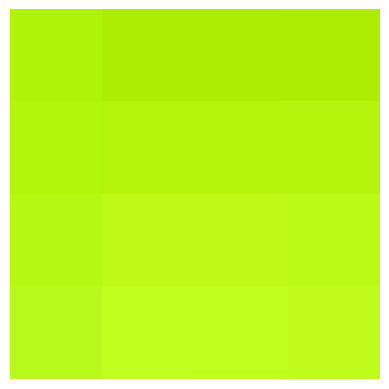

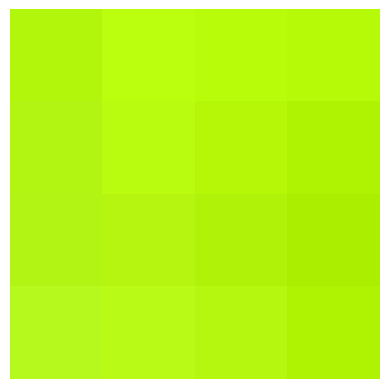

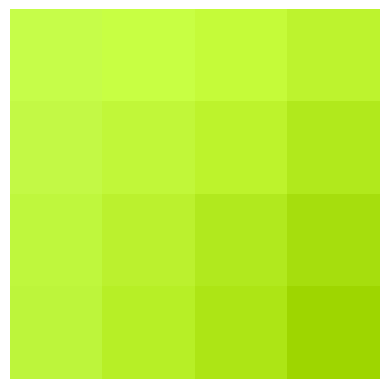

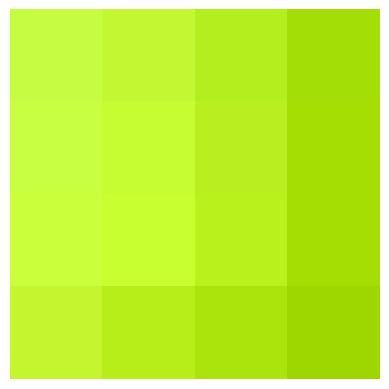

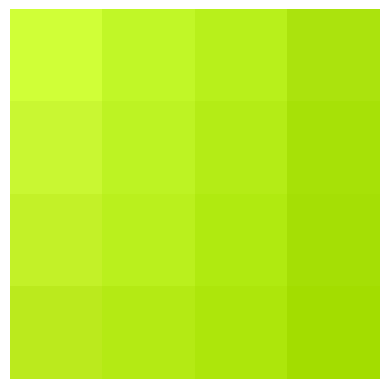

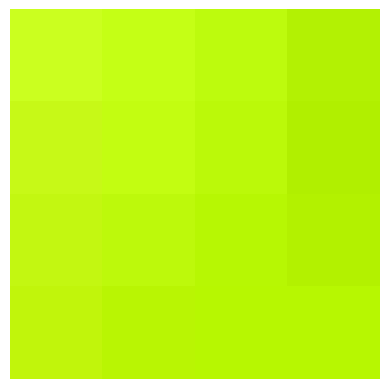

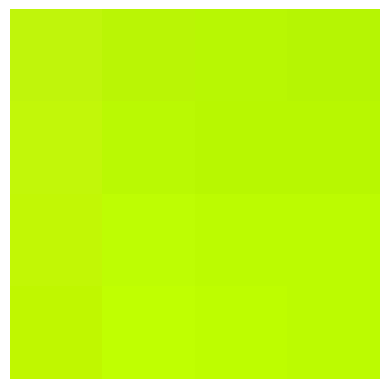

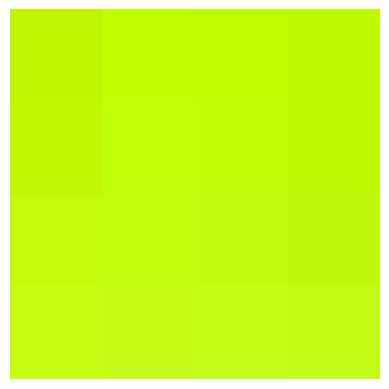

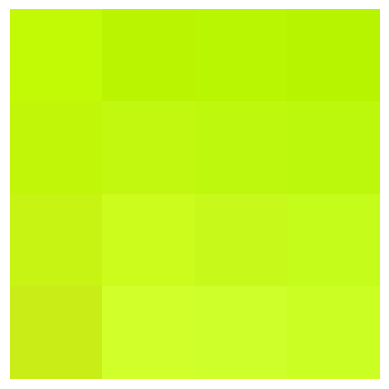

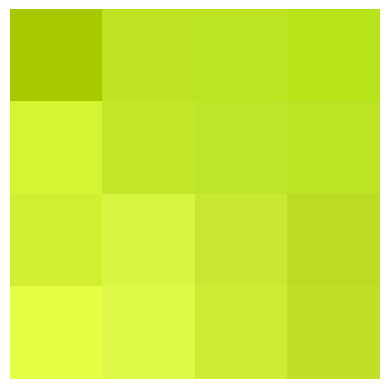

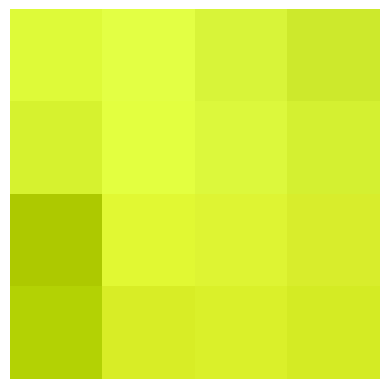

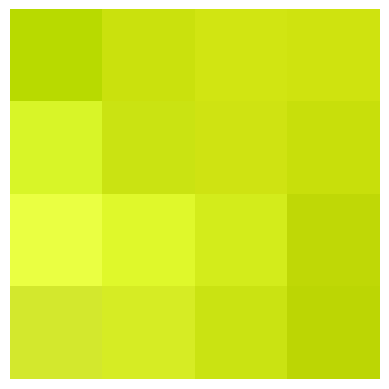

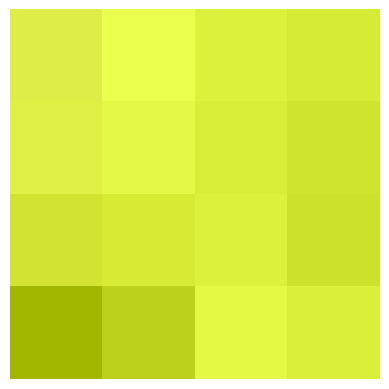

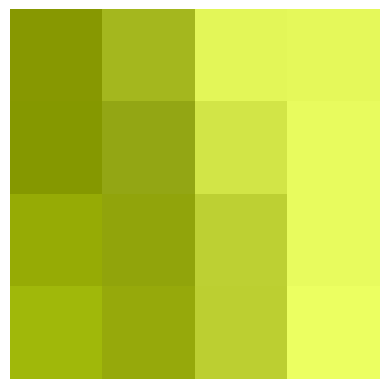

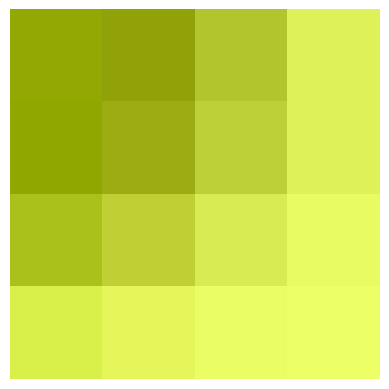

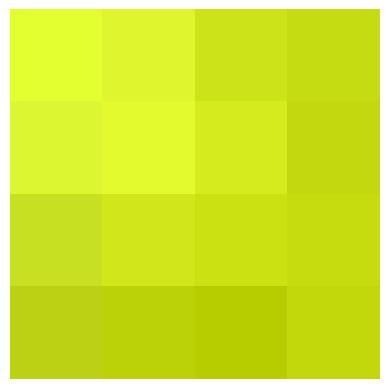

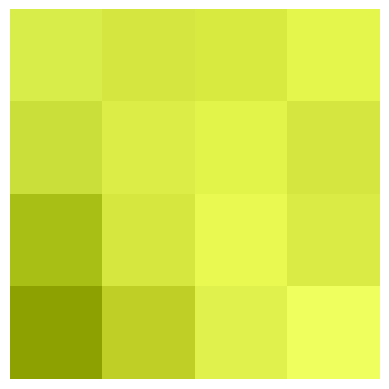

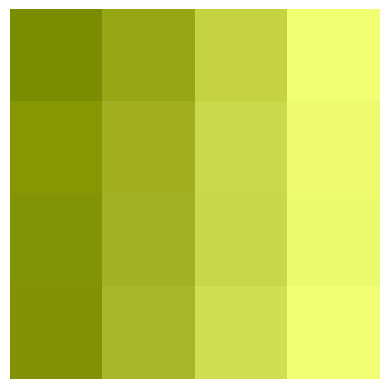

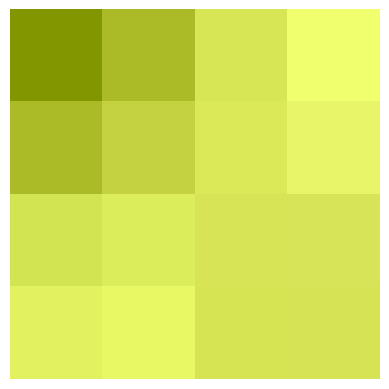

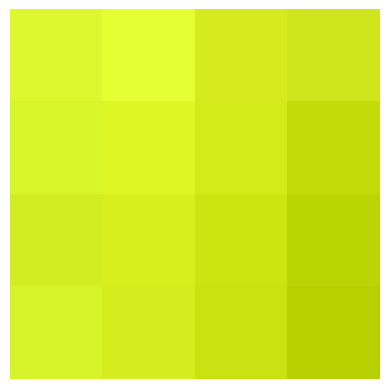

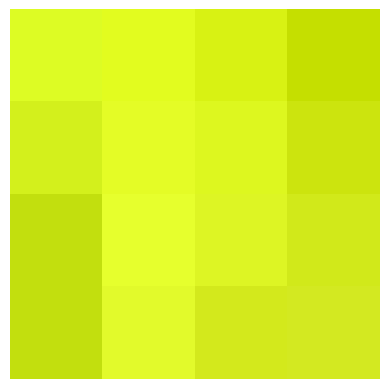

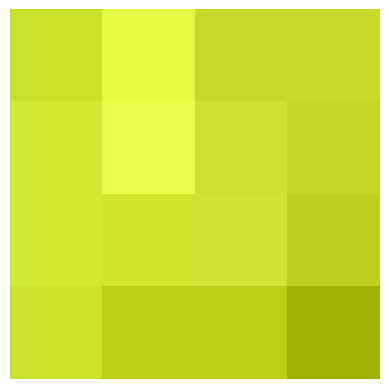

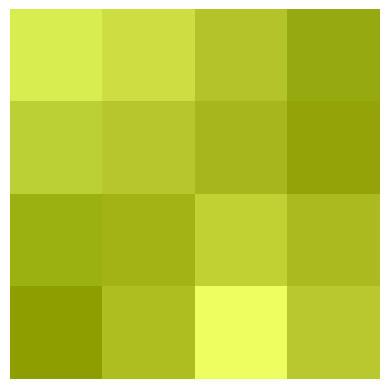

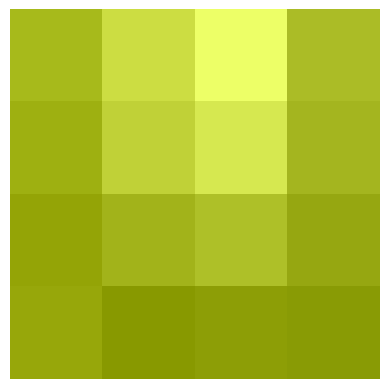

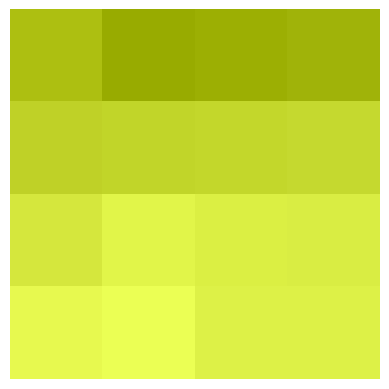

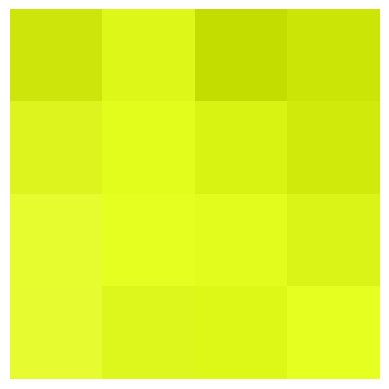

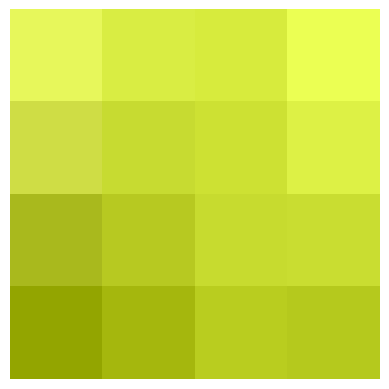

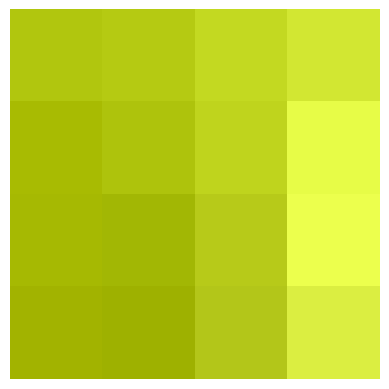

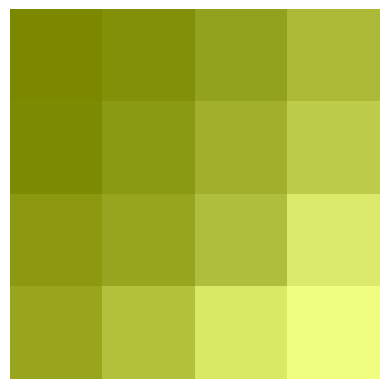

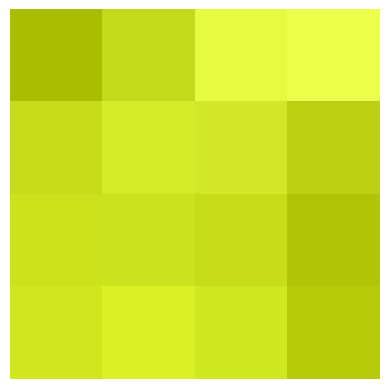

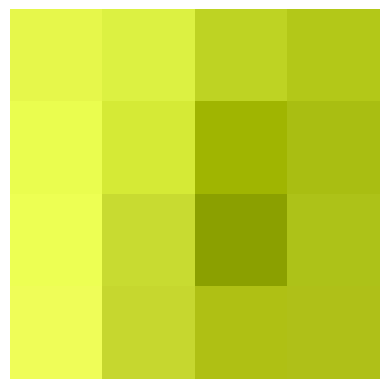

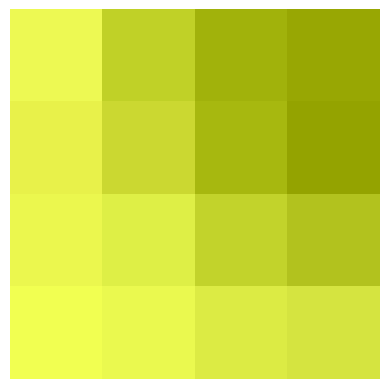

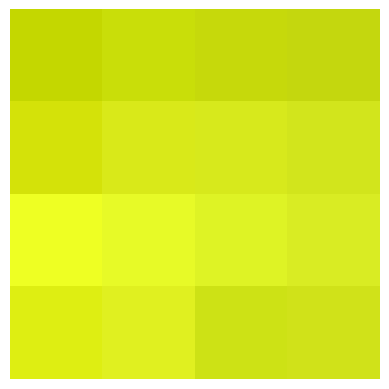

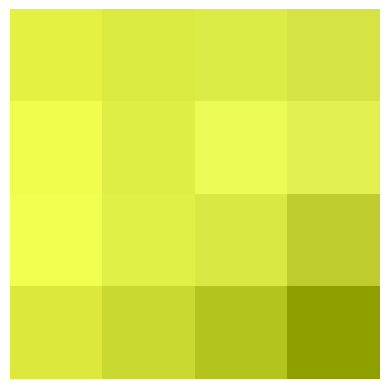

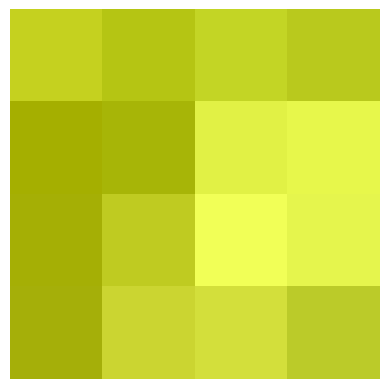

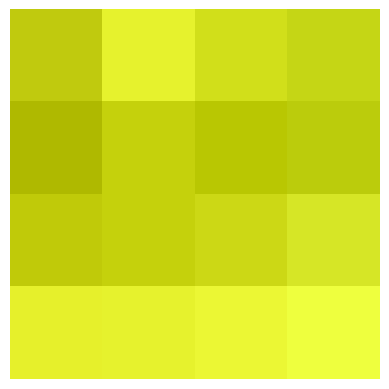

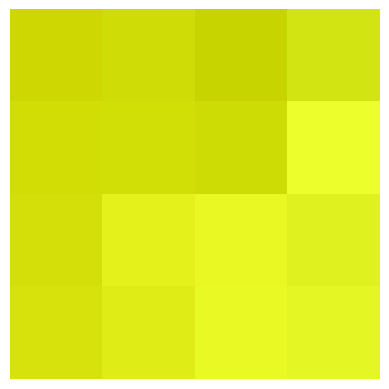

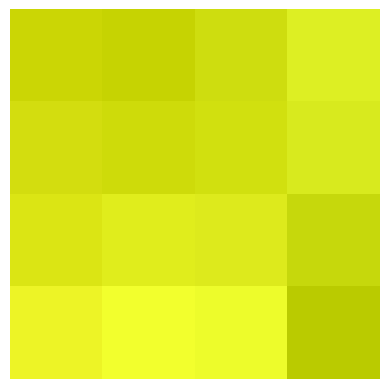

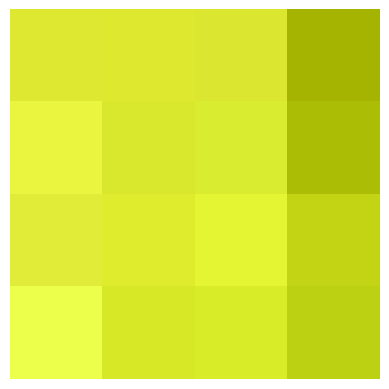

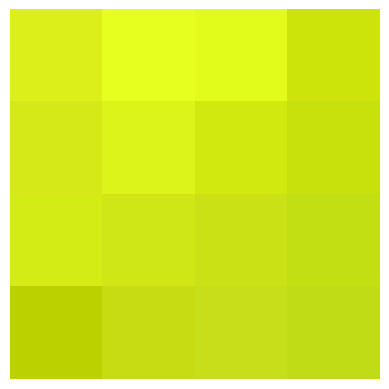

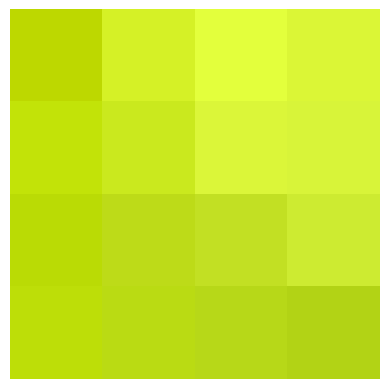

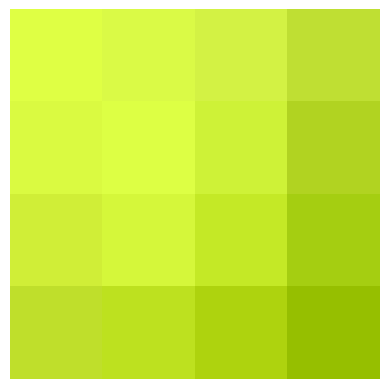

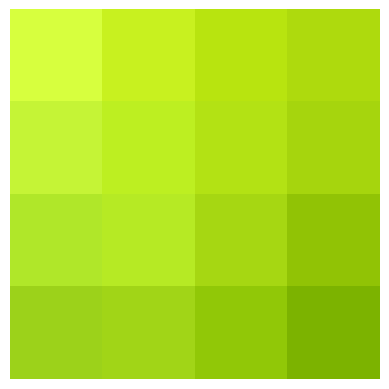

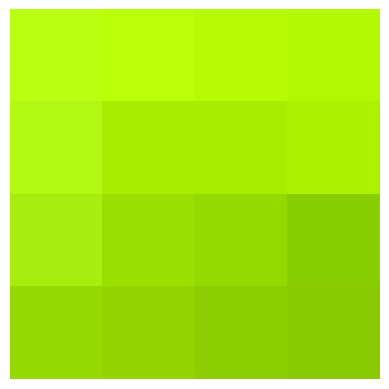

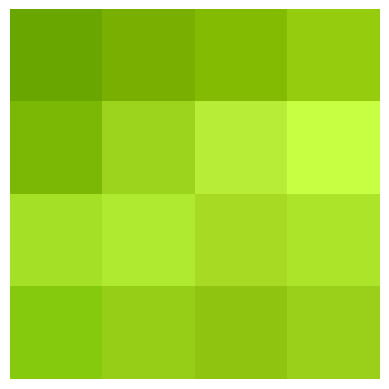

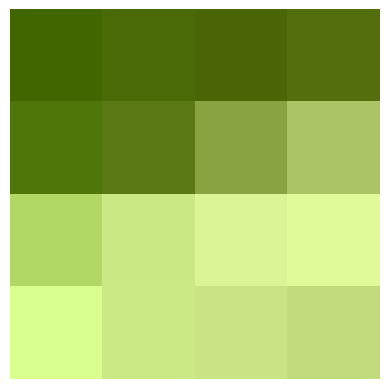

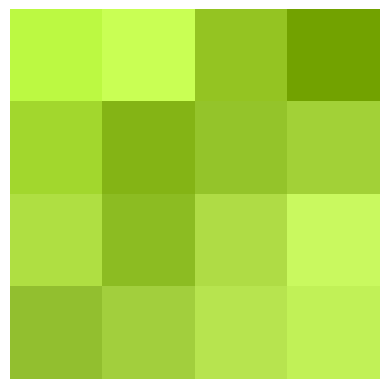

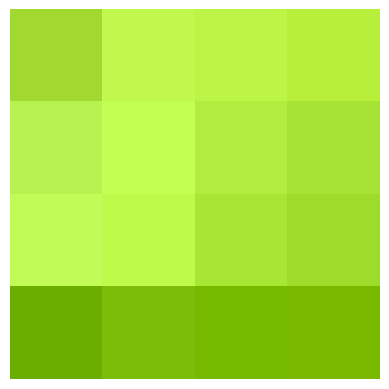

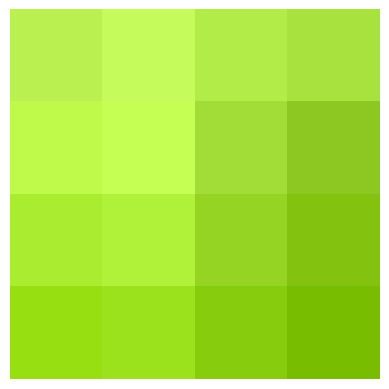

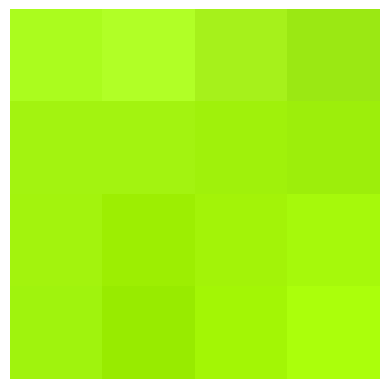

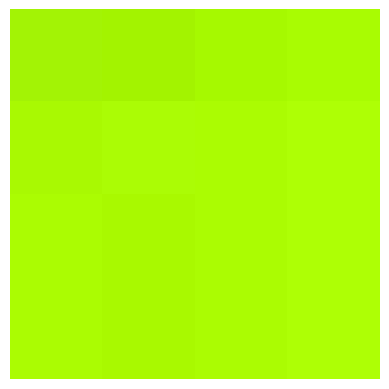

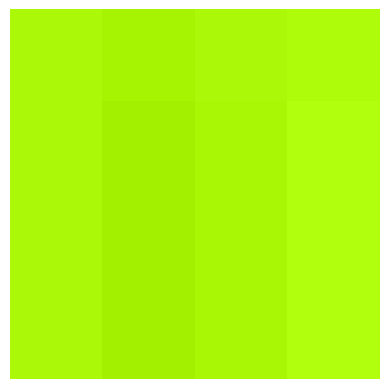

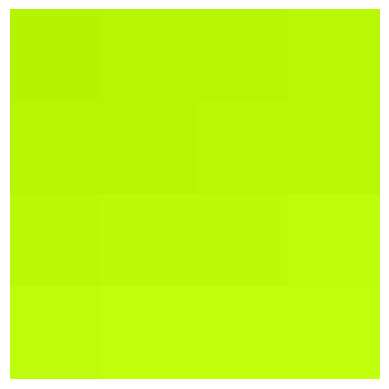

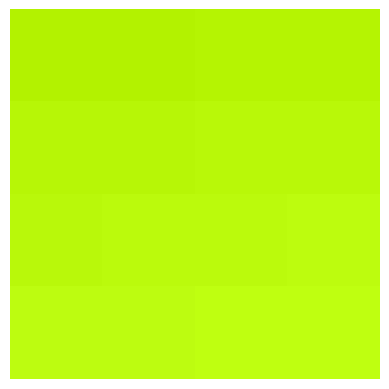

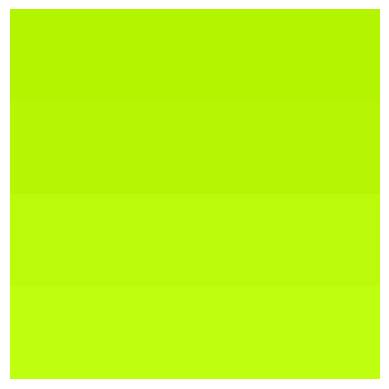

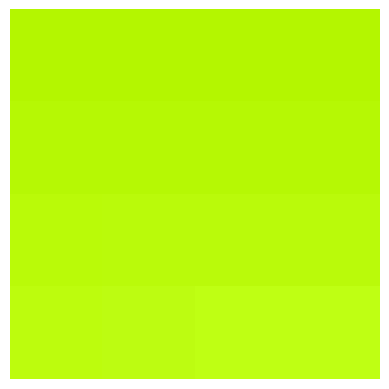

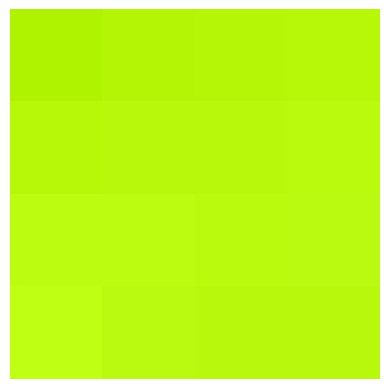

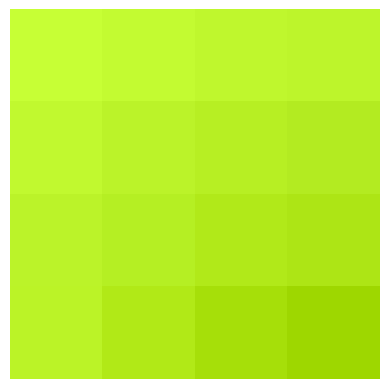

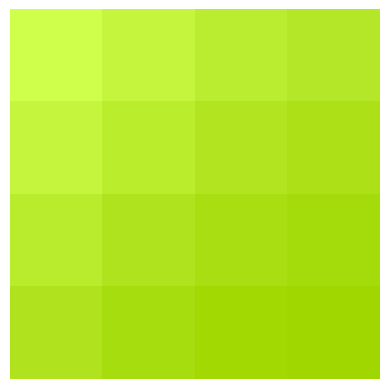

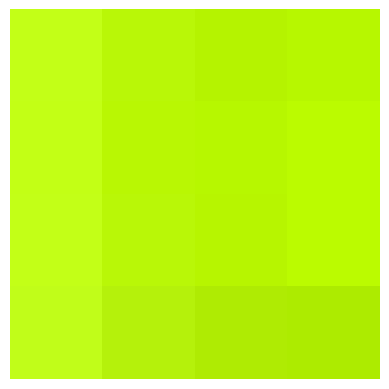

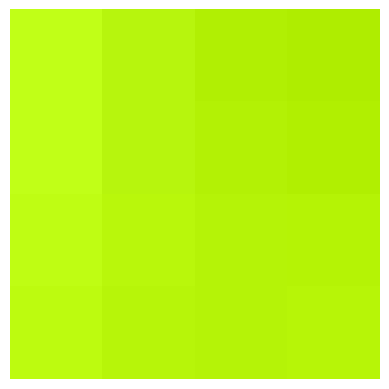

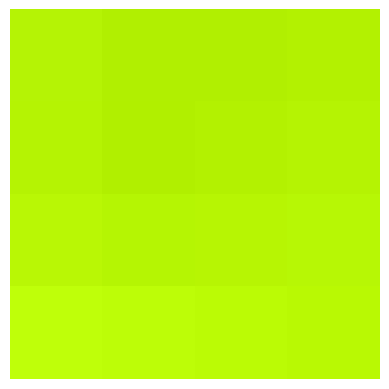

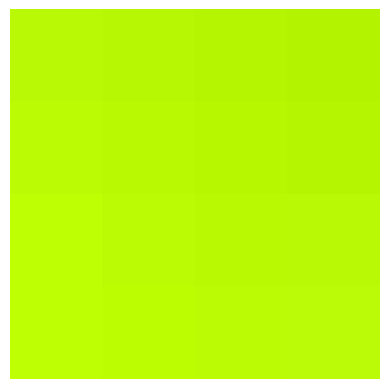

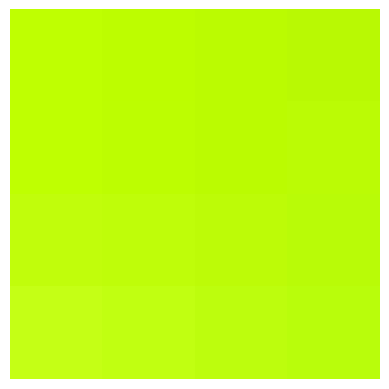

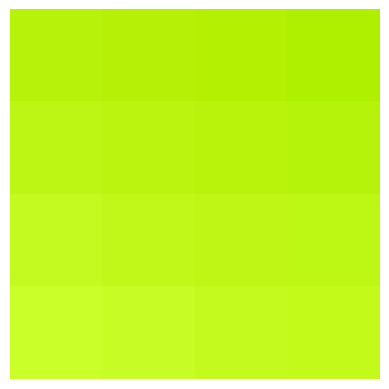

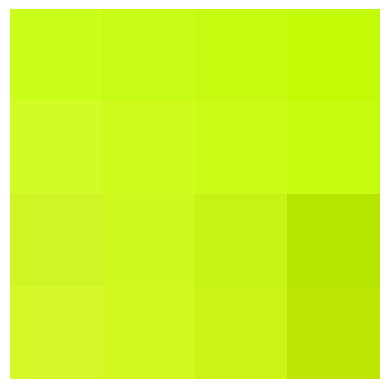

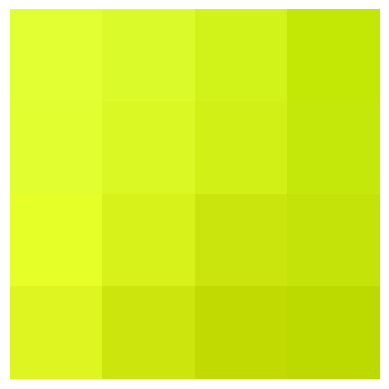

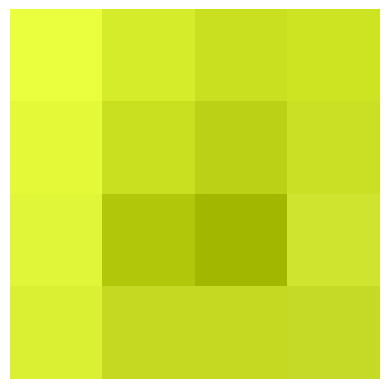

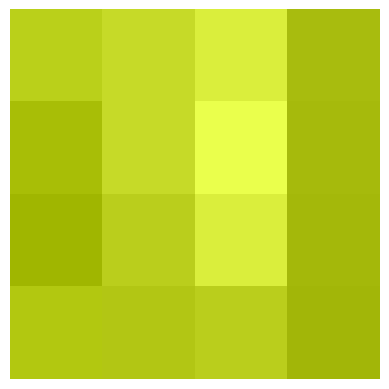

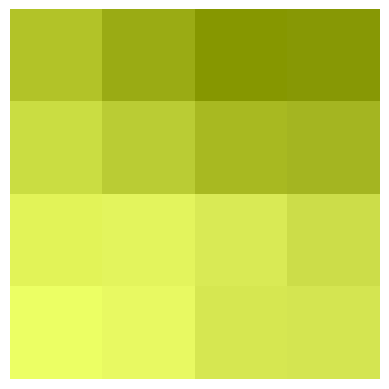

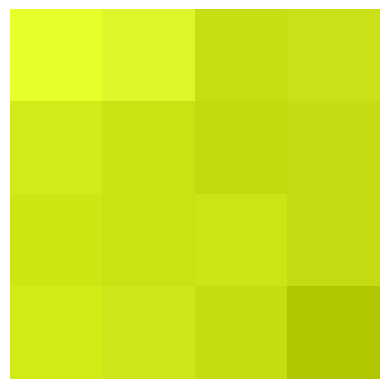

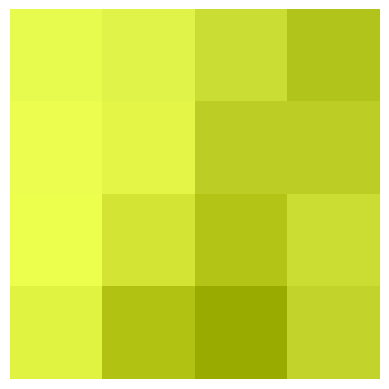

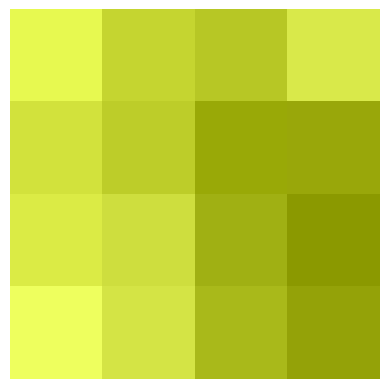

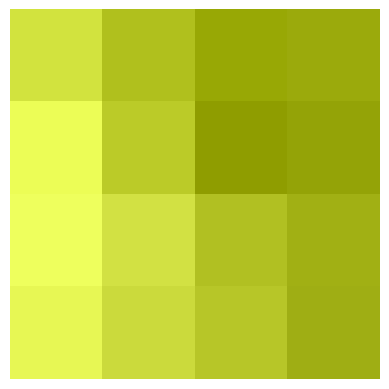

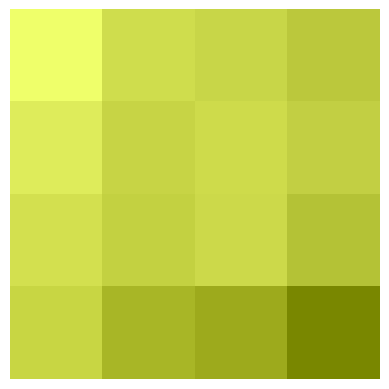

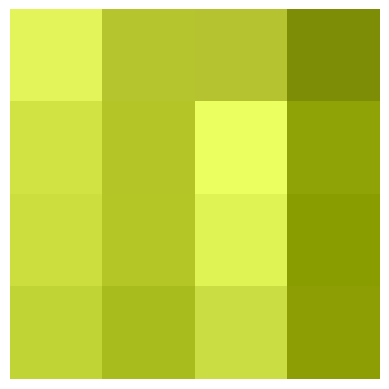

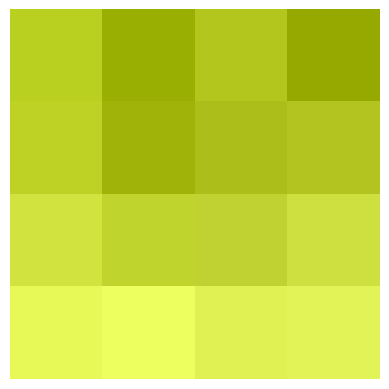

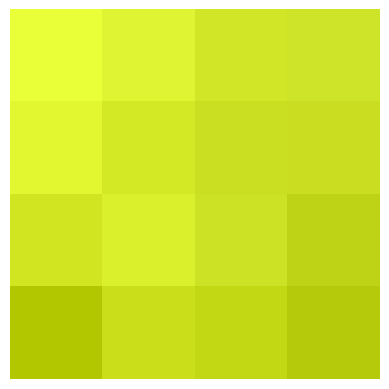

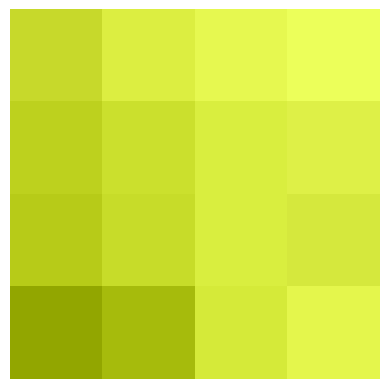

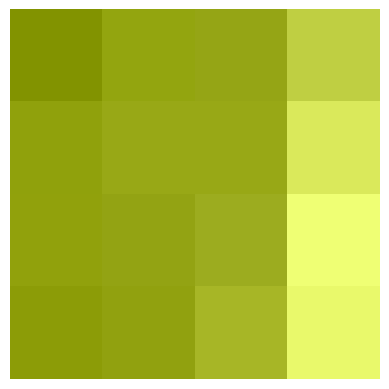

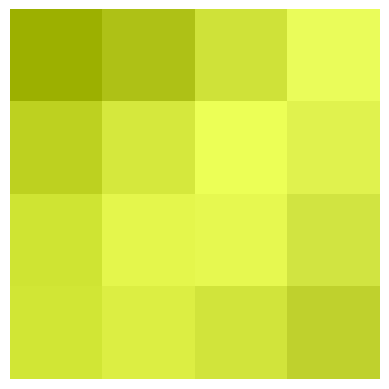

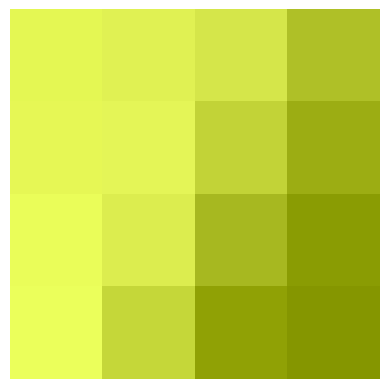

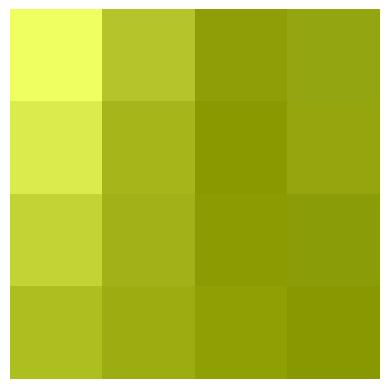

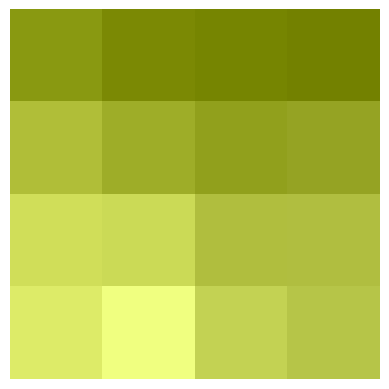

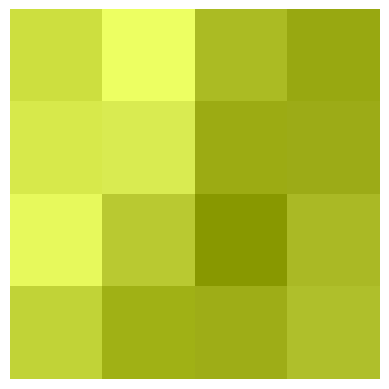

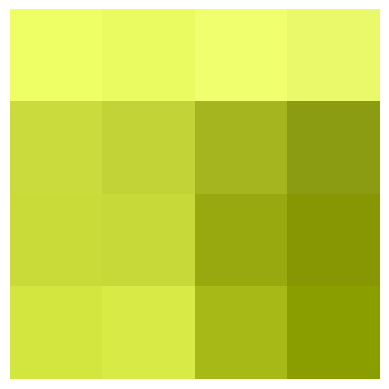

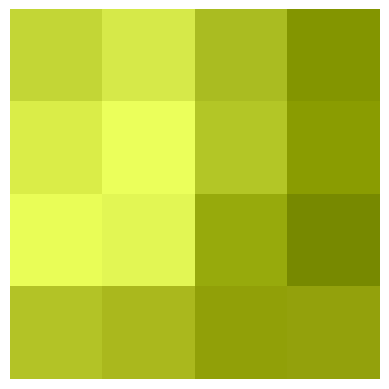

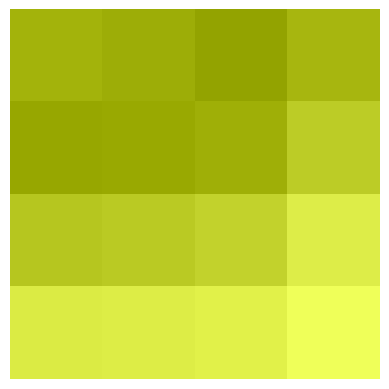

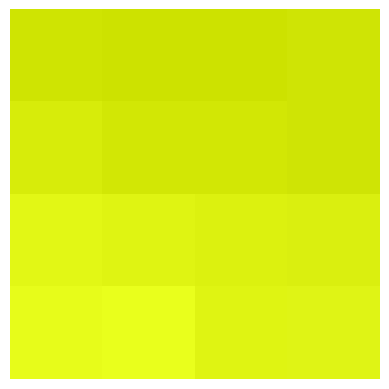

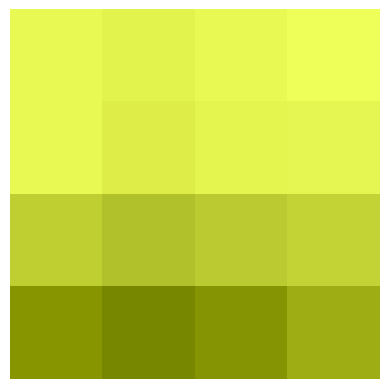

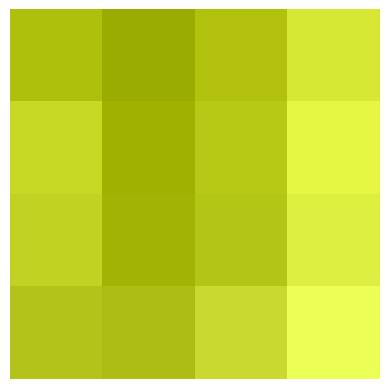

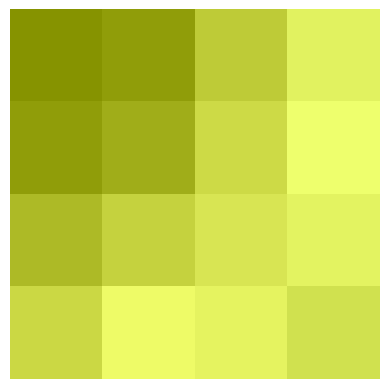

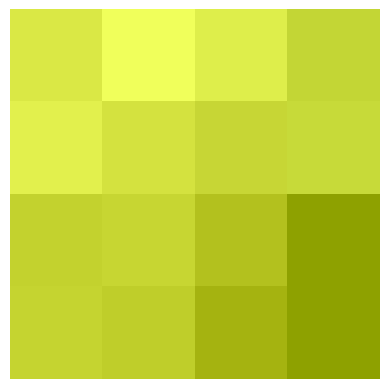

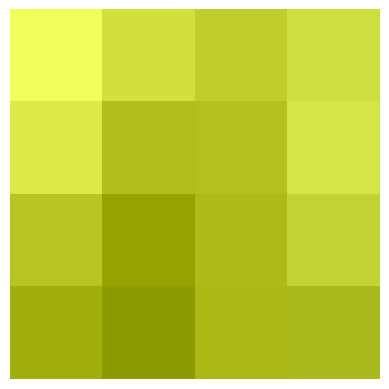

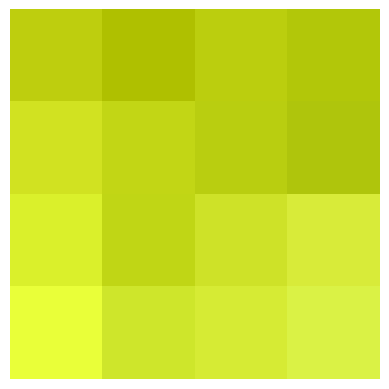

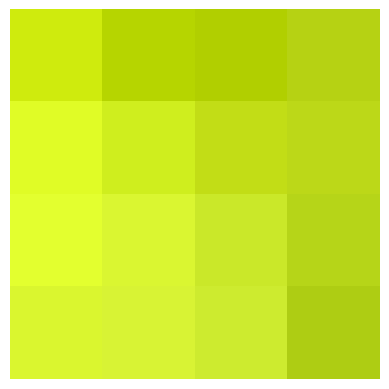

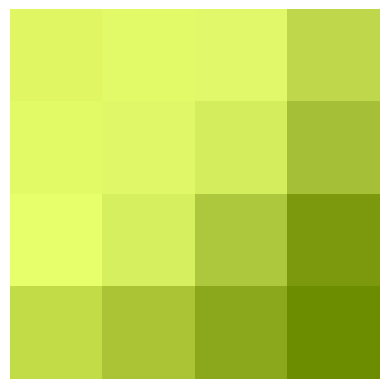

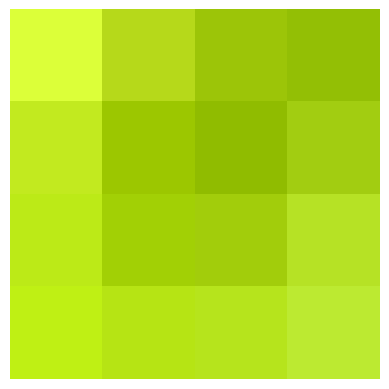

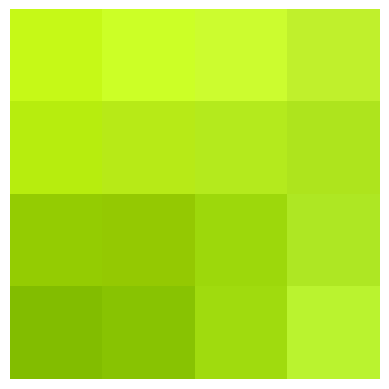

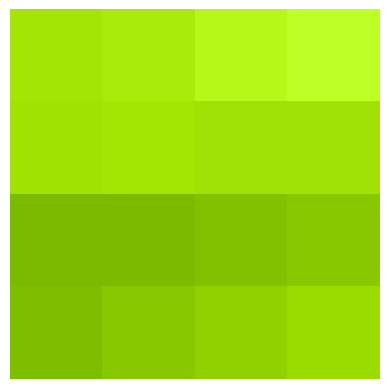

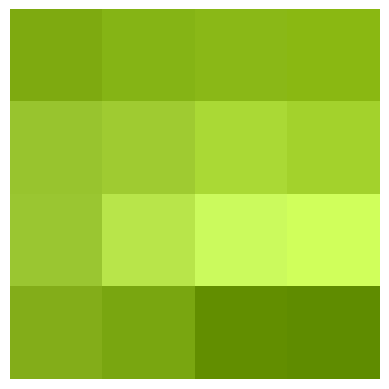

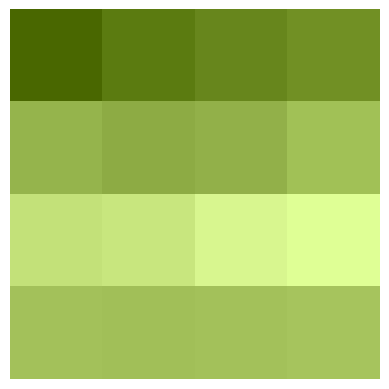

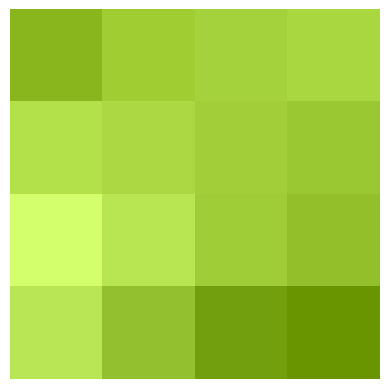

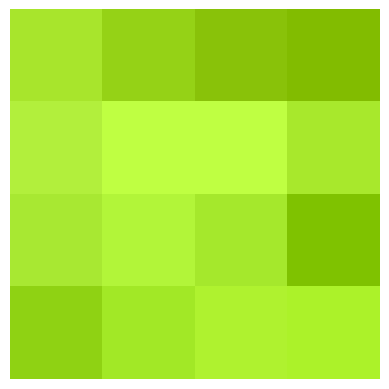

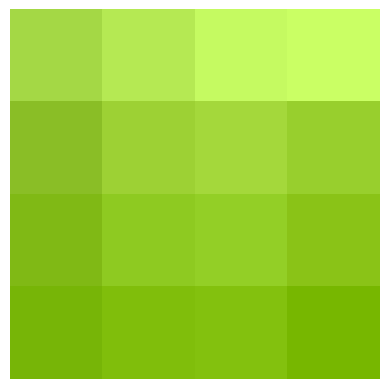

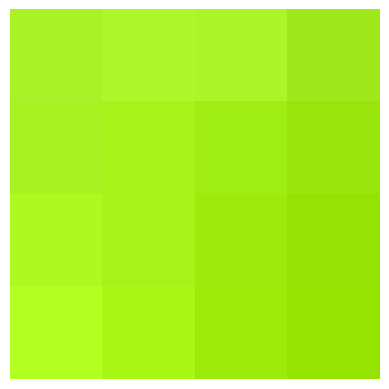

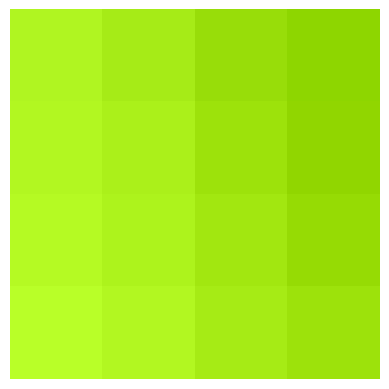

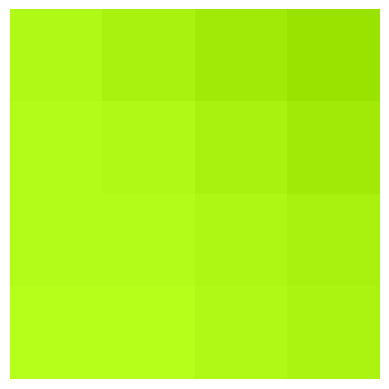

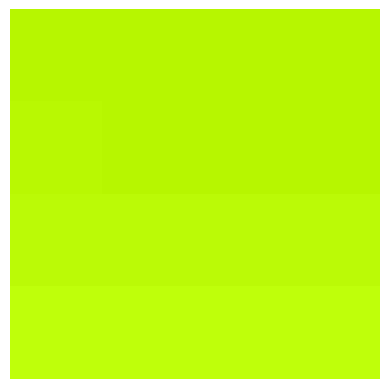

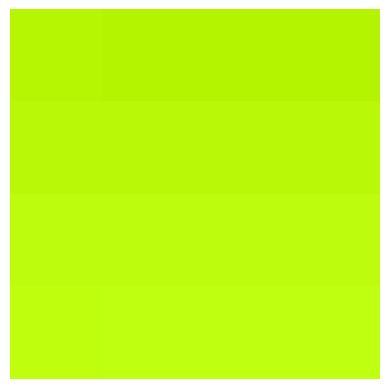

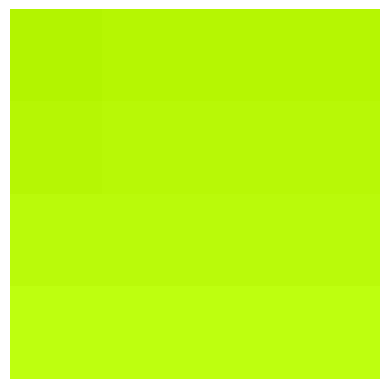

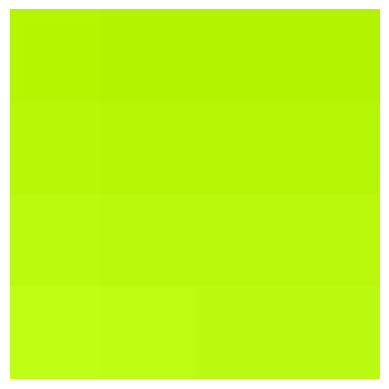

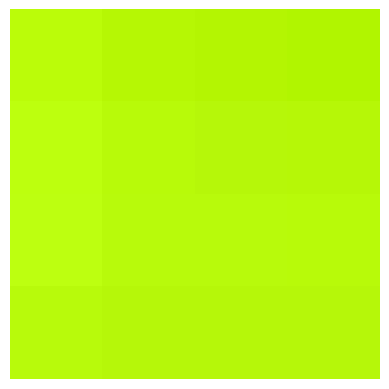

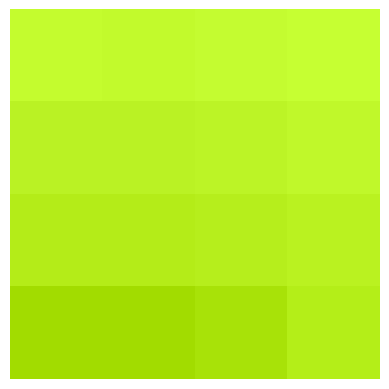

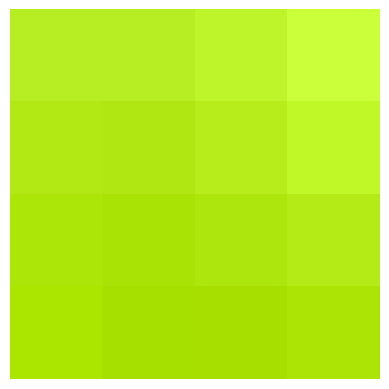

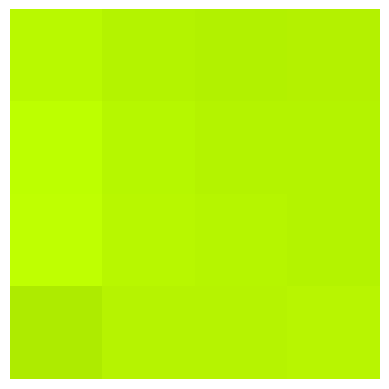

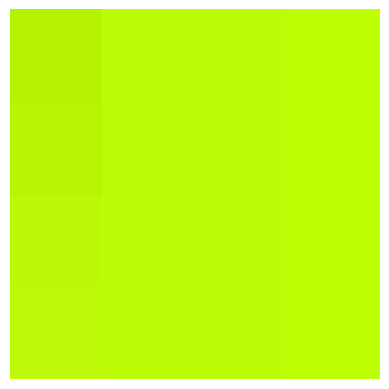

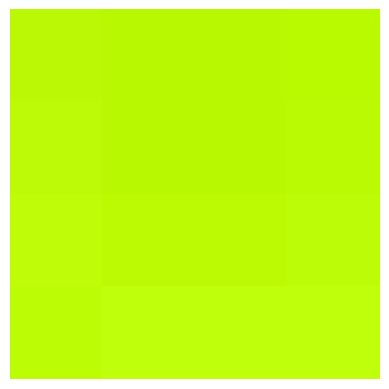

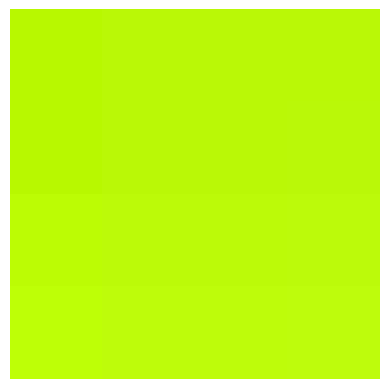

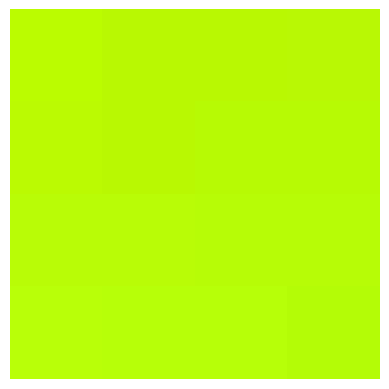

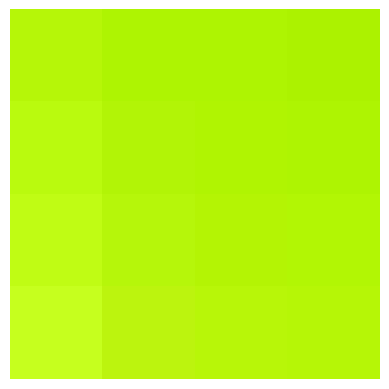

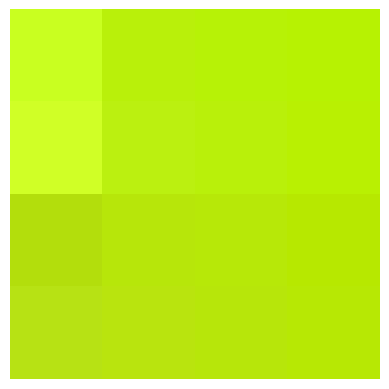

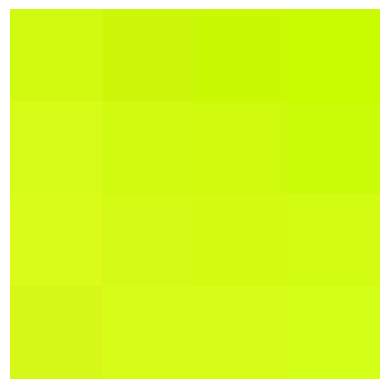

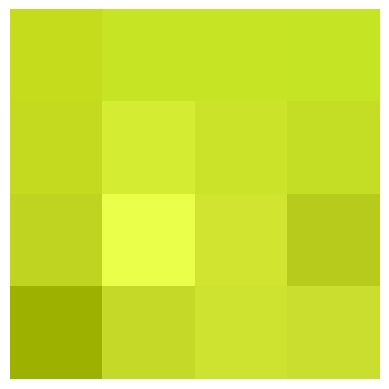

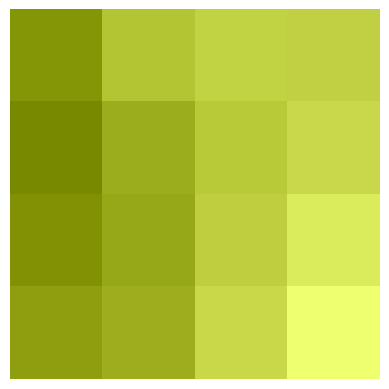

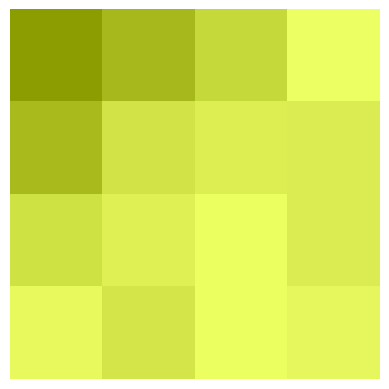

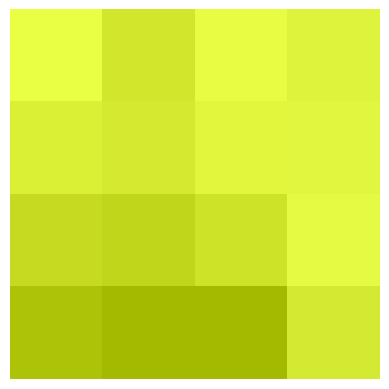

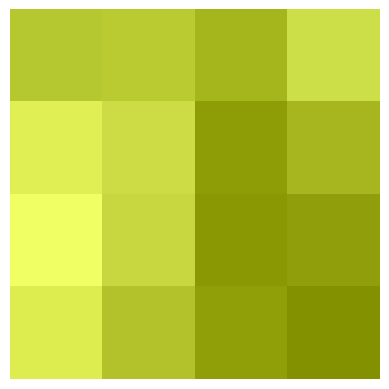

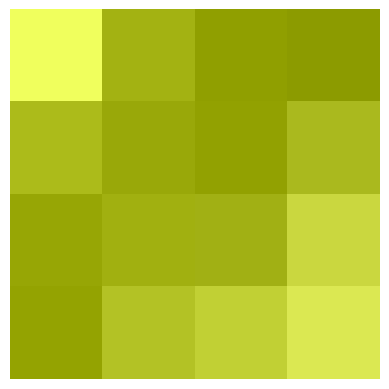

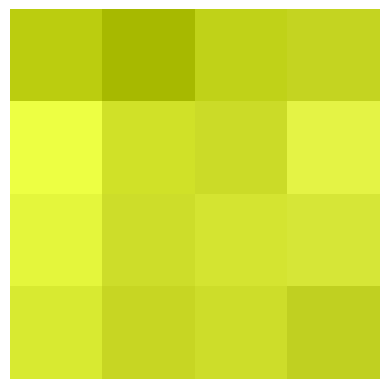

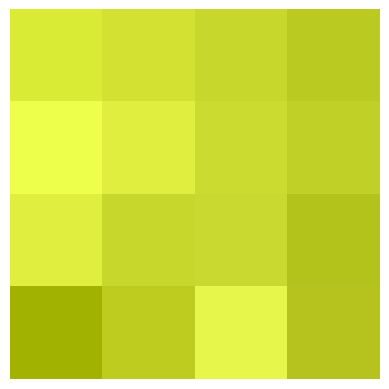

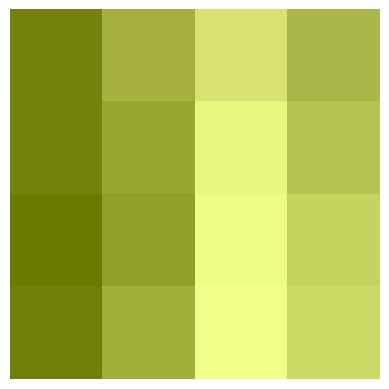

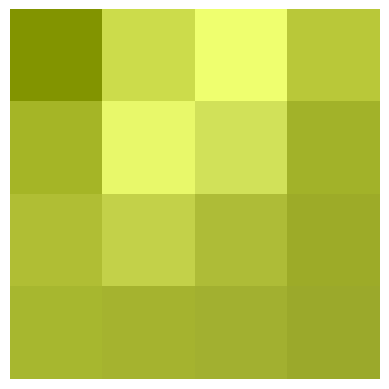

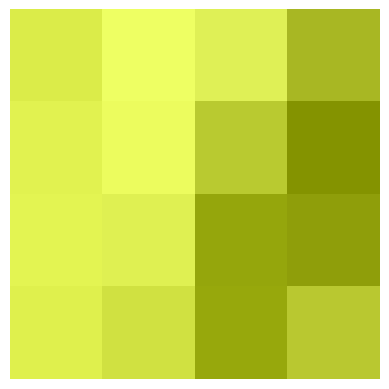

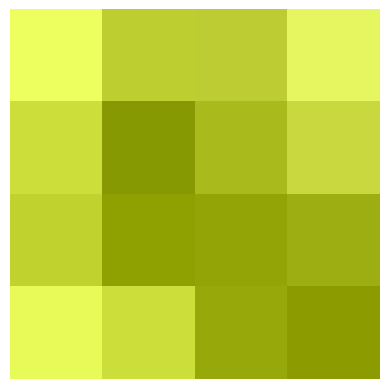

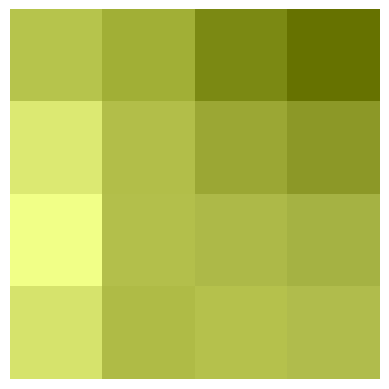

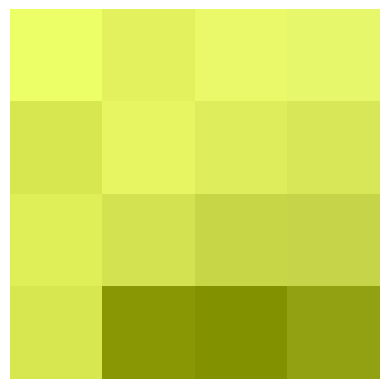

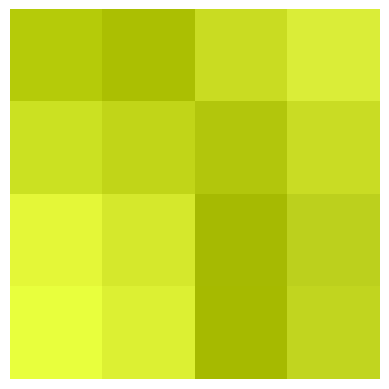

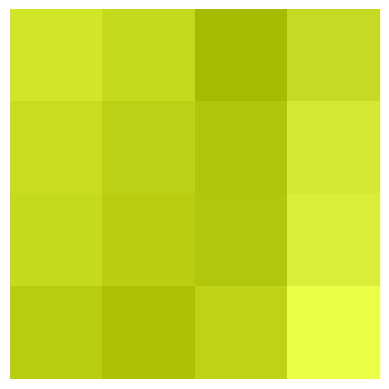

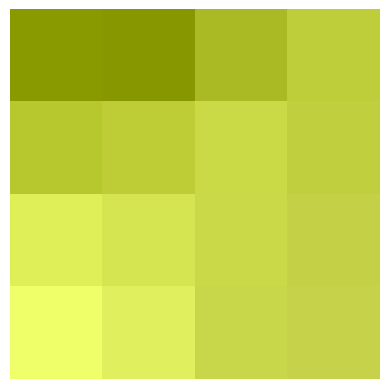

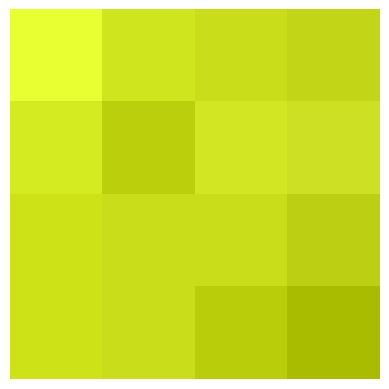

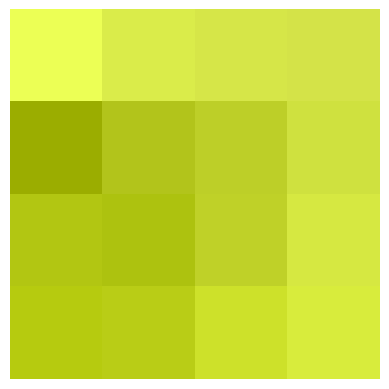

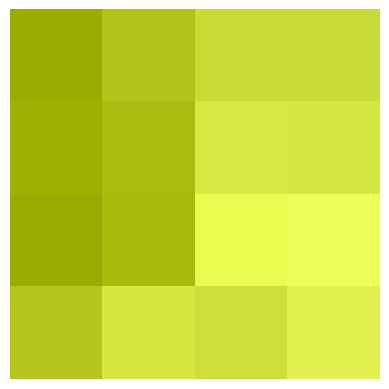

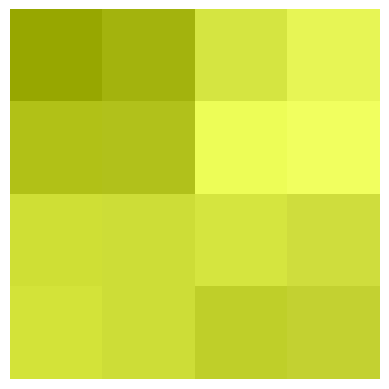

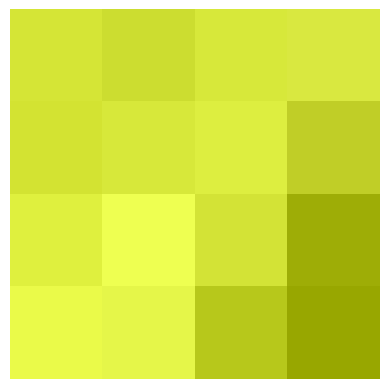

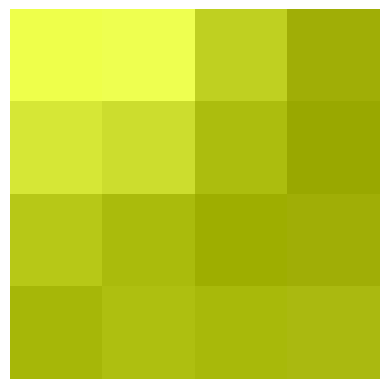

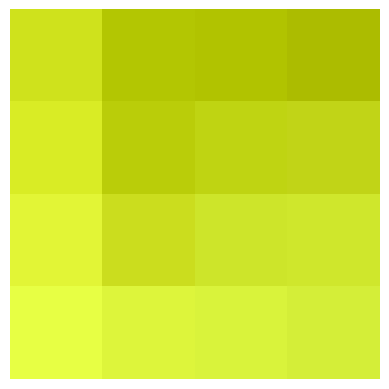

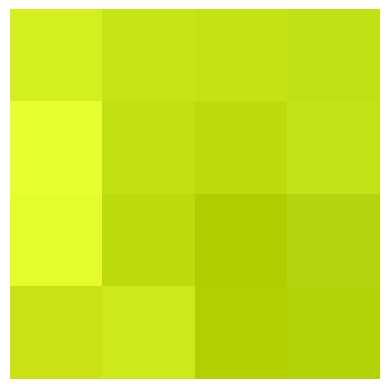

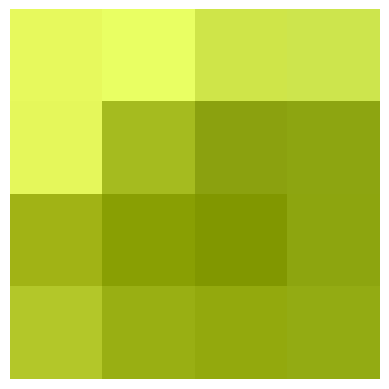

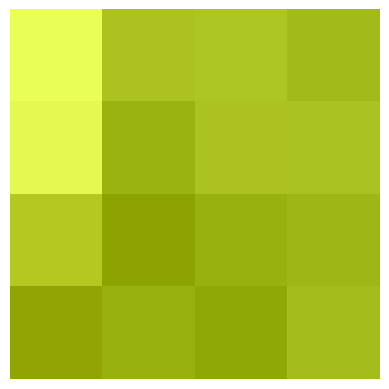

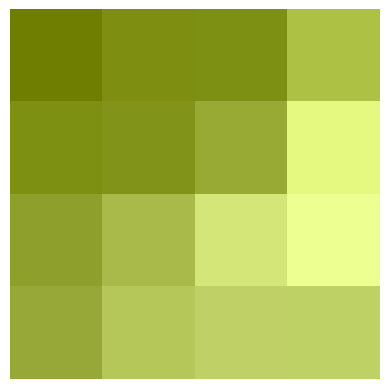

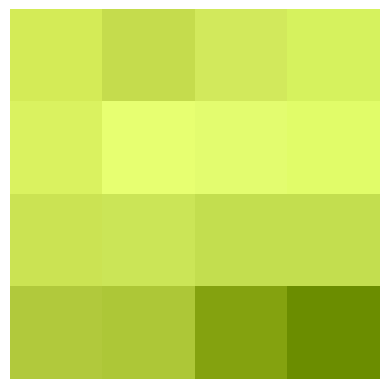

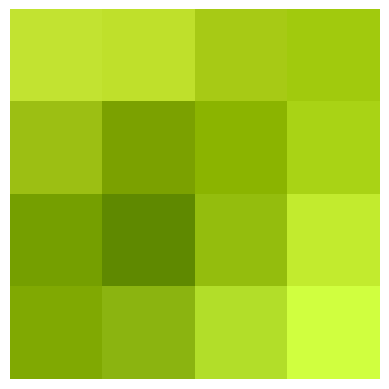

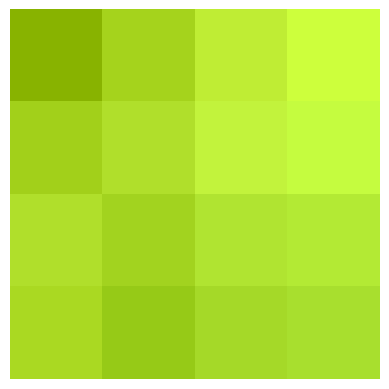

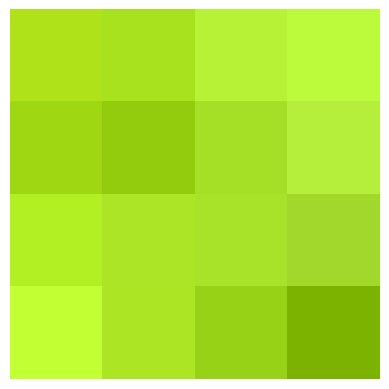

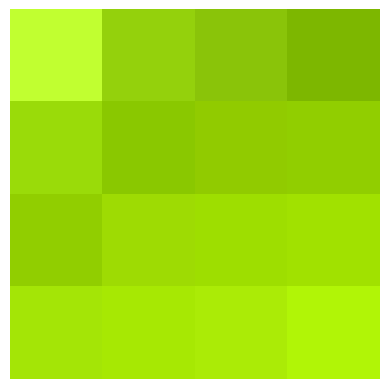

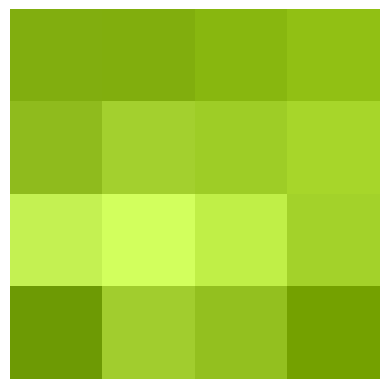

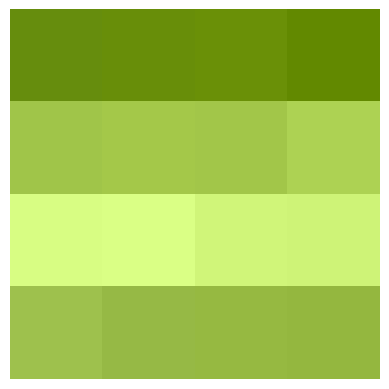

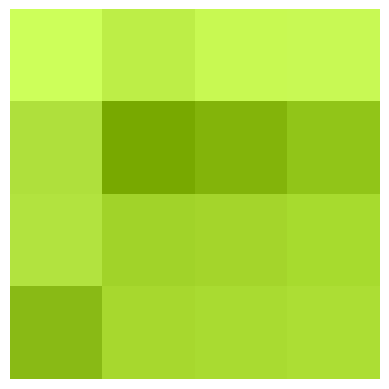

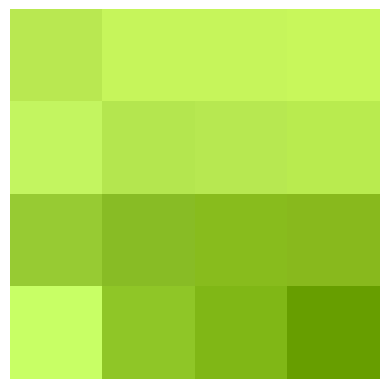

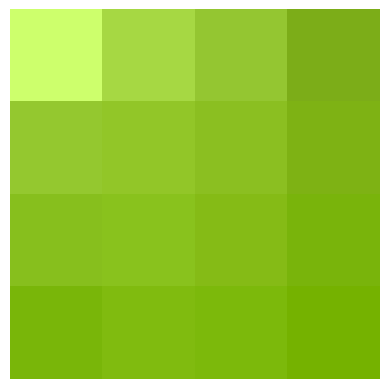

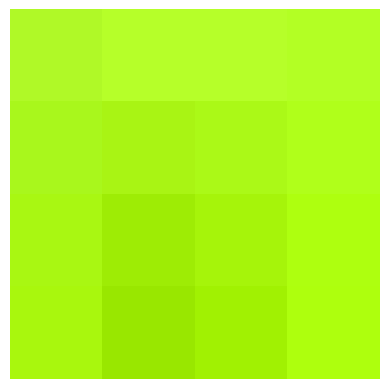

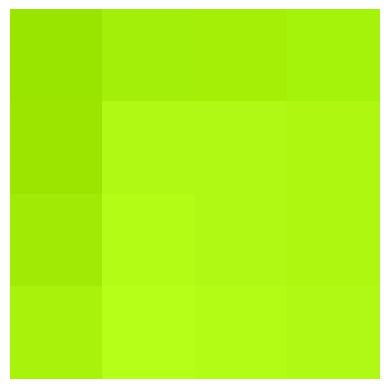

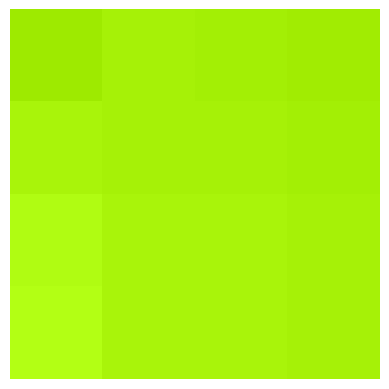

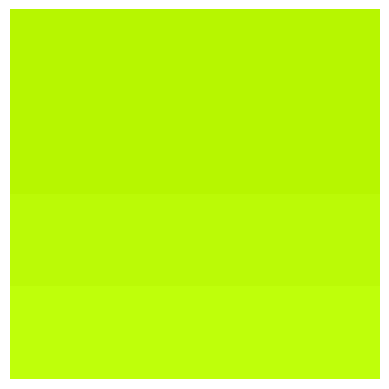

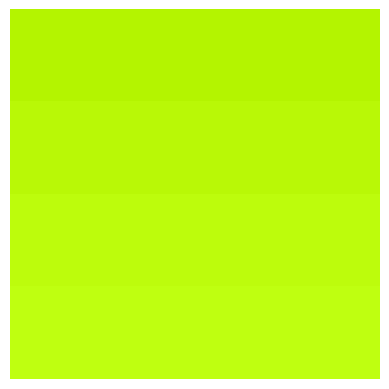

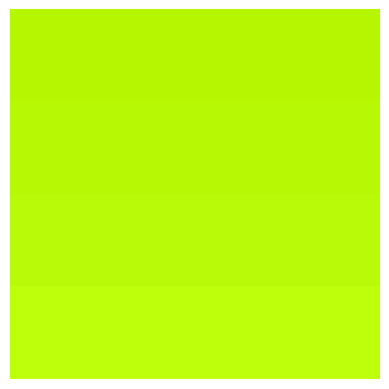

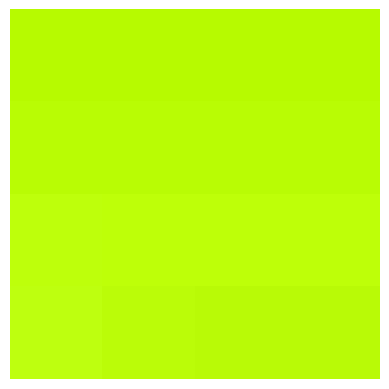

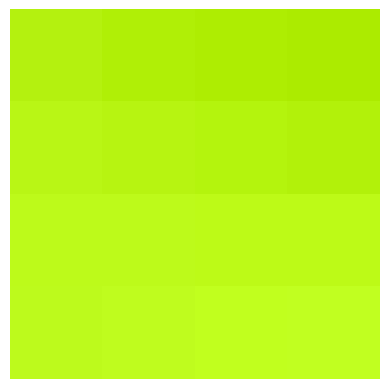

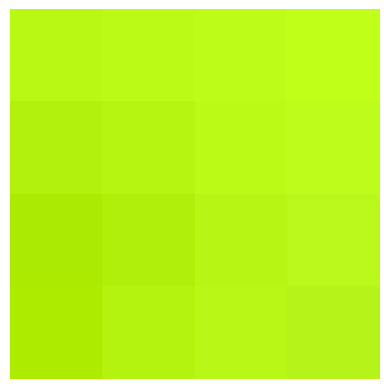

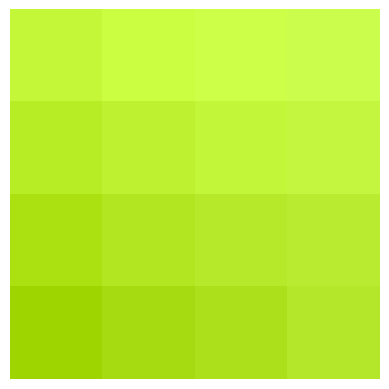

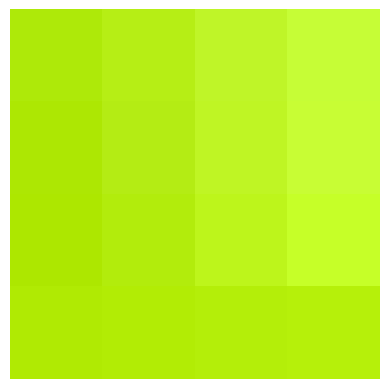

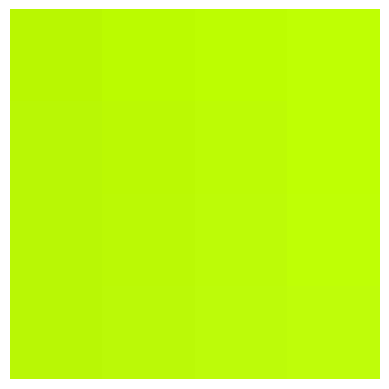

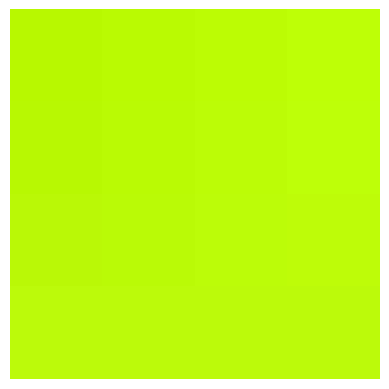

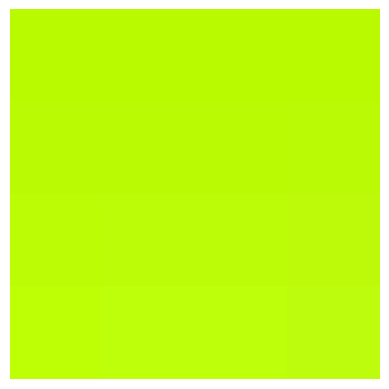

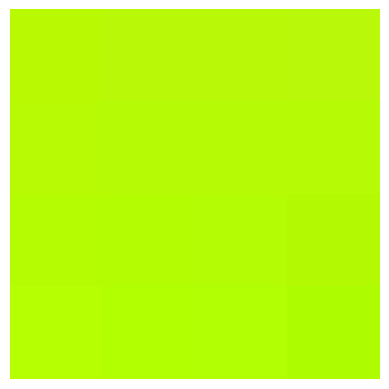

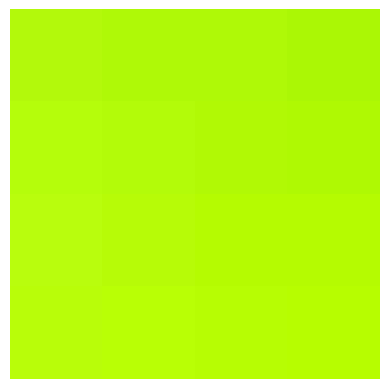

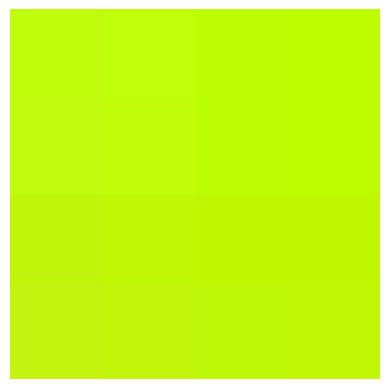

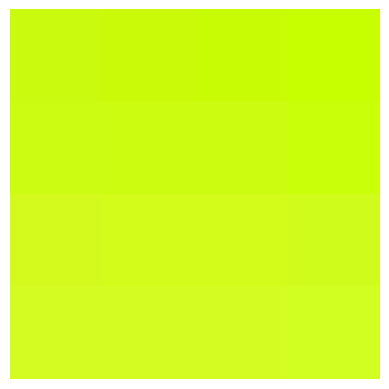

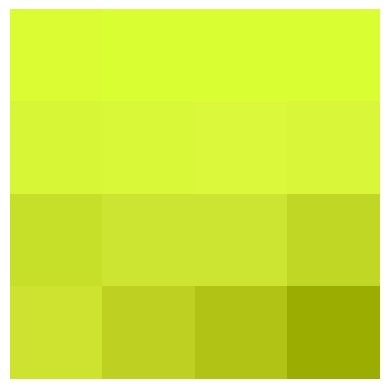

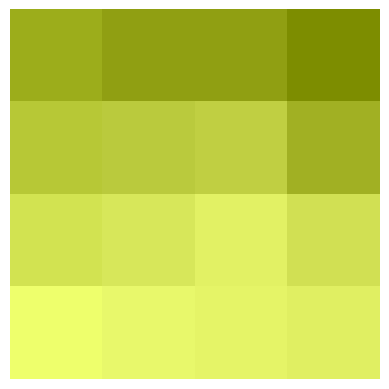

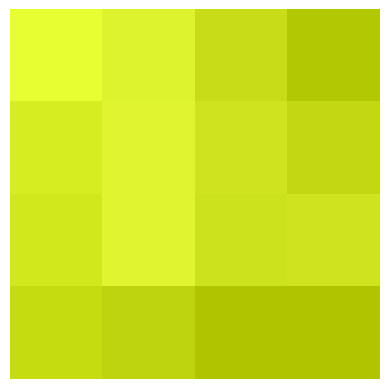

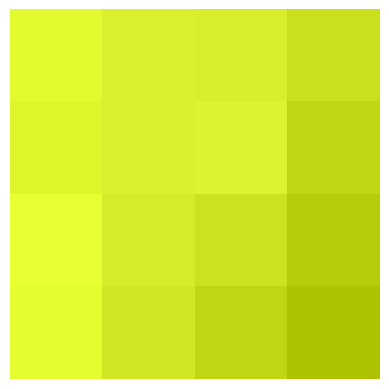

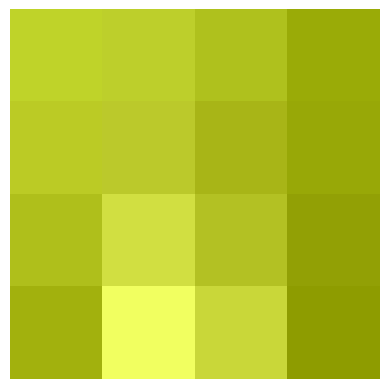

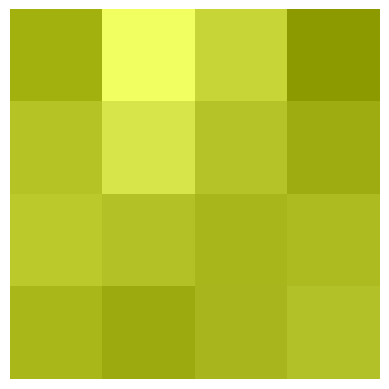

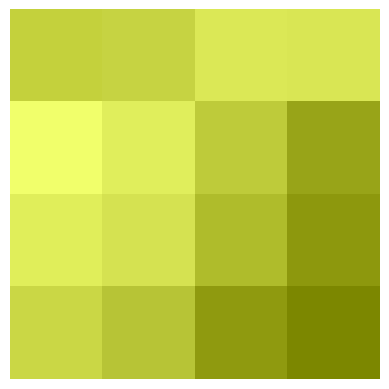

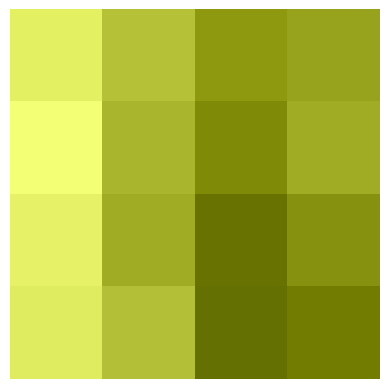

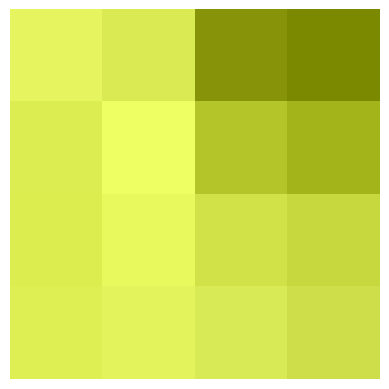

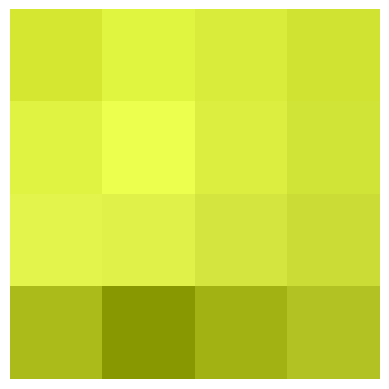

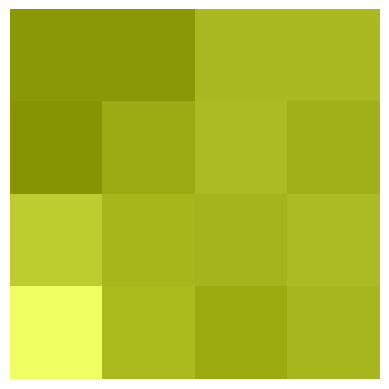

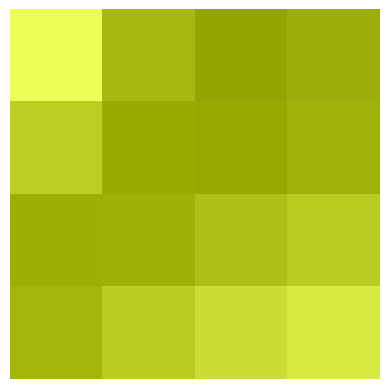

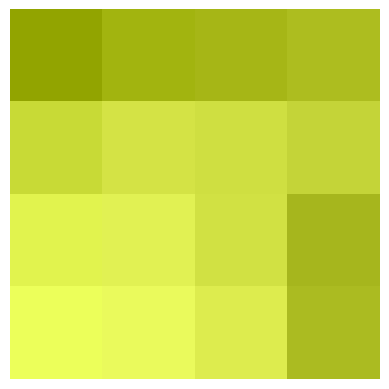

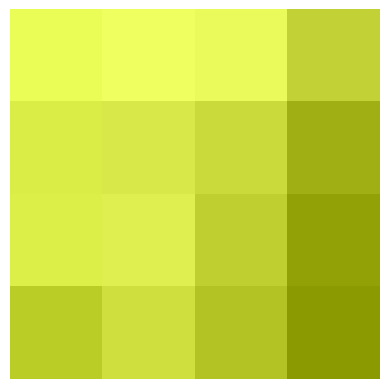

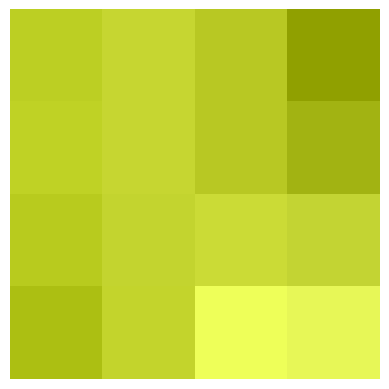

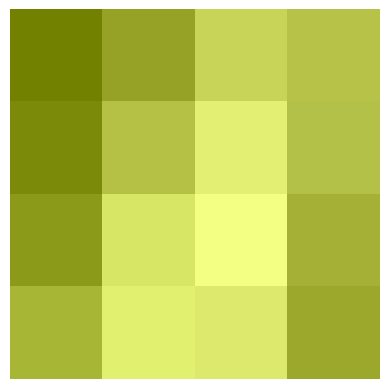

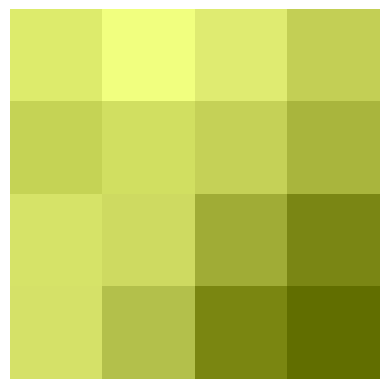

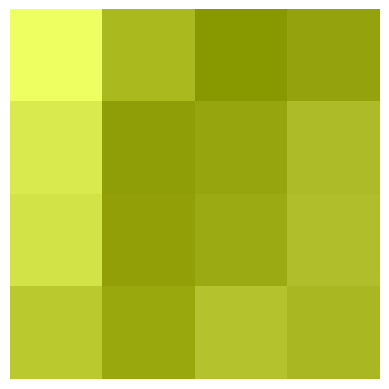

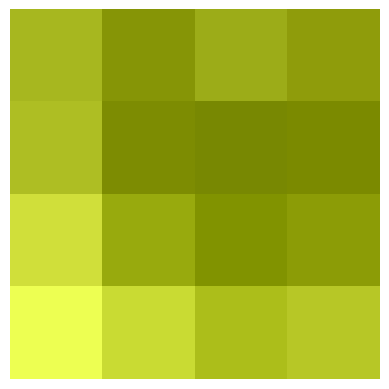

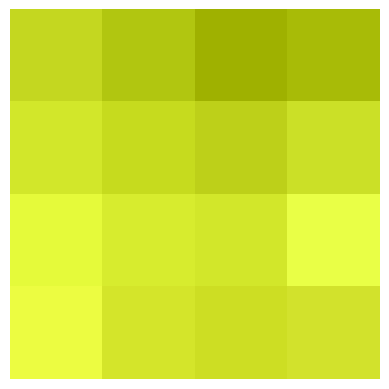

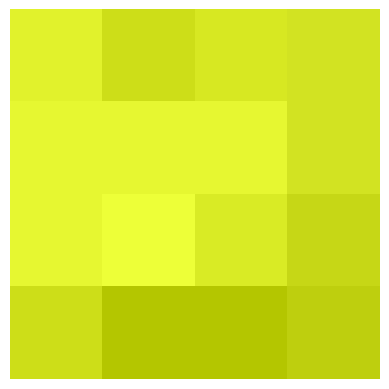

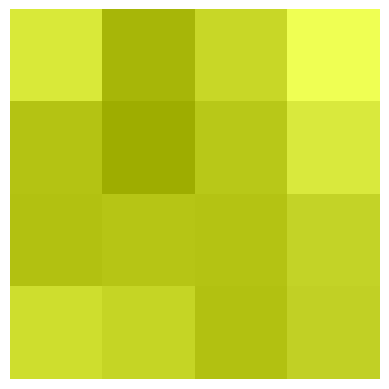

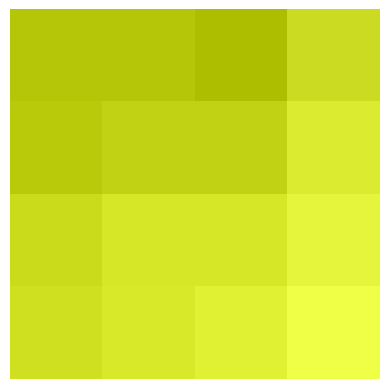

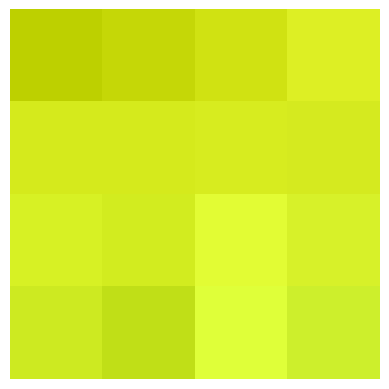

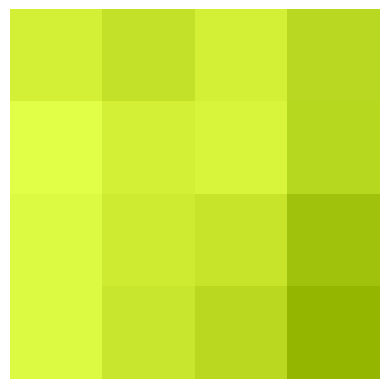

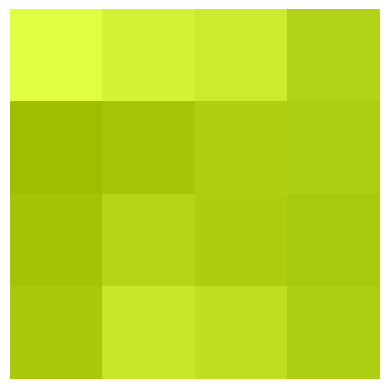

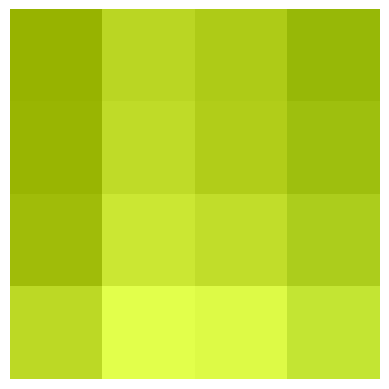

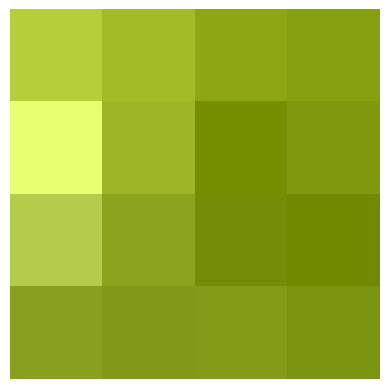

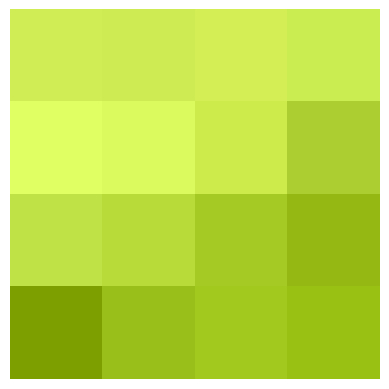

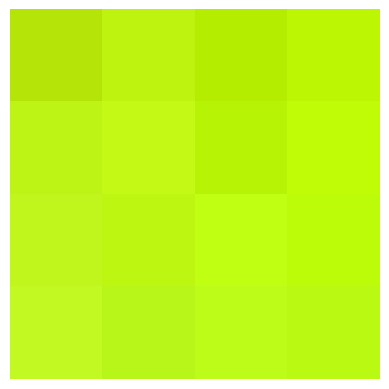

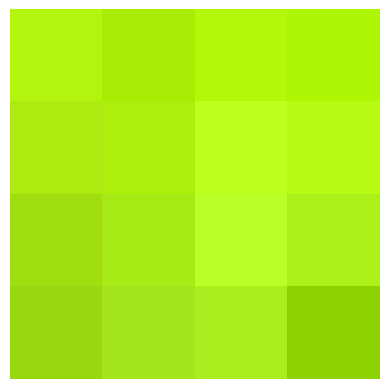

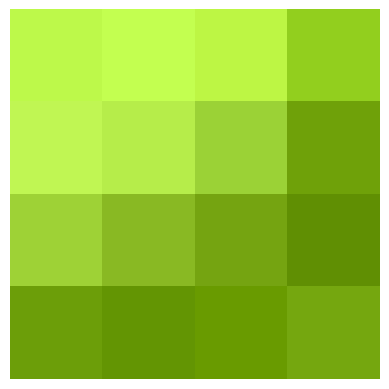

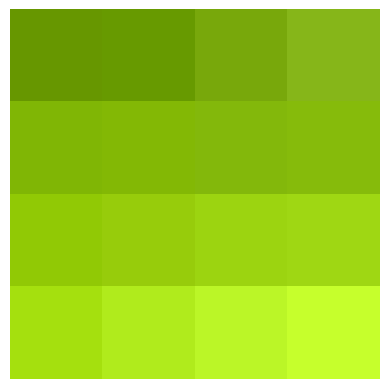

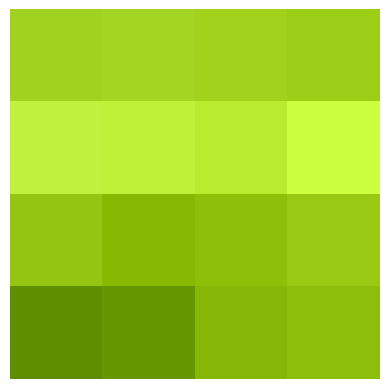

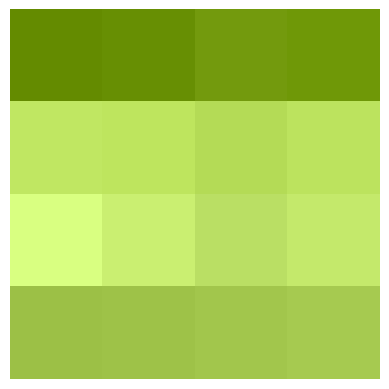

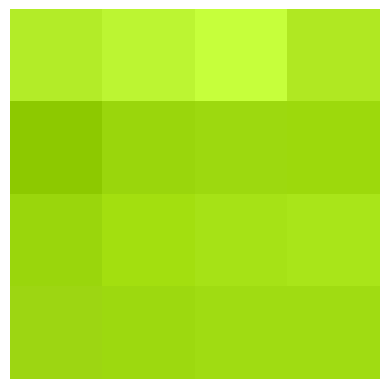

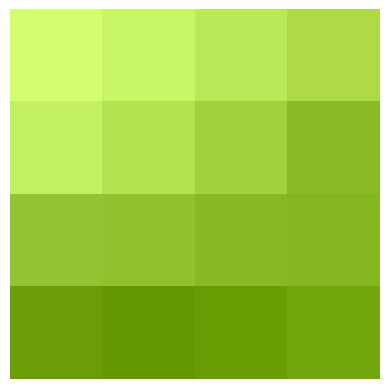

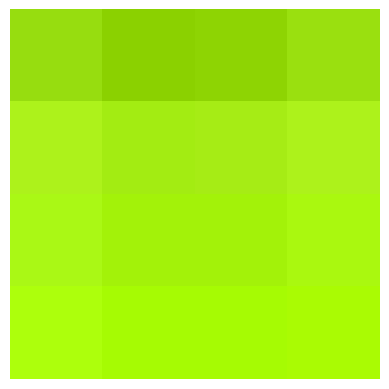

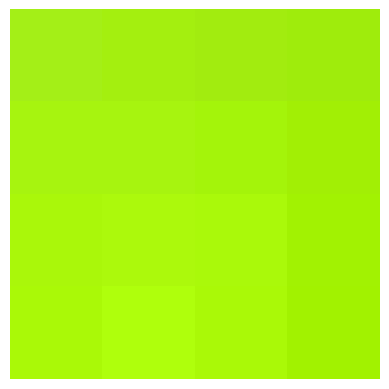

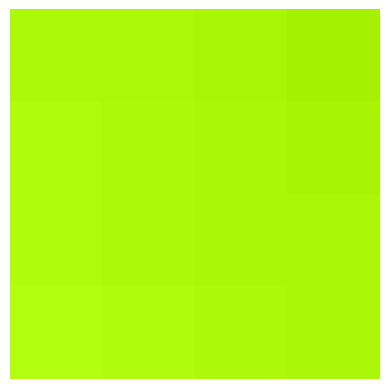

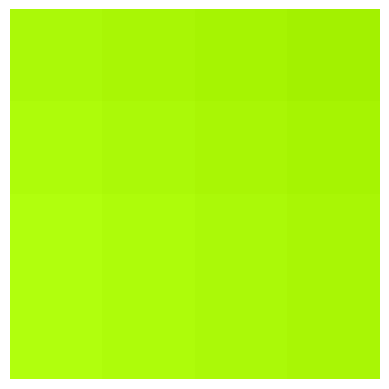

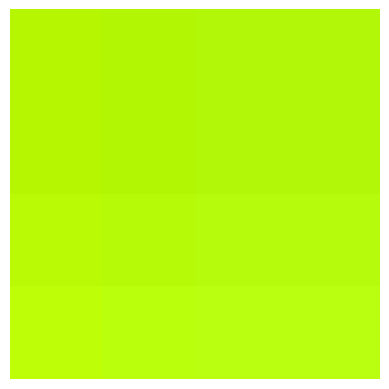

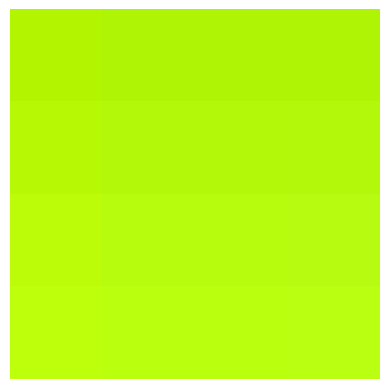

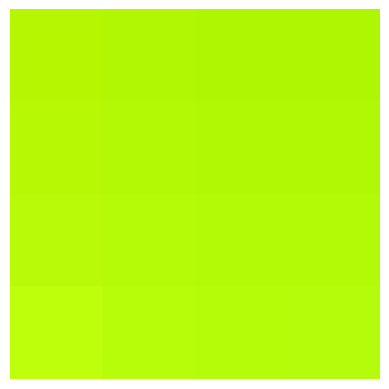

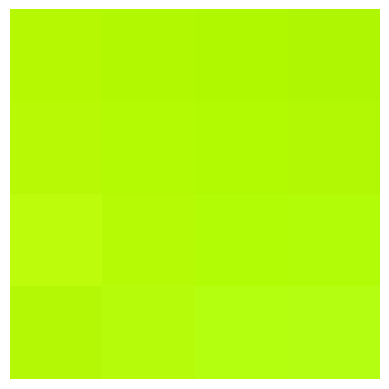

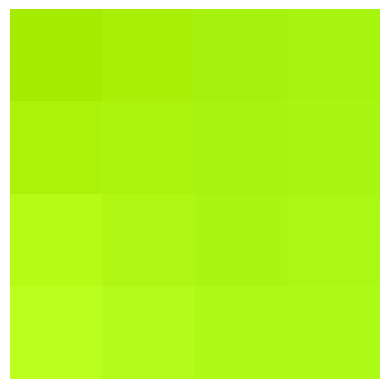

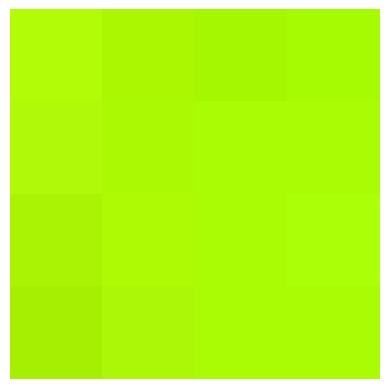

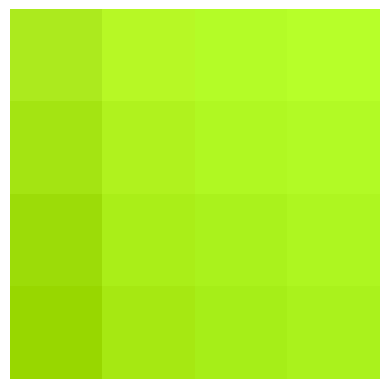

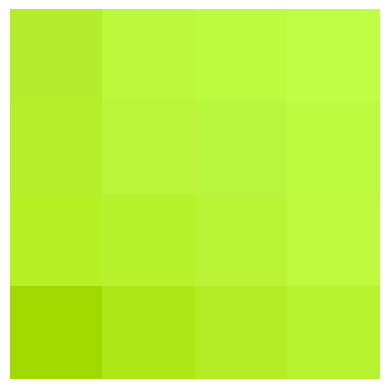

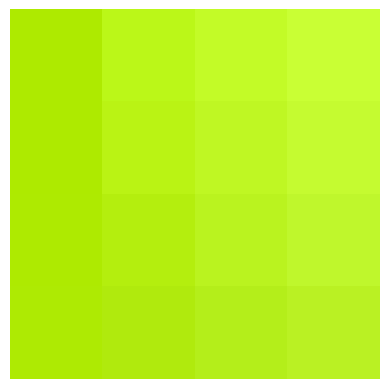

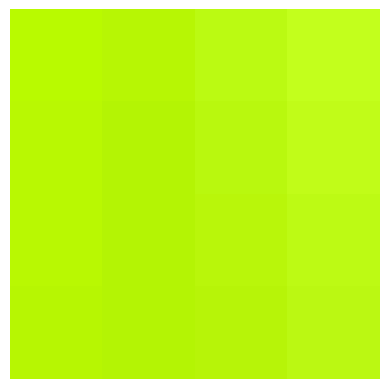

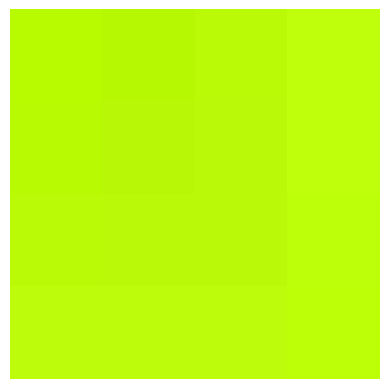

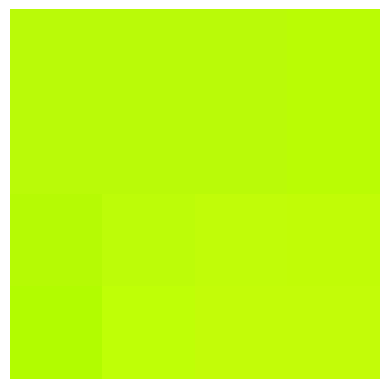

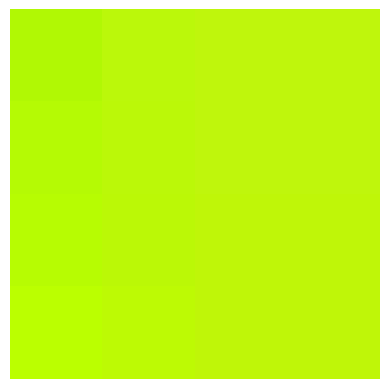

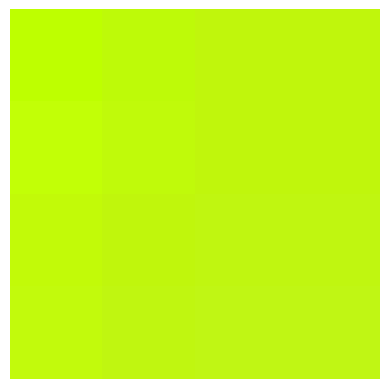

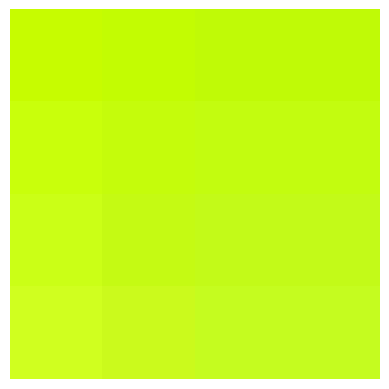

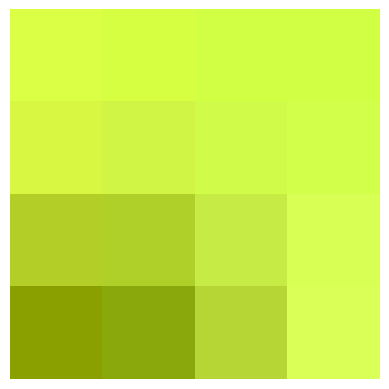

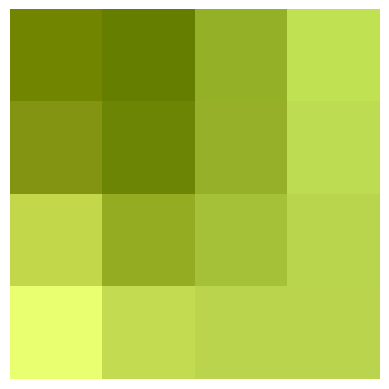

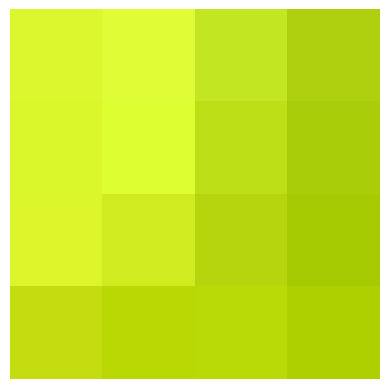

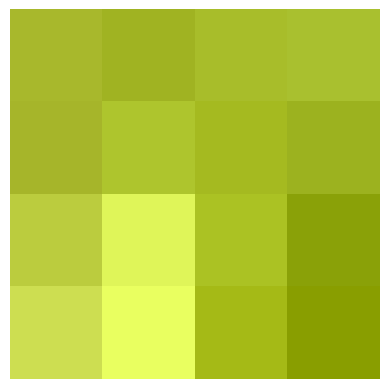

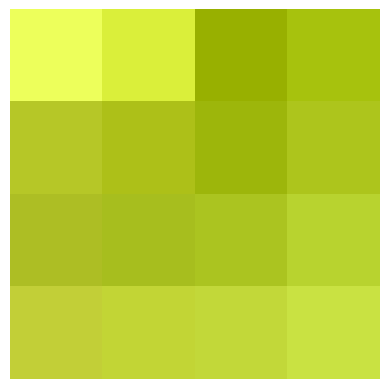

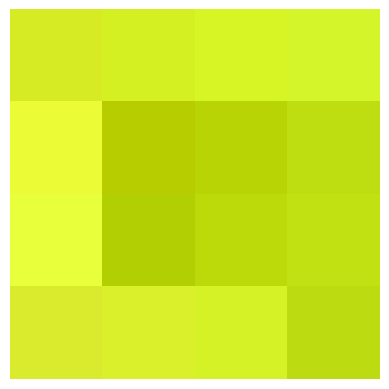

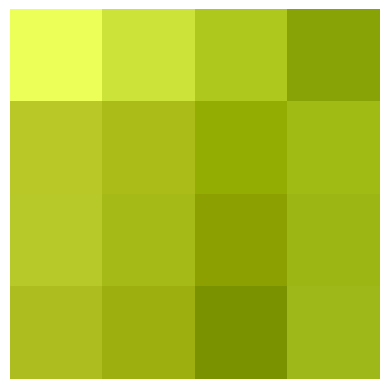

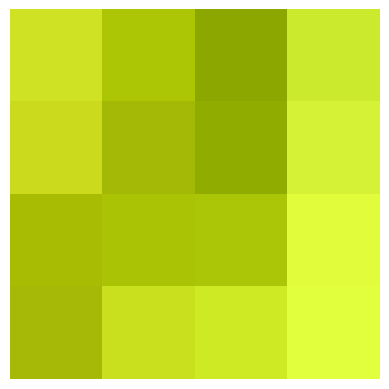

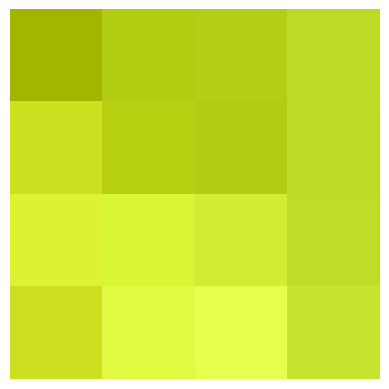

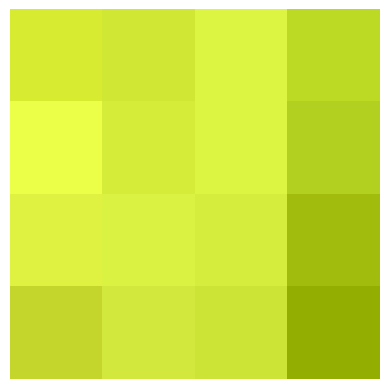

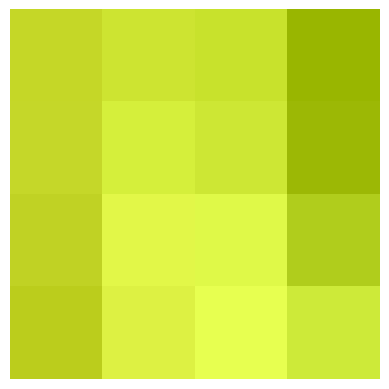

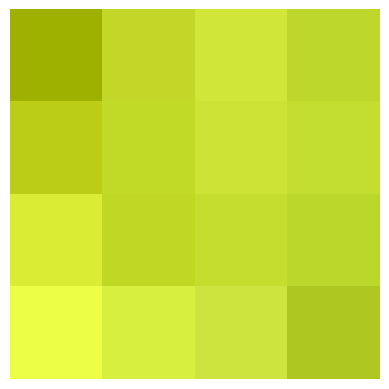

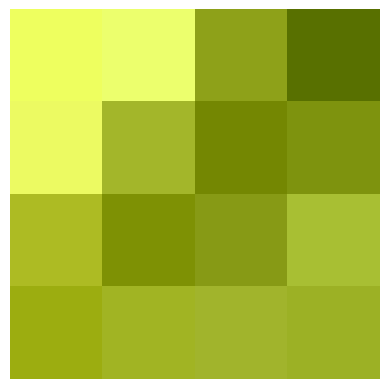

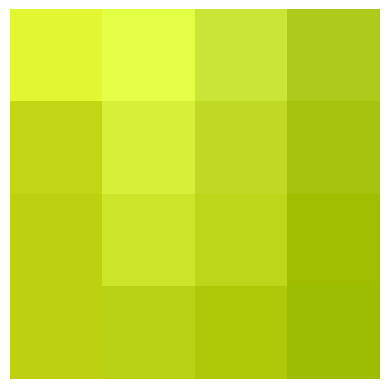

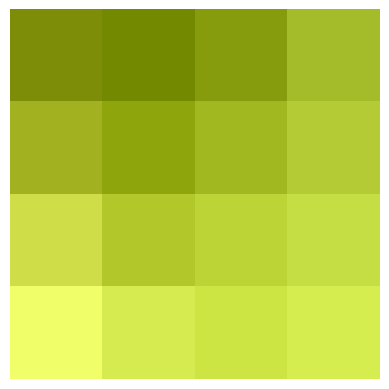

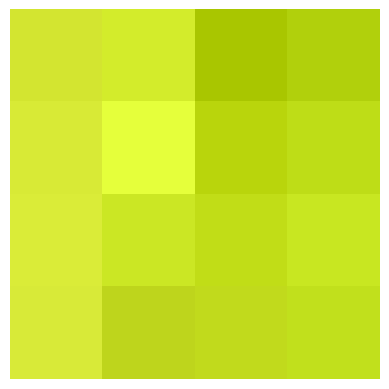

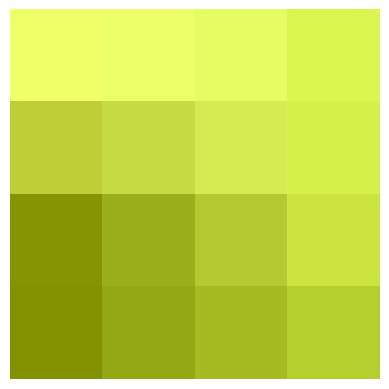

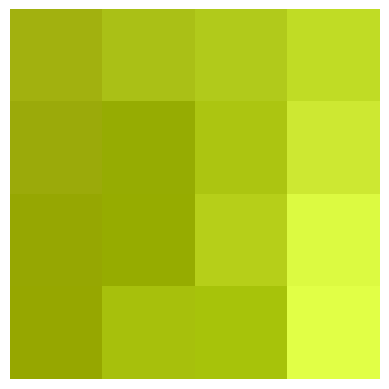

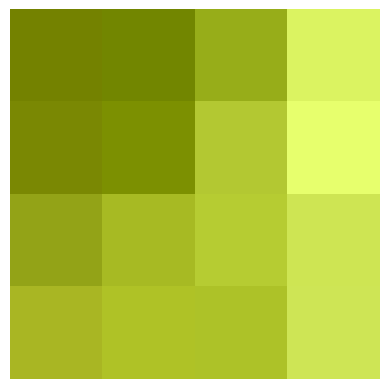

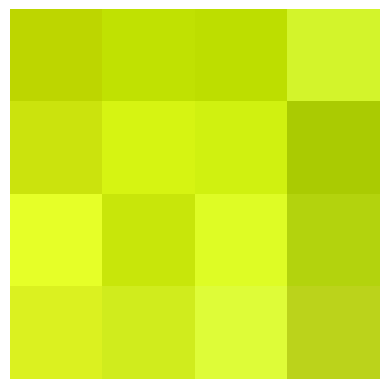

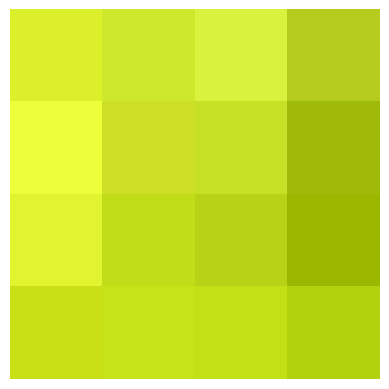

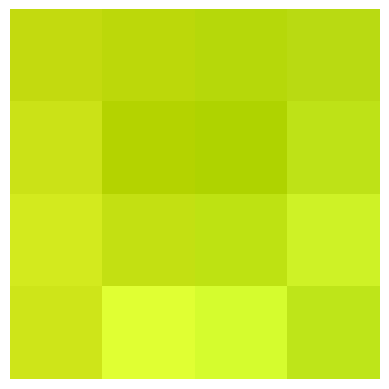

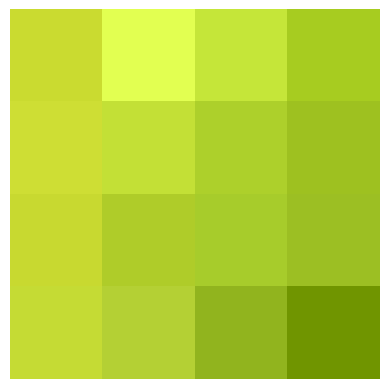

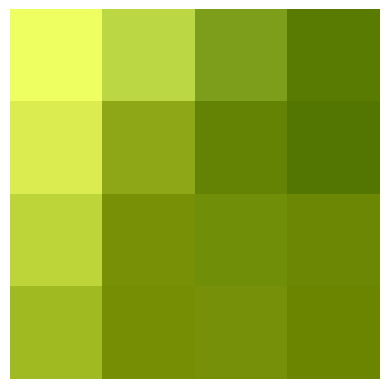

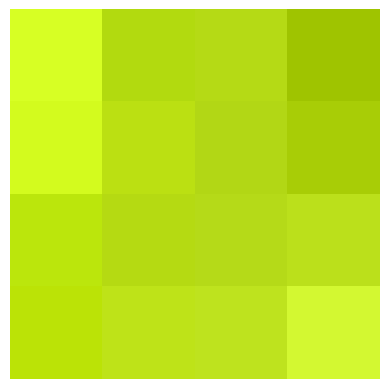

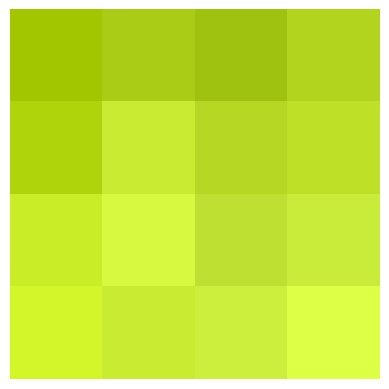

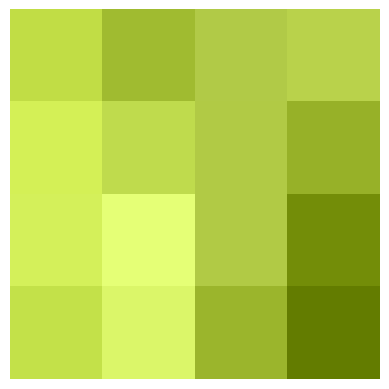

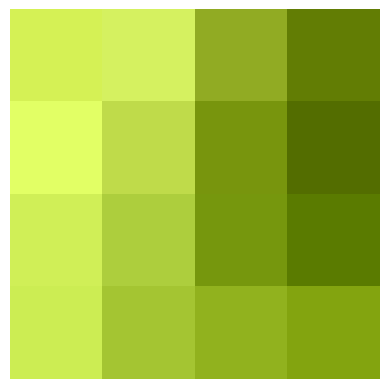

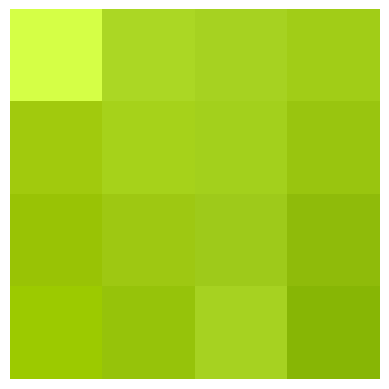

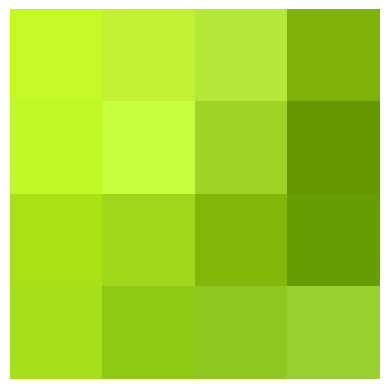

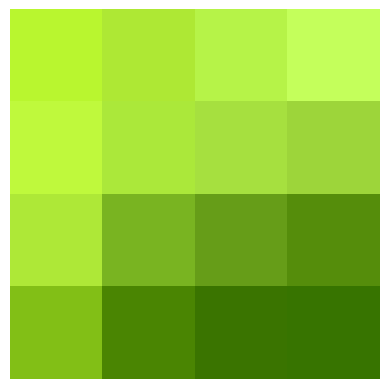

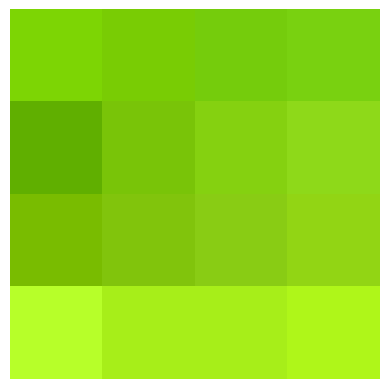

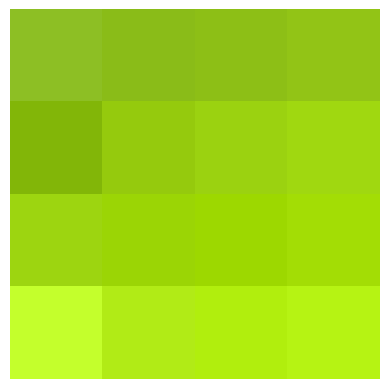

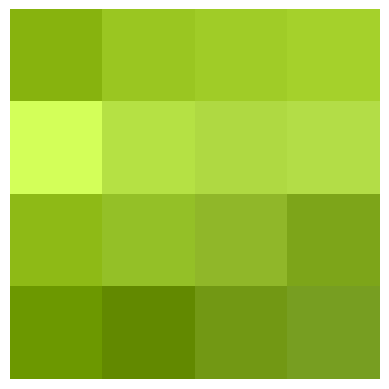

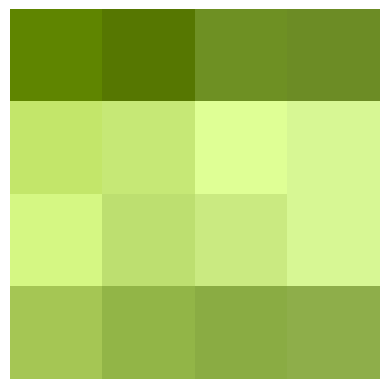

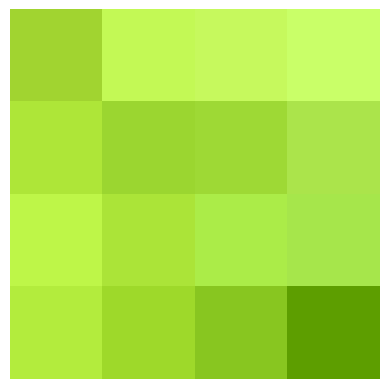

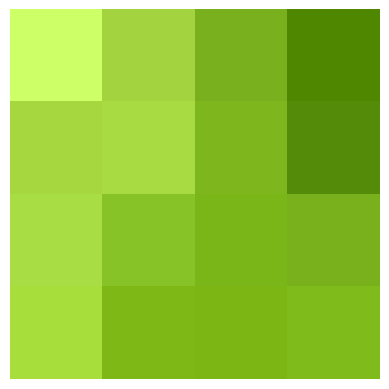

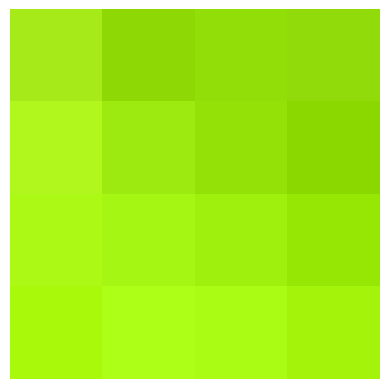

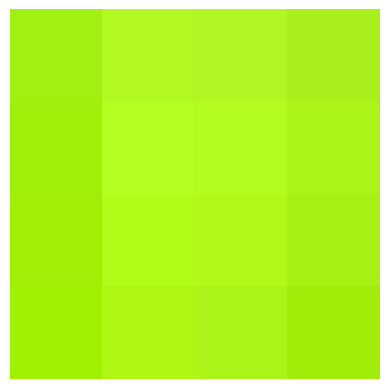

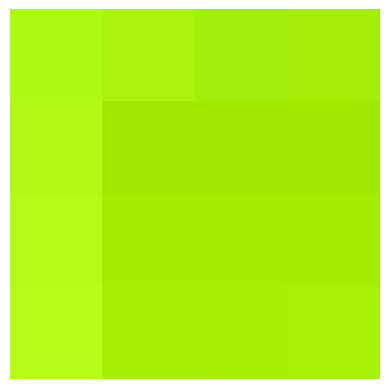

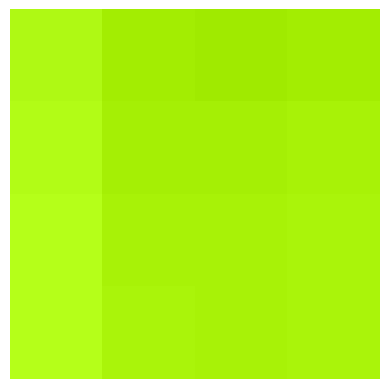

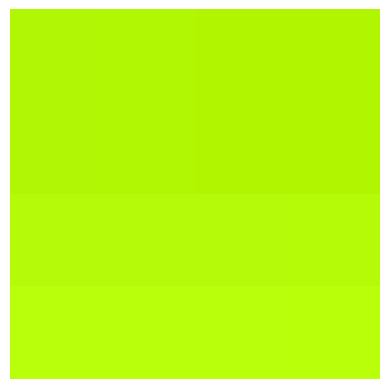

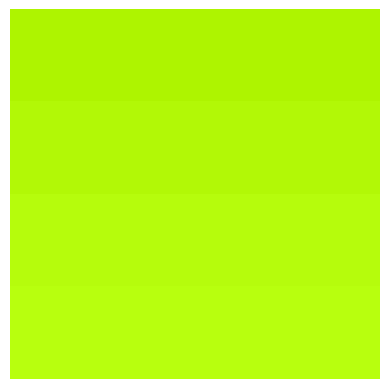

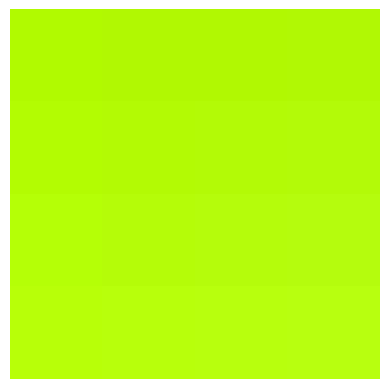

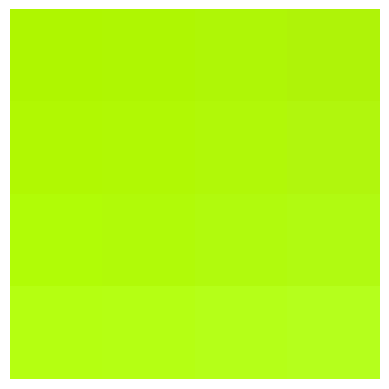

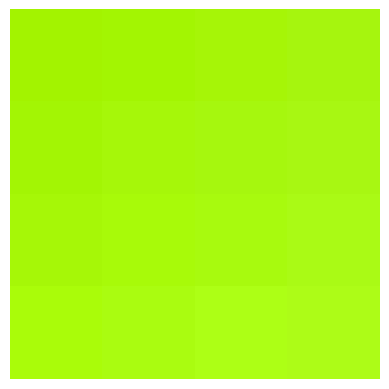

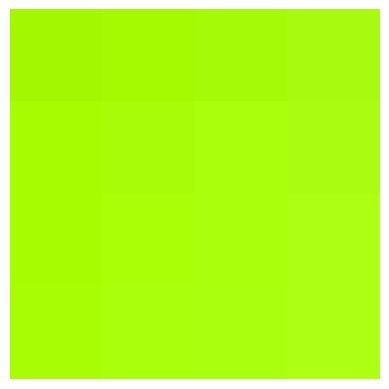

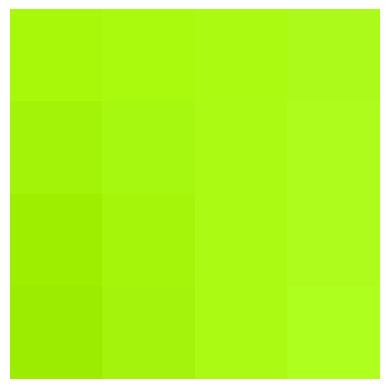

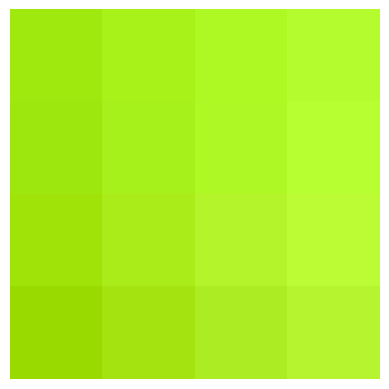

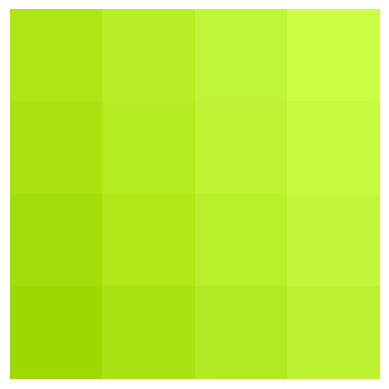

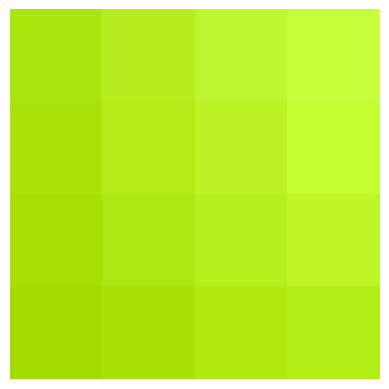

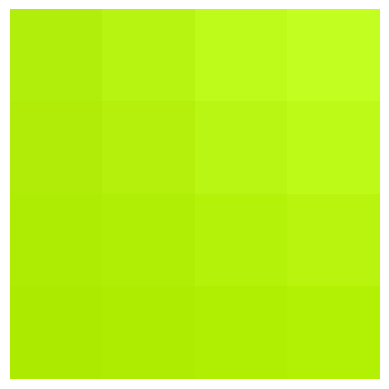

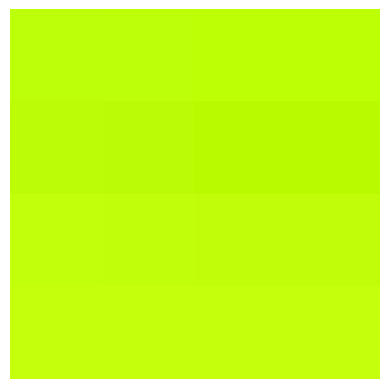

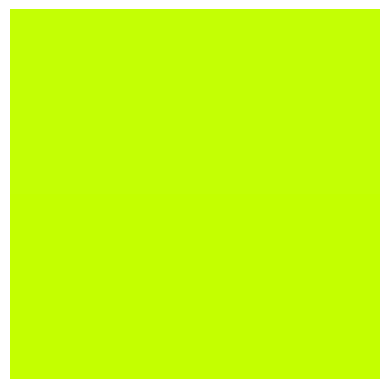

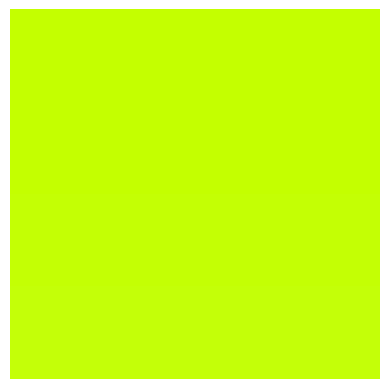

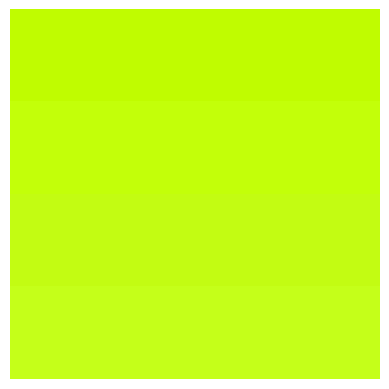

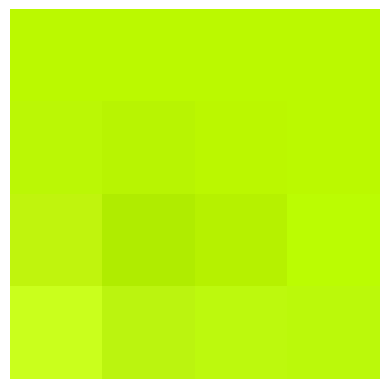

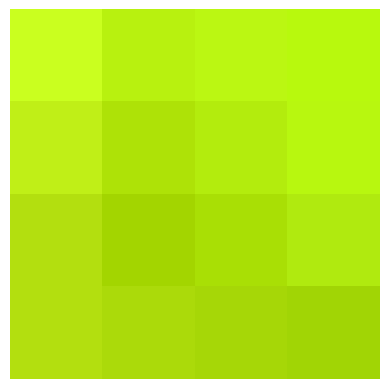

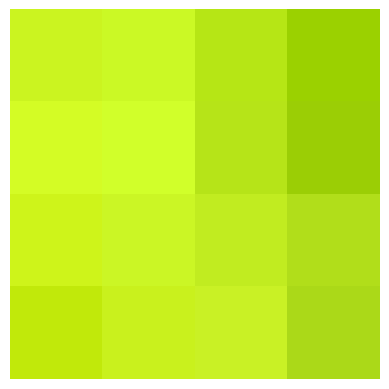

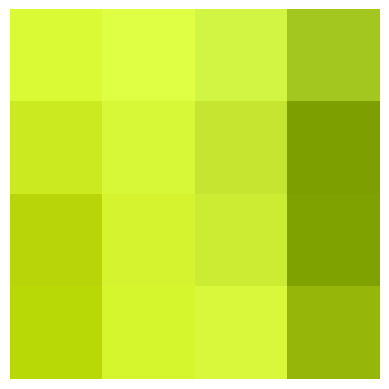

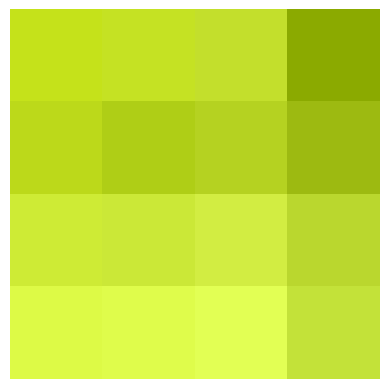

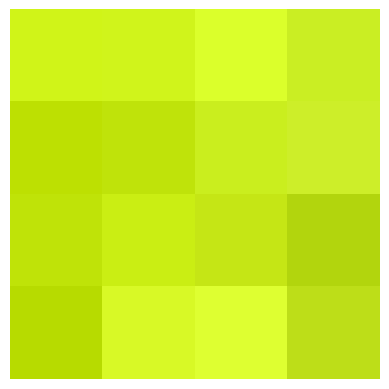

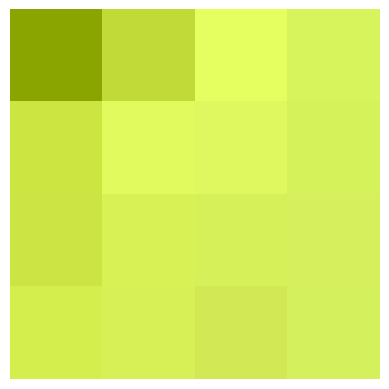

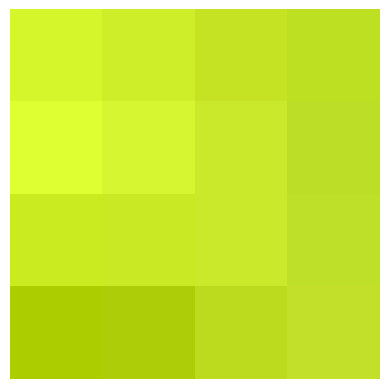

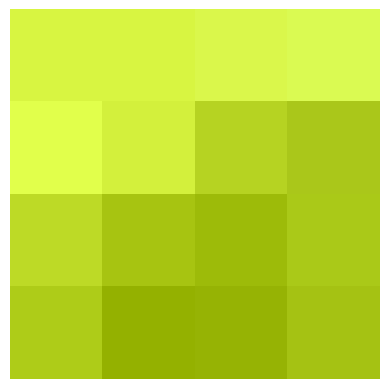

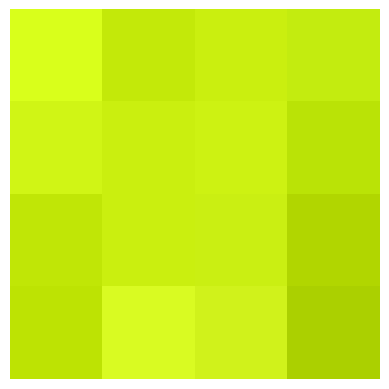

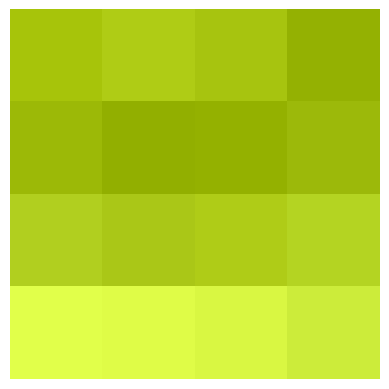

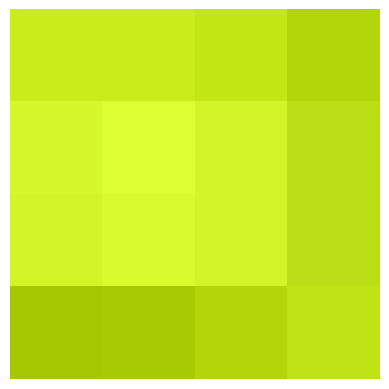

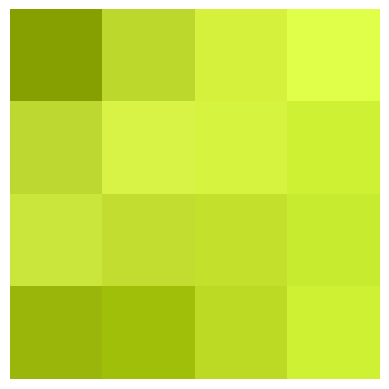

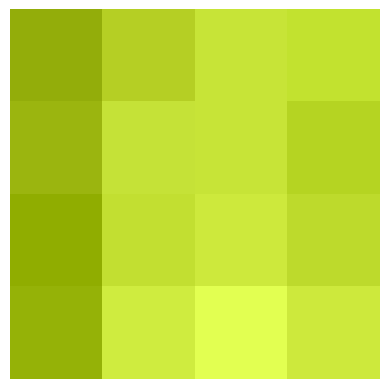

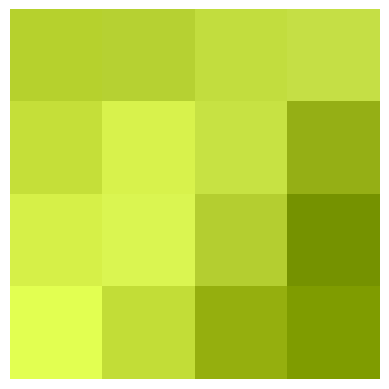

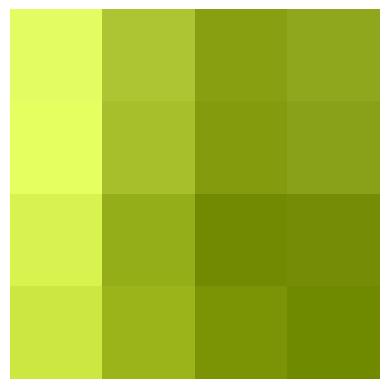

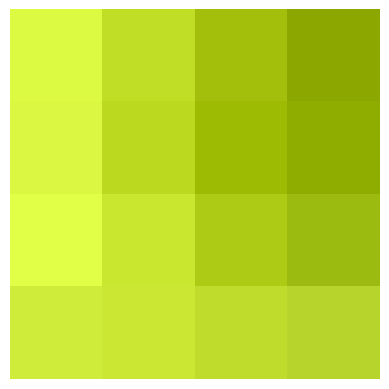

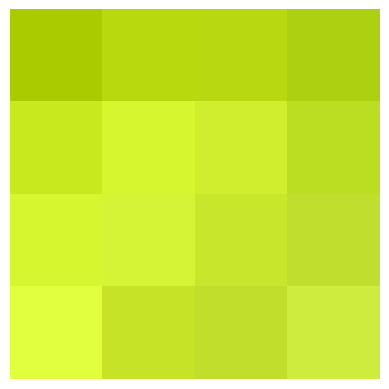

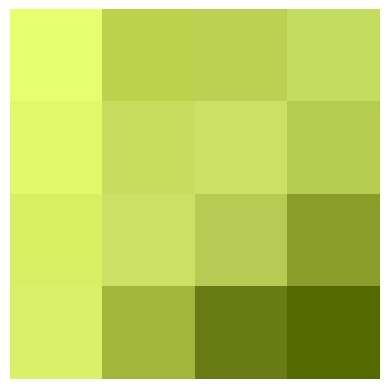

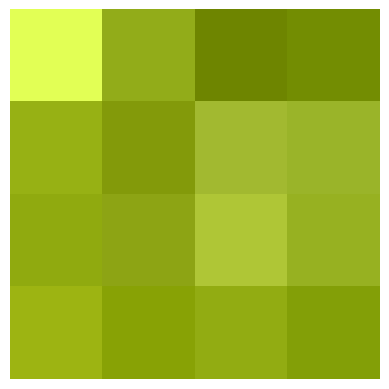

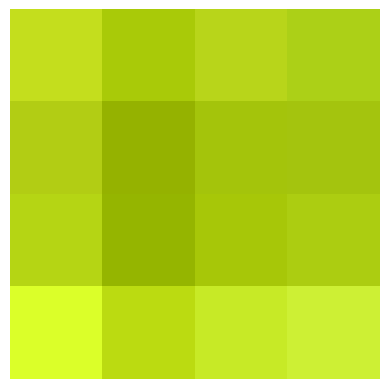

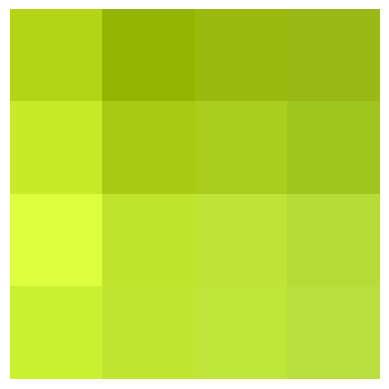

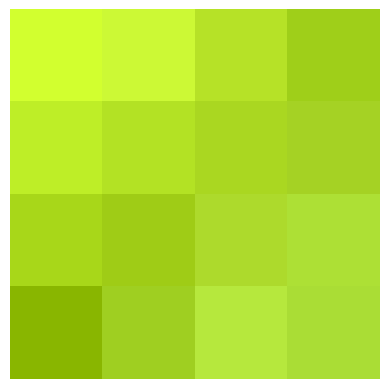

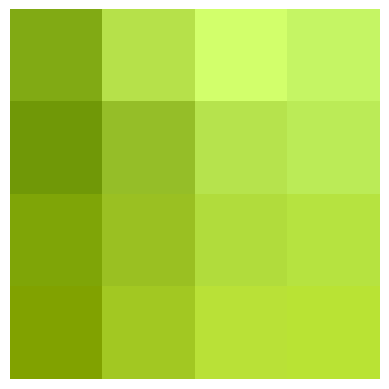

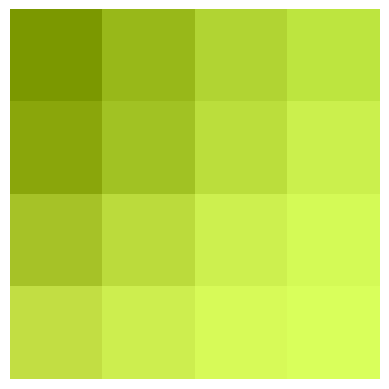

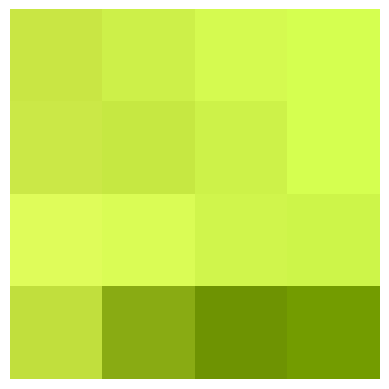

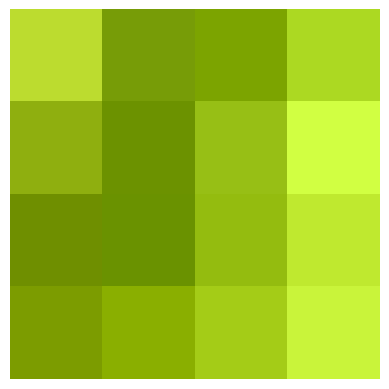

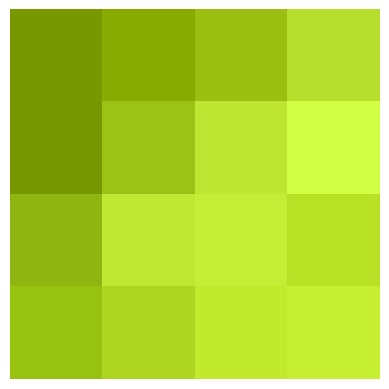

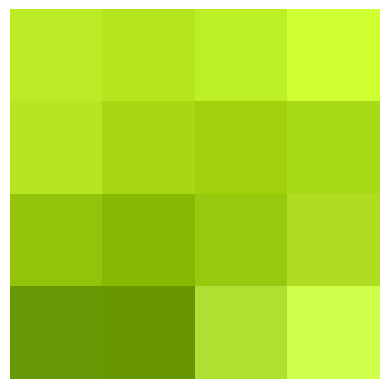

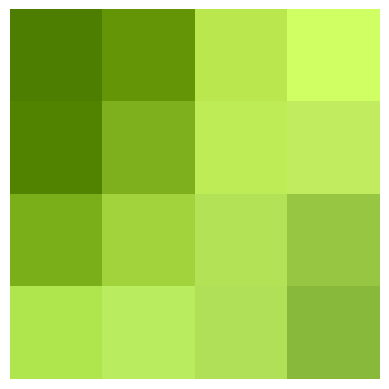

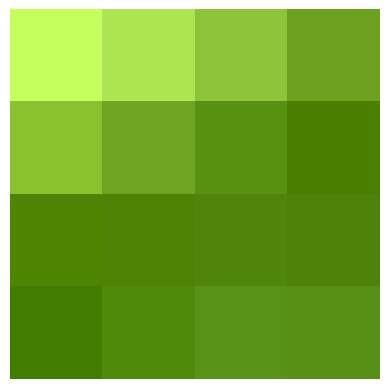

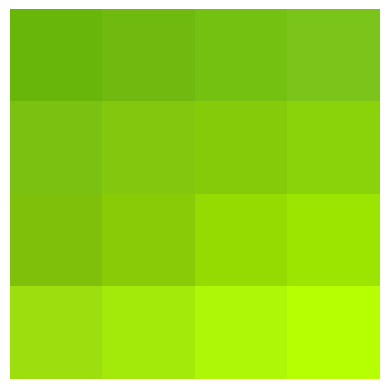

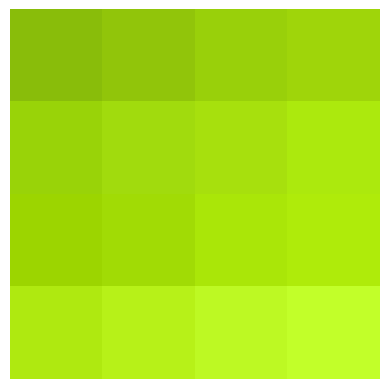

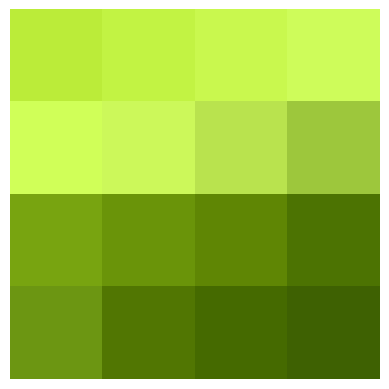

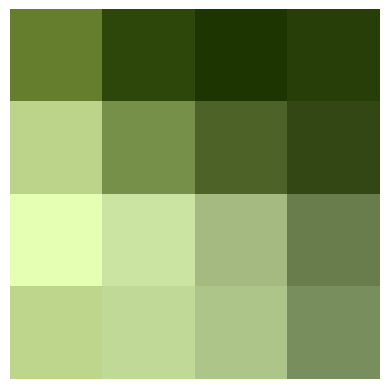

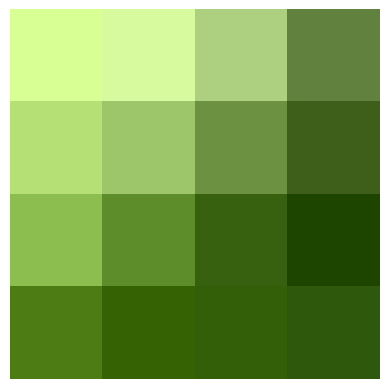

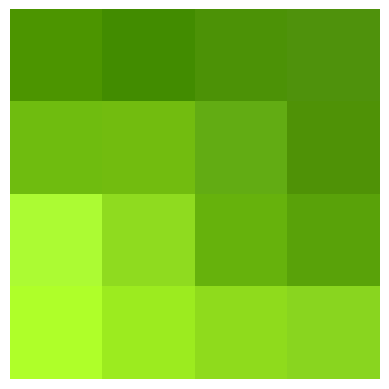

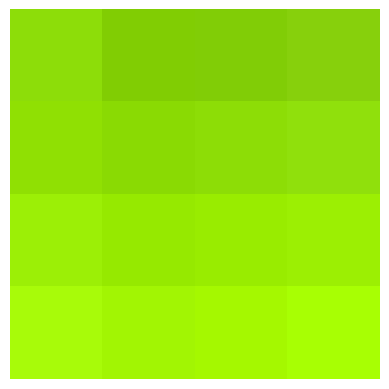

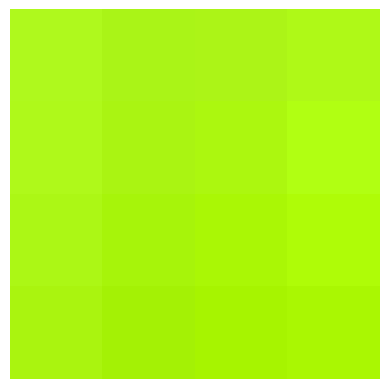

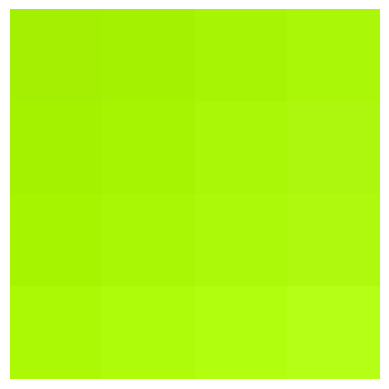

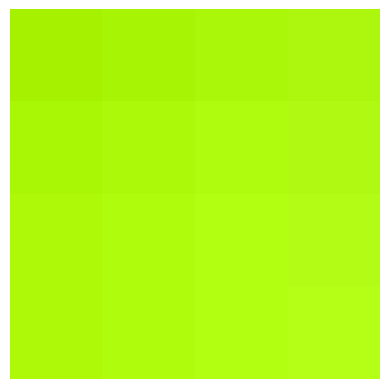

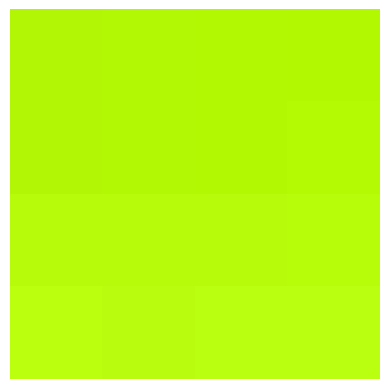

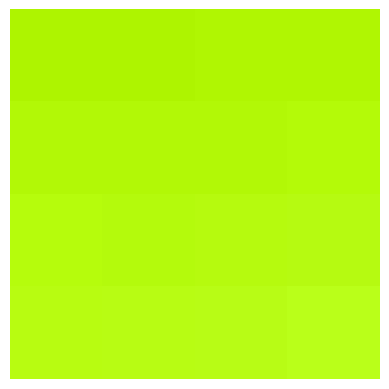

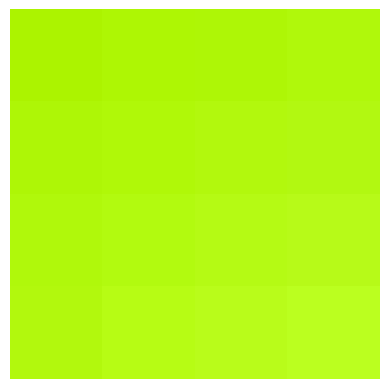

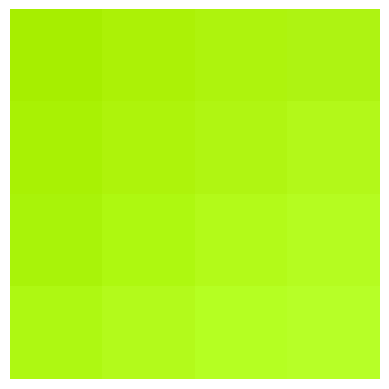

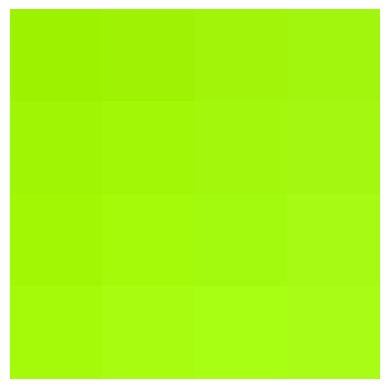

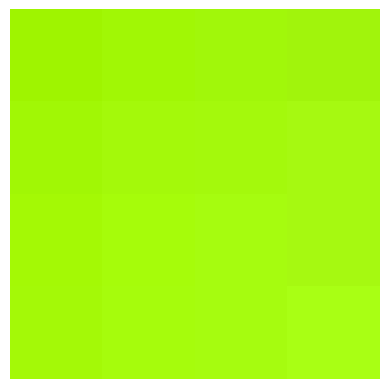

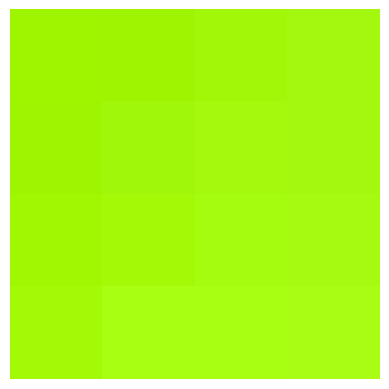

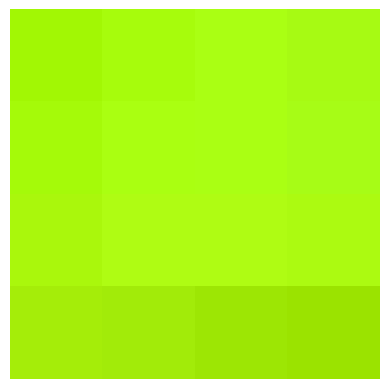

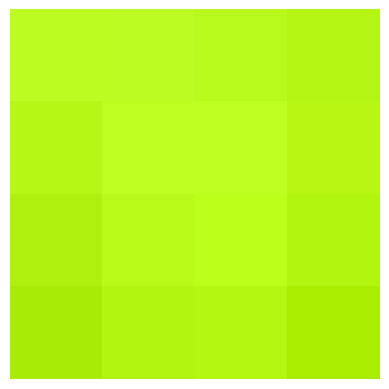

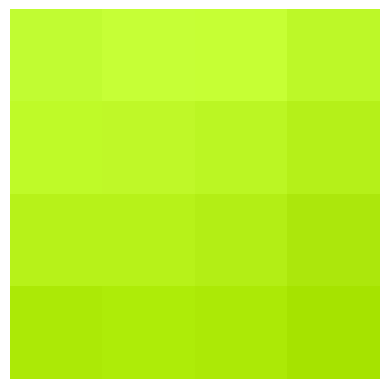

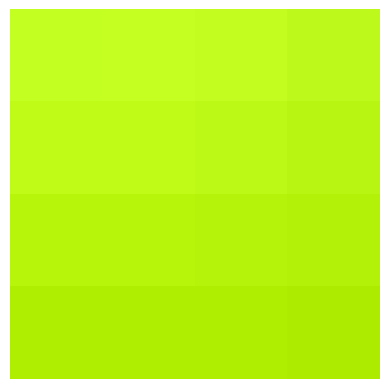

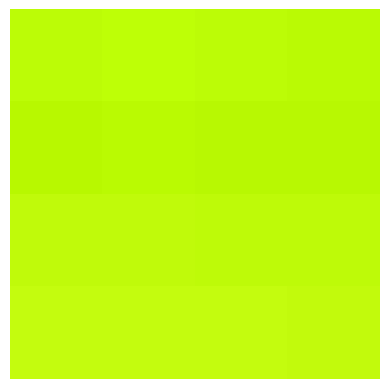

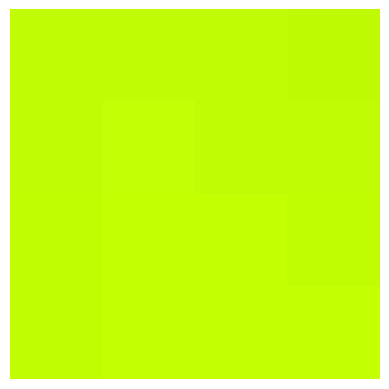

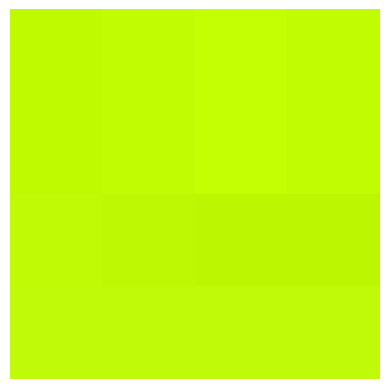

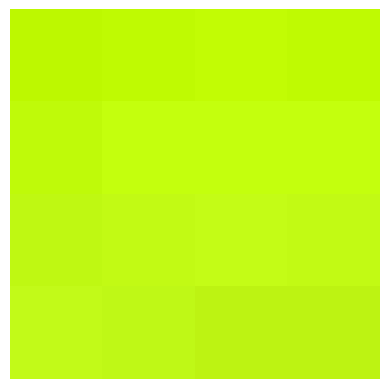

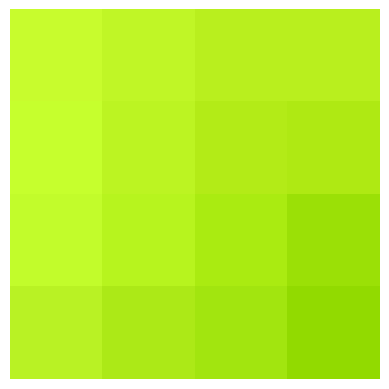

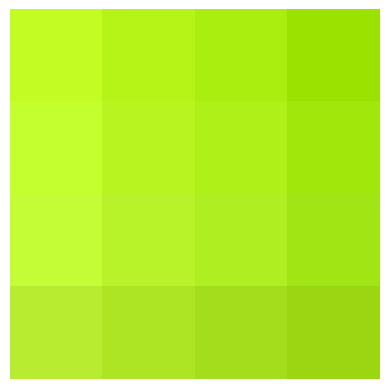

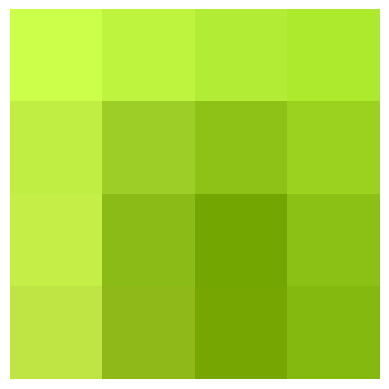

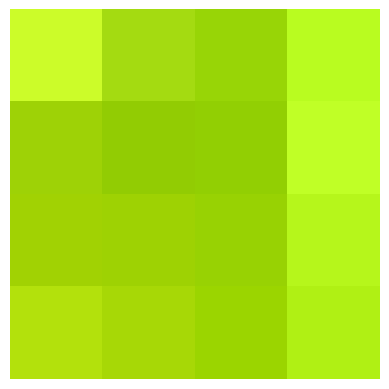

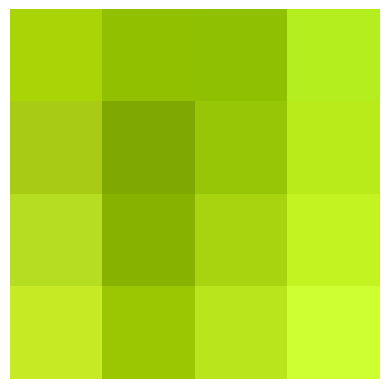

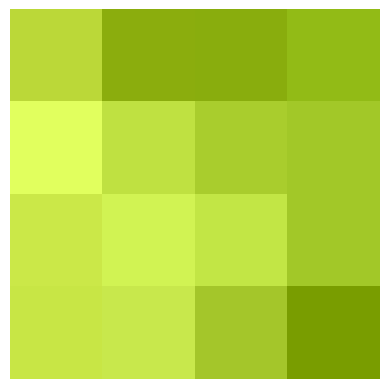

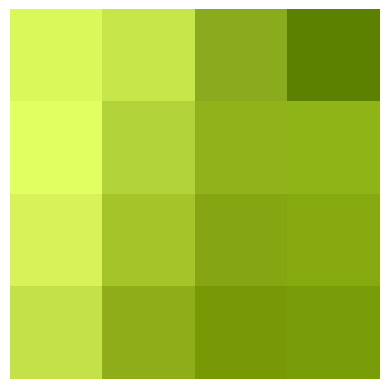

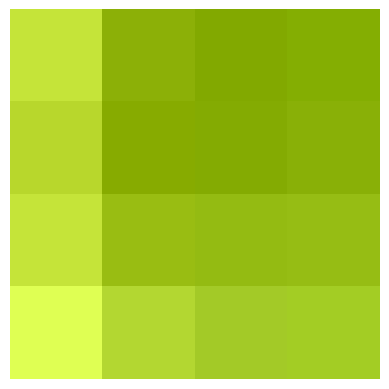

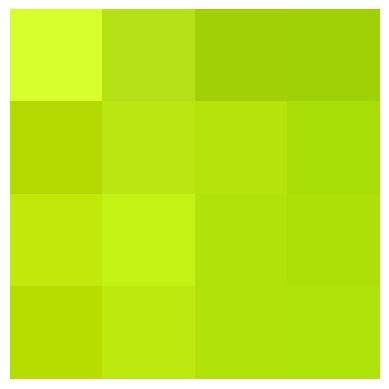

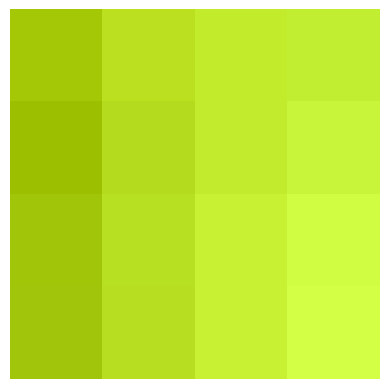

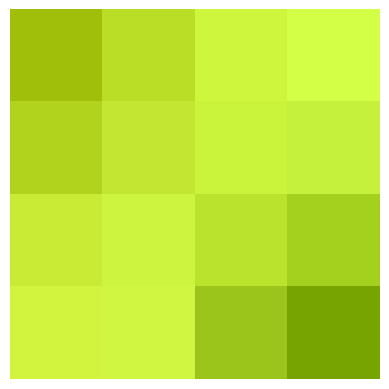

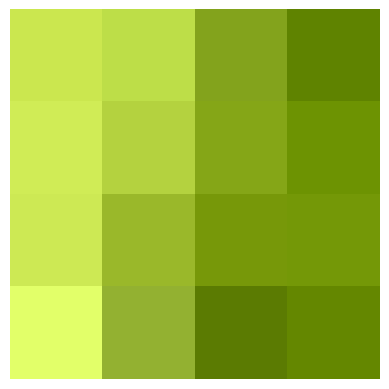

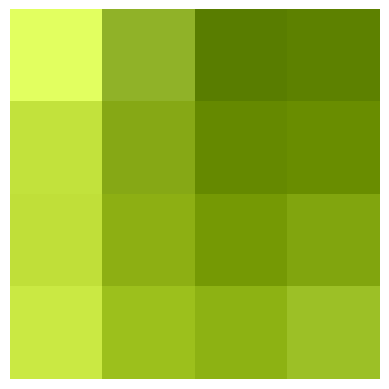

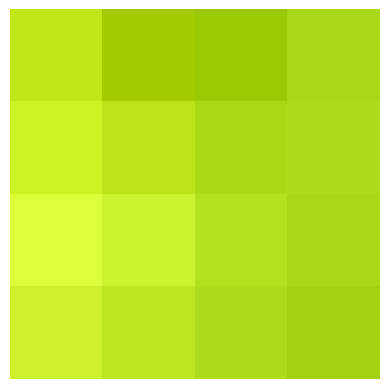

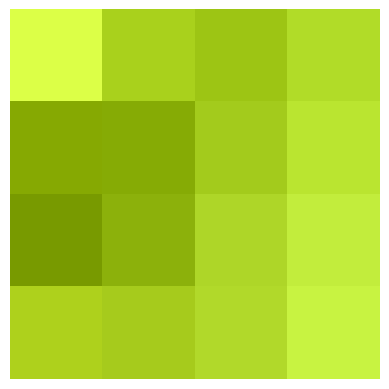

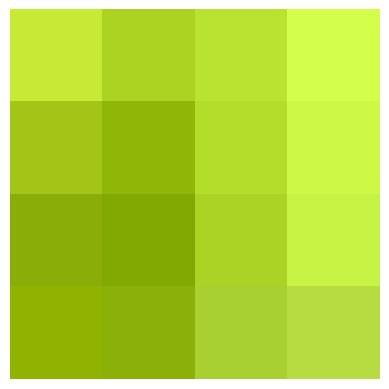

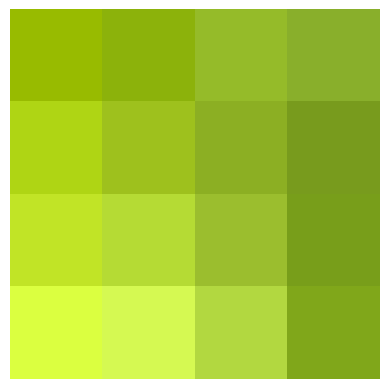

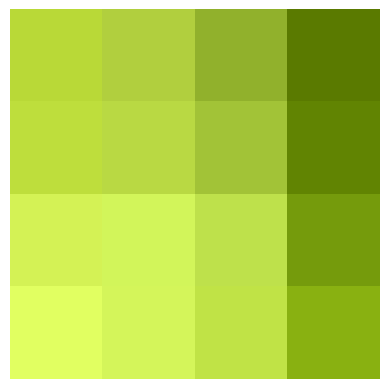

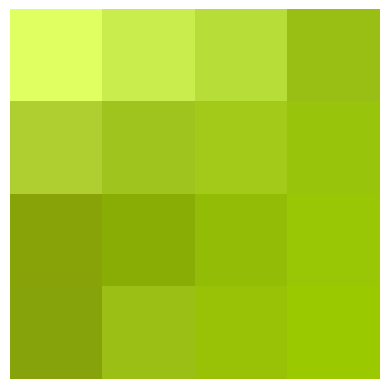

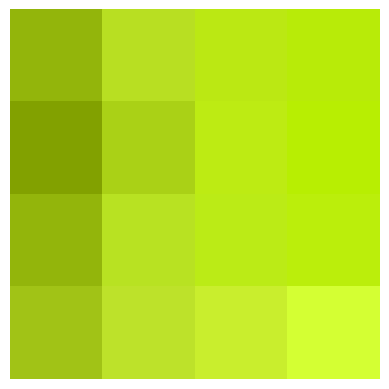

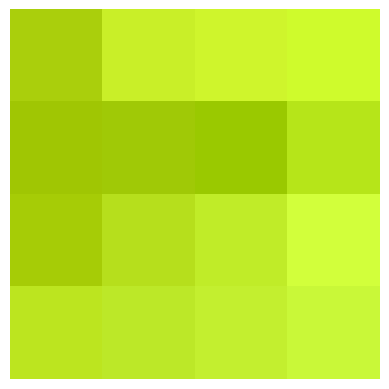

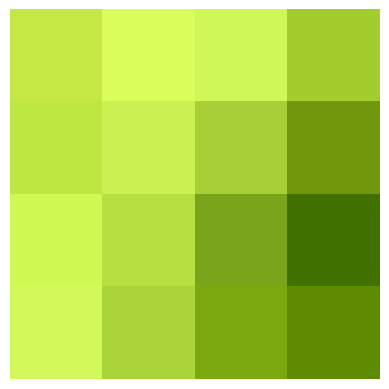

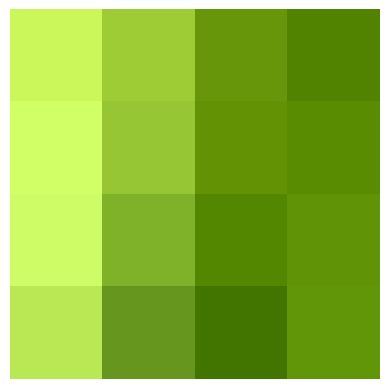

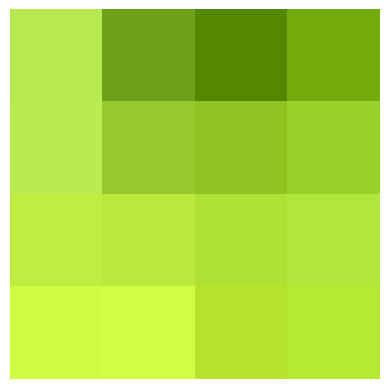

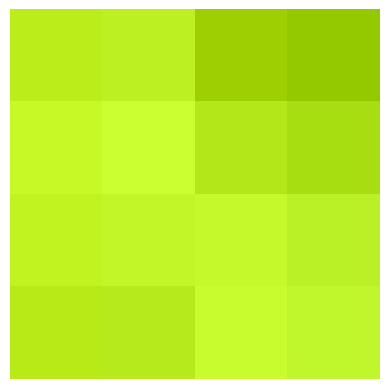

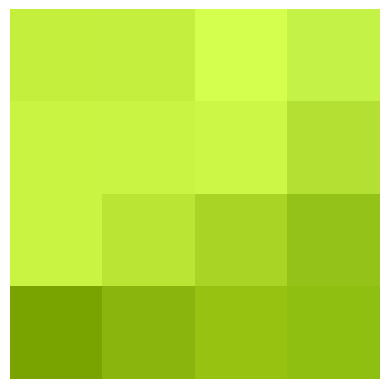

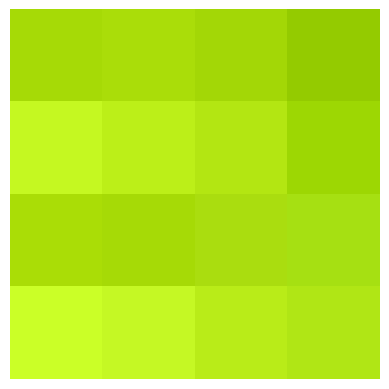

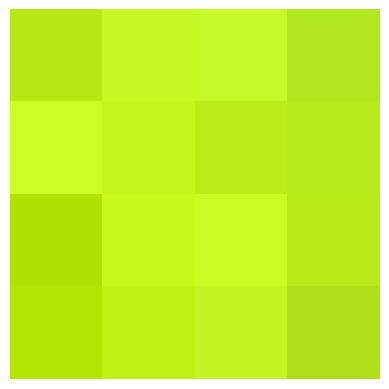

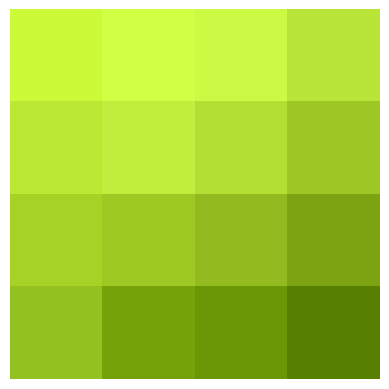

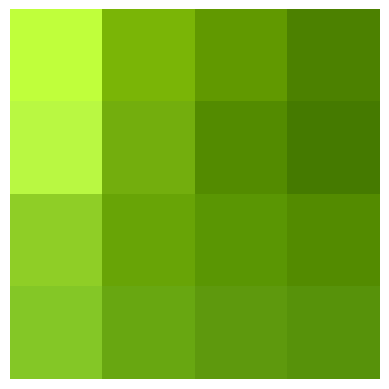

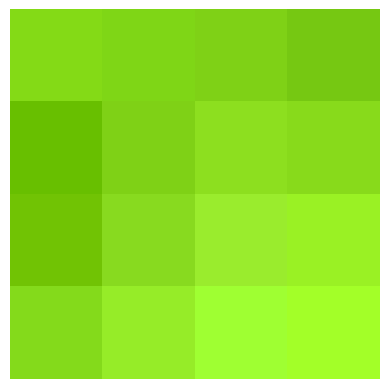

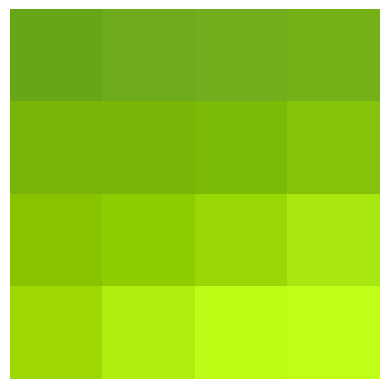

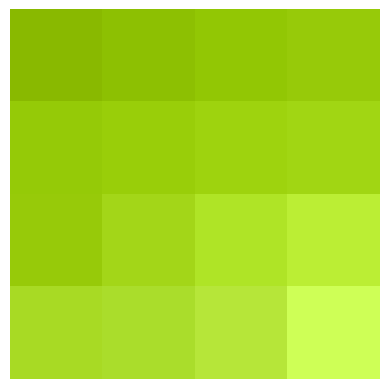

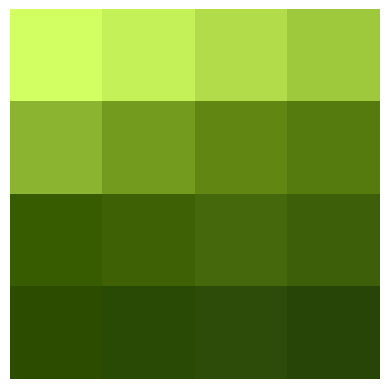

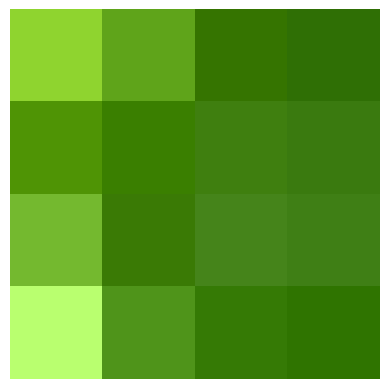

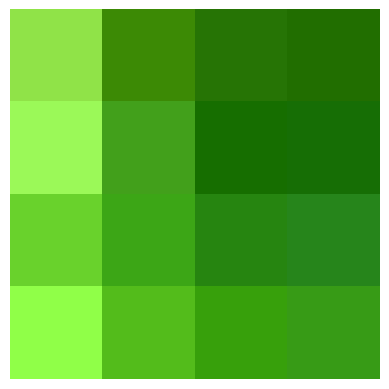

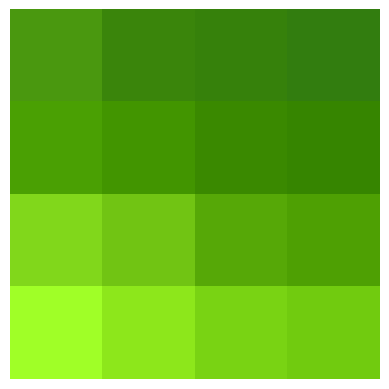

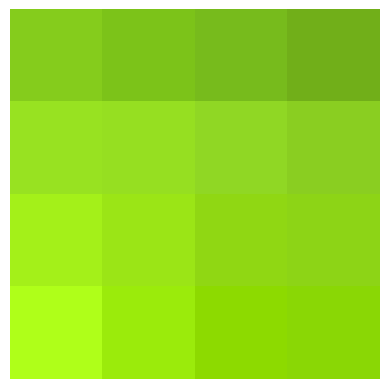

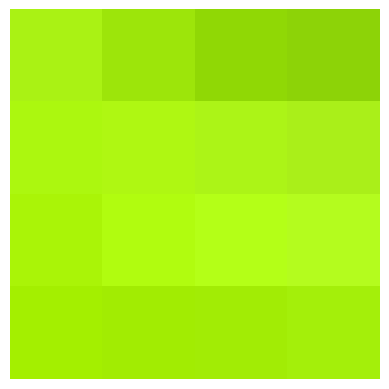

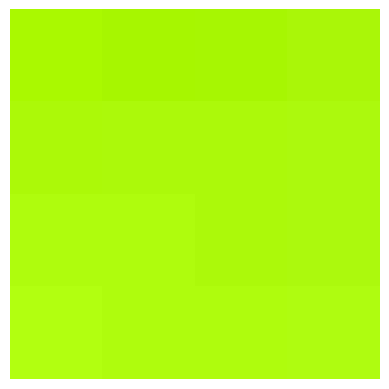

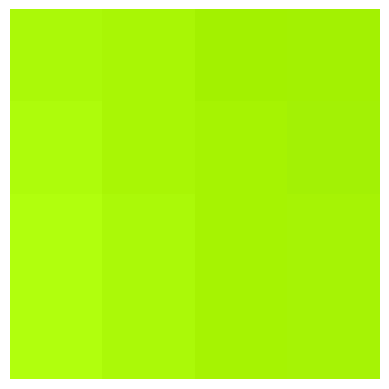

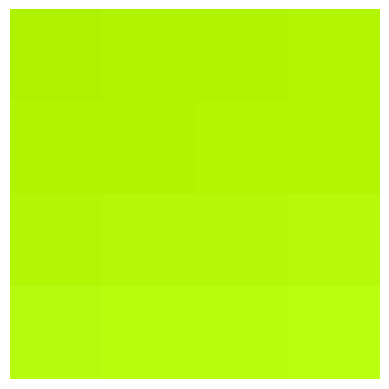

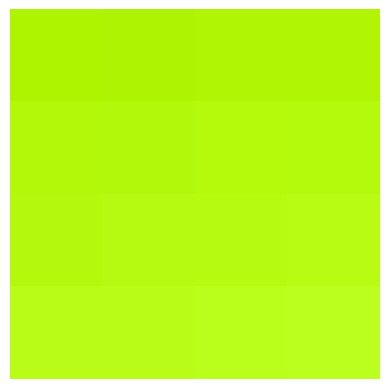

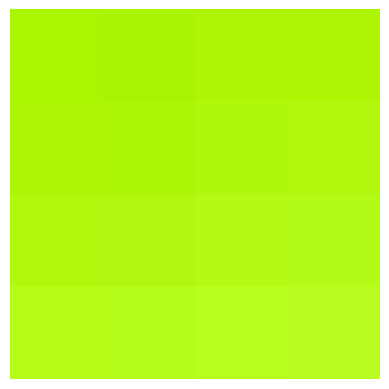

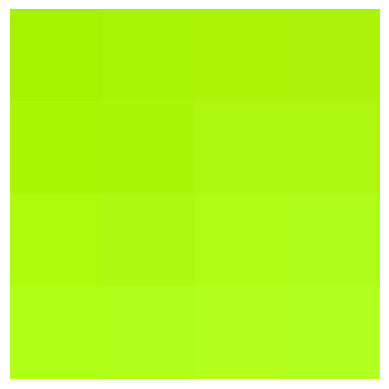

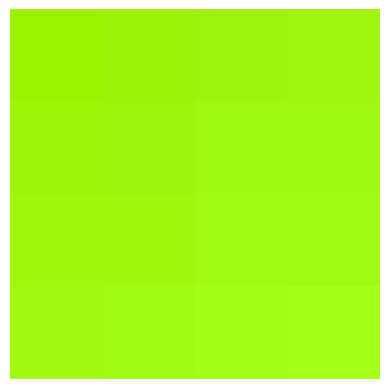

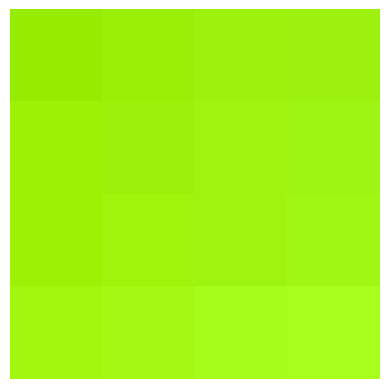

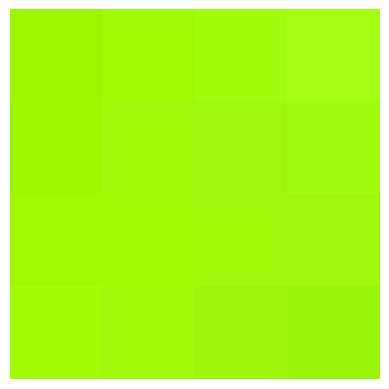

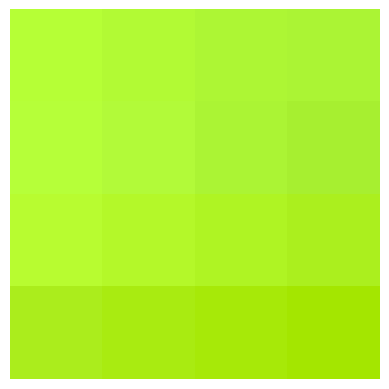

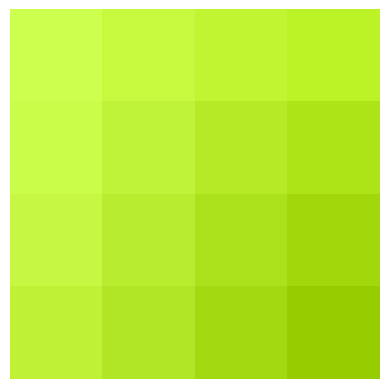

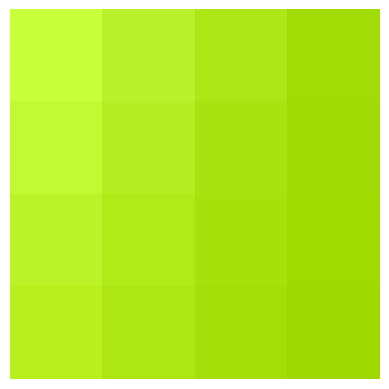

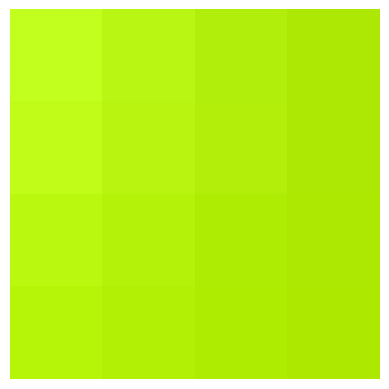

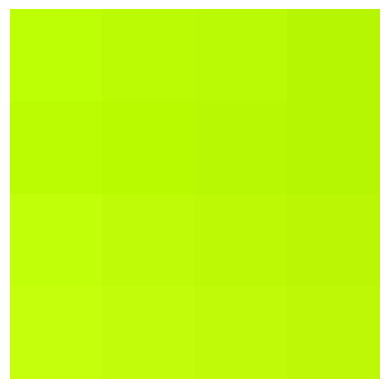

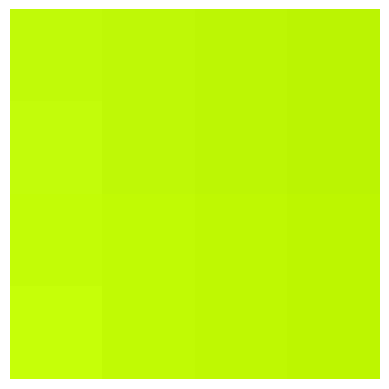

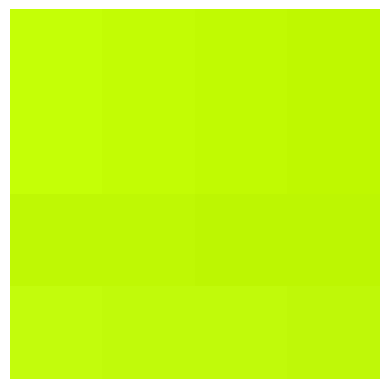

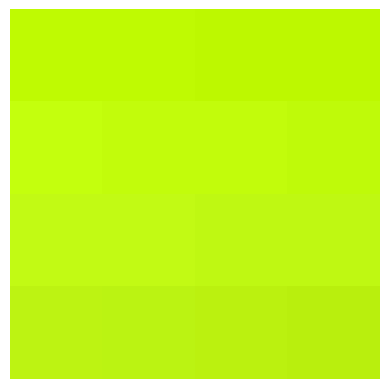

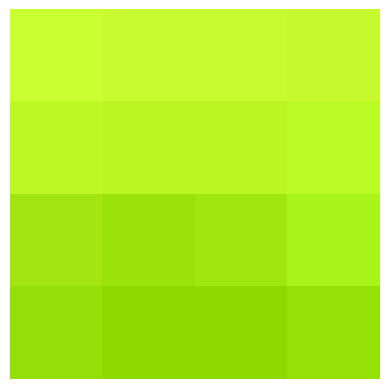

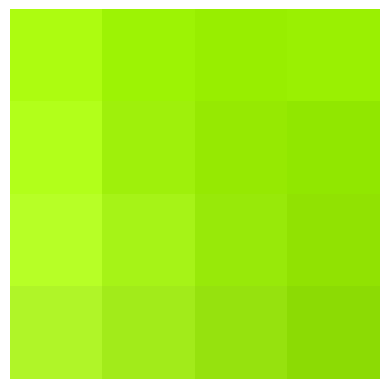

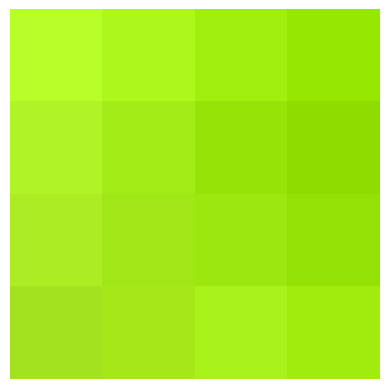

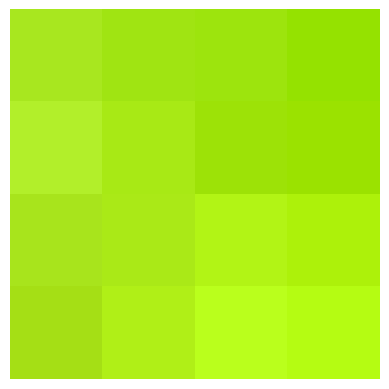

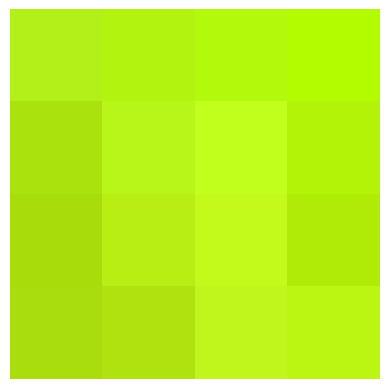

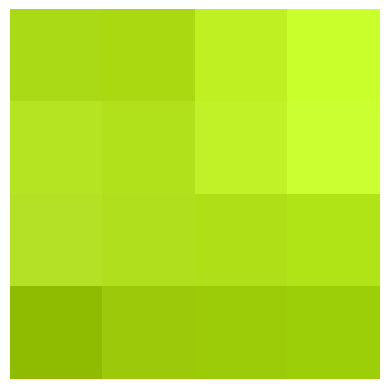

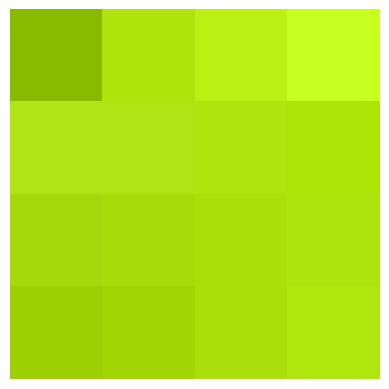

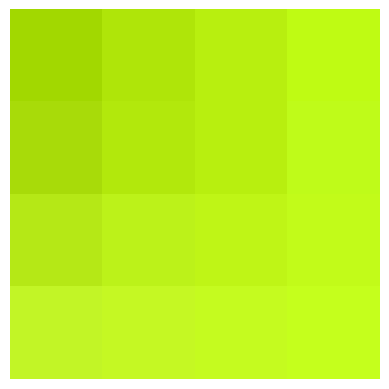

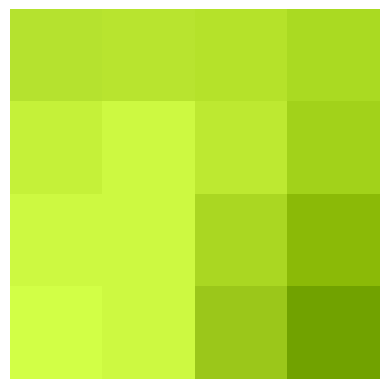

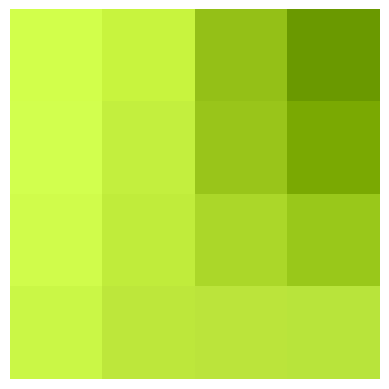

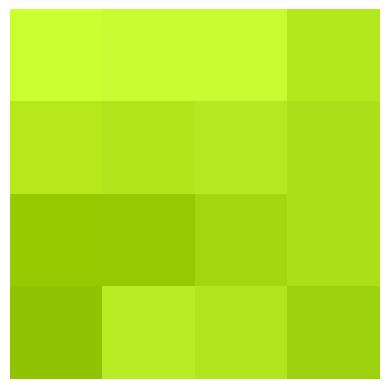

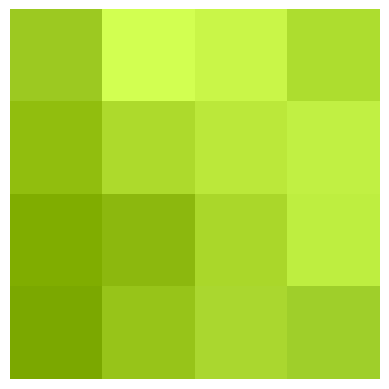

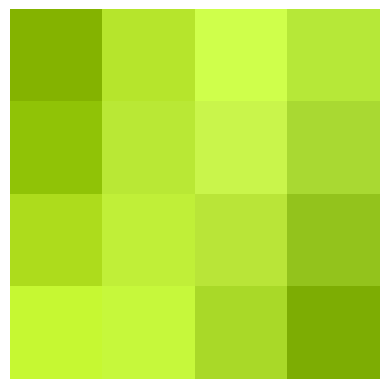

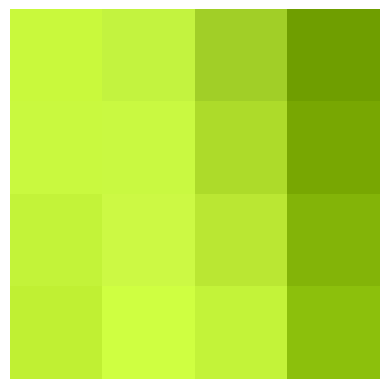

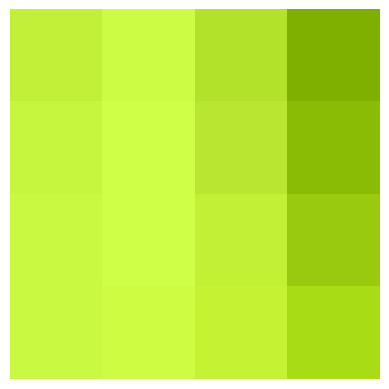

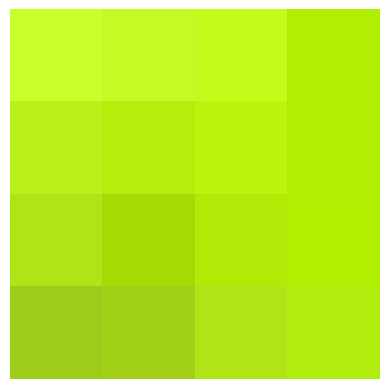

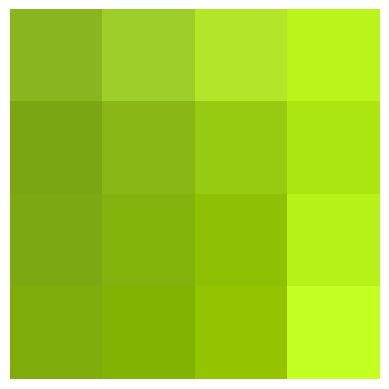

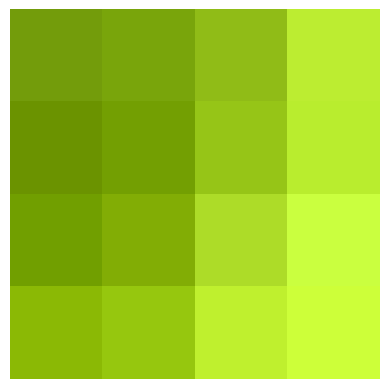

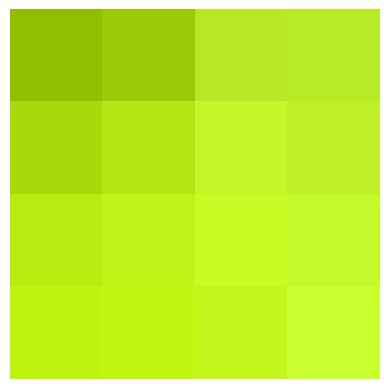

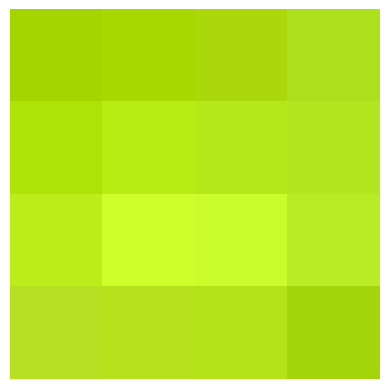

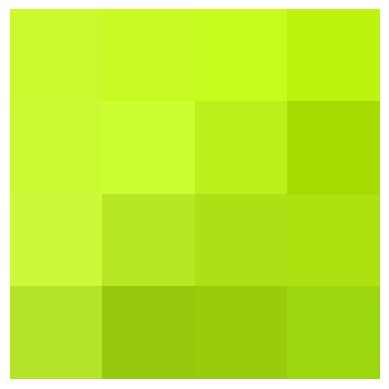

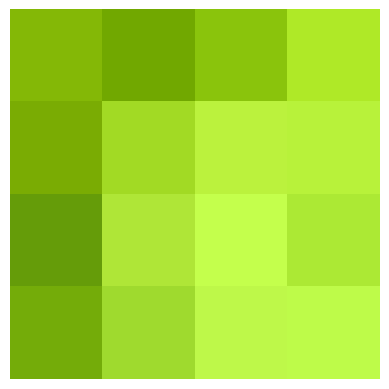

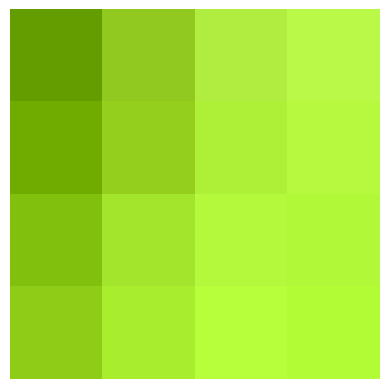

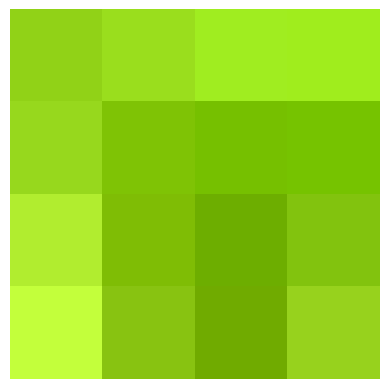

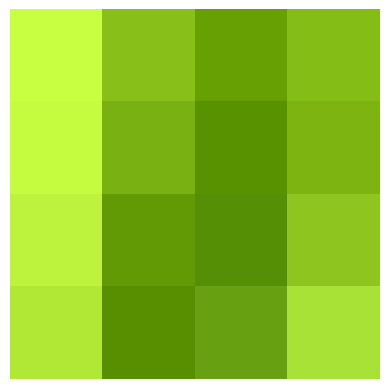

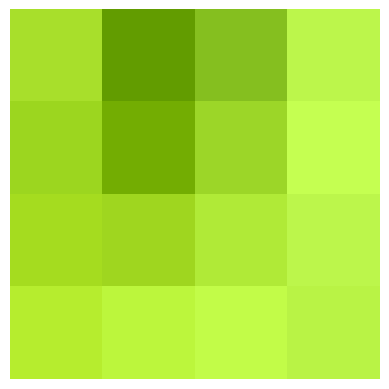

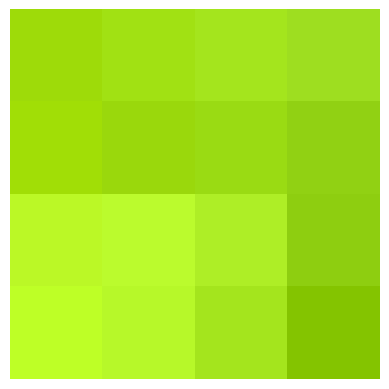

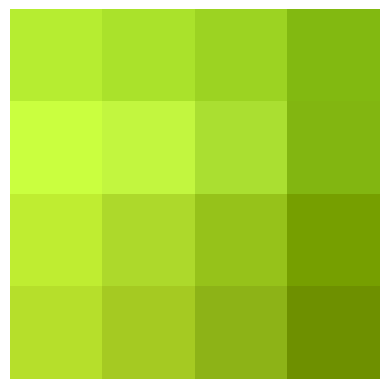

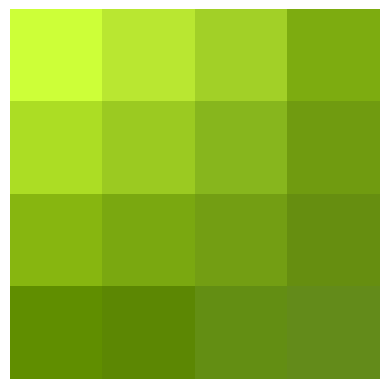

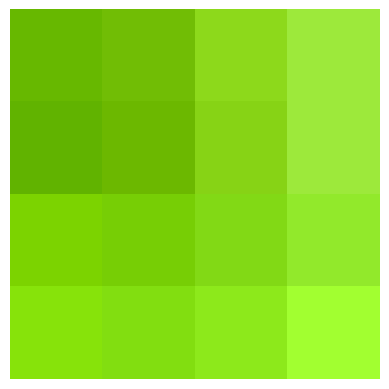

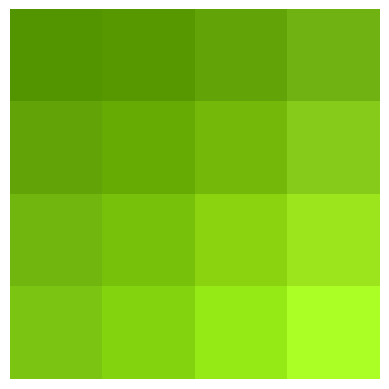

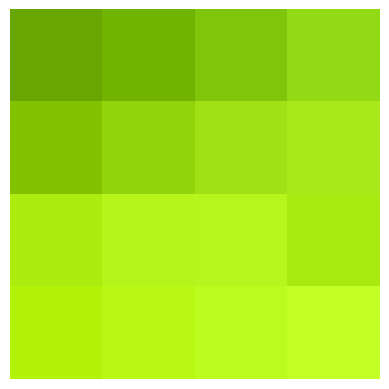

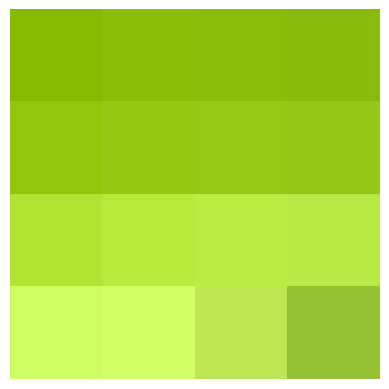

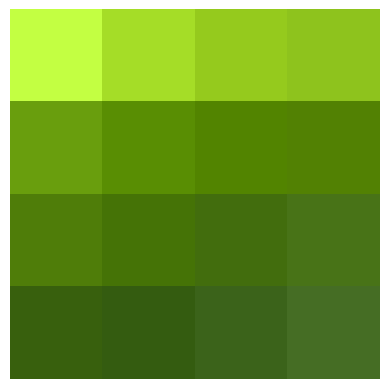

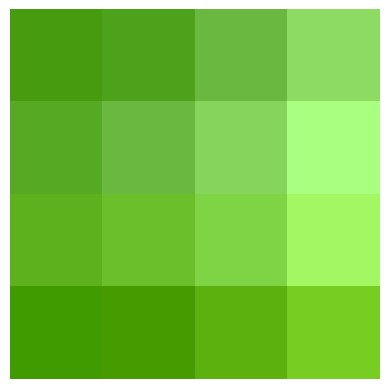

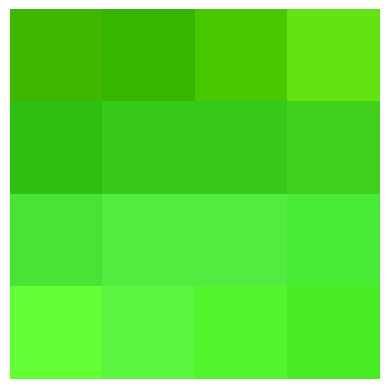

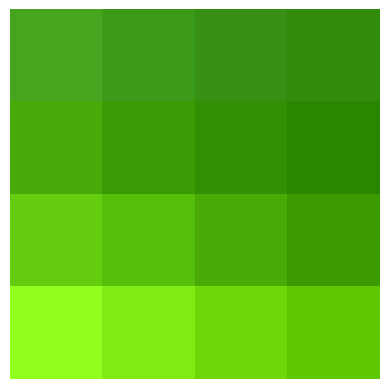

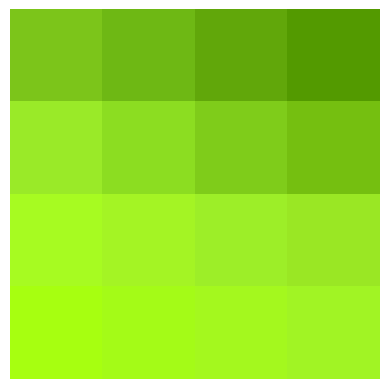

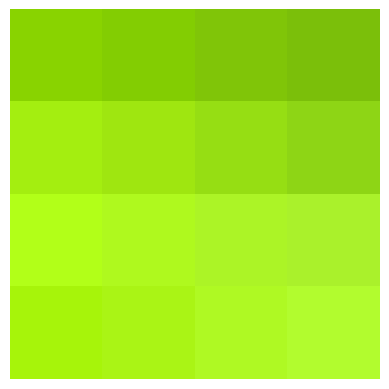

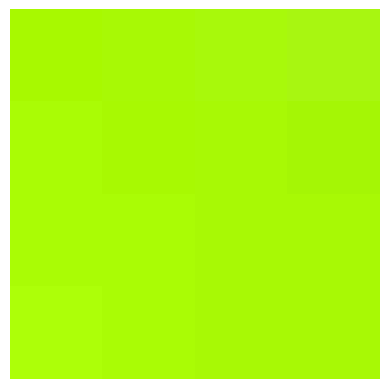

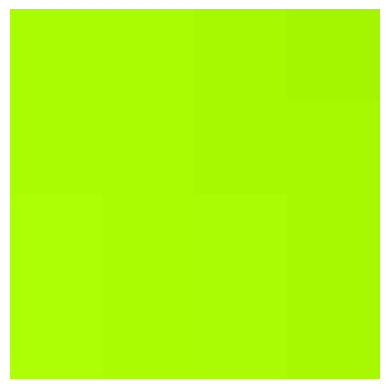

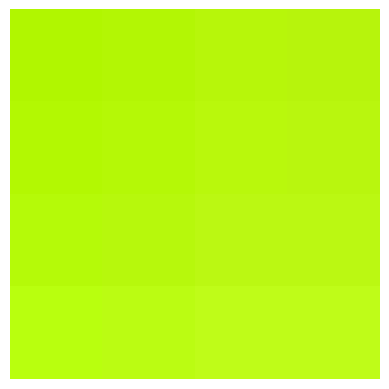

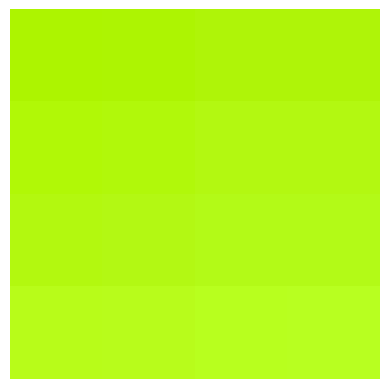

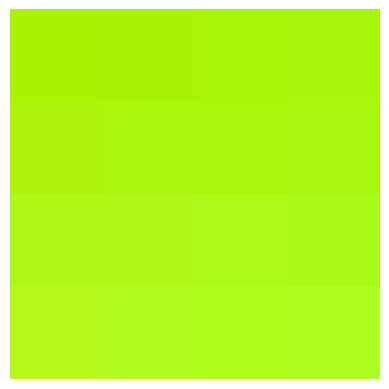

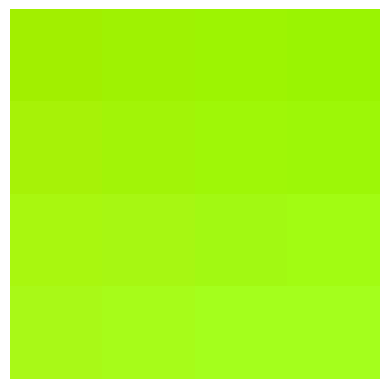

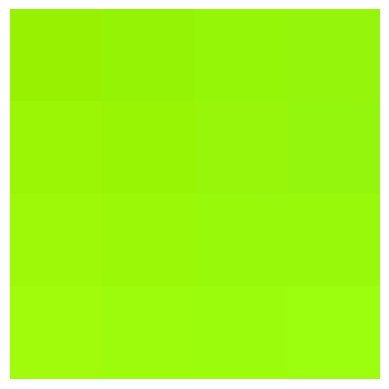

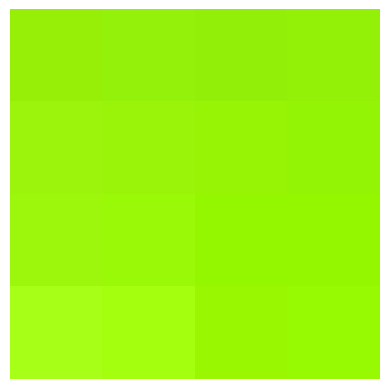

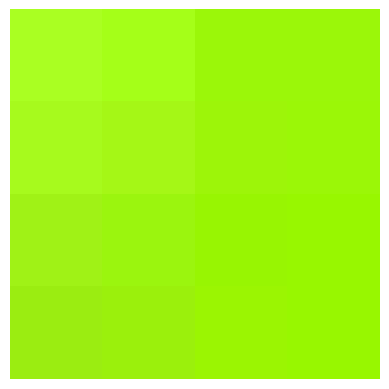

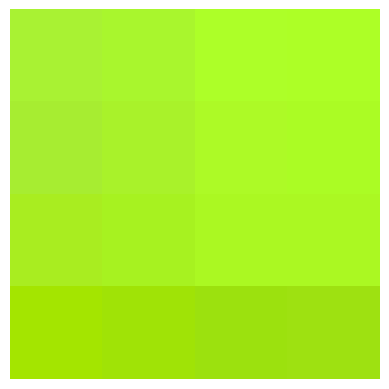

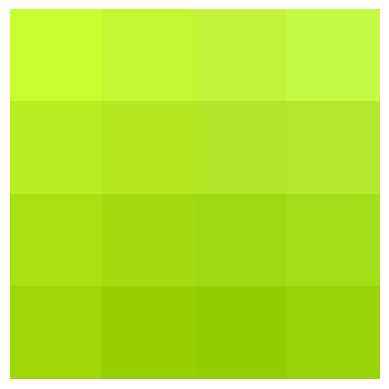

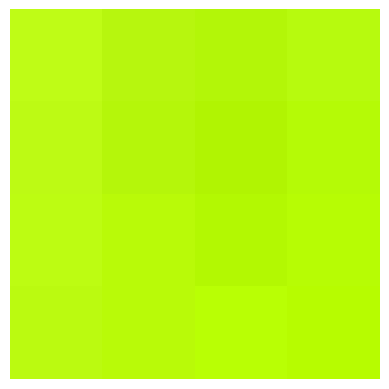

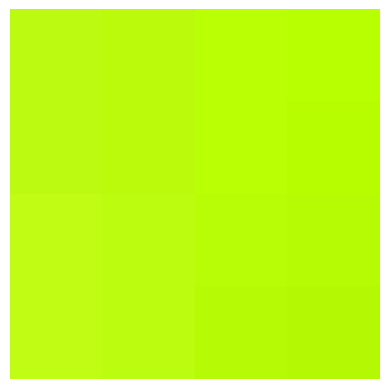

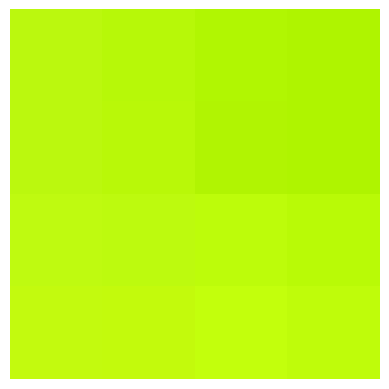

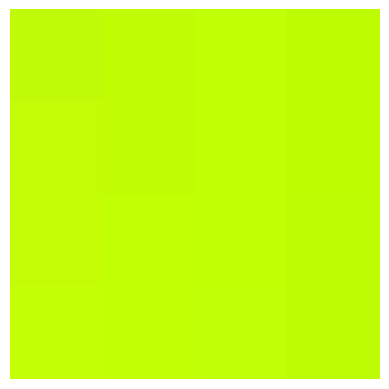

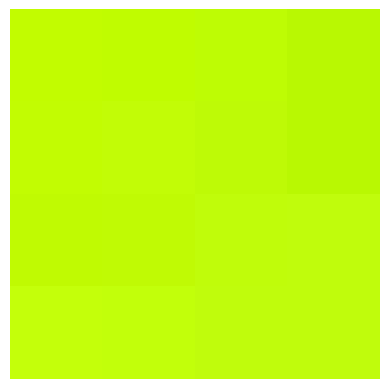

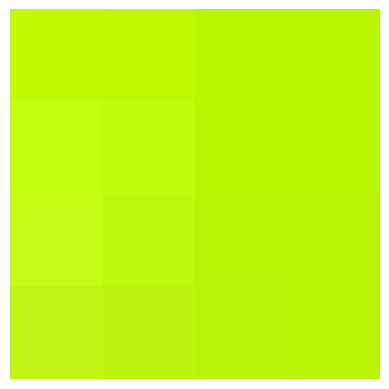

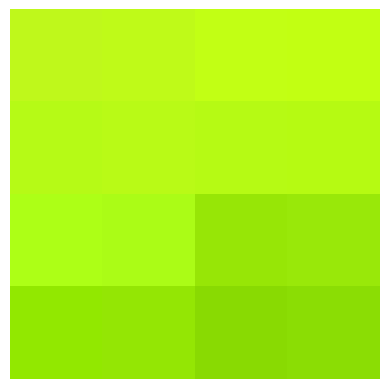

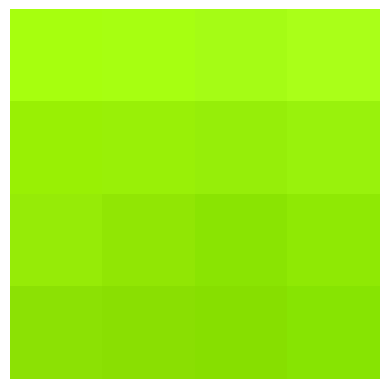

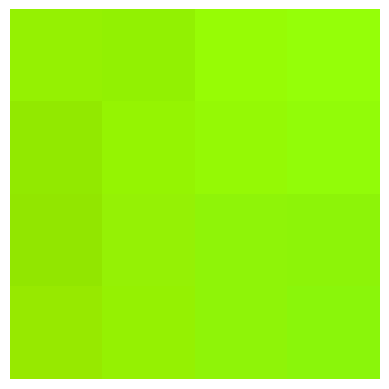

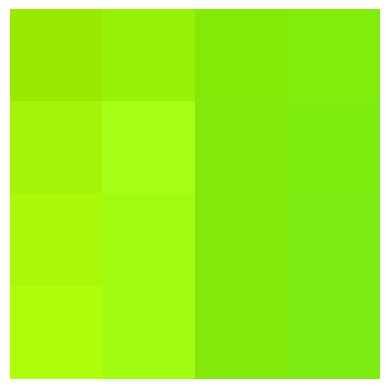

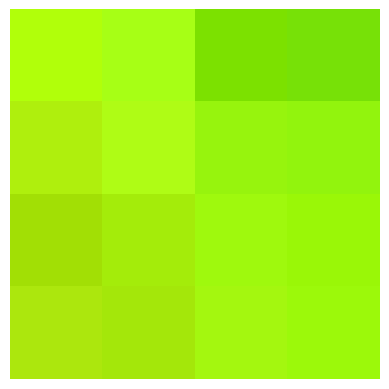

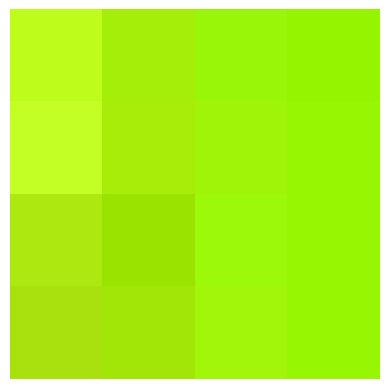

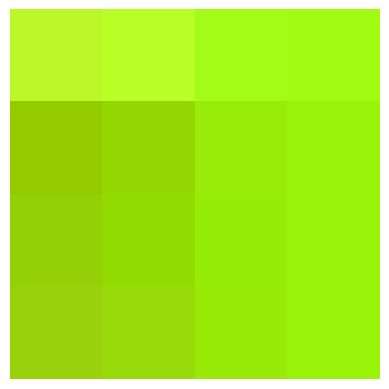

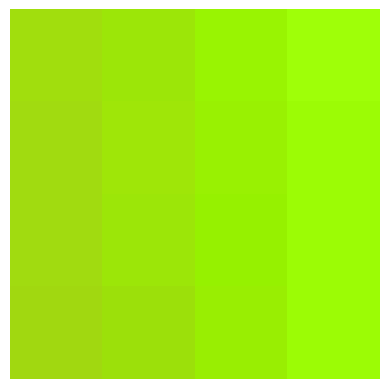

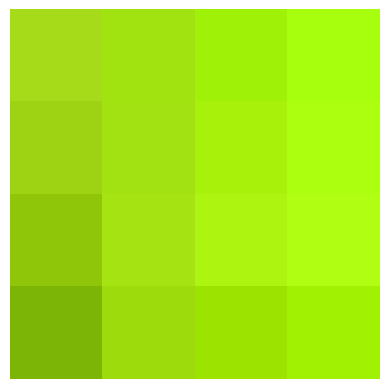

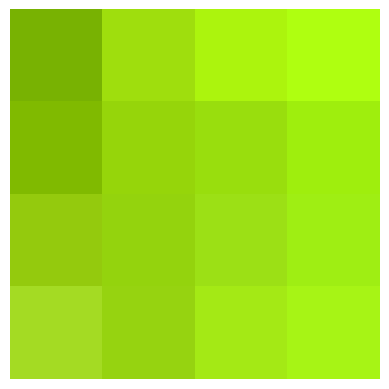

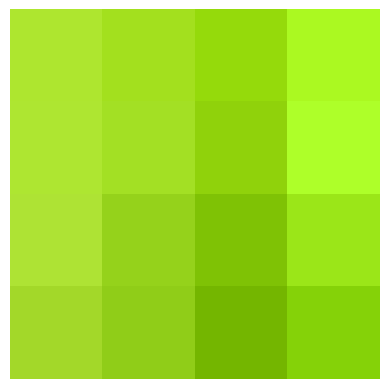

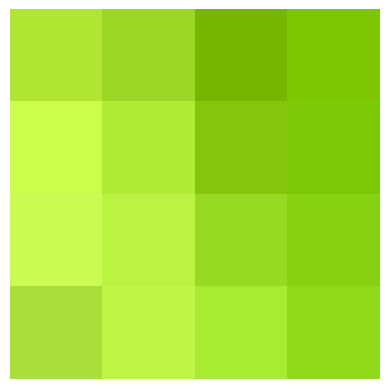

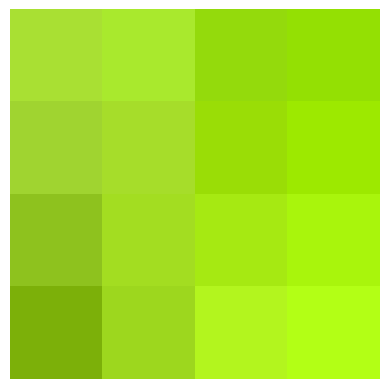

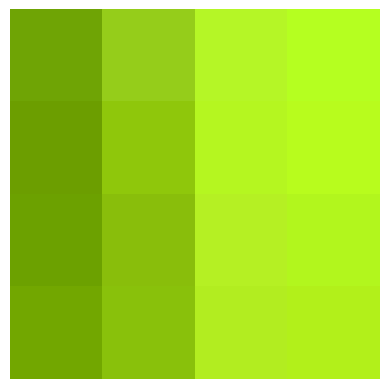

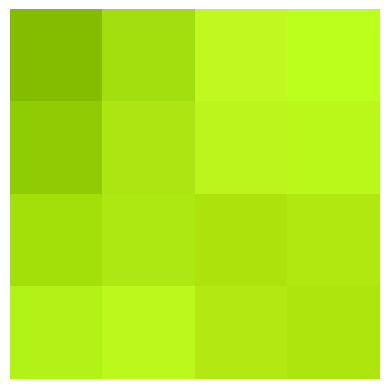

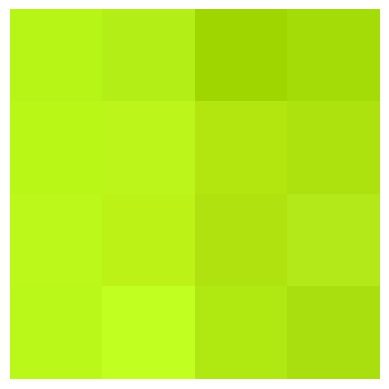

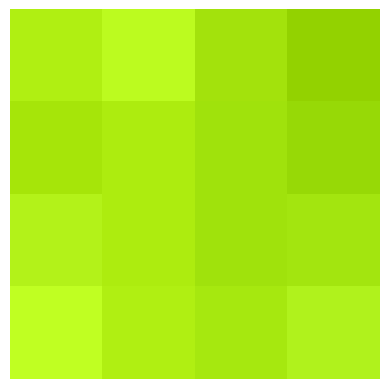

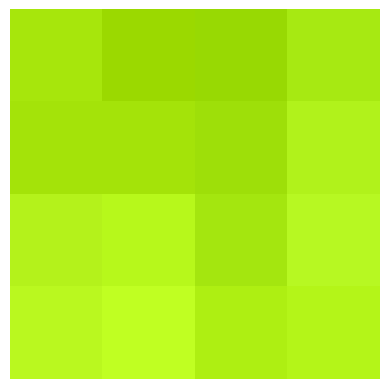

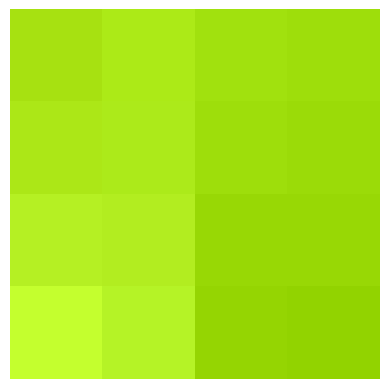

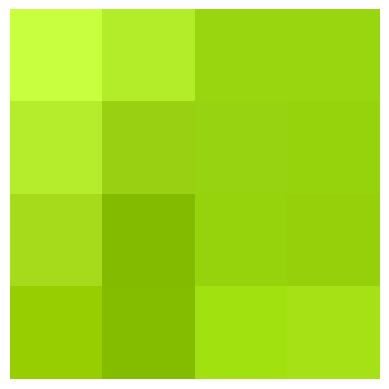

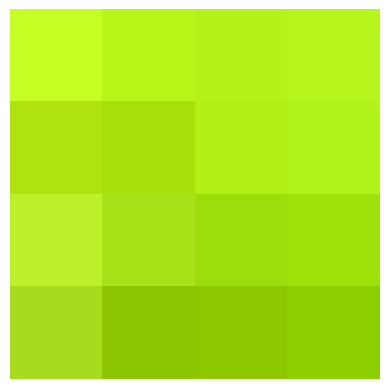

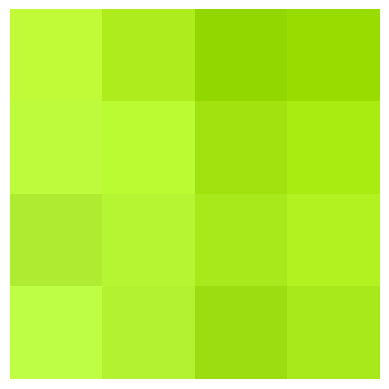

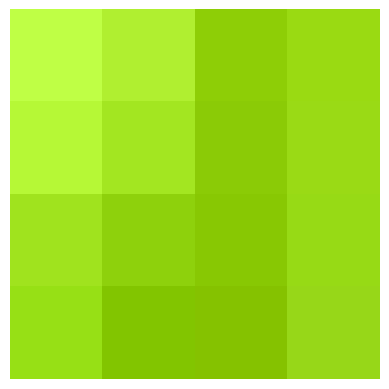

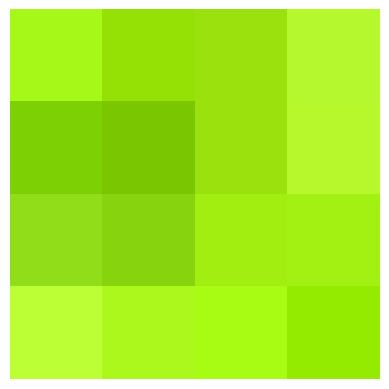

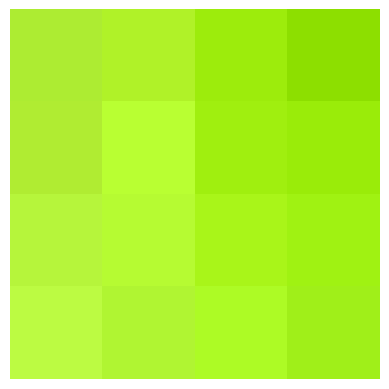

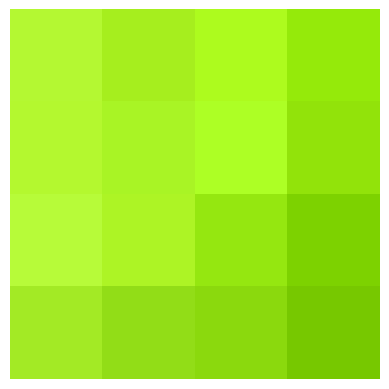

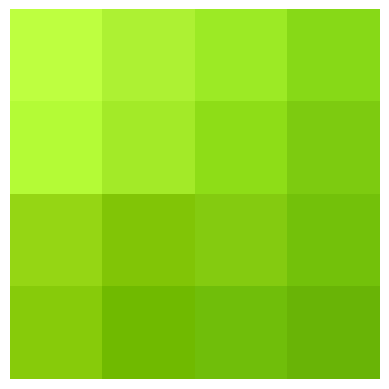

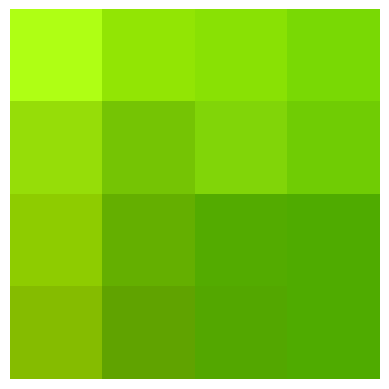

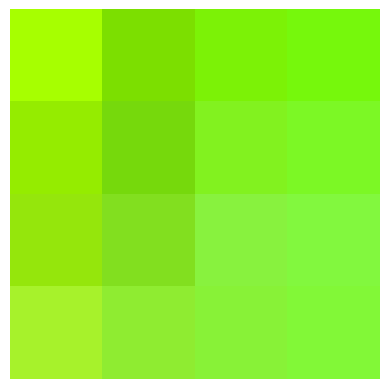

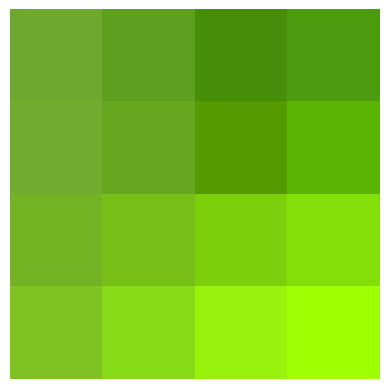

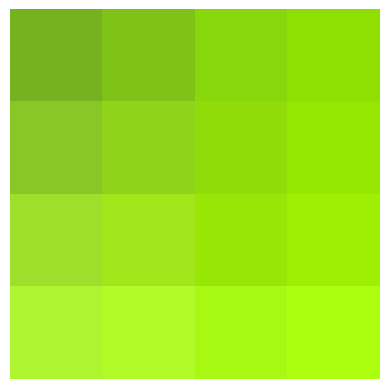

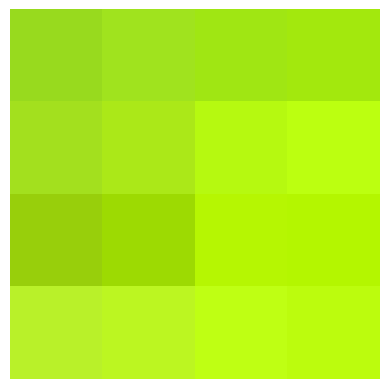

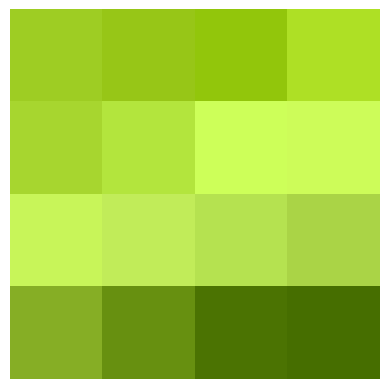

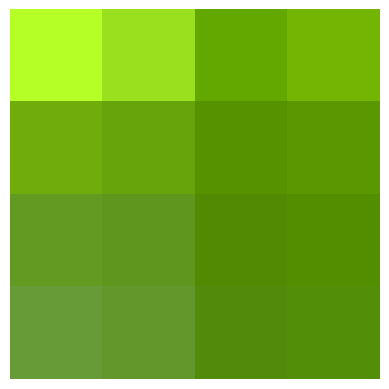

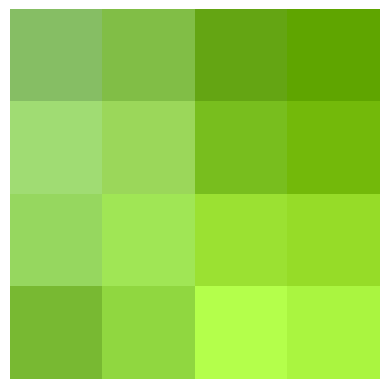

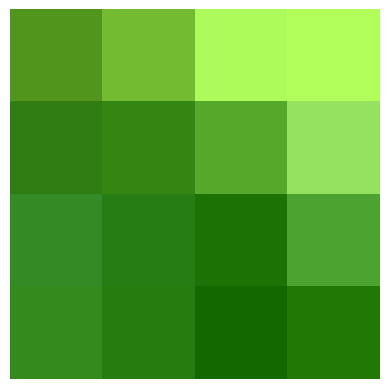

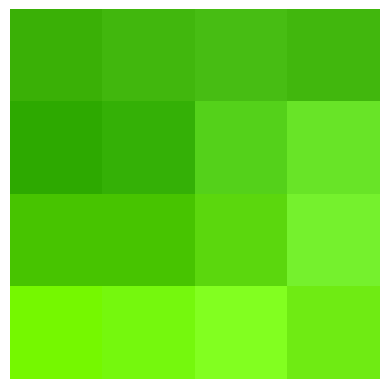

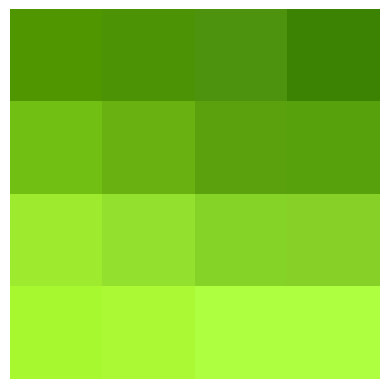

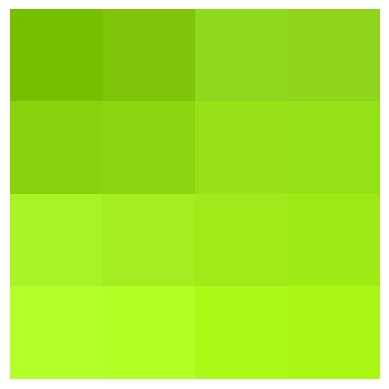

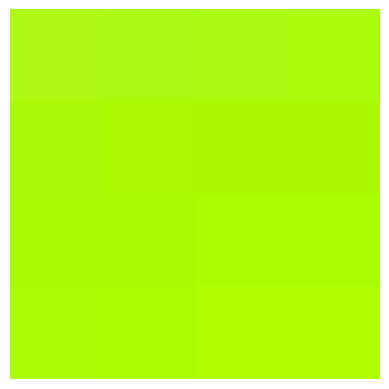

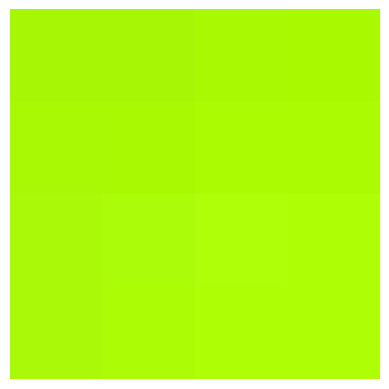

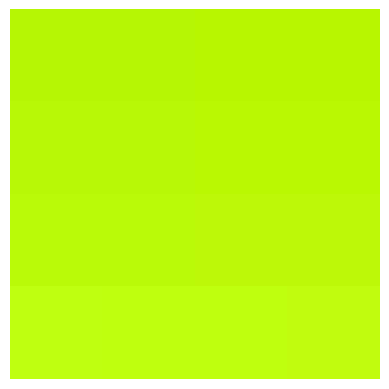

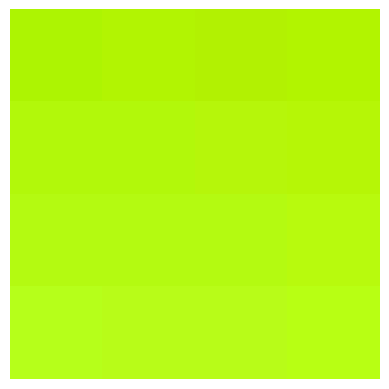

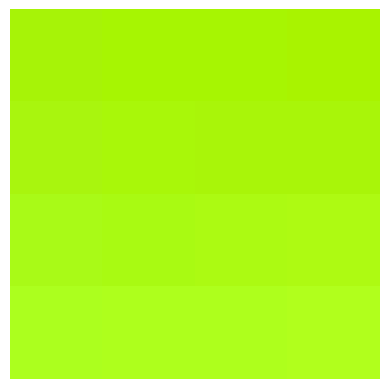

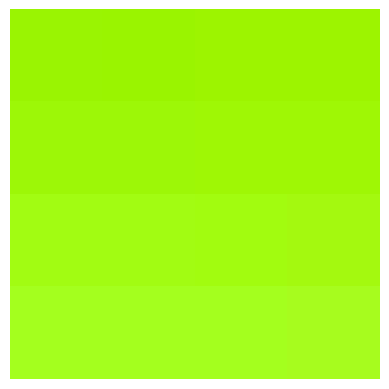

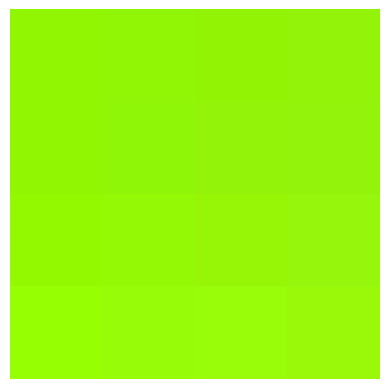

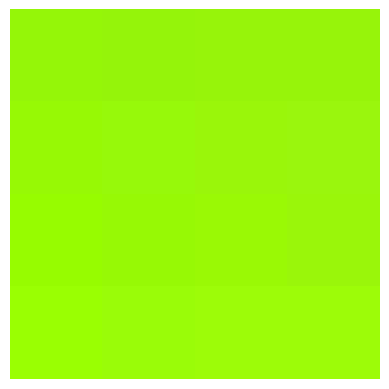

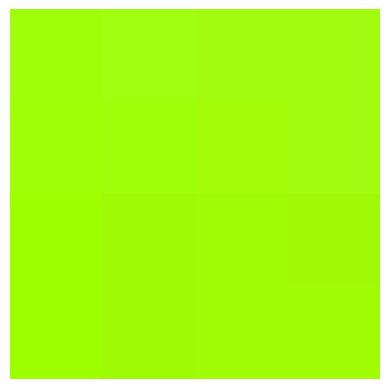

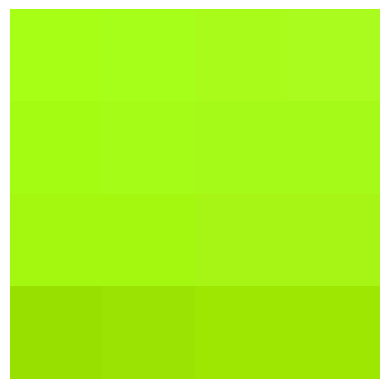

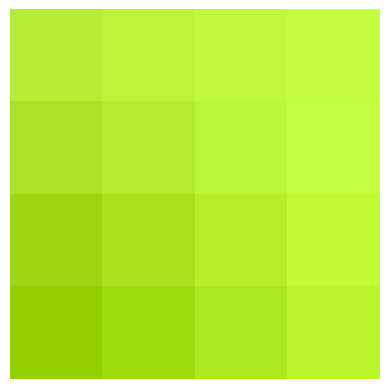

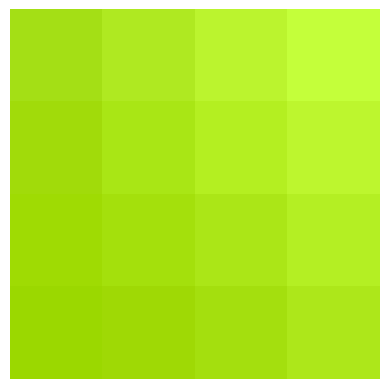

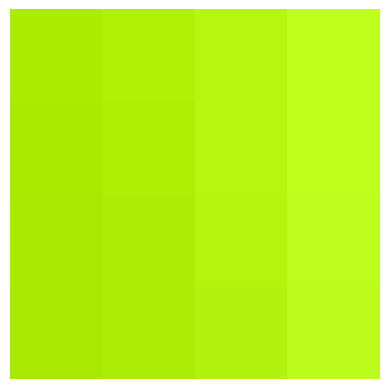

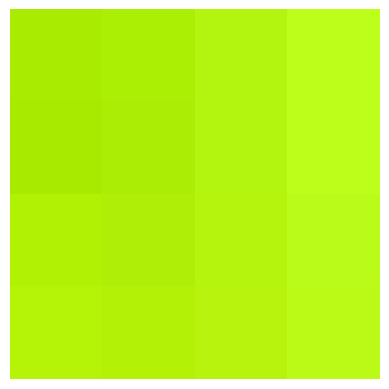

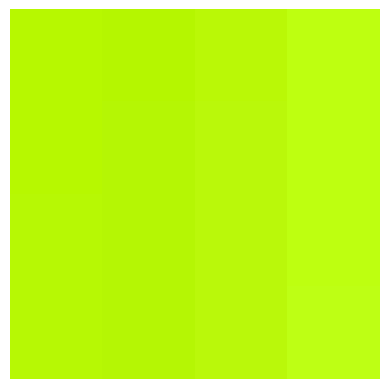

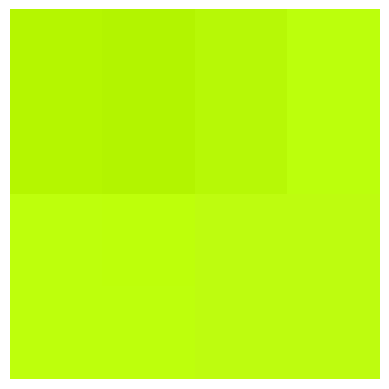

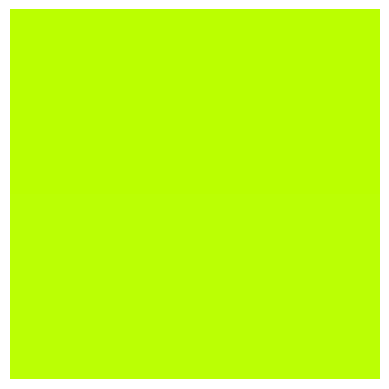

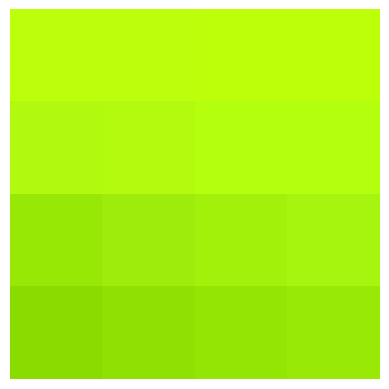

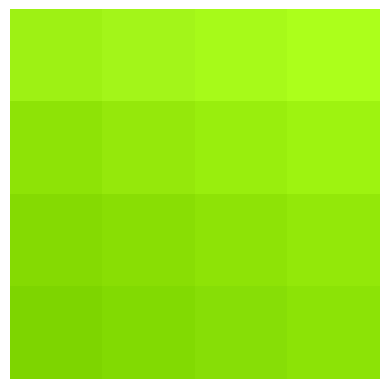

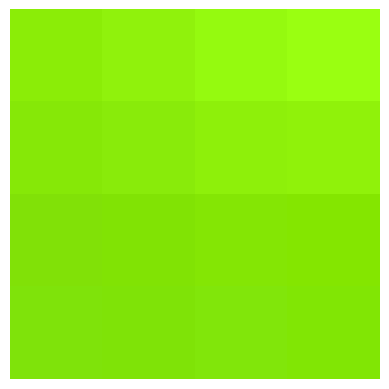

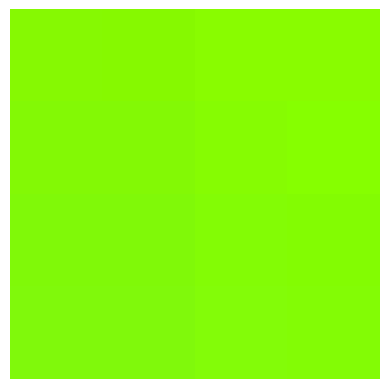

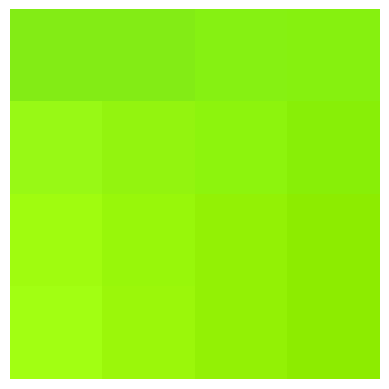

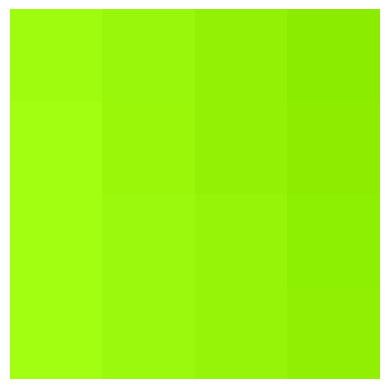

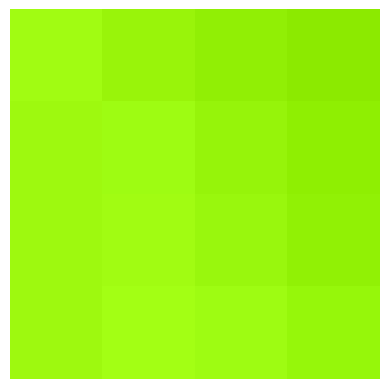

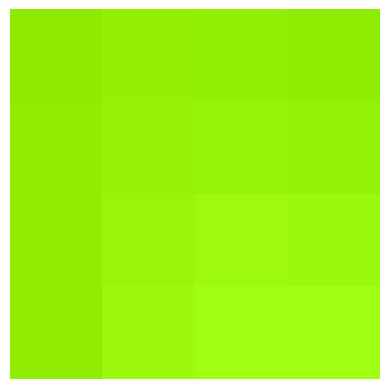

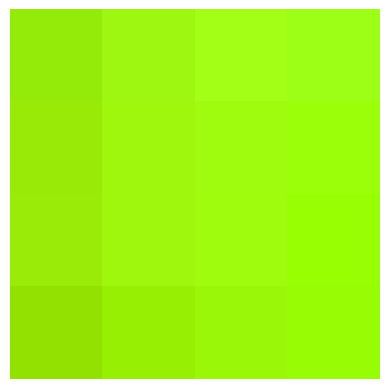

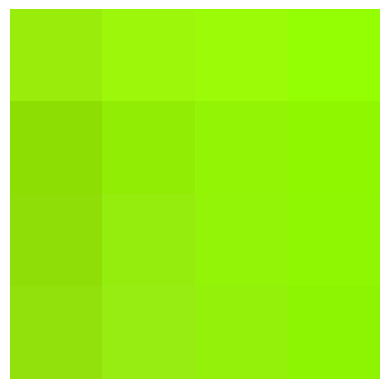

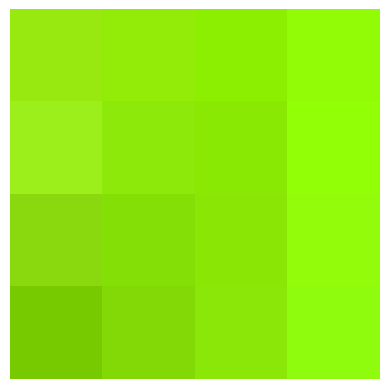

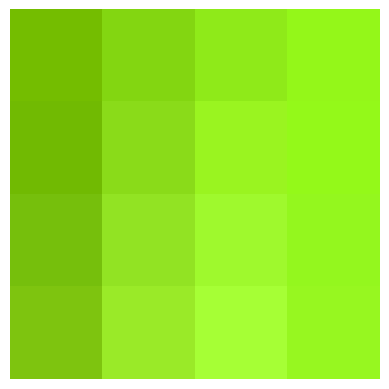

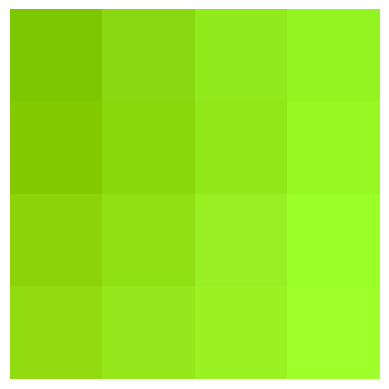

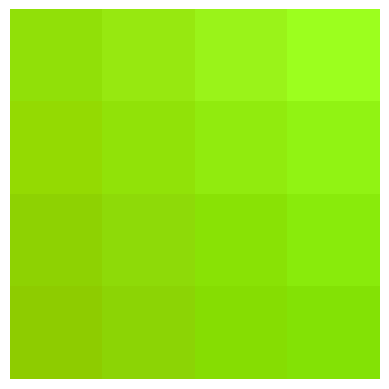

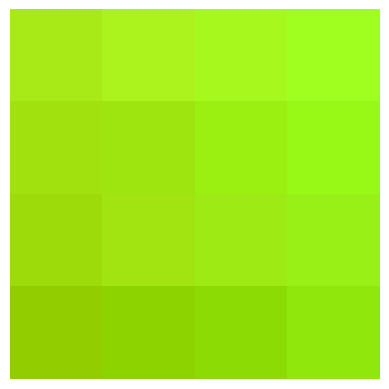

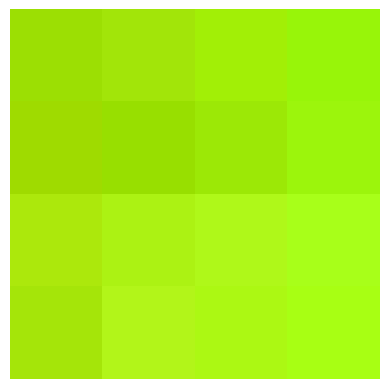

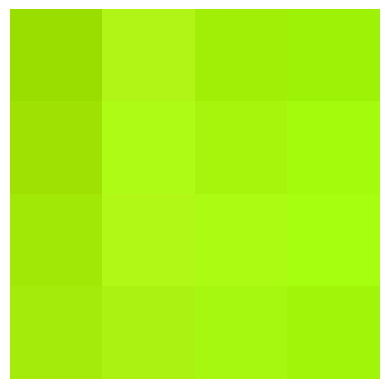

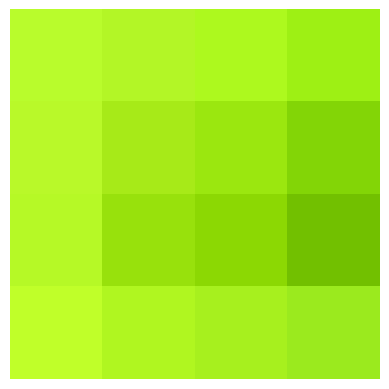

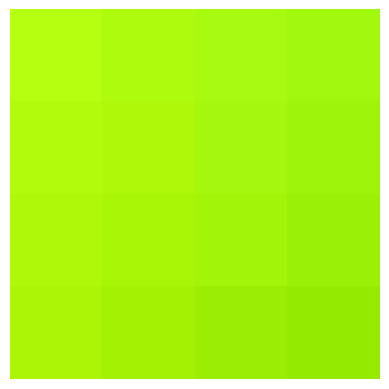

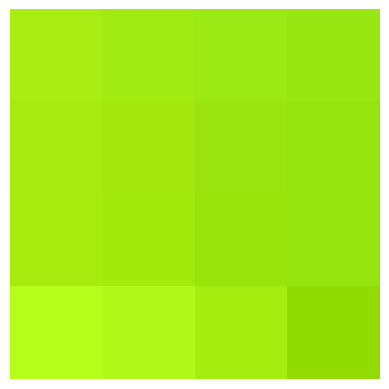

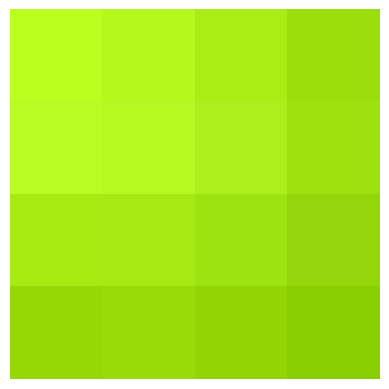

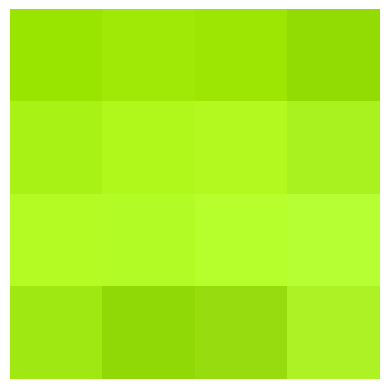

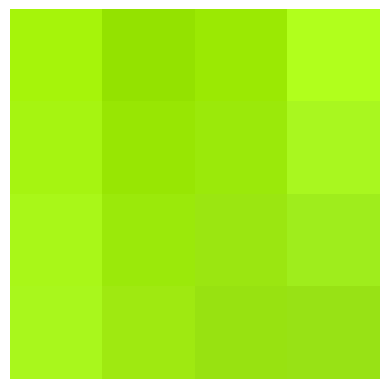

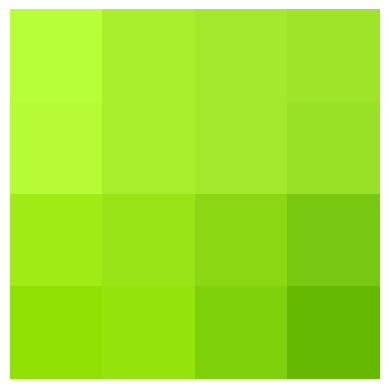

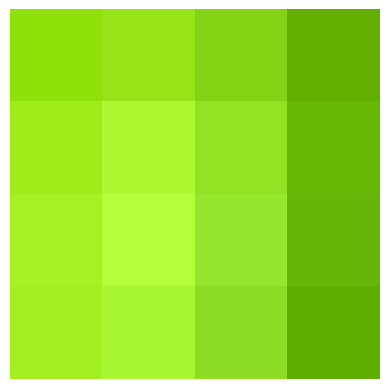

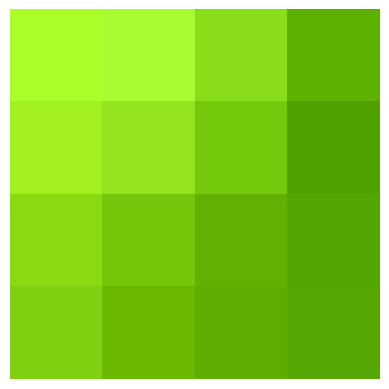

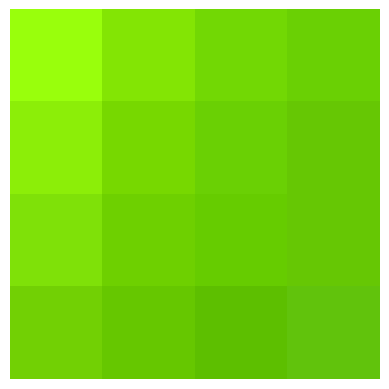

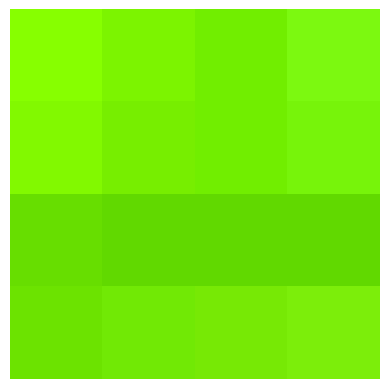

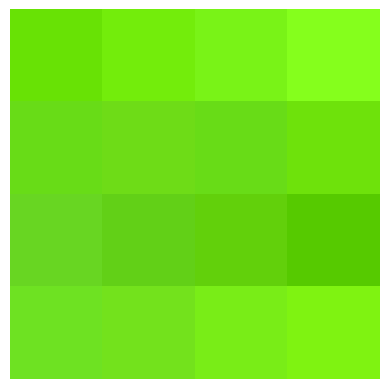

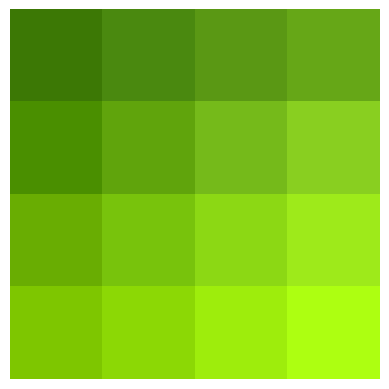

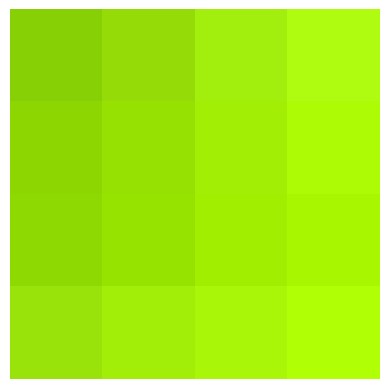

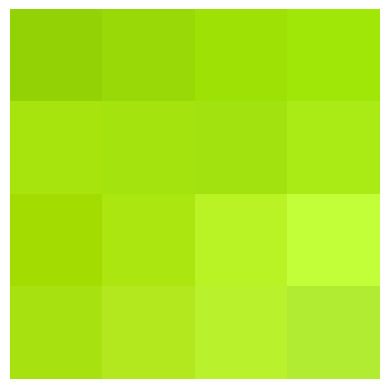

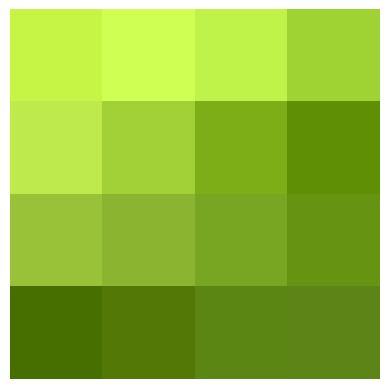

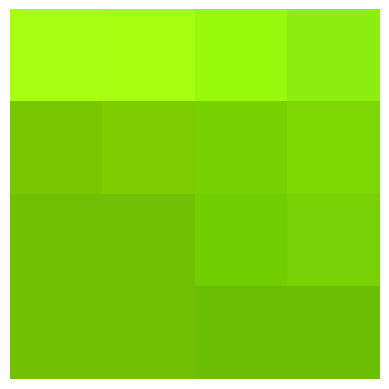

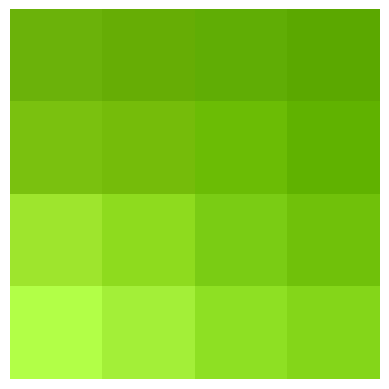

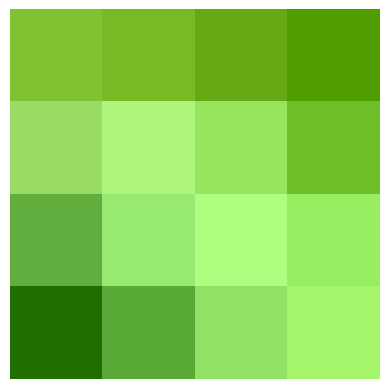

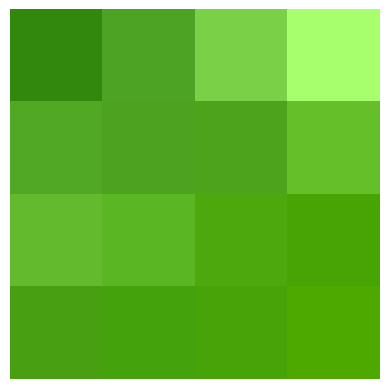

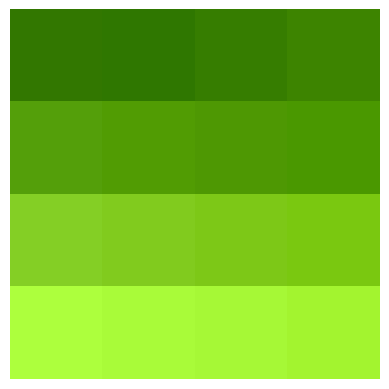

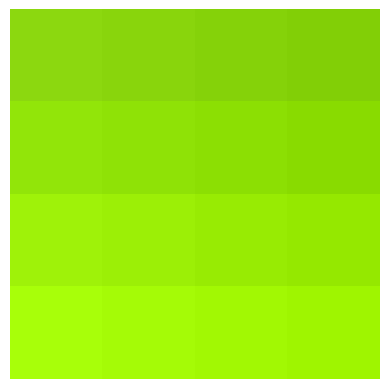

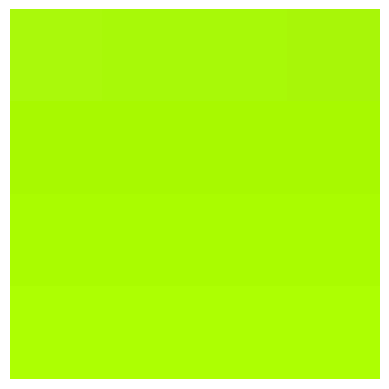

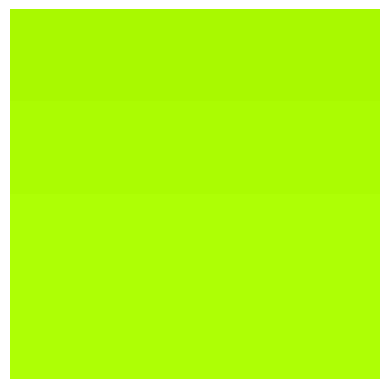

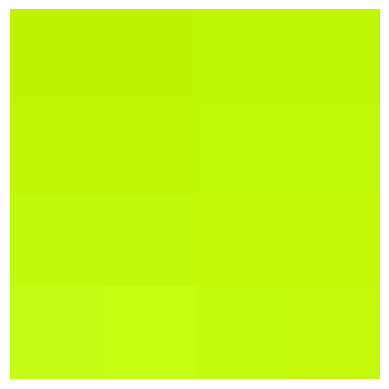

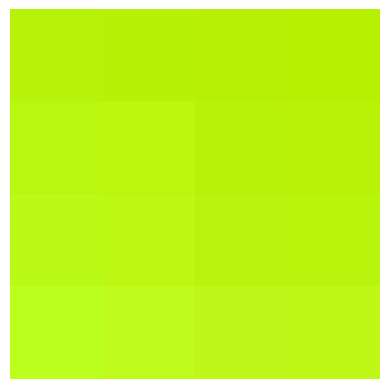

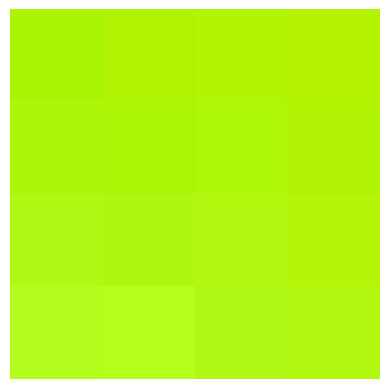

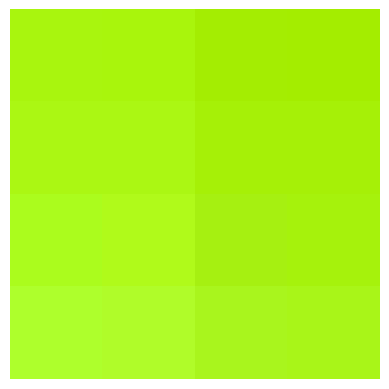

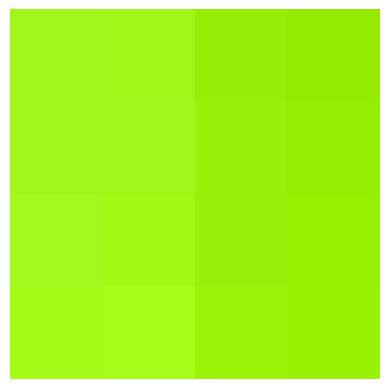

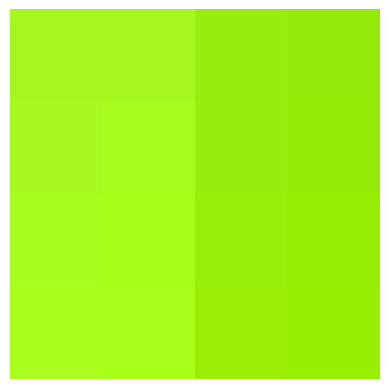

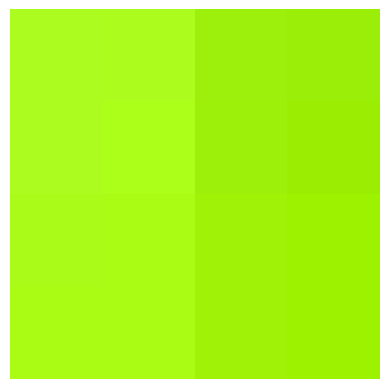

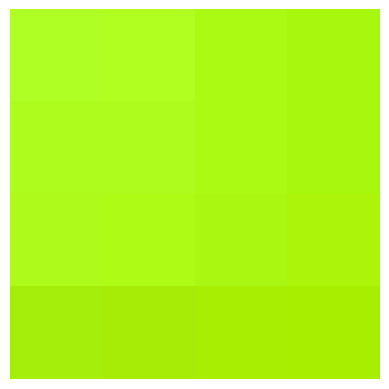

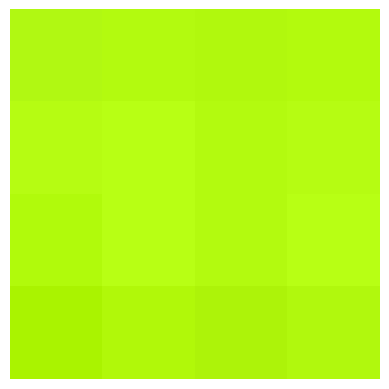

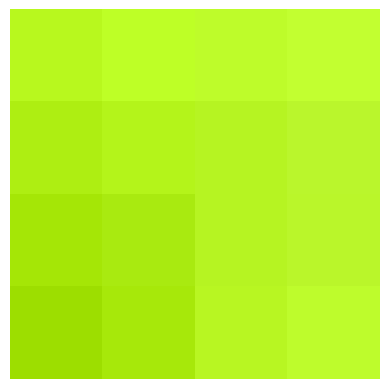

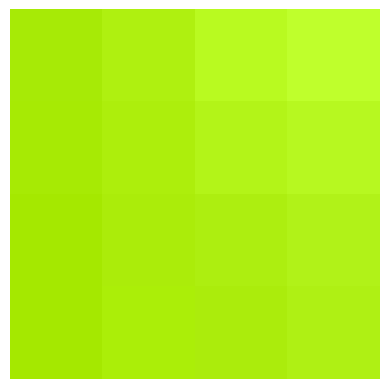

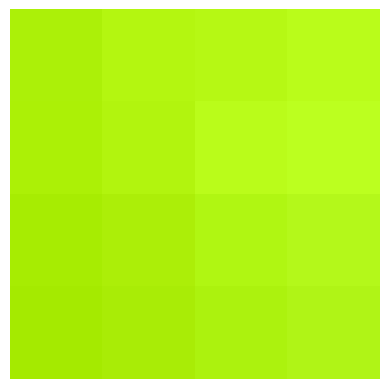

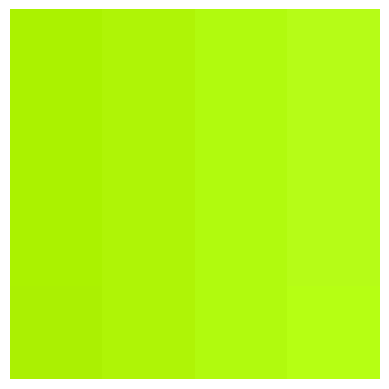

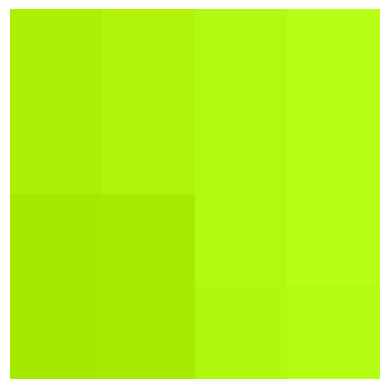

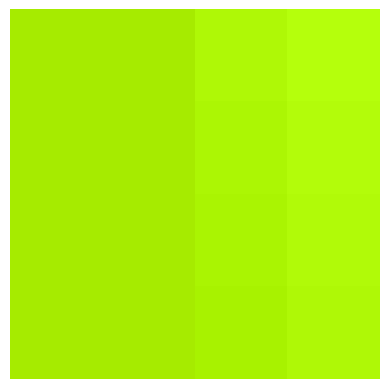

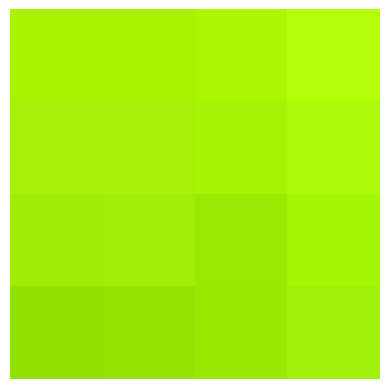

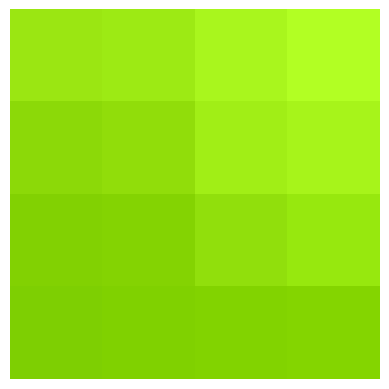

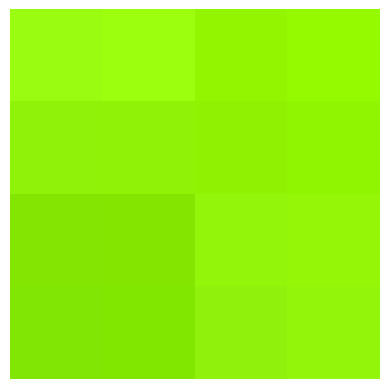

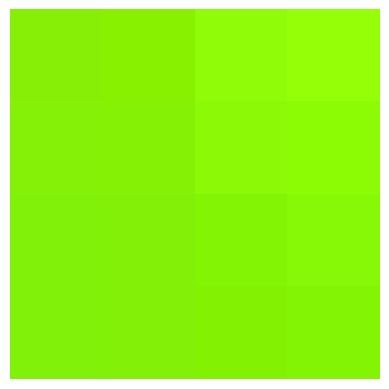

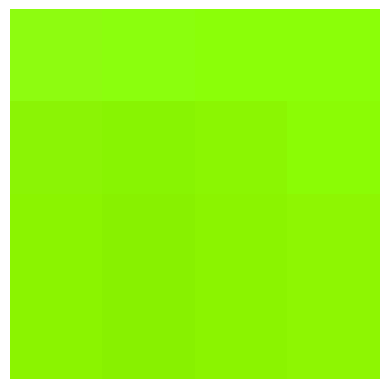

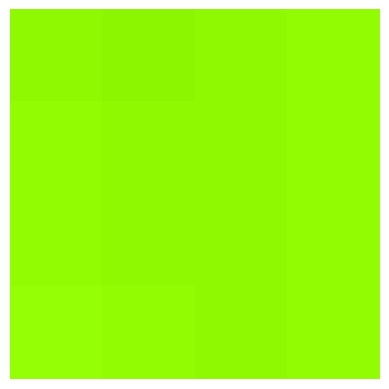

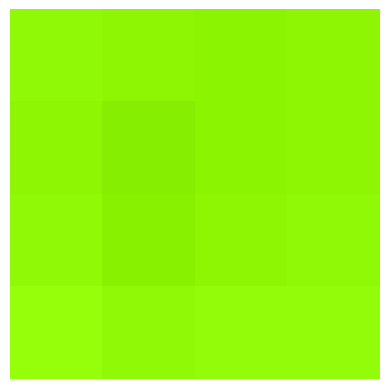

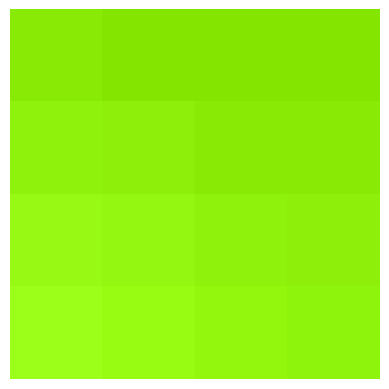

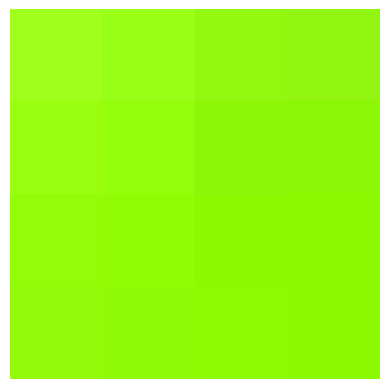

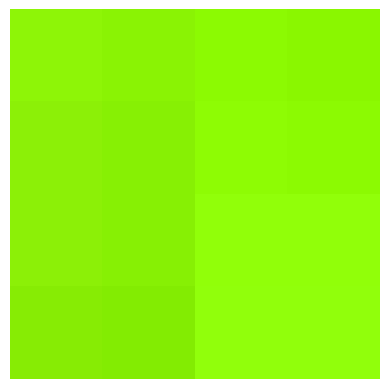

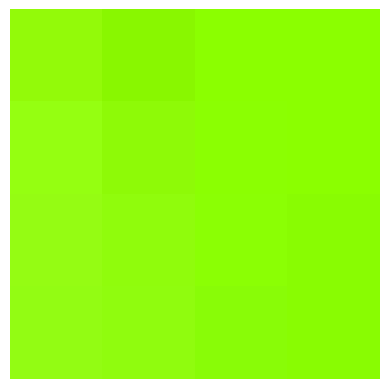

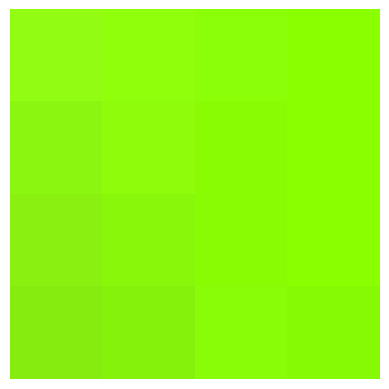

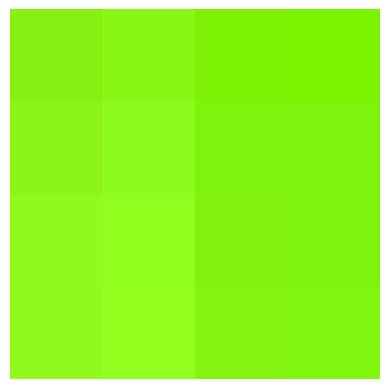

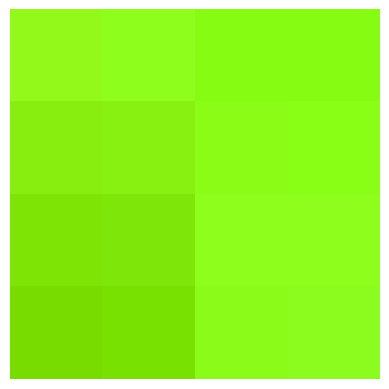

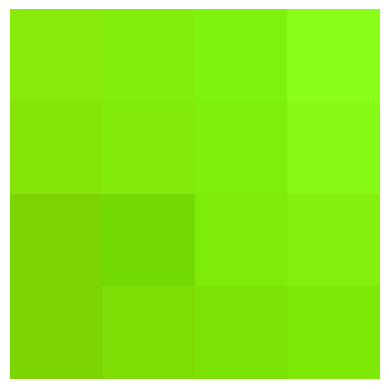

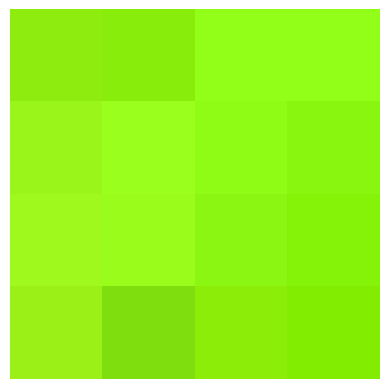

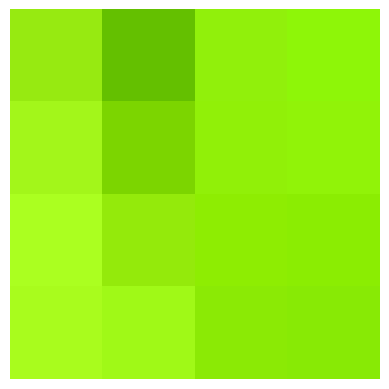

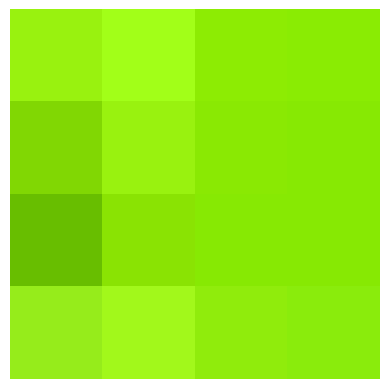

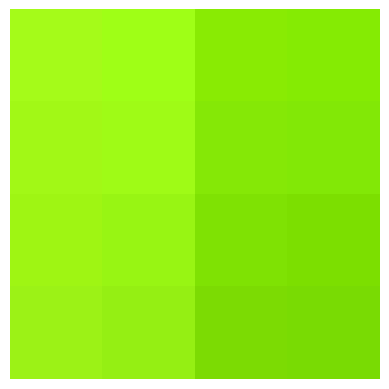

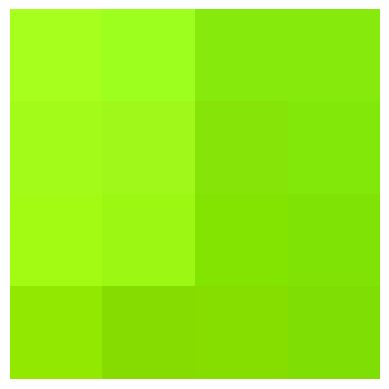

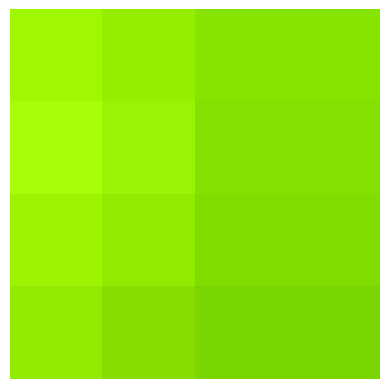

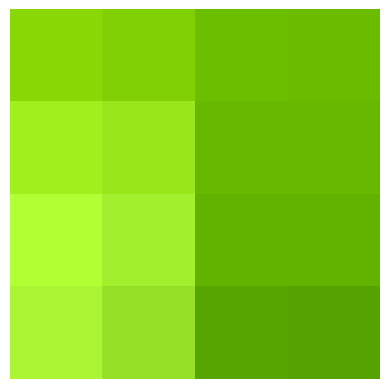

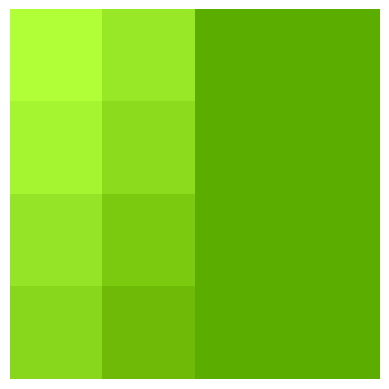

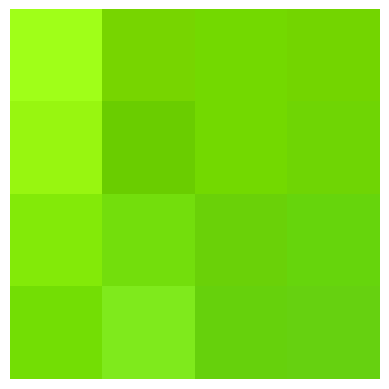

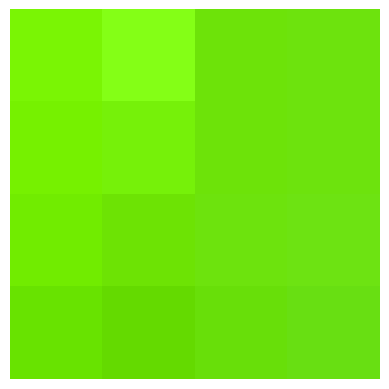

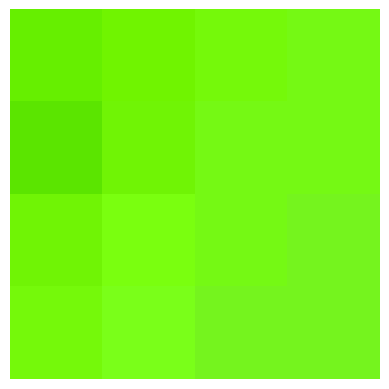

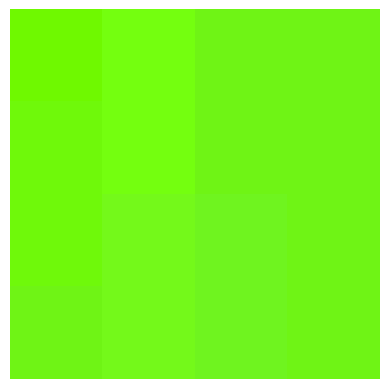

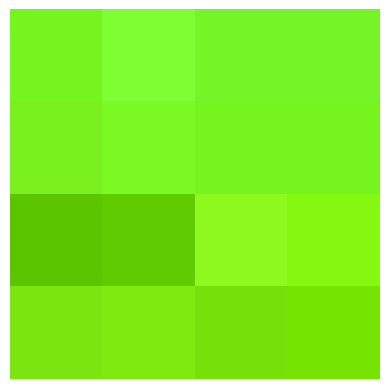

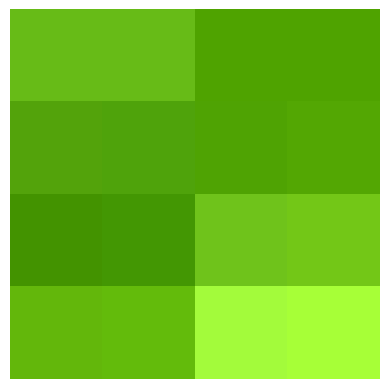

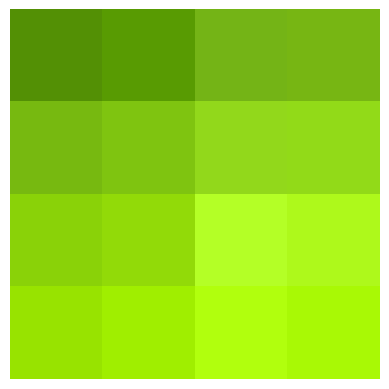

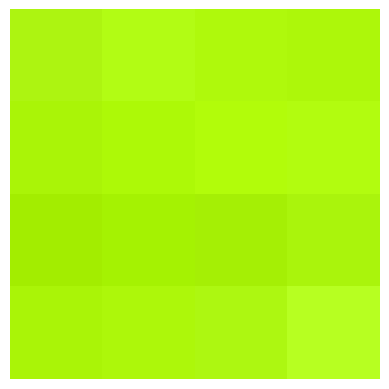

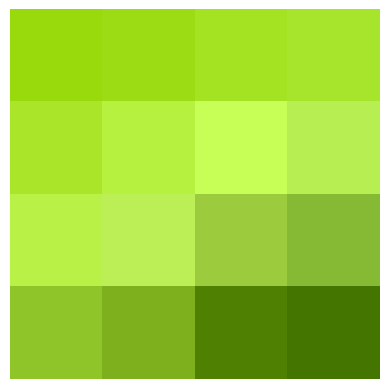

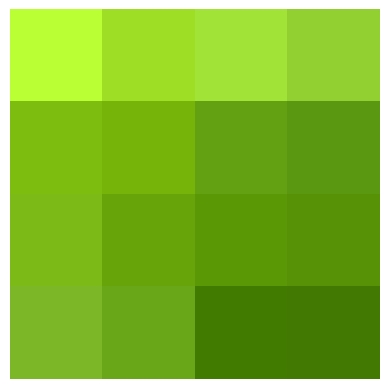

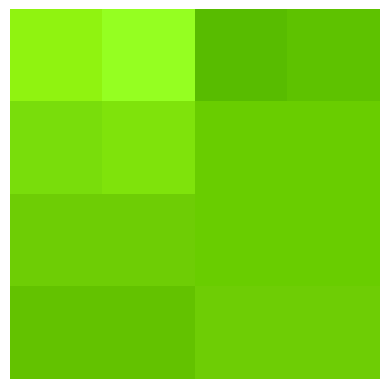

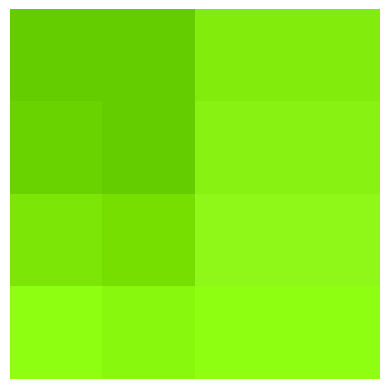

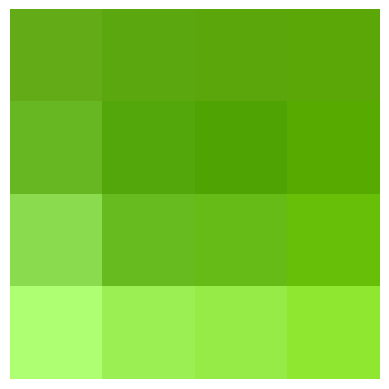

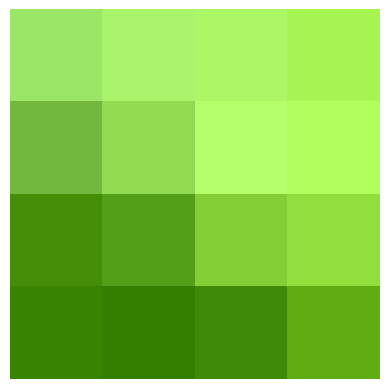

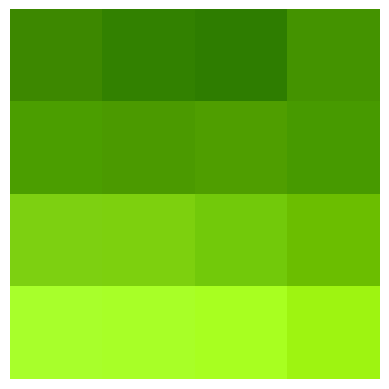

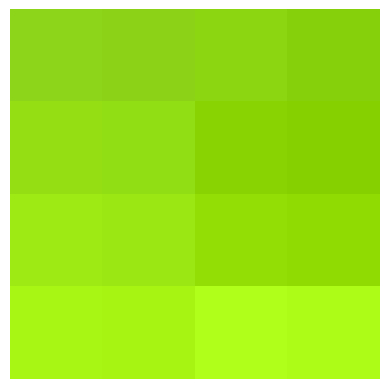

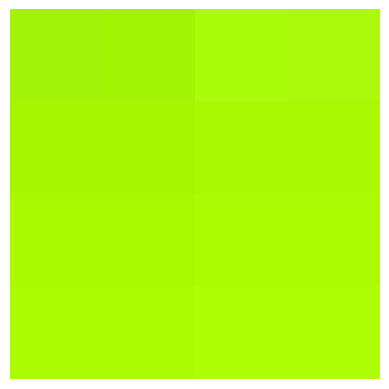

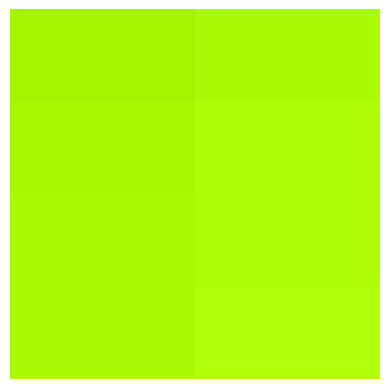

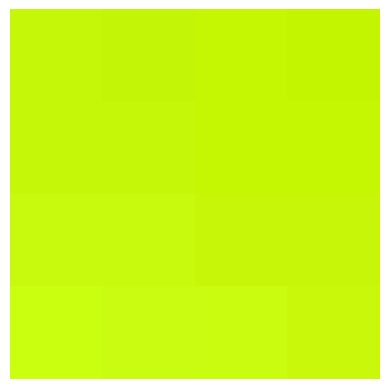

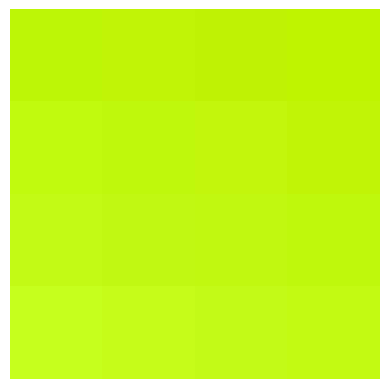

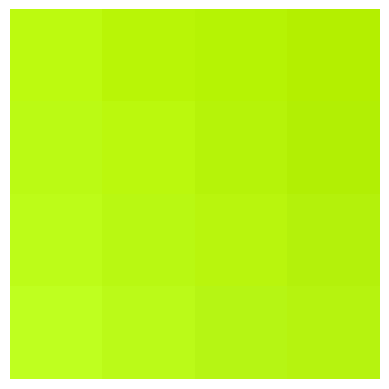

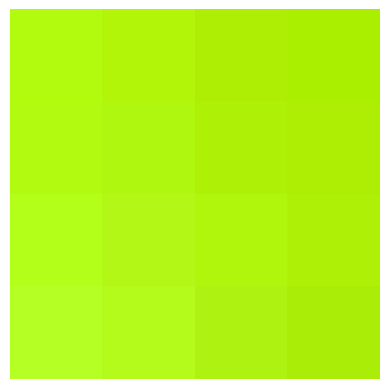

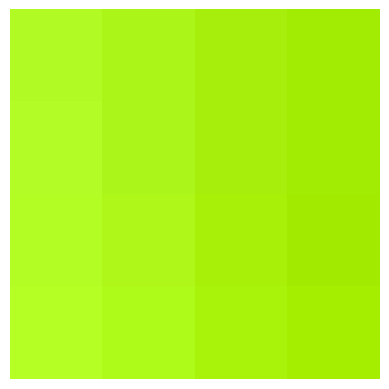

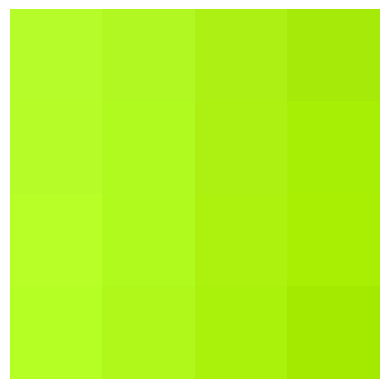

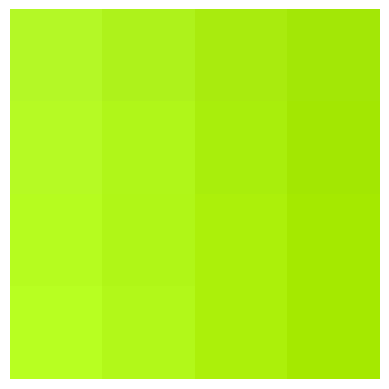

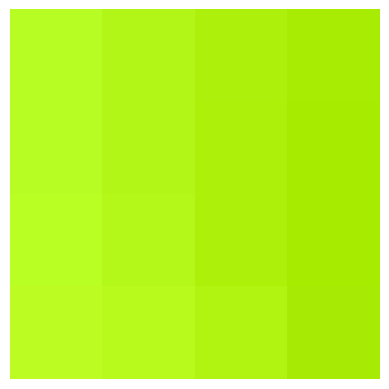

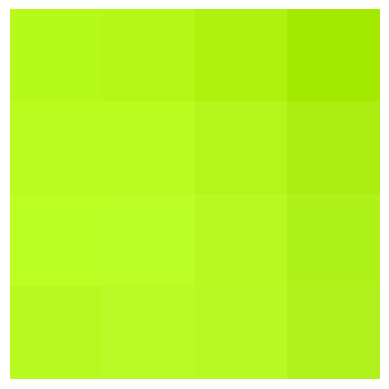

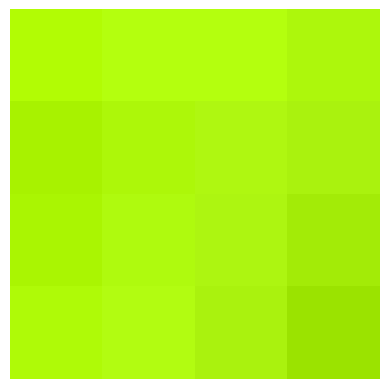

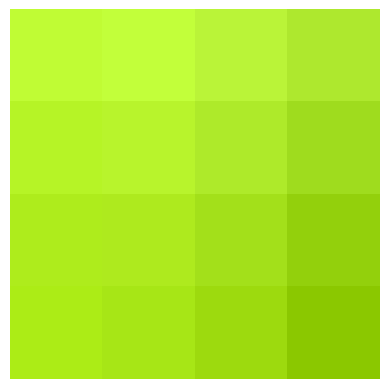

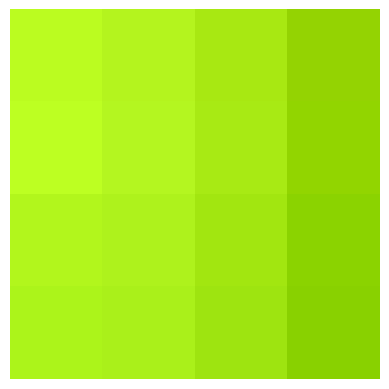

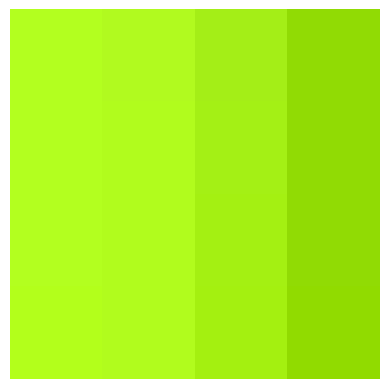

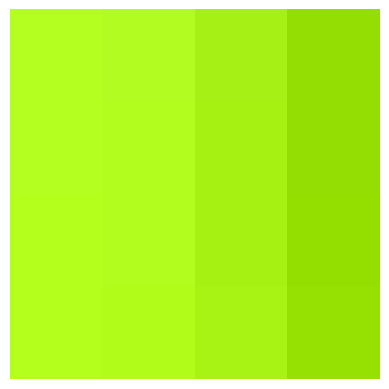

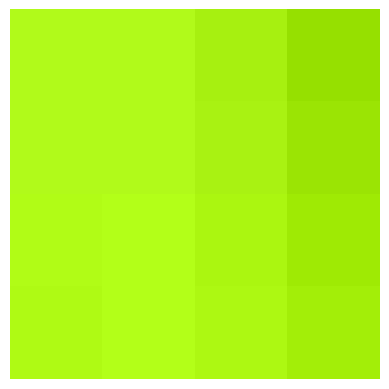

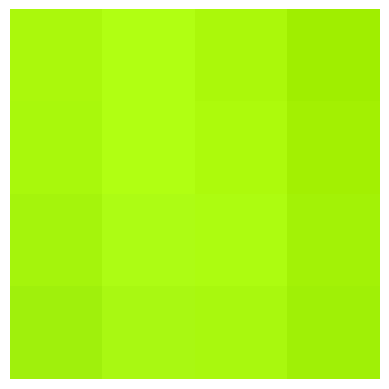

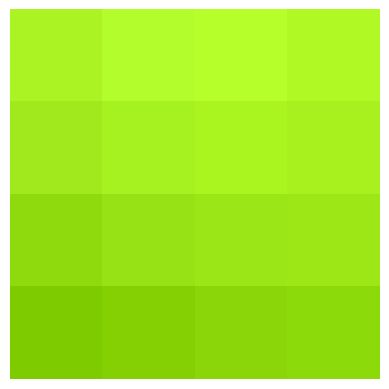

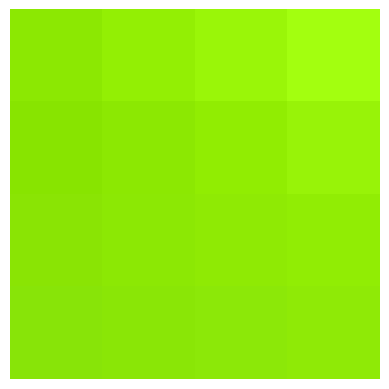

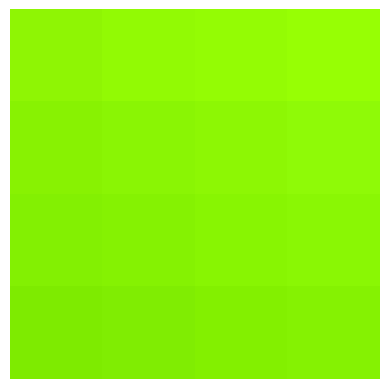

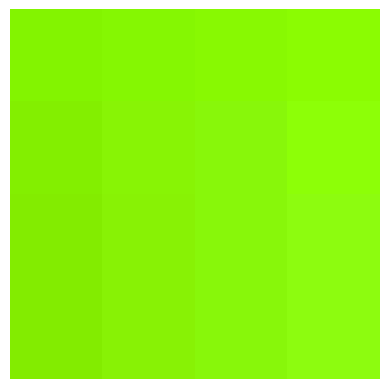

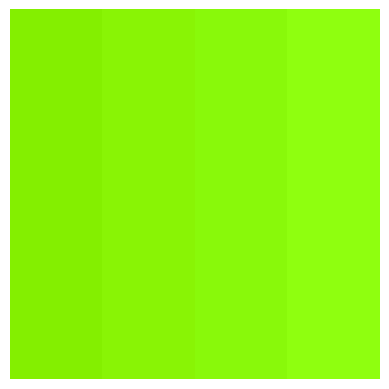

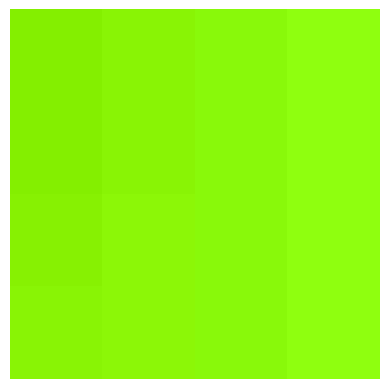

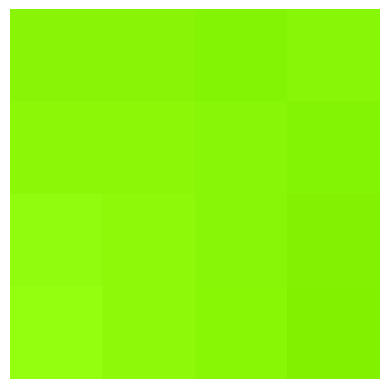

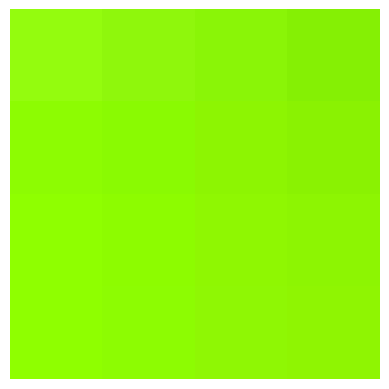

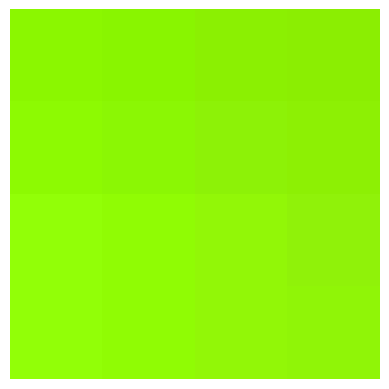

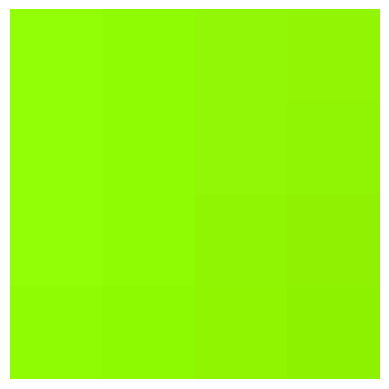

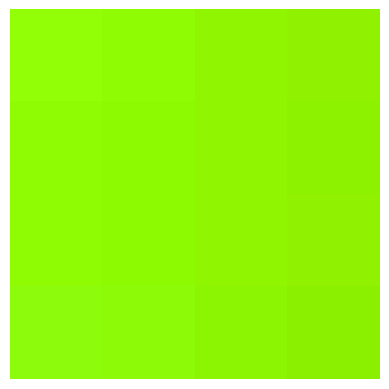

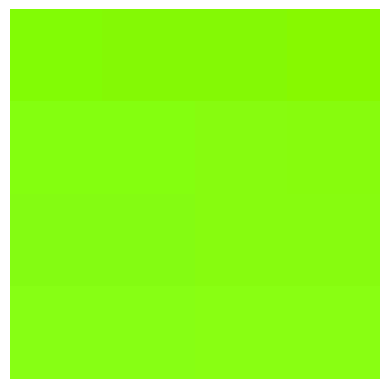

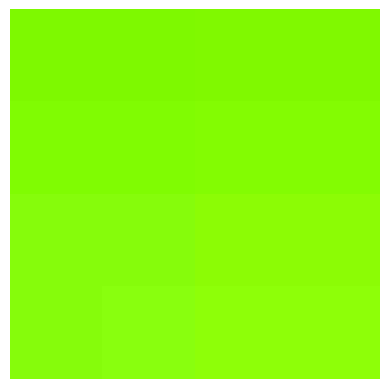

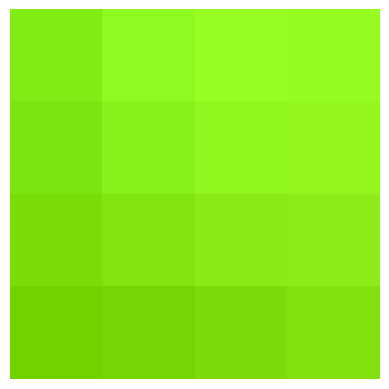

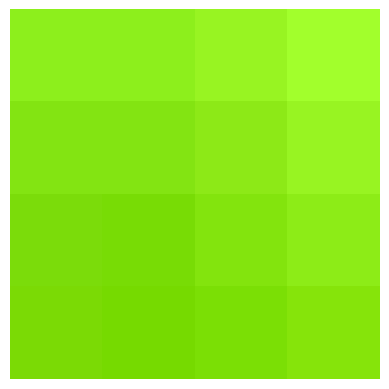

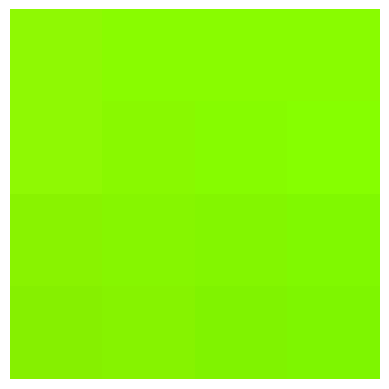

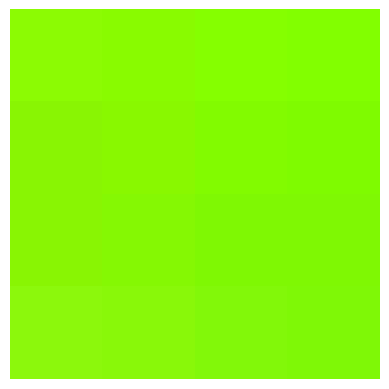

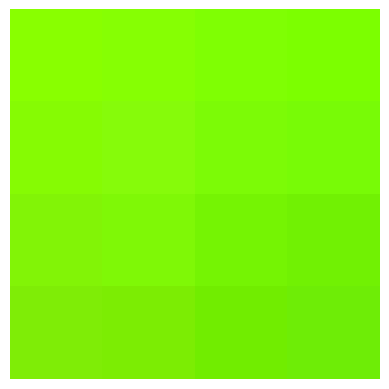

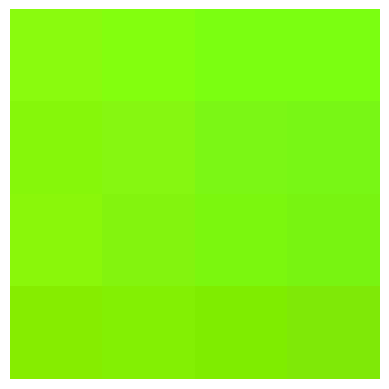

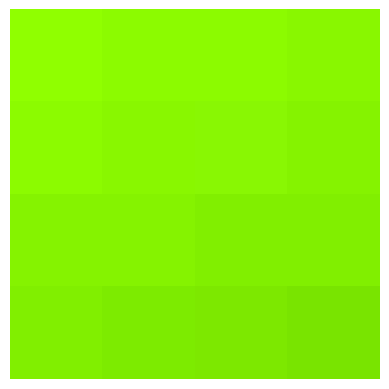

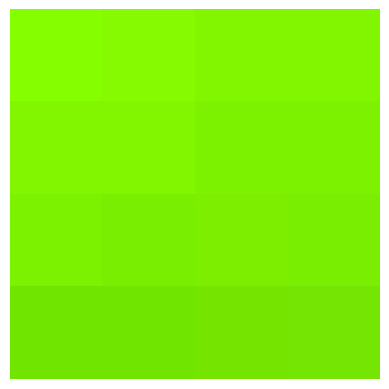

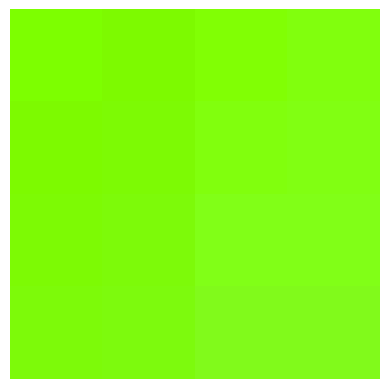

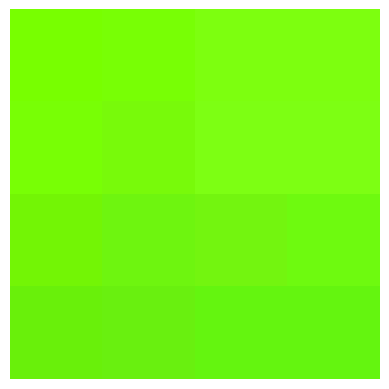

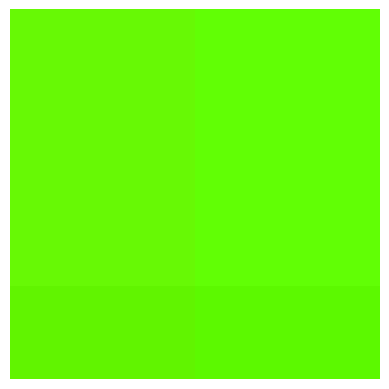

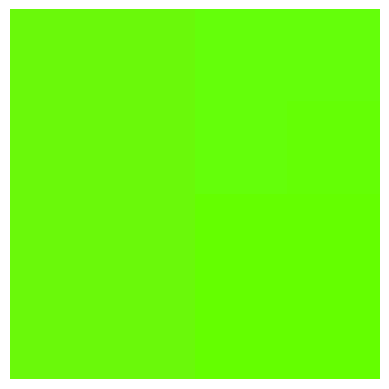

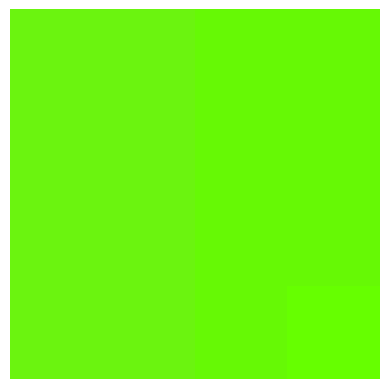

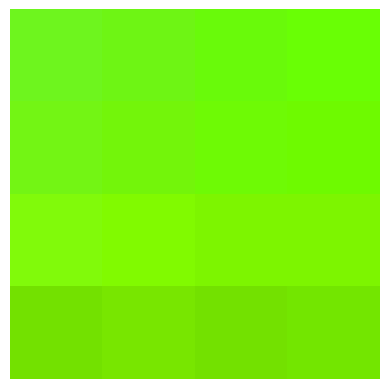

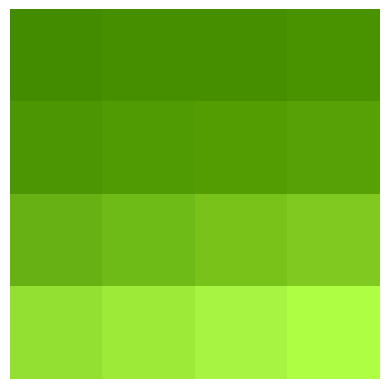

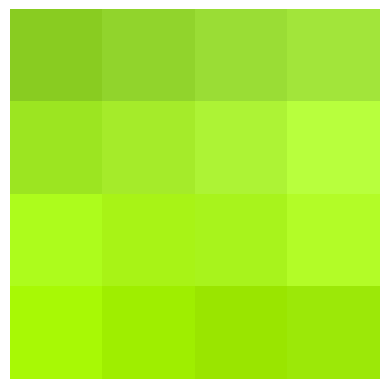

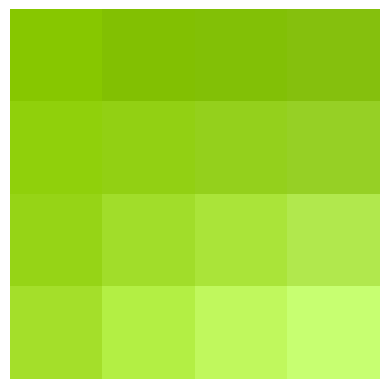

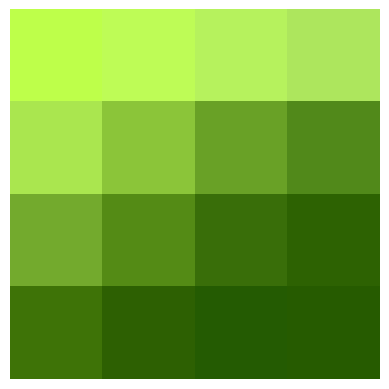

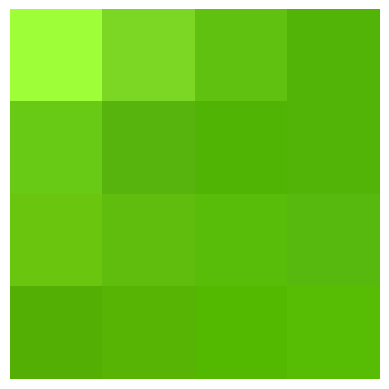

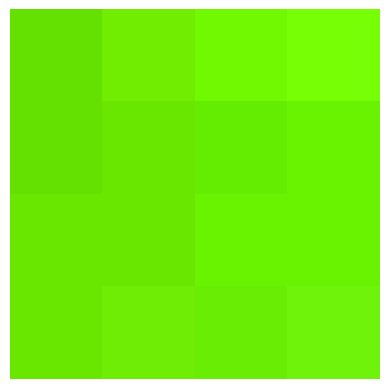

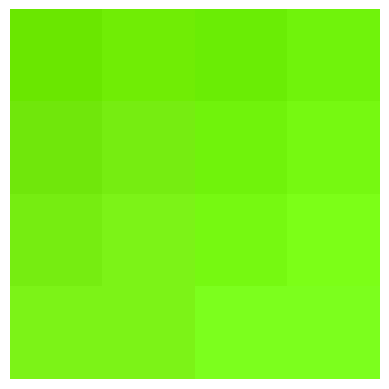

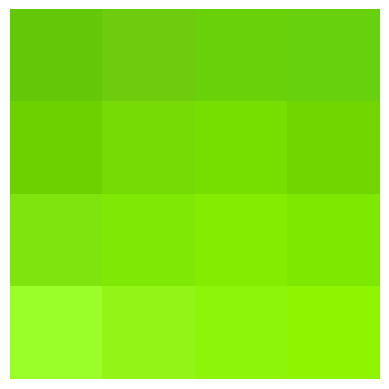

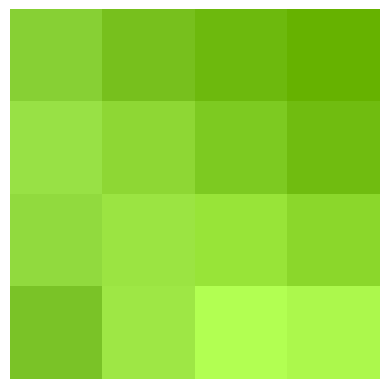

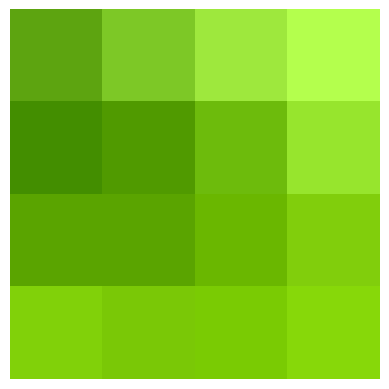

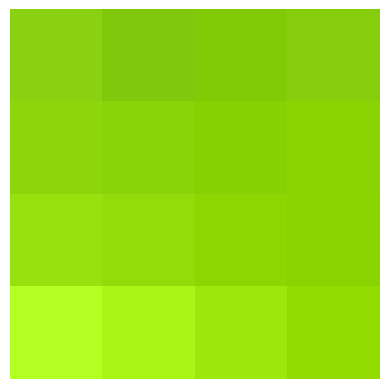

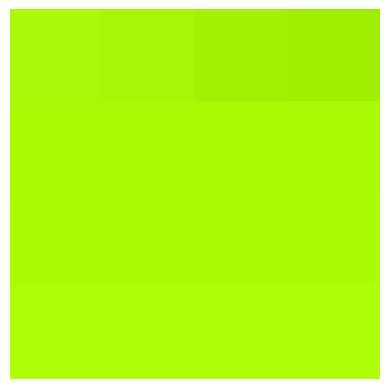

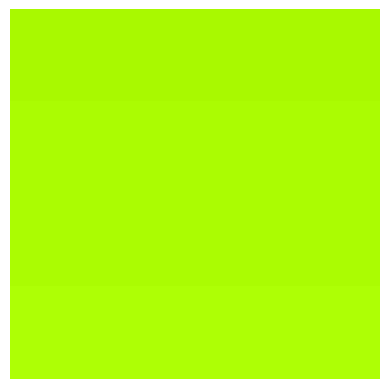

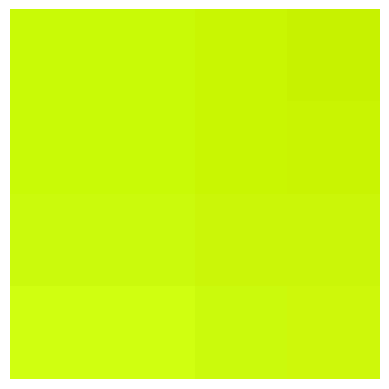

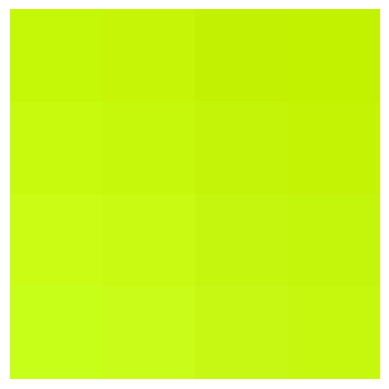

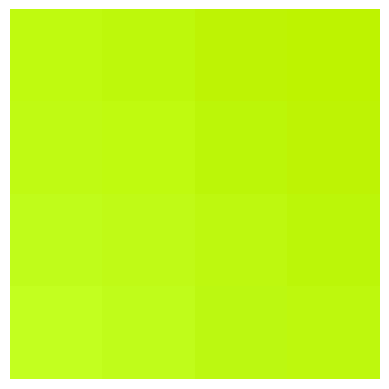

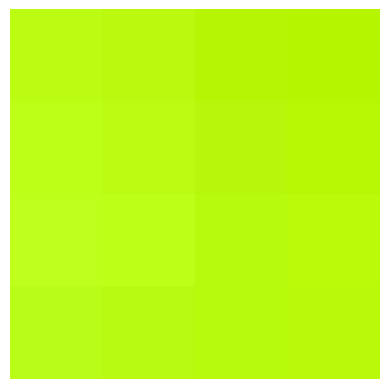

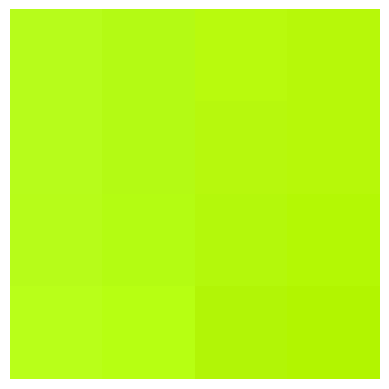

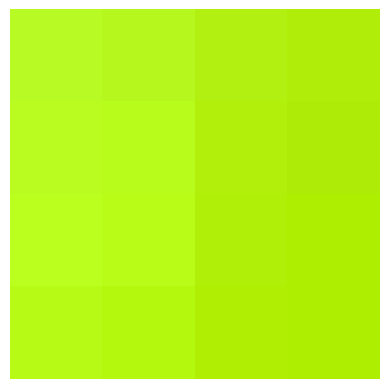

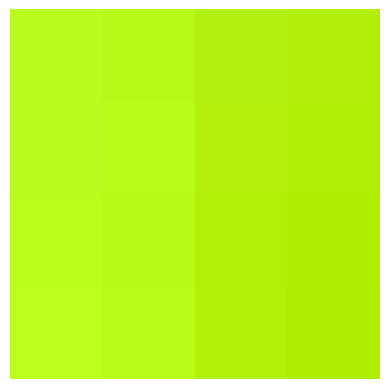

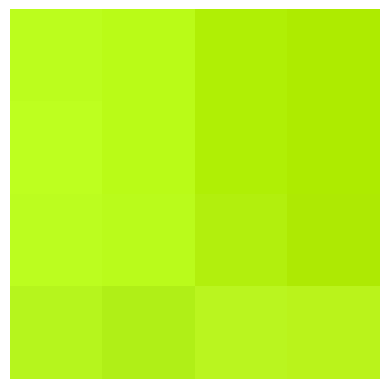

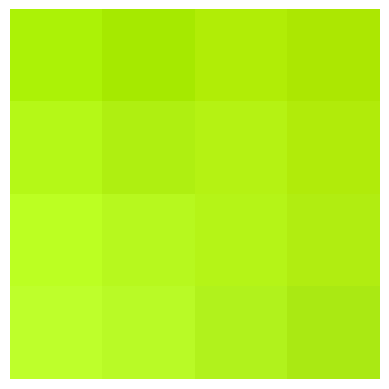

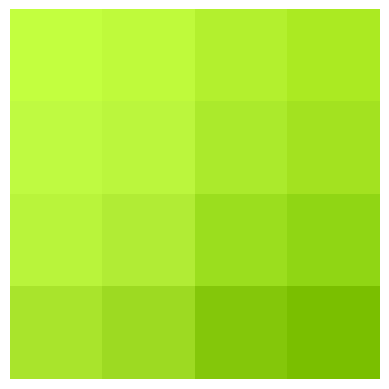

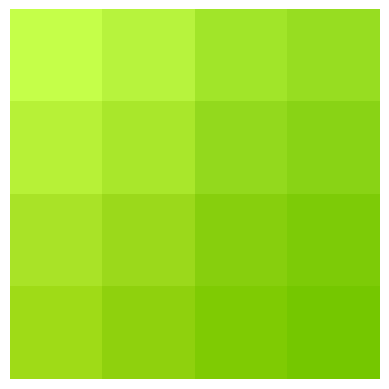

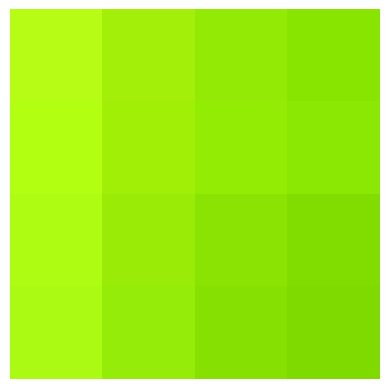

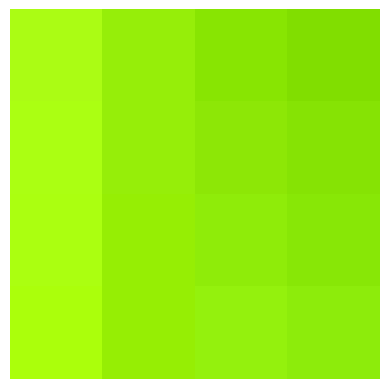

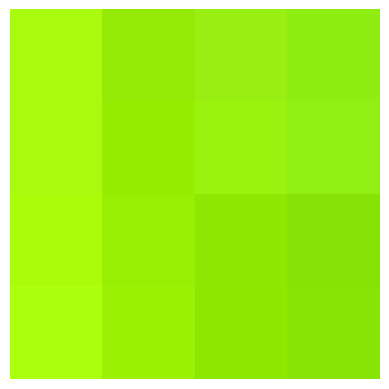

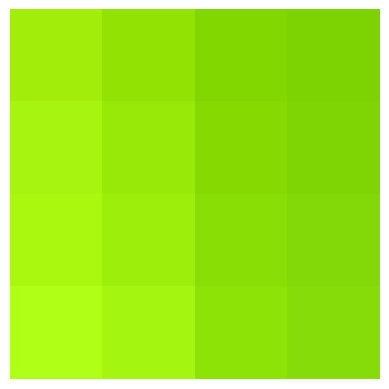

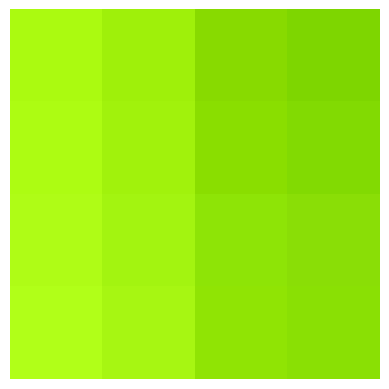

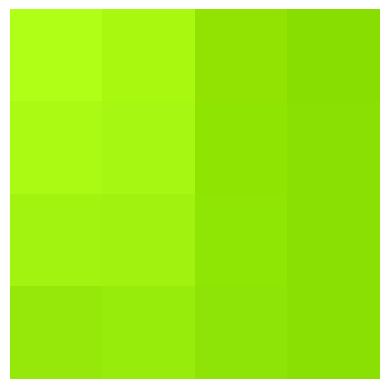

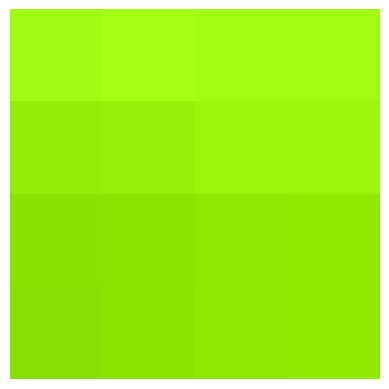

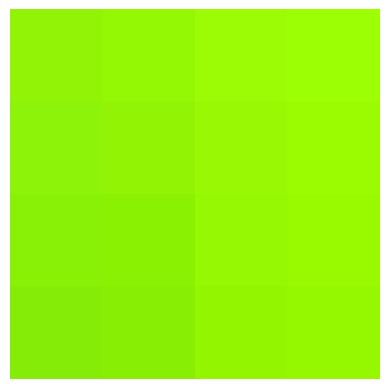

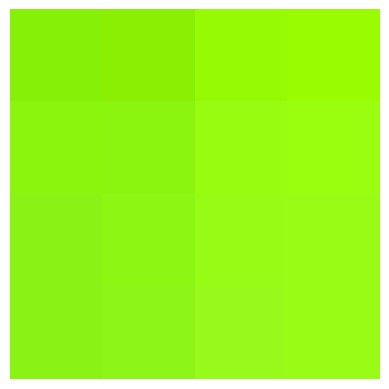

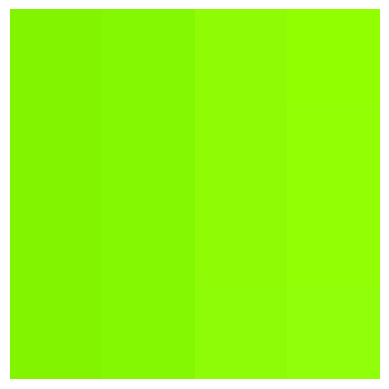

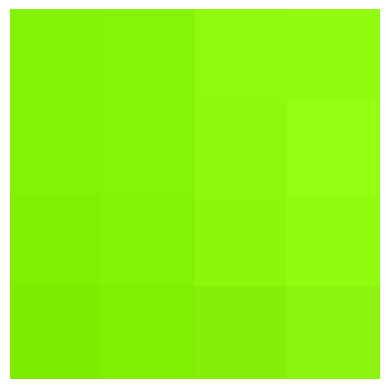

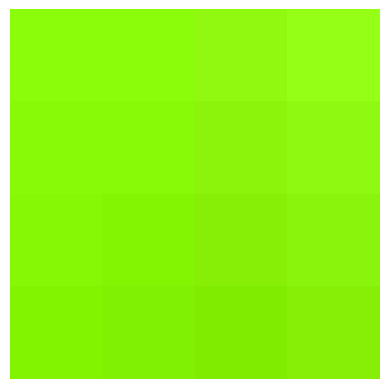

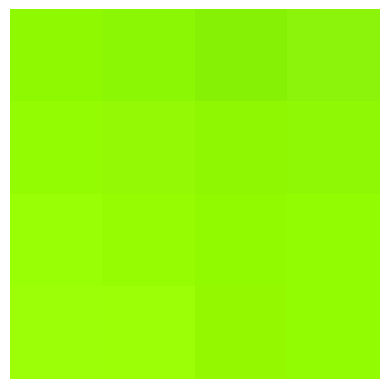

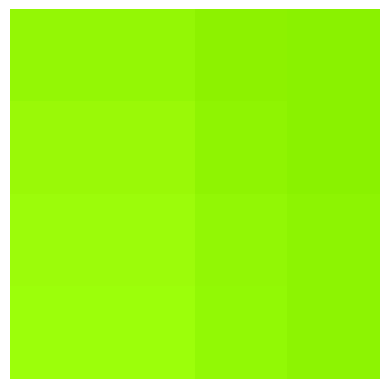

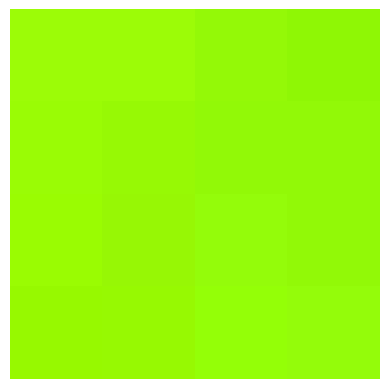

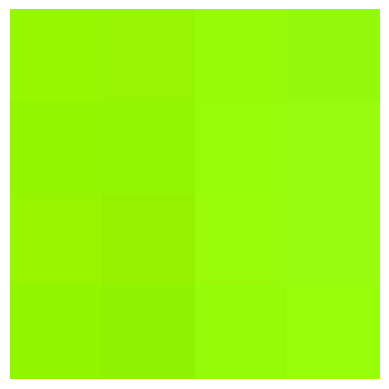

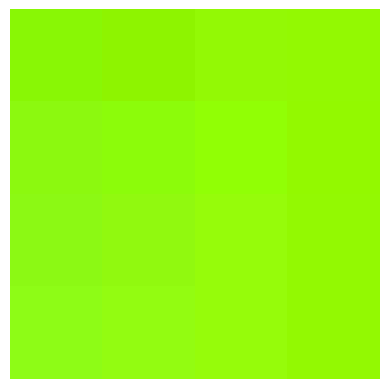

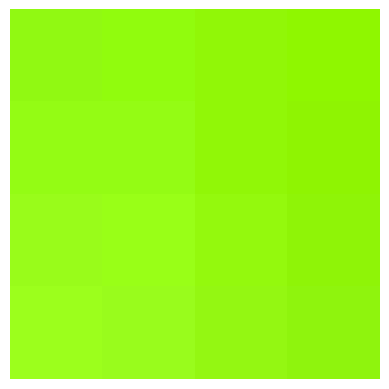

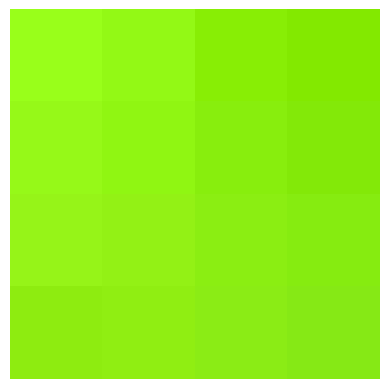

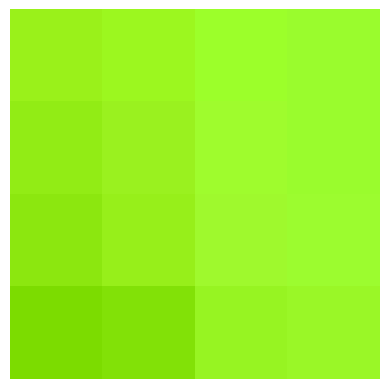

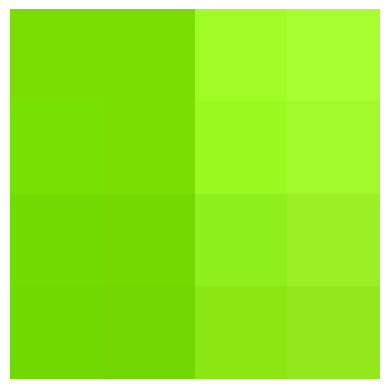

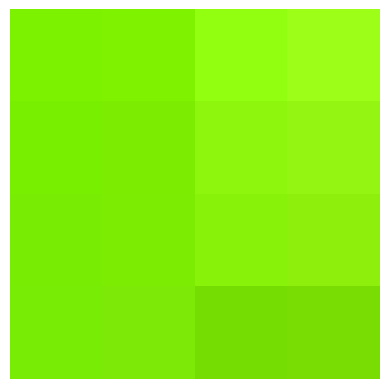

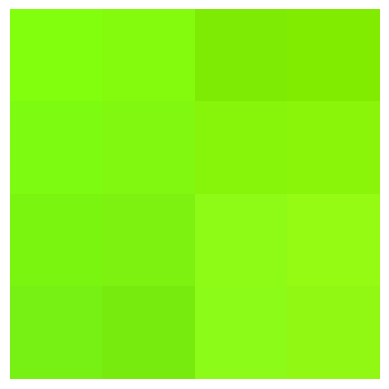

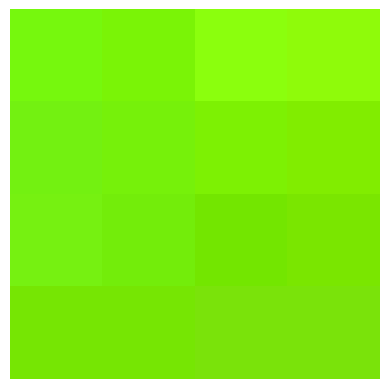

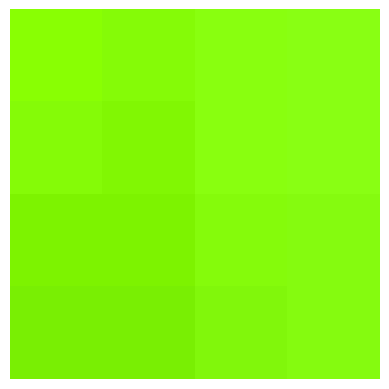

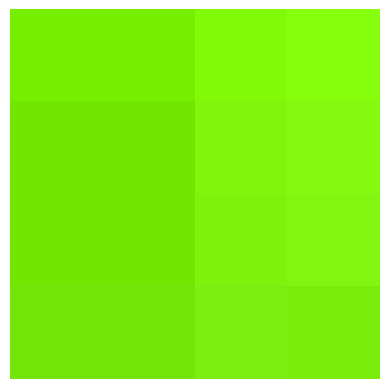

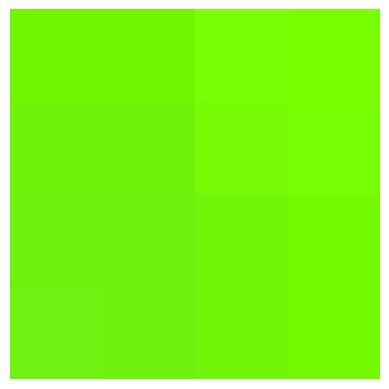

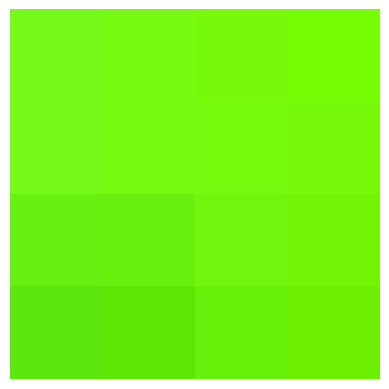

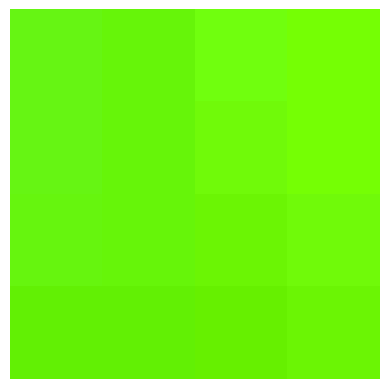

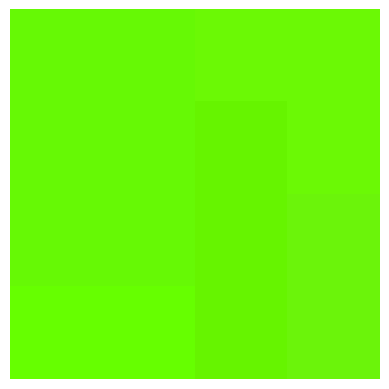

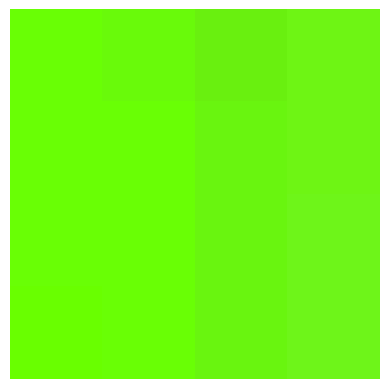

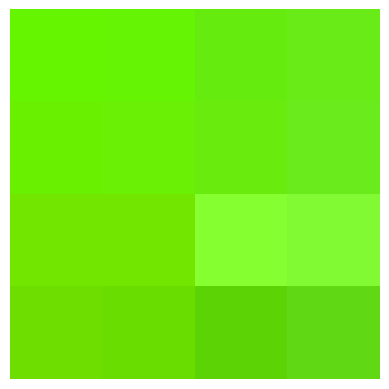

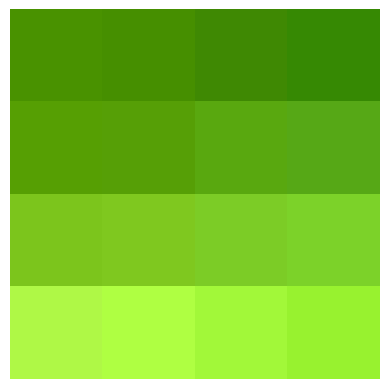

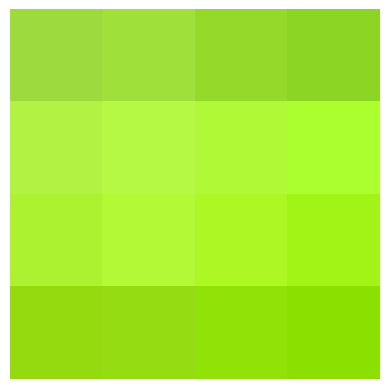

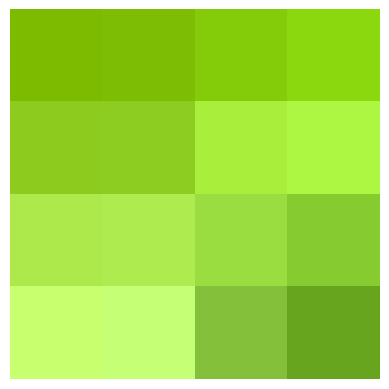

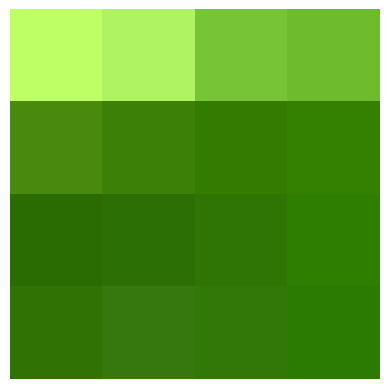

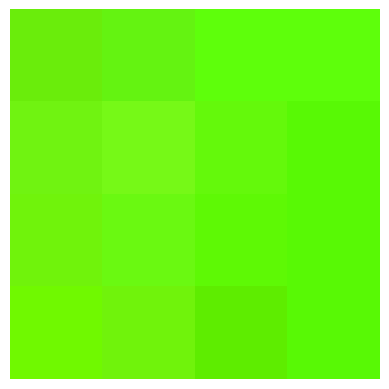

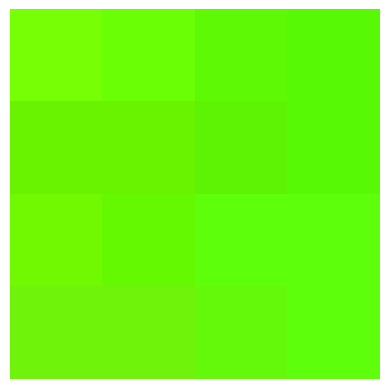

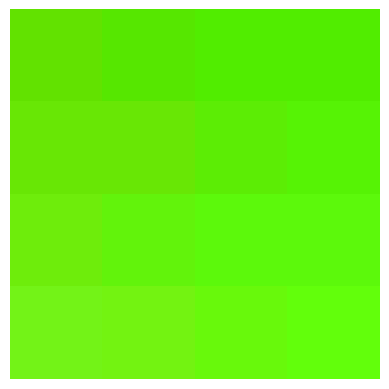

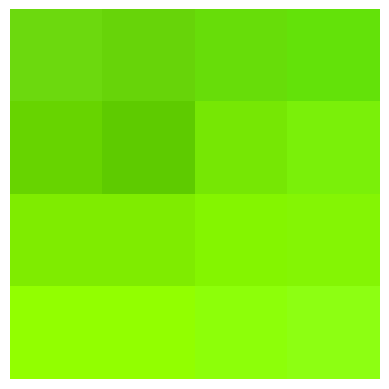

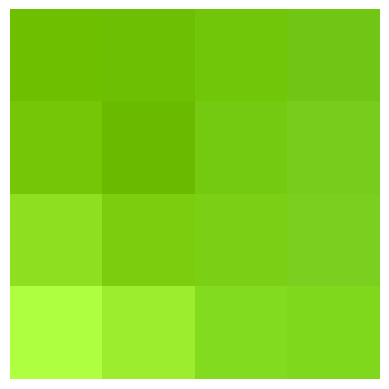

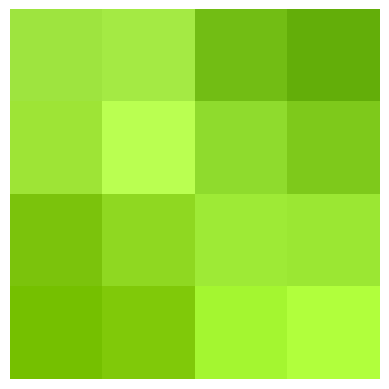

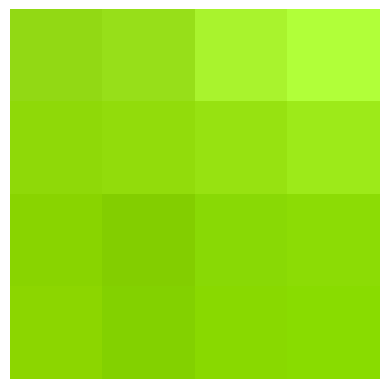

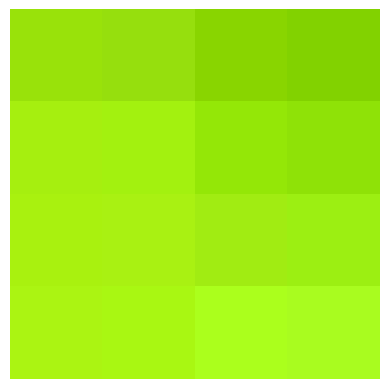

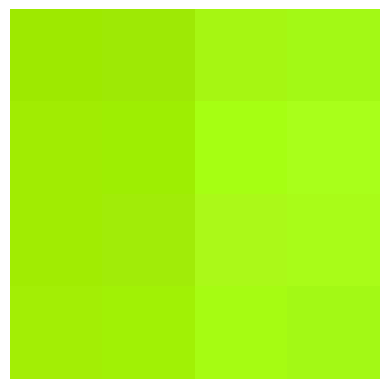

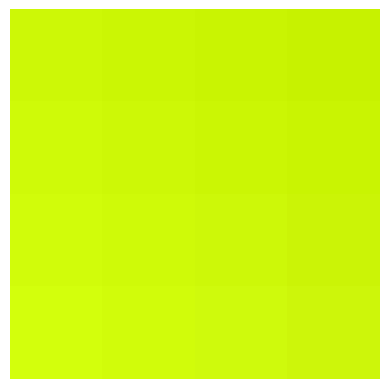

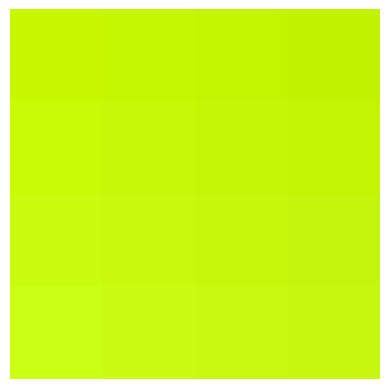

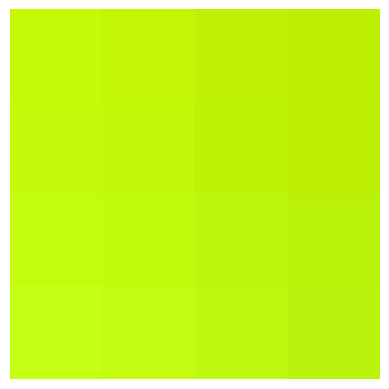

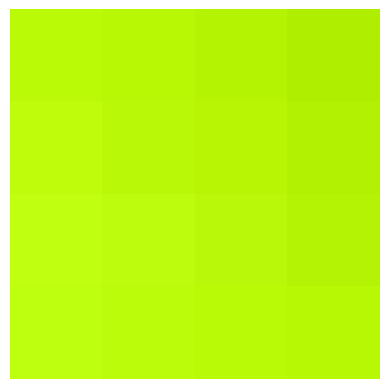

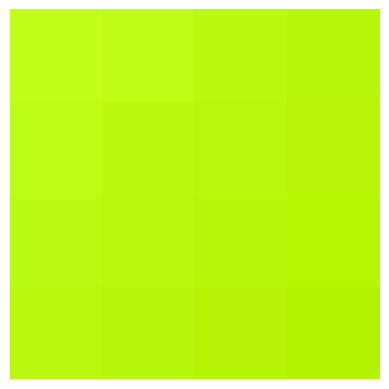

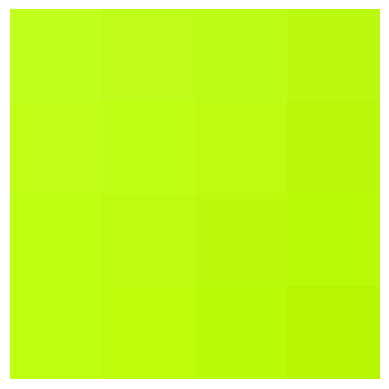

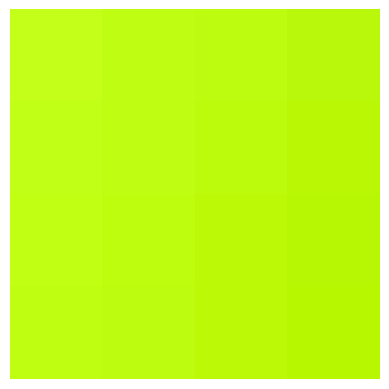

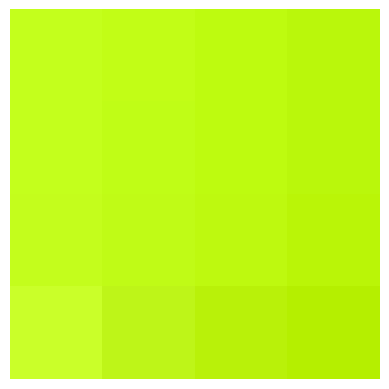

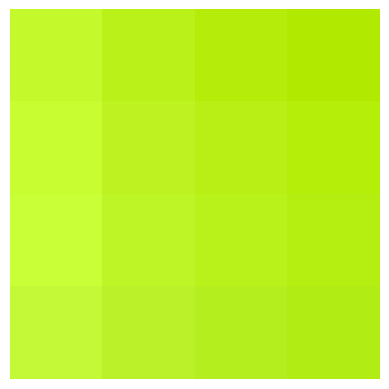

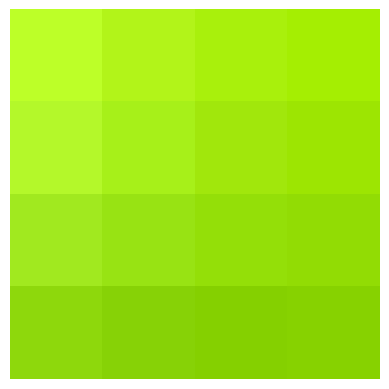

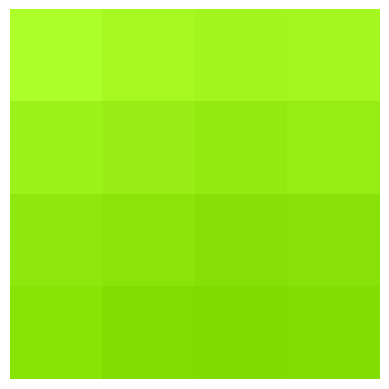

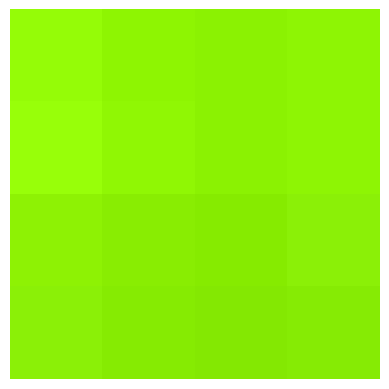

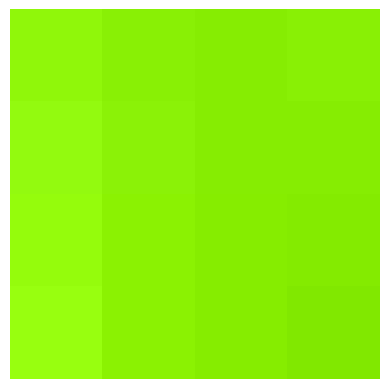

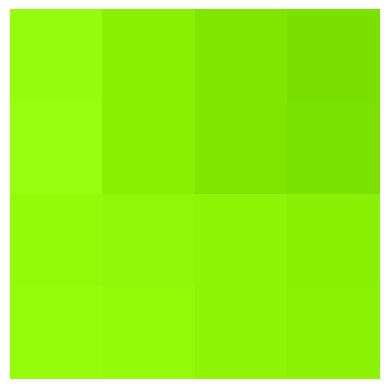

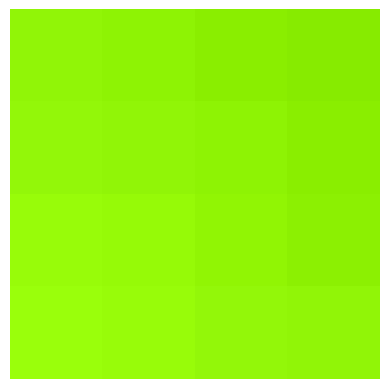

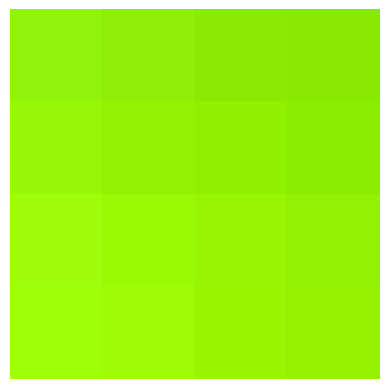

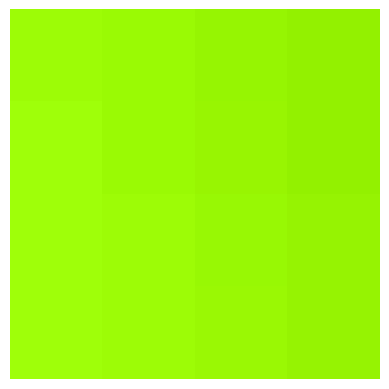

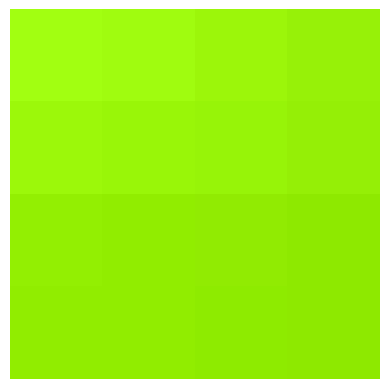

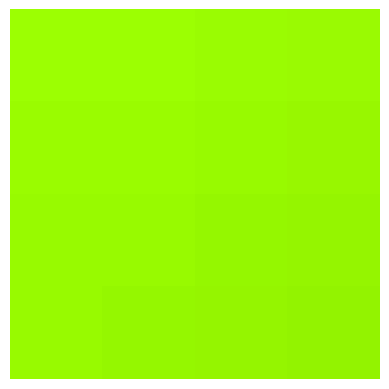

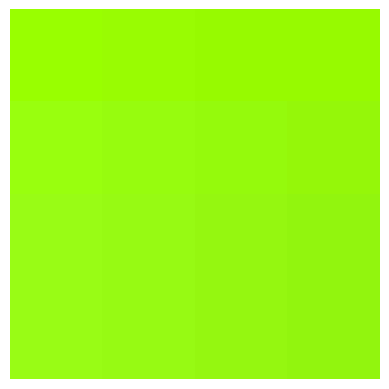

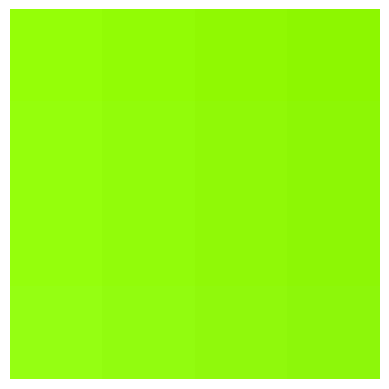

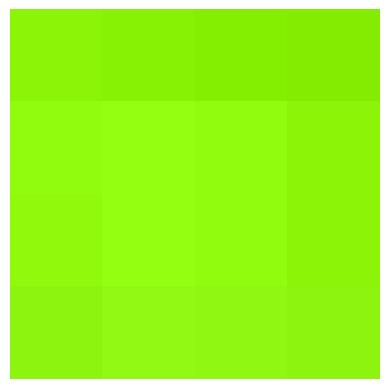

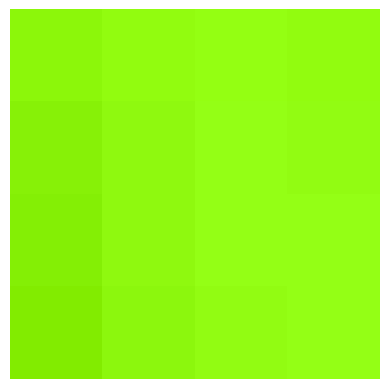

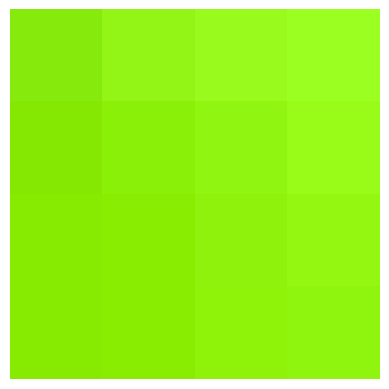

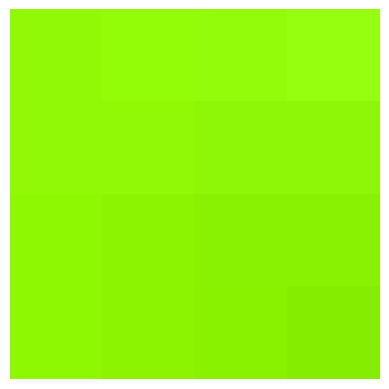

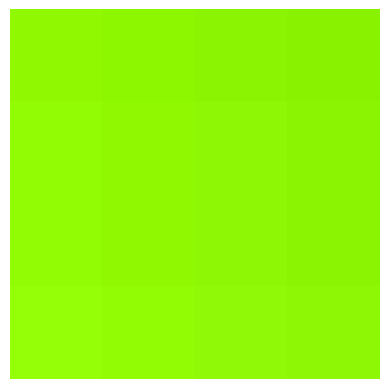

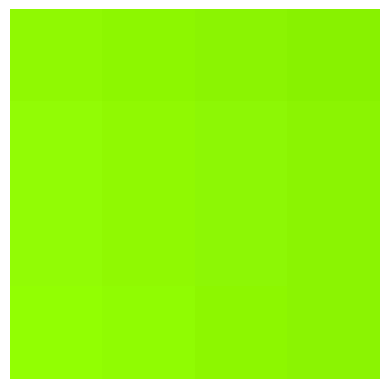

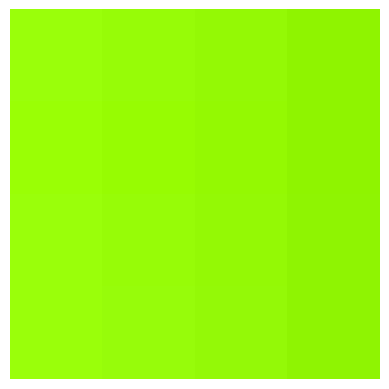

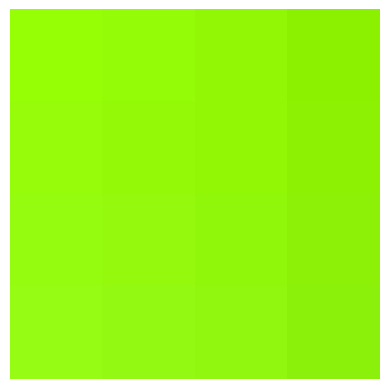

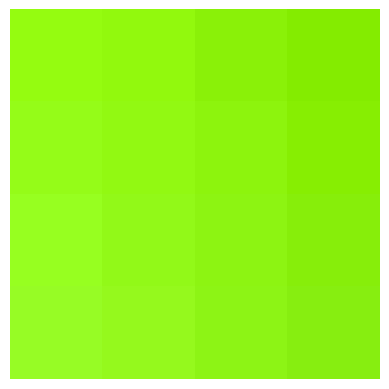

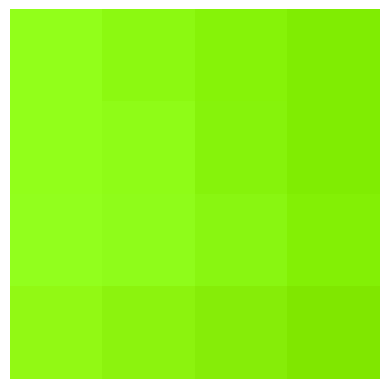

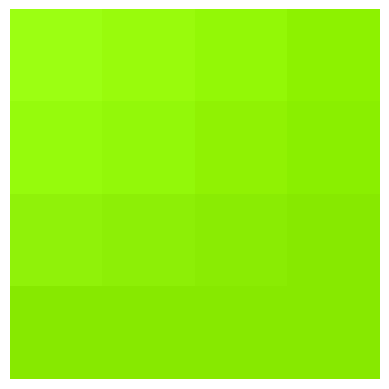

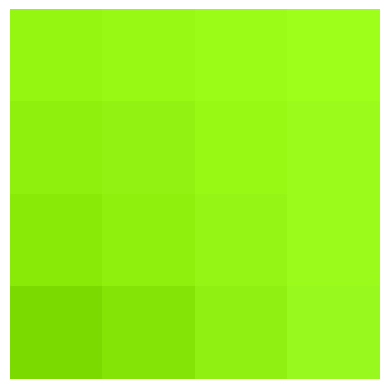

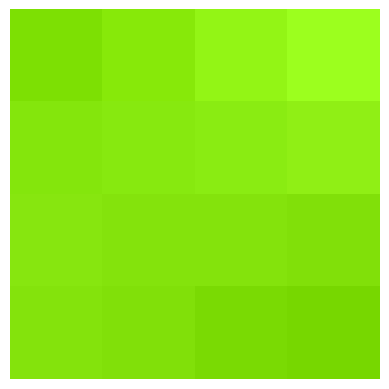

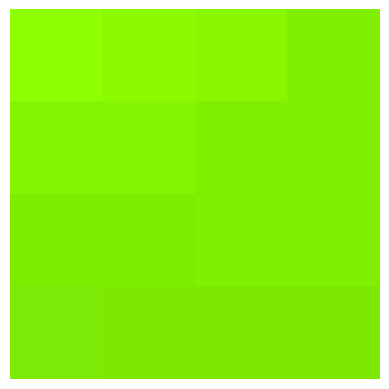

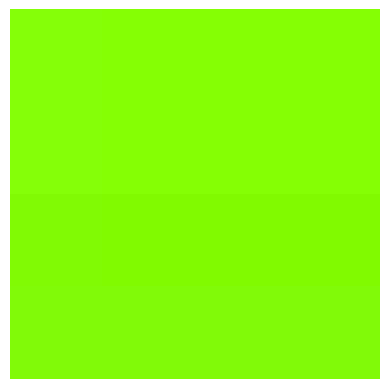

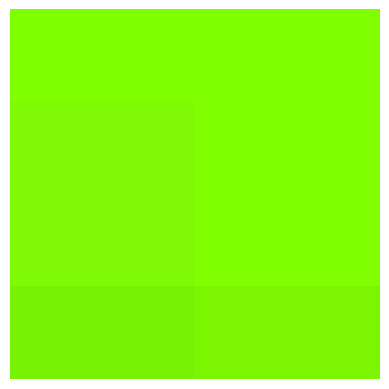

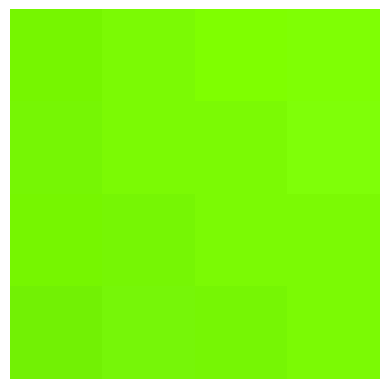

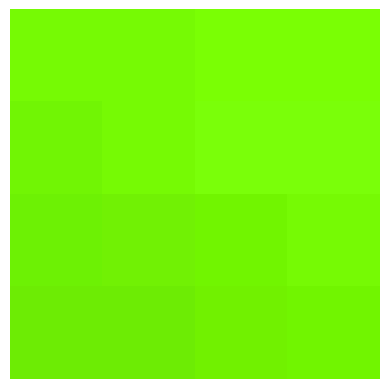

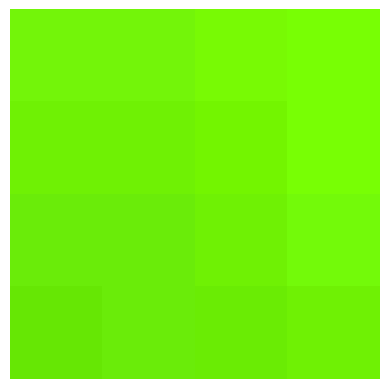

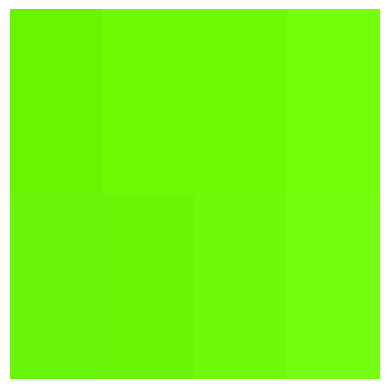

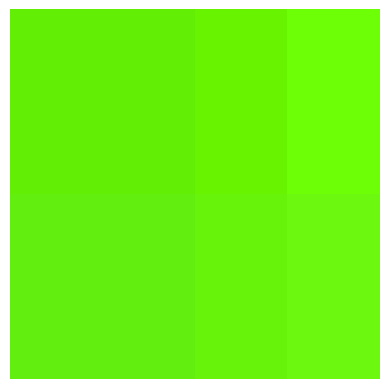

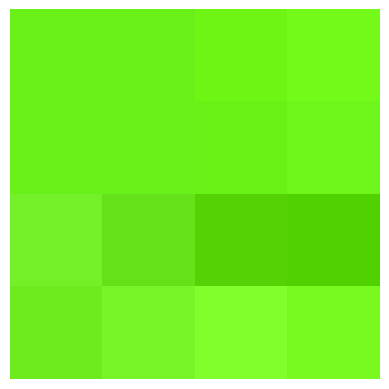

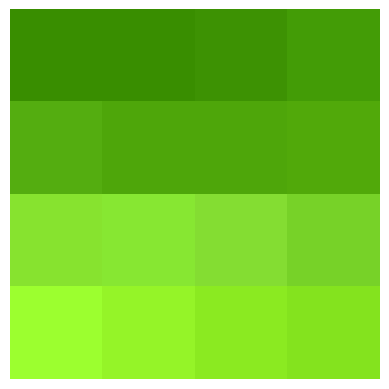

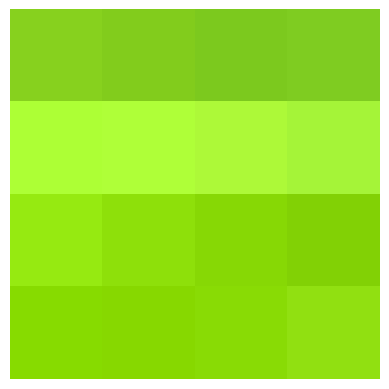

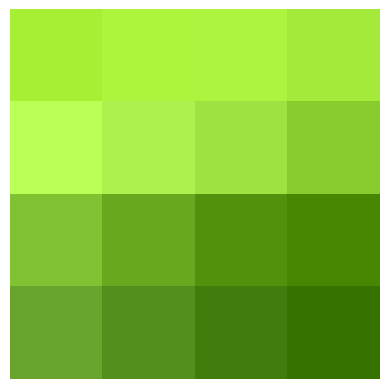

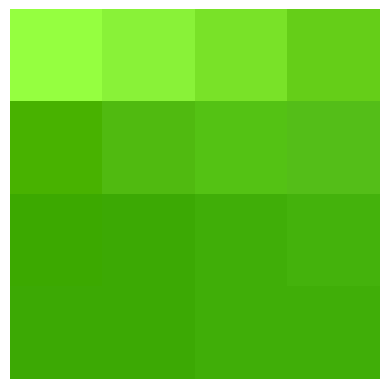

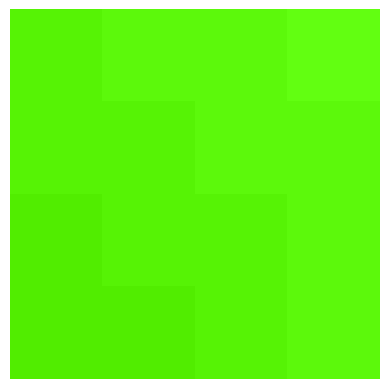

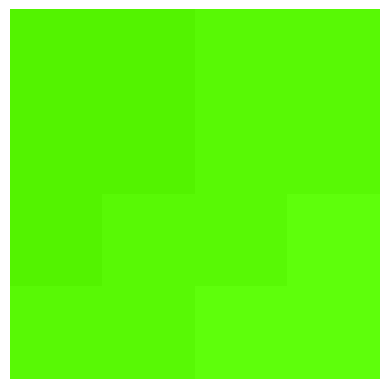

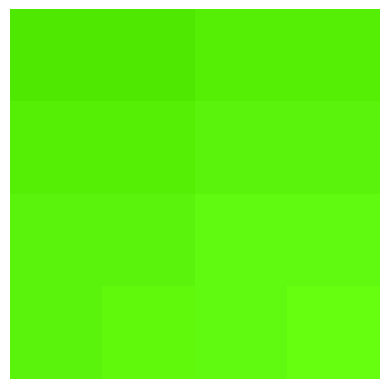

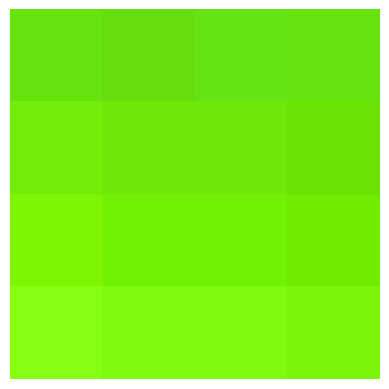

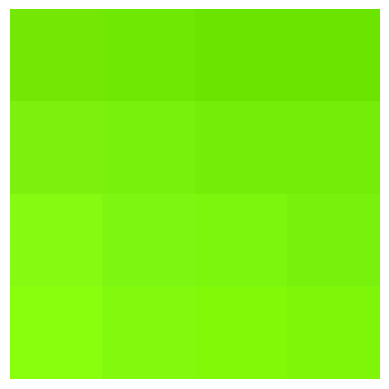

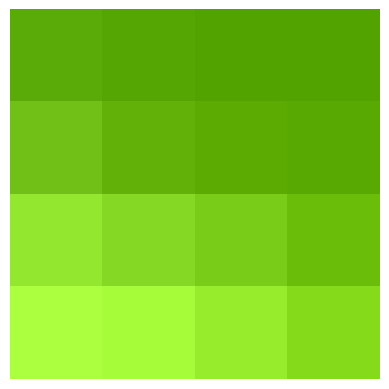

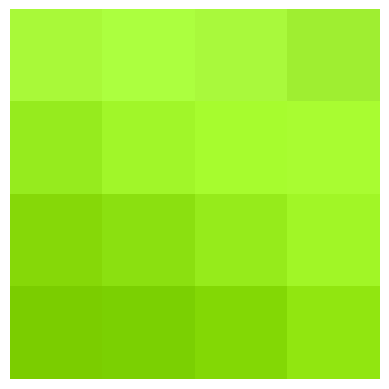

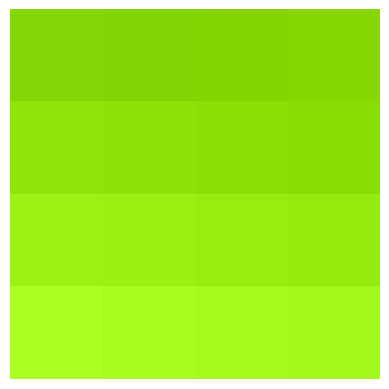

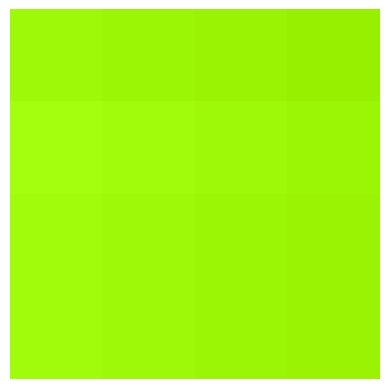

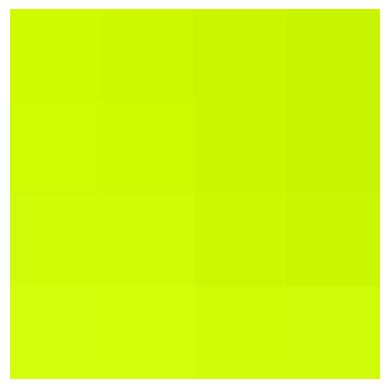

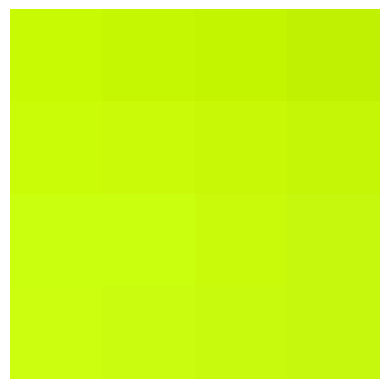

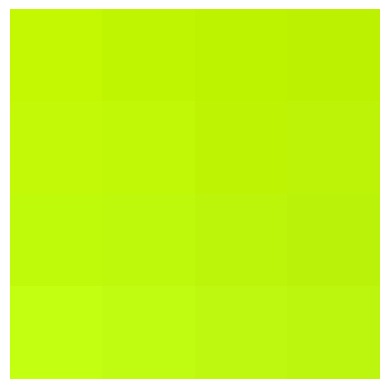

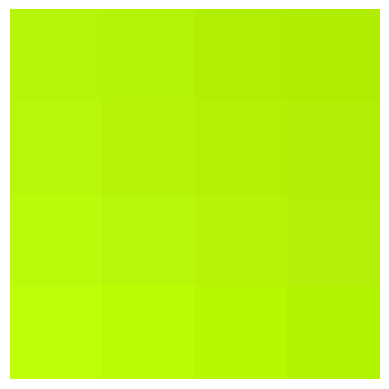

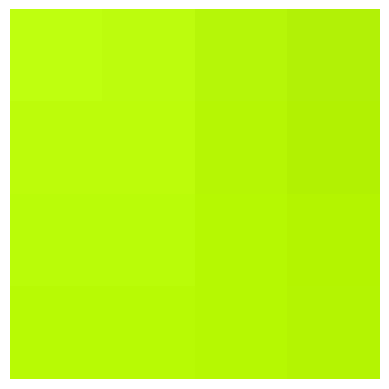

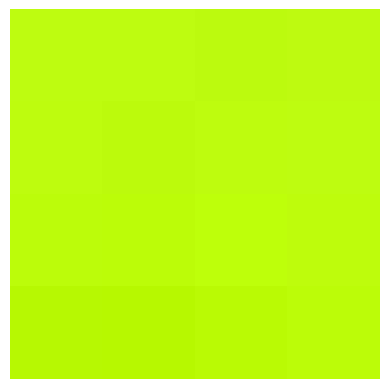

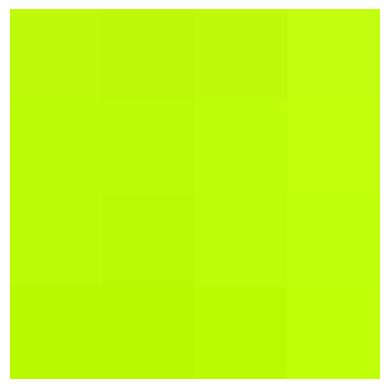

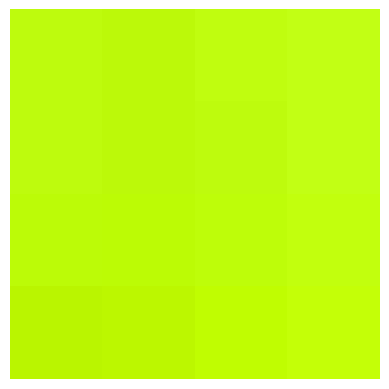

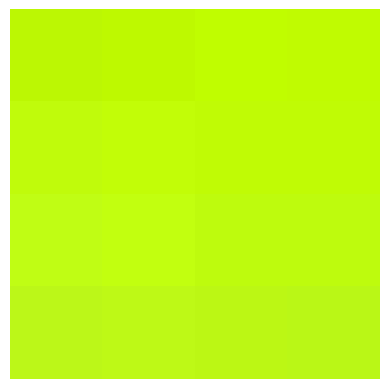

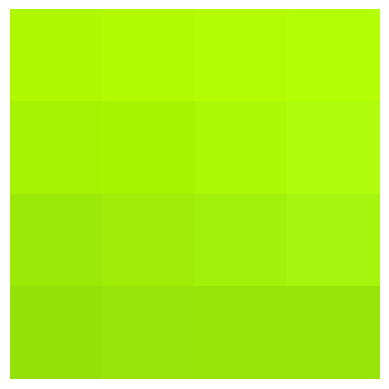

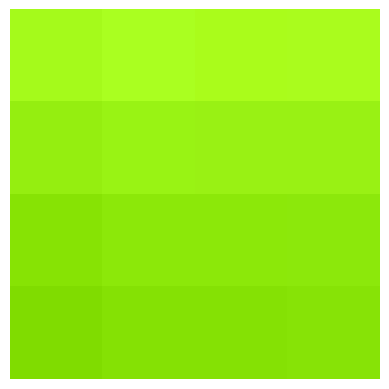

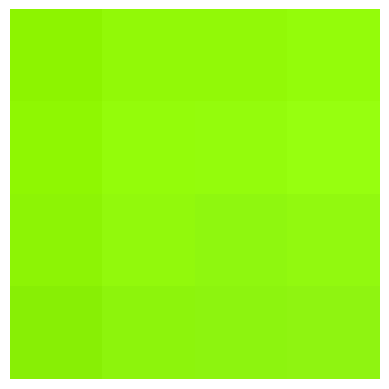

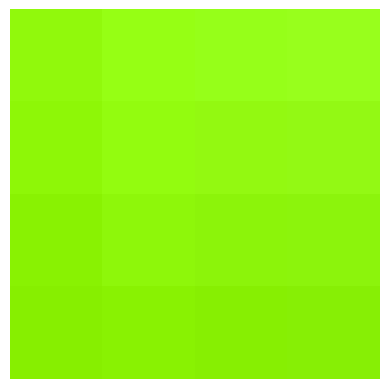

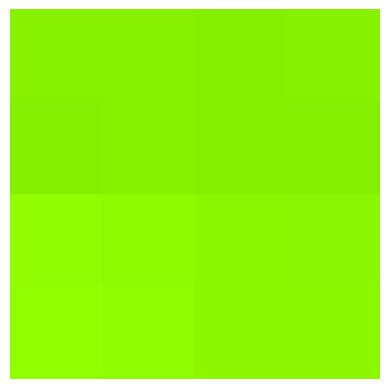

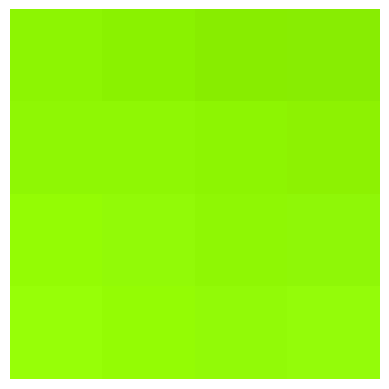

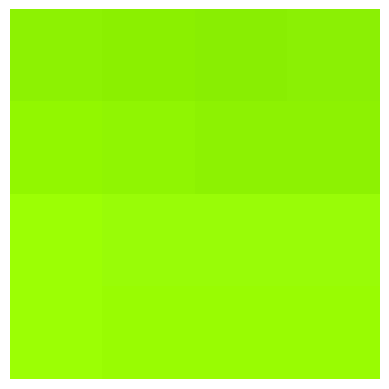

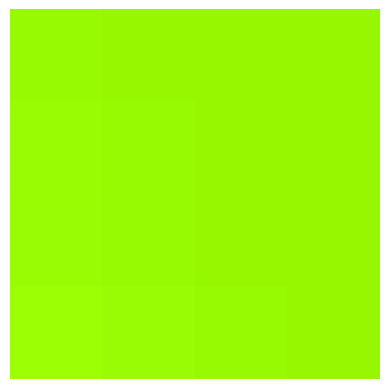

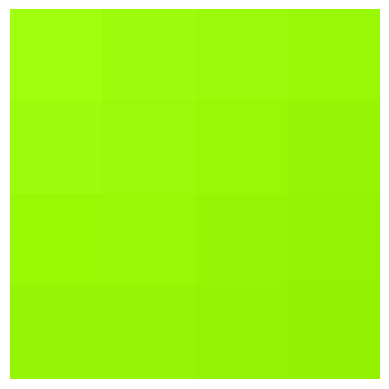

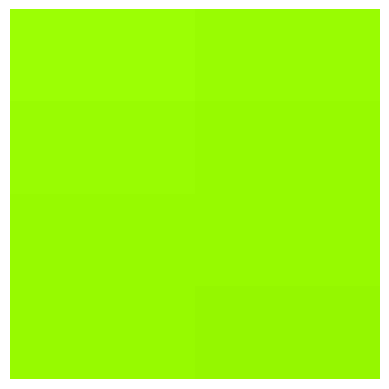

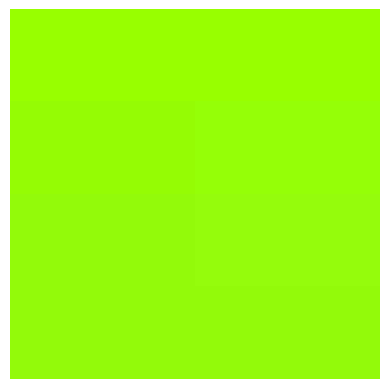

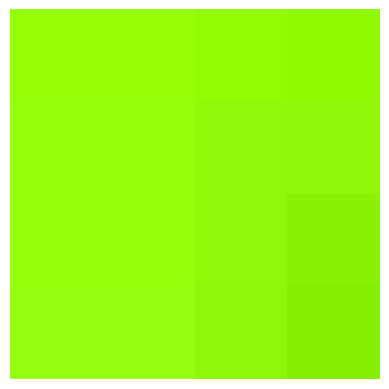

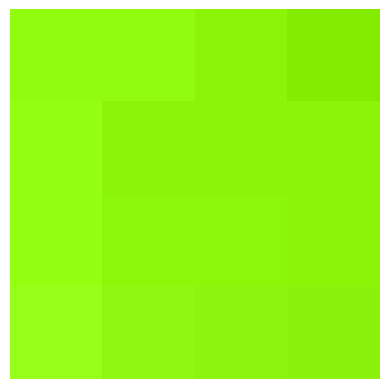

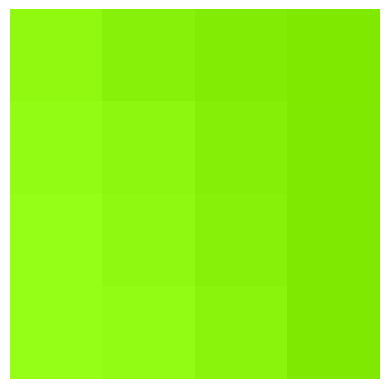

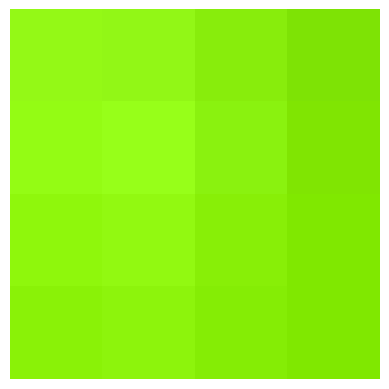

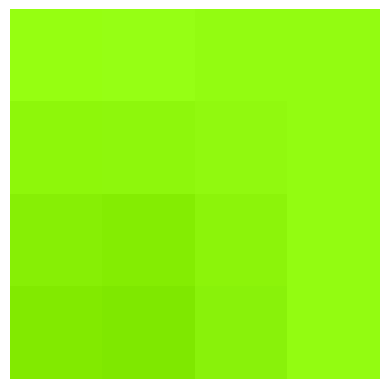

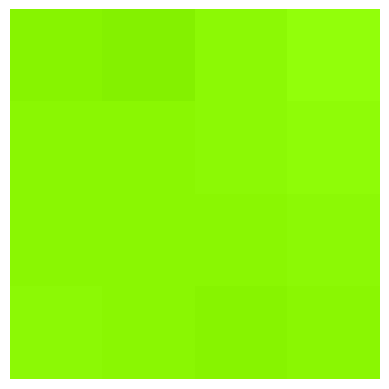

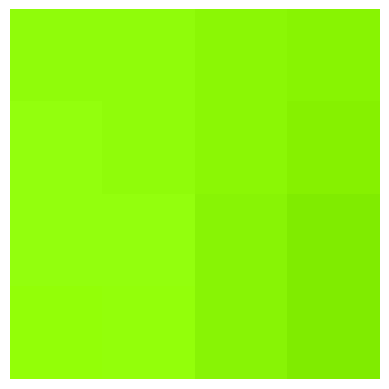

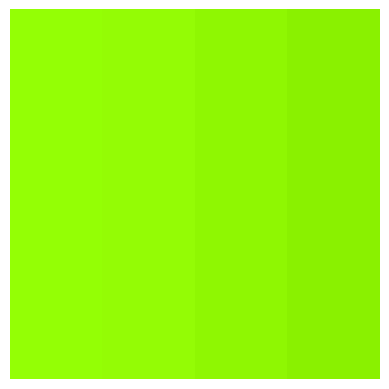

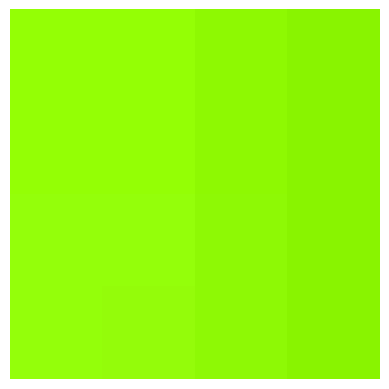

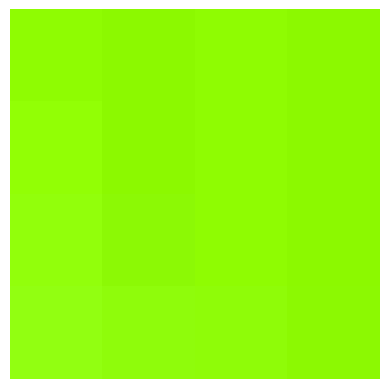

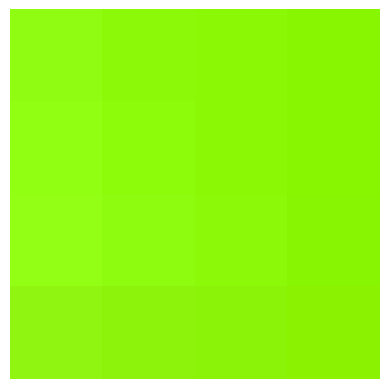

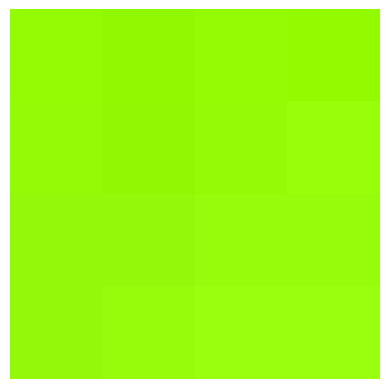

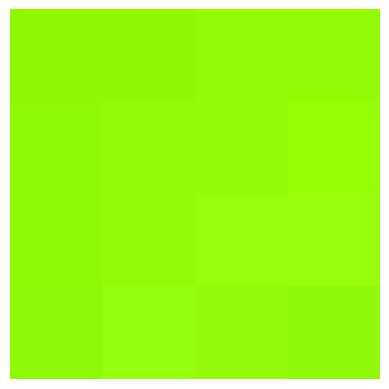

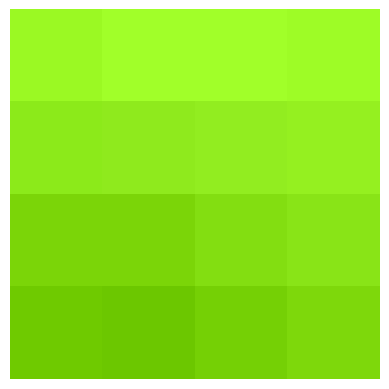

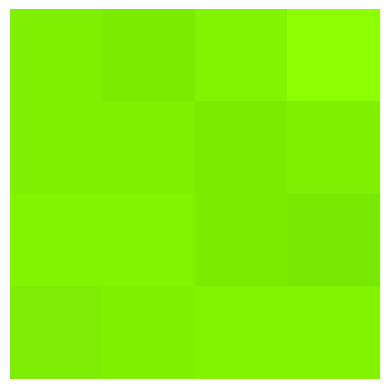

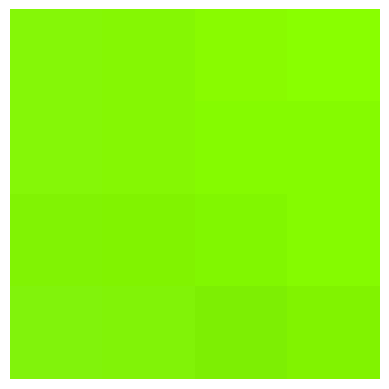

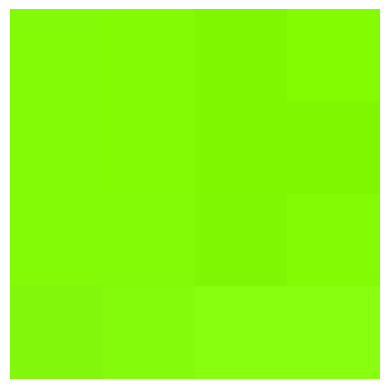

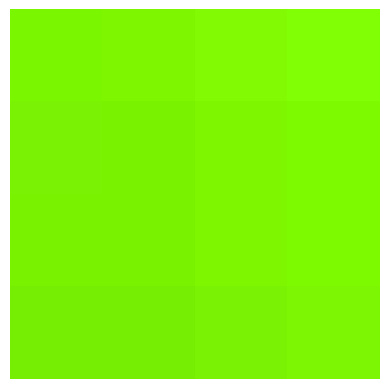

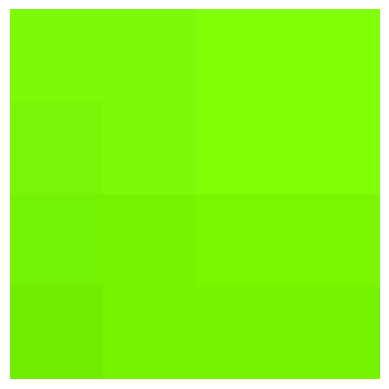

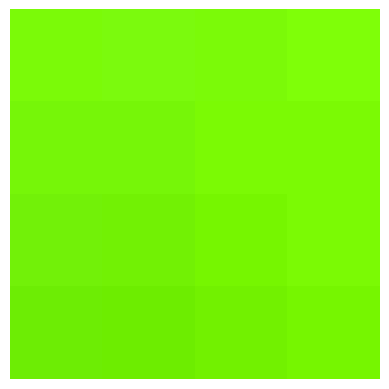

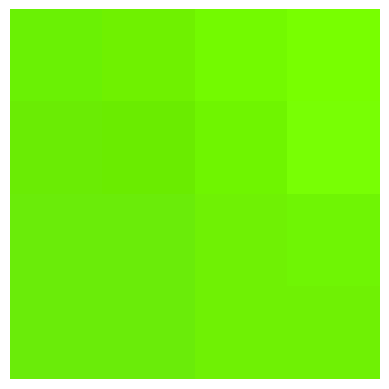

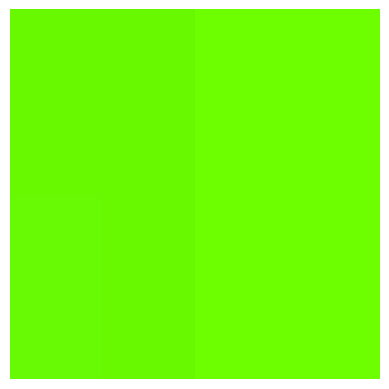

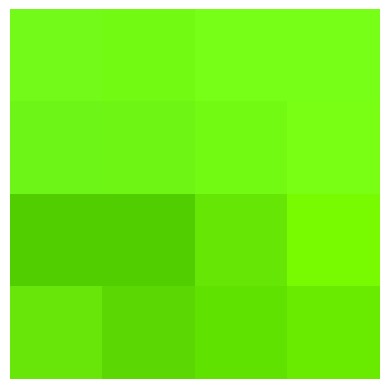

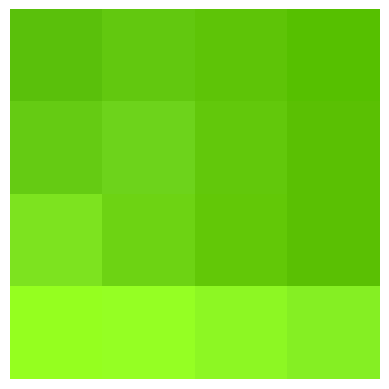

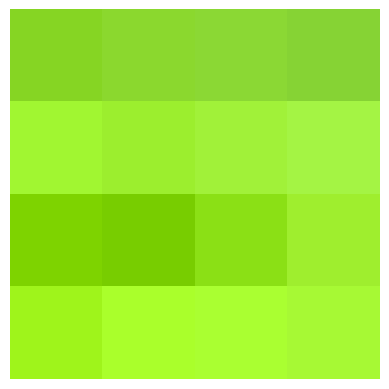

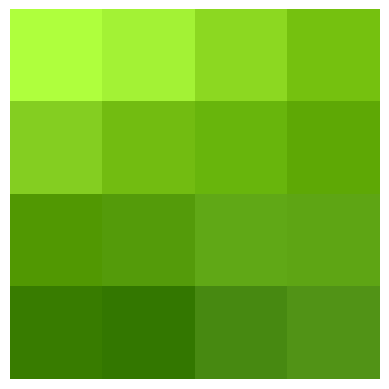

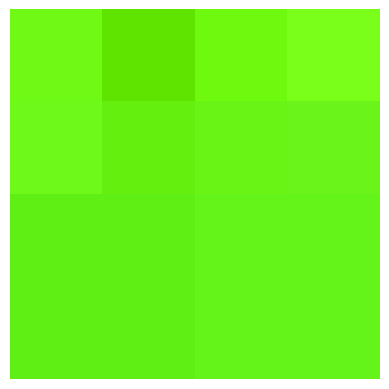

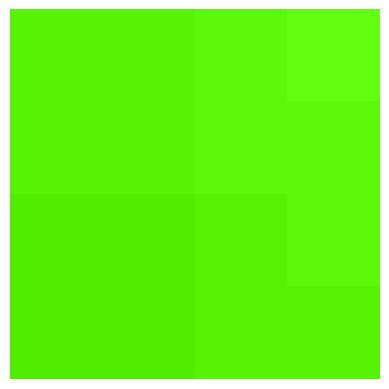

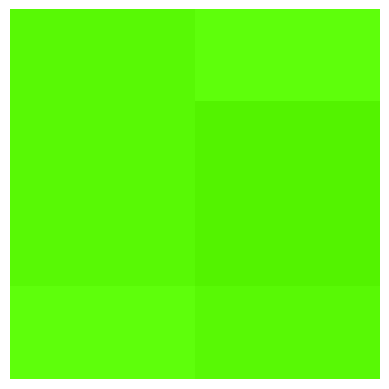

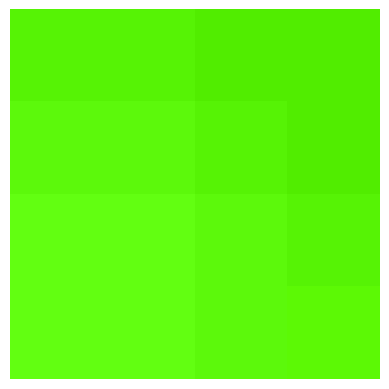

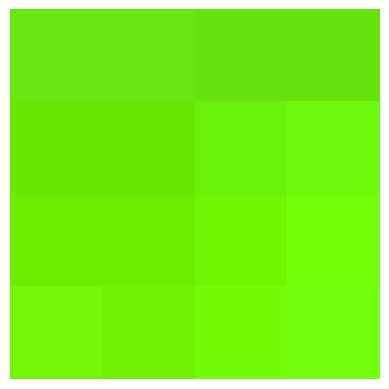

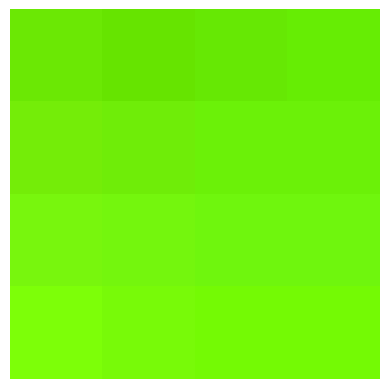

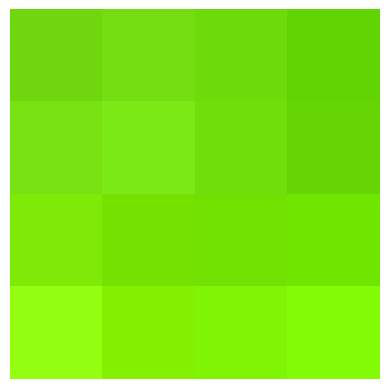

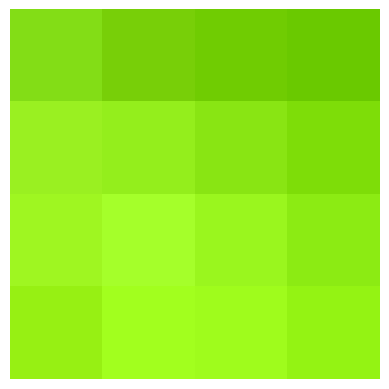

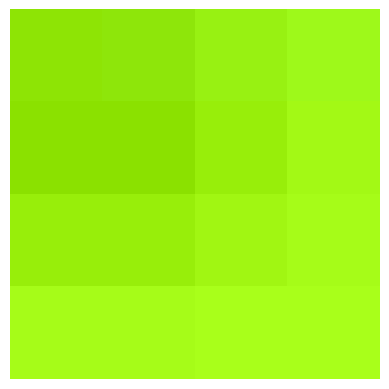

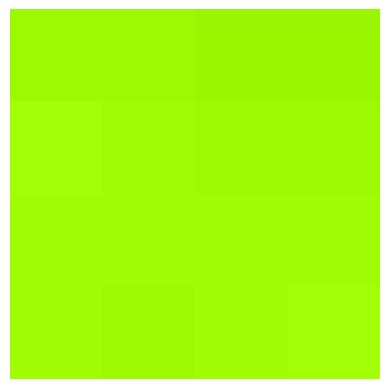

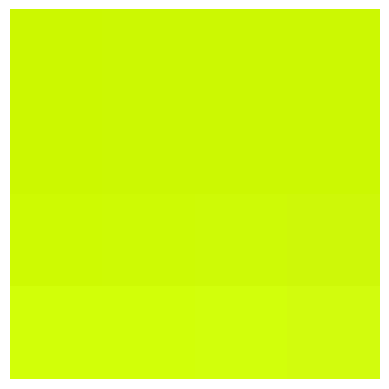

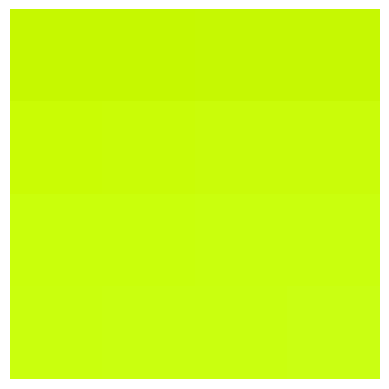

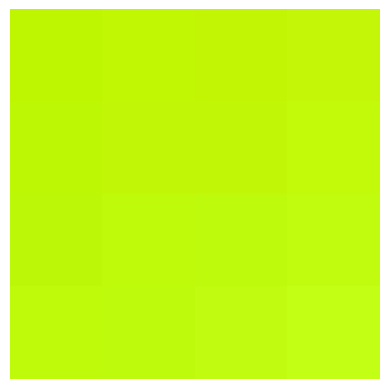

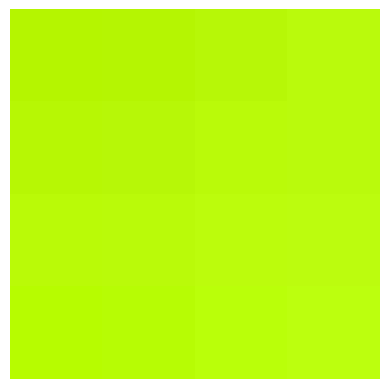

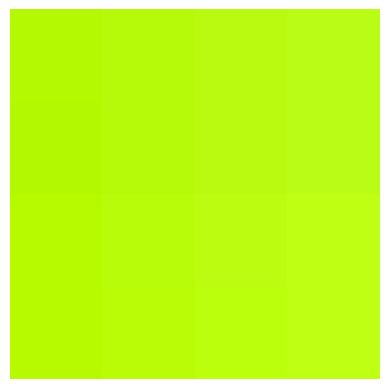

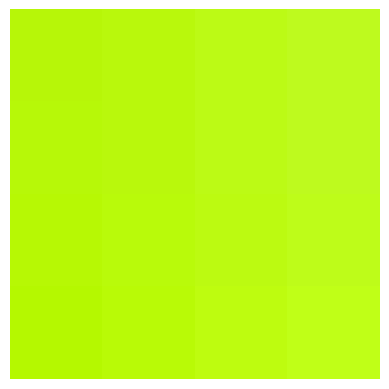

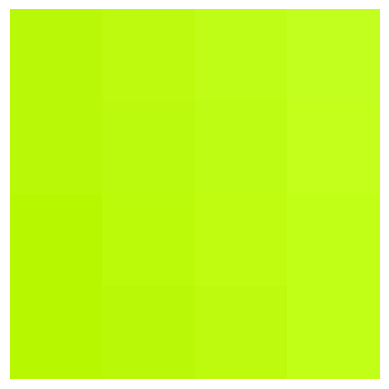

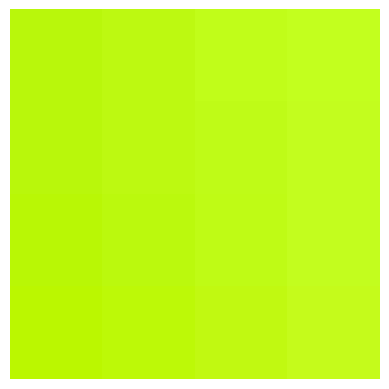

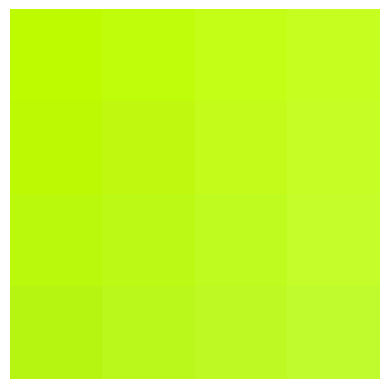

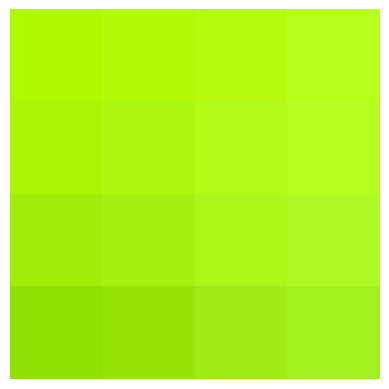

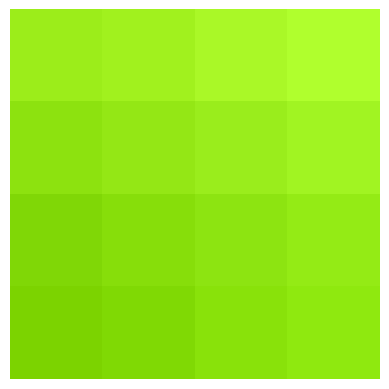

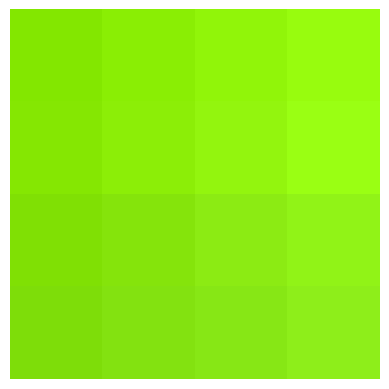

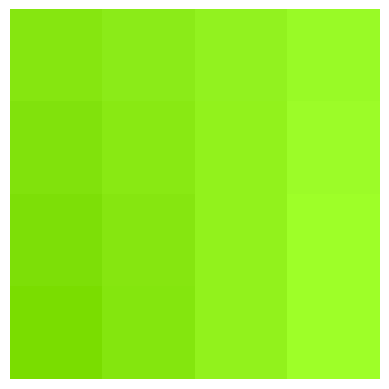

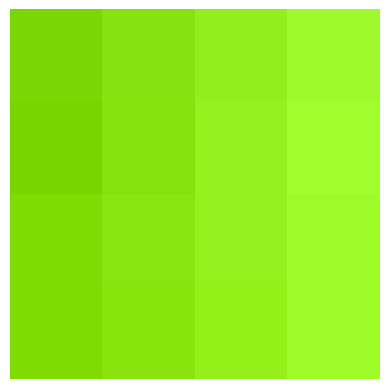

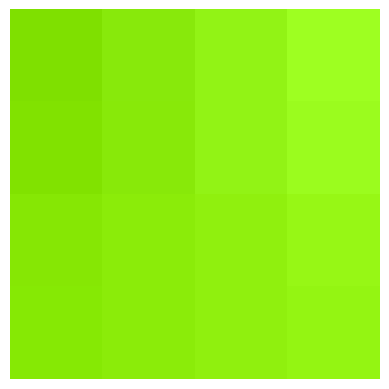

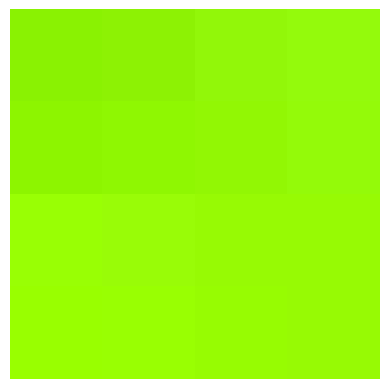

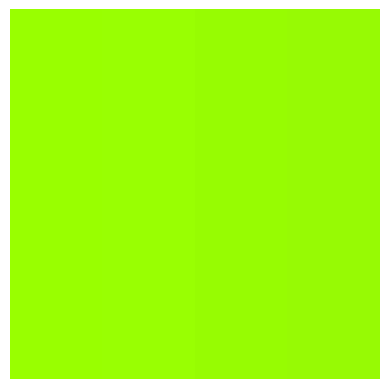

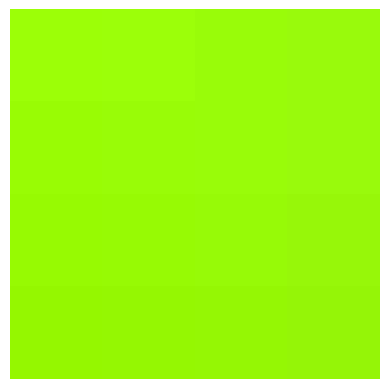

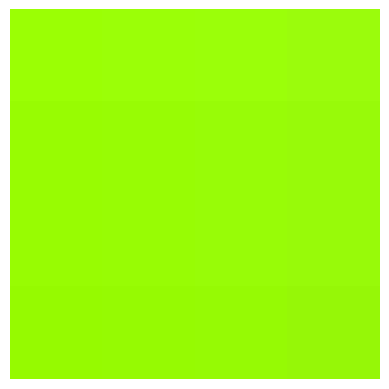

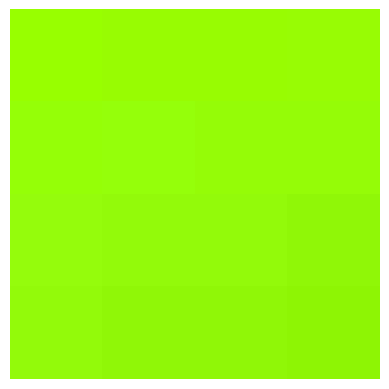

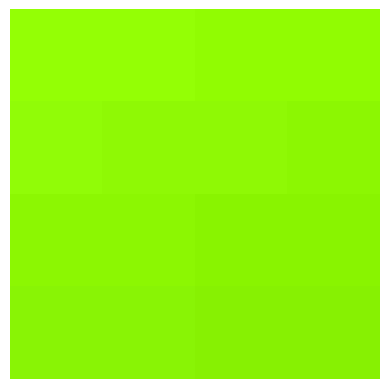

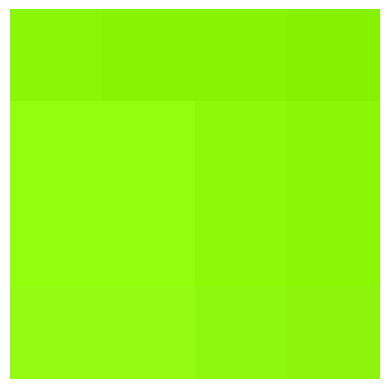

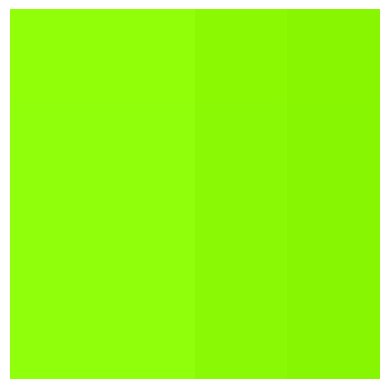

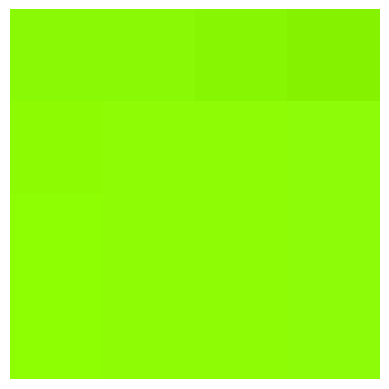

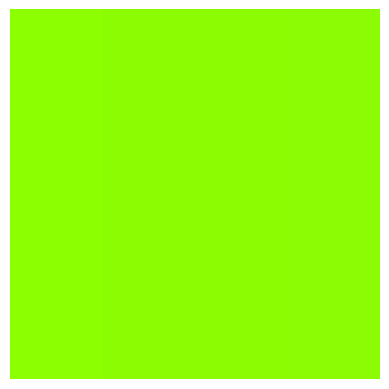

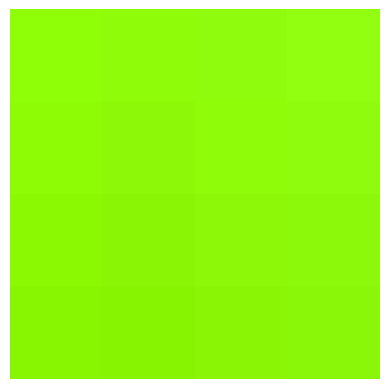

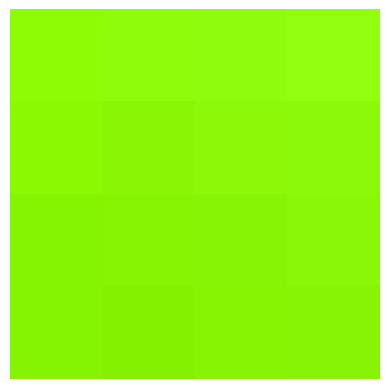

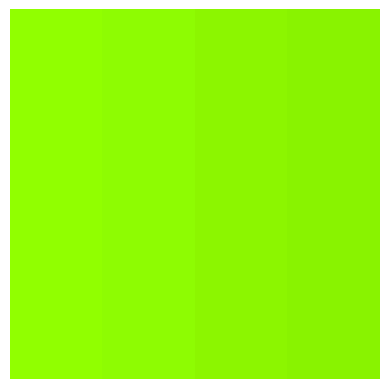

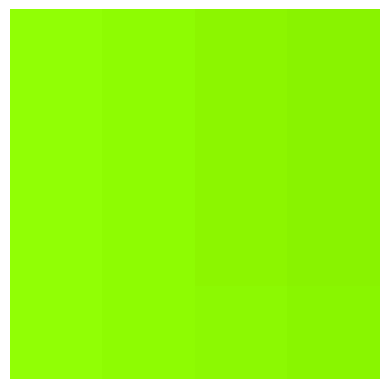

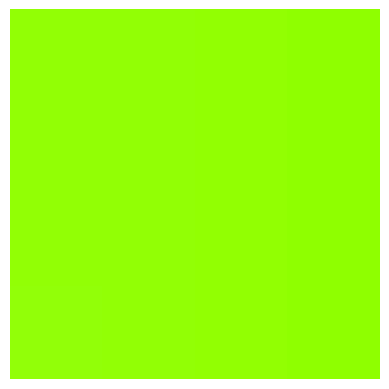

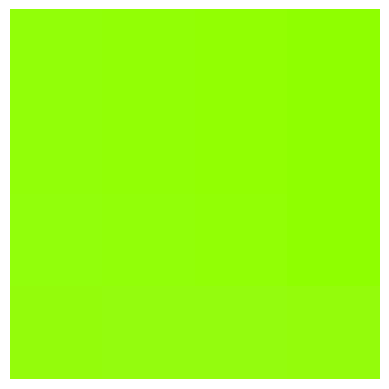

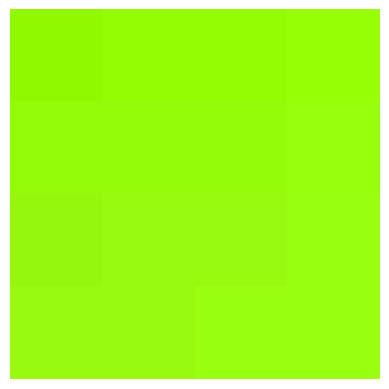

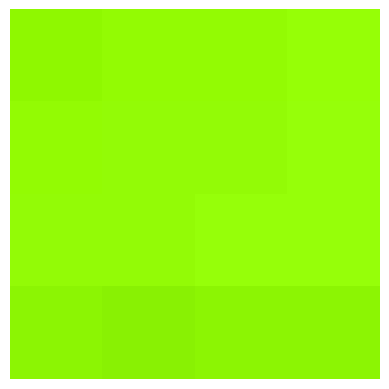

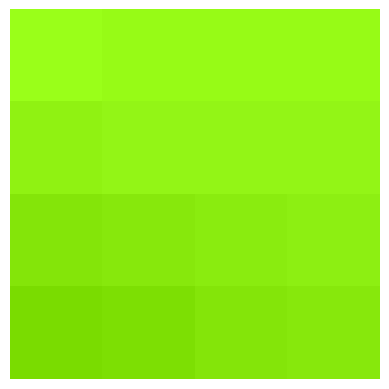

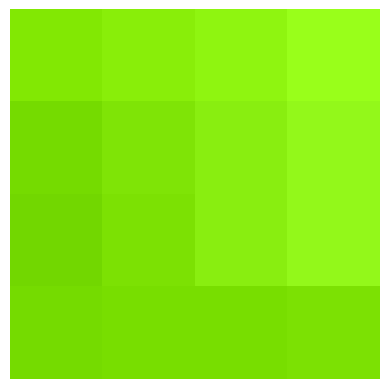

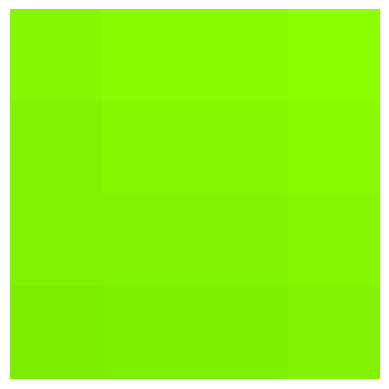

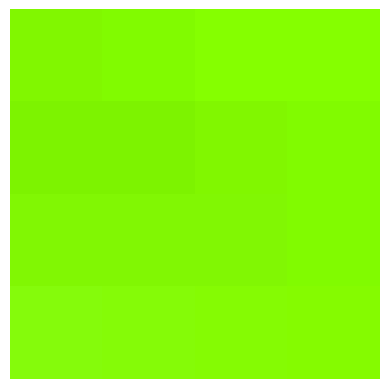

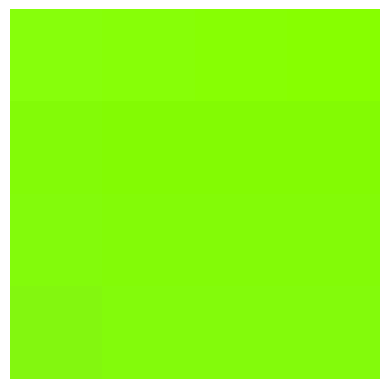

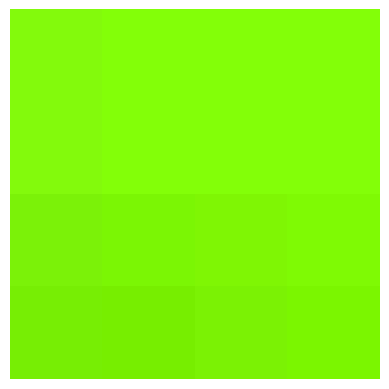

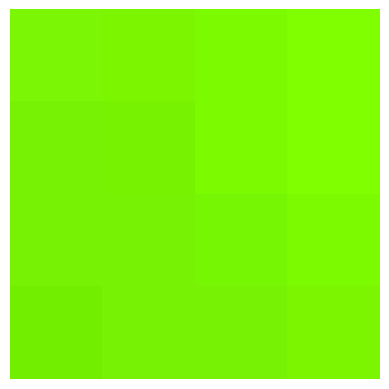

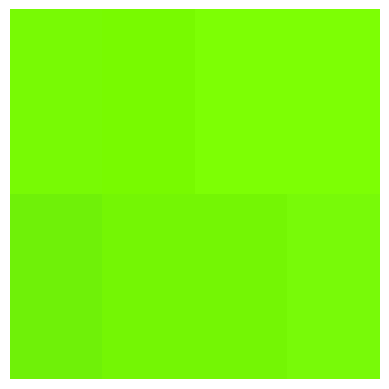

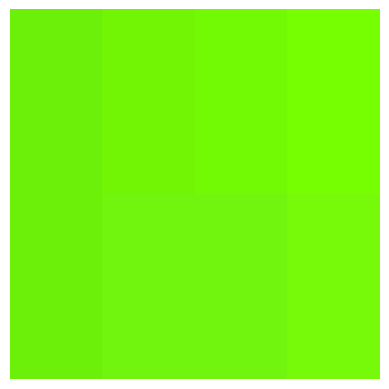

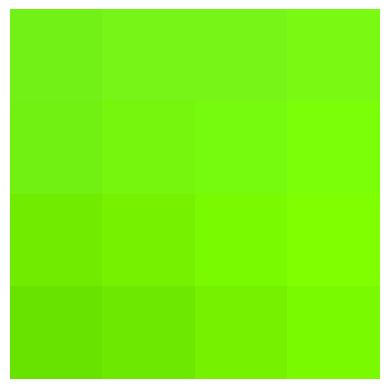

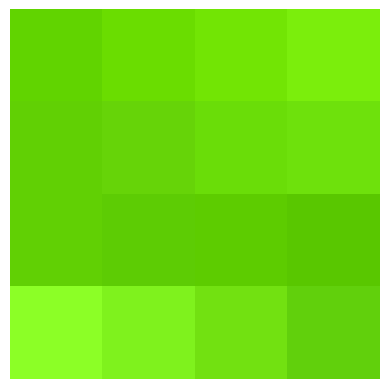

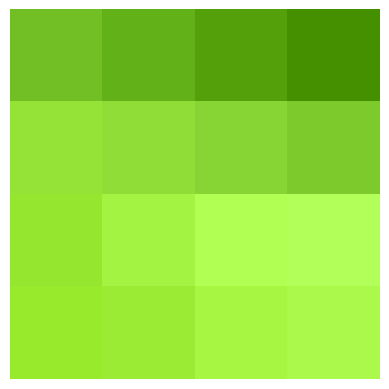

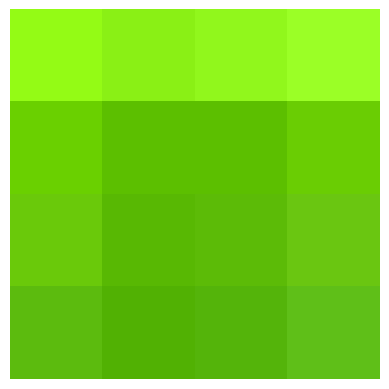

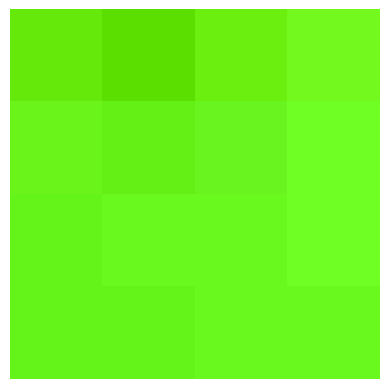

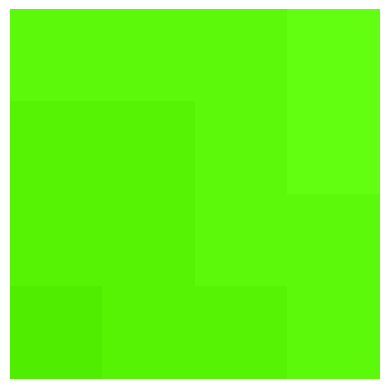

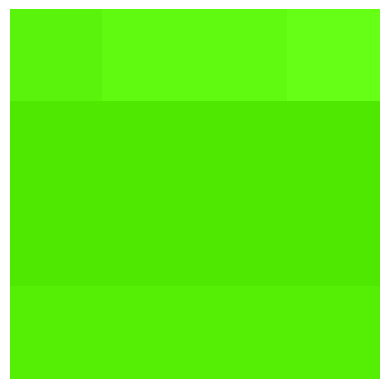

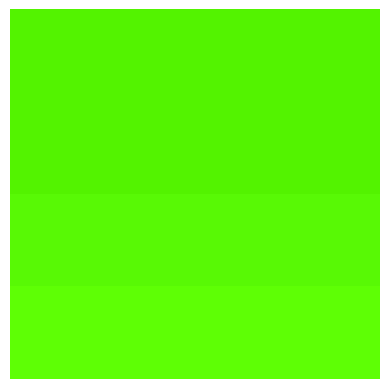

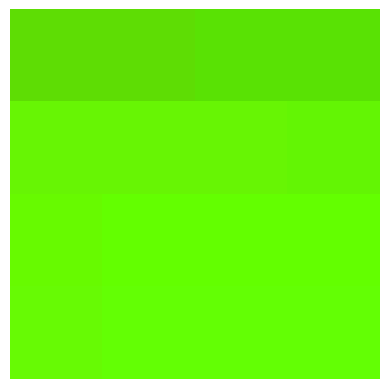

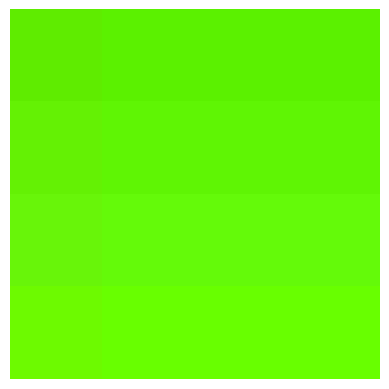

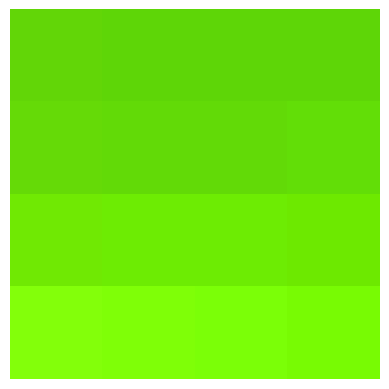

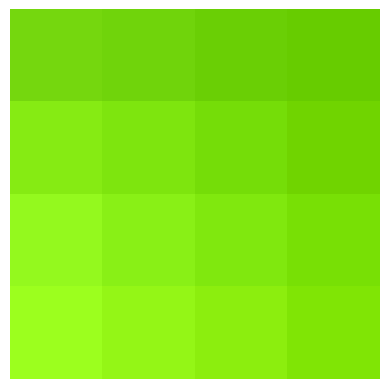

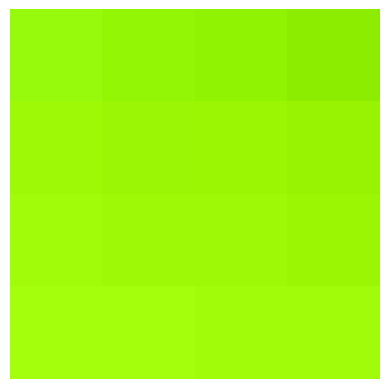

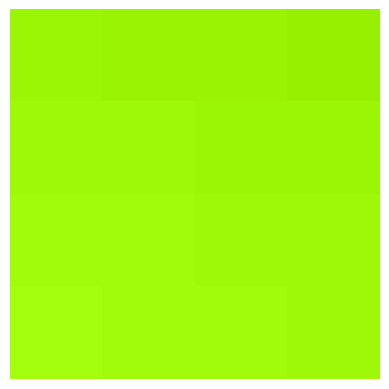

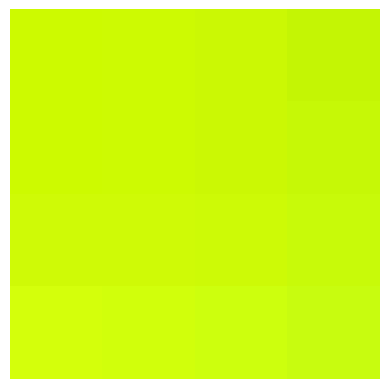

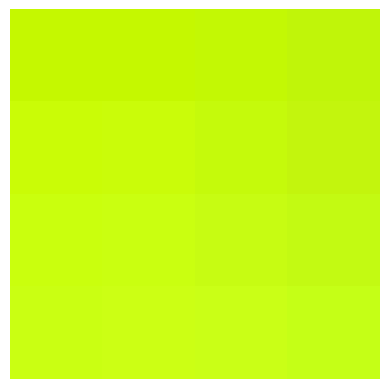

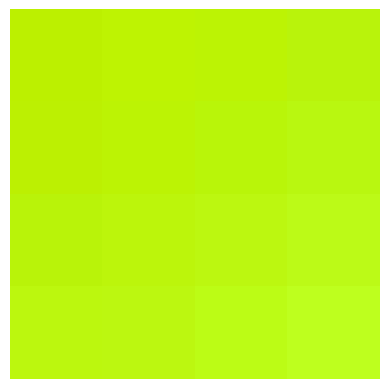

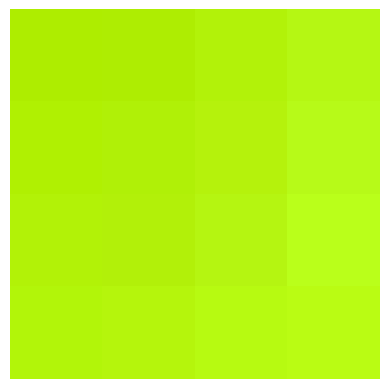

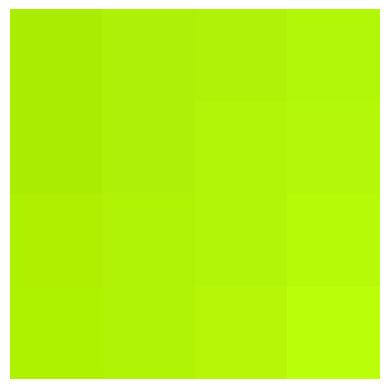

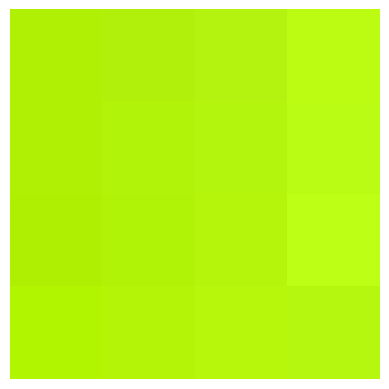

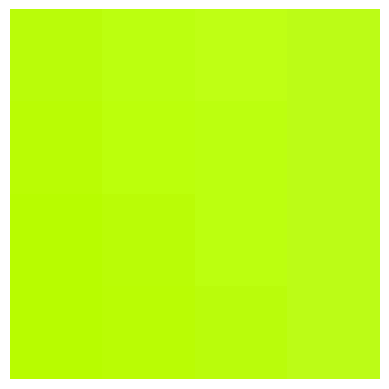

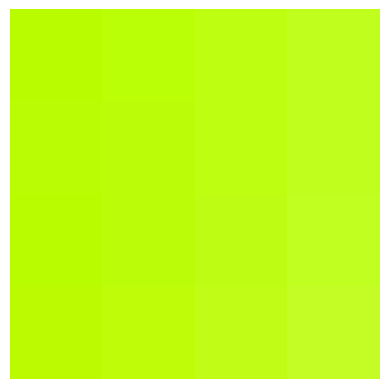

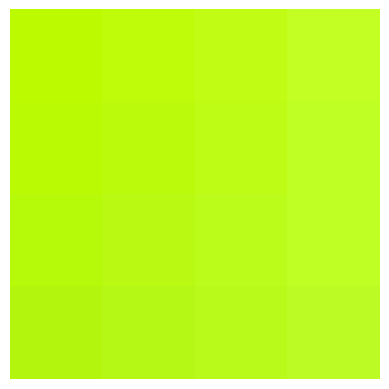

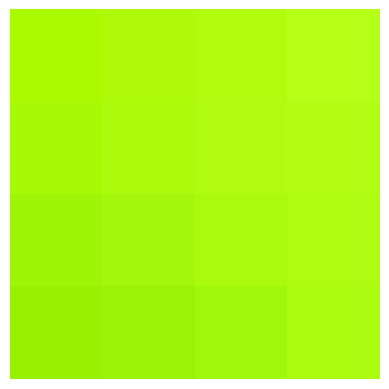

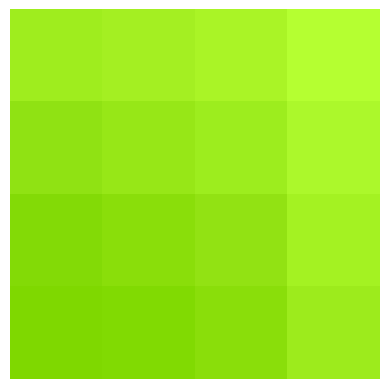

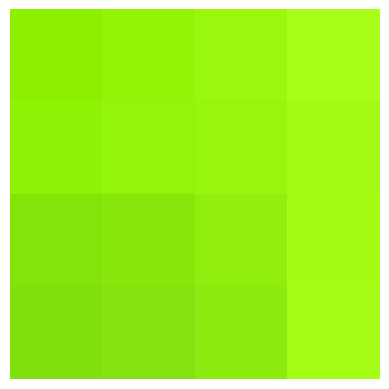

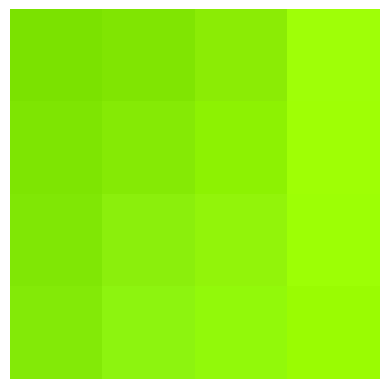

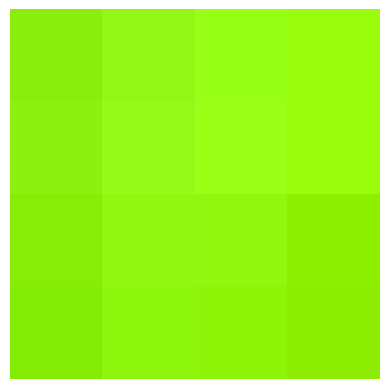

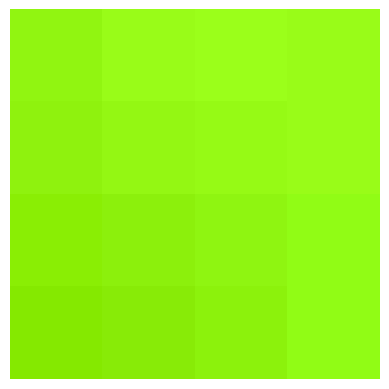

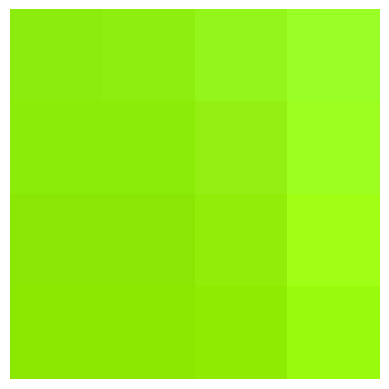

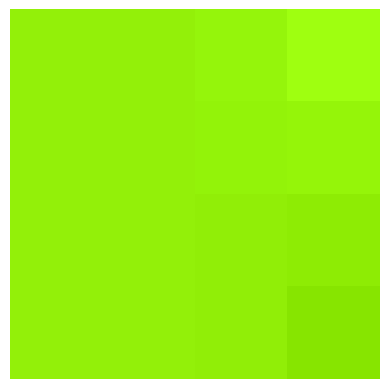

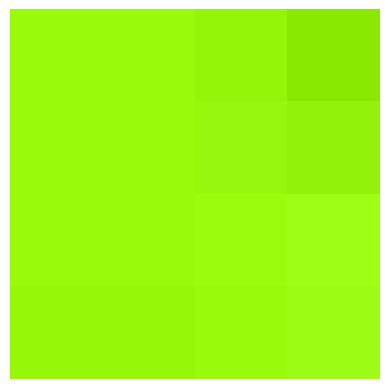

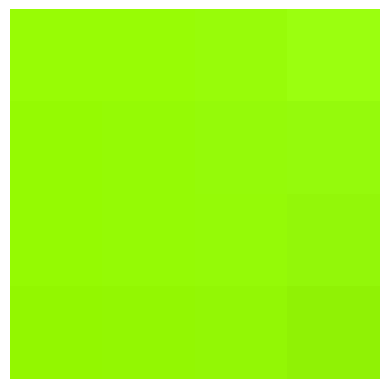

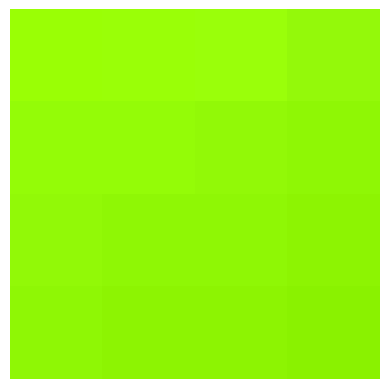

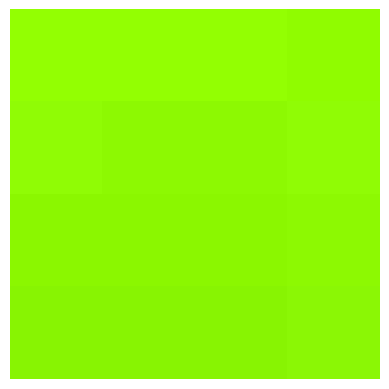

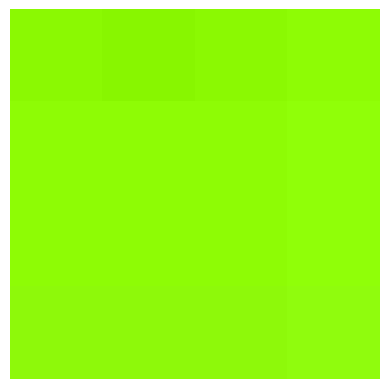

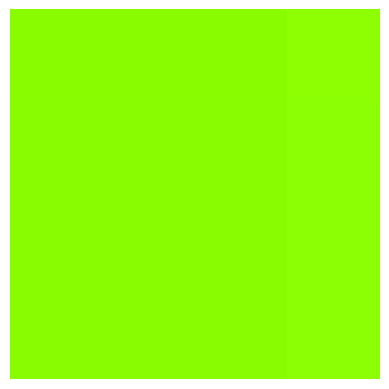

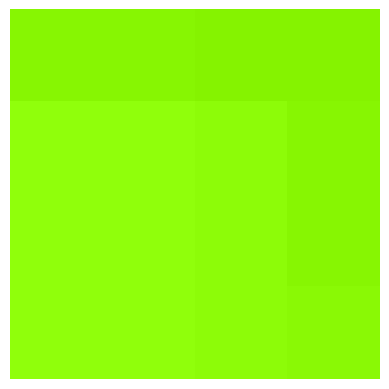

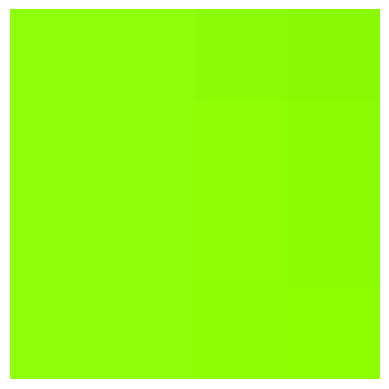

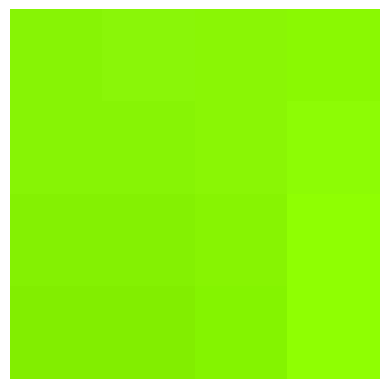

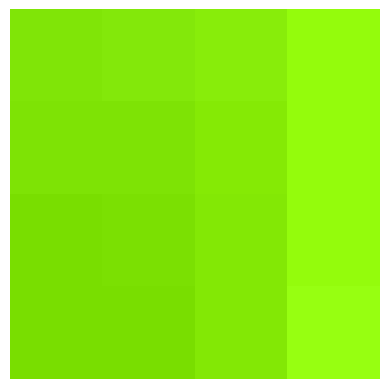

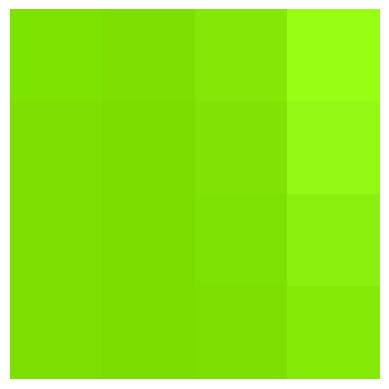

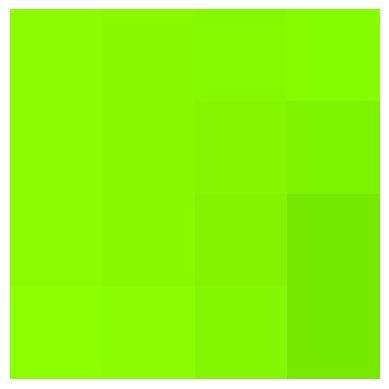

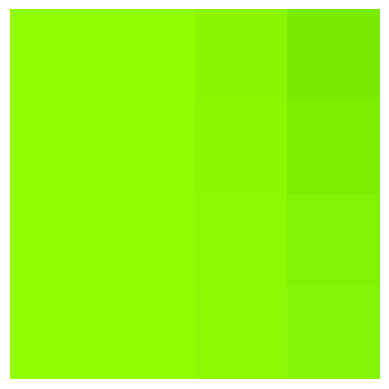

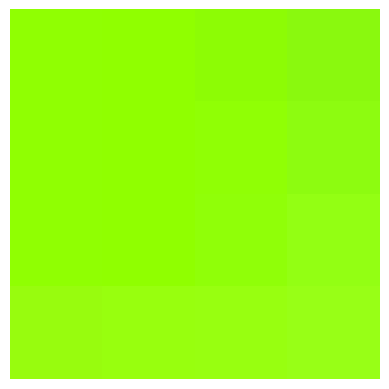

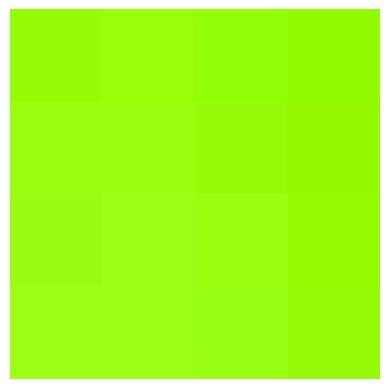

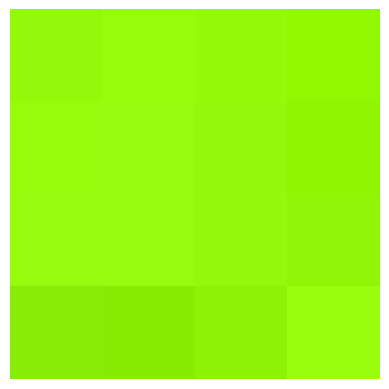

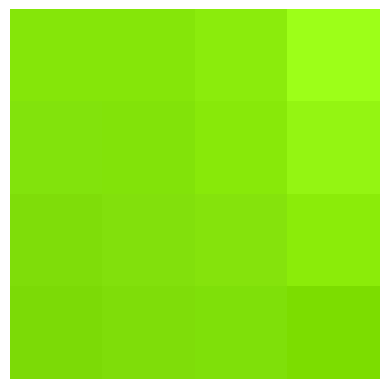

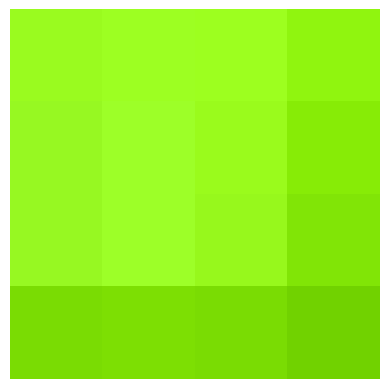

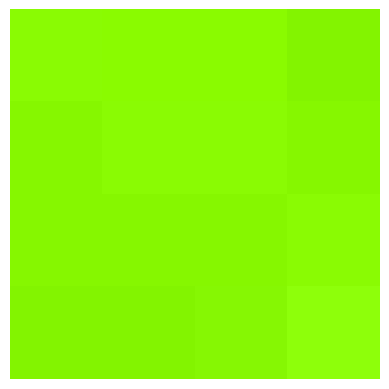

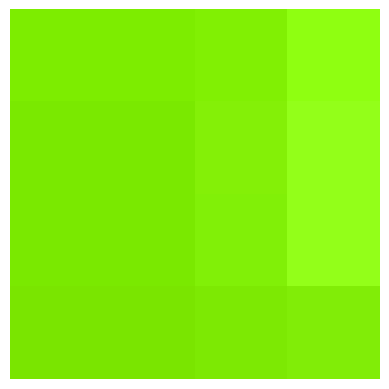

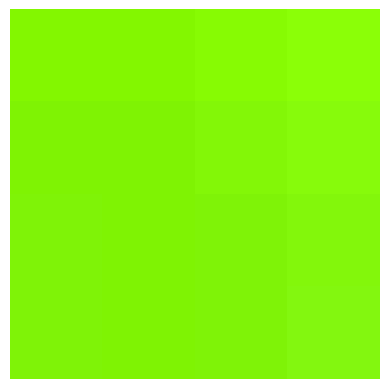

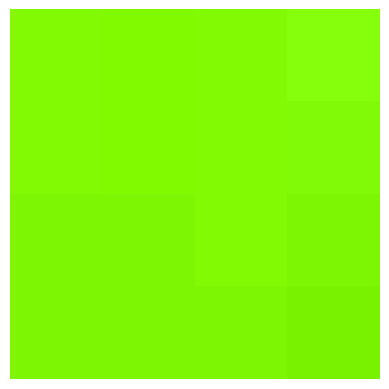

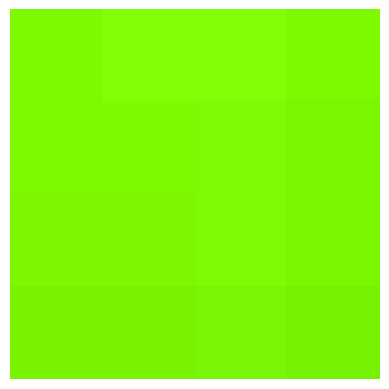

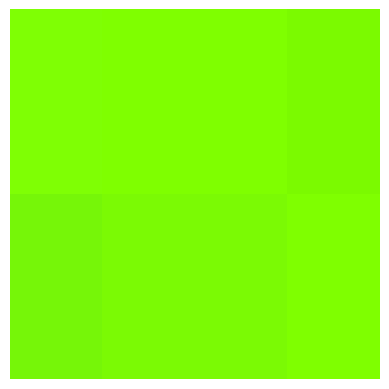

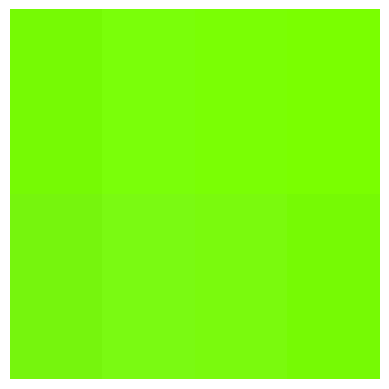

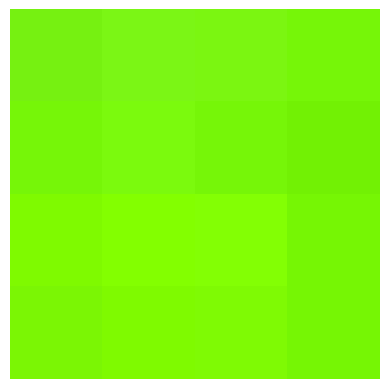

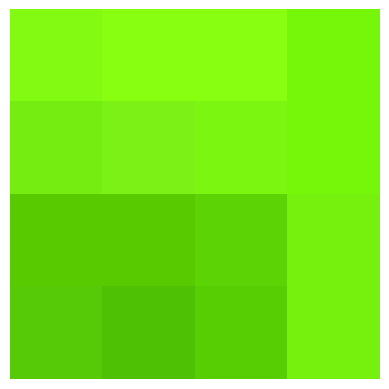

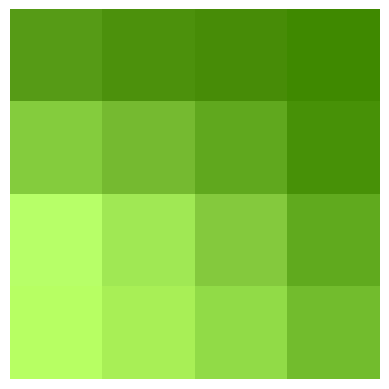

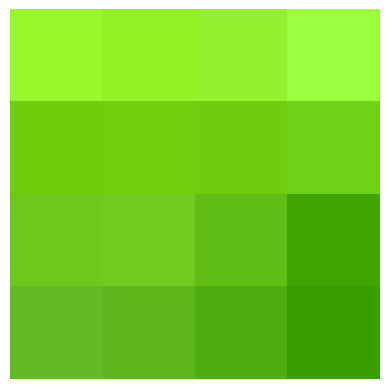

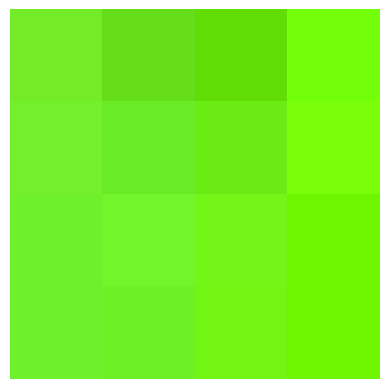

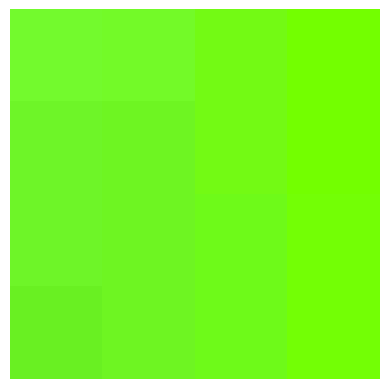

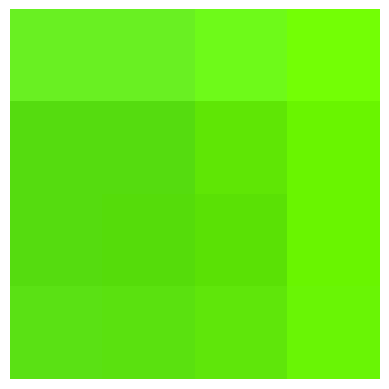

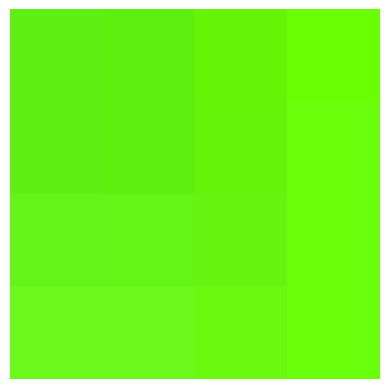

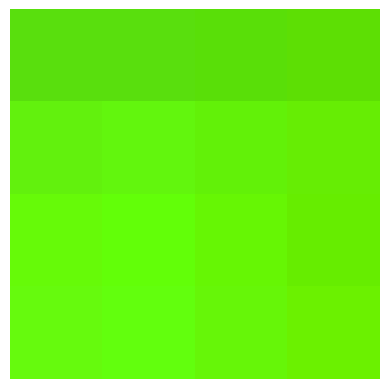

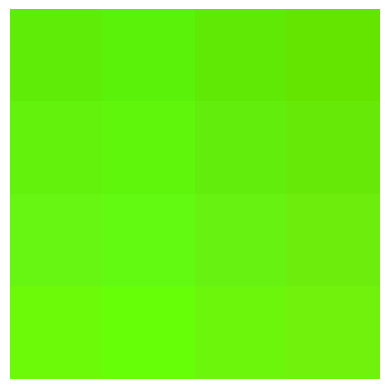

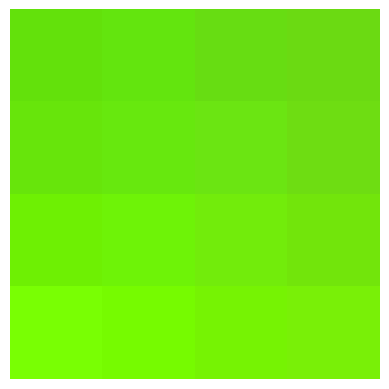

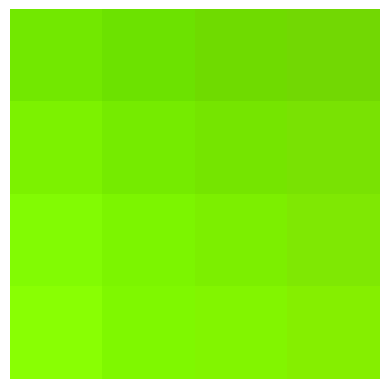

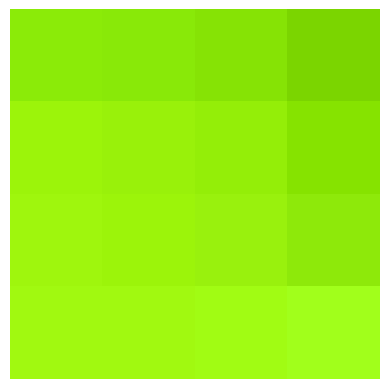

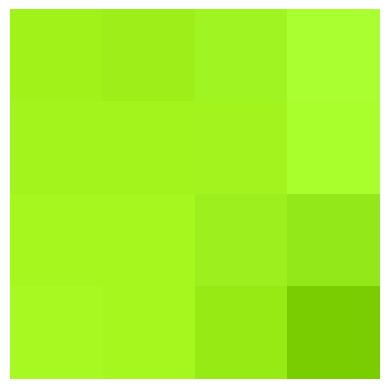

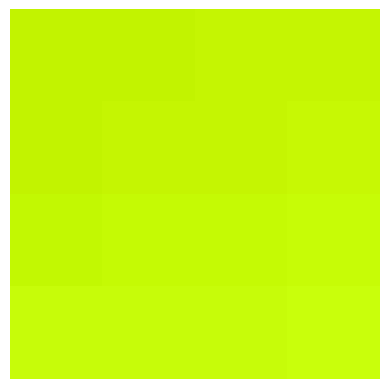

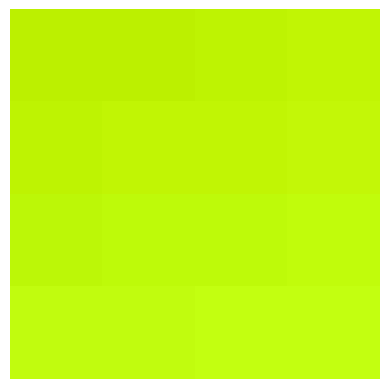

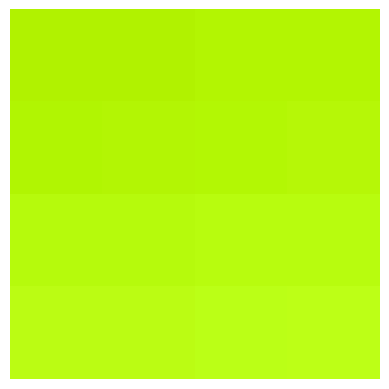

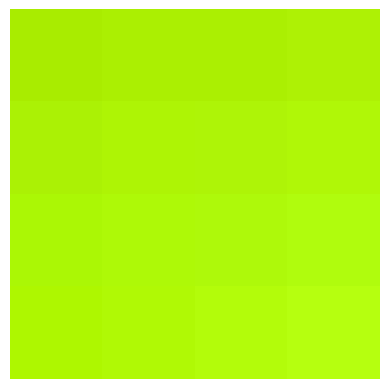

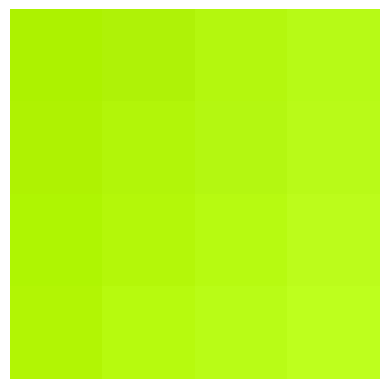

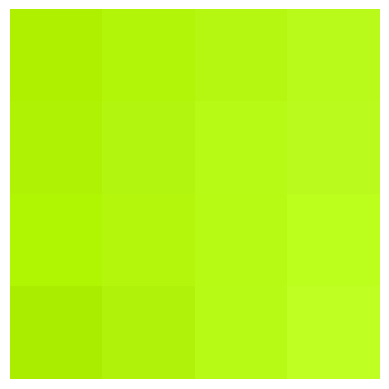

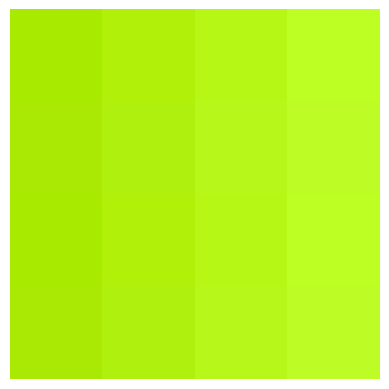

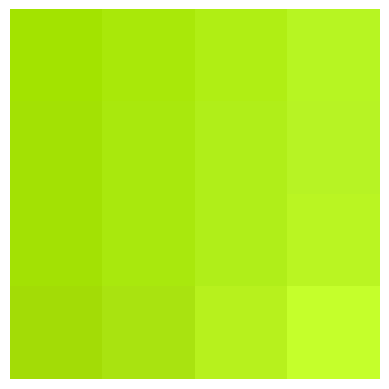

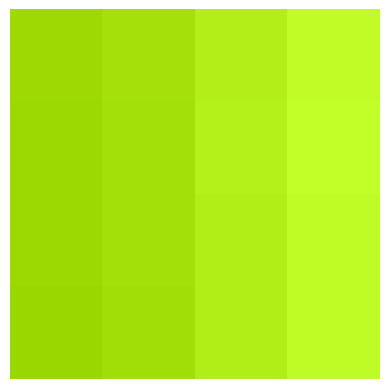

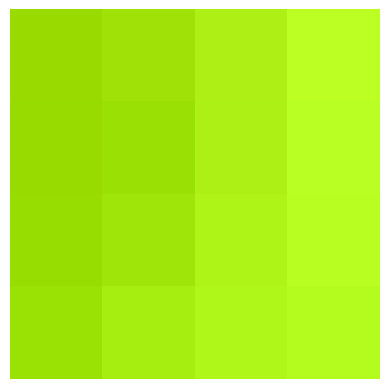

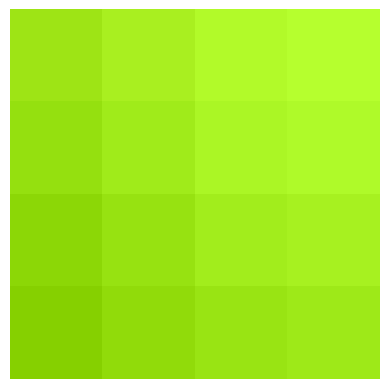

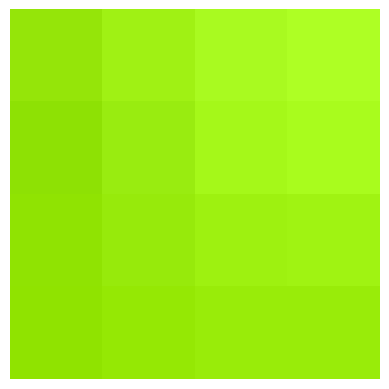

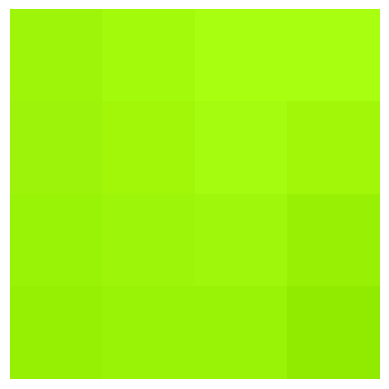

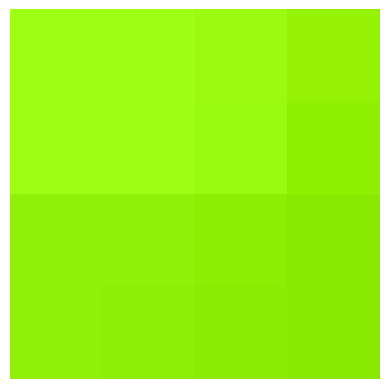

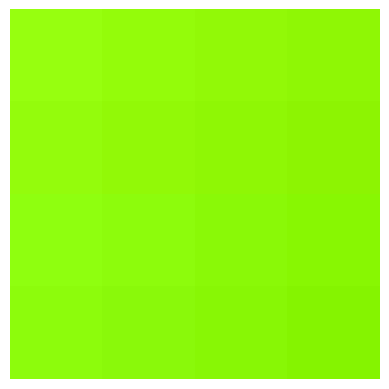

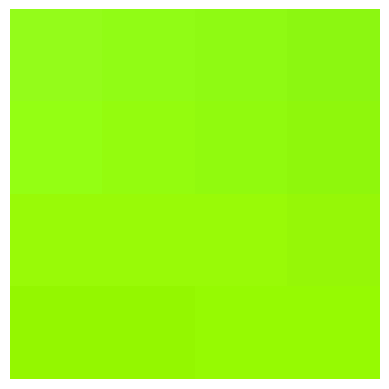

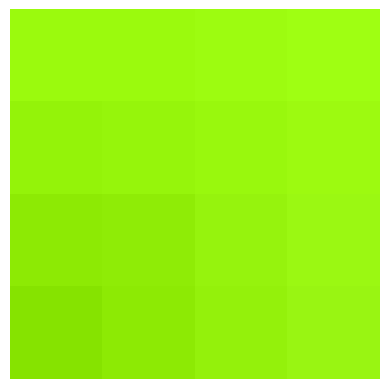

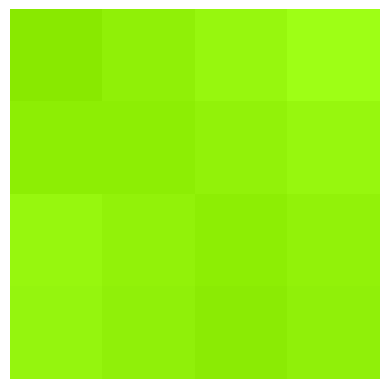

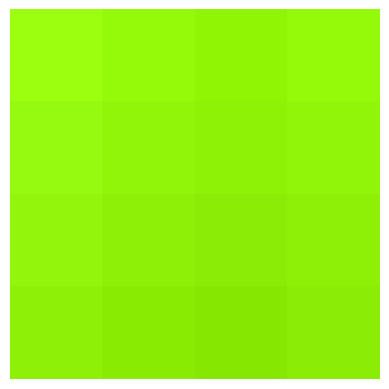

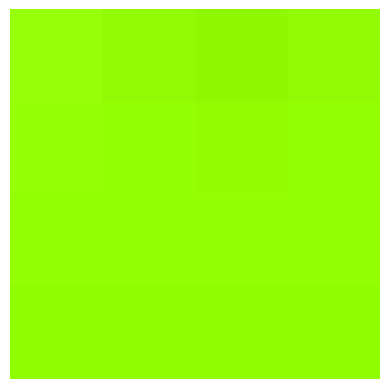

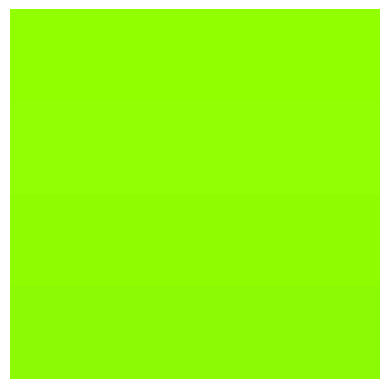

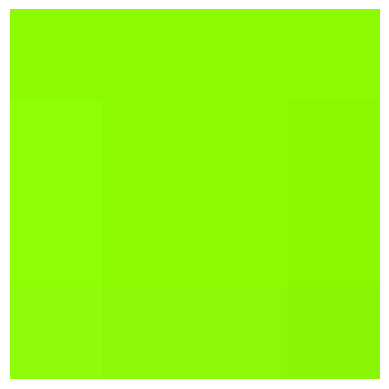

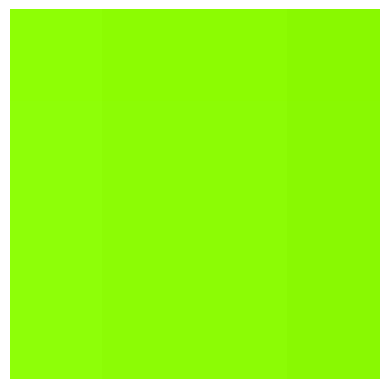

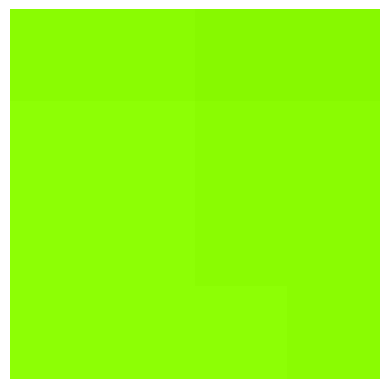

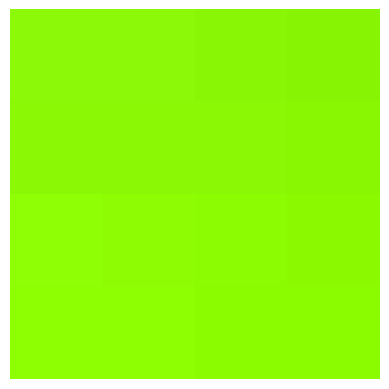

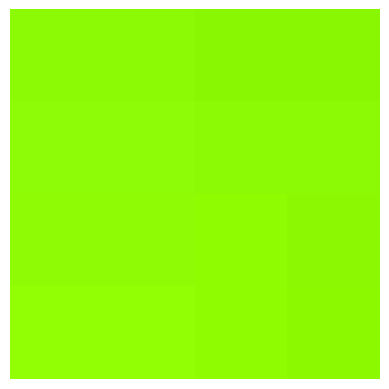

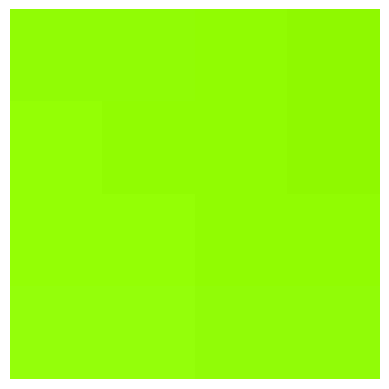

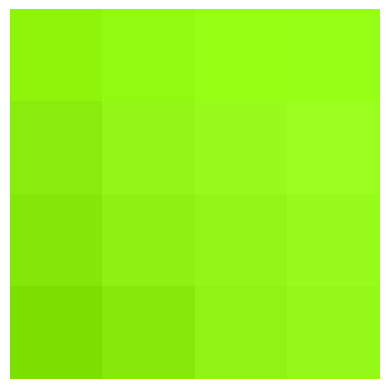

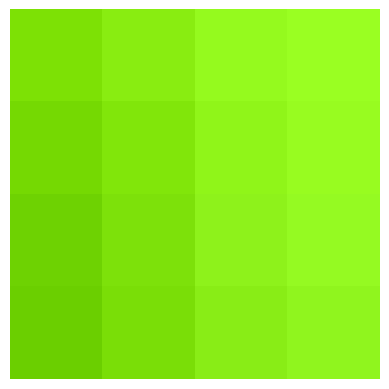

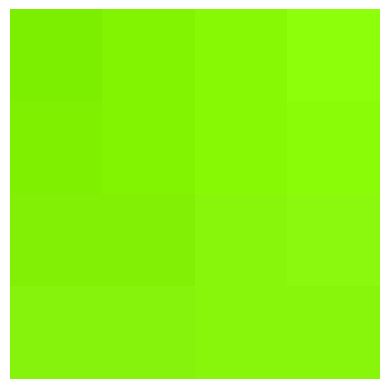

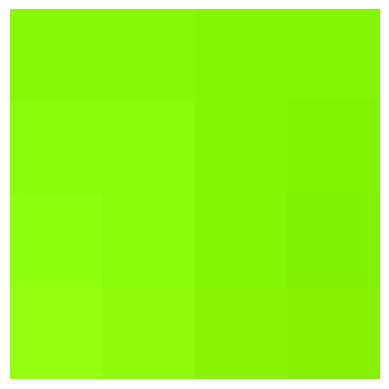

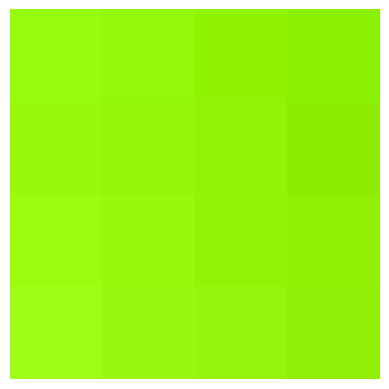

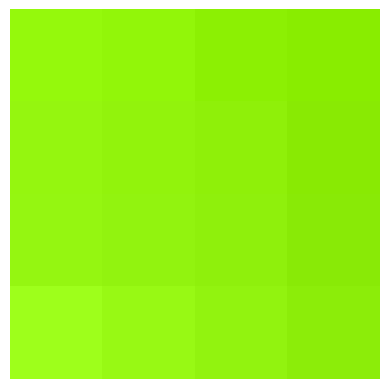

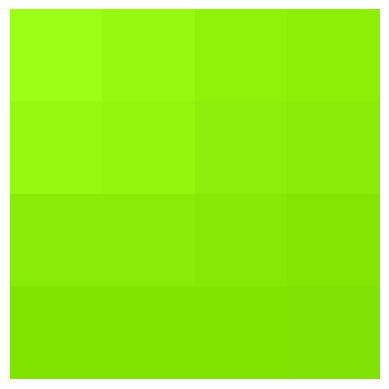

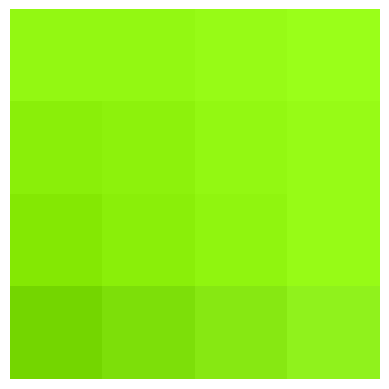

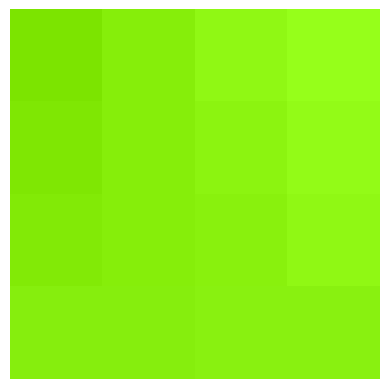

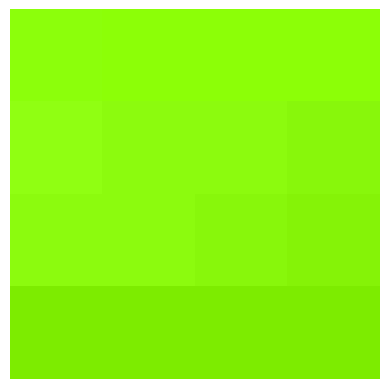

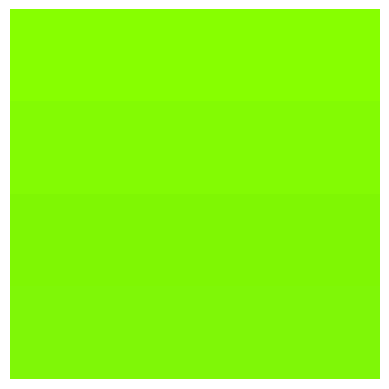

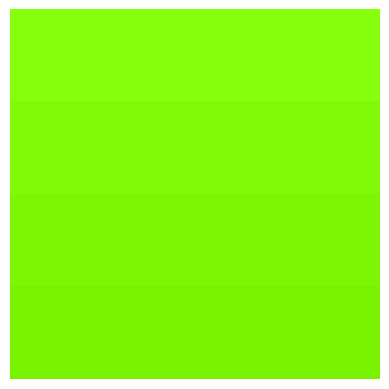

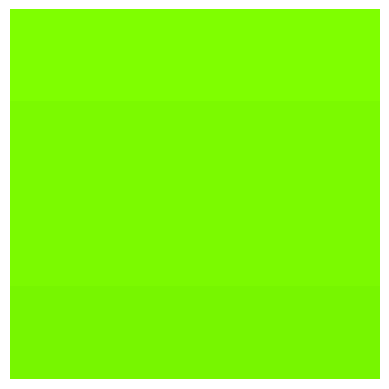

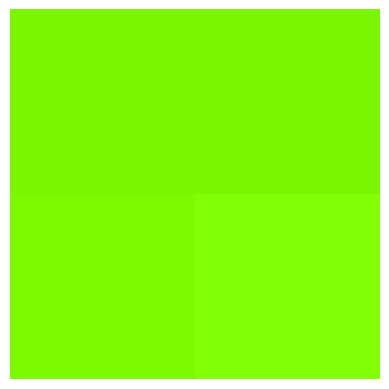

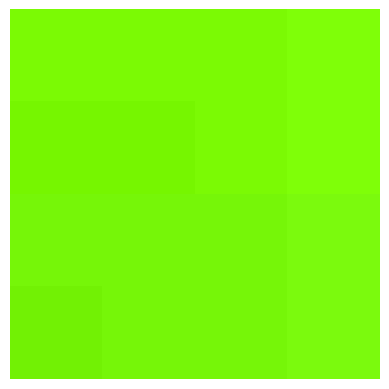

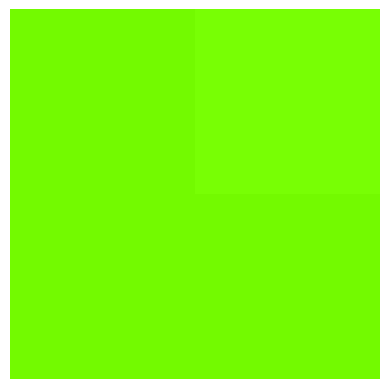

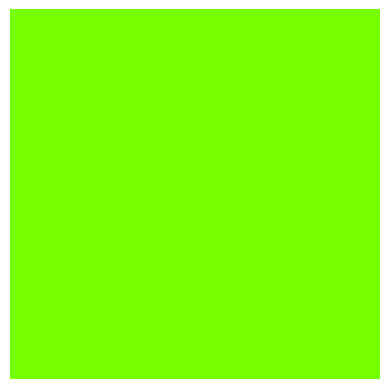

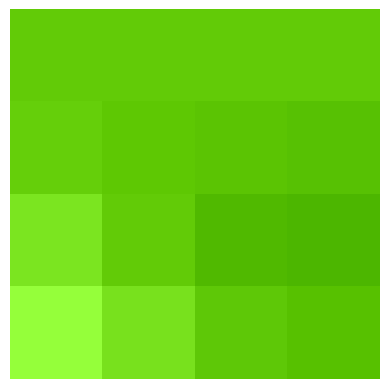

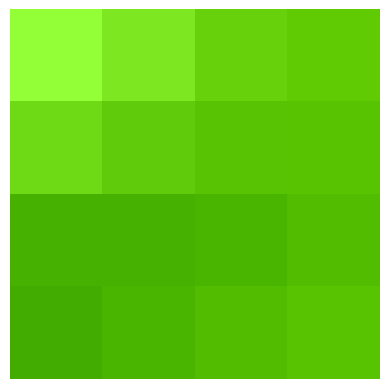

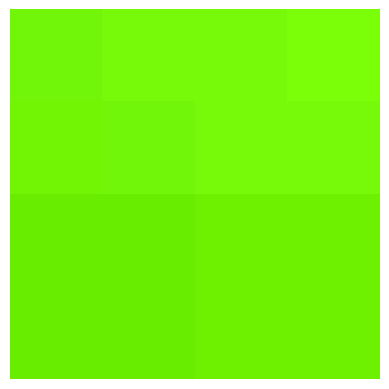

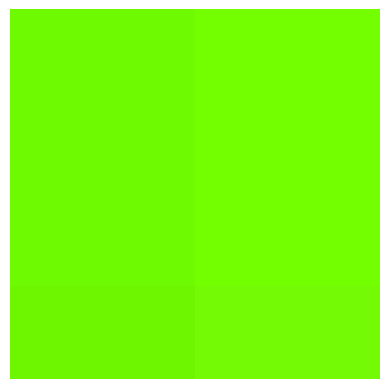

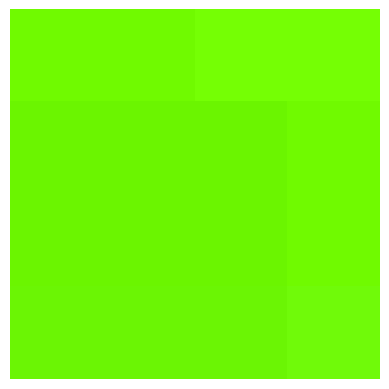

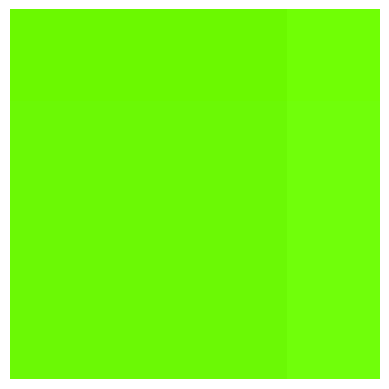

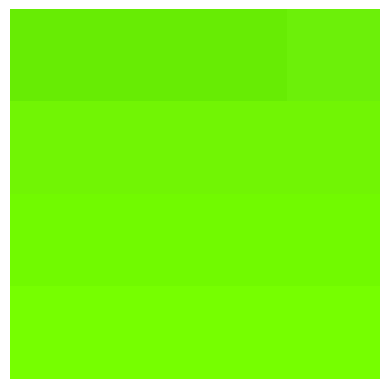

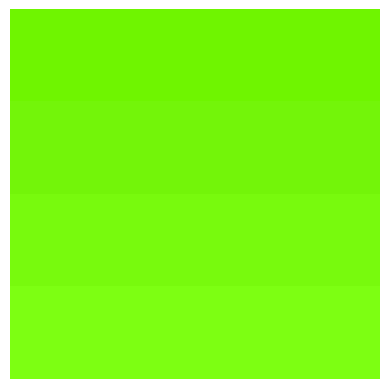

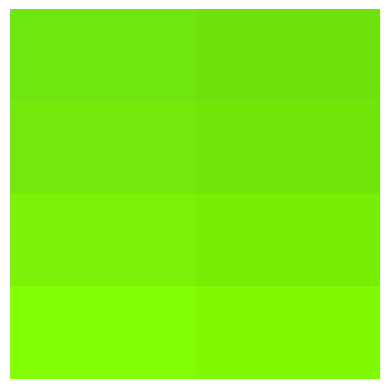

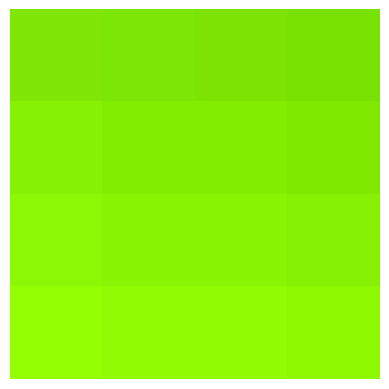

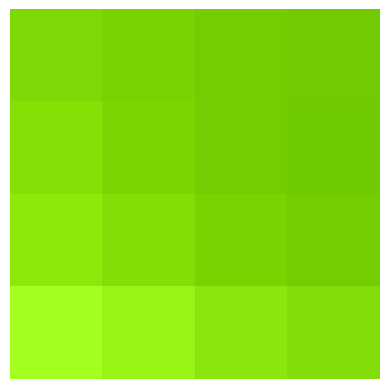

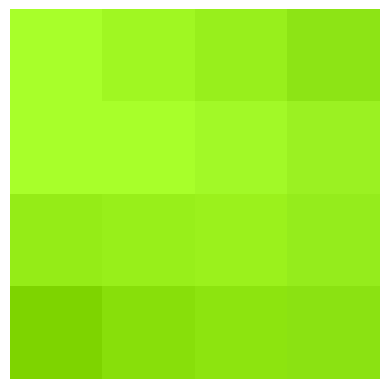

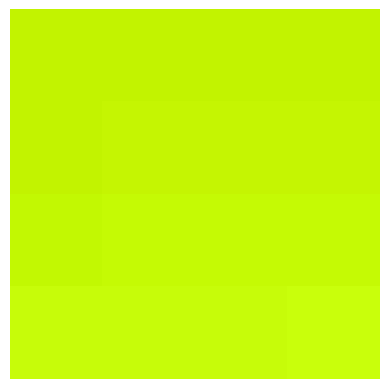

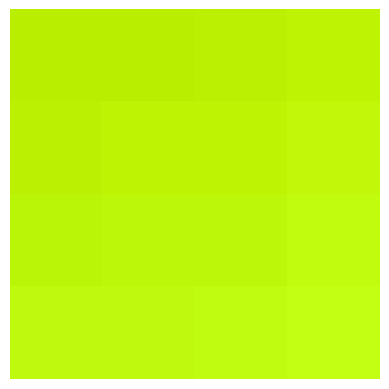

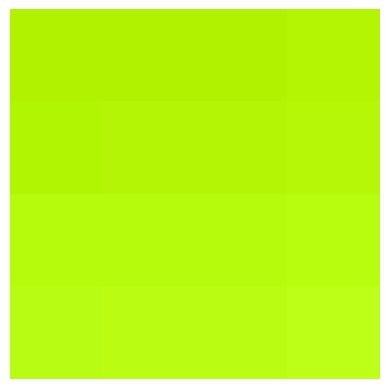

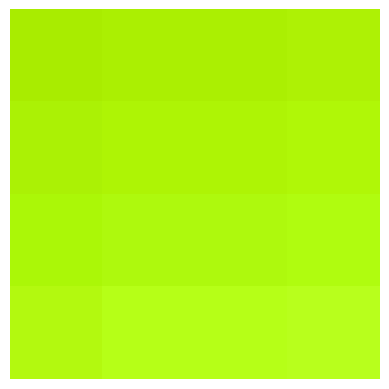

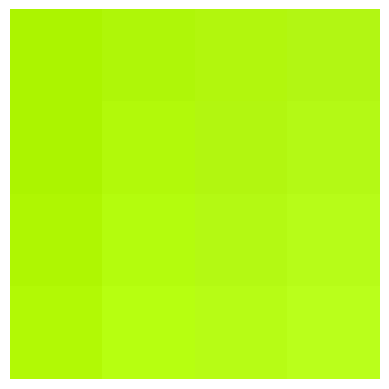

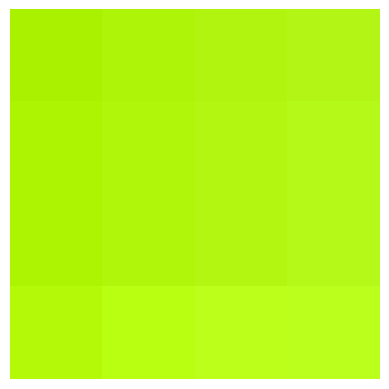

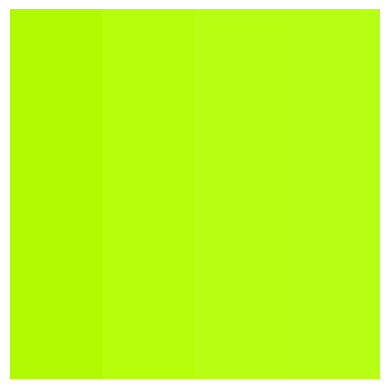

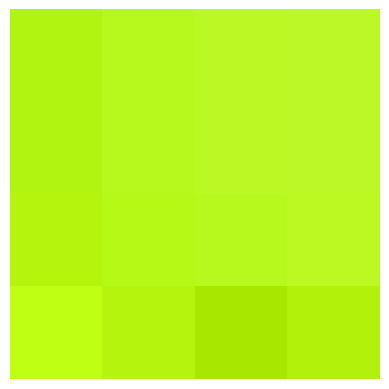

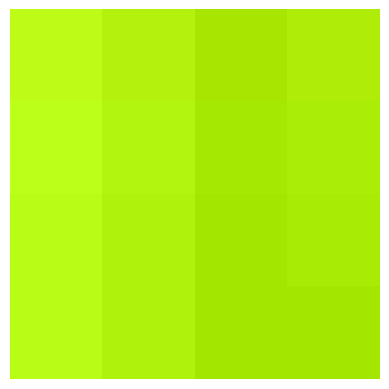

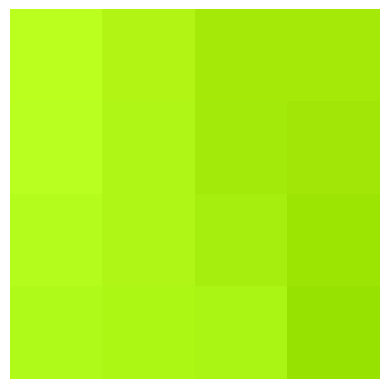

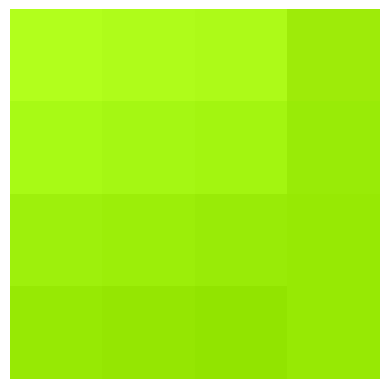

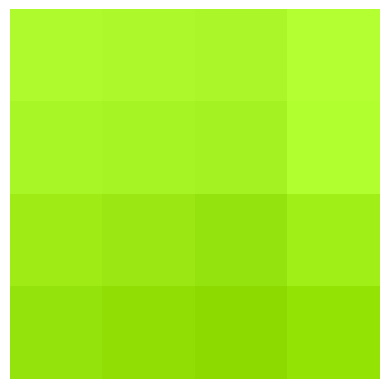

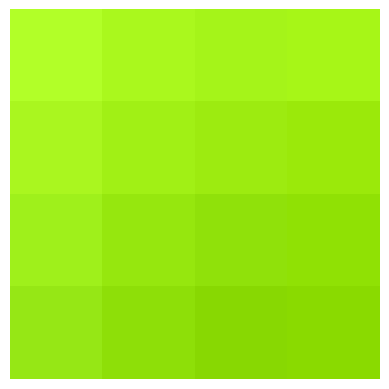

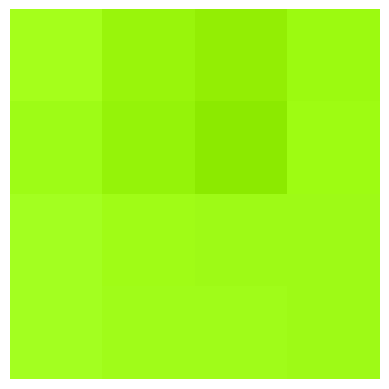

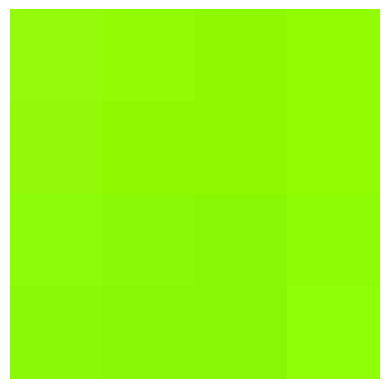

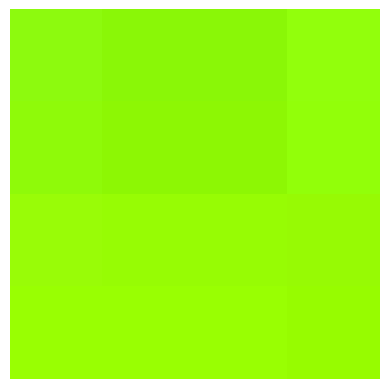

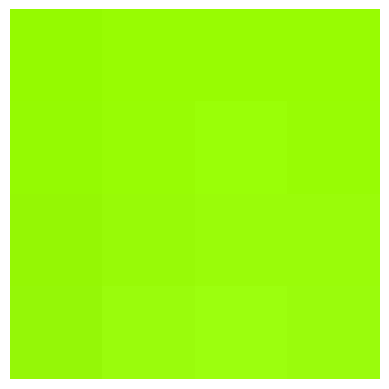

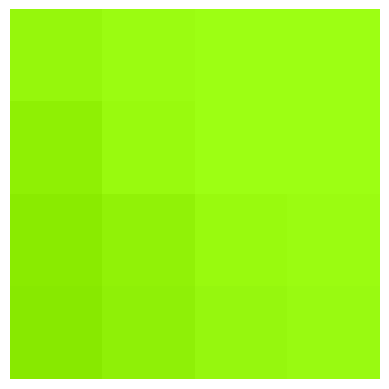

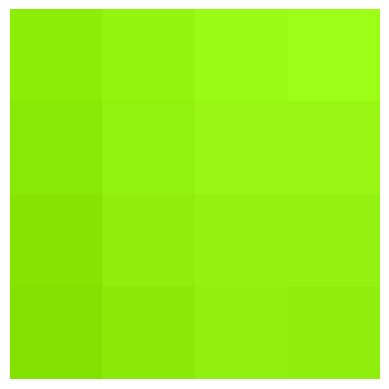

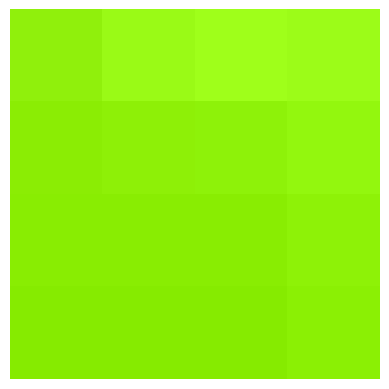

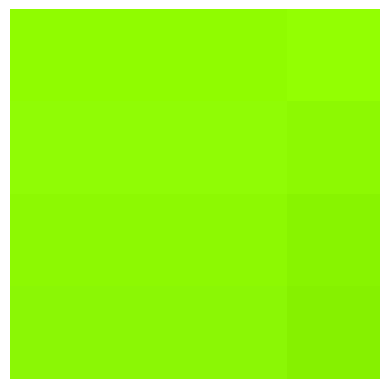

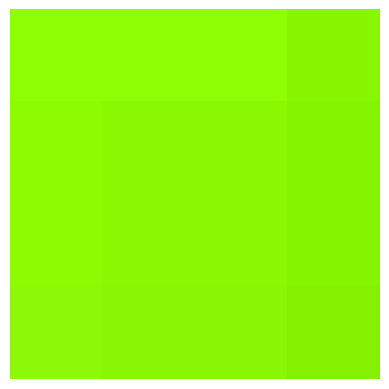

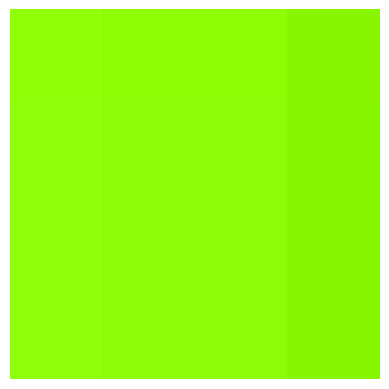

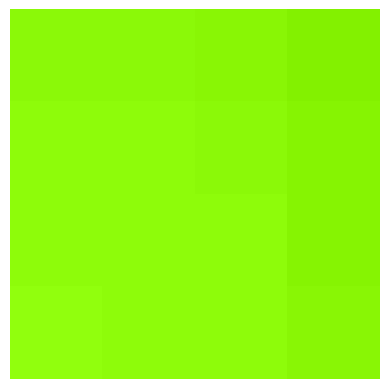

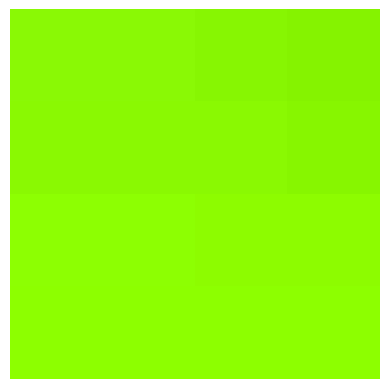

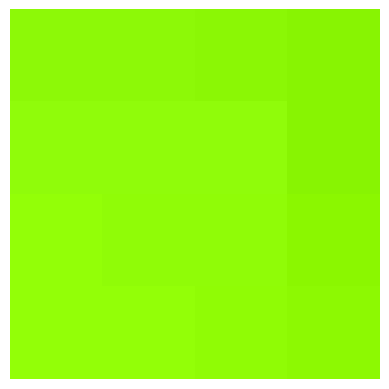

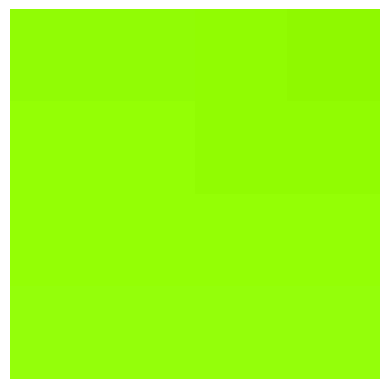

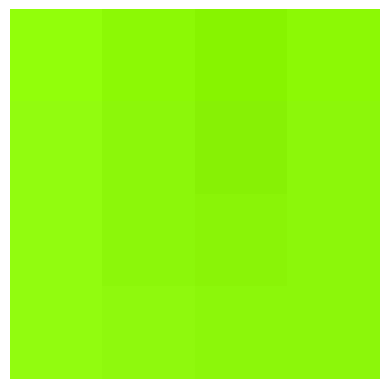

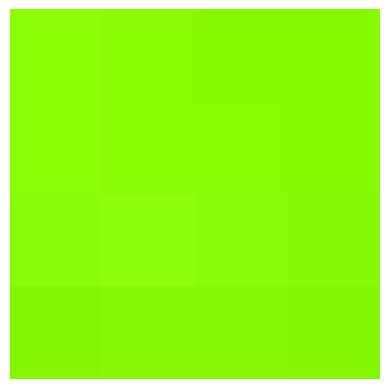

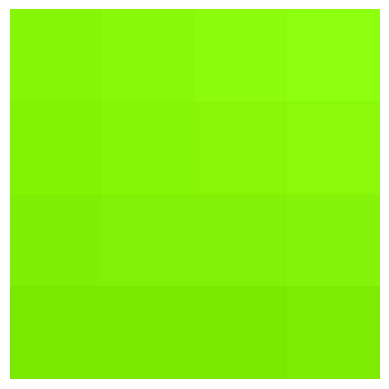

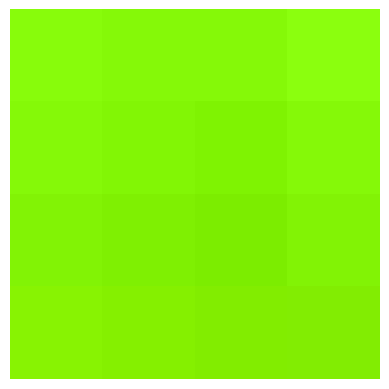

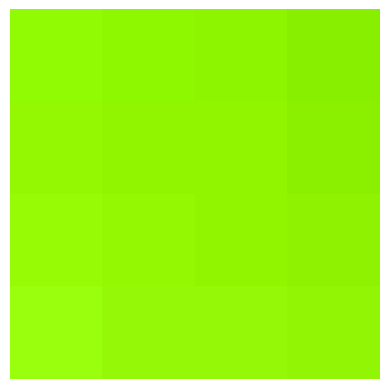

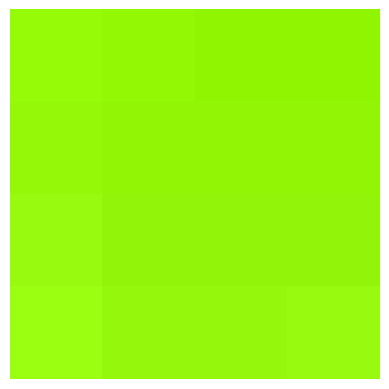

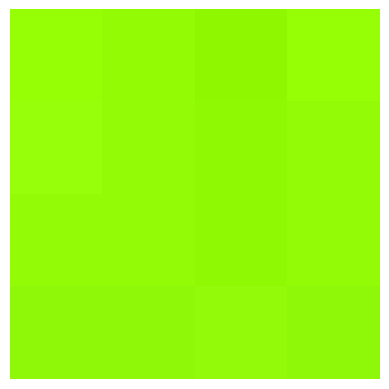

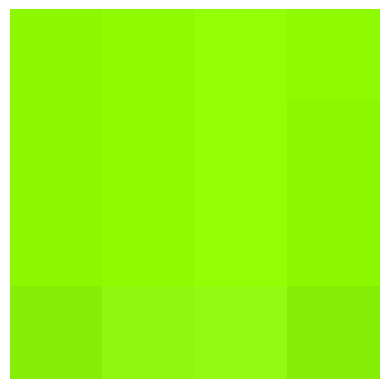

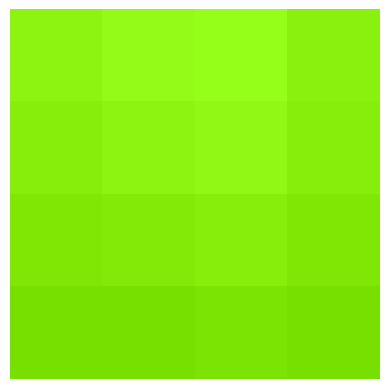

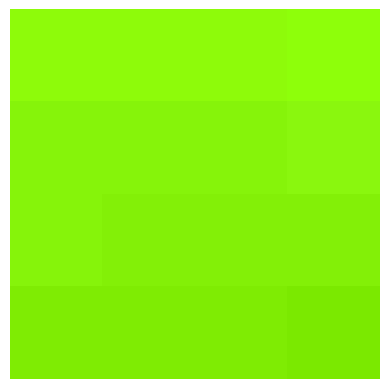

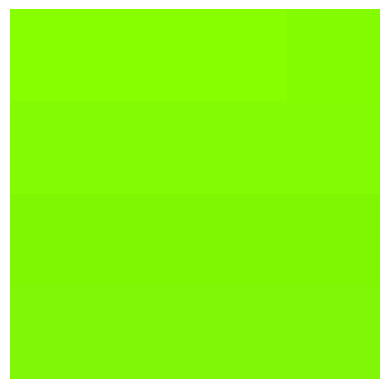

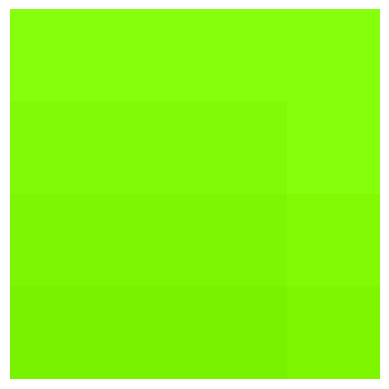

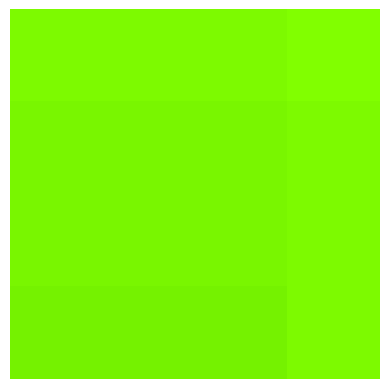

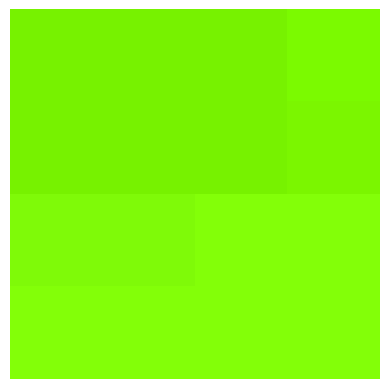

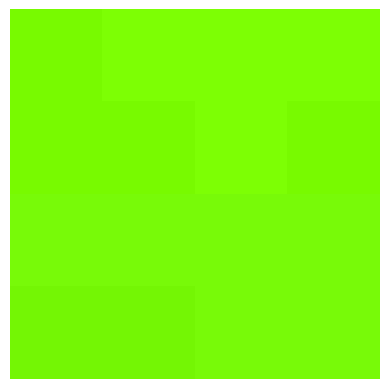

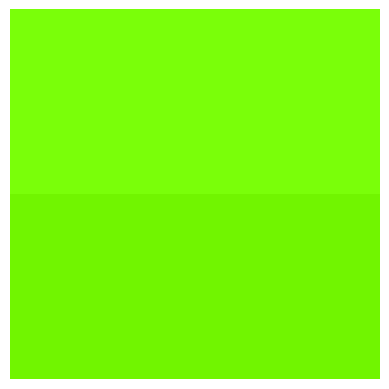

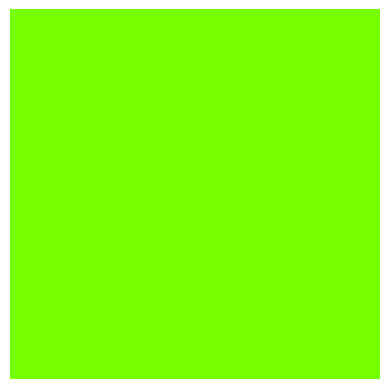

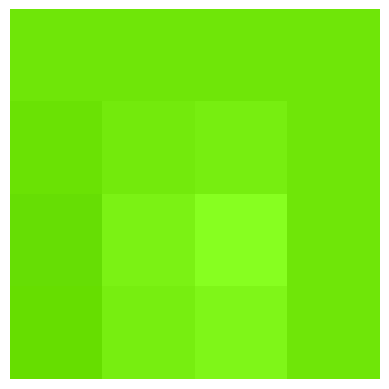

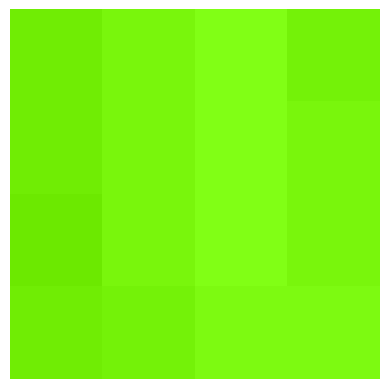

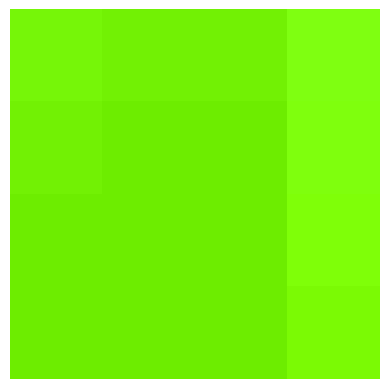

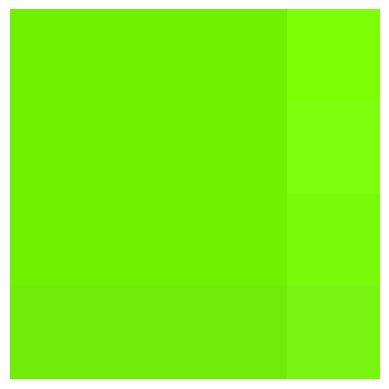

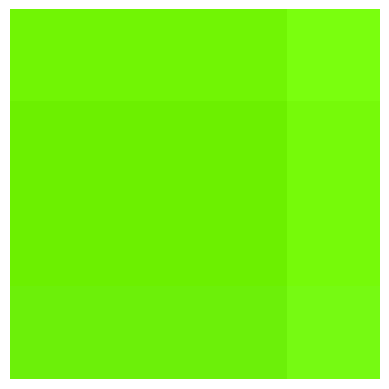

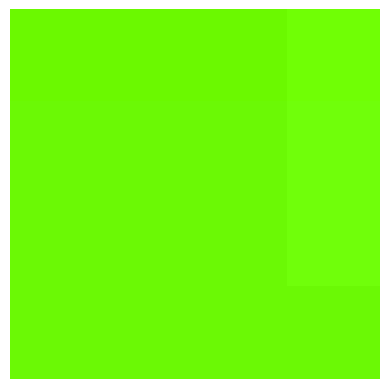

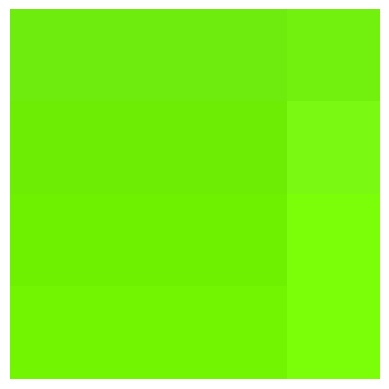

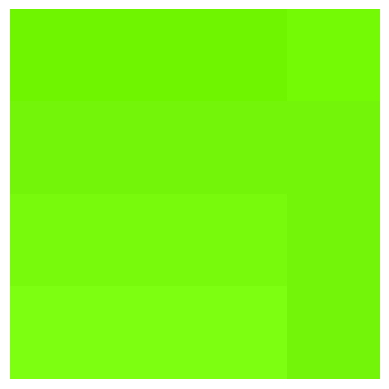

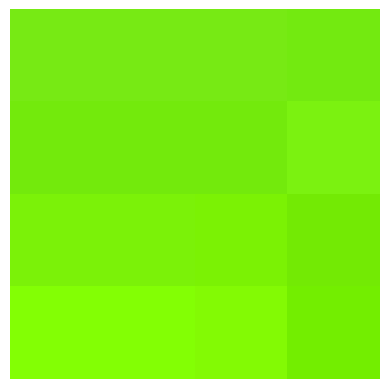

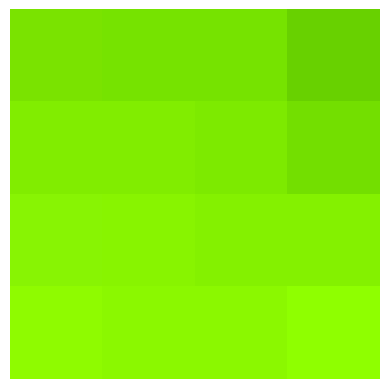

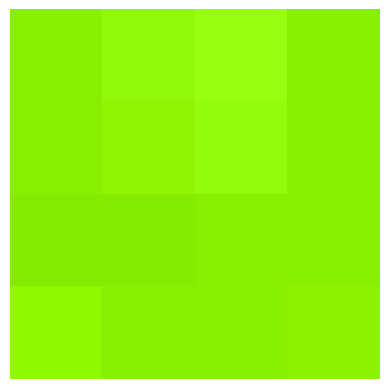

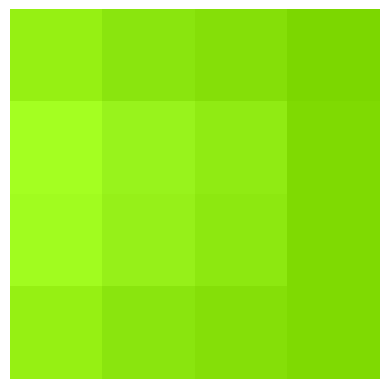

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already obtained the windows tensor

# Iterate over the windows and display them
num_windows = windows.shape[0]
print("Total number of windows:", num_windows)
for i in range(num_windows):
    window = windows[i]  # Get a single window
    
    # Convert the window tensor to a numpy array and transpose dimensions
    window_np = window.numpy().transpose(1, 0, 2)
    
    # Normalize the window values to [0, 1] range
    window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())
    
    # Display the window image
    plt.imshow(window_np)
    plt.axis('off')
    plt.show()



# Applying Linear Embedding

#### ( 4x4x3 tensor  to 1x1x96 tensor) 


In [7]:
# Lets use PatchEmbed
# embedding is representation of discrete objects,such as words, images
# patch embedding is vision transformer models to convert an input image into a sequence of fixed-size embeddings
class PatchEmbed(nn.Module):
    """ Convert image to patch embedding
    
    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """
    
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None
        
    def forward(self, x):
        # This method defines the forward pass of the PatchEmbed module
        # takes an input tensor x representing the input image and returns a tensor representing the sequence of patch embeddings
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)
        
        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)
        
        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x
        # the PatchEmbed module is a crucial component in the pipeline of vision transformer models.
        # It converts the input image into a sequence of patch embeddings, which can be
        # further processed by the transformer layers. This allows transformers to be applied effectively 
        # to image data for various computer vision tasks

# Applying patch embedding on patches

In [8]:
# loads an image, applies a transformation to convert it into a tensor, 
# and then uses a PatchEmbed module to obtain patch embeddings from the image
# Load the image file
image_path = r"C:\Users\janap\Desktop\Final_mini prjct\swww\train\green st\images (4).jpg"
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image) 
# Print the shape of the output patches
print("Patches shape:", patches.shape)   # 96 is embedding dimension, 3136 patches 224/4 * 224/4

embedding

Patches shape: torch.Size([1, 3136, 96])


tensor([[[-0.1916,  0.3741,  0.2693,  ...,  0.2569,  0.5350, -0.3854],
         [-0.1813,  0.3539,  0.2644,  ...,  0.2532,  0.5124, -0.3730],
         [-0.1768,  0.3444,  0.2646,  ...,  0.2653,  0.5016, -0.3670],
         ...,
         [-0.0546,  0.1067,  0.0993,  ...,  0.0696,  0.2296, -0.1852],
         [-0.0544,  0.1298,  0.1181,  ...,  0.0748,  0.2486, -0.1959],
         [-0.0651,  0.1490,  0.1171,  ...,  0.0844,  0.2790, -0.2072]]],
       grad_fn=<TransposeBackward0>)

The output you are seeing is a tensor representing the embedded patches. Each element in the tensor corresponds to a patch in the image.
The output tensor you provided has the shape (1, 3136, 96), indicating that you have one image with 3136 patches, and each patch is represented by a 96-dimensional embedding vector.

# 1st patch embedding vector

In [9]:
print("First patch embedding vector:", patches[0, 0])
# 96 values in every patch because 96 is embedding dimension we mentioned above
#To access the second patch's embedding vector, you can use patches[0, 1]

First patch embedding vector: tensor([-1.9158e-01,  3.7411e-01,  2.6930e-01, -2.3562e-01,  5.5637e-01,
         3.2734e-01, -2.2306e-01, -2.2537e-01, -3.0604e-01,  1.1108e-01,
        -7.1976e-02,  2.2647e-01,  1.7124e-01, -3.1517e-02, -5.1621e-02,
        -5.3524e-01,  4.0666e-02, -2.0728e-01, -3.2815e-01, -1.2725e-01,
        -2.9210e-02,  1.5232e-01, -4.8235e-01,  2.6111e-01, -3.7535e-01,
         2.1558e-01,  2.5233e-01, -2.8137e-01,  2.6414e-01, -2.2772e-01,
        -2.3310e-01, -2.1318e-01,  5.4066e-01, -9.5209e-02, -8.7100e-04,
         8.2018e-02, -4.5360e-01,  3.3761e-01,  2.7899e-01, -8.2425e-02,
         2.3261e-01, -2.1764e-01, -1.2005e-01, -1.3587e-01,  1.1089e-01,
        -2.6920e-01,  1.1138e-01, -2.6565e-02,  4.6685e-01, -2.1405e-01,
         9.5985e-01,  6.7430e-02,  3.2796e-02,  5.4806e-02,  1.8163e-01,
        -1.7065e-01,  6.7394e-01,  3.8245e-01, -1.3364e-01, -1.8346e-01,
        -1.7586e-01,  1.3525e-01, -8.9063e-02,  3.2900e-01, -1.0145e-01,
         1.5683e-02, 

# Using BasicLayer : Swin Transformer layer for one stage

In [10]:
from swin_functions_and_classes import *


stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output


C:\Users\janap\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 3136, 96])


tensor([[[ 0.3877,  0.6330,  0.4031,  ...,  0.2453,  0.4471, -0.9903],
         [ 0.4037,  0.6169,  0.4017,  ...,  0.2459,  0.4234, -0.9742],
         [ 0.4120,  0.6103,  0.4063,  ...,  0.2592,  0.4168, -0.9639],
         ...,
         [ 0.6128,  0.7110,  0.2039,  ...,  0.1686, -0.1302, -1.1004],
         [ 0.5953,  0.7159,  0.2167,  ...,  0.1716, -0.0970, -1.1018],
         [ 0.5695,  0.7348,  0.2171,  ...,  0.1706, -0.0655, -1.1187]]],
       grad_fn=<AddBackward0>)

# Patch Merging
##### USing patch merging on the embedding

In [11]:
# PatchMerging
# the PatchMerging layer aggregates information from neighboring patches to
# reduce the spatial resolution and increase the dimensionality 
# of the feature map, facilitating hierarchical feature representation and capturing long-range dependencies in the input data.
# USing patch merging on the embedding
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 28x28, 96*2) # (1, 784, 192)

Merged output shape: torch.Size([1, 784, 192])


In [12]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


the output width and height are both reduced by a factor of 2 and the number of output channels is 2C where C is the number of input channels, here for Swin-T, C=96 .


### Let's create Stage-1 of the Swin-T architecture using SwinTransformerBlock:
Using SwinTransformerBlock class on the patch embedding embedding

In [13]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[-0.7751,  0.9774, -0.1653,  ...,  0.3456,  1.1198, -0.1252],
         [-0.7617,  0.9583, -0.1696,  ...,  0.3432,  1.0956, -0.1156],
         [-0.7553,  0.9500, -0.1704,  ...,  0.3579,  1.0812, -0.1066],
         ...,
         [-0.6286,  0.5585,  0.1694,  ...,  0.3905,  0.8297,  0.1056],
         [-0.6365,  0.5728,  0.1799,  ...,  0.3956,  0.8511,  0.1007],
         [-0.6503,  0.5941,  0.1720,  ...,  0.4060,  0.8757,  0.1063]]],
       grad_fn=<AddBackward0>)
tensor([[[-0.3549,  0.9831,  0.5125,  ...,  0.8324,  0.9027, -0.1085],
         [-0.3378,  0.9602,  0.5051,  ...,  0.8345,  0.8745, -0.0942],
         [-0.3125,  0.9543,  0.5168,  ...,  0.8401,  0.8994, -0.0597],
         ...,
         [-0.1590,  0.5856,  0.3327,  ...,  0.5999,  0.5558,  0.1941],
         [-0.1630,  0.6110,  0.3537,  ...,  0.6239,  0.5954,  0.1783],
         [-0.1721,  0.6266,  0.3466,  ...,  0.6249,  0.6421,  0.1607]]],
       grad_fn=<AddBackward0>)


# SwinTransformer :

In [14]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

a tensor_image tensor  (1, 3, 224, 224), which represents a batch of 1 images with 3 channels and size 224x224.
1000 is the number of classes for the classification head.
torch.Size([1, 1000]) represents the shape of the output tensor when passing tensor_image through the model. In this case, it has a batch size of 1 and 1000 output dimensions, which matches the number of classes specified by num_classes.

# Now, Let's work with custom dataset

In [15]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Concatenate the current directory with additional directories
train_dir = os.path.join(current_directory, r"C:\Users\janap\Desktop\Final_mini prjct\swww",r"C:\Users\janap\Desktop\Final_mini prjct\swww\train")
test_dir = os.path.join(current_directory, r"C:\Users\janap\Desktop\Final_mini prjct\swww",r"C:\Users\janap\Desktop\Final_mini prjct\swww\test")

print(train_dir)
print(test_dir)


C:\Users\janap\Desktop\Final_mini prjct\swww\train
C:\Users\janap\Desktop\Final_mini prjct\swww\test


In [16]:
# # Modify the directory paths to point directly to the image directories
# train_dir = r"C:\Users\janap\Desktop\Final_mini prjct\strawds\train"
# test_dir = r"C:\Users\janap\Desktop\Final_mini prjct\strawds\test"

# # Create data loaders
# train_dataloader, test_dataloader, class_names = create_dataloaders(
#     train_dir=train_dir,
#     test_dir=test_dir,
#     transform=manual_transforms, 
#     batch_size=BATCH_SIZE
# )


# Create Datasets and DataLoaders

In [17]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [18]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [19]:
# Set the batch size
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2500896c810>,
 ['green st', 'red st'])

torch.Size([3, 224, 224]) tensor(0)


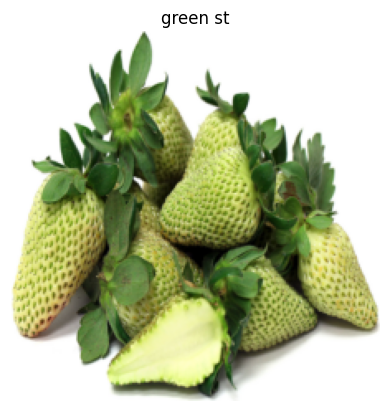

In [20]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [21]:
model = SwinTransformer(num_classes=len(class_names))

In [22]:
pip install going_modular helper_functions


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement going_modular (from versions: none)
ERROR: No matching distribution found for going_modular


In [25]:
import engine
from helper_functions import set_seeds

device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7461 | train_acc: 0.5897 | test_loss: 1.5370 | test_acc: 0.4688
Epoch: 2 | train_loss: 1.2447 | train_acc: 0.5302 | test_loss: 0.9279 | test_acc: 0.4688
Epoch: 3 | train_loss: 0.9247 | train_acc: 0.4494 | test_loss: 0.6889 | test_acc: 0.5312
Epoch: 4 | train_loss: 0.6965 | train_acc: 0.5428 | test_loss: 0.6817 | test_acc: 0.5938
Epoch: 5 | train_loss: 0.7064 | train_acc: 0.4946 | test_loss: 0.7582 | test_acc: 0.5312
Epoch: 6 | train_loss: 0.9385 | train_acc: 0.4541 | test_loss: 0.9931 | test_acc: 0.4688
Epoch: 7 | train_loss: 0.8609 | train_acc: 0.4725 | test_loss: 0.7205 | test_acc: 0.5312
Epoch: 8 | train_loss: 0.6695 | train_acc: 0.6318 | test_loss: 0.3907 | test_acc: 0.8203
Epoch: 9 | train_loss: 0.5327 | train_acc: 0.7351 | test_loss: 0.4699 | test_acc: 0.6875
Epoch: 10 | train_loss: 0.6665 | train_acc: 0.5785 | test_loss: 0.7433 | test_acc: 0.5312


In [ ]:
pip install going_modular


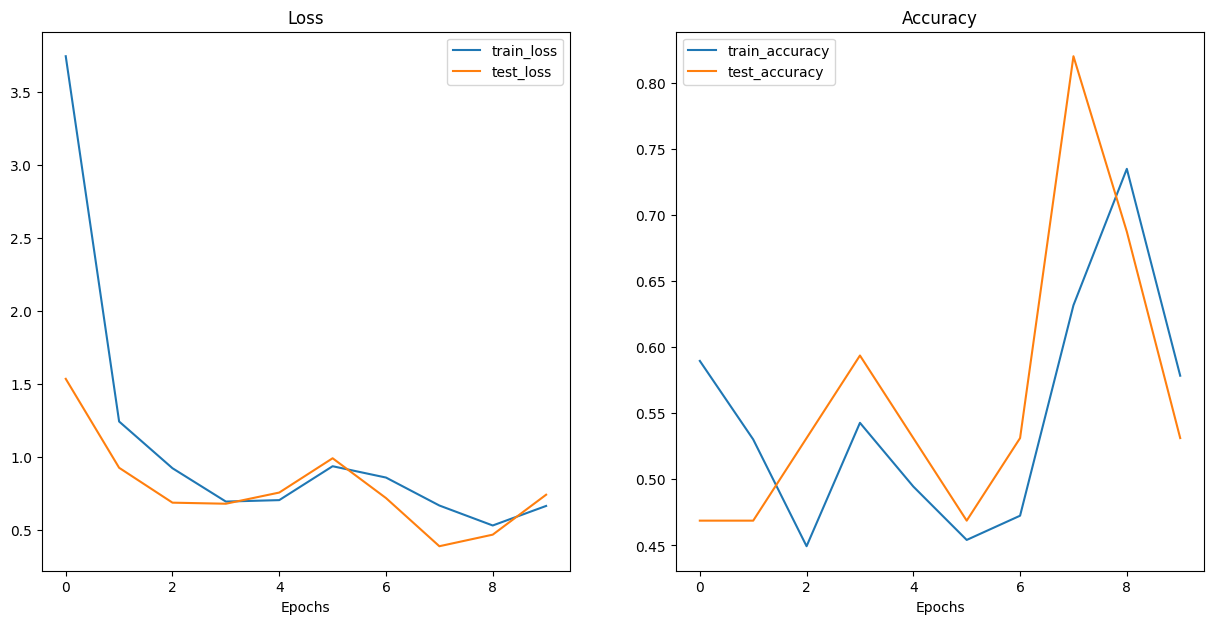

In [26]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves
# from engine.py import calculate_classification_report
# import calculate_classification_report
# Assuming you have already imported calculate_classification_report and obtained the results dictionary

# Print or use the results as needed
# for epoch in range(len(results["calculate_classification_report"])):
#     print(f"Epoch {epoch+1} Train Classification Report:")
#     print(results["calculate_classification_report"][epoch])
#     print(f"Epoch {epoch+1} Test Classification Report:")
#     print(results["calculate_classification_report"][epoch])


# Plot our ViT model's loss curves
plot_loss_curves(results)
# print(calculate_classification_report(y_true, y_pred))

# Prediction

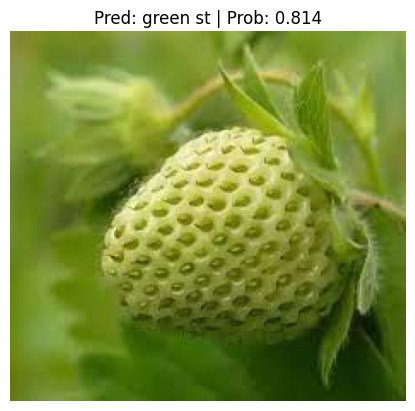

In [31]:
import requests

# Import function to make predictions on images and plot them 
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = r"C:\Users\janap\Desktop\Final_mini prjct\green st\images (4).jpg"
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

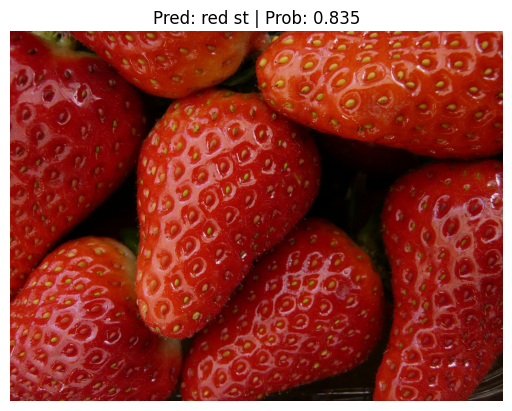

In [40]:


# Setup custom image path
custom_image_path = r"C:\Users\janap\Desktop\Final_mini prjct\red st\strawberries-5750_1280.jpg"
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)
# Predict on custom image